In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory= False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory= False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory= False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [10]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [11]:
train_data = training_features.drop(['ground_ball'], axis=1).copy()
train_label = training_features['ground_ball'].copy()
testing_data = testing_features.drop(['ground_ball'], axis=1).copy()
testing_label = testing_features['ground_ball'].copy()

In [12]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [13]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [14]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [15]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [16]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6069332355099046
Log Loss: 0.6668484296778339


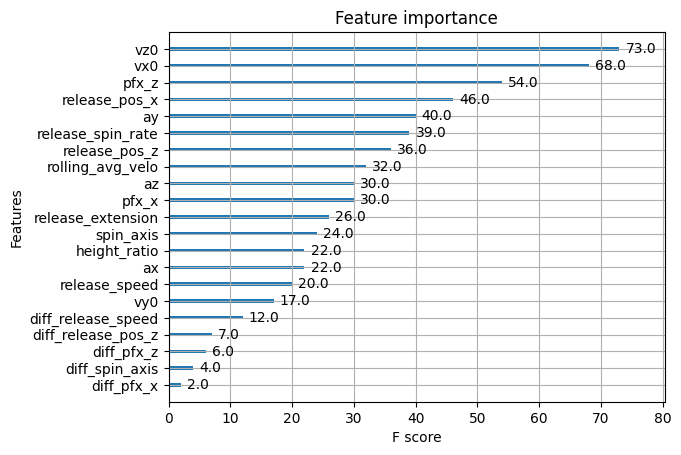

In [17]:
xgb.plot_importance(model)
plt.show()

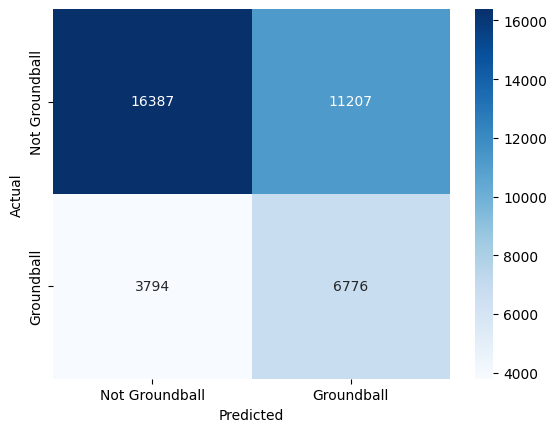

In [18]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [19]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [20]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:35:51,839] A new study created in memory with name: no-name-96222bcc-fafb-4aab-8842-94e2370652e8


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.66959
[4]	eval-logloss:0.66653
[5]	eval-logloss:0.66245
[6]	eval-logloss:0.65886
[7]	eval-logloss:0.65603
[8]	eval-logloss:0.65289
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64608
[11]	eval-logloss:0.64227
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63675
[14]	eval-logloss:0.63394
[15]	eval-logloss:0.63065
[16]	eval-logloss:0.62681
[17]	eval-logloss:0.62424
[18]	eval-logloss:0.62301
[19]	eval-logloss:0.62079
[20]	eval-logloss:0.61776
[21]	eval-logloss:0.61515
[22]	eval-logloss:0.61129
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60417
[26]	eval-logloss:0.60201
[27]	eval-logloss:0.60009
[28]	eval-logloss:0.59718
[29]	eval-logloss:0.59569
[30]	eval-logloss:0.59317
[31]	eval-logloss:0.59151
[32]	eval-logloss:0.58840
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58568
[35]	eval-logloss:0.58389
[36]	eval-logloss:0.58109
[37]	eval-logloss:0.57961
[38]	eval-logloss:0.57

[I 2023-11-15 11:35:53,858] Trial 0 finished with value: 0.4761765648025389 and parameters: {'max_depth': 6, 'eta': 0.280600616735176, 'subsample': 0.7037884418543819, 'colsample_bytree': 0.6945339093572651}. Best is trial 0 with value: 0.4761765648025389.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67472
[3]	eval-logloss:0.67008
[4]	eval-logloss:0.66520
[5]	eval-logloss:0.65951
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.64862
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63195
[12]	eval-logloss:0.62757
[13]	eval-logloss:0.62325
[14]	eval-logloss:0.62067
[15]	eval-logloss:0.61832
[16]	eval-logloss:0.61433
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.60977
[19]	eval-logloss:0.60724
[20]	eval-logloss:0.60489
[21]	eval-logloss:0.60264
[22]	eval-logloss:0.59867
[23]	eval-logloss:0.59599
[24]	eval-logloss:0.59322
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.58957
[27]	eval-logloss:0.58769
[28]	eval-logloss:0.58567
[29]	eval-logloss:0.58306
[30]	eval-logloss:0.58056
[31]	eval-logloss:0.57871
[32]	eval-logloss:0.57589
[33]	eval-logloss:0.57353
[34]	eval-logloss:0.57257
[35]	eval-logloss:0.57064
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56686
[38]	eval-logloss:0.56

[I 2023-11-15 11:35:56,423] Trial 1 finished with value: 0.46760825515296195 and parameters: {'max_depth': 8, 'eta': 0.09684470237426862, 'subsample': 0.8623368857881958, 'colsample_bytree': 0.7414750046488914}. Best is trial 1 with value: 0.46760825515296195.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68688
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67891
[15]	eval-logloss:0.67831
[16]	eval-logloss:0.67765
[17]	eval-logloss:0.67716
[18]	eval-logloss:0.67677
[19]	eval-logloss:0.67621
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67538
[22]	eval-logloss:0.67486
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67366
[25]	eval-logloss:0.67307
[26]	eval-logloss:0.67271
[27]	eval-logloss:0.67229
[28]	eval-logloss:0.67174
[29]	eval-logloss:0.67131
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67044
[32]	eval-logloss:0.66997
[33]	eval-logloss:0.66968
[34]	eval-logloss:0.66927
[35]	eval-logloss:0.66888
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66791
[38]	eval-logloss:0.66

[I 2023-11-15 11:35:57,996] Trial 2 finished with value: 0.6484652349982162 and parameters: {'max_depth': 4, 'eta': 0.0876395012526093, 'subsample': 0.6682122826240061, 'colsample_bytree': 0.9433899985130954}. Best is trial 1 with value: 0.46760825515296195.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66284
[3]	eval-logloss:0.65328
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.63834
[6]	eval-logloss:0.62746
[7]	eval-logloss:0.61976
[8]	eval-logloss:0.61017
[9]	eval-logloss:0.60468
[10]	eval-logloss:0.59843
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58333
[13]	eval-logloss:0.57432
[14]	eval-logloss:0.57091
[15]	eval-logloss:0.56850
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55645
[18]	eval-logloss:0.55358
[19]	eval-logloss:0.54870
[20]	eval-logloss:0.54264
[21]	eval-logloss:0.53956
[22]	eval-logloss:0.53593
[23]	eval-logloss:0.53195
[24]	eval-logloss:0.52804
[25]	eval-logloss:0.52460
[26]	eval-logloss:0.52216
[27]	eval-logloss:0.51767
[28]	eval-logloss:0.51421
[29]	eval-logloss:0.51192
[30]	eval-logloss:0.50907
[31]	eval-logloss:0.50630
[32]	eval-logloss:0.50363
[33]	eval-logloss:0.50075
[34]	eval-logloss:0.49770
[35]	eval-logloss:0.49398
[36]	eval-logloss:0.49046
[37]	eval-logloss:0.48606
[38]	eval-logloss:0.48

[I 2023-11-15 11:36:01,178] Trial 3 finished with value: 0.3513414523363155 and parameters: {'max_depth': 9, 'eta': 0.13299110836489747, 'subsample': 0.8737381447959844, 'colsample_bytree': 0.6346568689598172}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69080
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68984
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68888
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68844
[19]	eval-logloss:0.68823
[20]	eval-logloss:0.68800
[21]	eval-logloss:0.68790
[22]	eval-logloss:0.68764
[23]	eval-logloss:0.68738
[24]	eval-logloss:0.68717
[25]	eval-logloss:0.68693
[26]	eval-logloss:0.68675
[27]	eval-logloss:0.68657
[28]	eval-logloss:0.68637
[29]	eval-logloss:0.68620
[30]	eval-logloss:0.68601
[31]	eval-logloss:0.68584
[32]	eval-logloss:0.68567
[33]	eval-logloss:0.68546
[34]	eval-logloss:0.68529
[35]	eval-logloss:0.68508
[36]	eval-logloss:0.68486
[37]	eval-logloss:0.68470
[38]	eval-logloss:0.68

[I 2023-11-15 11:36:02,905] Trial 4 finished with value: 0.6769609000122903 and parameters: {'max_depth': 4, 'eta': 0.015908652675356495, 'subsample': 0.7949486686675088, 'colsample_bytree': 0.8254063094944053}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67047
[7]	eval-logloss:0.66852
[8]	eval-logloss:0.66567
[9]	eval-logloss:0.66359
[10]	eval-logloss:0.66145
[11]	eval-logloss:0.65922
[12]	eval-logloss:0.65656
[13]	eval-logloss:0.65388
[14]	eval-logloss:0.65151
[15]	eval-logloss:0.64996
[16]	eval-logloss:0.64878
[17]	eval-logloss:0.64747
[18]	eval-logloss:0.64620
[19]	eval-logloss:0.64438
[20]	eval-logloss:0.64235
[21]	eval-logloss:0.64117
[22]	eval-logloss:0.63937
[23]	eval-logloss:0.63741
[24]	eval-logloss:0.63680
[25]	eval-logloss:0.63551
[26]	eval-logloss:0.63376
[27]	eval-logloss:0.63237
[28]	eval-logloss:0.63074
[29]	eval-logloss:0.62955
[30]	eval-logloss:0.62792
[31]	eval-logloss:0.62640
[32]	eval-logloss:0.62537
[33]	eval-logloss:0.62443
[34]	eval-logloss:0.62280
[35]	eval-logloss:0.62182
[36]	eval-logloss:0.61992
[37]	eval-logloss:0.61894
[38]	eval-logloss:0.61

[I 2023-11-15 11:36:04,958] Trial 5 finished with value: 0.5580959492037693 and parameters: {'max_depth': 6, 'eta': 0.13190602997950354, 'subsample': 0.7787056775118926, 'colsample_bytree': 0.7685704298827938}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68526
[6]	eval-logloss:0.68408
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68173
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67801
[14]	eval-logloss:0.67706
[15]	eval-logloss:0.67641
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67522
[18]	eval-logloss:0.67482
[19]	eval-logloss:0.67449
[20]	eval-logloss:0.67447
[21]	eval-logloss:0.67427
[22]	eval-logloss:0.67345
[23]	eval-logloss:0.67267
[24]	eval-logloss:0.67224
[25]	eval-logloss:0.67134
[26]	eval-logloss:0.67113
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.67000
[30]	eval-logloss:0.66983
[31]	eval-logloss:0.66959
[32]	eval-logloss:0.66927
[33]	eval-logloss:0.66862
[34]	eval-logloss:0.66831
[35]	eval-logloss:0.66779
[36]	eval-logloss:0.66739
[37]	eval-logloss:0.66726
[38]	eval-logloss:0.66

[I 2023-11-15 11:36:06,533] Trial 6 finished with value: 0.647486418437551 and parameters: {'max_depth': 3, 'eta': 0.24553893288446313, 'subsample': 0.8480311611306273, 'colsample_bytree': 0.5041266689944173}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.64970
[6]	eval-logloss:0.64413
[7]	eval-logloss:0.63821
[8]	eval-logloss:0.63309
[9]	eval-logloss:0.62764
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61199
[13]	eval-logloss:0.60999
[14]	eval-logloss:0.60575
[15]	eval-logloss:0.60229
[16]	eval-logloss:0.59769
[17]	eval-logloss:0.59382
[18]	eval-logloss:0.59068
[19]	eval-logloss:0.58698
[20]	eval-logloss:0.58427
[21]	eval-logloss:0.58183
[22]	eval-logloss:0.57845
[23]	eval-logloss:0.57499
[24]	eval-logloss:0.57166
[25]	eval-logloss:0.56885
[26]	eval-logloss:0.56660
[27]	eval-logloss:0.56325
[28]	eval-logloss:0.56115
[29]	eval-logloss:0.55949
[30]	eval-logloss:0.55607
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.54822
[33]	eval-logloss:0.54556
[34]	eval-logloss:0.54420
[35]	eval-logloss:0.54173
[36]	eval-logloss:0.53861
[37]	eval-logloss:0.53617
[38]	eval-logloss:0.53

[I 2023-11-15 11:36:09,085] Trial 7 finished with value: 0.4063658552635425 and parameters: {'max_depth': 7, 'eta': 0.2569486713737681, 'subsample': 0.6834217556920847, 'colsample_bytree': 0.75148785560297}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67361
[5]	eval-logloss:0.67030
[6]	eval-logloss:0.66887
[7]	eval-logloss:0.66709
[8]	eval-logloss:0.66434
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66106
[11]	eval-logloss:0.65911
[12]	eval-logloss:0.65689
[13]	eval-logloss:0.65553
[14]	eval-logloss:0.65370
[15]	eval-logloss:0.65194
[16]	eval-logloss:0.65010
[17]	eval-logloss:0.64807
[18]	eval-logloss:0.64620
[19]	eval-logloss:0.64462
[20]	eval-logloss:0.64294
[21]	eval-logloss:0.64196
[22]	eval-logloss:0.63997
[23]	eval-logloss:0.63774
[24]	eval-logloss:0.63678
[25]	eval-logloss:0.63496
[26]	eval-logloss:0.63300
[27]	eval-logloss:0.63179
[28]	eval-logloss:0.63074
[29]	eval-logloss:0.62979
[30]	eval-logloss:0.62815
[31]	eval-logloss:0.62700
[32]	eval-logloss:0.62549
[33]	eval-logloss:0.62419
[34]	eval-logloss:0.62291
[35]	eval-logloss:0.62161
[36]	eval-logloss:0.61912
[37]	eval-logloss:0.61840
[38]	eval-logloss:0.61

[I 2023-11-15 11:36:10,676] Trial 8 finished with value: 0.5419520810975175 and parameters: {'max_depth': 5, 'eta': 0.2926224362562991, 'subsample': 0.8285526269190244, 'colsample_bytree': 0.7135612704368732}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67657
[4]	eval-logloss:0.67278
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66556
[7]	eval-logloss:0.66331
[8]	eval-logloss:0.66153
[9]	eval-logloss:0.66032
[10]	eval-logloss:0.65770
[11]	eval-logloss:0.65516
[12]	eval-logloss:0.65308
[13]	eval-logloss:0.65050
[14]	eval-logloss:0.64858
[15]	eval-logloss:0.64681
[16]	eval-logloss:0.64453
[17]	eval-logloss:0.64280
[18]	eval-logloss:0.64180
[19]	eval-logloss:0.63984
[20]	eval-logloss:0.63802
[21]	eval-logloss:0.63643
[22]	eval-logloss:0.63384
[23]	eval-logloss:0.63119
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62823
[26]	eval-logloss:0.62644
[27]	eval-logloss:0.62563
[28]	eval-logloss:0.62409
[29]	eval-logloss:0.62240
[30]	eval-logloss:0.62097
[31]	eval-logloss:0.61946
[32]	eval-logloss:0.61776
[33]	eval-logloss:0.61693
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61418
[36]	eval-logloss:0.61249
[37]	eval-logloss:0.61143
[38]	eval-logloss:0.61

[I 2023-11-15 11:36:12,518] Trial 9 finished with value: 0.5404122187203334 and parameters: {'max_depth': 6, 'eta': 0.14930328389646585, 'subsample': 0.6189485130065976, 'colsample_bytree': 0.9251721688742268}. Best is trial 3 with value: 0.3513414523363155.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66395
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62813
[5]	eval-logloss:0.61908
[6]	eval-logloss:0.60513
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58463
[9]	eval-logloss:0.57681
[10]	eval-logloss:0.57120
[11]	eval-logloss:0.56386
[12]	eval-logloss:0.55430
[13]	eval-logloss:0.54492
[14]	eval-logloss:0.54005
[15]	eval-logloss:0.53765
[16]	eval-logloss:0.53007
[17]	eval-logloss:0.52291
[18]	eval-logloss:0.52025
[19]	eval-logloss:0.51632
[20]	eval-logloss:0.50983
[21]	eval-logloss:0.50343
[22]	eval-logloss:0.49835
[23]	eval-logloss:0.49354
[24]	eval-logloss:0.48995
[25]	eval-logloss:0.48732
[26]	eval-logloss:0.48433
[27]	eval-logloss:0.48013
[28]	eval-logloss:0.47548
[29]	eval-logloss:0.47282
[30]	eval-logloss:0.46866
[31]	eval-logloss:0.46511
[32]	eval-logloss:0.46239
[33]	eval-logloss:0.45688
[34]	eval-logloss:0.45405
[35]	eval-logloss:0.44778
[36]	eval-logloss:0.44728
[37]	eval-logloss:0.44377
[38]	eval-logloss:0.44

[I 2023-11-15 11:36:15,233] Trial 10 finished with value: 0.28713550529243653 and parameters: {'max_depth': 9, 'eta': 0.19368798228694564, 'subsample': 0.8944625309949226, 'colsample_bytree': 0.5882901281925637}. Best is trial 10 with value: 0.28713550529243653.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.61647
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57232
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.55474
[12]	eval-logloss:0.54555
[13]	eval-logloss:0.53541
[14]	eval-logloss:0.53132
[15]	eval-logloss:0.52598
[16]	eval-logloss:0.51794
[17]	eval-logloss:0.51134
[18]	eval-logloss:0.50813
[19]	eval-logloss:0.50277
[20]	eval-logloss:0.49751
[21]	eval-logloss:0.49097
[22]	eval-logloss:0.48680
[23]	eval-logloss:0.48288
[24]	eval-logloss:0.47840
[25]	eval-logloss:0.47431
[26]	eval-logloss:0.47134
[27]	eval-logloss:0.46674
[28]	eval-logloss:0.46288
[29]	eval-logloss:0.45872
[30]	eval-logloss:0.45411
[31]	eval-logloss:0.44907
[32]	eval-logloss:0.44668
[33]	eval-logloss:0.44286
[34]	eval-logloss:0.43777
[35]	eval-logloss:0.43302
[36]	eval-logloss:0.42831
[37]	eval-logloss:0.42289
[38]	eval-logloss:0.41

[I 2023-11-15 11:36:18,004] Trial 11 finished with value: 0.27924204903146765 and parameters: {'max_depth': 9, 'eta': 0.1970291498587642, 'subsample': 0.8943423964675012, 'colsample_bytree': 0.5892285171601961}. Best is trial 11 with value: 0.27924204903146765.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62277
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.59710
[8]	eval-logloss:0.58683
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57199
[11]	eval-logloss:0.56329
[12]	eval-logloss:0.55329
[13]	eval-logloss:0.54315
[14]	eval-logloss:0.53851
[15]	eval-logloss:0.53670
[16]	eval-logloss:0.52983
[17]	eval-logloss:0.52520
[18]	eval-logloss:0.52002
[19]	eval-logloss:0.51552
[20]	eval-logloss:0.50946
[21]	eval-logloss:0.50293
[22]	eval-logloss:0.49664
[23]	eval-logloss:0.49323
[24]	eval-logloss:0.48670
[25]	eval-logloss:0.48317
[26]	eval-logloss:0.47959
[27]	eval-logloss:0.47545
[28]	eval-logloss:0.47203
[29]	eval-logloss:0.46871
[30]	eval-logloss:0.46586
[31]	eval-logloss:0.46175
[32]	eval-logloss:0.45708
[33]	eval-logloss:0.45047
[34]	eval-logloss:0.44760
[35]	eval-logloss:0.44358
[36]	eval-logloss:0.44255
[37]	eval-logloss:0.43910
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:20,694] Trial 12 finished with value: 0.2930240808060873 and parameters: {'max_depth': 9, 'eta': 0.19907093233641718, 'subsample': 0.8988813439567411, 'colsample_bytree': 0.5633653899631295}. Best is trial 11 with value: 0.27924204903146765.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66269
[3]	eval-logloss:0.65355
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64075
[6]	eval-logloss:0.63009
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.61358
[9]	eval-logloss:0.60848
[10]	eval-logloss:0.60371
[11]	eval-logloss:0.59745
[12]	eval-logloss:0.59114
[13]	eval-logloss:0.58467
[14]	eval-logloss:0.57916
[15]	eval-logloss:0.57523
[16]	eval-logloss:0.57017
[17]	eval-logloss:0.56589
[18]	eval-logloss:0.56200
[19]	eval-logloss:0.55767
[20]	eval-logloss:0.55312
[21]	eval-logloss:0.54980
[22]	eval-logloss:0.54714
[23]	eval-logloss:0.54311
[24]	eval-logloss:0.54030
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53474
[27]	eval-logloss:0.53256
[28]	eval-logloss:0.52749
[29]	eval-logloss:0.52516
[30]	eval-logloss:0.52148
[31]	eval-logloss:0.51916
[32]	eval-logloss:0.51639
[33]	eval-logloss:0.51217
[34]	eval-logloss:0.50951
[35]	eval-logloss:0.50546
[36]	eval-logloss:0.50300
[37]	eval-logloss:0.50023
[38]	eval-logloss:0.49

[I 2023-11-15 11:36:23,046] Trial 13 finished with value: 0.3608326046205409 and parameters: {'max_depth': 8, 'eta': 0.20337453473676773, 'subsample': 0.8187633168077474, 'colsample_bytree': 0.6088239552422152}. Best is trial 11 with value: 0.27924204903146765.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.66207
[3]	eval-logloss:0.65395
[4]	eval-logloss:0.64887
[5]	eval-logloss:0.64192
[6]	eval-logloss:0.63313
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.61395
[10]	eval-logloss:0.60577
[11]	eval-logloss:0.59931
[12]	eval-logloss:0.59239
[13]	eval-logloss:0.58360
[14]	eval-logloss:0.57805
[15]	eval-logloss:0.57343
[16]	eval-logloss:0.56827
[17]	eval-logloss:0.56396
[18]	eval-logloss:0.56040
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55511
[21]	eval-logloss:0.55134
[22]	eval-logloss:0.54684
[23]	eval-logloss:0.54306
[24]	eval-logloss:0.54016
[25]	eval-logloss:0.53466
[26]	eval-logloss:0.53196
[27]	eval-logloss:0.52816
[28]	eval-logloss:0.52519
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.51912
[31]	eval-logloss:0.51567
[32]	eval-logloss:0.51142
[33]	eval-logloss:0.50803
[34]	eval-logloss:0.50520
[35]	eval-logloss:0.50269
[36]	eval-logloss:0.49950
[37]	eval-logloss:0.49486
[38]	eval-logloss:0.49

[I 2023-11-15 11:36:25,321] Trial 14 finished with value: 0.3621964338067575 and parameters: {'max_depth': 8, 'eta': 0.1992996005743541, 'subsample': 0.8954407628315534, 'colsample_bytree': 0.5101482765011834}. Best is trial 11 with value: 0.27924204903146765.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.62234
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.59796
[8]	eval-logloss:0.58510
[9]	eval-logloss:0.57809
[10]	eval-logloss:0.57076
[11]	eval-logloss:0.56057
[12]	eval-logloss:0.55091
[13]	eval-logloss:0.54122
[14]	eval-logloss:0.53332
[15]	eval-logloss:0.52912
[16]	eval-logloss:0.52480
[17]	eval-logloss:0.51829
[18]	eval-logloss:0.51456
[19]	eval-logloss:0.51119
[20]	eval-logloss:0.50448
[21]	eval-logloss:0.50200
[22]	eval-logloss:0.49681
[23]	eval-logloss:0.49307
[24]	eval-logloss:0.48992
[25]	eval-logloss:0.48642
[26]	eval-logloss:0.48410
[27]	eval-logloss:0.48133
[28]	eval-logloss:0.47553
[29]	eval-logloss:0.47172
[30]	eval-logloss:0.46837
[31]	eval-logloss:0.46295
[32]	eval-logloss:0.45698
[33]	eval-logloss:0.45307
[34]	eval-logloss:0.45044
[35]	eval-logloss:0.44646
[36]	eval-logloss:0.44231
[37]	eval-logloss:0.43980
[38]	eval-logloss:0.43

[I 2023-11-15 11:36:28,070] Trial 15 finished with value: 0.27545226871256906 and parameters: {'max_depth': 9, 'eta': 0.21607719915574092, 'subsample': 0.7566291883543494, 'colsample_bytree': 0.6192323146994118}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64493
[7]	eval-logloss:0.63939
[8]	eval-logloss:0.63532
[9]	eval-logloss:0.63256
[10]	eval-logloss:0.62881
[11]	eval-logloss:0.62425
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61236
[14]	eval-logloss:0.60801
[15]	eval-logloss:0.60527
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59662
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59087
[21]	eval-logloss:0.58644
[22]	eval-logloss:0.58259
[23]	eval-logloss:0.57950
[24]	eval-logloss:0.57667
[25]	eval-logloss:0.57427
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.56757
[28]	eval-logloss:0.56466
[29]	eval-logloss:0.55951
[30]	eval-logloss:0.55734
[31]	eval-logloss:0.55435
[32]	eval-logloss:0.55280
[33]	eval-logloss:0.55057
[34]	eval-logloss:0.54828
[35]	eval-logloss:0.54485
[36]	eval-logloss:0.54184
[37]	eval-logloss:0.53864
[38]	eval-logloss:0.53

[I 2023-11-15 11:36:30,110] Trial 16 finished with value: 0.4096035486732888 and parameters: {'max_depth': 7, 'eta': 0.23902266857328727, 'subsample': 0.7496718365733726, 'colsample_bytree': 0.6497201544573842}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.65794
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.63652
[10]	eval-logloss:0.63303
[11]	eval-logloss:0.62739
[12]	eval-logloss:0.62232
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.60803
[16]	eval-logloss:0.60701
[17]	eval-logloss:0.60370
[18]	eval-logloss:0.60197
[19]	eval-logloss:0.59949
[20]	eval-logloss:0.59661
[21]	eval-logloss:0.59382
[22]	eval-logloss:0.58930
[23]	eval-logloss:0.58619
[24]	eval-logloss:0.58337
[25]	eval-logloss:0.58033
[26]	eval-logloss:0.57601
[27]	eval-logloss:0.57473
[28]	eval-logloss:0.57130
[29]	eval-logloss:0.56915
[30]	eval-logloss:0.56684
[31]	eval-logloss:0.56420
[32]	eval-logloss:0.56256
[33]	eval-logloss:0.55888
[34]	eval-logloss:0.55708
[35]	eval-logloss:0.55479
[36]	eval-logloss:0.55134
[37]	eval-logloss:0.54935
[38]	eval-logloss:0.54

[I 2023-11-15 11:36:32,239] Trial 17 finished with value: 0.4305944703239511 and parameters: {'max_depth': 7, 'eta': 0.2244946491253416, 'subsample': 0.7544301194104845, 'colsample_bytree': 0.5538018783242021}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.61329
[7]	eval-logloss:0.60255
[8]	eval-logloss:0.59089
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.57912
[11]	eval-logloss:0.57030
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.55642
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.54923
[16]	eval-logloss:0.54252
[17]	eval-logloss:0.53731
[18]	eval-logloss:0.53428
[19]	eval-logloss:0.52836
[20]	eval-logloss:0.52289
[21]	eval-logloss:0.51801
[22]	eval-logloss:0.51431
[23]	eval-logloss:0.50996
[24]	eval-logloss:0.50554
[25]	eval-logloss:0.50273
[26]	eval-logloss:0.49932
[27]	eval-logloss:0.49601
[28]	eval-logloss:0.49114
[29]	eval-logloss:0.48525
[30]	eval-logloss:0.48037
[31]	eval-logloss:0.47671
[32]	eval-logloss:0.47318
[33]	eval-logloss:0.46802
[34]	eval-logloss:0.46469
[35]	eval-logloss:0.46188
[36]	eval-logloss:0.45848
[37]	eval-logloss:0.45567
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:35,032] Trial 18 finished with value: 0.3062554607346622 and parameters: {'max_depth': 9, 'eta': 0.17531617750839432, 'subsample': 0.835013264627416, 'colsample_bytree': 0.6625189373279475}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64585
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.63091
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61104
[8]	eval-logloss:0.60274
[9]	eval-logloss:0.59763
[10]	eval-logloss:0.59357
[11]	eval-logloss:0.58673
[12]	eval-logloss:0.58046
[13]	eval-logloss:0.57112
[14]	eval-logloss:0.56575
[15]	eval-logloss:0.55937
[16]	eval-logloss:0.55252
[17]	eval-logloss:0.54706
[18]	eval-logloss:0.54227
[19]	eval-logloss:0.53676
[20]	eval-logloss:0.53026
[21]	eval-logloss:0.52746
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.51919
[24]	eval-logloss:0.51519
[25]	eval-logloss:0.51139
[26]	eval-logloss:0.50908
[27]	eval-logloss:0.50523
[28]	eval-logloss:0.50034
[29]	eval-logloss:0.49776
[30]	eval-logloss:0.49374
[31]	eval-logloss:0.49210
[32]	eval-logloss:0.48991
[33]	eval-logloss:0.48452
[34]	eval-logloss:0.48175
[35]	eval-logloss:0.47889
[36]	eval-logloss:0.47223
[37]	eval-logloss:0.46853
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:37,423] Trial 19 finished with value: 0.3147445696393066 and parameters: {'max_depth': 8, 'eta': 0.2657962173871572, 'subsample': 0.8009754118214957, 'colsample_bytree': 0.5941530402696689}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67720
[2]	eval-logloss:0.67100
[3]	eval-logloss:0.66425
[4]	eval-logloss:0.65889
[5]	eval-logloss:0.65391
[6]	eval-logloss:0.64699
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.62868
[11]	eval-logloss:0.62401
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61404
[14]	eval-logloss:0.61187
[15]	eval-logloss:0.60941
[16]	eval-logloss:0.60715
[17]	eval-logloss:0.60399
[18]	eval-logloss:0.60072
[19]	eval-logloss:0.59723
[20]	eval-logloss:0.59326
[21]	eval-logloss:0.58945
[22]	eval-logloss:0.58547
[23]	eval-logloss:0.58178
[24]	eval-logloss:0.57795
[25]	eval-logloss:0.57593
[26]	eval-logloss:0.57444
[27]	eval-logloss:0.57134
[28]	eval-logloss:0.56920
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56653
[31]	eval-logloss:0.56331
[32]	eval-logloss:0.56165
[33]	eval-logloss:0.55810
[34]	eval-logloss:0.55514
[35]	eval-logloss:0.55183
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-15 11:36:39,419] Trial 20 finished with value: 0.4285340332258012 and parameters: {'max_depth': 7, 'eta': 0.2179292440212273, 'subsample': 0.8528024086871407, 'colsample_bytree': 0.6370215774472873}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66832
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63267
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.61181
[7]	eval-logloss:0.60137
[8]	eval-logloss:0.59114
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.57867
[11]	eval-logloss:0.56975
[12]	eval-logloss:0.56130
[13]	eval-logloss:0.55244
[14]	eval-logloss:0.54626
[15]	eval-logloss:0.54434
[16]	eval-logloss:0.53730
[17]	eval-logloss:0.53303
[18]	eval-logloss:0.52932
[19]	eval-logloss:0.52707
[20]	eval-logloss:0.52198
[21]	eval-logloss:0.51669
[22]	eval-logloss:0.51208
[23]	eval-logloss:0.50830
[24]	eval-logloss:0.50378
[25]	eval-logloss:0.49961
[26]	eval-logloss:0.49614
[27]	eval-logloss:0.49252
[28]	eval-logloss:0.48882
[29]	eval-logloss:0.48572
[30]	eval-logloss:0.48172
[31]	eval-logloss:0.47927
[32]	eval-logloss:0.47475
[33]	eval-logloss:0.47186
[34]	eval-logloss:0.46987
[35]	eval-logloss:0.46606
[36]	eval-logloss:0.46311
[37]	eval-logloss:0.46011
[38]	eval-logloss:0.45

[I 2023-11-15 11:36:42,156] Trial 21 finished with value: 0.3183355499349656 and parameters: {'max_depth': 9, 'eta': 0.17645515964628494, 'subsample': 0.8785175209466026, 'colsample_bytree': 0.5614809033796997}. Best is trial 15 with value: 0.27545226871256906.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61893
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.59513
[7]	eval-logloss:0.58406
[8]	eval-logloss:0.57457
[9]	eval-logloss:0.56557
[10]	eval-logloss:0.55641
[11]	eval-logloss:0.54513
[12]	eval-logloss:0.53680
[13]	eval-logloss:0.52556
[14]	eval-logloss:0.52021
[15]	eval-logloss:0.51763
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50101
[18]	eval-logloss:0.49529
[19]	eval-logloss:0.49022
[20]	eval-logloss:0.48539
[21]	eval-logloss:0.47556
[22]	eval-logloss:0.47253
[23]	eval-logloss:0.46783
[24]	eval-logloss:0.46369
[25]	eval-logloss:0.45826
[26]	eval-logloss:0.45546
[27]	eval-logloss:0.45132
[28]	eval-logloss:0.44605
[29]	eval-logloss:0.44535
[30]	eval-logloss:0.44291
[31]	eval-logloss:0.43885
[32]	eval-logloss:0.43566
[33]	eval-logloss:0.43179
[34]	eval-logloss:0.42749
[35]	eval-logloss:0.42291
[36]	eval-logloss:0.41944
[37]	eval-logloss:0.41728
[38]	eval-logloss:0.41

[I 2023-11-15 11:36:44,897] Trial 22 finished with value: 0.2607920811784497 and parameters: {'max_depth': 9, 'eta': 0.23661118576042206, 'subsample': 0.8982799780762648, 'colsample_bytree': 0.5839006867866576}. Best is trial 22 with value: 0.2607920811784497.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.64961
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.62360
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.59872
[10]	eval-logloss:0.59380
[11]	eval-logloss:0.58798
[12]	eval-logloss:0.58023
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57209
[15]	eval-logloss:0.56696
[16]	eval-logloss:0.55854
[17]	eval-logloss:0.55427
[18]	eval-logloss:0.55032
[19]	eval-logloss:0.54370
[20]	eval-logloss:0.54075
[21]	eval-logloss:0.53805
[22]	eval-logloss:0.53406
[23]	eval-logloss:0.52974
[24]	eval-logloss:0.52547
[25]	eval-logloss:0.52116
[26]	eval-logloss:0.51887
[27]	eval-logloss:0.51554
[28]	eval-logloss:0.51078
[29]	eval-logloss:0.50822
[30]	eval-logloss:0.50566
[31]	eval-logloss:0.50195
[32]	eval-logloss:0.49698
[33]	eval-logloss:0.49414
[34]	eval-logloss:0.49084
[35]	eval-logloss:0.48821
[36]	eval-logloss:0.48481
[37]	eval-logloss:0.48205
[38]	eval-logloss:0.47

[I 2023-11-15 11:36:47,213] Trial 23 finished with value: 0.33674499122802126 and parameters: {'max_depth': 8, 'eta': 0.2307543768018087, 'subsample': 0.8608562832302936, 'colsample_bytree': 0.6736475720422765}. Best is trial 22 with value: 0.2607920811784497.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.59331
[7]	eval-logloss:0.57913
[8]	eval-logloss:0.56804
[9]	eval-logloss:0.55861
[10]	eval-logloss:0.55307
[11]	eval-logloss:0.54464
[12]	eval-logloss:0.53571
[13]	eval-logloss:0.52821
[14]	eval-logloss:0.52139
[15]	eval-logloss:0.51357
[16]	eval-logloss:0.50494
[17]	eval-logloss:0.49811
[18]	eval-logloss:0.49364
[19]	eval-logloss:0.48891
[20]	eval-logloss:0.48263
[21]	eval-logloss:0.47642
[22]	eval-logloss:0.47294
[23]	eval-logloss:0.46686
[24]	eval-logloss:0.46302
[25]	eval-logloss:0.45735
[26]	eval-logloss:0.45367
[27]	eval-logloss:0.45011
[28]	eval-logloss:0.44368
[29]	eval-logloss:0.43854
[30]	eval-logloss:0.43489
[31]	eval-logloss:0.43147
[32]	eval-logloss:0.42498
[33]	eval-logloss:0.41991
[34]	eval-logloss:0.41666
[35]	eval-logloss:0.41232
[36]	eval-logloss:0.40724
[37]	eval-logloss:0.40086
[38]	eval-logloss:0.39

[I 2023-11-15 11:36:49,958] Trial 24 finished with value: 0.24272348205414426 and parameters: {'max_depth': 9, 'eta': 0.26847061457698235, 'subsample': 0.8291982800768034, 'colsample_bytree': 0.6136346377811146}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64303
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62522
[6]	eval-logloss:0.61234
[7]	eval-logloss:0.60338
[8]	eval-logloss:0.59342
[9]	eval-logloss:0.58769
[10]	eval-logloss:0.58262
[11]	eval-logloss:0.57660
[12]	eval-logloss:0.56872
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.55334
[15]	eval-logloss:0.54829
[16]	eval-logloss:0.54093
[17]	eval-logloss:0.53650
[18]	eval-logloss:0.53240
[19]	eval-logloss:0.52646
[20]	eval-logloss:0.52169
[21]	eval-logloss:0.51844
[22]	eval-logloss:0.51163
[23]	eval-logloss:0.50660
[24]	eval-logloss:0.50221
[25]	eval-logloss:0.49798
[26]	eval-logloss:0.49480
[27]	eval-logloss:0.49045
[28]	eval-logloss:0.48656
[29]	eval-logloss:0.48298
[30]	eval-logloss:0.47753
[31]	eval-logloss:0.47212
[32]	eval-logloss:0.47016
[33]	eval-logloss:0.46497
[34]	eval-logloss:0.46083
[35]	eval-logloss:0.45750
[36]	eval-logloss:0.45466
[37]	eval-logloss:0.45030
[38]	eval-logloss:0.44

[I 2023-11-15 11:36:52,289] Trial 25 finished with value: 0.29448011905477584 and parameters: {'max_depth': 8, 'eta': 0.2995493938853094, 'subsample': 0.8109026758404456, 'colsample_bytree': 0.619755421340803}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.64561
[3]	eval-logloss:0.63351
[4]	eval-logloss:0.62485
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.59788
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.57375
[9]	eval-logloss:0.56617
[10]	eval-logloss:0.55826
[11]	eval-logloss:0.55120
[12]	eval-logloss:0.54150
[13]	eval-logloss:0.53593
[14]	eval-logloss:0.53099
[15]	eval-logloss:0.52341
[16]	eval-logloss:0.51438
[17]	eval-logloss:0.51030
[18]	eval-logloss:0.50723
[19]	eval-logloss:0.50036
[20]	eval-logloss:0.49150
[21]	eval-logloss:0.48443
[22]	eval-logloss:0.47789
[23]	eval-logloss:0.47048
[24]	eval-logloss:0.46559
[25]	eval-logloss:0.46157
[26]	eval-logloss:0.45722
[27]	eval-logloss:0.45215
[28]	eval-logloss:0.44740
[29]	eval-logloss:0.44335
[30]	eval-logloss:0.44134
[31]	eval-logloss:0.43688
[32]	eval-logloss:0.43380
[33]	eval-logloss:0.42868
[34]	eval-logloss:0.42304
[35]	eval-logloss:0.42091
[36]	eval-logloss:0.41497
[37]	eval-logloss:0.40954
[38]	eval-logloss:0.40

[I 2023-11-15 11:36:55,275] Trial 26 finished with value: 0.2511017208441449 and parameters: {'max_depth': 9, 'eta': 0.24549326576805455, 'subsample': 0.778507666278754, 'colsample_bytree': 0.670061807359156}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66224
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.61869
[6]	eval-logloss:0.61149
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59521
[9]	eval-logloss:0.59036
[10]	eval-logloss:0.58465
[11]	eval-logloss:0.58031
[12]	eval-logloss:0.57265
[13]	eval-logloss:0.56500
[14]	eval-logloss:0.56004
[15]	eval-logloss:0.55492
[16]	eval-logloss:0.55015
[17]	eval-logloss:0.54274
[18]	eval-logloss:0.53834
[19]	eval-logloss:0.53441
[20]	eval-logloss:0.53030
[21]	eval-logloss:0.52556
[22]	eval-logloss:0.52141
[23]	eval-logloss:0.51753
[24]	eval-logloss:0.51298
[25]	eval-logloss:0.50842
[26]	eval-logloss:0.50520
[27]	eval-logloss:0.50168
[28]	eval-logloss:0.49694
[29]	eval-logloss:0.48991
[30]	eval-logloss:0.48562
[31]	eval-logloss:0.48464
[32]	eval-logloss:0.48131
[33]	eval-logloss:0.47680
[34]	eval-logloss:0.47390
[35]	eval-logloss:0.47157
[36]	eval-logloss:0.46688
[37]	eval-logloss:0.46446
[38]	eval-logloss:0.46

[I 2023-11-15 11:36:57,665] Trial 27 finished with value: 0.3053499055494271 and parameters: {'max_depth': 8, 'eta': 0.2696363509671689, 'subsample': 0.834933722994027, 'colsample_bytree': 0.6880556663703812}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.63967
[4]	eval-logloss:0.63172
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.60946
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.57849
[10]	eval-logloss:0.56855
[11]	eval-logloss:0.55833
[12]	eval-logloss:0.54905
[13]	eval-logloss:0.53966
[14]	eval-logloss:0.53391
[15]	eval-logloss:0.52826
[16]	eval-logloss:0.51820
[17]	eval-logloss:0.50853
[18]	eval-logloss:0.50338
[19]	eval-logloss:0.49899
[20]	eval-logloss:0.49265
[21]	eval-logloss:0.48224
[22]	eval-logloss:0.47341
[23]	eval-logloss:0.46937
[24]	eval-logloss:0.46773
[25]	eval-logloss:0.46364
[26]	eval-logloss:0.45945
[27]	eval-logloss:0.45327
[28]	eval-logloss:0.44979
[29]	eval-logloss:0.44680
[30]	eval-logloss:0.44318
[31]	eval-logloss:0.43834
[32]	eval-logloss:0.43466
[33]	eval-logloss:0.43095
[34]	eval-logloss:0.42793
[35]	eval-logloss:0.42453
[36]	eval-logloss:0.42296
[37]	eval-logloss:0.41926
[38]	eval-logloss:0.41

[I 2023-11-15 11:37:00,379] Trial 28 finished with value: 0.2496072041102951 and parameters: {'max_depth': 9, 'eta': 0.253063501304903, 'subsample': 0.7864673893459466, 'colsample_bytree': 0.5345686561151702}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66265
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.64774
[7]	eval-logloss:0.64189
[8]	eval-logloss:0.63447
[9]	eval-logloss:0.63133
[10]	eval-logloss:0.62504
[11]	eval-logloss:0.62068
[12]	eval-logloss:0.61463
[13]	eval-logloss:0.60814
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.59892
[16]	eval-logloss:0.59439
[17]	eval-logloss:0.59019
[18]	eval-logloss:0.58768
[19]	eval-logloss:0.58600
[20]	eval-logloss:0.58215
[21]	eval-logloss:0.57826
[22]	eval-logloss:0.57512
[23]	eval-logloss:0.57150
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56097
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55425
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.54857
[32]	eval-logloss:0.54479
[33]	eval-logloss:0.54138
[34]	eval-logloss:0.53909
[35]	eval-logloss:0.53744
[36]	eval-logloss:0.53398
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.52

[I 2023-11-15 11:37:02,395] Trial 29 finished with value: 0.40155198395485014 and parameters: {'max_depth': 7, 'eta': 0.2788540861171661, 'subsample': 0.7862650325861444, 'colsample_bytree': 0.5343745190732347}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67532
[6]	eval-logloss:0.67239
[7]	eval-logloss:0.67002
[8]	eval-logloss:0.66736
[9]	eval-logloss:0.66550
[10]	eval-logloss:0.66414
[11]	eval-logloss:0.66160
[12]	eval-logloss:0.65907
[13]	eval-logloss:0.65733
[14]	eval-logloss:0.65532
[15]	eval-logloss:0.65333
[16]	eval-logloss:0.65243
[17]	eval-logloss:0.65047
[18]	eval-logloss:0.64920
[19]	eval-logloss:0.64779
[20]	eval-logloss:0.64653
[21]	eval-logloss:0.64517
[22]	eval-logloss:0.64294
[23]	eval-logloss:0.64082
[24]	eval-logloss:0.63897
[25]	eval-logloss:0.63714
[26]	eval-logloss:0.63630
[27]	eval-logloss:0.63538
[28]	eval-logloss:0.63356
[29]	eval-logloss:0.63243
[30]	eval-logloss:0.63133
[31]	eval-logloss:0.63000
[32]	eval-logloss:0.62825
[33]	eval-logloss:0.62782
[34]	eval-logloss:0.62654
[35]	eval-logloss:0.62523
[36]	eval-logloss:0.62356
[37]	eval-logloss:0.62282
[38]	eval-logloss:0.62

[I 2023-11-15 11:37:03,998] Trial 30 finished with value: 0.5608140384041496 and parameters: {'max_depth': 5, 'eta': 0.25774030527468034, 'subsample': 0.7374206180648367, 'colsample_bytree': 0.5334748780437157}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.62185
[5]	eval-logloss:0.61227
[6]	eval-logloss:0.59760
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.57630
[9]	eval-logloss:0.56732
[10]	eval-logloss:0.56038
[11]	eval-logloss:0.54846
[12]	eval-logloss:0.53974
[13]	eval-logloss:0.52935
[14]	eval-logloss:0.52437
[15]	eval-logloss:0.51804
[16]	eval-logloss:0.51374
[17]	eval-logloss:0.50528
[18]	eval-logloss:0.49912
[19]	eval-logloss:0.49521
[20]	eval-logloss:0.49129
[21]	eval-logloss:0.48377
[22]	eval-logloss:0.47627
[23]	eval-logloss:0.47352
[24]	eval-logloss:0.46780
[25]	eval-logloss:0.46394
[26]	eval-logloss:0.46182
[27]	eval-logloss:0.45678
[28]	eval-logloss:0.45235
[29]	eval-logloss:0.44947
[30]	eval-logloss:0.44536
[31]	eval-logloss:0.44228
[32]	eval-logloss:0.43884
[33]	eval-logloss:0.43294
[34]	eval-logloss:0.43081
[35]	eval-logloss:0.42564
[36]	eval-logloss:0.41930
[37]	eval-logloss:0.41760
[38]	eval-logloss:0.41

[I 2023-11-15 11:37:06,718] Trial 31 finished with value: 0.25710451908420195 and parameters: {'max_depth': 9, 'eta': 0.24689868861858869, 'subsample': 0.8134261886561716, 'colsample_bytree': 0.5788673888585134}. Best is trial 24 with value: 0.24272348205414426.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63539
[3]	eval-logloss:0.62390
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60067
[6]	eval-logloss:0.58532
[7]	eval-logloss:0.57296
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.55265
[10]	eval-logloss:0.54413
[11]	eval-logloss:0.53103
[12]	eval-logloss:0.52158
[13]	eval-logloss:0.51285
[14]	eval-logloss:0.50623
[15]	eval-logloss:0.50253
[16]	eval-logloss:0.49767
[17]	eval-logloss:0.49203
[18]	eval-logloss:0.48715
[19]	eval-logloss:0.48194
[20]	eval-logloss:0.47810
[21]	eval-logloss:0.47226
[22]	eval-logloss:0.46574
[23]	eval-logloss:0.46190
[24]	eval-logloss:0.45656
[25]	eval-logloss:0.45323
[26]	eval-logloss:0.45100
[27]	eval-logloss:0.44572
[28]	eval-logloss:0.44228
[29]	eval-logloss:0.43880
[30]	eval-logloss:0.43365
[31]	eval-logloss:0.42534
[32]	eval-logloss:0.42209
[33]	eval-logloss:0.41730
[34]	eval-logloss:0.41357
[35]	eval-logloss:0.40918
[36]	eval-logloss:0.40423
[37]	eval-logloss:0.40028
[38]	eval-logloss:0.39

[I 2023-11-15 11:37:09,482] Trial 32 finished with value: 0.23232827096493056 and parameters: {'max_depth': 9, 'eta': 0.2813641064623307, 'subsample': 0.8125919611066044, 'colsample_bytree': 0.6529436620330306}. Best is trial 32 with value: 0.23232827096493056.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.63179
[5]	eval-logloss:0.62167
[6]	eval-logloss:0.61141
[7]	eval-logloss:0.60589
[8]	eval-logloss:0.59606
[9]	eval-logloss:0.59061
[10]	eval-logloss:0.58497
[11]	eval-logloss:0.57896
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56456
[14]	eval-logloss:0.55911
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54356
[17]	eval-logloss:0.53908
[18]	eval-logloss:0.53662
[19]	eval-logloss:0.53127
[20]	eval-logloss:0.52468
[21]	eval-logloss:0.51941
[22]	eval-logloss:0.51345
[23]	eval-logloss:0.50861
[24]	eval-logloss:0.50515
[25]	eval-logloss:0.50257
[26]	eval-logloss:0.49990
[27]	eval-logloss:0.49804
[28]	eval-logloss:0.49394
[29]	eval-logloss:0.49141
[30]	eval-logloss:0.48826
[31]	eval-logloss:0.48309
[32]	eval-logloss:0.47881
[33]	eval-logloss:0.47617
[34]	eval-logloss:0.47318
[35]	eval-logloss:0.46958
[36]	eval-logloss:0.46471
[37]	eval-logloss:0.46215
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:11,854] Trial 33 finished with value: 0.3022325260184398 and parameters: {'max_depth': 8, 'eta': 0.28013753771394406, 'subsample': 0.7739394448353093, 'colsample_bytree': 0.7074828585570856}. Best is trial 32 with value: 0.23232827096493056.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63761
[3]	eval-logloss:0.62681
[4]	eval-logloss:0.61627
[5]	eval-logloss:0.60696
[6]	eval-logloss:0.58870
[7]	eval-logloss:0.57378
[8]	eval-logloss:0.56243
[9]	eval-logloss:0.55352
[10]	eval-logloss:0.54602
[11]	eval-logloss:0.53555
[12]	eval-logloss:0.52720
[13]	eval-logloss:0.51569
[14]	eval-logloss:0.50940
[15]	eval-logloss:0.50154
[16]	eval-logloss:0.49503
[17]	eval-logloss:0.48903
[18]	eval-logloss:0.48575
[19]	eval-logloss:0.48060
[20]	eval-logloss:0.47132
[21]	eval-logloss:0.46584
[22]	eval-logloss:0.45561
[23]	eval-logloss:0.44887
[24]	eval-logloss:0.44387
[25]	eval-logloss:0.44011
[26]	eval-logloss:0.43445
[27]	eval-logloss:0.42978
[28]	eval-logloss:0.42439
[29]	eval-logloss:0.42207
[30]	eval-logloss:0.41954
[31]	eval-logloss:0.41638
[32]	eval-logloss:0.41110
[33]	eval-logloss:0.40859
[34]	eval-logloss:0.40517
[35]	eval-logloss:0.40345
[36]	eval-logloss:0.39649
[37]	eval-logloss:0.39348
[38]	eval-logloss:0.39

[I 2023-11-15 11:37:14,632] Trial 34 finished with value: 0.22884216021492482 and parameters: {'max_depth': 9, 'eta': 0.28759616364775076, 'subsample': 0.7935655139787295, 'colsample_bytree': 0.653492315573927}. Best is trial 34 with value: 0.22884216021492482.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.60247
[6]	eval-logloss:0.58615
[7]	eval-logloss:0.57564
[8]	eval-logloss:0.56284
[9]	eval-logloss:0.55167
[10]	eval-logloss:0.54297
[11]	eval-logloss:0.53306
[12]	eval-logloss:0.52245
[13]	eval-logloss:0.51500
[14]	eval-logloss:0.50878
[15]	eval-logloss:0.50171
[16]	eval-logloss:0.49510
[17]	eval-logloss:0.49027
[18]	eval-logloss:0.48524
[19]	eval-logloss:0.47576
[20]	eval-logloss:0.47191
[21]	eval-logloss:0.46665
[22]	eval-logloss:0.46021
[23]	eval-logloss:0.45525
[24]	eval-logloss:0.45177
[25]	eval-logloss:0.44605
[26]	eval-logloss:0.44364
[27]	eval-logloss:0.43951
[28]	eval-logloss:0.43489
[29]	eval-logloss:0.43215
[30]	eval-logloss:0.42955
[31]	eval-logloss:0.42316
[32]	eval-logloss:0.41806
[33]	eval-logloss:0.41387
[34]	eval-logloss:0.40810
[35]	eval-logloss:0.40252
[36]	eval-logloss:0.39720
[37]	eval-logloss:0.39213
[38]	eval-logloss:0.38

[I 2023-11-15 11:37:17,445] Trial 35 finished with value: 0.22223506173621138 and parameters: {'max_depth': 9, 'eta': 0.2896830573102378, 'subsample': 0.7983286715317214, 'colsample_bytree': 0.644886362083971}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64463
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60728
[8]	eval-logloss:0.59839
[9]	eval-logloss:0.59211
[10]	eval-logloss:0.58668
[11]	eval-logloss:0.58083
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56263
[14]	eval-logloss:0.55830
[15]	eval-logloss:0.55107
[16]	eval-logloss:0.54764
[17]	eval-logloss:0.54227
[18]	eval-logloss:0.53911
[19]	eval-logloss:0.53469
[20]	eval-logloss:0.52887
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.51812
[23]	eval-logloss:0.51235
[24]	eval-logloss:0.50720
[25]	eval-logloss:0.50377
[26]	eval-logloss:0.50128
[27]	eval-logloss:0.49650
[28]	eval-logloss:0.49068
[29]	eval-logloss:0.48805
[30]	eval-logloss:0.48588
[31]	eval-logloss:0.48199
[32]	eval-logloss:0.47965
[33]	eval-logloss:0.47733
[34]	eval-logloss:0.47264
[35]	eval-logloss:0.46695
[36]	eval-logloss:0.46352
[37]	eval-logloss:0.45832
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:19,897] Trial 36 finished with value: 0.29169956298778243 and parameters: {'max_depth': 8, 'eta': 0.29059858092616864, 'subsample': 0.8010813735335425, 'colsample_bytree': 0.6492725148512902}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63354
[6]	eval-logloss:0.61984
[7]	eval-logloss:0.60929
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59504
[10]	eval-logloss:0.59177
[11]	eval-logloss:0.58547
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.56846
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.55866
[16]	eval-logloss:0.55158
[17]	eval-logloss:0.54672
[18]	eval-logloss:0.54236
[19]	eval-logloss:0.53878
[20]	eval-logloss:0.53347
[21]	eval-logloss:0.52806
[22]	eval-logloss:0.52356
[23]	eval-logloss:0.51828
[24]	eval-logloss:0.51446
[25]	eval-logloss:0.50904
[26]	eval-logloss:0.50597
[27]	eval-logloss:0.50128
[28]	eval-logloss:0.49664
[29]	eval-logloss:0.49320
[30]	eval-logloss:0.48924
[31]	eval-logloss:0.48394
[32]	eval-logloss:0.47884
[33]	eval-logloss:0.47394
[34]	eval-logloss:0.46970
[35]	eval-logloss:0.46606
[36]	eval-logloss:0.46094
[37]	eval-logloss:0.45738
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:22,254] Trial 37 finished with value: 0.29804352422045677 and parameters: {'max_depth': 8, 'eta': 0.2985941242402281, 'subsample': 0.8430535389509768, 'colsample_bytree': 0.6284795284117658}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.62111
[4]	eval-logloss:0.60932
[5]	eval-logloss:0.59594
[6]	eval-logloss:0.58594
[7]	eval-logloss:0.57650
[8]	eval-logloss:0.56599
[9]	eval-logloss:0.55653
[10]	eval-logloss:0.55009
[11]	eval-logloss:0.54409
[12]	eval-logloss:0.53424
[13]	eval-logloss:0.52337
[14]	eval-logloss:0.51892
[15]	eval-logloss:0.51315
[16]	eval-logloss:0.50810
[17]	eval-logloss:0.50442
[18]	eval-logloss:0.49810
[19]	eval-logloss:0.49074
[20]	eval-logloss:0.48302
[21]	eval-logloss:0.47854
[22]	eval-logloss:0.47463
[23]	eval-logloss:0.46731
[24]	eval-logloss:0.46296
[25]	eval-logloss:0.45886
[26]	eval-logloss:0.45142
[27]	eval-logloss:0.44755
[28]	eval-logloss:0.44214
[29]	eval-logloss:0.43776
[30]	eval-logloss:0.43332
[31]	eval-logloss:0.43023
[32]	eval-logloss:0.42605
[33]	eval-logloss:0.41911
[34]	eval-logloss:0.41616
[35]	eval-logloss:0.41304
[36]	eval-logloss:0.40712
[37]	eval-logloss:0.40461
[38]	eval-logloss:0.40

[I 2023-11-15 11:37:25,061] Trial 38 finished with value: 0.2295776577117546 and parameters: {'max_depth': 9, 'eta': 0.2729591258081015, 'subsample': 0.8212877402712154, 'colsample_bytree': 0.7170020583517517}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67914
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67379
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66709
[8]	eval-logloss:0.66482
[9]	eval-logloss:0.66180
[10]	eval-logloss:0.65957
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65579
[13]	eval-logloss:0.65372
[14]	eval-logloss:0.65213
[15]	eval-logloss:0.65056
[16]	eval-logloss:0.64883
[17]	eval-logloss:0.64693
[18]	eval-logloss:0.64516
[19]	eval-logloss:0.64284
[20]	eval-logloss:0.64102
[21]	eval-logloss:0.63991
[22]	eval-logloss:0.63745
[23]	eval-logloss:0.63509
[24]	eval-logloss:0.63477
[25]	eval-logloss:0.63347
[26]	eval-logloss:0.63199
[27]	eval-logloss:0.63084
[28]	eval-logloss:0.62858
[29]	eval-logloss:0.62721
[30]	eval-logloss:0.62594
[31]	eval-logloss:0.62425
[32]	eval-logloss:0.62317
[33]	eval-logloss:0.62134
[34]	eval-logloss:0.61980
[35]	eval-logloss:0.61829
[36]	eval-logloss:0.61642
[37]	eval-logloss:0.61576
[38]	eval-logloss:0.61

[I 2023-11-15 11:37:26,711] Trial 39 finished with value: 0.5462128681064651 and parameters: {'max_depth': 5, 'eta': 0.2816958619418092, 'subsample': 0.8172433253981071, 'colsample_bytree': 0.7182496339826464}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68139
[7]	eval-logloss:0.68084
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67814
[11]	eval-logloss:0.67730
[12]	eval-logloss:0.67659
[13]	eval-logloss:0.67562
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67398
[16]	eval-logloss:0.67400
[17]	eval-logloss:0.67360
[18]	eval-logloss:0.67342
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67291
[21]	eval-logloss:0.67277
[22]	eval-logloss:0.67199
[23]	eval-logloss:0.67111
[24]	eval-logloss:0.67048
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66935
[27]	eval-logloss:0.66893
[28]	eval-logloss:0.66813
[29]	eval-logloss:0.66793
[30]	eval-logloss:0.66741
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66572
[34]	eval-logloss:0.66521
[35]	eval-logloss:0.66450
[36]	eval-logloss:0.66371
[37]	eval-logloss:0.66365
[38]	eval-logloss:0.66

[I 2023-11-15 11:37:28,076] Trial 40 finished with value: 0.6423449811986436 and parameters: {'max_depth': 3, 'eta': 0.2775807055311142, 'subsample': 0.7995146398057704, 'colsample_bytree': 0.7470903723729693}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62159
[4]	eval-logloss:0.60937
[5]	eval-logloss:0.59149
[6]	eval-logloss:0.58100
[7]	eval-logloss:0.57532
[8]	eval-logloss:0.56136
[9]	eval-logloss:0.55456
[10]	eval-logloss:0.54625
[11]	eval-logloss:0.53603
[12]	eval-logloss:0.52856
[13]	eval-logloss:0.51893
[14]	eval-logloss:0.51654
[15]	eval-logloss:0.50962
[16]	eval-logloss:0.50360
[17]	eval-logloss:0.49549
[18]	eval-logloss:0.49178
[19]	eval-logloss:0.48690
[20]	eval-logloss:0.48161
[21]	eval-logloss:0.47742
[22]	eval-logloss:0.46887
[23]	eval-logloss:0.46448
[24]	eval-logloss:0.45949
[25]	eval-logloss:0.45499
[26]	eval-logloss:0.45027
[27]	eval-logloss:0.44806
[28]	eval-logloss:0.44422
[29]	eval-logloss:0.44010
[30]	eval-logloss:0.43452
[31]	eval-logloss:0.43167
[32]	eval-logloss:0.42589
[33]	eval-logloss:0.41991
[34]	eval-logloss:0.41635
[35]	eval-logloss:0.41021
[36]	eval-logloss:0.40544
[37]	eval-logloss:0.40012
[38]	eval-logloss:0.39

[I 2023-11-15 11:37:31,006] Trial 41 finished with value: 0.23573643031526295 and parameters: {'max_depth': 9, 'eta': 0.26571214436810203, 'subsample': 0.8320194015238448, 'colsample_bytree': 0.6824803445567025}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.63121
[3]	eval-logloss:0.62093
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.59565
[6]	eval-logloss:0.58174
[7]	eval-logloss:0.57315
[8]	eval-logloss:0.56381
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.54875
[11]	eval-logloss:0.54058
[12]	eval-logloss:0.53156
[13]	eval-logloss:0.52029
[14]	eval-logloss:0.51644
[15]	eval-logloss:0.51192
[16]	eval-logloss:0.50601
[17]	eval-logloss:0.49784
[18]	eval-logloss:0.49431
[19]	eval-logloss:0.48792
[20]	eval-logloss:0.48502
[21]	eval-logloss:0.47937
[22]	eval-logloss:0.47594
[23]	eval-logloss:0.47239
[24]	eval-logloss:0.46702
[25]	eval-logloss:0.46050
[26]	eval-logloss:0.45413
[27]	eval-logloss:0.44881
[28]	eval-logloss:0.44290
[29]	eval-logloss:0.43741
[30]	eval-logloss:0.43441
[31]	eval-logloss:0.43265
[32]	eval-logloss:0.42923
[33]	eval-logloss:0.42402
[34]	eval-logloss:0.41739
[35]	eval-logloss:0.41526
[36]	eval-logloss:0.41183
[37]	eval-logloss:0.40847
[38]	eval-logloss:0.40

[I 2023-11-15 11:37:34,016] Trial 42 finished with value: 0.2311261251041313 and parameters: {'max_depth': 9, 'eta': 0.26092796861265594, 'subsample': 0.8505356982107957, 'colsample_bytree': 0.6888828136957001}. Best is trial 35 with value: 0.22223506173621138.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64583
[2]	eval-logloss:0.63258
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.59459
[6]	eval-logloss:0.58230
[7]	eval-logloss:0.57349
[8]	eval-logloss:0.56181
[9]	eval-logloss:0.55671
[10]	eval-logloss:0.54875
[11]	eval-logloss:0.54011
[12]	eval-logloss:0.52852
[13]	eval-logloss:0.52039
[14]	eval-logloss:0.51000
[15]	eval-logloss:0.50412
[16]	eval-logloss:0.49254
[17]	eval-logloss:0.48596
[18]	eval-logloss:0.48263
[19]	eval-logloss:0.47545
[20]	eval-logloss:0.47195
[21]	eval-logloss:0.46692
[22]	eval-logloss:0.46081
[23]	eval-logloss:0.45530
[24]	eval-logloss:0.44714
[25]	eval-logloss:0.44300
[26]	eval-logloss:0.44039
[27]	eval-logloss:0.43569
[28]	eval-logloss:0.43091
[29]	eval-logloss:0.42721
[30]	eval-logloss:0.42325
[31]	eval-logloss:0.41831
[32]	eval-logloss:0.41418
[33]	eval-logloss:0.40966
[34]	eval-logloss:0.40478
[35]	eval-logloss:0.40010
[36]	eval-logloss:0.39308
[37]	eval-logloss:0.38820
[38]	eval-logloss:0.38

[I 2023-11-15 11:37:37,418] Trial 43 finished with value: 0.22218655671420667 and parameters: {'max_depth': 9, 'eta': 0.29006233292779804, 'subsample': 0.853445800352477, 'colsample_bytree': 0.7288826180550444}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63976
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.61978
[6]	eval-logloss:0.60914
[7]	eval-logloss:0.59912
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58911
[10]	eval-logloss:0.58251
[11]	eval-logloss:0.57446
[12]	eval-logloss:0.56811
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.55558
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54804
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.53796
[19]	eval-logloss:0.53317
[20]	eval-logloss:0.52718
[21]	eval-logloss:0.52126
[22]	eval-logloss:0.51451
[23]	eval-logloss:0.50848
[24]	eval-logloss:0.50435
[25]	eval-logloss:0.50137
[26]	eval-logloss:0.49686
[27]	eval-logloss:0.49456
[28]	eval-logloss:0.48959
[29]	eval-logloss:0.48539
[30]	eval-logloss:0.48143
[31]	eval-logloss:0.47587
[32]	eval-logloss:0.47097
[33]	eval-logloss:0.46829
[34]	eval-logloss:0.46428
[35]	eval-logloss:0.45974
[36]	eval-logloss:0.45509
[37]	eval-logloss:0.45228
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:40,305] Trial 44 finished with value: 0.29762169317883563 and parameters: {'max_depth': 8, 'eta': 0.29776324671534465, 'subsample': 0.867927225730327, 'colsample_bytree': 0.7739713997942383}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68229
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67390
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.67036
[13]	eval-logloss:0.66863
[14]	eval-logloss:0.66783
[15]	eval-logloss:0.66676
[16]	eval-logloss:0.66554
[17]	eval-logloss:0.66426
[18]	eval-logloss:0.66352
[19]	eval-logloss:0.66236
[20]	eval-logloss:0.66189
[21]	eval-logloss:0.66124
[22]	eval-logloss:0.66044
[23]	eval-logloss:0.65908
[24]	eval-logloss:0.65806
[25]	eval-logloss:0.65709
[26]	eval-logloss:0.65669
[27]	eval-logloss:0.65607
[28]	eval-logloss:0.65506
[29]	eval-logloss:0.65427
[30]	eval-logloss:0.65362
[31]	eval-logloss:0.65309
[32]	eval-logloss:0.65190
[33]	eval-logloss:0.65107
[34]	eval-logloss:0.65083
[35]	eval-logloss:0.65030
[36]	eval-logloss:0.64948
[37]	eval-logloss:0.64876
[38]	eval-logloss:0.64

[I 2023-11-15 11:37:42,272] Trial 45 finished with value: 0.6079306633567926 and parameters: {'max_depth': 4, 'eta': 0.2587103212839352, 'subsample': 0.852842620097689, 'colsample_bytree': 0.7005631322957406}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.63736
[3]	eval-logloss:0.62451
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60327
[6]	eval-logloss:0.59004
[7]	eval-logloss:0.58190
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.55945
[10]	eval-logloss:0.55418
[11]	eval-logloss:0.54831
[12]	eval-logloss:0.53901
[13]	eval-logloss:0.53106
[14]	eval-logloss:0.52687
[15]	eval-logloss:0.51859
[16]	eval-logloss:0.50751
[17]	eval-logloss:0.50070
[18]	eval-logloss:0.49704
[19]	eval-logloss:0.48889
[20]	eval-logloss:0.47977
[21]	eval-logloss:0.47593
[22]	eval-logloss:0.46801
[23]	eval-logloss:0.46239
[24]	eval-logloss:0.45767
[25]	eval-logloss:0.44948
[26]	eval-logloss:0.44317
[27]	eval-logloss:0.43835
[28]	eval-logloss:0.43347
[29]	eval-logloss:0.42886
[30]	eval-logloss:0.42516
[31]	eval-logloss:0.42199
[32]	eval-logloss:0.41590
[33]	eval-logloss:0.41138
[34]	eval-logloss:0.40941
[35]	eval-logloss:0.40484
[36]	eval-logloss:0.39856
[37]	eval-logloss:0.39561
[38]	eval-logloss:0.39

[I 2023-11-15 11:37:46,020] Trial 46 finished with value: 0.23460457014972347 and parameters: {'max_depth': 9, 'eta': 0.25292900333599244, 'subsample': 0.8462678864295154, 'colsample_bytree': 0.7316745825265225}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.63650
[3]	eval-logloss:0.62475
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.58211
[7]	eval-logloss:0.57069
[8]	eval-logloss:0.55928
[9]	eval-logloss:0.55331
[10]	eval-logloss:0.54327
[11]	eval-logloss:0.53549
[12]	eval-logloss:0.52641
[13]	eval-logloss:0.51734
[14]	eval-logloss:0.51300
[15]	eval-logloss:0.50673
[16]	eval-logloss:0.49975
[17]	eval-logloss:0.49383
[18]	eval-logloss:0.48759
[19]	eval-logloss:0.47828
[20]	eval-logloss:0.47341
[21]	eval-logloss:0.46996
[22]	eval-logloss:0.46681
[23]	eval-logloss:0.46024
[24]	eval-logloss:0.45329
[25]	eval-logloss:0.44926
[26]	eval-logloss:0.44189
[27]	eval-logloss:0.43586
[28]	eval-logloss:0.42995
[29]	eval-logloss:0.42735
[30]	eval-logloss:0.42409
[31]	eval-logloss:0.41980
[32]	eval-logloss:0.41792
[33]	eval-logloss:0.41206
[34]	eval-logloss:0.40779
[35]	eval-logloss:0.40221
[36]	eval-logloss:0.39619
[37]	eval-logloss:0.39264
[38]	eval-logloss:0.38

[I 2023-11-15 11:37:49,351] Trial 47 finished with value: 0.22413945912465832 and parameters: {'max_depth': 9, 'eta': 0.2830080769699935, 'subsample': 0.8788652933936524, 'colsample_bytree': 0.6914825980759927}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67343
[3]	eval-logloss:0.66848
[4]	eval-logloss:0.66524
[5]	eval-logloss:0.66013
[6]	eval-logloss:0.65558
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64801
[9]	eval-logloss:0.64484
[10]	eval-logloss:0.64189
[11]	eval-logloss:0.63814
[12]	eval-logloss:0.63472
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62484
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61979
[18]	eval-logloss:0.61860
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61098
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60635
[23]	eval-logloss:0.60450
[24]	eval-logloss:0.60225
[25]	eval-logloss:0.59804
[26]	eval-logloss:0.59623
[27]	eval-logloss:0.59345
[28]	eval-logloss:0.59015
[29]	eval-logloss:0.58817
[30]	eval-logloss:0.58509
[31]	eval-logloss:0.58289
[32]	eval-logloss:0.57997
[33]	eval-logloss:0.57663
[34]	eval-logloss:0.57486
[35]	eval-logloss:0.57235
[36]	eval-logloss:0.57017
[37]	eval-logloss:0.56747
[38]	eval-logloss:0.56

[I 2023-11-15 11:37:51,364] Trial 48 finished with value: 0.4702192939419009 and parameters: {'max_depth': 6, 'eta': 0.28694244412870484, 'subsample': 0.8777024630099656, 'colsample_bytree': 0.7644443573344766}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.63978
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62173
[6]	eval-logloss:0.61252
[7]	eval-logloss:0.60319
[8]	eval-logloss:0.59391
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.57368
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.55795
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55027
[16]	eval-logloss:0.54426
[17]	eval-logloss:0.53836
[18]	eval-logloss:0.53331
[19]	eval-logloss:0.52885
[20]	eval-logloss:0.52605
[21]	eval-logloss:0.51840
[22]	eval-logloss:0.51405
[23]	eval-logloss:0.50812
[24]	eval-logloss:0.50425
[25]	eval-logloss:0.50093
[26]	eval-logloss:0.49925
[27]	eval-logloss:0.49459
[28]	eval-logloss:0.49154
[29]	eval-logloss:0.48932
[30]	eval-logloss:0.48331
[31]	eval-logloss:0.47873
[32]	eval-logloss:0.47504
[33]	eval-logloss:0.47115
[34]	eval-logloss:0.46882
[35]	eval-logloss:0.46462
[36]	eval-logloss:0.46044
[37]	eval-logloss:0.45731
[38]	eval-logloss:0.45

[I 2023-11-15 11:37:53,990] Trial 49 finished with value: 0.2972357493108753 and parameters: {'max_depth': 8, 'eta': 0.2891679788262277, 'subsample': 0.8674205610777511, 'colsample_bytree': 0.7239708383995843}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.61318
[5]	eval-logloss:0.59894
[6]	eval-logloss:0.58674
[7]	eval-logloss:0.57564
[8]	eval-logloss:0.56506
[9]	eval-logloss:0.55717
[10]	eval-logloss:0.54926
[11]	eval-logloss:0.54340
[12]	eval-logloss:0.53528
[13]	eval-logloss:0.52831
[14]	eval-logloss:0.52297
[15]	eval-logloss:0.51830
[16]	eval-logloss:0.51312
[17]	eval-logloss:0.50605
[18]	eval-logloss:0.50114
[19]	eval-logloss:0.49458
[20]	eval-logloss:0.48953
[21]	eval-logloss:0.48383
[22]	eval-logloss:0.47431
[23]	eval-logloss:0.46898
[24]	eval-logloss:0.46420
[25]	eval-logloss:0.45829
[26]	eval-logloss:0.45441
[27]	eval-logloss:0.45095
[28]	eval-logloss:0.44756
[29]	eval-logloss:0.44355
[30]	eval-logloss:0.44097
[31]	eval-logloss:0.43627
[32]	eval-logloss:0.43165
[33]	eval-logloss:0.42643
[34]	eval-logloss:0.42234
[35]	eval-logloss:0.41739
[36]	eval-logloss:0.41104
[37]	eval-logloss:0.40439
[38]	eval-logloss:0.40

[I 2023-11-15 11:37:57,177] Trial 50 finished with value: 0.2300845352845409 and parameters: {'max_depth': 9, 'eta': 0.27319075437744855, 'subsample': 0.8785385506227031, 'colsample_bytree': 0.7074976535018884}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.63492
[3]	eval-logloss:0.62177
[4]	eval-logloss:0.61249
[5]	eval-logloss:0.59949
[6]	eval-logloss:0.58448
[7]	eval-logloss:0.57431
[8]	eval-logloss:0.56241
[9]	eval-logloss:0.55589
[10]	eval-logloss:0.54933
[11]	eval-logloss:0.53904
[12]	eval-logloss:0.53330
[13]	eval-logloss:0.52547
[14]	eval-logloss:0.51983
[15]	eval-logloss:0.51374
[16]	eval-logloss:0.50960
[17]	eval-logloss:0.50363
[18]	eval-logloss:0.49612
[19]	eval-logloss:0.48984
[20]	eval-logloss:0.48483
[21]	eval-logloss:0.47646
[22]	eval-logloss:0.47302
[23]	eval-logloss:0.46946
[24]	eval-logloss:0.46241
[25]	eval-logloss:0.45678
[26]	eval-logloss:0.44957
[27]	eval-logloss:0.44287
[28]	eval-logloss:0.43617
[29]	eval-logloss:0.43124
[30]	eval-logloss:0.42874
[31]	eval-logloss:0.42464
[32]	eval-logloss:0.42091
[33]	eval-logloss:0.41761
[34]	eval-logloss:0.41462
[35]	eval-logloss:0.41221
[36]	eval-logloss:0.40757
[37]	eval-logloss:0.40504
[38]	eval-logloss:0.40

[I 2023-11-15 11:38:00,375] Trial 51 finished with value: 0.22770746900125913 and parameters: {'max_depth': 9, 'eta': 0.27129775802204853, 'subsample': 0.8831335023308992, 'colsample_bytree': 0.7337039359925882}. Best is trial 43 with value: 0.22218655671420667.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.64641
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61780
[4]	eval-logloss:0.60639
[5]	eval-logloss:0.59205
[6]	eval-logloss:0.57755
[7]	eval-logloss:0.57079
[8]	eval-logloss:0.56328
[9]	eval-logloss:0.55415
[10]	eval-logloss:0.54529
[11]	eval-logloss:0.53738
[12]	eval-logloss:0.52875
[13]	eval-logloss:0.52328
[14]	eval-logloss:0.51971
[15]	eval-logloss:0.51454
[16]	eval-logloss:0.50592
[17]	eval-logloss:0.50218
[18]	eval-logloss:0.49677
[19]	eval-logloss:0.48969
[20]	eval-logloss:0.48455
[21]	eval-logloss:0.47951
[22]	eval-logloss:0.47414
[23]	eval-logloss:0.46365
[24]	eval-logloss:0.45865
[25]	eval-logloss:0.45344
[26]	eval-logloss:0.45023
[27]	eval-logloss:0.44180
[28]	eval-logloss:0.43885
[29]	eval-logloss:0.43035
[30]	eval-logloss:0.42562
[31]	eval-logloss:0.41832
[32]	eval-logloss:0.41448
[33]	eval-logloss:0.40931
[34]	eval-logloss:0.40789
[35]	eval-logloss:0.40289
[36]	eval-logloss:0.39638
[37]	eval-logloss:0.39049
[38]	eval-logloss:0.38

[I 2023-11-15 11:38:03,650] Trial 52 finished with value: 0.21277568249094067 and parameters: {'max_depth': 9, 'eta': 0.2993140515114504, 'subsample': 0.8856092643269851, 'colsample_bytree': 0.7391038682642734}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63247
[3]	eval-logloss:0.62264
[4]	eval-logloss:0.60771
[5]	eval-logloss:0.59138
[6]	eval-logloss:0.57264
[7]	eval-logloss:0.56010
[8]	eval-logloss:0.55362
[9]	eval-logloss:0.54995
[10]	eval-logloss:0.54419
[11]	eval-logloss:0.53447
[12]	eval-logloss:0.52705
[13]	eval-logloss:0.51702
[14]	eval-logloss:0.50689
[15]	eval-logloss:0.50156
[16]	eval-logloss:0.49669
[17]	eval-logloss:0.49211
[18]	eval-logloss:0.48548
[19]	eval-logloss:0.47709
[20]	eval-logloss:0.47297
[21]	eval-logloss:0.47099
[22]	eval-logloss:0.46669
[23]	eval-logloss:0.45978
[24]	eval-logloss:0.45320
[25]	eval-logloss:0.44863
[26]	eval-logloss:0.44663
[27]	eval-logloss:0.44252
[28]	eval-logloss:0.43915
[29]	eval-logloss:0.43129
[30]	eval-logloss:0.42785
[31]	eval-logloss:0.42359
[32]	eval-logloss:0.41756
[33]	eval-logloss:0.41207
[34]	eval-logloss:0.40680
[35]	eval-logloss:0.40345
[36]	eval-logloss:0.40027
[37]	eval-logloss:0.39808
[38]	eval-logloss:0.39

[I 2023-11-15 11:38:06,924] Trial 53 finished with value: 0.22592138444378465 and parameters: {'max_depth': 9, 'eta': 0.28907699777872636, 'subsample': 0.8859261025151732, 'colsample_bytree': 0.7778005454366654}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62673
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.60442
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.58938
[10]	eval-logloss:0.58507
[11]	eval-logloss:0.57731
[12]	eval-logloss:0.57079
[13]	eval-logloss:0.56384
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55098
[16]	eval-logloss:0.54599
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53457
[19]	eval-logloss:0.52822
[20]	eval-logloss:0.52307
[21]	eval-logloss:0.51791
[22]	eval-logloss:0.51136
[23]	eval-logloss:0.50403
[24]	eval-logloss:0.49793
[25]	eval-logloss:0.49326
[26]	eval-logloss:0.48790
[27]	eval-logloss:0.48386
[28]	eval-logloss:0.47906
[29]	eval-logloss:0.47579
[30]	eval-logloss:0.47184
[31]	eval-logloss:0.46601
[32]	eval-logloss:0.46277
[33]	eval-logloss:0.45768
[34]	eval-logloss:0.45582
[35]	eval-logloss:0.44947
[36]	eval-logloss:0.44521
[37]	eval-logloss:0.44172
[38]	eval-logloss:0.43

[I 2023-11-15 11:38:09,624] Trial 54 finished with value: 0.2789138148837037 and parameters: {'max_depth': 8, 'eta': 0.29837259734684574, 'subsample': 0.8858833733489333, 'colsample_bytree': 0.7970582373784671}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.61187
[5]	eval-logloss:0.59611
[6]	eval-logloss:0.57830
[7]	eval-logloss:0.56563
[8]	eval-logloss:0.55503
[9]	eval-logloss:0.54888
[10]	eval-logloss:0.54202
[11]	eval-logloss:0.53010
[12]	eval-logloss:0.52361
[13]	eval-logloss:0.51399
[14]	eval-logloss:0.50304
[15]	eval-logloss:0.49659
[16]	eval-logloss:0.48641
[17]	eval-logloss:0.47958
[18]	eval-logloss:0.47469
[19]	eval-logloss:0.46873
[20]	eval-logloss:0.46359
[21]	eval-logloss:0.45694
[22]	eval-logloss:0.45093
[23]	eval-logloss:0.44315
[24]	eval-logloss:0.44036
[25]	eval-logloss:0.43514
[26]	eval-logloss:0.43124
[27]	eval-logloss:0.42566
[28]	eval-logloss:0.41957
[29]	eval-logloss:0.41596
[30]	eval-logloss:0.41152
[31]	eval-logloss:0.40714
[32]	eval-logloss:0.40111
[33]	eval-logloss:0.39879
[34]	eval-logloss:0.39664
[35]	eval-logloss:0.39257
[36]	eval-logloss:0.38839
[37]	eval-logloss:0.38398
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:12,839] Trial 55 finished with value: 0.217792058448304 and parameters: {'max_depth': 9, 'eta': 0.2873125148555148, 'subsample': 0.884650198143029, 'colsample_bytree': 0.7397688500183877}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.63599
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.59768
[6]	eval-logloss:0.58266
[7]	eval-logloss:0.57097
[8]	eval-logloss:0.56084
[9]	eval-logloss:0.55217
[10]	eval-logloss:0.54562
[11]	eval-logloss:0.54070
[12]	eval-logloss:0.52952
[13]	eval-logloss:0.52163
[14]	eval-logloss:0.51646
[15]	eval-logloss:0.50768
[16]	eval-logloss:0.50127
[17]	eval-logloss:0.49578
[18]	eval-logloss:0.49089
[19]	eval-logloss:0.48656
[20]	eval-logloss:0.48364
[21]	eval-logloss:0.48166
[22]	eval-logloss:0.47368
[23]	eval-logloss:0.46777
[24]	eval-logloss:0.46107
[25]	eval-logloss:0.45512
[26]	eval-logloss:0.45012
[27]	eval-logloss:0.44271
[28]	eval-logloss:0.43902
[29]	eval-logloss:0.43431
[30]	eval-logloss:0.42892
[31]	eval-logloss:0.42353
[32]	eval-logloss:0.41894
[33]	eval-logloss:0.41335
[34]	eval-logloss:0.41051
[35]	eval-logloss:0.40698
[36]	eval-logloss:0.40136
[37]	eval-logloss:0.39830
[38]	eval-logloss:0.39

[I 2023-11-15 11:38:16,030] Trial 56 finished with value: 0.2248574712436802 and parameters: {'max_depth': 9, 'eta': 0.28820238099185885, 'subsample': 0.8611852587797625, 'colsample_bytree': 0.785633183490031}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67649
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63634
[5]	eval-logloss:0.62453
[6]	eval-logloss:0.61410
[7]	eval-logloss:0.60362
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59149
[10]	eval-logloss:0.58618
[11]	eval-logloss:0.57873
[12]	eval-logloss:0.56934
[13]	eval-logloss:0.56103
[14]	eval-logloss:0.55505
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54468
[17]	eval-logloss:0.53990
[18]	eval-logloss:0.53511
[19]	eval-logloss:0.53003
[20]	eval-logloss:0.52135
[21]	eval-logloss:0.51667
[22]	eval-logloss:0.51364
[23]	eval-logloss:0.50767
[24]	eval-logloss:0.50318
[25]	eval-logloss:0.49872
[26]	eval-logloss:0.49318
[27]	eval-logloss:0.48942
[28]	eval-logloss:0.48476
[29]	eval-logloss:0.47970
[30]	eval-logloss:0.47693
[31]	eval-logloss:0.47211
[32]	eval-logloss:0.46609
[33]	eval-logloss:0.46393
[34]	eval-logloss:0.45870
[35]	eval-logloss:0.45374
[36]	eval-logloss:0.44890
[37]	eval-logloss:0.44379
[38]	eval-logloss:0.44

[I 2023-11-15 11:38:18,715] Trial 57 finished with value: 0.2881851087990378 and parameters: {'max_depth': 8, 'eta': 0.2995425521877305, 'subsample': 0.8622884339364518, 'colsample_bytree': 0.752577547129994}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.62846
[4]	eval-logloss:0.61979
[5]	eval-logloss:0.60747
[6]	eval-logloss:0.59211
[7]	eval-logloss:0.57765
[8]	eval-logloss:0.56858
[9]	eval-logloss:0.56292
[10]	eval-logloss:0.55561
[11]	eval-logloss:0.54918
[12]	eval-logloss:0.53641
[13]	eval-logloss:0.53060
[14]	eval-logloss:0.52712
[15]	eval-logloss:0.52289
[16]	eval-logloss:0.51867
[17]	eval-logloss:0.51273
[18]	eval-logloss:0.50740
[19]	eval-logloss:0.50015
[20]	eval-logloss:0.49522
[21]	eval-logloss:0.49167
[22]	eval-logloss:0.48657
[23]	eval-logloss:0.48127
[24]	eval-logloss:0.47355
[25]	eval-logloss:0.47016
[26]	eval-logloss:0.46225
[27]	eval-logloss:0.45515
[28]	eval-logloss:0.45046
[29]	eval-logloss:0.44667
[30]	eval-logloss:0.44097
[31]	eval-logloss:0.43710
[32]	eval-logloss:0.43508
[33]	eval-logloss:0.43067
[34]	eval-logloss:0.42998
[35]	eval-logloss:0.42478
[36]	eval-logloss:0.41941
[37]	eval-logloss:0.41566
[38]	eval-logloss:0.41

[I 2023-11-15 11:38:21,963] Trial 58 finished with value: 0.24494708499192128 and parameters: {'max_depth': 9, 'eta': 0.2476194642062507, 'subsample': 0.8659413604685979, 'colsample_bytree': 0.8051002612407961}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.60327
[6]	eval-logloss:0.58978
[7]	eval-logloss:0.57907
[8]	eval-logloss:0.57244
[9]	eval-logloss:0.56837
[10]	eval-logloss:0.56277
[11]	eval-logloss:0.55510
[12]	eval-logloss:0.54793
[13]	eval-logloss:0.53880
[14]	eval-logloss:0.53514
[15]	eval-logloss:0.52941
[16]	eval-logloss:0.52532
[17]	eval-logloss:0.51886
[18]	eval-logloss:0.51306
[19]	eval-logloss:0.50976
[20]	eval-logloss:0.50132
[21]	eval-logloss:0.49801
[22]	eval-logloss:0.48934
[23]	eval-logloss:0.48624
[24]	eval-logloss:0.47949
[25]	eval-logloss:0.47254
[26]	eval-logloss:0.46811
[27]	eval-logloss:0.46544
[28]	eval-logloss:0.46130
[29]	eval-logloss:0.45988
[30]	eval-logloss:0.45720
[31]	eval-logloss:0.45415
[32]	eval-logloss:0.44941
[33]	eval-logloss:0.44498
[34]	eval-logloss:0.44239
[35]	eval-logloss:0.43684
[36]	eval-logloss:0.43116
[37]	eval-logloss:0.42742
[38]	eval-logloss:0.42

[I 2023-11-15 11:38:25,235] Trial 59 finished with value: 0.24099709821686954 and parameters: {'max_depth': 9, 'eta': 0.26171244083739437, 'subsample': 0.8728229725032675, 'colsample_bytree': 0.8403157408645276}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66481
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61606
[8]	eval-logloss:0.60718
[9]	eval-logloss:0.60441
[10]	eval-logloss:0.59701
[11]	eval-logloss:0.59217
[12]	eval-logloss:0.58661
[13]	eval-logloss:0.58327
[14]	eval-logloss:0.58050
[15]	eval-logloss:0.57406
[16]	eval-logloss:0.57047
[17]	eval-logloss:0.56451
[18]	eval-logloss:0.55858
[19]	eval-logloss:0.55392
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.54587
[22]	eval-logloss:0.54132
[23]	eval-logloss:0.53706
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.52557
[26]	eval-logloss:0.52212
[27]	eval-logloss:0.51976
[28]	eval-logloss:0.51427
[29]	eval-logloss:0.50927
[30]	eval-logloss:0.50593
[31]	eval-logloss:0.50213
[32]	eval-logloss:0.49855
[33]	eval-logloss:0.49435
[34]	eval-logloss:0.49059
[35]	eval-logloss:0.48804
[36]	eval-logloss:0.48502
[37]	eval-logloss:0.48226
[38]	eval-logloss:0.47

[I 2023-11-15 11:38:27,919] Trial 60 finished with value: 0.333730914667044 and parameters: {'max_depth': 8, 'eta': 0.236002441068431, 'subsample': 0.8898977642895256, 'colsample_bytree': 0.7411984507094801}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61313
[5]	eval-logloss:0.59726
[6]	eval-logloss:0.58345
[7]	eval-logloss:0.57285
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.55038
[10]	eval-logloss:0.54438
[11]	eval-logloss:0.53596
[12]	eval-logloss:0.53314
[13]	eval-logloss:0.52226
[14]	eval-logloss:0.51615
[15]	eval-logloss:0.50894
[16]	eval-logloss:0.50149
[17]	eval-logloss:0.49356
[18]	eval-logloss:0.48661
[19]	eval-logloss:0.48095
[20]	eval-logloss:0.47741
[21]	eval-logloss:0.47079
[22]	eval-logloss:0.46546
[23]	eval-logloss:0.45724
[24]	eval-logloss:0.45378
[25]	eval-logloss:0.44727
[26]	eval-logloss:0.44031
[27]	eval-logloss:0.43467
[28]	eval-logloss:0.42793
[29]	eval-logloss:0.42253
[30]	eval-logloss:0.41738
[31]	eval-logloss:0.41183
[32]	eval-logloss:0.40781
[33]	eval-logloss:0.40299
[34]	eval-logloss:0.39765
[35]	eval-logloss:0.39493
[36]	eval-logloss:0.38996
[37]	eval-logloss:0.38655
[38]	eval-logloss:0.38

[I 2023-11-15 11:38:31,233] Trial 61 finished with value: 0.21696132501084323 and parameters: {'max_depth': 9, 'eta': 0.2866426984367951, 'subsample': 0.8877800377326366, 'colsample_bytree': 0.7707599784558189}. Best is trial 52 with value: 0.21277568249094067.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62661
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60102
[6]	eval-logloss:0.58383
[7]	eval-logloss:0.57100
[8]	eval-logloss:0.56139
[9]	eval-logloss:0.55118
[10]	eval-logloss:0.54421
[11]	eval-logloss:0.53563
[12]	eval-logloss:0.52198
[13]	eval-logloss:0.51669
[14]	eval-logloss:0.51031
[15]	eval-logloss:0.50129
[16]	eval-logloss:0.49454
[17]	eval-logloss:0.48540
[18]	eval-logloss:0.47873
[19]	eval-logloss:0.46862
[20]	eval-logloss:0.46067
[21]	eval-logloss:0.45587
[22]	eval-logloss:0.44896
[23]	eval-logloss:0.44401
[24]	eval-logloss:0.44158
[25]	eval-logloss:0.43502
[26]	eval-logloss:0.43147
[27]	eval-logloss:0.42733
[28]	eval-logloss:0.42195
[29]	eval-logloss:0.41958
[30]	eval-logloss:0.41658
[31]	eval-logloss:0.41031
[32]	eval-logloss:0.40600
[33]	eval-logloss:0.40155
[34]	eval-logloss:0.39668
[35]	eval-logloss:0.39202
[36]	eval-logloss:0.38874
[37]	eval-logloss:0.38444
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:34,468] Trial 62 finished with value: 0.21243716023099593 and parameters: {'max_depth': 9, 'eta': 0.28455523414106826, 'subsample': 0.8997269300182722, 'colsample_bytree': 0.7599921006381622}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.63604
[3]	eval-logloss:0.62358
[4]	eval-logloss:0.61112
[5]	eval-logloss:0.59601
[6]	eval-logloss:0.58163
[7]	eval-logloss:0.57362
[8]	eval-logloss:0.55956
[9]	eval-logloss:0.55541
[10]	eval-logloss:0.54666
[11]	eval-logloss:0.53967
[12]	eval-logloss:0.53260
[13]	eval-logloss:0.52496
[14]	eval-logloss:0.51758
[15]	eval-logloss:0.50804
[16]	eval-logloss:0.50315
[17]	eval-logloss:0.49703
[18]	eval-logloss:0.48913
[19]	eval-logloss:0.48481
[20]	eval-logloss:0.47807
[21]	eval-logloss:0.47329
[22]	eval-logloss:0.46875
[23]	eval-logloss:0.46637
[24]	eval-logloss:0.46079
[25]	eval-logloss:0.45450
[26]	eval-logloss:0.45041
[27]	eval-logloss:0.44660
[28]	eval-logloss:0.43999
[29]	eval-logloss:0.43433
[30]	eval-logloss:0.42940
[31]	eval-logloss:0.42631
[32]	eval-logloss:0.42216
[33]	eval-logloss:0.42095
[34]	eval-logloss:0.41824
[35]	eval-logloss:0.41275
[36]	eval-logloss:0.40826
[37]	eval-logloss:0.40093
[38]	eval-logloss:0.39

[I 2023-11-15 11:38:37,687] Trial 63 finished with value: 0.22939226687928752 and parameters: {'max_depth': 9, 'eta': 0.27524655581805624, 'subsample': 0.8975253819866086, 'colsample_bytree': 0.6956190013896226}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63527
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61246
[5]	eval-logloss:0.59858
[6]	eval-logloss:0.58136
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.55981
[9]	eval-logloss:0.55524
[10]	eval-logloss:0.54637
[11]	eval-logloss:0.53602
[12]	eval-logloss:0.53115
[13]	eval-logloss:0.52567
[14]	eval-logloss:0.51412
[15]	eval-logloss:0.50848
[16]	eval-logloss:0.50269
[17]	eval-logloss:0.49735
[18]	eval-logloss:0.49308
[19]	eval-logloss:0.48849
[20]	eval-logloss:0.48265
[21]	eval-logloss:0.47741
[22]	eval-logloss:0.47155
[23]	eval-logloss:0.46681
[24]	eval-logloss:0.46385
[25]	eval-logloss:0.45958
[26]	eval-logloss:0.45479
[27]	eval-logloss:0.45106
[28]	eval-logloss:0.44746
[29]	eval-logloss:0.44482
[30]	eval-logloss:0.44089
[31]	eval-logloss:0.43417
[32]	eval-logloss:0.43141
[33]	eval-logloss:0.42731
[34]	eval-logloss:0.42179
[35]	eval-logloss:0.41866
[36]	eval-logloss:0.41388
[37]	eval-logloss:0.40915
[38]	eval-logloss:0.40

[I 2023-11-15 11:38:40,863] Trial 64 finished with value: 0.22469650460659277 and parameters: {'max_depth': 9, 'eta': 0.2818825565947612, 'subsample': 0.8874700771158262, 'colsample_bytree': 0.7636014312725057}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65425
[5]	eval-logloss:0.64689
[6]	eval-logloss:0.63873
[7]	eval-logloss:0.63239
[8]	eval-logloss:0.62653
[9]	eval-logloss:0.62436
[10]	eval-logloss:0.62129
[11]	eval-logloss:0.61791
[12]	eval-logloss:0.61272
[13]	eval-logloss:0.61142
[14]	eval-logloss:0.60789
[15]	eval-logloss:0.60420
[16]	eval-logloss:0.60011
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59338
[19]	eval-logloss:0.58771
[20]	eval-logloss:0.58426
[21]	eval-logloss:0.58213
[22]	eval-logloss:0.57899
[23]	eval-logloss:0.57624
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.56816
[27]	eval-logloss:0.56418
[28]	eval-logloss:0.56130
[29]	eval-logloss:0.55816
[30]	eval-logloss:0.55468
[31]	eval-logloss:0.55111
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54616
[34]	eval-logloss:0.54227
[35]	eval-logloss:0.54055
[36]	eval-logloss:0.53578
[37]	eval-logloss:0.53276
[38]	eval-logloss:0.53

[I 2023-11-15 11:38:43,236] Trial 65 finished with value: 0.397541266866045 and parameters: {'max_depth': 7, 'eta': 0.26535034659527756, 'subsample': 0.875368031074321, 'colsample_bytree': 0.7468066249376243}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.64916
[2]	eval-logloss:0.63524
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.61389
[5]	eval-logloss:0.59848
[6]	eval-logloss:0.58272
[7]	eval-logloss:0.57241
[8]	eval-logloss:0.56011
[9]	eval-logloss:0.54964
[10]	eval-logloss:0.54315
[11]	eval-logloss:0.53631
[12]	eval-logloss:0.52696
[13]	eval-logloss:0.51817
[14]	eval-logloss:0.50513
[15]	eval-logloss:0.49629
[16]	eval-logloss:0.48923
[17]	eval-logloss:0.48479
[18]	eval-logloss:0.47799
[19]	eval-logloss:0.47277
[20]	eval-logloss:0.46808
[21]	eval-logloss:0.46502
[22]	eval-logloss:0.46075
[23]	eval-logloss:0.45521
[24]	eval-logloss:0.45026
[25]	eval-logloss:0.44699
[26]	eval-logloss:0.44068
[27]	eval-logloss:0.43539
[28]	eval-logloss:0.43023
[29]	eval-logloss:0.42510
[30]	eval-logloss:0.41900
[31]	eval-logloss:0.41573
[32]	eval-logloss:0.41155
[33]	eval-logloss:0.40630
[34]	eval-logloss:0.40196
[35]	eval-logloss:0.39781
[36]	eval-logloss:0.39165
[37]	eval-logloss:0.38849
[38]	eval-logloss:0.38

[I 2023-11-15 11:38:46,441] Trial 66 finished with value: 0.22196442323453383 and parameters: {'max_depth': 9, 'eta': 0.29121001642131467, 'subsample': 0.8978498903767321, 'colsample_bytree': 0.7298786567679816}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.62996
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60718
[5]	eval-logloss:0.59283
[6]	eval-logloss:0.57748
[7]	eval-logloss:0.56648
[8]	eval-logloss:0.55571
[9]	eval-logloss:0.55062
[10]	eval-logloss:0.54068
[11]	eval-logloss:0.53253
[12]	eval-logloss:0.51862
[13]	eval-logloss:0.50997
[14]	eval-logloss:0.50424
[15]	eval-logloss:0.49649
[16]	eval-logloss:0.48901
[17]	eval-logloss:0.48165
[18]	eval-logloss:0.47644
[19]	eval-logloss:0.47065
[20]	eval-logloss:0.46565
[21]	eval-logloss:0.46120
[22]	eval-logloss:0.45373
[23]	eval-logloss:0.44821
[24]	eval-logloss:0.44270
[25]	eval-logloss:0.43975
[26]	eval-logloss:0.43596
[27]	eval-logloss:0.43375
[28]	eval-logloss:0.43040
[29]	eval-logloss:0.42532
[30]	eval-logloss:0.41647
[31]	eval-logloss:0.41348
[32]	eval-logloss:0.40955
[33]	eval-logloss:0.40424
[34]	eval-logloss:0.40098
[35]	eval-logloss:0.39580
[36]	eval-logloss:0.39279
[37]	eval-logloss:0.38898
[38]	eval-logloss:0.38

[I 2023-11-15 11:38:49,752] Trial 67 finished with value: 0.2203775731369097 and parameters: {'max_depth': 9, 'eta': 0.28919302357505877, 'subsample': 0.8925504213282147, 'colsample_bytree': 0.7317722339257073}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.65736
[6]	eval-logloss:0.65199
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.64008
[11]	eval-logloss:0.63683
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62777
[15]	eval-logloss:0.62430
[16]	eval-logloss:0.62076
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61630
[19]	eval-logloss:0.61302
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60459
[23]	eval-logloss:0.60202
[24]	eval-logloss:0.59970
[25]	eval-logloss:0.59792
[26]	eval-logloss:0.59561
[27]	eval-logloss:0.59393
[28]	eval-logloss:0.59206
[29]	eval-logloss:0.58929
[30]	eval-logloss:0.58732
[31]	eval-logloss:0.58558
[32]	eval-logloss:0.58204
[33]	eval-logloss:0.58118
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57573
[36]	eval-logloss:0.57251
[37]	eval-logloss:0.56999
[38]	eval-logloss:0.56

[I 2023-11-15 11:38:51,772] Trial 68 finished with value: 0.46383240709763296 and parameters: {'max_depth': 6, 'eta': 0.29940505601740197, 'subsample': 0.8995467233012195, 'colsample_bytree': 0.7267375254141816}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63102
[5]	eval-logloss:0.61971
[6]	eval-logloss:0.61022
[7]	eval-logloss:0.60365
[8]	eval-logloss:0.59817
[9]	eval-logloss:0.59037
[10]	eval-logloss:0.58503
[11]	eval-logloss:0.57849
[12]	eval-logloss:0.57295
[13]	eval-logloss:0.57108
[14]	eval-logloss:0.56540
[15]	eval-logloss:0.55814
[16]	eval-logloss:0.55068
[17]	eval-logloss:0.54672
[18]	eval-logloss:0.54350
[19]	eval-logloss:0.53908
[20]	eval-logloss:0.53279
[21]	eval-logloss:0.52795
[22]	eval-logloss:0.52245
[23]	eval-logloss:0.51469
[24]	eval-logloss:0.50849
[25]	eval-logloss:0.50609
[26]	eval-logloss:0.50342
[27]	eval-logloss:0.49892
[28]	eval-logloss:0.49573
[29]	eval-logloss:0.49192
[30]	eval-logloss:0.48896
[31]	eval-logloss:0.48549
[32]	eval-logloss:0.48097
[33]	eval-logloss:0.47589
[34]	eval-logloss:0.47518
[35]	eval-logloss:0.47032
[36]	eval-logloss:0.46672
[37]	eval-logloss:0.46320
[38]	eval-logloss:0.46

[I 2023-11-15 11:38:54,496] Trial 69 finished with value: 0.3157323327399093 and parameters: {'max_depth': 8, 'eta': 0.26808166706439035, 'subsample': 0.8905362496211601, 'colsample_bytree': 0.7558103144037706}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64833
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62071
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60011
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.59102
[12]	eval-logloss:0.58448
[13]	eval-logloss:0.58318
[14]	eval-logloss:0.57466
[15]	eval-logloss:0.56973
[16]	eval-logloss:0.56687
[17]	eval-logloss:0.55948
[18]	eval-logloss:0.55596
[19]	eval-logloss:0.55094
[20]	eval-logloss:0.54366
[21]	eval-logloss:0.53860
[22]	eval-logloss:0.53381
[23]	eval-logloss:0.53039
[24]	eval-logloss:0.52632
[25]	eval-logloss:0.52240
[26]	eval-logloss:0.51940
[27]	eval-logloss:0.51693
[28]	eval-logloss:0.51188
[29]	eval-logloss:0.50874
[30]	eval-logloss:0.50474
[31]	eval-logloss:0.50183
[32]	eval-logloss:0.49869
[33]	eval-logloss:0.49625
[34]	eval-logloss:0.49369
[35]	eval-logloss:0.48873
[36]	eval-logloss:0.48641
[37]	eval-logloss:0.48381
[38]	eval-logloss:0.48

[I 2023-11-15 11:38:57,366] Trial 70 finished with value: 0.327085456775297 and parameters: {'max_depth': 8, 'eta': 0.2523265773070798, 'subsample': 0.8996814197361942, 'colsample_bytree': 0.7397212667995932}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.59381
[6]	eval-logloss:0.57880
[7]	eval-logloss:0.57013
[8]	eval-logloss:0.55656
[9]	eval-logloss:0.54842
[10]	eval-logloss:0.54221
[11]	eval-logloss:0.53253
[12]	eval-logloss:0.52325
[13]	eval-logloss:0.51518
[14]	eval-logloss:0.50939
[15]	eval-logloss:0.50194
[16]	eval-logloss:0.49288
[17]	eval-logloss:0.48590
[18]	eval-logloss:0.48136
[19]	eval-logloss:0.47424
[20]	eval-logloss:0.46749
[21]	eval-logloss:0.46541
[22]	eval-logloss:0.46133
[23]	eval-logloss:0.45674
[24]	eval-logloss:0.45321
[25]	eval-logloss:0.44922
[26]	eval-logloss:0.44135
[27]	eval-logloss:0.43761
[28]	eval-logloss:0.42862
[29]	eval-logloss:0.42423
[30]	eval-logloss:0.42145
[31]	eval-logloss:0.41842
[32]	eval-logloss:0.41563
[33]	eval-logloss:0.41045
[34]	eval-logloss:0.40354
[35]	eval-logloss:0.39951
[36]	eval-logloss:0.39506
[37]	eval-logloss:0.39007
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:00,869] Trial 71 finished with value: 0.21359593121160775 and parameters: {'max_depth': 9, 'eta': 0.2909652813870988, 'subsample': 0.8889460237952747, 'colsample_bytree': 0.7103349677708197}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63531
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59372
[6]	eval-logloss:0.57862
[7]	eval-logloss:0.57019
[8]	eval-logloss:0.55787
[9]	eval-logloss:0.54710
[10]	eval-logloss:0.53949
[11]	eval-logloss:0.52935
[12]	eval-logloss:0.52359
[13]	eval-logloss:0.51518
[14]	eval-logloss:0.50656
[15]	eval-logloss:0.49739
[16]	eval-logloss:0.48984
[17]	eval-logloss:0.48297
[18]	eval-logloss:0.47592
[19]	eval-logloss:0.47283
[20]	eval-logloss:0.46851
[21]	eval-logloss:0.45891
[22]	eval-logloss:0.44981
[23]	eval-logloss:0.44557
[24]	eval-logloss:0.44187
[25]	eval-logloss:0.43874
[26]	eval-logloss:0.43249
[27]	eval-logloss:0.42844
[28]	eval-logloss:0.42233
[29]	eval-logloss:0.41723
[30]	eval-logloss:0.41176
[31]	eval-logloss:0.41076
[32]	eval-logloss:0.40759
[33]	eval-logloss:0.40435
[34]	eval-logloss:0.40107
[35]	eval-logloss:0.39765
[36]	eval-logloss:0.39279
[37]	eval-logloss:0.38816
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:04,186] Trial 72 finished with value: 0.22218121404654578 and parameters: {'max_depth': 9, 'eta': 0.2913623275520195, 'subsample': 0.8888830907764821, 'colsample_bytree': 0.7098106139390813}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.63501
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.58300
[7]	eval-logloss:0.57523
[8]	eval-logloss:0.56545
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.54826
[11]	eval-logloss:0.54051
[12]	eval-logloss:0.52847
[13]	eval-logloss:0.52094
[14]	eval-logloss:0.51386
[15]	eval-logloss:0.50875
[16]	eval-logloss:0.50149
[17]	eval-logloss:0.49442
[18]	eval-logloss:0.48808
[19]	eval-logloss:0.48279
[20]	eval-logloss:0.47718
[21]	eval-logloss:0.47171
[22]	eval-logloss:0.46542
[23]	eval-logloss:0.45887
[24]	eval-logloss:0.45262
[25]	eval-logloss:0.44974
[26]	eval-logloss:0.44785
[27]	eval-logloss:0.44517
[28]	eval-logloss:0.44113
[29]	eval-logloss:0.43729
[30]	eval-logloss:0.43312
[31]	eval-logloss:0.42697
[32]	eval-logloss:0.42006
[33]	eval-logloss:0.41412
[34]	eval-logloss:0.40916
[35]	eval-logloss:0.40563
[36]	eval-logloss:0.39959
[37]	eval-logloss:0.39751
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:07,506] Trial 73 finished with value: 0.2299490985123988 and parameters: {'max_depth': 9, 'eta': 0.27437958378934424, 'subsample': 0.8917242032079546, 'colsample_bytree': 0.7104130621104533}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62834
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60221
[6]	eval-logloss:0.58807
[7]	eval-logloss:0.57746
[8]	eval-logloss:0.57048
[9]	eval-logloss:0.55771
[10]	eval-logloss:0.55171
[11]	eval-logloss:0.54038
[12]	eval-logloss:0.53044
[13]	eval-logloss:0.52228
[14]	eval-logloss:0.51658
[15]	eval-logloss:0.50795
[16]	eval-logloss:0.50430
[17]	eval-logloss:0.49703
[18]	eval-logloss:0.49364
[19]	eval-logloss:0.48830
[20]	eval-logloss:0.48335
[21]	eval-logloss:0.47701
[22]	eval-logloss:0.46723
[23]	eval-logloss:0.46251
[24]	eval-logloss:0.45668
[25]	eval-logloss:0.45131
[26]	eval-logloss:0.44866
[27]	eval-logloss:0.44276
[28]	eval-logloss:0.43638
[29]	eval-logloss:0.43054
[30]	eval-logloss:0.42561
[31]	eval-logloss:0.41944
[32]	eval-logloss:0.41586
[33]	eval-logloss:0.41273
[34]	eval-logloss:0.40903
[35]	eval-logloss:0.40425
[36]	eval-logloss:0.39969
[37]	eval-logloss:0.39605
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:10,852] Trial 74 finished with value: 0.2188911412018046 and parameters: {'max_depth': 9, 'eta': 0.2802839643582172, 'subsample': 0.8727624620685732, 'colsample_bytree': 0.7528079152350337}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.60925
[5]	eval-logloss:0.59360
[6]	eval-logloss:0.58072
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.55940
[9]	eval-logloss:0.54976
[10]	eval-logloss:0.54432
[11]	eval-logloss:0.53466
[12]	eval-logloss:0.52682
[13]	eval-logloss:0.51928
[14]	eval-logloss:0.51517
[15]	eval-logloss:0.51229
[16]	eval-logloss:0.50303
[17]	eval-logloss:0.49913
[18]	eval-logloss:0.49498
[19]	eval-logloss:0.48823
[20]	eval-logloss:0.48292
[21]	eval-logloss:0.47624
[22]	eval-logloss:0.47059
[23]	eval-logloss:0.46427
[24]	eval-logloss:0.45789
[25]	eval-logloss:0.45248
[26]	eval-logloss:0.44916
[27]	eval-logloss:0.44486
[28]	eval-logloss:0.44007
[29]	eval-logloss:0.43447
[30]	eval-logloss:0.43188
[31]	eval-logloss:0.42740
[32]	eval-logloss:0.42298
[33]	eval-logloss:0.41488
[34]	eval-logloss:0.41305
[35]	eval-logloss:0.40919
[36]	eval-logloss:0.40292
[37]	eval-logloss:0.39738
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:14,196] Trial 75 finished with value: 0.22726075143397884 and parameters: {'max_depth': 9, 'eta': 0.2800388465500761, 'subsample': 0.8707481140792745, 'colsample_bytree': 0.7571464911400095}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.62979
[4]	eval-logloss:0.62032
[5]	eval-logloss:0.60660
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.58223
[8]	eval-logloss:0.56793
[9]	eval-logloss:0.56439
[10]	eval-logloss:0.55822
[11]	eval-logloss:0.54922
[12]	eval-logloss:0.53978
[13]	eval-logloss:0.53332
[14]	eval-logloss:0.52848
[15]	eval-logloss:0.52303
[16]	eval-logloss:0.51803
[17]	eval-logloss:0.51304
[18]	eval-logloss:0.50845
[19]	eval-logloss:0.49711
[20]	eval-logloss:0.49347
[21]	eval-logloss:0.48519
[22]	eval-logloss:0.48040
[23]	eval-logloss:0.47646
[24]	eval-logloss:0.47184
[25]	eval-logloss:0.46363
[26]	eval-logloss:0.46005
[27]	eval-logloss:0.45593
[28]	eval-logloss:0.45099
[29]	eval-logloss:0.44776
[30]	eval-logloss:0.44325
[31]	eval-logloss:0.43838
[32]	eval-logloss:0.43254
[33]	eval-logloss:0.42892
[34]	eval-logloss:0.42693
[35]	eval-logloss:0.42262
[36]	eval-logloss:0.41553
[37]	eval-logloss:0.40859
[38]	eval-logloss:0.40

[I 2023-11-15 11:39:17,708] Trial 76 finished with value: 0.23260422653333795 and parameters: {'max_depth': 9, 'eta': 0.2603517801997577, 'subsample': 0.8804461190551913, 'colsample_bytree': 0.7712801694890953}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61943
[5]	eval-logloss:0.60593
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.57831
[8]	eval-logloss:0.56744
[9]	eval-logloss:0.55687
[10]	eval-logloss:0.55023
[11]	eval-logloss:0.54463
[12]	eval-logloss:0.53726
[13]	eval-logloss:0.52705
[14]	eval-logloss:0.51849
[15]	eval-logloss:0.51255
[16]	eval-logloss:0.50389
[17]	eval-logloss:0.49941
[18]	eval-logloss:0.49257
[19]	eval-logloss:0.48412
[20]	eval-logloss:0.47856
[21]	eval-logloss:0.47341
[22]	eval-logloss:0.46971
[23]	eval-logloss:0.46616
[24]	eval-logloss:0.46062
[25]	eval-logloss:0.45717
[26]	eval-logloss:0.45281
[27]	eval-logloss:0.45029
[28]	eval-logloss:0.44356
[29]	eval-logloss:0.43784
[30]	eval-logloss:0.43315
[31]	eval-logloss:0.42951
[32]	eval-logloss:0.42443
[33]	eval-logloss:0.42076
[34]	eval-logloss:0.41487
[35]	eval-logloss:0.41270
[36]	eval-logloss:0.40693
[37]	eval-logloss:0.40228
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:21,338] Trial 77 finished with value: 0.23307933736291653 and parameters: {'max_depth': 9, 'eta': 0.2748747130510475, 'subsample': 0.8726719511609287, 'colsample_bytree': 0.7394595036156969}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64356
[3]	eval-logloss:0.63152
[4]	eval-logloss:0.62318
[5]	eval-logloss:0.61008
[6]	eval-logloss:0.59517
[7]	eval-logloss:0.58099
[8]	eval-logloss:0.57205
[9]	eval-logloss:0.55988
[10]	eval-logloss:0.55391
[11]	eval-logloss:0.54495
[12]	eval-logloss:0.53672
[13]	eval-logloss:0.53030
[14]	eval-logloss:0.52613
[15]	eval-logloss:0.52205
[16]	eval-logloss:0.51530
[17]	eval-logloss:0.50888
[18]	eval-logloss:0.50523
[19]	eval-logloss:0.49840
[20]	eval-logloss:0.49157
[21]	eval-logloss:0.48621
[22]	eval-logloss:0.48074
[23]	eval-logloss:0.47668
[24]	eval-logloss:0.47128
[25]	eval-logloss:0.46835
[26]	eval-logloss:0.46247
[27]	eval-logloss:0.45903
[28]	eval-logloss:0.45338
[29]	eval-logloss:0.44725
[30]	eval-logloss:0.44431
[31]	eval-logloss:0.43834
[32]	eval-logloss:0.43374
[33]	eval-logloss:0.43020
[34]	eval-logloss:0.42773
[35]	eval-logloss:0.42447
[36]	eval-logloss:0.42017
[37]	eval-logloss:0.41704
[38]	eval-logloss:0.41

[I 2023-11-15 11:39:24,887] Trial 78 finished with value: 0.2529557948370734 and parameters: {'max_depth': 9, 'eta': 0.24241925147176716, 'subsample': 0.8590437564798191, 'colsample_bytree': 0.7878460675822377}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62180
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.59733
[6]	eval-logloss:0.58258
[7]	eval-logloss:0.56826
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.54601
[10]	eval-logloss:0.53695
[11]	eval-logloss:0.52387
[12]	eval-logloss:0.51383
[13]	eval-logloss:0.50328
[14]	eval-logloss:0.49599
[15]	eval-logloss:0.49171
[16]	eval-logloss:0.48668
[17]	eval-logloss:0.48222
[18]	eval-logloss:0.47721
[19]	eval-logloss:0.47308
[20]	eval-logloss:0.46783
[21]	eval-logloss:0.46273
[22]	eval-logloss:0.45412
[23]	eval-logloss:0.44951
[24]	eval-logloss:0.44385
[25]	eval-logloss:0.43715
[26]	eval-logloss:0.43171
[27]	eval-logloss:0.42773
[28]	eval-logloss:0.42086
[29]	eval-logloss:0.41543
[30]	eval-logloss:0.41270
[31]	eval-logloss:0.40899
[32]	eval-logloss:0.40522
[33]	eval-logloss:0.40119
[34]	eval-logloss:0.39738
[35]	eval-logloss:0.39031
[36]	eval-logloss:0.38661
[37]	eval-logloss:0.38393
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:28,087] Trial 79 finished with value: 0.22146525777005188 and parameters: {'max_depth': 9, 'eta': 0.29355344970513353, 'subsample': 0.8900833134396099, 'colsample_bytree': 0.6767647818242516}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.63304
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61218
[7]	eval-logloss:0.60349
[8]	eval-logloss:0.59430
[9]	eval-logloss:0.59064
[10]	eval-logloss:0.58386
[11]	eval-logloss:0.57752
[12]	eval-logloss:0.56993
[13]	eval-logloss:0.56386
[14]	eval-logloss:0.55951
[15]	eval-logloss:0.55588
[16]	eval-logloss:0.54972
[17]	eval-logloss:0.54547
[18]	eval-logloss:0.53926
[19]	eval-logloss:0.53508
[20]	eval-logloss:0.53129
[21]	eval-logloss:0.52619
[22]	eval-logloss:0.52042
[23]	eval-logloss:0.51579
[24]	eval-logloss:0.51135
[25]	eval-logloss:0.50839
[26]	eval-logloss:0.50547
[27]	eval-logloss:0.49969
[28]	eval-logloss:0.49528
[29]	eval-logloss:0.49205
[30]	eval-logloss:0.48912
[31]	eval-logloss:0.48522
[32]	eval-logloss:0.48102
[33]	eval-logloss:0.47703
[34]	eval-logloss:0.47141
[35]	eval-logloss:0.46669
[36]	eval-logloss:0.46248
[37]	eval-logloss:0.45980
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:30,819] Trial 80 finished with value: 0.30693436544281116 and parameters: {'max_depth': 8, 'eta': 0.2825018094496398, 'subsample': 0.8843307649371271, 'colsample_bytree': 0.6772014458414346}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.63093
[3]	eval-logloss:0.61587
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.57631
[7]	eval-logloss:0.56689
[8]	eval-logloss:0.55308
[9]	eval-logloss:0.54526
[10]	eval-logloss:0.53869
[11]	eval-logloss:0.53195
[12]	eval-logloss:0.52549
[13]	eval-logloss:0.51089
[14]	eval-logloss:0.50067
[15]	eval-logloss:0.49722
[16]	eval-logloss:0.49117
[17]	eval-logloss:0.48430
[18]	eval-logloss:0.47587
[19]	eval-logloss:0.47090
[20]	eval-logloss:0.46805
[21]	eval-logloss:0.45954
[22]	eval-logloss:0.45416
[23]	eval-logloss:0.44839
[24]	eval-logloss:0.44324
[25]	eval-logloss:0.43557
[26]	eval-logloss:0.43078
[27]	eval-logloss:0.42742
[28]	eval-logloss:0.41704
[29]	eval-logloss:0.41316
[30]	eval-logloss:0.40999
[31]	eval-logloss:0.40530
[32]	eval-logloss:0.39855
[33]	eval-logloss:0.39108
[34]	eval-logloss:0.38874
[35]	eval-logloss:0.38407
[36]	eval-logloss:0.37976
[37]	eval-logloss:0.37640
[38]	eval-logloss:0.37

[I 2023-11-15 11:39:34,068] Trial 81 finished with value: 0.21875729071409014 and parameters: {'max_depth': 9, 'eta': 0.2940653264943011, 'subsample': 0.8942530492852144, 'colsample_bytree': 0.7226098806241272}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.59611
[6]	eval-logloss:0.58052
[7]	eval-logloss:0.56484
[8]	eval-logloss:0.55587
[9]	eval-logloss:0.55062
[10]	eval-logloss:0.54208
[11]	eval-logloss:0.53113
[12]	eval-logloss:0.52178
[13]	eval-logloss:0.51138
[14]	eval-logloss:0.50671
[15]	eval-logloss:0.50159
[16]	eval-logloss:0.49059
[17]	eval-logloss:0.48588
[18]	eval-logloss:0.47827
[19]	eval-logloss:0.47407
[20]	eval-logloss:0.46773
[21]	eval-logloss:0.46258
[22]	eval-logloss:0.45894
[23]	eval-logloss:0.45362
[24]	eval-logloss:0.44624
[25]	eval-logloss:0.44084
[26]	eval-logloss:0.43971
[27]	eval-logloss:0.43407
[28]	eval-logloss:0.42655
[29]	eval-logloss:0.42294
[30]	eval-logloss:0.41786
[31]	eval-logloss:0.41185
[32]	eval-logloss:0.40934
[33]	eval-logloss:0.40148
[34]	eval-logloss:0.39761
[35]	eval-logloss:0.39485
[36]	eval-logloss:0.38980
[37]	eval-logloss:0.38636
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:37,350] Trial 82 finished with value: 0.21508044009723876 and parameters: {'max_depth': 9, 'eta': 0.2941777024070089, 'subsample': 0.8925697832277245, 'colsample_bytree': 0.6651758918173883}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.63581
[3]	eval-logloss:0.62286
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.59845
[6]	eval-logloss:0.58490
[7]	eval-logloss:0.57441
[8]	eval-logloss:0.56511
[9]	eval-logloss:0.55623
[10]	eval-logloss:0.54874
[11]	eval-logloss:0.54193
[12]	eval-logloss:0.53474
[13]	eval-logloss:0.52914
[14]	eval-logloss:0.52429
[15]	eval-logloss:0.51805
[16]	eval-logloss:0.50569
[17]	eval-logloss:0.50027
[18]	eval-logloss:0.49202
[19]	eval-logloss:0.48483
[20]	eval-logloss:0.47913
[21]	eval-logloss:0.47340
[22]	eval-logloss:0.46841
[23]	eval-logloss:0.46296
[24]	eval-logloss:0.45849
[25]	eval-logloss:0.45306
[26]	eval-logloss:0.44681
[27]	eval-logloss:0.44382
[28]	eval-logloss:0.43756
[29]	eval-logloss:0.43059
[30]	eval-logloss:0.42653
[31]	eval-logloss:0.42171
[32]	eval-logloss:0.41758
[33]	eval-logloss:0.41304
[34]	eval-logloss:0.40847
[35]	eval-logloss:0.40688
[36]	eval-logloss:0.40180
[37]	eval-logloss:0.39617
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:40,582] Trial 83 finished with value: 0.22419847104816046 and parameters: {'max_depth': 9, 'eta': 0.2826857080398209, 'subsample': 0.8730830604193444, 'colsample_bytree': 0.6975172071448895}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62558
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.58473
[7]	eval-logloss:0.57593
[8]	eval-logloss:0.56523
[9]	eval-logloss:0.55488
[10]	eval-logloss:0.54857
[11]	eval-logloss:0.53913
[12]	eval-logloss:0.52841
[13]	eval-logloss:0.52576
[14]	eval-logloss:0.51885
[15]	eval-logloss:0.50939
[16]	eval-logloss:0.49791
[17]	eval-logloss:0.49413
[18]	eval-logloss:0.48899
[19]	eval-logloss:0.48240
[20]	eval-logloss:0.47606
[21]	eval-logloss:0.46971
[22]	eval-logloss:0.46274
[23]	eval-logloss:0.46000
[24]	eval-logloss:0.45284
[25]	eval-logloss:0.44931
[26]	eval-logloss:0.44387
[27]	eval-logloss:0.43991
[28]	eval-logloss:0.43418
[29]	eval-logloss:0.43035
[30]	eval-logloss:0.42620
[31]	eval-logloss:0.42245
[32]	eval-logloss:0.41679
[33]	eval-logloss:0.41198
[34]	eval-logloss:0.40758
[35]	eval-logloss:0.40383
[36]	eval-logloss:0.39754
[37]	eval-logloss:0.39485
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:43,818] Trial 84 finished with value: 0.22620561944100098 and parameters: {'max_depth': 9, 'eta': 0.26741729736053144, 'subsample': 0.8797914263758598, 'colsample_bytree': 0.714306675379731}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.63461
[5]	eval-logloss:0.62318
[6]	eval-logloss:0.61364
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.59690
[9]	eval-logloss:0.58963
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.57566
[12]	eval-logloss:0.56824
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55005
[16]	eval-logloss:0.54611
[17]	eval-logloss:0.54195
[18]	eval-logloss:0.53659
[19]	eval-logloss:0.53042
[20]	eval-logloss:0.52702
[21]	eval-logloss:0.52226
[22]	eval-logloss:0.51532
[23]	eval-logloss:0.50959
[24]	eval-logloss:0.50594
[25]	eval-logloss:0.50118
[26]	eval-logloss:0.49463
[27]	eval-logloss:0.49220
[28]	eval-logloss:0.48932
[29]	eval-logloss:0.48496
[30]	eval-logloss:0.48052
[31]	eval-logloss:0.47724
[32]	eval-logloss:0.47401
[33]	eval-logloss:0.46980
[34]	eval-logloss:0.46667
[35]	eval-logloss:0.46362
[36]	eval-logloss:0.45776
[37]	eval-logloss:0.45477
[38]	eval-logloss:0.45

[I 2023-11-15 11:39:46,923] Trial 85 finished with value: 0.2907226441762586 and parameters: {'max_depth': 8, 'eta': 0.2953556766289318, 'subsample': 0.8941102463127988, 'colsample_bytree': 0.7488828562301986}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62656
[4]	eval-logloss:0.61722
[5]	eval-logloss:0.60555
[6]	eval-logloss:0.58994
[7]	eval-logloss:0.57583
[8]	eval-logloss:0.56678
[9]	eval-logloss:0.55789
[10]	eval-logloss:0.55408
[11]	eval-logloss:0.54775
[12]	eval-logloss:0.53967
[13]	eval-logloss:0.53164
[14]	eval-logloss:0.52546
[15]	eval-logloss:0.51664
[16]	eval-logloss:0.51115
[17]	eval-logloss:0.50270
[18]	eval-logloss:0.49859
[19]	eval-logloss:0.49305
[20]	eval-logloss:0.48695
[21]	eval-logloss:0.48257
[22]	eval-logloss:0.47732
[23]	eval-logloss:0.46940
[24]	eval-logloss:0.46284
[25]	eval-logloss:0.45898
[26]	eval-logloss:0.45518
[27]	eval-logloss:0.44724
[28]	eval-logloss:0.43994
[29]	eval-logloss:0.43417
[30]	eval-logloss:0.43012
[31]	eval-logloss:0.42447
[32]	eval-logloss:0.42142
[33]	eval-logloss:0.41746
[34]	eval-logloss:0.41373
[35]	eval-logloss:0.41085
[36]	eval-logloss:0.40662
[37]	eval-logloss:0.40229
[38]	eval-logloss:0.39

[I 2023-11-15 11:39:50,216] Trial 86 finished with value: 0.22622208194727939 and parameters: {'max_depth': 9, 'eta': 0.27623827265620726, 'subsample': 0.8669138057586742, 'colsample_bytree': 0.6658958091377579}. Best is trial 62 with value: 0.21243716023099593.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.64491
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61820
[4]	eval-logloss:0.60639
[5]	eval-logloss:0.59150
[6]	eval-logloss:0.57289
[7]	eval-logloss:0.56300
[8]	eval-logloss:0.55216
[9]	eval-logloss:0.54938
[10]	eval-logloss:0.53887
[11]	eval-logloss:0.53191
[12]	eval-logloss:0.52416
[13]	eval-logloss:0.51758
[14]	eval-logloss:0.50985
[15]	eval-logloss:0.50378
[16]	eval-logloss:0.49900
[17]	eval-logloss:0.48956
[18]	eval-logloss:0.48410
[19]	eval-logloss:0.47631
[20]	eval-logloss:0.46883
[21]	eval-logloss:0.46254
[22]	eval-logloss:0.45186
[23]	eval-logloss:0.44810
[24]	eval-logloss:0.44222
[25]	eval-logloss:0.43538
[26]	eval-logloss:0.42975
[27]	eval-logloss:0.42310
[28]	eval-logloss:0.41869
[29]	eval-logloss:0.41290
[30]	eval-logloss:0.40871
[31]	eval-logloss:0.40443
[32]	eval-logloss:0.40010
[33]	eval-logloss:0.39558
[34]	eval-logloss:0.39338
[35]	eval-logloss:0.39134
[36]	eval-logloss:0.38840
[37]	eval-logloss:0.38216
[38]	eval-logloss:0.37

[I 2023-11-15 11:39:53,424] Trial 87 finished with value: 0.21087482884197883 and parameters: {'max_depth': 9, 'eta': 0.2997164487822813, 'subsample': 0.8833471305889464, 'colsample_bytree': 0.7622891214297086}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.63060
[3]	eval-logloss:0.61578
[4]	eval-logloss:0.60529
[5]	eval-logloss:0.59339
[6]	eval-logloss:0.57884
[7]	eval-logloss:0.56920
[8]	eval-logloss:0.55741
[9]	eval-logloss:0.54636
[10]	eval-logloss:0.53923
[11]	eval-logloss:0.53271
[12]	eval-logloss:0.52527
[13]	eval-logloss:0.51532
[14]	eval-logloss:0.51029
[15]	eval-logloss:0.50141
[16]	eval-logloss:0.49743
[17]	eval-logloss:0.48993
[18]	eval-logloss:0.48548
[19]	eval-logloss:0.47811
[20]	eval-logloss:0.47189
[21]	eval-logloss:0.46467
[22]	eval-logloss:0.45966
[23]	eval-logloss:0.45493
[24]	eval-logloss:0.45081
[25]	eval-logloss:0.44563
[26]	eval-logloss:0.44053
[27]	eval-logloss:0.43352
[28]	eval-logloss:0.42753
[29]	eval-logloss:0.42452
[30]	eval-logloss:0.42087
[31]	eval-logloss:0.41798
[32]	eval-logloss:0.41150
[33]	eval-logloss:0.40726
[34]	eval-logloss:0.40377
[35]	eval-logloss:0.39818
[36]	eval-logloss:0.39280
[37]	eval-logloss:0.38915
[38]	eval-logloss:0.38

[I 2023-11-15 11:39:56,643] Trial 88 finished with value: 0.2122697985658162 and parameters: {'max_depth': 9, 'eta': 0.2998581664313434, 'subsample': 0.8427201774159717, 'colsample_bytree': 0.7588157847972232}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67128
[10]	eval-logloss:0.66990
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66812
[13]	eval-logloss:0.66665
[14]	eval-logloss:0.66545
[15]	eval-logloss:0.66462
[16]	eval-logloss:0.66339
[17]	eval-logloss:0.66232
[18]	eval-logloss:0.66146
[19]	eval-logloss:0.66059
[20]	eval-logloss:0.65995
[21]	eval-logloss:0.65989
[22]	eval-logloss:0.65869
[23]	eval-logloss:0.65760
[24]	eval-logloss:0.65674
[25]	eval-logloss:0.65541
[26]	eval-logloss:0.65502
[27]	eval-logloss:0.65418
[28]	eval-logloss:0.65298
[29]	eval-logloss:0.65208
[30]	eval-logloss:0.65151
[31]	eval-logloss:0.65116
[32]	eval-logloss:0.65049
[33]	eval-logloss:0.64917
[34]	eval-logloss:0.64869
[35]	eval-logloss:0.64784
[36]	eval-logloss:0.64659
[37]	eval-logloss:0.64604
[38]	eval-logloss:0.64

[I 2023-11-15 11:39:58,373] Trial 89 finished with value: 0.6003497358458866 and parameters: {'max_depth': 4, 'eta': 0.2998463345361367, 'subsample': 0.85766511802229, 'colsample_bytree': 0.7683161017065165}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.64644
[2]	eval-logloss:0.62714
[3]	eval-logloss:0.61388
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.58975
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.56425
[8]	eval-logloss:0.55236
[9]	eval-logloss:0.54711
[10]	eval-logloss:0.53836
[11]	eval-logloss:0.52934
[12]	eval-logloss:0.52045
[13]	eval-logloss:0.50763
[14]	eval-logloss:0.50053
[15]	eval-logloss:0.49379
[16]	eval-logloss:0.48484
[17]	eval-logloss:0.47735
[18]	eval-logloss:0.47363
[19]	eval-logloss:0.47026
[20]	eval-logloss:0.46210
[21]	eval-logloss:0.45415
[22]	eval-logloss:0.45085
[23]	eval-logloss:0.44588
[24]	eval-logloss:0.43947
[25]	eval-logloss:0.43547
[26]	eval-logloss:0.42790
[27]	eval-logloss:0.42510
[28]	eval-logloss:0.42267
[29]	eval-logloss:0.41921
[30]	eval-logloss:0.41359
[31]	eval-logloss:0.40974
[32]	eval-logloss:0.40511
[33]	eval-logloss:0.40023
[34]	eval-logloss:0.39571
[35]	eval-logloss:0.38938
[36]	eval-logloss:0.38371
[37]	eval-logloss:0.38123
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:01,684] Trial 90 finished with value: 0.2125049218210029 and parameters: {'max_depth': 9, 'eta': 0.2932650056157629, 'subsample': 0.840434337785157, 'colsample_bytree': 0.7225584935237379}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.63406
[3]	eval-logloss:0.61790
[4]	eval-logloss:0.60728
[5]	eval-logloss:0.59426
[6]	eval-logloss:0.57939
[7]	eval-logloss:0.56625
[8]	eval-logloss:0.55127
[9]	eval-logloss:0.54427
[10]	eval-logloss:0.53699
[11]	eval-logloss:0.52923
[12]	eval-logloss:0.52371
[13]	eval-logloss:0.51407
[14]	eval-logloss:0.50744
[15]	eval-logloss:0.50357
[16]	eval-logloss:0.49618
[17]	eval-logloss:0.48965
[18]	eval-logloss:0.48343
[19]	eval-logloss:0.47562
[20]	eval-logloss:0.46751
[21]	eval-logloss:0.45880
[22]	eval-logloss:0.45117
[23]	eval-logloss:0.44559
[24]	eval-logloss:0.44038
[25]	eval-logloss:0.43637
[26]	eval-logloss:0.43083
[27]	eval-logloss:0.42865
[28]	eval-logloss:0.42052
[29]	eval-logloss:0.41456
[30]	eval-logloss:0.40773
[31]	eval-logloss:0.40187
[32]	eval-logloss:0.39844
[33]	eval-logloss:0.39090
[34]	eval-logloss:0.38561
[35]	eval-logloss:0.38220
[36]	eval-logloss:0.37646
[37]	eval-logloss:0.37444
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:05,046] Trial 91 finished with value: 0.21227918730951 and parameters: {'max_depth': 9, 'eta': 0.29211419841683756, 'subsample': 0.8418993135092168, 'colsample_bytree': 0.7206498334522458}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.62857
[3]	eval-logloss:0.61727
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59264
[6]	eval-logloss:0.57585
[7]	eval-logloss:0.56620
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.55218
[10]	eval-logloss:0.54320
[11]	eval-logloss:0.53762
[12]	eval-logloss:0.53015
[13]	eval-logloss:0.52345
[14]	eval-logloss:0.52010
[15]	eval-logloss:0.51227
[16]	eval-logloss:0.50515
[17]	eval-logloss:0.50156
[18]	eval-logloss:0.49753
[19]	eval-logloss:0.49094
[20]	eval-logloss:0.48373
[21]	eval-logloss:0.47763
[22]	eval-logloss:0.47383
[23]	eval-logloss:0.47023
[24]	eval-logloss:0.46575
[25]	eval-logloss:0.45971
[26]	eval-logloss:0.45456
[27]	eval-logloss:0.44977
[28]	eval-logloss:0.44301
[29]	eval-logloss:0.43605
[30]	eval-logloss:0.43170
[31]	eval-logloss:0.42535
[32]	eval-logloss:0.42289
[33]	eval-logloss:0.41636
[34]	eval-logloss:0.41309
[35]	eval-logloss:0.41053
[36]	eval-logloss:0.40403
[37]	eval-logloss:0.39994
[38]	eval-logloss:0.39

[I 2023-11-15 11:40:08,272] Trial 92 finished with value: 0.22568144368073093 and parameters: {'max_depth': 9, 'eta': 0.2852883237458544, 'subsample': 0.8502252504145839, 'colsample_bytree': 0.7011421197657224}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.64691
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.61802
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.59233
[6]	eval-logloss:0.57651
[7]	eval-logloss:0.56432
[8]	eval-logloss:0.55386
[9]	eval-logloss:0.54735
[10]	eval-logloss:0.54014
[11]	eval-logloss:0.53244
[12]	eval-logloss:0.52119
[13]	eval-logloss:0.51483
[14]	eval-logloss:0.50726
[15]	eval-logloss:0.49539
[16]	eval-logloss:0.48657
[17]	eval-logloss:0.48121
[18]	eval-logloss:0.47511
[19]	eval-logloss:0.46799
[20]	eval-logloss:0.46007
[21]	eval-logloss:0.45552
[22]	eval-logloss:0.45136
[23]	eval-logloss:0.44620
[24]	eval-logloss:0.44069
[25]	eval-logloss:0.43736
[26]	eval-logloss:0.43106
[27]	eval-logloss:0.42623
[28]	eval-logloss:0.41814
[29]	eval-logloss:0.41133
[30]	eval-logloss:0.40896
[31]	eval-logloss:0.40400
[32]	eval-logloss:0.40126
[33]	eval-logloss:0.39657
[34]	eval-logloss:0.39271
[35]	eval-logloss:0.38732
[36]	eval-logloss:0.38177
[37]	eval-logloss:0.37802
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:11,536] Trial 93 finished with value: 0.21341406273966637 and parameters: {'max_depth': 9, 'eta': 0.2938286012232786, 'subsample': 0.8446515621304422, 'colsample_bytree': 0.7186115928092238}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.64675
[2]	eval-logloss:0.62729
[3]	eval-logloss:0.61410
[4]	eval-logloss:0.60407
[5]	eval-logloss:0.58945
[6]	eval-logloss:0.57554
[7]	eval-logloss:0.56816
[8]	eval-logloss:0.55650
[9]	eval-logloss:0.54945
[10]	eval-logloss:0.54049
[11]	eval-logloss:0.53396
[12]	eval-logloss:0.52648
[13]	eval-logloss:0.51713
[14]	eval-logloss:0.50783
[15]	eval-logloss:0.49981
[16]	eval-logloss:0.49293
[17]	eval-logloss:0.48547
[18]	eval-logloss:0.48146
[19]	eval-logloss:0.47500
[20]	eval-logloss:0.47093
[21]	eval-logloss:0.46720
[22]	eval-logloss:0.46139
[23]	eval-logloss:0.45425
[24]	eval-logloss:0.44739
[25]	eval-logloss:0.44428
[26]	eval-logloss:0.44125
[27]	eval-logloss:0.43558
[28]	eval-logloss:0.42795
[29]	eval-logloss:0.42259
[30]	eval-logloss:0.41692
[31]	eval-logloss:0.41187
[32]	eval-logloss:0.40775
[33]	eval-logloss:0.40597
[34]	eval-logloss:0.40246
[35]	eval-logloss:0.39916
[36]	eval-logloss:0.39169
[37]	eval-logloss:0.38676
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:14,798] Trial 94 finished with value: 0.21639500076925203 and parameters: {'max_depth': 9, 'eta': 0.29317731813836534, 'subsample': 0.8388485825770785, 'colsample_bytree': 0.7156724704717322}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62400
[4]	eval-logloss:0.61560
[5]	eval-logloss:0.60251
[6]	eval-logloss:0.58691
[7]	eval-logloss:0.57225
[8]	eval-logloss:0.56154
[9]	eval-logloss:0.55290
[10]	eval-logloss:0.54387
[11]	eval-logloss:0.53183
[12]	eval-logloss:0.52124
[13]	eval-logloss:0.51404
[14]	eval-logloss:0.50566
[15]	eval-logloss:0.49887
[16]	eval-logloss:0.49608
[17]	eval-logloss:0.48736
[18]	eval-logloss:0.48156
[19]	eval-logloss:0.47611
[20]	eval-logloss:0.46937
[21]	eval-logloss:0.46204
[22]	eval-logloss:0.45661
[23]	eval-logloss:0.45198
[24]	eval-logloss:0.44685
[25]	eval-logloss:0.44093
[26]	eval-logloss:0.43421
[27]	eval-logloss:0.42912
[28]	eval-logloss:0.42261
[29]	eval-logloss:0.41954
[30]	eval-logloss:0.41502
[31]	eval-logloss:0.40966
[32]	eval-logloss:0.40585
[33]	eval-logloss:0.39807
[34]	eval-logloss:0.39650
[35]	eval-logloss:0.39363
[36]	eval-logloss:0.38924
[37]	eval-logloss:0.38702
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:18,108] Trial 95 finished with value: 0.21492035911197777 and parameters: {'max_depth': 9, 'eta': 0.2949813162281558, 'subsample': 0.8391424456723462, 'colsample_bytree': 0.6800411057414377}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63253
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61322
[7]	eval-logloss:0.60521
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59288
[10]	eval-logloss:0.58625
[11]	eval-logloss:0.58044
[12]	eval-logloss:0.57406
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.55853
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.54724
[18]	eval-logloss:0.54218
[19]	eval-logloss:0.53804
[20]	eval-logloss:0.53484
[21]	eval-logloss:0.52763
[22]	eval-logloss:0.52243
[23]	eval-logloss:0.51708
[24]	eval-logloss:0.51242
[25]	eval-logloss:0.50915
[26]	eval-logloss:0.50397
[27]	eval-logloss:0.50067
[28]	eval-logloss:0.49748
[29]	eval-logloss:0.49421
[30]	eval-logloss:0.49004
[31]	eval-logloss:0.48621
[32]	eval-logloss:0.48282
[33]	eval-logloss:0.47853
[34]	eval-logloss:0.47412
[35]	eval-logloss:0.47162
[36]	eval-logloss:0.46621
[37]	eval-logloss:0.46212
[38]	eval-logloss:0.45

[I 2023-11-15 11:40:20,872] Trial 96 finished with value: 0.300520853769315 and parameters: {'max_depth': 8, 'eta': 0.27296155741556183, 'subsample': 0.8406084796818752, 'colsample_bytree': 0.6901721492358444}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62254
[4]	eval-logloss:0.61318
[5]	eval-logloss:0.60076
[6]	eval-logloss:0.58189
[7]	eval-logloss:0.56877
[8]	eval-logloss:0.55618
[9]	eval-logloss:0.54706
[10]	eval-logloss:0.53762
[11]	eval-logloss:0.52587
[12]	eval-logloss:0.51378
[13]	eval-logloss:0.50334
[14]	eval-logloss:0.49424
[15]	eval-logloss:0.48861
[16]	eval-logloss:0.48198
[17]	eval-logloss:0.47736
[18]	eval-logloss:0.47101
[19]	eval-logloss:0.46540
[20]	eval-logloss:0.46025
[21]	eval-logloss:0.45282
[22]	eval-logloss:0.44398
[23]	eval-logloss:0.43812
[24]	eval-logloss:0.43407
[25]	eval-logloss:0.43154
[26]	eval-logloss:0.42879
[27]	eval-logloss:0.42316
[28]	eval-logloss:0.41800
[29]	eval-logloss:0.41471
[30]	eval-logloss:0.41085
[31]	eval-logloss:0.40761
[32]	eval-logloss:0.40211
[33]	eval-logloss:0.40040
[34]	eval-logloss:0.39744
[35]	eval-logloss:0.39313
[36]	eval-logloss:0.38796
[37]	eval-logloss:0.38317
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:24,087] Trial 97 finished with value: 0.22053172908379093 and parameters: {'max_depth': 9, 'eta': 0.29930661050033025, 'subsample': 0.8452518564599546, 'colsample_bytree': 0.659550576973688}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60461
[5]	eval-logloss:0.59008
[6]	eval-logloss:0.57706
[7]	eval-logloss:0.56875
[8]	eval-logloss:0.55679
[9]	eval-logloss:0.54833
[10]	eval-logloss:0.54187
[11]	eval-logloss:0.53352
[12]	eval-logloss:0.52741
[13]	eval-logloss:0.51762
[14]	eval-logloss:0.51065
[15]	eval-logloss:0.50178
[16]	eval-logloss:0.49137
[17]	eval-logloss:0.48690
[18]	eval-logloss:0.48299
[19]	eval-logloss:0.47283
[20]	eval-logloss:0.46810
[21]	eval-logloss:0.46050
[22]	eval-logloss:0.45498
[23]	eval-logloss:0.45153
[24]	eval-logloss:0.44887
[25]	eval-logloss:0.44504
[26]	eval-logloss:0.44270
[27]	eval-logloss:0.43890
[28]	eval-logloss:0.43416
[29]	eval-logloss:0.43213
[30]	eval-logloss:0.42708
[31]	eval-logloss:0.42622
[32]	eval-logloss:0.41999
[33]	eval-logloss:0.41473
[34]	eval-logloss:0.40876
[35]	eval-logloss:0.40250
[36]	eval-logloss:0.39507
[37]	eval-logloss:0.39025
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:27,388] Trial 98 finished with value: 0.21492922224293426 and parameters: {'max_depth': 9, 'eta': 0.2941128994328249, 'subsample': 0.8260671884552306, 'colsample_bytree': 0.6857631391568829}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61485
[4]	eval-logloss:0.60127
[5]	eval-logloss:0.58527
[6]	eval-logloss:0.57070
[7]	eval-logloss:0.56239
[8]	eval-logloss:0.55233
[9]	eval-logloss:0.54643
[10]	eval-logloss:0.53700
[11]	eval-logloss:0.53201
[12]	eval-logloss:0.52315
[13]	eval-logloss:0.51402
[14]	eval-logloss:0.50997
[15]	eval-logloss:0.50282
[16]	eval-logloss:0.49714
[17]	eval-logloss:0.48952
[18]	eval-logloss:0.48724
[19]	eval-logloss:0.47857
[20]	eval-logloss:0.47396
[21]	eval-logloss:0.46837
[22]	eval-logloss:0.46476
[23]	eval-logloss:0.46134
[24]	eval-logloss:0.45671
[25]	eval-logloss:0.45110
[26]	eval-logloss:0.44351
[27]	eval-logloss:0.43810
[28]	eval-logloss:0.43484
[29]	eval-logloss:0.43135
[30]	eval-logloss:0.42617
[31]	eval-logloss:0.42096
[32]	eval-logloss:0.41865
[33]	eval-logloss:0.41508
[34]	eval-logloss:0.41150
[35]	eval-logloss:0.40881
[36]	eval-logloss:0.40155
[37]	eval-logloss:0.39770
[38]	eval-logloss:0.39

[I 2023-11-15 11:40:30,731] Trial 99 finished with value: 0.22740465838144205 and parameters: {'max_depth': 9, 'eta': 0.26880984478192504, 'subsample': 0.8284899777404807, 'colsample_bytree': 0.6823823113442706}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64909
[3]	eval-logloss:0.64128
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61230
[7]	eval-logloss:0.60371
[8]	eval-logloss:0.59602
[9]	eval-logloss:0.59272
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.57713
[12]	eval-logloss:0.56904
[13]	eval-logloss:0.56190
[14]	eval-logloss:0.55488
[15]	eval-logloss:0.54856
[16]	eval-logloss:0.54425
[17]	eval-logloss:0.53903
[18]	eval-logloss:0.53208
[19]	eval-logloss:0.52779
[20]	eval-logloss:0.52383
[21]	eval-logloss:0.52028
[22]	eval-logloss:0.51626
[23]	eval-logloss:0.51197
[24]	eval-logloss:0.51096
[25]	eval-logloss:0.50873
[26]	eval-logloss:0.50175
[27]	eval-logloss:0.49888
[28]	eval-logloss:0.49360
[29]	eval-logloss:0.49107
[30]	eval-logloss:0.48624
[31]	eval-logloss:0.48494
[32]	eval-logloss:0.48213
[33]	eval-logloss:0.47895
[34]	eval-logloss:0.47378
[35]	eval-logloss:0.47103
[36]	eval-logloss:0.46752
[37]	eval-logloss:0.46425
[38]	eval-logloss:0.46

[I 2023-11-15 11:40:33,555] Trial 100 finished with value: 0.296626322287656 and parameters: {'max_depth': 8, 'eta': 0.2845203855708084, 'subsample': 0.8249383796166542, 'colsample_bytree': 0.6999425759663475}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.64832
[2]	eval-logloss:0.63308
[3]	eval-logloss:0.61832
[4]	eval-logloss:0.60945
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.57618
[7]	eval-logloss:0.56611
[8]	eval-logloss:0.55446
[9]	eval-logloss:0.55055
[10]	eval-logloss:0.54141
[11]	eval-logloss:0.53514
[12]	eval-logloss:0.52835
[13]	eval-logloss:0.52253
[14]	eval-logloss:0.51428
[15]	eval-logloss:0.50842
[16]	eval-logloss:0.50035
[17]	eval-logloss:0.49497
[18]	eval-logloss:0.48803
[19]	eval-logloss:0.48256
[20]	eval-logloss:0.47743
[21]	eval-logloss:0.46926
[22]	eval-logloss:0.46519
[23]	eval-logloss:0.45979
[24]	eval-logloss:0.45632
[25]	eval-logloss:0.45220
[26]	eval-logloss:0.44729
[27]	eval-logloss:0.44028
[28]	eval-logloss:0.43036
[29]	eval-logloss:0.42679
[30]	eval-logloss:0.42178
[31]	eval-logloss:0.41568
[32]	eval-logloss:0.41180
[33]	eval-logloss:0.40695
[34]	eval-logloss:0.40368
[35]	eval-logloss:0.39573
[36]	eval-logloss:0.39067
[37]	eval-logloss:0.38565
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:36,878] Trial 101 finished with value: 0.21738141240616968 and parameters: {'max_depth': 9, 'eta': 0.2914857827062734, 'subsample': 0.836352819976891, 'colsample_bytree': 0.7193335506563339}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.58431
[7]	eval-logloss:0.57330
[8]	eval-logloss:0.55942
[9]	eval-logloss:0.54706
[10]	eval-logloss:0.53869
[11]	eval-logloss:0.52493
[12]	eval-logloss:0.51333
[13]	eval-logloss:0.50586
[14]	eval-logloss:0.49964
[15]	eval-logloss:0.49488
[16]	eval-logloss:0.48765
[17]	eval-logloss:0.48277
[18]	eval-logloss:0.47357
[19]	eval-logloss:0.46652
[20]	eval-logloss:0.45712
[21]	eval-logloss:0.45283
[22]	eval-logloss:0.44365
[23]	eval-logloss:0.43874
[24]	eval-logloss:0.43418
[25]	eval-logloss:0.43057
[26]	eval-logloss:0.42623
[27]	eval-logloss:0.42097
[28]	eval-logloss:0.41307
[29]	eval-logloss:0.40818
[30]	eval-logloss:0.40529
[31]	eval-logloss:0.40208
[32]	eval-logloss:0.39697
[33]	eval-logloss:0.39320
[34]	eval-logloss:0.39045
[35]	eval-logloss:0.38647
[36]	eval-logloss:0.38323
[37]	eval-logloss:0.37656
[38]	eval-logloss:0.37

[I 2023-11-15 11:40:40,077] Trial 102 finished with value: 0.21643257339087613 and parameters: {'max_depth': 9, 'eta': 0.29585982109005216, 'subsample': 0.856154231420578, 'colsample_bytree': 0.6767104835352572}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.62579
[4]	eval-logloss:0.61589
[5]	eval-logloss:0.60319
[6]	eval-logloss:0.58530
[7]	eval-logloss:0.57357
[8]	eval-logloss:0.56030
[9]	eval-logloss:0.54985
[10]	eval-logloss:0.54063
[11]	eval-logloss:0.53443
[12]	eval-logloss:0.52284
[13]	eval-logloss:0.51544
[14]	eval-logloss:0.50816
[15]	eval-logloss:0.50134
[16]	eval-logloss:0.49451
[17]	eval-logloss:0.48655
[18]	eval-logloss:0.48249
[19]	eval-logloss:0.47682
[20]	eval-logloss:0.47004
[21]	eval-logloss:0.46786
[22]	eval-logloss:0.46134
[23]	eval-logloss:0.45479
[24]	eval-logloss:0.44969
[25]	eval-logloss:0.44629
[26]	eval-logloss:0.44231
[27]	eval-logloss:0.43537
[28]	eval-logloss:0.42850
[29]	eval-logloss:0.42556
[30]	eval-logloss:0.42187
[31]	eval-logloss:0.41750
[32]	eval-logloss:0.41302
[33]	eval-logloss:0.40691
[34]	eval-logloss:0.40186
[35]	eval-logloss:0.39867
[36]	eval-logloss:0.39221
[37]	eval-logloss:0.38787
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:43,339] Trial 103 finished with value: 0.2191481566335996 and parameters: {'max_depth': 9, 'eta': 0.29495233192110404, 'subsample': 0.8471733654443266, 'colsample_bytree': 0.6649607702329281}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.63137
[3]	eval-logloss:0.61776
[4]	eval-logloss:0.60599
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58135
[7]	eval-logloss:0.56979
[8]	eval-logloss:0.55846
[9]	eval-logloss:0.55453
[10]	eval-logloss:0.54496
[11]	eval-logloss:0.53841
[12]	eval-logloss:0.53248
[13]	eval-logloss:0.52408
[14]	eval-logloss:0.51748
[15]	eval-logloss:0.51052
[16]	eval-logloss:0.50272
[17]	eval-logloss:0.49681
[18]	eval-logloss:0.49129
[19]	eval-logloss:0.48634
[20]	eval-logloss:0.48104
[21]	eval-logloss:0.47707
[22]	eval-logloss:0.47167
[23]	eval-logloss:0.46706
[24]	eval-logloss:0.45863
[25]	eval-logloss:0.45411
[26]	eval-logloss:0.45170
[27]	eval-logloss:0.44624
[28]	eval-logloss:0.43910
[29]	eval-logloss:0.43767
[30]	eval-logloss:0.43419
[31]	eval-logloss:0.42840
[32]	eval-logloss:0.42527
[33]	eval-logloss:0.42105
[34]	eval-logloss:0.41608
[35]	eval-logloss:0.41224
[36]	eval-logloss:0.40570
[37]	eval-logloss:0.40222
[38]	eval-logloss:0.40

[I 2023-11-15 11:40:46,691] Trial 104 finished with value: 0.23140272681060164 and parameters: {'max_depth': 9, 'eta': 0.2788513847172492, 'subsample': 0.8320548173496947, 'colsample_bytree': 0.6864497928967221}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64568
[2]	eval-logloss:0.62652
[3]	eval-logloss:0.61372
[4]	eval-logloss:0.60412
[5]	eval-logloss:0.59125
[6]	eval-logloss:0.57584
[7]	eval-logloss:0.56771
[8]	eval-logloss:0.55735
[9]	eval-logloss:0.54842
[10]	eval-logloss:0.53984
[11]	eval-logloss:0.53037
[12]	eval-logloss:0.52294
[13]	eval-logloss:0.51392
[14]	eval-logloss:0.50354
[15]	eval-logloss:0.49922
[16]	eval-logloss:0.49228
[17]	eval-logloss:0.48401
[18]	eval-logloss:0.47818
[19]	eval-logloss:0.47396
[20]	eval-logloss:0.47045
[21]	eval-logloss:0.46786
[22]	eval-logloss:0.46131
[23]	eval-logloss:0.45737
[24]	eval-logloss:0.45228
[25]	eval-logloss:0.44467
[26]	eval-logloss:0.43781
[27]	eval-logloss:0.43484
[28]	eval-logloss:0.43081
[29]	eval-logloss:0.42668
[30]	eval-logloss:0.42124
[31]	eval-logloss:0.41599
[32]	eval-logloss:0.41152
[33]	eval-logloss:0.40658
[34]	eval-logloss:0.40259
[35]	eval-logloss:0.40019
[36]	eval-logloss:0.39618
[37]	eval-logloss:0.39234
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:49,936] Trial 105 finished with value: 0.21883453502303427 and parameters: {'max_depth': 9, 'eta': 0.29969731273869976, 'subsample': 0.8419478820986692, 'colsample_bytree': 0.7038926423383604}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.63933
[3]	eval-logloss:0.62577
[4]	eval-logloss:0.61691
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.59289
[7]	eval-logloss:0.57723
[8]	eval-logloss:0.56221
[9]	eval-logloss:0.55268
[10]	eval-logloss:0.54520
[11]	eval-logloss:0.53639
[12]	eval-logloss:0.53009
[13]	eval-logloss:0.52331
[14]	eval-logloss:0.51994
[15]	eval-logloss:0.51334
[16]	eval-logloss:0.50273
[17]	eval-logloss:0.49858
[18]	eval-logloss:0.49328
[19]	eval-logloss:0.48688
[20]	eval-logloss:0.47989
[21]	eval-logloss:0.47302
[22]	eval-logloss:0.46347
[23]	eval-logloss:0.45705
[24]	eval-logloss:0.45168
[25]	eval-logloss:0.44602
[26]	eval-logloss:0.44344
[27]	eval-logloss:0.44069
[28]	eval-logloss:0.43672
[29]	eval-logloss:0.43265
[30]	eval-logloss:0.42772
[31]	eval-logloss:0.42576
[32]	eval-logloss:0.41995
[33]	eval-logloss:0.41763
[34]	eval-logloss:0.41460
[35]	eval-logloss:0.41053
[36]	eval-logloss:0.40451
[37]	eval-logloss:0.40119
[38]	eval-logloss:0.39

[I 2023-11-15 11:40:53,041] Trial 106 finished with value: 0.22904966441655303 and parameters: {'max_depth': 9, 'eta': 0.28356179931001024, 'subsample': 0.8640448450342638, 'colsample_bytree': 0.6352662435624328}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63379
[3]	eval-logloss:0.61830
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59279
[6]	eval-logloss:0.58028
[7]	eval-logloss:0.56767
[8]	eval-logloss:0.55714
[9]	eval-logloss:0.54913
[10]	eval-logloss:0.54327
[11]	eval-logloss:0.53539
[12]	eval-logloss:0.52114
[13]	eval-logloss:0.51221
[14]	eval-logloss:0.50469
[15]	eval-logloss:0.49739
[16]	eval-logloss:0.48925
[17]	eval-logloss:0.48311
[18]	eval-logloss:0.47543
[19]	eval-logloss:0.46912
[20]	eval-logloss:0.46507
[21]	eval-logloss:0.46038
[22]	eval-logloss:0.45051
[23]	eval-logloss:0.44541
[24]	eval-logloss:0.44227
[25]	eval-logloss:0.43736
[26]	eval-logloss:0.43375
[27]	eval-logloss:0.42852
[28]	eval-logloss:0.42572
[29]	eval-logloss:0.42271
[30]	eval-logloss:0.41976
[31]	eval-logloss:0.41671
[32]	eval-logloss:0.41411
[33]	eval-logloss:0.40908
[34]	eval-logloss:0.40539
[35]	eval-logloss:0.40269
[36]	eval-logloss:0.39771
[37]	eval-logloss:0.39261
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:56,609] Trial 107 finished with value: 0.22244634155751794 and parameters: {'max_depth': 9, 'eta': 0.2776081479012924, 'subsample': 0.8210511428259133, 'colsample_bytree': 0.7192747269949985}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.64630
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61084
[5]	eval-logloss:0.59545
[6]	eval-logloss:0.58146
[7]	eval-logloss:0.56856
[8]	eval-logloss:0.55918
[9]	eval-logloss:0.54876
[10]	eval-logloss:0.53942
[11]	eval-logloss:0.53434
[12]	eval-logloss:0.52238
[13]	eval-logloss:0.51803
[14]	eval-logloss:0.50938
[15]	eval-logloss:0.50279
[16]	eval-logloss:0.50003
[17]	eval-logloss:0.49091
[18]	eval-logloss:0.48371
[19]	eval-logloss:0.47617
[20]	eval-logloss:0.46895
[21]	eval-logloss:0.46070
[22]	eval-logloss:0.45545
[23]	eval-logloss:0.45141
[24]	eval-logloss:0.44652
[25]	eval-logloss:0.44002
[26]	eval-logloss:0.43528
[27]	eval-logloss:0.43125
[28]	eval-logloss:0.42706
[29]	eval-logloss:0.42130
[30]	eval-logloss:0.41501
[31]	eval-logloss:0.41017
[32]	eval-logloss:0.40416
[33]	eval-logloss:0.39880
[34]	eval-logloss:0.39551
[35]	eval-logloss:0.39213
[36]	eval-logloss:0.38520
[37]	eval-logloss:0.38214
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:00,280] Trial 108 finished with value: 0.21638496394245677 and parameters: {'max_depth': 9, 'eta': 0.28615348202110974, 'subsample': 0.8531004600190857, 'colsample_bytree': 0.7361690377879282}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.63857
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61519
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59057
[7]	eval-logloss:0.57804
[8]	eval-logloss:0.56550
[9]	eval-logloss:0.55774
[10]	eval-logloss:0.54956
[11]	eval-logloss:0.53833
[12]	eval-logloss:0.52939
[13]	eval-logloss:0.52313
[14]	eval-logloss:0.51678
[15]	eval-logloss:0.51107
[16]	eval-logloss:0.50024
[17]	eval-logloss:0.49188
[18]	eval-logloss:0.48969
[19]	eval-logloss:0.48403
[20]	eval-logloss:0.47629
[21]	eval-logloss:0.47178
[22]	eval-logloss:0.46342
[23]	eval-logloss:0.45772
[24]	eval-logloss:0.45430
[25]	eval-logloss:0.45088
[26]	eval-logloss:0.44914
[27]	eval-logloss:0.44573
[28]	eval-logloss:0.43986
[29]	eval-logloss:0.43404
[30]	eval-logloss:0.42831
[31]	eval-logloss:0.42054
[32]	eval-logloss:0.41784
[33]	eval-logloss:0.41260
[34]	eval-logloss:0.40816
[35]	eval-logloss:0.40586
[36]	eval-logloss:0.39996
[37]	eval-logloss:0.39630
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:03,605] Trial 109 finished with value: 0.2327297802842233 and parameters: {'max_depth': 9, 'eta': 0.26336614446567874, 'subsample': 0.859971217363467, 'colsample_bytree': 0.6566290718934852}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64035
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61161
[5]	eval-logloss:0.59878
[6]	eval-logloss:0.57966
[7]	eval-logloss:0.56803
[8]	eval-logloss:0.55543
[9]	eval-logloss:0.54766
[10]	eval-logloss:0.53942
[11]	eval-logloss:0.52620
[12]	eval-logloss:0.51787
[13]	eval-logloss:0.51011
[14]	eval-logloss:0.50394
[15]	eval-logloss:0.49668
[16]	eval-logloss:0.48972
[17]	eval-logloss:0.48459
[18]	eval-logloss:0.47695
[19]	eval-logloss:0.47327
[20]	eval-logloss:0.46504
[21]	eval-logloss:0.46109
[22]	eval-logloss:0.45279
[23]	eval-logloss:0.44949
[24]	eval-logloss:0.44337
[25]	eval-logloss:0.43930
[26]	eval-logloss:0.43542
[27]	eval-logloss:0.42952
[28]	eval-logloss:0.42432
[29]	eval-logloss:0.42100
[30]	eval-logloss:0.41864
[31]	eval-logloss:0.41352
[32]	eval-logloss:0.41087
[33]	eval-logloss:0.40624
[34]	eval-logloss:0.40004
[35]	eval-logloss:0.39388
[36]	eval-logloss:0.38948
[37]	eval-logloss:0.38479
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:06,936] Trial 110 finished with value: 0.22106420065293234 and parameters: {'max_depth': 9, 'eta': 0.29351749897279517, 'subsample': 0.831813067159315, 'colsample_bytree': 0.6709839026137615}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.62383
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.59814
[6]	eval-logloss:0.58204
[7]	eval-logloss:0.57175
[8]	eval-logloss:0.56279
[9]	eval-logloss:0.55765
[10]	eval-logloss:0.55155
[11]	eval-logloss:0.54470
[12]	eval-logloss:0.53467
[13]	eval-logloss:0.52617
[14]	eval-logloss:0.51783
[15]	eval-logloss:0.50973
[16]	eval-logloss:0.50127
[17]	eval-logloss:0.49249
[18]	eval-logloss:0.48569
[19]	eval-logloss:0.48032
[20]	eval-logloss:0.47500
[21]	eval-logloss:0.47365
[22]	eval-logloss:0.46359
[23]	eval-logloss:0.45615
[24]	eval-logloss:0.44883
[25]	eval-logloss:0.44179
[26]	eval-logloss:0.43354
[27]	eval-logloss:0.43001
[28]	eval-logloss:0.42681
[29]	eval-logloss:0.42083
[30]	eval-logloss:0.41759
[31]	eval-logloss:0.41286
[32]	eval-logloss:0.40714
[33]	eval-logloss:0.40370
[34]	eval-logloss:0.39859
[35]	eval-logloss:0.39672
[36]	eval-logloss:0.39077
[37]	eval-logloss:0.38923
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:10,210] Trial 111 finished with value: 0.22474616564977437 and parameters: {'max_depth': 9, 'eta': 0.2867340448467985, 'subsample': 0.8527454132105227, 'colsample_bytree': 0.7387487771775677}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.64706
[2]	eval-logloss:0.63483
[3]	eval-logloss:0.62162
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59308
[6]	eval-logloss:0.57991
[7]	eval-logloss:0.57281
[8]	eval-logloss:0.56183
[9]	eval-logloss:0.55720
[10]	eval-logloss:0.54968
[11]	eval-logloss:0.54267
[12]	eval-logloss:0.53469
[13]	eval-logloss:0.52335
[14]	eval-logloss:0.51901
[15]	eval-logloss:0.51216
[16]	eval-logloss:0.50558
[17]	eval-logloss:0.49904
[18]	eval-logloss:0.49495
[19]	eval-logloss:0.48933
[20]	eval-logloss:0.47981
[21]	eval-logloss:0.47269
[22]	eval-logloss:0.46892
[23]	eval-logloss:0.46235
[24]	eval-logloss:0.45273
[25]	eval-logloss:0.44701
[26]	eval-logloss:0.44015
[27]	eval-logloss:0.43632
[28]	eval-logloss:0.43082
[29]	eval-logloss:0.42639
[30]	eval-logloss:0.42190
[31]	eval-logloss:0.41724
[32]	eval-logloss:0.41393
[33]	eval-logloss:0.40649
[34]	eval-logloss:0.40339
[35]	eval-logloss:0.40095
[36]	eval-logloss:0.39450
[37]	eval-logloss:0.39010
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:13,561] Trial 112 finished with value: 0.22564949108955043 and parameters: {'max_depth': 9, 'eta': 0.2712861627785114, 'subsample': 0.8369146650407719, 'colsample_bytree': 0.7602930155053907}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64574
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.62156
[4]	eval-logloss:0.61068
[5]	eval-logloss:0.59394
[6]	eval-logloss:0.57761
[7]	eval-logloss:0.56534
[8]	eval-logloss:0.55283
[9]	eval-logloss:0.54858
[10]	eval-logloss:0.53846
[11]	eval-logloss:0.52826
[12]	eval-logloss:0.51916
[13]	eval-logloss:0.51118
[14]	eval-logloss:0.50540
[15]	eval-logloss:0.49819
[16]	eval-logloss:0.49400
[17]	eval-logloss:0.48864
[18]	eval-logloss:0.48079
[19]	eval-logloss:0.47606
[20]	eval-logloss:0.46915
[21]	eval-logloss:0.46127
[22]	eval-logloss:0.45645
[23]	eval-logloss:0.44999
[24]	eval-logloss:0.44406
[25]	eval-logloss:0.44060
[26]	eval-logloss:0.43901
[27]	eval-logloss:0.43443
[28]	eval-logloss:0.42652
[29]	eval-logloss:0.42347
[30]	eval-logloss:0.41929
[31]	eval-logloss:0.41632
[32]	eval-logloss:0.41322
[33]	eval-logloss:0.40554
[34]	eval-logloss:0.39983
[35]	eval-logloss:0.39692
[36]	eval-logloss:0.39136
[37]	eval-logloss:0.38441
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:16,814] Trial 113 finished with value: 0.2220414651470748 and parameters: {'max_depth': 9, 'eta': 0.28720709130633043, 'subsample': 0.8480103634361404, 'colsample_bytree': 0.7324215165702365}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64697
[2]	eval-logloss:0.63046
[3]	eval-logloss:0.61953
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.59621
[6]	eval-logloss:0.58144
[7]	eval-logloss:0.56927
[8]	eval-logloss:0.55977
[9]	eval-logloss:0.55240
[10]	eval-logloss:0.54452
[11]	eval-logloss:0.53680
[12]	eval-logloss:0.53024
[13]	eval-logloss:0.52039
[14]	eval-logloss:0.51257
[15]	eval-logloss:0.50558
[16]	eval-logloss:0.50348
[17]	eval-logloss:0.49766
[18]	eval-logloss:0.49349
[19]	eval-logloss:0.48656
[20]	eval-logloss:0.48165
[21]	eval-logloss:0.47417
[22]	eval-logloss:0.46732
[23]	eval-logloss:0.45969
[24]	eval-logloss:0.45522
[25]	eval-logloss:0.45217
[26]	eval-logloss:0.44887
[27]	eval-logloss:0.44374
[28]	eval-logloss:0.43926
[29]	eval-logloss:0.43626
[30]	eval-logloss:0.43109
[31]	eval-logloss:0.42639
[32]	eval-logloss:0.42141
[33]	eval-logloss:0.41490
[34]	eval-logloss:0.40901
[35]	eval-logloss:0.40511
[36]	eval-logloss:0.40019
[37]	eval-logloss:0.39553
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:20,048] Trial 114 finished with value: 0.22033701543374207 and parameters: {'max_depth': 9, 'eta': 0.2930075304164774, 'subsample': 0.8258003887391341, 'colsample_bytree': 0.7078748515056859}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.59514
[6]	eval-logloss:0.58049
[7]	eval-logloss:0.57027
[8]	eval-logloss:0.55914
[9]	eval-logloss:0.55396
[10]	eval-logloss:0.54737
[11]	eval-logloss:0.54092
[12]	eval-logloss:0.52932
[13]	eval-logloss:0.52104
[14]	eval-logloss:0.51464
[15]	eval-logloss:0.50793
[16]	eval-logloss:0.49891
[17]	eval-logloss:0.49008
[18]	eval-logloss:0.48413
[19]	eval-logloss:0.47986
[20]	eval-logloss:0.47647
[21]	eval-logloss:0.46952
[22]	eval-logloss:0.46573
[23]	eval-logloss:0.46178
[24]	eval-logloss:0.45703
[25]	eval-logloss:0.44735
[26]	eval-logloss:0.44286
[27]	eval-logloss:0.43792
[28]	eval-logloss:0.43439
[29]	eval-logloss:0.43091
[30]	eval-logloss:0.42399
[31]	eval-logloss:0.41968
[32]	eval-logloss:0.41454
[33]	eval-logloss:0.41004
[34]	eval-logloss:0.40631
[35]	eval-logloss:0.40221
[36]	eval-logloss:0.39851
[37]	eval-logloss:0.39606
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:23,384] Trial 115 finished with value: 0.2212797615818992 and parameters: {'max_depth': 9, 'eta': 0.27786235603429643, 'subsample': 0.85384527628851, 'colsample_bytree': 0.746874854563776}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.62621
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.59626
[6]	eval-logloss:0.58026
[7]	eval-logloss:0.57002
[8]	eval-logloss:0.55644
[9]	eval-logloss:0.54889
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53444
[12]	eval-logloss:0.52793
[13]	eval-logloss:0.52108
[14]	eval-logloss:0.51649
[15]	eval-logloss:0.51040
[16]	eval-logloss:0.50285
[17]	eval-logloss:0.49713
[18]	eval-logloss:0.49067
[19]	eval-logloss:0.48459
[20]	eval-logloss:0.47779
[21]	eval-logloss:0.47241
[22]	eval-logloss:0.46536
[23]	eval-logloss:0.45937
[24]	eval-logloss:0.45267
[25]	eval-logloss:0.44773
[26]	eval-logloss:0.44440
[27]	eval-logloss:0.44218
[28]	eval-logloss:0.43746
[29]	eval-logloss:0.43311
[30]	eval-logloss:0.42880
[31]	eval-logloss:0.42387
[32]	eval-logloss:0.41926
[33]	eval-logloss:0.41511
[34]	eval-logloss:0.40886
[35]	eval-logloss:0.40329
[36]	eval-logloss:0.40079
[37]	eval-logloss:0.39504
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:26,645] Trial 116 finished with value: 0.2167071923894078 and parameters: {'max_depth': 9, 'eta': 0.28529894445725634, 'subsample': 0.8653646902879767, 'colsample_bytree': 0.6933086442932076}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.63801
[4]	eval-logloss:0.62947
[5]	eval-logloss:0.61801
[6]	eval-logloss:0.60569
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.58762
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57315
[11]	eval-logloss:0.56765
[12]	eval-logloss:0.55949
[13]	eval-logloss:0.55278
[14]	eval-logloss:0.54828
[15]	eval-logloss:0.54133
[16]	eval-logloss:0.53672
[17]	eval-logloss:0.53269
[18]	eval-logloss:0.52705
[19]	eval-logloss:0.52576
[20]	eval-logloss:0.51635
[21]	eval-logloss:0.51453
[22]	eval-logloss:0.50949
[23]	eval-logloss:0.50491
[24]	eval-logloss:0.50100
[25]	eval-logloss:0.49671
[26]	eval-logloss:0.49330
[27]	eval-logloss:0.48809
[28]	eval-logloss:0.48304
[29]	eval-logloss:0.47870
[30]	eval-logloss:0.47536
[31]	eval-logloss:0.47219
[32]	eval-logloss:0.46894
[33]	eval-logloss:0.46376
[34]	eval-logloss:0.46132
[35]	eval-logloss:0.45810
[36]	eval-logloss:0.45277
[37]	eval-logloss:0.44863
[38]	eval-logloss:0.44

[I 2023-11-15 11:41:29,457] Trial 117 finished with value: 0.28632491562919754 and parameters: {'max_depth': 8, 'eta': 0.2998832398766761, 'subsample': 0.8824767174394156, 'colsample_bytree': 0.7588907304832564}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66269
[3]	eval-logloss:0.65497
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.63551
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62562
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61058
[12]	eval-logloss:0.60640
[13]	eval-logloss:0.60028
[14]	eval-logloss:0.59506
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58132
[18]	eval-logloss:0.57623
[19]	eval-logloss:0.57229
[20]	eval-logloss:0.56972
[21]	eval-logloss:0.56693
[22]	eval-logloss:0.56231
[23]	eval-logloss:0.55896
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55077
[26]	eval-logloss:0.54758
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.54164
[29]	eval-logloss:0.53922
[30]	eval-logloss:0.53656
[31]	eval-logloss:0.53439
[32]	eval-logloss:0.53258
[33]	eval-logloss:0.52832
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52147
[36]	eval-logloss:0.51734
[37]	eval-logloss:0.51561
[38]	eval-logloss:0.51

[I 2023-11-15 11:41:31,876] Trial 118 finished with value: 0.3805025486544014 and parameters: {'max_depth': 7, 'eta': 0.29282834106137307, 'subsample': 0.8426607791006208, 'colsample_bytree': 0.7260925970819214}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.62843
[4]	eval-logloss:0.61636
[5]	eval-logloss:0.60517
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.57769
[8]	eval-logloss:0.56438
[9]	eval-logloss:0.55547
[10]	eval-logloss:0.54769
[11]	eval-logloss:0.54107
[12]	eval-logloss:0.53196
[13]	eval-logloss:0.52056
[14]	eval-logloss:0.51471
[15]	eval-logloss:0.50750
[16]	eval-logloss:0.49956
[17]	eval-logloss:0.49432
[18]	eval-logloss:0.48954
[19]	eval-logloss:0.48344
[20]	eval-logloss:0.47460
[21]	eval-logloss:0.46785
[22]	eval-logloss:0.46316
[23]	eval-logloss:0.45973
[24]	eval-logloss:0.45555
[25]	eval-logloss:0.45266
[26]	eval-logloss:0.44721
[27]	eval-logloss:0.44292
[28]	eval-logloss:0.43868
[29]	eval-logloss:0.43479
[30]	eval-logloss:0.43118
[31]	eval-logloss:0.42564
[32]	eval-logloss:0.42332
[33]	eval-logloss:0.42149
[34]	eval-logloss:0.41698
[35]	eval-logloss:0.41225
[36]	eval-logloss:0.40786
[37]	eval-logloss:0.40306
[38]	eval-logloss:0.40

[I 2023-11-15 11:41:34,883] Trial 119 finished with value: 0.24530397979288507 and parameters: {'max_depth': 9, 'eta': 0.2633733643080279, 'subsample': 0.810107776990901, 'colsample_bytree': 0.6435351712131154}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.62455
[4]	eval-logloss:0.61406
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.58500
[7]	eval-logloss:0.57339
[8]	eval-logloss:0.56114
[9]	eval-logloss:0.55046
[10]	eval-logloss:0.54538
[11]	eval-logloss:0.53756
[12]	eval-logloss:0.52916
[13]	eval-logloss:0.51957
[14]	eval-logloss:0.51201
[15]	eval-logloss:0.50763
[16]	eval-logloss:0.49914
[17]	eval-logloss:0.49005
[18]	eval-logloss:0.48410
[19]	eval-logloss:0.47654
[20]	eval-logloss:0.47081
[21]	eval-logloss:0.46685
[22]	eval-logloss:0.46110
[23]	eval-logloss:0.45500
[24]	eval-logloss:0.45002
[25]	eval-logloss:0.44357
[26]	eval-logloss:0.43769
[27]	eval-logloss:0.43332
[28]	eval-logloss:0.42928
[29]	eval-logloss:0.42555
[30]	eval-logloss:0.42352
[31]	eval-logloss:0.41949
[32]	eval-logloss:0.41415
[33]	eval-logloss:0.40731
[34]	eval-logloss:0.40513
[35]	eval-logloss:0.40375
[36]	eval-logloss:0.40110
[37]	eval-logloss:0.39636
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:38,079] Trial 120 finished with value: 0.22635779443599655 and parameters: {'max_depth': 9, 'eta': 0.2707353290478873, 'subsample': 0.8772369166511196, 'colsample_bytree': 0.7465561054660516}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.64782
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60817
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.57934
[7]	eval-logloss:0.56696
[8]	eval-logloss:0.55186
[9]	eval-logloss:0.54411
[10]	eval-logloss:0.53970
[11]	eval-logloss:0.53273
[12]	eval-logloss:0.52555
[13]	eval-logloss:0.51443
[14]	eval-logloss:0.51050
[15]	eval-logloss:0.50621
[16]	eval-logloss:0.49997
[17]	eval-logloss:0.49262
[18]	eval-logloss:0.48706
[19]	eval-logloss:0.47977
[20]	eval-logloss:0.47355
[21]	eval-logloss:0.46755
[22]	eval-logloss:0.45986
[23]	eval-logloss:0.44948
[24]	eval-logloss:0.44335
[25]	eval-logloss:0.44017
[26]	eval-logloss:0.43246
[27]	eval-logloss:0.42759
[28]	eval-logloss:0.42027
[29]	eval-logloss:0.41889
[30]	eval-logloss:0.41473
[31]	eval-logloss:0.41128
[32]	eval-logloss:0.40746
[33]	eval-logloss:0.40242
[34]	eval-logloss:0.39849
[35]	eval-logloss:0.39472
[36]	eval-logloss:0.39110
[37]	eval-logloss:0.38642
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:41,344] Trial 121 finished with value: 0.21585163096146442 and parameters: {'max_depth': 9, 'eta': 0.29170962713483123, 'subsample': 0.8380712379476751, 'colsample_bytree': 0.720229367792346}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.64877
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61907
[4]	eval-logloss:0.60829
[5]	eval-logloss:0.59245
[6]	eval-logloss:0.57937
[7]	eval-logloss:0.56827
[8]	eval-logloss:0.55513
[9]	eval-logloss:0.54663
[10]	eval-logloss:0.53869
[11]	eval-logloss:0.53179
[12]	eval-logloss:0.52523
[13]	eval-logloss:0.51361
[14]	eval-logloss:0.51018
[15]	eval-logloss:0.50290
[16]	eval-logloss:0.49707
[17]	eval-logloss:0.48907
[18]	eval-logloss:0.48513
[19]	eval-logloss:0.47786
[20]	eval-logloss:0.47042
[21]	eval-logloss:0.46362
[22]	eval-logloss:0.45634
[23]	eval-logloss:0.44931
[24]	eval-logloss:0.44757
[25]	eval-logloss:0.44381
[26]	eval-logloss:0.43821
[27]	eval-logloss:0.43242
[28]	eval-logloss:0.42828
[29]	eval-logloss:0.42601
[30]	eval-logloss:0.42250
[31]	eval-logloss:0.41868
[32]	eval-logloss:0.41554
[33]	eval-logloss:0.40777
[34]	eval-logloss:0.40490
[35]	eval-logloss:0.39948
[36]	eval-logloss:0.39507
[37]	eval-logloss:0.39118
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:44,427] Trial 122 finished with value: 0.2188117400775562 and parameters: {'max_depth': 9, 'eta': 0.28879968096105024, 'subsample': 0.8449423309612143, 'colsample_bytree': 0.7139880563824097}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64644
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.57951
[7]	eval-logloss:0.56715
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.54890
[10]	eval-logloss:0.53869
[11]	eval-logloss:0.53278
[12]	eval-logloss:0.52259
[13]	eval-logloss:0.51512
[14]	eval-logloss:0.50969
[15]	eval-logloss:0.50289
[16]	eval-logloss:0.49570
[17]	eval-logloss:0.49051
[18]	eval-logloss:0.48395
[19]	eval-logloss:0.47715
[20]	eval-logloss:0.47202
[21]	eval-logloss:0.46616
[22]	eval-logloss:0.46112
[23]	eval-logloss:0.45628
[24]	eval-logloss:0.45257
[25]	eval-logloss:0.44715
[26]	eval-logloss:0.43899
[27]	eval-logloss:0.43744
[28]	eval-logloss:0.43087
[29]	eval-logloss:0.42695
[30]	eval-logloss:0.42307
[31]	eval-logloss:0.41942
[32]	eval-logloss:0.41478
[33]	eval-logloss:0.40959
[34]	eval-logloss:0.40412
[35]	eval-logloss:0.40146
[36]	eval-logloss:0.39592
[37]	eval-logloss:0.39217
[38]	eval-logloss:0.39

[I 2023-11-15 11:41:47,583] Trial 123 finished with value: 0.221943055242143 and parameters: {'max_depth': 9, 'eta': 0.2804374296923436, 'subsample': 0.8350594216082121, 'colsample_bytree': 0.7317829715527382}. Best is trial 87 with value: 0.21087482884197883.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61701
[4]	eval-logloss:0.61017
[5]	eval-logloss:0.59330
[6]	eval-logloss:0.57624
[7]	eval-logloss:0.56616
[8]	eval-logloss:0.55201
[9]	eval-logloss:0.54663
[10]	eval-logloss:0.54142
[11]	eval-logloss:0.53472
[12]	eval-logloss:0.52497
[13]	eval-logloss:0.52154
[14]	eval-logloss:0.51592
[15]	eval-logloss:0.51008
[16]	eval-logloss:0.50318
[17]	eval-logloss:0.49893
[18]	eval-logloss:0.49096
[19]	eval-logloss:0.47957
[20]	eval-logloss:0.47049
[21]	eval-logloss:0.46516
[22]	eval-logloss:0.45555
[23]	eval-logloss:0.44907
[24]	eval-logloss:0.44241
[25]	eval-logloss:0.43656
[26]	eval-logloss:0.43324
[27]	eval-logloss:0.42750
[28]	eval-logloss:0.42330
[29]	eval-logloss:0.41798
[30]	eval-logloss:0.41461
[31]	eval-logloss:0.41135
[32]	eval-logloss:0.40608
[33]	eval-logloss:0.40284
[34]	eval-logloss:0.39966
[35]	eval-logloss:0.39495
[36]	eval-logloss:0.38843
[37]	eval-logloss:0.38299
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:50,786] Trial 124 finished with value: 0.20637510853717075 and parameters: {'max_depth': 9, 'eta': 0.29973979582729976, 'subsample': 0.858971408017915, 'colsample_bytree': 0.7042395621664055}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63494
[3]	eval-logloss:0.62438
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.59728
[6]	eval-logloss:0.58431
[7]	eval-logloss:0.57465
[8]	eval-logloss:0.56732
[9]	eval-logloss:0.56153
[10]	eval-logloss:0.55281
[11]	eval-logloss:0.54786
[12]	eval-logloss:0.53725
[13]	eval-logloss:0.53126
[14]	eval-logloss:0.52303
[15]	eval-logloss:0.51645
[16]	eval-logloss:0.50386
[17]	eval-logloss:0.49753
[18]	eval-logloss:0.48886
[19]	eval-logloss:0.48304
[20]	eval-logloss:0.47647
[21]	eval-logloss:0.47060
[22]	eval-logloss:0.46661
[23]	eval-logloss:0.46055
[24]	eval-logloss:0.45512
[25]	eval-logloss:0.44961
[26]	eval-logloss:0.44376
[27]	eval-logloss:0.44068
[28]	eval-logloss:0.43473
[29]	eval-logloss:0.43064
[30]	eval-logloss:0.42672
[31]	eval-logloss:0.41928
[32]	eval-logloss:0.41232
[33]	eval-logloss:0.40861
[34]	eval-logloss:0.40036
[35]	eval-logloss:0.39653
[36]	eval-logloss:0.38965
[37]	eval-logloss:0.38729
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:53,885] Trial 125 finished with value: 0.21839349692608045 and parameters: {'max_depth': 9, 'eta': 0.29979630883697317, 'subsample': 0.8705835012089421, 'colsample_bytree': 0.6863941744894893}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.66957
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.62887
[3]	eval-logloss:0.61776
[4]	eval-logloss:0.60741
[5]	eval-logloss:0.59368
[6]	eval-logloss:0.57825
[7]	eval-logloss:0.56736
[8]	eval-logloss:0.55353
[9]	eval-logloss:0.54359
[10]	eval-logloss:0.53534
[11]	eval-logloss:0.52955
[12]	eval-logloss:0.52350
[13]	eval-logloss:0.52159
[14]	eval-logloss:0.51485
[15]	eval-logloss:0.50936
[16]	eval-logloss:0.49734
[17]	eval-logloss:0.49092
[18]	eval-logloss:0.48474
[19]	eval-logloss:0.47651
[20]	eval-logloss:0.46930
[21]	eval-logloss:0.46209
[22]	eval-logloss:0.45557
[23]	eval-logloss:0.45030
[24]	eval-logloss:0.44624
[25]	eval-logloss:0.44311
[26]	eval-logloss:0.43552
[27]	eval-logloss:0.43018
[28]	eval-logloss:0.42507
[29]	eval-logloss:0.42203
[30]	eval-logloss:0.41765
[31]	eval-logloss:0.41547
[32]	eval-logloss:0.41269
[33]	eval-logloss:0.40994
[34]	eval-logloss:0.40390
[35]	eval-logloss:0.39646
[36]	eval-logloss:0.39149
[37]	eval-logloss:0.38573
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:56,976] Trial 126 finished with value: 0.21871088342123746 and parameters: {'max_depth': 9, 'eta': 0.29173531942737346, 'subsample': 0.8612750443913696, 'colsample_bytree': 0.6997239442788344}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61852
[4]	eval-logloss:0.60861
[5]	eval-logloss:0.59430
[6]	eval-logloss:0.57936
[7]	eval-logloss:0.57031
[8]	eval-logloss:0.55806
[9]	eval-logloss:0.54707
[10]	eval-logloss:0.54099
[11]	eval-logloss:0.53453
[12]	eval-logloss:0.52371
[13]	eval-logloss:0.51623
[14]	eval-logloss:0.50767
[15]	eval-logloss:0.50108
[16]	eval-logloss:0.49542
[17]	eval-logloss:0.48740
[18]	eval-logloss:0.48234
[19]	eval-logloss:0.47380
[20]	eval-logloss:0.46763
[21]	eval-logloss:0.46252
[22]	eval-logloss:0.45933
[23]	eval-logloss:0.45564
[24]	eval-logloss:0.45066
[25]	eval-logloss:0.44720
[26]	eval-logloss:0.44024
[27]	eval-logloss:0.43394
[28]	eval-logloss:0.42863
[29]	eval-logloss:0.42477
[30]	eval-logloss:0.42180
[31]	eval-logloss:0.41672
[32]	eval-logloss:0.41269
[33]	eval-logloss:0.40862
[34]	eval-logloss:0.40394
[35]	eval-logloss:0.40140
[36]	eval-logloss:0.39589
[37]	eval-logloss:0.39098
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:00,106] Trial 127 finished with value: 0.2158125177026363 and parameters: {'max_depth': 9, 'eta': 0.29487946759416683, 'subsample': 0.8999696839685475, 'colsample_bytree': 0.7080649543858641}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.60605
[5]	eval-logloss:0.59235
[6]	eval-logloss:0.57602
[7]	eval-logloss:0.56531
[8]	eval-logloss:0.55565
[9]	eval-logloss:0.55165
[10]	eval-logloss:0.54348
[11]	eval-logloss:0.53365
[12]	eval-logloss:0.52195
[13]	eval-logloss:0.51452
[14]	eval-logloss:0.50840
[15]	eval-logloss:0.50049
[16]	eval-logloss:0.49415
[17]	eval-logloss:0.48820
[18]	eval-logloss:0.48409
[19]	eval-logloss:0.47735
[20]	eval-logloss:0.46987
[21]	eval-logloss:0.46735
[22]	eval-logloss:0.46356
[23]	eval-logloss:0.45929
[24]	eval-logloss:0.45258
[25]	eval-logloss:0.44346
[26]	eval-logloss:0.43636
[27]	eval-logloss:0.43321
[28]	eval-logloss:0.42756
[29]	eval-logloss:0.42295
[30]	eval-logloss:0.42066
[31]	eval-logloss:0.41432
[32]	eval-logloss:0.40835
[33]	eval-logloss:0.40577
[34]	eval-logloss:0.40438
[35]	eval-logloss:0.40023
[36]	eval-logloss:0.39651
[37]	eval-logloss:0.39017
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:03,244] Trial 128 finished with value: 0.22876584456392063 and parameters: {'max_depth': 9, 'eta': 0.27700272297416634, 'subsample': 0.8821513809944008, 'colsample_bytree': 0.7083436904641764}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.68128
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67516
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.66905
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.66130
[10]	eval-logloss:0.65955
[11]	eval-logloss:0.65710
[12]	eval-logloss:0.65508
[13]	eval-logloss:0.65273
[14]	eval-logloss:0.65046
[15]	eval-logloss:0.64885
[16]	eval-logloss:0.64763
[17]	eval-logloss:0.64570
[18]	eval-logloss:0.64473
[19]	eval-logloss:0.64330
[20]	eval-logloss:0.64307
[21]	eval-logloss:0.64109
[22]	eval-logloss:0.63938
[23]	eval-logloss:0.63681
[24]	eval-logloss:0.63531
[25]	eval-logloss:0.63347
[26]	eval-logloss:0.63267
[27]	eval-logloss:0.63086
[28]	eval-logloss:0.62883
[29]	eval-logloss:0.62796
[30]	eval-logloss:0.62690
[31]	eval-logloss:0.62649
[32]	eval-logloss:0.62534
[33]	eval-logloss:0.62377
[34]	eval-logloss:0.62260
[35]	eval-logloss:0.62120
[36]	eval-logloss:0.61935
[37]	eval-logloss:0.61776
[38]	eval-logloss:0.61

[I 2023-11-15 11:42:05,085] Trial 129 finished with value: 0.5465238890635352 and parameters: {'max_depth': 5, 'eta': 0.28389630976361385, 'subsample': 0.8758393628372457, 'colsample_bytree': 0.6714710875968279}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.63088
[5]	eval-logloss:0.61837
[6]	eval-logloss:0.60577
[7]	eval-logloss:0.59620
[8]	eval-logloss:0.58862
[9]	eval-logloss:0.58198
[10]	eval-logloss:0.57540
[11]	eval-logloss:0.57155
[12]	eval-logloss:0.56416
[13]	eval-logloss:0.55679
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54292
[16]	eval-logloss:0.53896
[17]	eval-logloss:0.53407
[18]	eval-logloss:0.52850
[19]	eval-logloss:0.52387
[20]	eval-logloss:0.52063
[21]	eval-logloss:0.51401
[22]	eval-logloss:0.50991
[23]	eval-logloss:0.50520
[24]	eval-logloss:0.50097
[25]	eval-logloss:0.49850
[26]	eval-logloss:0.49513
[27]	eval-logloss:0.49093
[28]	eval-logloss:0.48498
[29]	eval-logloss:0.48244
[30]	eval-logloss:0.47906
[31]	eval-logloss:0.47393
[32]	eval-logloss:0.46990
[33]	eval-logloss:0.46649
[34]	eval-logloss:0.46332
[35]	eval-logloss:0.46038
[36]	eval-logloss:0.45737
[37]	eval-logloss:0.45355
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:07,841] Trial 130 finished with value: 0.2900861748648789 and parameters: {'max_depth': 8, 'eta': 0.2954334314847847, 'subsample': 0.8962527600669615, 'colsample_bytree': 0.6909312628782809}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68425
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68060
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67776
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67653
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67475
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67337
[17]	eval-logloss:0.67282
[18]	eval-logloss:0.67248
[19]	eval-logloss:0.67186
[20]	eval-logloss:0.67161
[21]	eval-logloss:0.67146
[22]	eval-logloss:0.67078
[23]	eval-logloss:0.67000
[24]	eval-logloss:0.66939
[25]	eval-logloss:0.66882
[26]	eval-logloss:0.66866
[27]	eval-logloss:0.66814
[28]	eval-logloss:0.66768
[29]	eval-logloss:0.66736
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66692
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66572
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66531
[36]	eval-logloss:0.66468
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-15 11:42:09,387] Trial 131 finished with value: 0.6410162694603457 and parameters: {'max_depth': 3, 'eta': 0.29417680499168514, 'subsample': 0.899547057815989, 'colsample_bytree': 0.7239895916238522}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65020
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60900
[5]	eval-logloss:0.59284
[6]	eval-logloss:0.57443
[7]	eval-logloss:0.56510
[8]	eval-logloss:0.55386
[9]	eval-logloss:0.55104
[10]	eval-logloss:0.54145
[11]	eval-logloss:0.53667
[12]	eval-logloss:0.52801
[13]	eval-logloss:0.52059
[14]	eval-logloss:0.51592
[15]	eval-logloss:0.50853
[16]	eval-logloss:0.49785
[17]	eval-logloss:0.48919
[18]	eval-logloss:0.48199
[19]	eval-logloss:0.48032
[20]	eval-logloss:0.47159
[21]	eval-logloss:0.46751
[22]	eval-logloss:0.46003
[23]	eval-logloss:0.45286
[24]	eval-logloss:0.44836
[25]	eval-logloss:0.44297
[26]	eval-logloss:0.43881
[27]	eval-logloss:0.43414
[28]	eval-logloss:0.42619
[29]	eval-logloss:0.42211
[30]	eval-logloss:0.41728
[31]	eval-logloss:0.41255
[32]	eval-logloss:0.40670
[33]	eval-logloss:0.40334
[34]	eval-logloss:0.39893
[35]	eval-logloss:0.39399
[36]	eval-logloss:0.38947
[37]	eval-logloss:0.38665
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:12,523] Trial 132 finished with value: 0.2141240347396897 and parameters: {'max_depth': 9, 'eta': 0.2997266973981757, 'subsample': 0.8839506518048816, 'colsample_bytree': 0.7173926062961885}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.61912
[4]	eval-logloss:0.60703
[5]	eval-logloss:0.59011
[6]	eval-logloss:0.57730
[7]	eval-logloss:0.56932
[8]	eval-logloss:0.55857
[9]	eval-logloss:0.55168
[10]	eval-logloss:0.54569
[11]	eval-logloss:0.53244
[12]	eval-logloss:0.52688
[13]	eval-logloss:0.51893
[14]	eval-logloss:0.50779
[15]	eval-logloss:0.50114
[16]	eval-logloss:0.49297
[17]	eval-logloss:0.48369
[18]	eval-logloss:0.47424
[19]	eval-logloss:0.46857
[20]	eval-logloss:0.46053
[21]	eval-logloss:0.45201
[22]	eval-logloss:0.44369
[23]	eval-logloss:0.43626
[24]	eval-logloss:0.43057
[25]	eval-logloss:0.42597
[26]	eval-logloss:0.42301
[27]	eval-logloss:0.41975
[28]	eval-logloss:0.41626
[29]	eval-logloss:0.41342
[30]	eval-logloss:0.40974
[31]	eval-logloss:0.40816
[32]	eval-logloss:0.40598
[33]	eval-logloss:0.40305
[34]	eval-logloss:0.39818
[35]	eval-logloss:0.39229
[36]	eval-logloss:0.38822
[37]	eval-logloss:0.38414
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:15,718] Trial 133 finished with value: 0.20937268343168486 and parameters: {'max_depth': 9, 'eta': 0.2993319866314696, 'subsample': 0.889061059075431, 'colsample_bytree': 0.7026904617280751}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.63543
[3]	eval-logloss:0.62088
[4]	eval-logloss:0.61131
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58048
[7]	eval-logloss:0.57047
[8]	eval-logloss:0.55992
[9]	eval-logloss:0.55606
[10]	eval-logloss:0.54792
[11]	eval-logloss:0.53822
[12]	eval-logloss:0.53128
[13]	eval-logloss:0.52175
[14]	eval-logloss:0.51657
[15]	eval-logloss:0.51052
[16]	eval-logloss:0.49920
[17]	eval-logloss:0.49139
[18]	eval-logloss:0.48500
[19]	eval-logloss:0.47824
[20]	eval-logloss:0.46911
[21]	eval-logloss:0.46550
[22]	eval-logloss:0.45801
[23]	eval-logloss:0.45288
[24]	eval-logloss:0.44903
[25]	eval-logloss:0.44484
[26]	eval-logloss:0.43813
[27]	eval-logloss:0.43266
[28]	eval-logloss:0.42503
[29]	eval-logloss:0.41990
[30]	eval-logloss:0.41401
[31]	eval-logloss:0.40622
[32]	eval-logloss:0.40219
[33]	eval-logloss:0.39703
[34]	eval-logloss:0.39645
[35]	eval-logloss:0.39179
[36]	eval-logloss:0.38617
[37]	eval-logloss:0.38342
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:18,788] Trial 134 finished with value: 0.21850326885158303 and parameters: {'max_depth': 9, 'eta': 0.2881449401194255, 'subsample': 0.8867478358938954, 'colsample_bytree': 0.699105334283669}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.62914
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60601
[5]	eval-logloss:0.58997
[6]	eval-logloss:0.57688
[7]	eval-logloss:0.56655
[8]	eval-logloss:0.55477
[9]	eval-logloss:0.54692
[10]	eval-logloss:0.53898
[11]	eval-logloss:0.53361
[12]	eval-logloss:0.52291
[13]	eval-logloss:0.51853
[14]	eval-logloss:0.51417
[15]	eval-logloss:0.50724
[16]	eval-logloss:0.50082
[17]	eval-logloss:0.49372
[18]	eval-logloss:0.48612
[19]	eval-logloss:0.47733
[20]	eval-logloss:0.47093
[21]	eval-logloss:0.46486
[22]	eval-logloss:0.46011
[23]	eval-logloss:0.45510
[24]	eval-logloss:0.44846
[25]	eval-logloss:0.44535
[26]	eval-logloss:0.44095
[27]	eval-logloss:0.43501
[28]	eval-logloss:0.42671
[29]	eval-logloss:0.41965
[30]	eval-logloss:0.41561
[31]	eval-logloss:0.41107
[32]	eval-logloss:0.40593
[33]	eval-logloss:0.40000
[34]	eval-logloss:0.39566
[35]	eval-logloss:0.39116
[36]	eval-logloss:0.38779
[37]	eval-logloss:0.38459
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:21,917] Trial 135 finished with value: 0.20979596049757956 and parameters: {'max_depth': 9, 'eta': 0.29916754156471104, 'subsample': 0.882141718049307, 'colsample_bytree': 0.683166076232753}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.63955
[3]	eval-logloss:0.62501
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.60131
[6]	eval-logloss:0.58454
[7]	eval-logloss:0.57149
[8]	eval-logloss:0.55782
[9]	eval-logloss:0.55071
[10]	eval-logloss:0.54348
[11]	eval-logloss:0.53485
[12]	eval-logloss:0.52467
[13]	eval-logloss:0.51516
[14]	eval-logloss:0.50795
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.49224
[17]	eval-logloss:0.48686
[18]	eval-logloss:0.48074
[19]	eval-logloss:0.47528
[20]	eval-logloss:0.46453
[21]	eval-logloss:0.46008
[22]	eval-logloss:0.45278
[23]	eval-logloss:0.44975
[24]	eval-logloss:0.44332
[25]	eval-logloss:0.43963
[26]	eval-logloss:0.43725
[27]	eval-logloss:0.42999
[28]	eval-logloss:0.42476
[29]	eval-logloss:0.42022
[30]	eval-logloss:0.41551
[31]	eval-logloss:0.41144
[32]	eval-logloss:0.40793
[33]	eval-logloss:0.40388
[34]	eval-logloss:0.40002
[35]	eval-logloss:0.39406
[36]	eval-logloss:0.38841
[37]	eval-logloss:0.38198
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:25,008] Trial 136 finished with value: 0.22509936031547081 and parameters: {'max_depth': 9, 'eta': 0.2805444149307828, 'subsample': 0.8686540253962894, 'colsample_bytree': 0.6804089218234909}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.64770
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.60940
[5]	eval-logloss:0.59206
[6]	eval-logloss:0.58035
[7]	eval-logloss:0.56643
[8]	eval-logloss:0.55610
[9]	eval-logloss:0.54794
[10]	eval-logloss:0.54205
[11]	eval-logloss:0.53067
[12]	eval-logloss:0.52060
[13]	eval-logloss:0.51239
[14]	eval-logloss:0.50620
[15]	eval-logloss:0.49723
[16]	eval-logloss:0.49140
[17]	eval-logloss:0.48353
[18]	eval-logloss:0.47695
[19]	eval-logloss:0.47058
[20]	eval-logloss:0.46612
[21]	eval-logloss:0.46088
[22]	eval-logloss:0.45661
[23]	eval-logloss:0.45069
[24]	eval-logloss:0.44289
[25]	eval-logloss:0.43914
[26]	eval-logloss:0.43412
[27]	eval-logloss:0.42792
[28]	eval-logloss:0.42113
[29]	eval-logloss:0.41781
[30]	eval-logloss:0.41402
[31]	eval-logloss:0.40941
[32]	eval-logloss:0.40449
[33]	eval-logloss:0.39952
[34]	eval-logloss:0.39518
[35]	eval-logloss:0.39154
[36]	eval-logloss:0.38665
[37]	eval-logloss:0.38050
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:28,075] Trial 137 finished with value: 0.22264468815410557 and parameters: {'max_depth': 9, 'eta': 0.29793154416662393, 'subsample': 0.8838456842907959, 'colsample_bytree': 0.7411993334691206}. Best is trial 124 with value: 0.20637510853717075.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63239
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.60957
[5]	eval-logloss:0.59181
[6]	eval-logloss:0.57403
[7]	eval-logloss:0.56092
[8]	eval-logloss:0.54901
[9]	eval-logloss:0.54178
[10]	eval-logloss:0.53422
[11]	eval-logloss:0.52740
[12]	eval-logloss:0.52029
[13]	eval-logloss:0.51269
[14]	eval-logloss:0.50504
[15]	eval-logloss:0.49757
[16]	eval-logloss:0.48959
[17]	eval-logloss:0.48038
[18]	eval-logloss:0.47199
[19]	eval-logloss:0.46324
[20]	eval-logloss:0.45915
[21]	eval-logloss:0.45518
[22]	eval-logloss:0.45180
[23]	eval-logloss:0.44504
[24]	eval-logloss:0.43985
[25]	eval-logloss:0.43425
[26]	eval-logloss:0.42991
[27]	eval-logloss:0.42749
[28]	eval-logloss:0.41926
[29]	eval-logloss:0.41151
[30]	eval-logloss:0.40772
[31]	eval-logloss:0.40345
[32]	eval-logloss:0.39896
[33]	eval-logloss:0.39564
[34]	eval-logloss:0.39430
[35]	eval-logloss:0.38879
[36]	eval-logloss:0.38519
[37]	eval-logloss:0.38182
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:31,258] Trial 138 finished with value: 0.2055913457665168 and parameters: {'max_depth': 9, 'eta': 0.29958738748166375, 'subsample': 0.87850409162888, 'colsample_bytree': 0.726211439677706}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62511
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.59931
[6]	eval-logloss:0.58380
[7]	eval-logloss:0.57372
[8]	eval-logloss:0.56226
[9]	eval-logloss:0.55013
[10]	eval-logloss:0.54443
[11]	eval-logloss:0.53595
[12]	eval-logloss:0.52746
[13]	eval-logloss:0.51496
[14]	eval-logloss:0.50994
[15]	eval-logloss:0.50272
[16]	eval-logloss:0.49577
[17]	eval-logloss:0.48963
[18]	eval-logloss:0.48363
[19]	eval-logloss:0.47913
[20]	eval-logloss:0.47143
[21]	eval-logloss:0.46629
[22]	eval-logloss:0.46005
[23]	eval-logloss:0.45324
[24]	eval-logloss:0.44642
[25]	eval-logloss:0.43872
[26]	eval-logloss:0.43418
[27]	eval-logloss:0.42963
[28]	eval-logloss:0.42456
[29]	eval-logloss:0.42253
[30]	eval-logloss:0.41967
[31]	eval-logloss:0.41561
[32]	eval-logloss:0.40758
[33]	eval-logloss:0.40652
[34]	eval-logloss:0.40307
[35]	eval-logloss:0.39901
[36]	eval-logloss:0.39453
[37]	eval-logloss:0.39055
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:34,815] Trial 139 finished with value: 0.2177373248829625 and parameters: {'max_depth': 9, 'eta': 0.2868431643596338, 'subsample': 0.8733520623817119, 'colsample_bytree': 0.7553441589802476}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.61922
[4]	eval-logloss:0.61279
[5]	eval-logloss:0.59963
[6]	eval-logloss:0.58472
[7]	eval-logloss:0.57365
[8]	eval-logloss:0.56055
[9]	eval-logloss:0.55369
[10]	eval-logloss:0.54834
[11]	eval-logloss:0.53922
[12]	eval-logloss:0.53028
[13]	eval-logloss:0.52223
[14]	eval-logloss:0.51577
[15]	eval-logloss:0.50561
[16]	eval-logloss:0.50009
[17]	eval-logloss:0.48854
[18]	eval-logloss:0.48290
[19]	eval-logloss:0.47304
[20]	eval-logloss:0.46617
[21]	eval-logloss:0.46184
[22]	eval-logloss:0.45610
[23]	eval-logloss:0.45015
[24]	eval-logloss:0.44458
[25]	eval-logloss:0.43943
[26]	eval-logloss:0.43455
[27]	eval-logloss:0.42752
[28]	eval-logloss:0.41938
[29]	eval-logloss:0.41629
[30]	eval-logloss:0.41052
[31]	eval-logloss:0.40597
[32]	eval-logloss:0.40282
[33]	eval-logloss:0.39831
[34]	eval-logloss:0.39409
[35]	eval-logloss:0.38924
[36]	eval-logloss:0.38396
[37]	eval-logloss:0.38053
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:38,417] Trial 140 finished with value: 0.2085771208292987 and parameters: {'max_depth': 9, 'eta': 0.29866144568233616, 'subsample': 0.877891527170389, 'colsample_bytree': 0.7795218950281129}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.61860
[4]	eval-logloss:0.60527
[5]	eval-logloss:0.59085
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.56261
[8]	eval-logloss:0.55578
[9]	eval-logloss:0.55017
[10]	eval-logloss:0.53788
[11]	eval-logloss:0.53094
[12]	eval-logloss:0.52444
[13]	eval-logloss:0.51716
[14]	eval-logloss:0.51394
[15]	eval-logloss:0.50842
[16]	eval-logloss:0.49866
[17]	eval-logloss:0.49265
[18]	eval-logloss:0.48701
[19]	eval-logloss:0.48086
[20]	eval-logloss:0.47240
[21]	eval-logloss:0.46888
[22]	eval-logloss:0.46100
[23]	eval-logloss:0.45563
[24]	eval-logloss:0.45004
[25]	eval-logloss:0.44540
[26]	eval-logloss:0.44221
[27]	eval-logloss:0.43455
[28]	eval-logloss:0.42950
[29]	eval-logloss:0.42651
[30]	eval-logloss:0.41953
[31]	eval-logloss:0.41250
[32]	eval-logloss:0.40727
[33]	eval-logloss:0.40217
[34]	eval-logloss:0.39775
[35]	eval-logloss:0.39346
[36]	eval-logloss:0.38796
[37]	eval-logloss:0.38355
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:41,560] Trial 141 finished with value: 0.21601369892821903 and parameters: {'max_depth': 9, 'eta': 0.2982288162131438, 'subsample': 0.880917127418219, 'colsample_bytree': 0.7803576638746059}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.62984
[3]	eval-logloss:0.62004
[4]	eval-logloss:0.60769
[5]	eval-logloss:0.59411
[6]	eval-logloss:0.57512
[7]	eval-logloss:0.56529
[8]	eval-logloss:0.55413
[9]	eval-logloss:0.54595
[10]	eval-logloss:0.54030
[11]	eval-logloss:0.53673
[12]	eval-logloss:0.52409
[13]	eval-logloss:0.51319
[14]	eval-logloss:0.50371
[15]	eval-logloss:0.49755
[16]	eval-logloss:0.49393
[17]	eval-logloss:0.48506
[18]	eval-logloss:0.48022
[19]	eval-logloss:0.47422
[20]	eval-logloss:0.46755
[21]	eval-logloss:0.46520
[22]	eval-logloss:0.45970
[23]	eval-logloss:0.45734
[24]	eval-logloss:0.45241
[25]	eval-logloss:0.44594
[26]	eval-logloss:0.44134
[27]	eval-logloss:0.43720
[28]	eval-logloss:0.43436
[29]	eval-logloss:0.43130
[30]	eval-logloss:0.42806
[31]	eval-logloss:0.42096
[32]	eval-logloss:0.41736
[33]	eval-logloss:0.41151
[34]	eval-logloss:0.40822
[35]	eval-logloss:0.40575
[36]	eval-logloss:0.40321
[37]	eval-logloss:0.39974
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:44,685] Trial 142 finished with value: 0.21500038940811525 and parameters: {'max_depth': 9, 'eta': 0.29966053672046455, 'subsample': 0.8918686303049257, 'colsample_bytree': 0.7621043835523132}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.61270
[5]	eval-logloss:0.59601
[6]	eval-logloss:0.58168
[7]	eval-logloss:0.57359
[8]	eval-logloss:0.56410
[9]	eval-logloss:0.55488
[10]	eval-logloss:0.54557
[11]	eval-logloss:0.53997
[12]	eval-logloss:0.53299
[13]	eval-logloss:0.52325
[14]	eval-logloss:0.51314
[15]	eval-logloss:0.50767
[16]	eval-logloss:0.49869
[17]	eval-logloss:0.48978
[18]	eval-logloss:0.48488
[19]	eval-logloss:0.47782
[20]	eval-logloss:0.47166
[21]	eval-logloss:0.46494
[22]	eval-logloss:0.45880
[23]	eval-logloss:0.45517
[24]	eval-logloss:0.44649
[25]	eval-logloss:0.43859
[26]	eval-logloss:0.43115
[27]	eval-logloss:0.42182
[28]	eval-logloss:0.41512
[29]	eval-logloss:0.41206
[30]	eval-logloss:0.40809
[31]	eval-logloss:0.40371
[32]	eval-logloss:0.39949
[33]	eval-logloss:0.39810
[34]	eval-logloss:0.39626
[35]	eval-logloss:0.39150
[36]	eval-logloss:0.38732
[37]	eval-logloss:0.38250
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:47,865] Trial 143 finished with value: 0.2132570451966857 and parameters: {'max_depth': 9, 'eta': 0.28796698705952045, 'subsample': 0.8773621478755574, 'colsample_bytree': 0.7717466945155573}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64679
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.61109
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.58921
[8]	eval-logloss:0.58026
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.56813
[11]	eval-logloss:0.56078
[12]	eval-logloss:0.55374
[13]	eval-logloss:0.55091
[14]	eval-logloss:0.54616
[15]	eval-logloss:0.54092
[16]	eval-logloss:0.53243
[17]	eval-logloss:0.52621
[18]	eval-logloss:0.51952
[19]	eval-logloss:0.51394
[20]	eval-logloss:0.51023
[21]	eval-logloss:0.50609
[22]	eval-logloss:0.49539
[23]	eval-logloss:0.49199
[24]	eval-logloss:0.48601
[25]	eval-logloss:0.47783
[26]	eval-logloss:0.47375
[27]	eval-logloss:0.47022
[28]	eval-logloss:0.46606
[29]	eval-logloss:0.46052
[30]	eval-logloss:0.45621
[31]	eval-logloss:0.45351
[32]	eval-logloss:0.44731
[33]	eval-logloss:0.44447
[34]	eval-logloss:0.43907
[35]	eval-logloss:0.43614
[36]	eval-logloss:0.43338
[37]	eval-logloss:0.43041
[38]	eval-logloss:0.42

[I 2023-11-15 11:42:51,006] Trial 144 finished with value: 0.26918689074535995 and parameters: {'max_depth': 9, 'eta': 0.21371190074613278, 'subsample': 0.878121784389379, 'colsample_bytree': 0.7784072749882576}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.64831
[2]	eval-logloss:0.63011
[3]	eval-logloss:0.61958
[4]	eval-logloss:0.60918
[5]	eval-logloss:0.59292
[6]	eval-logloss:0.57781
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55267
[9]	eval-logloss:0.54989
[10]	eval-logloss:0.54332
[11]	eval-logloss:0.53450
[12]	eval-logloss:0.52656
[13]	eval-logloss:0.51822
[14]	eval-logloss:0.51323
[15]	eval-logloss:0.50423
[16]	eval-logloss:0.49694
[17]	eval-logloss:0.49014
[18]	eval-logloss:0.48468
[19]	eval-logloss:0.48390
[20]	eval-logloss:0.47784
[21]	eval-logloss:0.47313
[22]	eval-logloss:0.46844
[23]	eval-logloss:0.46297
[24]	eval-logloss:0.45672
[25]	eval-logloss:0.44904
[26]	eval-logloss:0.44391
[27]	eval-logloss:0.44114
[28]	eval-logloss:0.43686
[29]	eval-logloss:0.43417
[30]	eval-logloss:0.42928
[31]	eval-logloss:0.42554
[32]	eval-logloss:0.42276
[33]	eval-logloss:0.41837
[34]	eval-logloss:0.41614
[35]	eval-logloss:0.40847
[36]	eval-logloss:0.40168
[37]	eval-logloss:0.39958
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:54,137] Trial 145 finished with value: 0.22122869414565488 and parameters: {'max_depth': 9, 'eta': 0.28347509226861095, 'subsample': 0.885887605840981, 'colsample_bytree': 0.7695051542587362}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.63697
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.59987
[6]	eval-logloss:0.58492
[7]	eval-logloss:0.57469
[8]	eval-logloss:0.56283
[9]	eval-logloss:0.55111
[10]	eval-logloss:0.54499
[11]	eval-logloss:0.53472
[12]	eval-logloss:0.52588
[13]	eval-logloss:0.51867
[14]	eval-logloss:0.51288
[15]	eval-logloss:0.50748
[16]	eval-logloss:0.50289
[17]	eval-logloss:0.49648
[18]	eval-logloss:0.48885
[19]	eval-logloss:0.48394
[20]	eval-logloss:0.48018
[21]	eval-logloss:0.47860
[22]	eval-logloss:0.47570
[23]	eval-logloss:0.47053
[24]	eval-logloss:0.46547
[25]	eval-logloss:0.46201
[26]	eval-logloss:0.45782
[27]	eval-logloss:0.45124
[28]	eval-logloss:0.44582
[29]	eval-logloss:0.44217
[30]	eval-logloss:0.43703
[31]	eval-logloss:0.42966
[32]	eval-logloss:0.42375
[33]	eval-logloss:0.41834
[34]	eval-logloss:0.41169
[35]	eval-logloss:0.40912
[36]	eval-logloss:0.40213
[37]	eval-logloss:0.39914
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:57,284] Trial 146 finished with value: 0.22960619230193782 and parameters: {'max_depth': 9, 'eta': 0.2736408935862888, 'subsample': 0.8638236482257916, 'colsample_bytree': 0.7462278980483864}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.60891
[5]	eval-logloss:0.59702
[6]	eval-logloss:0.58256
[7]	eval-logloss:0.57147
[8]	eval-logloss:0.56093
[9]	eval-logloss:0.54695
[10]	eval-logloss:0.54153
[11]	eval-logloss:0.53108
[12]	eval-logloss:0.52185
[13]	eval-logloss:0.51354
[14]	eval-logloss:0.50729
[15]	eval-logloss:0.50082
[16]	eval-logloss:0.49551
[17]	eval-logloss:0.48833
[18]	eval-logloss:0.48245
[19]	eval-logloss:0.47485
[20]	eval-logloss:0.46790
[21]	eval-logloss:0.46502
[22]	eval-logloss:0.45877
[23]	eval-logloss:0.45250
[24]	eval-logloss:0.44671
[25]	eval-logloss:0.43948
[26]	eval-logloss:0.43501
[27]	eval-logloss:0.43280
[28]	eval-logloss:0.42687
[29]	eval-logloss:0.42047
[30]	eval-logloss:0.41540
[31]	eval-logloss:0.40995
[32]	eval-logloss:0.40548
[33]	eval-logloss:0.40127
[34]	eval-logloss:0.39772
[35]	eval-logloss:0.39575
[36]	eval-logloss:0.39205
[37]	eval-logloss:0.38803
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:00,512] Trial 147 finished with value: 0.21516739453315814 and parameters: {'max_depth': 9, 'eta': 0.289271420417254, 'subsample': 0.8682253534359488, 'colsample_bytree': 0.7912380544392709}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63483
[3]	eval-logloss:0.62215
[4]	eval-logloss:0.60754
[5]	eval-logloss:0.58958
[6]	eval-logloss:0.57410
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.55065
[9]	eval-logloss:0.54489
[10]	eval-logloss:0.53709
[11]	eval-logloss:0.52817
[12]	eval-logloss:0.51726
[13]	eval-logloss:0.51048
[14]	eval-logloss:0.50498
[15]	eval-logloss:0.49907
[16]	eval-logloss:0.49012
[17]	eval-logloss:0.48473
[18]	eval-logloss:0.47763
[19]	eval-logloss:0.46747
[20]	eval-logloss:0.45944
[21]	eval-logloss:0.45606
[22]	eval-logloss:0.44964
[23]	eval-logloss:0.44489
[24]	eval-logloss:0.43810
[25]	eval-logloss:0.43125
[26]	eval-logloss:0.42795
[27]	eval-logloss:0.42381
[28]	eval-logloss:0.41666
[29]	eval-logloss:0.41290
[30]	eval-logloss:0.40873
[31]	eval-logloss:0.40331
[32]	eval-logloss:0.39817
[33]	eval-logloss:0.39371
[34]	eval-logloss:0.38922
[35]	eval-logloss:0.38440
[36]	eval-logloss:0.38054
[37]	eval-logloss:0.37565
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:03,656] Trial 148 finished with value: 0.2140671766534924 and parameters: {'max_depth': 9, 'eta': 0.29993125589284675, 'subsample': 0.8891093620741676, 'colsample_bytree': 0.7261421989334932}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.64808
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.61377
[4]	eval-logloss:0.60344
[5]	eval-logloss:0.59008
[6]	eval-logloss:0.57532
[7]	eval-logloss:0.56236
[8]	eval-logloss:0.55199
[9]	eval-logloss:0.54501
[10]	eval-logloss:0.53544
[11]	eval-logloss:0.52675
[12]	eval-logloss:0.51837
[13]	eval-logloss:0.50953
[14]	eval-logloss:0.50137
[15]	eval-logloss:0.49725
[16]	eval-logloss:0.49026
[17]	eval-logloss:0.48625
[18]	eval-logloss:0.47793
[19]	eval-logloss:0.47366
[20]	eval-logloss:0.46756
[21]	eval-logloss:0.46447
[22]	eval-logloss:0.45492
[23]	eval-logloss:0.45059
[24]	eval-logloss:0.44552
[25]	eval-logloss:0.44150
[26]	eval-logloss:0.43854
[27]	eval-logloss:0.43387
[28]	eval-logloss:0.42526
[29]	eval-logloss:0.42196
[30]	eval-logloss:0.41861
[31]	eval-logloss:0.41149
[32]	eval-logloss:0.40595
[33]	eval-logloss:0.40160
[34]	eval-logloss:0.39820
[35]	eval-logloss:0.39306
[36]	eval-logloss:0.38912
[37]	eval-logloss:0.38613
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:06,832] Trial 149 finished with value: 0.22846969418642019 and parameters: {'max_depth': 9, 'eta': 0.2802961503843384, 'subsample': 0.8901040116950417, 'colsample_bytree': 0.7274047419334457}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.62486
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60067
[6]	eval-logloss:0.58459
[7]	eval-logloss:0.57443
[8]	eval-logloss:0.56419
[9]	eval-logloss:0.55372
[10]	eval-logloss:0.54692
[11]	eval-logloss:0.53590
[12]	eval-logloss:0.52646
[13]	eval-logloss:0.51963
[14]	eval-logloss:0.51279
[15]	eval-logloss:0.50422
[16]	eval-logloss:0.49703
[17]	eval-logloss:0.49095
[18]	eval-logloss:0.48601
[19]	eval-logloss:0.47872
[20]	eval-logloss:0.47295
[21]	eval-logloss:0.46423
[22]	eval-logloss:0.45881
[23]	eval-logloss:0.45566
[24]	eval-logloss:0.45213
[25]	eval-logloss:0.44763
[26]	eval-logloss:0.44445
[27]	eval-logloss:0.43665
[28]	eval-logloss:0.42893
[29]	eval-logloss:0.42540
[30]	eval-logloss:0.41888
[31]	eval-logloss:0.41453
[32]	eval-logloss:0.40749
[33]	eval-logloss:0.40047
[34]	eval-logloss:0.39810
[35]	eval-logloss:0.39500
[36]	eval-logloss:0.39103
[37]	eval-logloss:0.38581
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:09,994] Trial 150 finished with value: 0.2188434334079311 and parameters: {'max_depth': 9, 'eta': 0.28959469870480437, 'subsample': 0.8760579516348753, 'colsample_bytree': 0.753646993255496}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67086
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63183
[3]	eval-logloss:0.61749
[4]	eval-logloss:0.60610
[5]	eval-logloss:0.59006
[6]	eval-logloss:0.57532
[7]	eval-logloss:0.56583
[8]	eval-logloss:0.55476
[9]	eval-logloss:0.54589
[10]	eval-logloss:0.53757
[11]	eval-logloss:0.52815
[12]	eval-logloss:0.52067
[13]	eval-logloss:0.51657
[14]	eval-logloss:0.51229
[15]	eval-logloss:0.50354
[16]	eval-logloss:0.49431
[17]	eval-logloss:0.48624
[18]	eval-logloss:0.47991
[19]	eval-logloss:0.47395
[20]	eval-logloss:0.46992
[21]	eval-logloss:0.46623
[22]	eval-logloss:0.45899
[23]	eval-logloss:0.45629
[24]	eval-logloss:0.45093
[25]	eval-logloss:0.44131
[26]	eval-logloss:0.43935
[27]	eval-logloss:0.43330
[28]	eval-logloss:0.42647
[29]	eval-logloss:0.41842
[30]	eval-logloss:0.41456
[31]	eval-logloss:0.41134
[32]	eval-logloss:0.40753
[33]	eval-logloss:0.40344
[34]	eval-logloss:0.39759
[35]	eval-logloss:0.39348
[36]	eval-logloss:0.38871
[37]	eval-logloss:0.38435
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:13,062] Trial 151 finished with value: 0.21379394683182978 and parameters: {'max_depth': 9, 'eta': 0.2997757100376054, 'subsample': 0.8871863032357427, 'colsample_bytree': 0.7190758802063678}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.60845
[5]	eval-logloss:0.59395
[6]	eval-logloss:0.57728
[7]	eval-logloss:0.56721
[8]	eval-logloss:0.55229
[9]	eval-logloss:0.54554
[10]	eval-logloss:0.53974
[11]	eval-logloss:0.53349
[12]	eval-logloss:0.52592
[13]	eval-logloss:0.52075
[14]	eval-logloss:0.51574
[15]	eval-logloss:0.50950
[16]	eval-logloss:0.50151
[17]	eval-logloss:0.49637
[18]	eval-logloss:0.48945
[19]	eval-logloss:0.48210
[20]	eval-logloss:0.47684
[21]	eval-logloss:0.47289
[22]	eval-logloss:0.46863
[23]	eval-logloss:0.45990
[24]	eval-logloss:0.45445
[25]	eval-logloss:0.44875
[26]	eval-logloss:0.43929
[27]	eval-logloss:0.43096
[28]	eval-logloss:0.42392
[29]	eval-logloss:0.41860
[30]	eval-logloss:0.41435
[31]	eval-logloss:0.40930
[32]	eval-logloss:0.40381
[33]	eval-logloss:0.39848
[34]	eval-logloss:0.39628
[35]	eval-logloss:0.39107
[36]	eval-logloss:0.38677
[37]	eval-logloss:0.38250
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:16,165] Trial 152 finished with value: 0.224192198938183 and parameters: {'max_depth': 9, 'eta': 0.2903454571373152, 'subsample': 0.8923925314649166, 'colsample_bytree': 0.7403722252776591}. Best is trial 138 with value: 0.2055913457665168.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.62094
[4]	eval-logloss:0.61001
[5]	eval-logloss:0.59286
[6]	eval-logloss:0.57611
[7]	eval-logloss:0.56634
[8]	eval-logloss:0.55230
[9]	eval-logloss:0.54664
[10]	eval-logloss:0.53675
[11]	eval-logloss:0.52784
[12]	eval-logloss:0.51835
[13]	eval-logloss:0.51318
[14]	eval-logloss:0.50739
[15]	eval-logloss:0.50009
[16]	eval-logloss:0.48864
[17]	eval-logloss:0.48389
[18]	eval-logloss:0.47809
[19]	eval-logloss:0.47131
[20]	eval-logloss:0.46409
[21]	eval-logloss:0.45752
[22]	eval-logloss:0.45098
[23]	eval-logloss:0.44664
[24]	eval-logloss:0.44253
[25]	eval-logloss:0.43901
[26]	eval-logloss:0.43473
[27]	eval-logloss:0.42657
[28]	eval-logloss:0.42187
[29]	eval-logloss:0.41710
[30]	eval-logloss:0.41425
[31]	eval-logloss:0.41039
[32]	eval-logloss:0.40606
[33]	eval-logloss:0.40067
[34]	eval-logloss:0.39363
[35]	eval-logloss:0.38989
[36]	eval-logloss:0.38751
[37]	eval-logloss:0.38370
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:19,324] Trial 153 finished with value: 0.20546966777642625 and parameters: {'max_depth': 9, 'eta': 0.29935579993574685, 'subsample': 0.8872638347902144, 'colsample_bytree': 0.7649307962032115}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.59815
[6]	eval-logloss:0.58718
[7]	eval-logloss:0.57318
[8]	eval-logloss:0.56396
[9]	eval-logloss:0.55589
[10]	eval-logloss:0.54828
[11]	eval-logloss:0.53895
[12]	eval-logloss:0.52965
[13]	eval-logloss:0.52012
[14]	eval-logloss:0.51320
[15]	eval-logloss:0.50598
[16]	eval-logloss:0.50074
[17]	eval-logloss:0.49299
[18]	eval-logloss:0.48909
[19]	eval-logloss:0.48225
[20]	eval-logloss:0.47567
[21]	eval-logloss:0.46847
[22]	eval-logloss:0.45971
[23]	eval-logloss:0.45422
[24]	eval-logloss:0.44916
[25]	eval-logloss:0.44138
[26]	eval-logloss:0.43809
[27]	eval-logloss:0.43454
[28]	eval-logloss:0.42949
[29]	eval-logloss:0.42607
[30]	eval-logloss:0.42110
[31]	eval-logloss:0.41742
[32]	eval-logloss:0.41157
[33]	eval-logloss:0.40539
[34]	eval-logloss:0.39988
[35]	eval-logloss:0.39661
[36]	eval-logloss:0.39317
[37]	eval-logloss:0.38934
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:22,494] Trial 154 finished with value: 0.2248988889710798 and parameters: {'max_depth': 9, 'eta': 0.28366687221711123, 'subsample': 0.872824320406238, 'colsample_bytree': 0.7713803189750101}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63839
[3]	eval-logloss:0.62381
[4]	eval-logloss:0.61500
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.58471
[7]	eval-logloss:0.57195
[8]	eval-logloss:0.55566
[9]	eval-logloss:0.54883
[10]	eval-logloss:0.54215
[11]	eval-logloss:0.53761
[12]	eval-logloss:0.53097
[13]	eval-logloss:0.52286
[14]	eval-logloss:0.51760
[15]	eval-logloss:0.50740
[16]	eval-logloss:0.50064
[17]	eval-logloss:0.49711
[18]	eval-logloss:0.48989
[19]	eval-logloss:0.48447
[20]	eval-logloss:0.47369
[21]	eval-logloss:0.46913
[22]	eval-logloss:0.46115
[23]	eval-logloss:0.45361
[24]	eval-logloss:0.44504
[25]	eval-logloss:0.44079
[26]	eval-logloss:0.43822
[27]	eval-logloss:0.43433
[28]	eval-logloss:0.43036
[29]	eval-logloss:0.42666
[30]	eval-logloss:0.42446
[31]	eval-logloss:0.41931
[32]	eval-logloss:0.41523
[33]	eval-logloss:0.40727
[34]	eval-logloss:0.40435
[35]	eval-logloss:0.40132
[36]	eval-logloss:0.39569
[37]	eval-logloss:0.39018
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:25,650] Trial 155 finished with value: 0.2162543593770051 and parameters: {'max_depth': 9, 'eta': 0.29180537241272503, 'subsample': 0.8807091563389211, 'colsample_bytree': 0.7650654062133387}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63787
[3]	eval-logloss:0.62401
[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60097
[6]	eval-logloss:0.58445
[7]	eval-logloss:0.56933
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.55125
[10]	eval-logloss:0.54633
[11]	eval-logloss:0.53827
[12]	eval-logloss:0.52692
[13]	eval-logloss:0.51942
[14]	eval-logloss:0.51258
[15]	eval-logloss:0.50583
[16]	eval-logloss:0.49887
[17]	eval-logloss:0.49198
[18]	eval-logloss:0.48665
[19]	eval-logloss:0.47961
[20]	eval-logloss:0.47445
[21]	eval-logloss:0.46899
[22]	eval-logloss:0.46278
[23]	eval-logloss:0.45798
[24]	eval-logloss:0.45295
[25]	eval-logloss:0.44871
[26]	eval-logloss:0.44293
[27]	eval-logloss:0.43960
[28]	eval-logloss:0.43297
[29]	eval-logloss:0.42921
[30]	eval-logloss:0.42414
[31]	eval-logloss:0.41987
[32]	eval-logloss:0.41671
[33]	eval-logloss:0.41019
[34]	eval-logloss:0.40734
[35]	eval-logloss:0.40417
[36]	eval-logloss:0.39902
[37]	eval-logloss:0.39579
[38]	eval-logloss:0.39

[I 2023-11-15 11:43:28,859] Trial 156 finished with value: 0.22256210441054908 and parameters: {'max_depth': 9, 'eta': 0.2760065997527815, 'subsample': 0.8571025223767473, 'colsample_bytree': 0.7875721773645987}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65044
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63088
[6]	eval-logloss:0.62134
[7]	eval-logloss:0.61241
[8]	eval-logloss:0.60398
[9]	eval-logloss:0.59857
[10]	eval-logloss:0.59371
[11]	eval-logloss:0.58798
[12]	eval-logloss:0.58079
[13]	eval-logloss:0.57328
[14]	eval-logloss:0.56963
[15]	eval-logloss:0.56687
[16]	eval-logloss:0.55967
[17]	eval-logloss:0.55568
[18]	eval-logloss:0.55121
[19]	eval-logloss:0.54722
[20]	eval-logloss:0.54445
[21]	eval-logloss:0.54189
[22]	eval-logloss:0.53822
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.52744
[26]	eval-logloss:0.52444
[27]	eval-logloss:0.52098
[28]	eval-logloss:0.51653
[29]	eval-logloss:0.51357
[30]	eval-logloss:0.50919
[31]	eval-logloss:0.50476
[32]	eval-logloss:0.50045
[33]	eval-logloss:0.49698
[34]	eval-logloss:0.49594
[35]	eval-logloss:0.49344
[36]	eval-logloss:0.48923
[37]	eval-logloss:0.48724
[38]	eval-logloss:0.48

[I 2023-11-15 11:43:32,030] Trial 157 finished with value: 0.3554471970637728 and parameters: {'max_depth': 9, 'eta': 0.13723978908359522, 'subsample': 0.8944124179600635, 'colsample_bytree': 0.7982645042124042}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.62921
[3]	eval-logloss:0.61549
[4]	eval-logloss:0.60669
[5]	eval-logloss:0.59165
[6]	eval-logloss:0.57553
[7]	eval-logloss:0.56279
[8]	eval-logloss:0.55220
[9]	eval-logloss:0.54346
[10]	eval-logloss:0.53821
[11]	eval-logloss:0.52816
[12]	eval-logloss:0.51900
[13]	eval-logloss:0.51142
[14]	eval-logloss:0.50486
[15]	eval-logloss:0.49874
[16]	eval-logloss:0.48889
[17]	eval-logloss:0.48387
[18]	eval-logloss:0.47959
[19]	eval-logloss:0.47400
[20]	eval-logloss:0.46753
[21]	eval-logloss:0.46057
[22]	eval-logloss:0.45149
[23]	eval-logloss:0.44609
[24]	eval-logloss:0.44129
[25]	eval-logloss:0.43283
[26]	eval-logloss:0.42928
[27]	eval-logloss:0.42476
[28]	eval-logloss:0.41623
[29]	eval-logloss:0.41158
[30]	eval-logloss:0.40858
[31]	eval-logloss:0.40364
[32]	eval-logloss:0.39748
[33]	eval-logloss:0.39317
[34]	eval-logloss:0.39010
[35]	eval-logloss:0.38819
[36]	eval-logloss:0.38196
[37]	eval-logloss:0.37811
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:35,336] Trial 158 finished with value: 0.21677020941590117 and parameters: {'max_depth': 9, 'eta': 0.28564915270608165, 'subsample': 0.8686228978983358, 'colsample_bytree': 0.7772547248448733}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.61747
[6]	eval-logloss:0.60572
[7]	eval-logloss:0.59735
[8]	eval-logloss:0.58723
[9]	eval-logloss:0.58007
[10]	eval-logloss:0.57323
[11]	eval-logloss:0.56813
[12]	eval-logloss:0.55983
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.54756
[15]	eval-logloss:0.54262
[16]	eval-logloss:0.53583
[17]	eval-logloss:0.53033
[18]	eval-logloss:0.52532
[19]	eval-logloss:0.51987
[20]	eval-logloss:0.51397
[21]	eval-logloss:0.51238
[22]	eval-logloss:0.50889
[23]	eval-logloss:0.50410
[24]	eval-logloss:0.49925
[25]	eval-logloss:0.49584
[26]	eval-logloss:0.49352
[27]	eval-logloss:0.49063
[28]	eval-logloss:0.48511
[29]	eval-logloss:0.48143
[30]	eval-logloss:0.47830
[31]	eval-logloss:0.47247
[32]	eval-logloss:0.46965
[33]	eval-logloss:0.46238
[34]	eval-logloss:0.45906
[35]	eval-logloss:0.45531
[36]	eval-logloss:0.45248
[37]	eval-logloss:0.44949
[38]	eval-logloss:0.44

[I 2023-11-15 11:43:38,509] Trial 159 finished with value: 0.3042475255051402 and parameters: {'max_depth': 9, 'eta': 0.17916369006963176, 'subsample': 0.8765268134477241, 'colsample_bytree': 0.7525173050592927}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.64777
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.59240
[6]	eval-logloss:0.57827
[7]	eval-logloss:0.56744
[8]	eval-logloss:0.55591
[9]	eval-logloss:0.55165
[10]	eval-logloss:0.54363
[11]	eval-logloss:0.53610
[12]	eval-logloss:0.52643
[13]	eval-logloss:0.51451
[14]	eval-logloss:0.50698
[15]	eval-logloss:0.50178
[16]	eval-logloss:0.49741
[17]	eval-logloss:0.49084
[18]	eval-logloss:0.48136
[19]	eval-logloss:0.47407
[20]	eval-logloss:0.46941
[21]	eval-logloss:0.46506
[22]	eval-logloss:0.45904
[23]	eval-logloss:0.45533
[24]	eval-logloss:0.44858
[25]	eval-logloss:0.44196
[26]	eval-logloss:0.43874
[27]	eval-logloss:0.43360
[28]	eval-logloss:0.42626
[29]	eval-logloss:0.41950
[30]	eval-logloss:0.41684
[31]	eval-logloss:0.41309
[32]	eval-logloss:0.40828
[33]	eval-logloss:0.40554
[34]	eval-logloss:0.40052
[35]	eval-logloss:0.39783
[36]	eval-logloss:0.39494
[37]	eval-logloss:0.39318
[38]	eval-logloss:0.39

[I 2023-11-15 11:43:41,676] Trial 160 finished with value: 0.21585326598070573 and parameters: {'max_depth': 9, 'eta': 0.2935401733159438, 'subsample': 0.8859755735441257, 'colsample_bytree': 0.735988919267099}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63285
[3]	eval-logloss:0.62097
[4]	eval-logloss:0.61073
[5]	eval-logloss:0.59537
[6]	eval-logloss:0.57484
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.55109
[9]	eval-logloss:0.54702
[10]	eval-logloss:0.53928
[11]	eval-logloss:0.53053
[12]	eval-logloss:0.52428
[13]	eval-logloss:0.52179
[14]	eval-logloss:0.51761
[15]	eval-logloss:0.51214
[16]	eval-logloss:0.50313
[17]	eval-logloss:0.49399
[18]	eval-logloss:0.48905
[19]	eval-logloss:0.48254
[20]	eval-logloss:0.47597
[21]	eval-logloss:0.47184
[22]	eval-logloss:0.46836
[23]	eval-logloss:0.46329
[24]	eval-logloss:0.45870
[25]	eval-logloss:0.45527
[26]	eval-logloss:0.44989
[27]	eval-logloss:0.44541
[28]	eval-logloss:0.44191
[29]	eval-logloss:0.43859
[30]	eval-logloss:0.43156
[31]	eval-logloss:0.42660
[32]	eval-logloss:0.42379
[33]	eval-logloss:0.41930
[34]	eval-logloss:0.41475
[35]	eval-logloss:0.41314
[36]	eval-logloss:0.40995
[37]	eval-logloss:0.40500
[38]	eval-logloss:0.40

[I 2023-11-15 11:43:44,844] Trial 161 finished with value: 0.21311350581998653 and parameters: {'max_depth': 9, 'eta': 0.2998966482483354, 'subsample': 0.8875260598749067, 'colsample_bytree': 0.7226963475322167}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.62973
[3]	eval-logloss:0.61757
[4]	eval-logloss:0.60803
[5]	eval-logloss:0.59402
[6]	eval-logloss:0.57981
[7]	eval-logloss:0.56525
[8]	eval-logloss:0.55720
[9]	eval-logloss:0.55251
[10]	eval-logloss:0.54564
[11]	eval-logloss:0.53615
[12]	eval-logloss:0.52960
[13]	eval-logloss:0.52236
[14]	eval-logloss:0.51742
[15]	eval-logloss:0.51017
[16]	eval-logloss:0.50655
[17]	eval-logloss:0.49530
[18]	eval-logloss:0.48711
[19]	eval-logloss:0.48064
[20]	eval-logloss:0.47388
[21]	eval-logloss:0.46798
[22]	eval-logloss:0.46480
[23]	eval-logloss:0.46180
[24]	eval-logloss:0.45519
[25]	eval-logloss:0.44991
[26]	eval-logloss:0.44672
[27]	eval-logloss:0.44295
[28]	eval-logloss:0.43520
[29]	eval-logloss:0.42994
[30]	eval-logloss:0.42463
[31]	eval-logloss:0.42000
[32]	eval-logloss:0.41565
[33]	eval-logloss:0.41191
[34]	eval-logloss:0.40973
[35]	eval-logloss:0.40556
[36]	eval-logloss:0.40045
[37]	eval-logloss:0.39528
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:47,980] Trial 162 finished with value: 0.21108190172944857 and parameters: {'max_depth': 9, 'eta': 0.295185497750645, 'subsample': 0.8813885316801345, 'colsample_bytree': 0.7134579615573329}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.62276
[4]	eval-logloss:0.60989
[5]	eval-logloss:0.59512
[6]	eval-logloss:0.58044
[7]	eval-logloss:0.56668
[8]	eval-logloss:0.55553
[9]	eval-logloss:0.54653
[10]	eval-logloss:0.54137
[11]	eval-logloss:0.53345
[12]	eval-logloss:0.52543
[13]	eval-logloss:0.51874
[14]	eval-logloss:0.51475
[15]	eval-logloss:0.50260
[16]	eval-logloss:0.49416
[17]	eval-logloss:0.48841
[18]	eval-logloss:0.48153
[19]	eval-logloss:0.47410
[20]	eval-logloss:0.47089
[21]	eval-logloss:0.46348
[22]	eval-logloss:0.45953
[23]	eval-logloss:0.45528
[24]	eval-logloss:0.44971
[25]	eval-logloss:0.44729
[26]	eval-logloss:0.44291
[27]	eval-logloss:0.43643
[28]	eval-logloss:0.43179
[29]	eval-logloss:0.42670
[30]	eval-logloss:0.42215
[31]	eval-logloss:0.41741
[32]	eval-logloss:0.41299
[33]	eval-logloss:0.40617
[34]	eval-logloss:0.40359
[35]	eval-logloss:0.39817
[36]	eval-logloss:0.39215
[37]	eval-logloss:0.38967
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:51,142] Trial 163 finished with value: 0.2195384741744823 and parameters: {'max_depth': 9, 'eta': 0.2897857563921311, 'subsample': 0.8793271386792112, 'colsample_bytree': 0.7094095848224602}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63612
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61409
[5]	eval-logloss:0.59651
[6]	eval-logloss:0.57820
[7]	eval-logloss:0.56769
[8]	eval-logloss:0.55524
[9]	eval-logloss:0.54802
[10]	eval-logloss:0.54183
[11]	eval-logloss:0.53312
[12]	eval-logloss:0.52482
[13]	eval-logloss:0.51459
[14]	eval-logloss:0.50742
[15]	eval-logloss:0.50229
[16]	eval-logloss:0.49557
[17]	eval-logloss:0.48858
[18]	eval-logloss:0.48371
[19]	eval-logloss:0.47644
[20]	eval-logloss:0.46886
[21]	eval-logloss:0.46194
[22]	eval-logloss:0.45552
[23]	eval-logloss:0.44750
[24]	eval-logloss:0.44180
[25]	eval-logloss:0.43725
[26]	eval-logloss:0.42874
[27]	eval-logloss:0.42388
[28]	eval-logloss:0.41996
[29]	eval-logloss:0.41311
[30]	eval-logloss:0.41061
[31]	eval-logloss:0.40699
[32]	eval-logloss:0.40277
[33]	eval-logloss:0.39833
[34]	eval-logloss:0.39529
[35]	eval-logloss:0.38879
[36]	eval-logloss:0.38136
[37]	eval-logloss:0.37849
[38]	eval-logloss:0.37

[I 2023-11-15 11:43:54,365] Trial 164 finished with value: 0.2135662685518576 and parameters: {'max_depth': 9, 'eta': 0.2943868262878674, 'subsample': 0.8617030403081416, 'colsample_bytree': 0.7310715381641499}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.64764
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61912
[4]	eval-logloss:0.61263
[5]	eval-logloss:0.59819
[6]	eval-logloss:0.58440
[7]	eval-logloss:0.57470
[8]	eval-logloss:0.56228
[9]	eval-logloss:0.55416
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.53861
[12]	eval-logloss:0.52554
[13]	eval-logloss:0.52269
[14]	eval-logloss:0.51595
[15]	eval-logloss:0.50752
[16]	eval-logloss:0.50031
[17]	eval-logloss:0.49640
[18]	eval-logloss:0.49048
[19]	eval-logloss:0.48341
[20]	eval-logloss:0.47676
[21]	eval-logloss:0.47295
[22]	eval-logloss:0.46645
[23]	eval-logloss:0.46211
[24]	eval-logloss:0.45712
[25]	eval-logloss:0.45045
[26]	eval-logloss:0.44589
[27]	eval-logloss:0.43863
[28]	eval-logloss:0.43466
[29]	eval-logloss:0.43154
[30]	eval-logloss:0.42784
[31]	eval-logloss:0.42449
[32]	eval-logloss:0.41690
[33]	eval-logloss:0.41053
[34]	eval-logloss:0.40400
[35]	eval-logloss:0.39914
[36]	eval-logloss:0.39529
[37]	eval-logloss:0.39108
[38]	eval-logloss:0.38

[I 2023-11-15 11:43:57,542] Trial 165 finished with value: 0.21543389491145212 and parameters: {'max_depth': 9, 'eta': 0.29442776018890054, 'subsample': 0.866168177706094, 'colsample_bytree': 0.7328792850439876}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.59816
[6]	eval-logloss:0.58745
[7]	eval-logloss:0.57851
[8]	eval-logloss:0.56460
[9]	eval-logloss:0.55524
[10]	eval-logloss:0.54731
[11]	eval-logloss:0.54062
[12]	eval-logloss:0.53076
[13]	eval-logloss:0.52098
[14]	eval-logloss:0.51355
[15]	eval-logloss:0.50903
[16]	eval-logloss:0.50283
[17]	eval-logloss:0.49749
[18]	eval-logloss:0.49170
[19]	eval-logloss:0.48468
[20]	eval-logloss:0.47604
[21]	eval-logloss:0.46974
[22]	eval-logloss:0.46222
[23]	eval-logloss:0.45621
[24]	eval-logloss:0.45035
[25]	eval-logloss:0.44689
[26]	eval-logloss:0.44398
[27]	eval-logloss:0.44020
[28]	eval-logloss:0.43559
[29]	eval-logloss:0.43268
[30]	eval-logloss:0.42890
[31]	eval-logloss:0.42404
[32]	eval-logloss:0.42060
[33]	eval-logloss:0.41579
[34]	eval-logloss:0.41176
[35]	eval-logloss:0.40871
[36]	eval-logloss:0.40380
[37]	eval-logloss:0.40050
[38]	eval-logloss:0.39

[I 2023-11-15 11:44:00,765] Trial 166 finished with value: 0.228234856605397 and parameters: {'max_depth': 9, 'eta': 0.282325692631998, 'subsample': 0.859605827085756, 'colsample_bytree': 0.7477722701812867}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.62840
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.60669
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.57592
[7]	eval-logloss:0.56263
[8]	eval-logloss:0.55131
[9]	eval-logloss:0.54583
[10]	eval-logloss:0.53904
[11]	eval-logloss:0.52865
[12]	eval-logloss:0.52060
[13]	eval-logloss:0.51410
[14]	eval-logloss:0.50641
[15]	eval-logloss:0.49958
[16]	eval-logloss:0.49017
[17]	eval-logloss:0.48271
[18]	eval-logloss:0.47792
[19]	eval-logloss:0.47010
[20]	eval-logloss:0.46370
[21]	eval-logloss:0.45589
[22]	eval-logloss:0.44925
[23]	eval-logloss:0.44505
[24]	eval-logloss:0.43964
[25]	eval-logloss:0.43258
[26]	eval-logloss:0.42631
[27]	eval-logloss:0.42278
[28]	eval-logloss:0.41742
[29]	eval-logloss:0.40952
[30]	eval-logloss:0.40378
[31]	eval-logloss:0.40160
[32]	eval-logloss:0.39890
[33]	eval-logloss:0.39245
[34]	eval-logloss:0.38872
[35]	eval-logloss:0.38480
[36]	eval-logloss:0.38007
[37]	eval-logloss:0.37625
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:03,980] Trial 167 finished with value: 0.21614113823810113 and parameters: {'max_depth': 9, 'eta': 0.2885594684430374, 'subsample': 0.8509742828708499, 'colsample_bytree': 0.7592061278744816}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63569
[3]	eval-logloss:0.62180
[4]	eval-logloss:0.61359
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.58480
[7]	eval-logloss:0.57507
[8]	eval-logloss:0.56091
[9]	eval-logloss:0.54738
[10]	eval-logloss:0.54059
[11]	eval-logloss:0.53127
[12]	eval-logloss:0.51996
[13]	eval-logloss:0.51003
[14]	eval-logloss:0.50006
[15]	eval-logloss:0.49398
[16]	eval-logloss:0.48831
[17]	eval-logloss:0.47986
[18]	eval-logloss:0.47561
[19]	eval-logloss:0.47163
[20]	eval-logloss:0.46628
[21]	eval-logloss:0.46177
[22]	eval-logloss:0.45770
[23]	eval-logloss:0.45071
[24]	eval-logloss:0.44421
[25]	eval-logloss:0.43583
[26]	eval-logloss:0.43149
[27]	eval-logloss:0.42685
[28]	eval-logloss:0.41759
[29]	eval-logloss:0.41454
[30]	eval-logloss:0.40939
[31]	eval-logloss:0.40586
[32]	eval-logloss:0.40308
[33]	eval-logloss:0.39754
[34]	eval-logloss:0.39323
[35]	eval-logloss:0.39015
[36]	eval-logloss:0.38561
[37]	eval-logloss:0.38185
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:07,125] Trial 168 finished with value: 0.20980790843610325 and parameters: {'max_depth': 9, 'eta': 0.29553815228461444, 'subsample': 0.8743074107380866, 'colsample_bytree': 0.7658648035484242}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.63797
[3]	eval-logloss:0.62490
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60039
[6]	eval-logloss:0.59029
[7]	eval-logloss:0.58144
[8]	eval-logloss:0.56892
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.55421
[11]	eval-logloss:0.54653
[12]	eval-logloss:0.53633
[13]	eval-logloss:0.52898
[14]	eval-logloss:0.52517
[15]	eval-logloss:0.51782
[16]	eval-logloss:0.51279
[17]	eval-logloss:0.50677
[18]	eval-logloss:0.50154
[19]	eval-logloss:0.49647
[20]	eval-logloss:0.48751
[21]	eval-logloss:0.48009
[22]	eval-logloss:0.47229
[23]	eval-logloss:0.46590
[24]	eval-logloss:0.45767
[25]	eval-logloss:0.45224
[26]	eval-logloss:0.44750
[27]	eval-logloss:0.44105
[28]	eval-logloss:0.43450
[29]	eval-logloss:0.43047
[30]	eval-logloss:0.42705
[31]	eval-logloss:0.42607
[32]	eval-logloss:0.42165
[33]	eval-logloss:0.41874
[34]	eval-logloss:0.41693
[35]	eval-logloss:0.41309
[36]	eval-logloss:0.40555
[37]	eval-logloss:0.40282
[38]	eval-logloss:0.39

[I 2023-11-15 11:44:10,567] Trial 169 finished with value: 0.22579724049425748 and parameters: {'max_depth': 9, 'eta': 0.2782743331289237, 'subsample': 0.8720201123497144, 'colsample_bytree': 0.7668183694242962}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67346
[5]	eval-logloss:0.66990
[6]	eval-logloss:0.66671
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.66221
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.65957
[11]	eval-logloss:0.65714
[12]	eval-logloss:0.65458
[13]	eval-logloss:0.65201
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.64788
[16]	eval-logloss:0.64552
[17]	eval-logloss:0.64325
[18]	eval-logloss:0.64294
[19]	eval-logloss:0.64128
[20]	eval-logloss:0.64051
[21]	eval-logloss:0.63923
[22]	eval-logloss:0.63784
[23]	eval-logloss:0.63573
[24]	eval-logloss:0.63397
[25]	eval-logloss:0.63191
[26]	eval-logloss:0.63047
[27]	eval-logloss:0.62873
[28]	eval-logloss:0.62724
[29]	eval-logloss:0.62611
[30]	eval-logloss:0.62380
[31]	eval-logloss:0.62270
[32]	eval-logloss:0.62103
[33]	eval-logloss:0.61914
[34]	eval-logloss:0.61759
[35]	eval-logloss:0.61664
[36]	eval-logloss:0.61502
[37]	eval-logloss:0.61382
[38]	eval-logloss:0.61

[I 2023-11-15 11:44:12,636] Trial 170 finished with value: 0.5344382676037776 and parameters: {'max_depth': 5, 'eta': 0.2997451851392428, 'subsample': 0.878917622368633, 'colsample_bytree': 0.7980774986055809}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60152
[6]	eval-logloss:0.58365
[7]	eval-logloss:0.57502
[8]	eval-logloss:0.56906
[9]	eval-logloss:0.55783
[10]	eval-logloss:0.54970
[11]	eval-logloss:0.54015
[12]	eval-logloss:0.53303
[13]	eval-logloss:0.52182
[14]	eval-logloss:0.51641
[15]	eval-logloss:0.51089
[16]	eval-logloss:0.49889
[17]	eval-logloss:0.49247
[18]	eval-logloss:0.48539
[19]	eval-logloss:0.47899
[20]	eval-logloss:0.47393
[21]	eval-logloss:0.47260
[22]	eval-logloss:0.46458
[23]	eval-logloss:0.45827
[24]	eval-logloss:0.45182
[25]	eval-logloss:0.44574
[26]	eval-logloss:0.44141
[27]	eval-logloss:0.43746
[28]	eval-logloss:0.43195
[29]	eval-logloss:0.42672
[30]	eval-logloss:0.42345
[31]	eval-logloss:0.41616
[32]	eval-logloss:0.41173
[33]	eval-logloss:0.40646
[34]	eval-logloss:0.40279
[35]	eval-logloss:0.39673
[36]	eval-logloss:0.39169
[37]	eval-logloss:0.38705
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:16,105] Trial 171 finished with value: 0.21096274903910123 and parameters: {'max_depth': 9, 'eta': 0.2941134141451371, 'subsample': 0.8625354837777833, 'colsample_bytree': 0.7788276405618298}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.62114
[4]	eval-logloss:0.61024
[5]	eval-logloss:0.59551
[6]	eval-logloss:0.57847
[7]	eval-logloss:0.56724
[8]	eval-logloss:0.55963
[9]	eval-logloss:0.55054
[10]	eval-logloss:0.54372
[11]	eval-logloss:0.53919
[12]	eval-logloss:0.52899
[13]	eval-logloss:0.52077
[14]	eval-logloss:0.51289
[15]	eval-logloss:0.50761
[16]	eval-logloss:0.50407
[17]	eval-logloss:0.49401
[18]	eval-logloss:0.48788
[19]	eval-logloss:0.47684
[20]	eval-logloss:0.47492
[21]	eval-logloss:0.46821
[22]	eval-logloss:0.46024
[23]	eval-logloss:0.45689
[24]	eval-logloss:0.45052
[25]	eval-logloss:0.44376
[26]	eval-logloss:0.43858
[27]	eval-logloss:0.43329
[28]	eval-logloss:0.43058
[29]	eval-logloss:0.42335
[30]	eval-logloss:0.41793
[31]	eval-logloss:0.41077
[32]	eval-logloss:0.40573
[33]	eval-logloss:0.40379
[34]	eval-logloss:0.40131
[35]	eval-logloss:0.39773
[36]	eval-logloss:0.39367
[37]	eval-logloss:0.39155
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:19,343] Trial 172 finished with value: 0.2267875456914858 and parameters: {'max_depth': 9, 'eta': 0.28608560525342813, 'subsample': 0.8950258940891039, 'colsample_bytree': 0.7744601036341856}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62171
[4]	eval-logloss:0.60886
[5]	eval-logloss:0.59422
[6]	eval-logloss:0.58091
[7]	eval-logloss:0.56931
[8]	eval-logloss:0.55650
[9]	eval-logloss:0.54127
[10]	eval-logloss:0.53632
[11]	eval-logloss:0.52954
[12]	eval-logloss:0.52197
[13]	eval-logloss:0.51480
[14]	eval-logloss:0.51039
[15]	eval-logloss:0.50316
[16]	eval-logloss:0.49998
[17]	eval-logloss:0.49164
[18]	eval-logloss:0.48257
[19]	eval-logloss:0.47714
[20]	eval-logloss:0.47135
[21]	eval-logloss:0.46570
[22]	eval-logloss:0.45691
[23]	eval-logloss:0.45436
[24]	eval-logloss:0.44564
[25]	eval-logloss:0.44229
[26]	eval-logloss:0.43874
[27]	eval-logloss:0.43310
[28]	eval-logloss:0.43052
[29]	eval-logloss:0.42833
[30]	eval-logloss:0.42170
[31]	eval-logloss:0.41688
[32]	eval-logloss:0.41124
[33]	eval-logloss:0.40843
[34]	eval-logloss:0.40189
[35]	eval-logloss:0.39877
[36]	eval-logloss:0.39497
[37]	eval-logloss:0.38983
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:22,689] Trial 173 finished with value: 0.21092821533577605 and parameters: {'max_depth': 9, 'eta': 0.29453295730666446, 'subsample': 0.8729961573676146, 'colsample_bytree': 0.8164334373574995}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.63527
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.58219
[7]	eval-logloss:0.57334
[8]	eval-logloss:0.56294
[9]	eval-logloss:0.55799
[10]	eval-logloss:0.54883
[11]	eval-logloss:0.53935
[12]	eval-logloss:0.52938
[13]	eval-logloss:0.51719
[14]	eval-logloss:0.51287
[15]	eval-logloss:0.50560
[16]	eval-logloss:0.49876
[17]	eval-logloss:0.49235
[18]	eval-logloss:0.48731
[19]	eval-logloss:0.48065
[20]	eval-logloss:0.47567
[21]	eval-logloss:0.47447
[22]	eval-logloss:0.46443
[23]	eval-logloss:0.45668
[24]	eval-logloss:0.45362
[25]	eval-logloss:0.44738
[26]	eval-logloss:0.44120
[27]	eval-logloss:0.43602
[28]	eval-logloss:0.42820
[29]	eval-logloss:0.42187
[30]	eval-logloss:0.41637
[31]	eval-logloss:0.41004
[32]	eval-logloss:0.40466
[33]	eval-logloss:0.39763
[34]	eval-logloss:0.39388
[35]	eval-logloss:0.38947
[36]	eval-logloss:0.38359
[37]	eval-logloss:0.37962
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:25,910] Trial 174 finished with value: 0.2214990726054436 and parameters: {'max_depth': 9, 'eta': 0.2993609271903898, 'subsample': 0.8709248592534075, 'colsample_bytree': 0.8207924080734853}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63522
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.59515
[6]	eval-logloss:0.57914
[7]	eval-logloss:0.56683
[8]	eval-logloss:0.55594
[9]	eval-logloss:0.54415
[10]	eval-logloss:0.53730
[11]	eval-logloss:0.52857
[12]	eval-logloss:0.51864
[13]	eval-logloss:0.51092
[14]	eval-logloss:0.50834
[15]	eval-logloss:0.49911
[16]	eval-logloss:0.49227
[17]	eval-logloss:0.48356
[18]	eval-logloss:0.47671
[19]	eval-logloss:0.47557
[20]	eval-logloss:0.46825
[21]	eval-logloss:0.46371
[22]	eval-logloss:0.45698
[23]	eval-logloss:0.45419
[24]	eval-logloss:0.44844
[25]	eval-logloss:0.44031
[26]	eval-logloss:0.43525
[27]	eval-logloss:0.43147
[28]	eval-logloss:0.42755
[29]	eval-logloss:0.42503
[30]	eval-logloss:0.42104
[31]	eval-logloss:0.41696
[32]	eval-logloss:0.41306
[33]	eval-logloss:0.40902
[34]	eval-logloss:0.40779
[35]	eval-logloss:0.40603
[36]	eval-logloss:0.40038
[37]	eval-logloss:0.39685
[38]	eval-logloss:0.39

[I 2023-11-15 11:44:29,128] Trial 175 finished with value: 0.21264397421103323 and parameters: {'max_depth': 9, 'eta': 0.29393662172947593, 'subsample': 0.875258910716493, 'colsample_bytree': 0.8147263213009135}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61574
[4]	eval-logloss:0.60386
[5]	eval-logloss:0.58951
[6]	eval-logloss:0.57394
[7]	eval-logloss:0.56279
[8]	eval-logloss:0.55197
[9]	eval-logloss:0.54753
[10]	eval-logloss:0.54179
[11]	eval-logloss:0.52875
[12]	eval-logloss:0.52158
[13]	eval-logloss:0.51474
[14]	eval-logloss:0.50739
[15]	eval-logloss:0.49700
[16]	eval-logloss:0.49152
[17]	eval-logloss:0.48682
[18]	eval-logloss:0.47941
[19]	eval-logloss:0.47188
[20]	eval-logloss:0.46463
[21]	eval-logloss:0.45961
[22]	eval-logloss:0.45451
[23]	eval-logloss:0.44639
[24]	eval-logloss:0.44078
[25]	eval-logloss:0.43500
[26]	eval-logloss:0.43145
[27]	eval-logloss:0.42707
[28]	eval-logloss:0.41942
[29]	eval-logloss:0.41554
[30]	eval-logloss:0.41242
[31]	eval-logloss:0.40664
[32]	eval-logloss:0.40380
[33]	eval-logloss:0.39807
[34]	eval-logloss:0.39565
[35]	eval-logloss:0.39319
[36]	eval-logloss:0.38884
[37]	eval-logloss:0.38615
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:32,327] Trial 176 finished with value: 0.21409153209656023 and parameters: {'max_depth': 9, 'eta': 0.29541018132344166, 'subsample': 0.8829950864495654, 'colsample_bytree': 0.8065947347540982}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63656
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.60825
[5]	eval-logloss:0.59363
[6]	eval-logloss:0.57858
[7]	eval-logloss:0.56632
[8]	eval-logloss:0.55379
[9]	eval-logloss:0.54743
[10]	eval-logloss:0.54300
[11]	eval-logloss:0.53557
[12]	eval-logloss:0.52421
[13]	eval-logloss:0.51705
[14]	eval-logloss:0.50797
[15]	eval-logloss:0.50251
[16]	eval-logloss:0.49745
[17]	eval-logloss:0.49087
[18]	eval-logloss:0.48685
[19]	eval-logloss:0.48011
[20]	eval-logloss:0.47391
[21]	eval-logloss:0.46991
[22]	eval-logloss:0.46656
[23]	eval-logloss:0.45897
[24]	eval-logloss:0.45444
[25]	eval-logloss:0.45025
[26]	eval-logloss:0.44249
[27]	eval-logloss:0.43988
[28]	eval-logloss:0.43417
[29]	eval-logloss:0.42853
[30]	eval-logloss:0.42459
[31]	eval-logloss:0.41966
[32]	eval-logloss:0.41534
[33]	eval-logloss:0.41020
[34]	eval-logloss:0.40558
[35]	eval-logloss:0.40040
[36]	eval-logloss:0.39471
[37]	eval-logloss:0.38938
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:35,537] Trial 177 finished with value: 0.21885963201186404 and parameters: {'max_depth': 9, 'eta': 0.29363490589000585, 'subsample': 0.86516108445628, 'colsample_bytree': 0.7847612684217803}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.62015
[4]	eval-logloss:0.60817
[5]	eval-logloss:0.59223
[6]	eval-logloss:0.57660
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.55276
[9]	eval-logloss:0.54715
[10]	eval-logloss:0.54118
[11]	eval-logloss:0.53409
[12]	eval-logloss:0.52553
[13]	eval-logloss:0.51940
[14]	eval-logloss:0.51264
[15]	eval-logloss:0.50881
[16]	eval-logloss:0.50033
[17]	eval-logloss:0.49178
[18]	eval-logloss:0.48587
[19]	eval-logloss:0.47909
[20]	eval-logloss:0.47320
[21]	eval-logloss:0.46418
[22]	eval-logloss:0.45834
[23]	eval-logloss:0.44743
[24]	eval-logloss:0.44300
[25]	eval-logloss:0.43649
[26]	eval-logloss:0.43142
[27]	eval-logloss:0.42647
[28]	eval-logloss:0.42223
[29]	eval-logloss:0.41831
[30]	eval-logloss:0.41425
[31]	eval-logloss:0.40883
[32]	eval-logloss:0.40518
[33]	eval-logloss:0.39932
[34]	eval-logloss:0.39475
[35]	eval-logloss:0.38668
[36]	eval-logloss:0.38104
[37]	eval-logloss:0.37850
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:38,740] Trial 178 finished with value: 0.20852786175086396 and parameters: {'max_depth': 9, 'eta': 0.29970373991597987, 'subsample': 0.8567620482106671, 'colsample_bytree': 0.8170661814296819}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62758
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60089
[6]	eval-logloss:0.58526
[7]	eval-logloss:0.57316
[8]	eval-logloss:0.56068
[9]	eval-logloss:0.55432
[10]	eval-logloss:0.54389
[11]	eval-logloss:0.53748
[12]	eval-logloss:0.53083
[13]	eval-logloss:0.52286
[14]	eval-logloss:0.51841
[15]	eval-logloss:0.51321
[16]	eval-logloss:0.50608
[17]	eval-logloss:0.49890
[18]	eval-logloss:0.49269
[19]	eval-logloss:0.48667
[20]	eval-logloss:0.48261
[21]	eval-logloss:0.48000
[22]	eval-logloss:0.47161
[23]	eval-logloss:0.46334
[24]	eval-logloss:0.45879
[25]	eval-logloss:0.45357
[26]	eval-logloss:0.44772
[27]	eval-logloss:0.44613
[28]	eval-logloss:0.44041
[29]	eval-logloss:0.43687
[30]	eval-logloss:0.43060
[31]	eval-logloss:0.42768
[32]	eval-logloss:0.42144
[33]	eval-logloss:0.41547
[34]	eval-logloss:0.41296
[35]	eval-logloss:0.41111
[36]	eval-logloss:0.40381
[37]	eval-logloss:0.39859
[38]	eval-logloss:0.39

[I 2023-11-15 11:44:41,940] Trial 179 finished with value: 0.2268357168616758 and parameters: {'max_depth': 9, 'eta': 0.28416296113073747, 'subsample': 0.8575421217768193, 'colsample_bytree': 0.8319903894845917}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.64598
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61574
[4]	eval-logloss:0.60725
[5]	eval-logloss:0.59151
[6]	eval-logloss:0.57750
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.55026
[9]	eval-logloss:0.54315
[10]	eval-logloss:0.53841
[11]	eval-logloss:0.53016
[12]	eval-logloss:0.52208
[13]	eval-logloss:0.51398
[14]	eval-logloss:0.50974
[15]	eval-logloss:0.50392
[16]	eval-logloss:0.49727
[17]	eval-logloss:0.49202
[18]	eval-logloss:0.48349
[19]	eval-logloss:0.47673
[20]	eval-logloss:0.47251
[21]	eval-logloss:0.47072
[22]	eval-logloss:0.46087
[23]	eval-logloss:0.45602
[24]	eval-logloss:0.44772
[25]	eval-logloss:0.43986
[26]	eval-logloss:0.43357
[27]	eval-logloss:0.42902
[28]	eval-logloss:0.42005
[29]	eval-logloss:0.41487
[30]	eval-logloss:0.41151
[31]	eval-logloss:0.40783
[32]	eval-logloss:0.40110
[33]	eval-logloss:0.39722
[34]	eval-logloss:0.39406
[35]	eval-logloss:0.39194
[36]	eval-logloss:0.38734
[37]	eval-logloss:0.38125
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:45,155] Trial 180 finished with value: 0.21833332966602279 and parameters: {'max_depth': 9, 'eta': 0.2902995821315293, 'subsample': 0.8543223034652642, 'colsample_bytree': 0.7950754885391089}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62333
[4]	eval-logloss:0.61173
[5]	eval-logloss:0.59909
[6]	eval-logloss:0.58489
[7]	eval-logloss:0.56983
[8]	eval-logloss:0.56106
[9]	eval-logloss:0.55113
[10]	eval-logloss:0.54189
[11]	eval-logloss:0.53515
[12]	eval-logloss:0.52372
[13]	eval-logloss:0.51518
[14]	eval-logloss:0.50595
[15]	eval-logloss:0.49968
[16]	eval-logloss:0.49497
[17]	eval-logloss:0.48594
[18]	eval-logloss:0.47849
[19]	eval-logloss:0.47374
[20]	eval-logloss:0.46564
[21]	eval-logloss:0.45813
[22]	eval-logloss:0.45542
[23]	eval-logloss:0.45018
[24]	eval-logloss:0.44321
[25]	eval-logloss:0.43709
[26]	eval-logloss:0.43407
[27]	eval-logloss:0.42948
[28]	eval-logloss:0.42008
[29]	eval-logloss:0.41387
[30]	eval-logloss:0.41136
[31]	eval-logloss:0.40700
[32]	eval-logloss:0.40230
[33]	eval-logloss:0.39377
[34]	eval-logloss:0.39094
[35]	eval-logloss:0.38694
[36]	eval-logloss:0.38283
[37]	eval-logloss:0.37731
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:48,517] Trial 181 finished with value: 0.21104492676769768 and parameters: {'max_depth': 9, 'eta': 0.2999842902056458, 'subsample': 0.8710329917547992, 'colsample_bytree': 0.8054815387382463}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62214
[4]	eval-logloss:0.60995
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58237
[7]	eval-logloss:0.56743
[8]	eval-logloss:0.55971
[9]	eval-logloss:0.55030
[10]	eval-logloss:0.54514
[11]	eval-logloss:0.53893
[12]	eval-logloss:0.52588
[13]	eval-logloss:0.51469
[14]	eval-logloss:0.51033
[15]	eval-logloss:0.50256
[16]	eval-logloss:0.49617
[17]	eval-logloss:0.48829
[18]	eval-logloss:0.48350
[19]	eval-logloss:0.47649
[20]	eval-logloss:0.46948
[21]	eval-logloss:0.46450
[22]	eval-logloss:0.45915
[23]	eval-logloss:0.45230
[24]	eval-logloss:0.44654
[25]	eval-logloss:0.44157
[26]	eval-logloss:0.43749
[27]	eval-logloss:0.43348
[28]	eval-logloss:0.42573
[29]	eval-logloss:0.42039
[30]	eval-logloss:0.41485
[31]	eval-logloss:0.40833
[32]	eval-logloss:0.40421
[33]	eval-logloss:0.40199
[34]	eval-logloss:0.39612
[35]	eval-logloss:0.39165
[36]	eval-logloss:0.38948
[37]	eval-logloss:0.38523
[38]	eval-logloss:0.37

[I 2023-11-15 11:44:51,773] Trial 182 finished with value: 0.21293442739978835 and parameters: {'max_depth': 9, 'eta': 0.2933416061445223, 'subsample': 0.8729929422806787, 'colsample_bytree': 0.8120188543962628}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65187
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63576
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.61933
[8]	eval-logloss:0.61216
[9]	eval-logloss:0.60595
[10]	eval-logloss:0.59961
[11]	eval-logloss:0.59306
[12]	eval-logloss:0.58662
[13]	eval-logloss:0.58057
[14]	eval-logloss:0.57489
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56615
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55451
[20]	eval-logloss:0.54989
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54537
[23]	eval-logloss:0.54157
[24]	eval-logloss:0.54035
[25]	eval-logloss:0.53672
[26]	eval-logloss:0.53459
[27]	eval-logloss:0.53119
[28]	eval-logloss:0.52908
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52120
[31]	eval-logloss:0.51840
[32]	eval-logloss:0.51480
[33]	eval-logloss:0.51288
[34]	eval-logloss:0.51216
[35]	eval-logloss:0.50989
[36]	eval-logloss:0.50594
[37]	eval-logloss:0.50292
[38]	eval-logloss:0.50

[I 2023-11-15 11:44:55,069] Trial 183 finished with value: 0.37487921032823696 and parameters: {'max_depth': 9, 'eta': 0.11724806983183414, 'subsample': 0.8675101505058613, 'colsample_bytree': 0.8362450273839966}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63416
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.59596
[6]	eval-logloss:0.58069
[7]	eval-logloss:0.56854
[8]	eval-logloss:0.55830
[9]	eval-logloss:0.55265
[10]	eval-logloss:0.54189
[11]	eval-logloss:0.53051
[12]	eval-logloss:0.52386
[13]	eval-logloss:0.51672
[14]	eval-logloss:0.51218
[15]	eval-logloss:0.50815
[16]	eval-logloss:0.50152
[17]	eval-logloss:0.49306
[18]	eval-logloss:0.48628
[19]	eval-logloss:0.47880
[20]	eval-logloss:0.47528
[21]	eval-logloss:0.46880
[22]	eval-logloss:0.46364
[23]	eval-logloss:0.45600
[24]	eval-logloss:0.44944
[25]	eval-logloss:0.44535
[26]	eval-logloss:0.44172
[27]	eval-logloss:0.43451
[28]	eval-logloss:0.42969
[29]	eval-logloss:0.42800
[30]	eval-logloss:0.42432
[31]	eval-logloss:0.41881
[32]	eval-logloss:0.41261
[33]	eval-logloss:0.40597
[34]	eval-logloss:0.40247
[35]	eval-logloss:0.39677
[36]	eval-logloss:0.39118
[37]	eval-logloss:0.38647
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:58,327] Trial 184 finished with value: 0.2157393782130071 and parameters: {'max_depth': 9, 'eta': 0.299787235599134, 'subsample': 0.8602038046382997, 'colsample_bytree': 0.8239006950593005}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.62897
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60053
[6]	eval-logloss:0.58641
[7]	eval-logloss:0.57847
[8]	eval-logloss:0.57084
[9]	eval-logloss:0.56230
[10]	eval-logloss:0.55600
[11]	eval-logloss:0.54862
[12]	eval-logloss:0.54081
[13]	eval-logloss:0.53194
[14]	eval-logloss:0.52643
[15]	eval-logloss:0.51858
[16]	eval-logloss:0.51135
[17]	eval-logloss:0.50662
[18]	eval-logloss:0.50395
[19]	eval-logloss:0.49694
[20]	eval-logloss:0.49253
[21]	eval-logloss:0.48805
[22]	eval-logloss:0.48248
[23]	eval-logloss:0.47758
[24]	eval-logloss:0.47311
[25]	eval-logloss:0.46818
[26]	eval-logloss:0.46208
[27]	eval-logloss:0.45841
[28]	eval-logloss:0.45590
[29]	eval-logloss:0.45254
[30]	eval-logloss:0.44939
[31]	eval-logloss:0.44475
[32]	eval-logloss:0.43888
[33]	eval-logloss:0.43341
[34]	eval-logloss:0.42665
[35]	eval-logloss:0.42359
[36]	eval-logloss:0.41825
[37]	eval-logloss:0.41417
[38]	eval-logloss:0.41

[I 2023-11-15 11:45:01,561] Trial 185 finished with value: 0.2554570628430694 and parameters: {'max_depth': 9, 'eta': 0.24090058455709418, 'subsample': 0.8759015502694267, 'colsample_bytree': 0.8085193701041069}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.62884
[3]	eval-logloss:0.61858
[4]	eval-logloss:0.60769
[5]	eval-logloss:0.59219
[6]	eval-logloss:0.57720
[7]	eval-logloss:0.56535
[8]	eval-logloss:0.55616
[9]	eval-logloss:0.55038
[10]	eval-logloss:0.54060
[11]	eval-logloss:0.53143
[12]	eval-logloss:0.52253
[13]	eval-logloss:0.51152
[14]	eval-logloss:0.50486
[15]	eval-logloss:0.49648
[16]	eval-logloss:0.49272
[17]	eval-logloss:0.48464
[18]	eval-logloss:0.47884
[19]	eval-logloss:0.47154
[20]	eval-logloss:0.46517
[21]	eval-logloss:0.46083
[22]	eval-logloss:0.45281
[23]	eval-logloss:0.44662
[24]	eval-logloss:0.44286
[25]	eval-logloss:0.43631
[26]	eval-logloss:0.42966
[27]	eval-logloss:0.42590
[28]	eval-logloss:0.42180
[29]	eval-logloss:0.41615
[30]	eval-logloss:0.41333
[31]	eval-logloss:0.41094
[32]	eval-logloss:0.40673
[33]	eval-logloss:0.40183
[34]	eval-logloss:0.39819
[35]	eval-logloss:0.39502
[36]	eval-logloss:0.39011
[37]	eval-logloss:0.38538
[38]	eval-logloss:0.38

[I 2023-11-15 11:45:04,749] Trial 186 finished with value: 0.22442300252565822 and parameters: {'max_depth': 9, 'eta': 0.2879136659123354, 'subsample': 0.8480897355269814, 'colsample_bytree': 0.7857082872538041}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.64774
[2]	eval-logloss:0.63260
[3]	eval-logloss:0.62295
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.58512
[7]	eval-logloss:0.56663
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.54781
[10]	eval-logloss:0.54215
[11]	eval-logloss:0.53217
[12]	eval-logloss:0.52250
[13]	eval-logloss:0.51280
[14]	eval-logloss:0.50618
[15]	eval-logloss:0.49487
[16]	eval-logloss:0.48942
[17]	eval-logloss:0.48539
[18]	eval-logloss:0.47923
[19]	eval-logloss:0.47124
[20]	eval-logloss:0.46633
[21]	eval-logloss:0.46292
[22]	eval-logloss:0.45993
[23]	eval-logloss:0.45522
[24]	eval-logloss:0.44834
[25]	eval-logloss:0.44466
[26]	eval-logloss:0.44182
[27]	eval-logloss:0.43731
[28]	eval-logloss:0.43137
[29]	eval-logloss:0.42703
[30]	eval-logloss:0.42377
[31]	eval-logloss:0.41887
[32]	eval-logloss:0.41693
[33]	eval-logloss:0.41132
[34]	eval-logloss:0.40744
[35]	eval-logloss:0.40334
[36]	eval-logloss:0.39949
[37]	eval-logloss:0.39542
[38]	eval-logloss:0.39

[I 2023-11-15 11:45:08,060] Trial 187 finished with value: 0.21516193953669943 and parameters: {'max_depth': 9, 'eta': 0.29443072931856445, 'subsample': 0.8817889376395409, 'colsample_bytree': 0.8512751490539562}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.63519
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.60831
[5]	eval-logloss:0.59318
[6]	eval-logloss:0.57695
[7]	eval-logloss:0.56530
[8]	eval-logloss:0.55611
[9]	eval-logloss:0.55232
[10]	eval-logloss:0.54235
[11]	eval-logloss:0.53253
[12]	eval-logloss:0.52130
[13]	eval-logloss:0.51049
[14]	eval-logloss:0.50529
[15]	eval-logloss:0.50202
[16]	eval-logloss:0.49627
[17]	eval-logloss:0.48757
[18]	eval-logloss:0.48034
[19]	eval-logloss:0.47342
[20]	eval-logloss:0.46901
[21]	eval-logloss:0.46291
[22]	eval-logloss:0.45718
[23]	eval-logloss:0.45265
[24]	eval-logloss:0.44661
[25]	eval-logloss:0.43726
[26]	eval-logloss:0.42929
[27]	eval-logloss:0.42666
[28]	eval-logloss:0.42220
[29]	eval-logloss:0.41639
[30]	eval-logloss:0.41156
[31]	eval-logloss:0.40622
[32]	eval-logloss:0.40142
[33]	eval-logloss:0.39751
[34]	eval-logloss:0.39514
[35]	eval-logloss:0.39229
[36]	eval-logloss:0.38885
[37]	eval-logloss:0.38321
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:11,321] Trial 188 finished with value: 0.21537203349385195 and parameters: {'max_depth': 9, 'eta': 0.2801829625286006, 'subsample': 0.8658211819557309, 'colsample_bytree': 0.8009263640812211}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67373
[4]	eval-logloss:0.66947
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.66165
[7]	eval-logloss:0.65801
[8]	eval-logloss:0.65383
[9]	eval-logloss:0.65078
[10]	eval-logloss:0.64849
[11]	eval-logloss:0.64686
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64349
[14]	eval-logloss:0.64131
[15]	eval-logloss:0.63845
[16]	eval-logloss:0.63664
[17]	eval-logloss:0.63328
[18]	eval-logloss:0.63145
[19]	eval-logloss:0.62927
[20]	eval-logloss:0.62677
[21]	eval-logloss:0.62554
[22]	eval-logloss:0.62275
[23]	eval-logloss:0.62028
[24]	eval-logloss:0.61797
[25]	eval-logloss:0.61537
[26]	eval-logloss:0.61403
[27]	eval-logloss:0.61166
[28]	eval-logloss:0.60995
[29]	eval-logloss:0.60843
[30]	eval-logloss:0.60643
[31]	eval-logloss:0.60591
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60194
[35]	eval-logloss:0.59930
[36]	eval-logloss:0.59696
[37]	eval-logloss:0.59520
[38]	eval-logloss:0.59

[I 2023-11-15 11:45:13,417] Trial 189 finished with value: 0.5056267072308431 and parameters: {'max_depth': 6, 'eta': 0.20938759699992843, 'subsample': 0.8718307892046387, 'colsample_bytree': 0.811714616621862}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61487
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.58645
[7]	eval-logloss:0.57628
[8]	eval-logloss:0.56745
[9]	eval-logloss:0.56395
[10]	eval-logloss:0.55800
[11]	eval-logloss:0.55118
[12]	eval-logloss:0.54312
[13]	eval-logloss:0.53639
[14]	eval-logloss:0.52936
[15]	eval-logloss:0.52268
[16]	eval-logloss:0.51618
[17]	eval-logloss:0.50766
[18]	eval-logloss:0.50120
[19]	eval-logloss:0.49522
[20]	eval-logloss:0.48900
[21]	eval-logloss:0.48682
[22]	eval-logloss:0.47944
[23]	eval-logloss:0.47464
[24]	eval-logloss:0.46998
[25]	eval-logloss:0.46610
[26]	eval-logloss:0.45911
[27]	eval-logloss:0.45395
[28]	eval-logloss:0.44687
[29]	eval-logloss:0.44389
[30]	eval-logloss:0.43657
[31]	eval-logloss:0.43385
[32]	eval-logloss:0.42536
[33]	eval-logloss:0.42103
[34]	eval-logloss:0.41860
[35]	eval-logloss:0.41455
[36]	eval-logloss:0.40962
[37]	eval-logloss:0.40743
[38]	eval-logloss:0.40

[I 2023-11-15 11:45:16,586] Trial 190 finished with value: 0.24637085459773633 and parameters: {'max_depth': 9, 'eta': 0.2548681262559261, 'subsample': 0.8919717705800405, 'colsample_bytree': 0.7820580562142335}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63761
[3]	eval-logloss:0.62162
[4]	eval-logloss:0.61030
[5]	eval-logloss:0.59797
[6]	eval-logloss:0.58037
[7]	eval-logloss:0.56974
[8]	eval-logloss:0.56262
[9]	eval-logloss:0.54912
[10]	eval-logloss:0.54291
[11]	eval-logloss:0.53336
[12]	eval-logloss:0.52309
[13]	eval-logloss:0.51326
[14]	eval-logloss:0.50823
[15]	eval-logloss:0.50265
[16]	eval-logloss:0.49848
[17]	eval-logloss:0.49359
[18]	eval-logloss:0.48234
[19]	eval-logloss:0.47407
[20]	eval-logloss:0.46596
[21]	eval-logloss:0.46092
[22]	eval-logloss:0.45446
[23]	eval-logloss:0.44411
[24]	eval-logloss:0.43895
[25]	eval-logloss:0.42885
[26]	eval-logloss:0.42757
[27]	eval-logloss:0.42393
[28]	eval-logloss:0.41769
[29]	eval-logloss:0.41200
[30]	eval-logloss:0.40713
[31]	eval-logloss:0.40372
[32]	eval-logloss:0.39945
[33]	eval-logloss:0.39437
[34]	eval-logloss:0.39067
[35]	eval-logloss:0.38778
[36]	eval-logloss:0.38206
[37]	eval-logloss:0.37683
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:19,845] Trial 191 finished with value: 0.21256003657368386 and parameters: {'max_depth': 9, 'eta': 0.29355395224736225, 'subsample': 0.8741951244922985, 'colsample_bytree': 0.8132909952432735}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67129
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63353
[3]	eval-logloss:0.62187
[4]	eval-logloss:0.60507
[5]	eval-logloss:0.58763
[6]	eval-logloss:0.57093
[7]	eval-logloss:0.55800
[8]	eval-logloss:0.54570
[9]	eval-logloss:0.54249
[10]	eval-logloss:0.53271
[11]	eval-logloss:0.52419
[12]	eval-logloss:0.51422
[13]	eval-logloss:0.50425
[14]	eval-logloss:0.49727
[15]	eval-logloss:0.49152
[16]	eval-logloss:0.48554
[17]	eval-logloss:0.47543
[18]	eval-logloss:0.47183
[19]	eval-logloss:0.46489
[20]	eval-logloss:0.46141
[21]	eval-logloss:0.45457
[22]	eval-logloss:0.45043
[23]	eval-logloss:0.44740
[24]	eval-logloss:0.44201
[25]	eval-logloss:0.43822
[26]	eval-logloss:0.43112
[27]	eval-logloss:0.42460
[28]	eval-logloss:0.41472
[29]	eval-logloss:0.40880
[30]	eval-logloss:0.40438
[31]	eval-logloss:0.39973
[32]	eval-logloss:0.39446
[33]	eval-logloss:0.39308
[34]	eval-logloss:0.38936
[35]	eval-logloss:0.38323
[36]	eval-logloss:0.37922
[37]	eval-logloss:0.37587
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:23,122] Trial 192 finished with value: 0.21134128579102388 and parameters: {'max_depth': 9, 'eta': 0.2943120974637675, 'subsample': 0.8818499439207027, 'colsample_bytree': 0.8167733167355701}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62038
[4]	eval-logloss:0.61097
[5]	eval-logloss:0.59681
[6]	eval-logloss:0.58164
[7]	eval-logloss:0.56903
[8]	eval-logloss:0.55740
[9]	eval-logloss:0.54709
[10]	eval-logloss:0.54038
[11]	eval-logloss:0.53323
[12]	eval-logloss:0.52433
[13]	eval-logloss:0.51528
[14]	eval-logloss:0.50998
[15]	eval-logloss:0.49960
[16]	eval-logloss:0.49135
[17]	eval-logloss:0.48034
[18]	eval-logloss:0.47370
[19]	eval-logloss:0.46545
[20]	eval-logloss:0.46187
[21]	eval-logloss:0.45468
[22]	eval-logloss:0.44947
[23]	eval-logloss:0.44573
[24]	eval-logloss:0.44039
[25]	eval-logloss:0.43576
[26]	eval-logloss:0.43231
[27]	eval-logloss:0.42471
[28]	eval-logloss:0.42206
[29]	eval-logloss:0.41944
[30]	eval-logloss:0.41285
[31]	eval-logloss:0.40811
[32]	eval-logloss:0.40290
[33]	eval-logloss:0.39772
[34]	eval-logloss:0.39198
[35]	eval-logloss:0.38808
[36]	eval-logloss:0.38499
[37]	eval-logloss:0.38242
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:26,302] Trial 193 finished with value: 0.2172577846856594 and parameters: {'max_depth': 9, 'eta': 0.29998997482057604, 'subsample': 0.8623685790199893, 'colsample_bytree': 0.8178733255411257}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62288
[4]	eval-logloss:0.61206
[5]	eval-logloss:0.59670
[6]	eval-logloss:0.58090
[7]	eval-logloss:0.56950
[8]	eval-logloss:0.55961
[9]	eval-logloss:0.55245
[10]	eval-logloss:0.54204
[11]	eval-logloss:0.53000
[12]	eval-logloss:0.52220
[13]	eval-logloss:0.51295
[14]	eval-logloss:0.50776
[15]	eval-logloss:0.50049
[16]	eval-logloss:0.48817
[17]	eval-logloss:0.48368
[18]	eval-logloss:0.48019
[19]	eval-logloss:0.47551
[20]	eval-logloss:0.46888
[21]	eval-logloss:0.46055
[22]	eval-logloss:0.45668
[23]	eval-logloss:0.45046
[24]	eval-logloss:0.44503
[25]	eval-logloss:0.44126
[26]	eval-logloss:0.43914
[27]	eval-logloss:0.43206
[28]	eval-logloss:0.42480
[29]	eval-logloss:0.41958
[30]	eval-logloss:0.41353
[31]	eval-logloss:0.40826
[32]	eval-logloss:0.40262
[33]	eval-logloss:0.39868
[34]	eval-logloss:0.39493
[35]	eval-logloss:0.39060
[36]	eval-logloss:0.38496
[37]	eval-logloss:0.38080
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:29,530] Trial 194 finished with value: 0.21953558494626932 and parameters: {'max_depth': 9, 'eta': 0.2896304980601442, 'subsample': 0.8764838776177994, 'colsample_bytree': 0.8269397463075987}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.64916
[2]	eval-logloss:0.63502
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.60776
[5]	eval-logloss:0.59170
[6]	eval-logloss:0.57500
[7]	eval-logloss:0.56635
[8]	eval-logloss:0.56001
[9]	eval-logloss:0.55571
[10]	eval-logloss:0.54774
[11]	eval-logloss:0.53779
[12]	eval-logloss:0.53063
[13]	eval-logloss:0.52207
[14]	eval-logloss:0.51783
[15]	eval-logloss:0.50913
[16]	eval-logloss:0.50256
[17]	eval-logloss:0.49510
[18]	eval-logloss:0.49085
[19]	eval-logloss:0.48364
[20]	eval-logloss:0.47676
[21]	eval-logloss:0.47417
[22]	eval-logloss:0.46720
[23]	eval-logloss:0.46059
[24]	eval-logloss:0.45200
[25]	eval-logloss:0.44639
[26]	eval-logloss:0.44269
[27]	eval-logloss:0.43715
[28]	eval-logloss:0.43253
[29]	eval-logloss:0.42739
[30]	eval-logloss:0.42429
[31]	eval-logloss:0.42058
[32]	eval-logloss:0.41444
[33]	eval-logloss:0.40838
[34]	eval-logloss:0.40332
[35]	eval-logloss:0.39736
[36]	eval-logloss:0.39079
[37]	eval-logloss:0.38464
[38]	eval-logloss:0.38

[I 2023-11-15 11:45:32,955] Trial 195 finished with value: 0.21302199625385834 and parameters: {'max_depth': 9, 'eta': 0.28455353352028306, 'subsample': 0.8820727032187614, 'colsample_bytree': 0.8441103266131081}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.63564
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.60848
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.57768
[7]	eval-logloss:0.56426
[8]	eval-logloss:0.55477
[9]	eval-logloss:0.54936
[10]	eval-logloss:0.54117
[11]	eval-logloss:0.53060
[12]	eval-logloss:0.52101
[13]	eval-logloss:0.51366
[14]	eval-logloss:0.50882
[15]	eval-logloss:0.50187
[16]	eval-logloss:0.49603
[17]	eval-logloss:0.48937
[18]	eval-logloss:0.48747
[19]	eval-logloss:0.48039
[20]	eval-logloss:0.47291
[21]	eval-logloss:0.46353
[22]	eval-logloss:0.45614
[23]	eval-logloss:0.44926
[24]	eval-logloss:0.44368
[25]	eval-logloss:0.44078
[26]	eval-logloss:0.43658
[27]	eval-logloss:0.43215
[28]	eval-logloss:0.42480
[29]	eval-logloss:0.42032
[30]	eval-logloss:0.41632
[31]	eval-logloss:0.41131
[32]	eval-logloss:0.40716
[33]	eval-logloss:0.40279
[34]	eval-logloss:0.39644
[35]	eval-logloss:0.39225
[36]	eval-logloss:0.38915
[37]	eval-logloss:0.38234
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:36,217] Trial 196 finished with value: 0.2179475552254437 and parameters: {'max_depth': 9, 'eta': 0.2933698349372722, 'subsample': 0.7461701481178638, 'colsample_bytree': 0.8018767972547336}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.61707
[5]	eval-logloss:0.60020
[6]	eval-logloss:0.58936
[7]	eval-logloss:0.57884
[8]	eval-logloss:0.56694
[9]	eval-logloss:0.56100
[10]	eval-logloss:0.55460
[11]	eval-logloss:0.54761
[12]	eval-logloss:0.53995
[13]	eval-logloss:0.53405
[14]	eval-logloss:0.52963
[15]	eval-logloss:0.52342
[16]	eval-logloss:0.51464
[17]	eval-logloss:0.50825
[18]	eval-logloss:0.50349
[19]	eval-logloss:0.49544
[20]	eval-logloss:0.49053
[21]	eval-logloss:0.48417
[22]	eval-logloss:0.47934
[23]	eval-logloss:0.47508
[24]	eval-logloss:0.47065
[25]	eval-logloss:0.46680
[26]	eval-logloss:0.45983
[27]	eval-logloss:0.45570
[28]	eval-logloss:0.45158
[29]	eval-logloss:0.44541
[30]	eval-logloss:0.44283
[31]	eval-logloss:0.43906
[32]	eval-logloss:0.43586
[33]	eval-logloss:0.43193
[34]	eval-logloss:0.42835
[35]	eval-logloss:0.42608
[36]	eval-logloss:0.42199
[37]	eval-logloss:0.42095
[38]	eval-logloss:0.41

[I 2023-11-15 11:45:39,462] Trial 197 finished with value: 0.2624389240663778 and parameters: {'max_depth': 9, 'eta': 0.2269135929557599, 'subsample': 0.8694453111748883, 'colsample_bytree': 0.8105133089550485}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67400
[3]	eval-logloss:0.66932
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.65837
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64090
[9]	eval-logloss:0.63648
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.62785
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.61927
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61358
[16]	eval-logloss:0.60882
[17]	eval-logloss:0.60436
[18]	eval-logloss:0.60181
[19]	eval-logloss:0.59851
[20]	eval-logloss:0.59453
[21]	eval-logloss:0.59130
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58388
[24]	eval-logloss:0.58046
[25]	eval-logloss:0.57791
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57267
[28]	eval-logloss:0.57064
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56491
[31]	eval-logloss:0.56254
[32]	eval-logloss:0.55968
[33]	eval-logloss:0.55714
[34]	eval-logloss:0.55467
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.55011
[37]	eval-logloss:0.54862
[38]	eval-logloss:0.54

[I 2023-11-15 11:45:42,859] Trial 198 finished with value: 0.45354212235742103 and parameters: {'max_depth': 9, 'eta': 0.06739680571216158, 'subsample': 0.8530492191624638, 'colsample_bytree': 0.8175772900111243}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62130
[5]	eval-logloss:0.60860
[6]	eval-logloss:0.59567
[7]	eval-logloss:0.58750
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57385
[10]	eval-logloss:0.56830
[11]	eval-logloss:0.56163
[12]	eval-logloss:0.54896
[13]	eval-logloss:0.54150
[14]	eval-logloss:0.53614
[15]	eval-logloss:0.52905
[16]	eval-logloss:0.52422
[17]	eval-logloss:0.52013
[18]	eval-logloss:0.51458
[19]	eval-logloss:0.51013
[20]	eval-logloss:0.50431
[21]	eval-logloss:0.50034
[22]	eval-logloss:0.49508
[23]	eval-logloss:0.48880
[24]	eval-logloss:0.48142
[25]	eval-logloss:0.47689
[26]	eval-logloss:0.47442
[27]	eval-logloss:0.46649
[28]	eval-logloss:0.46173
[29]	eval-logloss:0.45663
[30]	eval-logloss:0.45415
[31]	eval-logloss:0.44880
[32]	eval-logloss:0.44477
[33]	eval-logloss:0.44142
[34]	eval-logloss:0.43783
[35]	eval-logloss:0.43290
[36]	eval-logloss:0.43131
[37]	eval-logloss:0.42802
[38]	eval-logloss:0.42

[I 2023-11-15 11:45:46,196] Trial 199 finished with value: 0.26420984194377223 and parameters: {'max_depth': 9, 'eta': 0.22048897905235393, 'subsample': 0.8748047820955543, 'colsample_bytree': 0.7876208523104737}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.59124
[6]	eval-logloss:0.57768
[7]	eval-logloss:0.56611
[8]	eval-logloss:0.55821
[9]	eval-logloss:0.55021
[10]	eval-logloss:0.54366
[11]	eval-logloss:0.53403
[12]	eval-logloss:0.52329
[13]	eval-logloss:0.52114
[14]	eval-logloss:0.51602
[15]	eval-logloss:0.50607
[16]	eval-logloss:0.49841
[17]	eval-logloss:0.49034
[18]	eval-logloss:0.48677
[19]	eval-logloss:0.47945
[20]	eval-logloss:0.47611
[21]	eval-logloss:0.47082
[22]	eval-logloss:0.46403
[23]	eval-logloss:0.45566
[24]	eval-logloss:0.45018
[25]	eval-logloss:0.44418
[26]	eval-logloss:0.43712
[27]	eval-logloss:0.43254
[28]	eval-logloss:0.42495
[29]	eval-logloss:0.42136
[30]	eval-logloss:0.41654
[31]	eval-logloss:0.41257
[32]	eval-logloss:0.40795
[33]	eval-logloss:0.40212
[34]	eval-logloss:0.39910
[35]	eval-logloss:0.39654
[36]	eval-logloss:0.39111
[37]	eval-logloss:0.38772
[38]	eval-logloss:0.38

[I 2023-11-15 11:45:49,759] Trial 200 finished with value: 0.21908108635826104 and parameters: {'max_depth': 9, 'eta': 0.29451210747238804, 'subsample': 0.7650146094999117, 'colsample_bytree': 0.7949312639636587}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64366
[2]	eval-logloss:0.63183
[3]	eval-logloss:0.61580
[4]	eval-logloss:0.60585
[5]	eval-logloss:0.59120
[6]	eval-logloss:0.57744
[7]	eval-logloss:0.55893
[8]	eval-logloss:0.55179
[9]	eval-logloss:0.54227
[10]	eval-logloss:0.53596
[11]	eval-logloss:0.52731
[12]	eval-logloss:0.51657
[13]	eval-logloss:0.51518
[14]	eval-logloss:0.51075
[15]	eval-logloss:0.50483
[16]	eval-logloss:0.49776
[17]	eval-logloss:0.49041
[18]	eval-logloss:0.48528
[19]	eval-logloss:0.47782
[20]	eval-logloss:0.47328
[21]	eval-logloss:0.47056
[22]	eval-logloss:0.46607
[23]	eval-logloss:0.46212
[24]	eval-logloss:0.45292
[25]	eval-logloss:0.44681
[26]	eval-logloss:0.43935
[27]	eval-logloss:0.43438
[28]	eval-logloss:0.42934
[29]	eval-logloss:0.42507
[30]	eval-logloss:0.42195
[31]	eval-logloss:0.41612
[32]	eval-logloss:0.41075
[33]	eval-logloss:0.40647
[34]	eval-logloss:0.39992
[35]	eval-logloss:0.39386
[36]	eval-logloss:0.38846
[37]	eval-logloss:0.38597
[38]	eval-logloss:0.38

[I 2023-11-15 11:45:53,245] Trial 201 finished with value: 0.21135759913563185 and parameters: {'max_depth': 9, 'eta': 0.2996780059205064, 'subsample': 0.8845584319744733, 'colsample_bytree': 0.8282938634289763}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.61710
[5]	eval-logloss:0.60341
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58035
[8]	eval-logloss:0.57006
[9]	eval-logloss:0.56414
[10]	eval-logloss:0.56010
[11]	eval-logloss:0.55394
[12]	eval-logloss:0.54641
[13]	eval-logloss:0.53814
[14]	eval-logloss:0.52793
[15]	eval-logloss:0.52300
[16]	eval-logloss:0.51775
[17]	eval-logloss:0.51158
[18]	eval-logloss:0.50670
[19]	eval-logloss:0.50001
[20]	eval-logloss:0.49275
[21]	eval-logloss:0.48886
[22]	eval-logloss:0.48286
[23]	eval-logloss:0.47900
[24]	eval-logloss:0.47380
[25]	eval-logloss:0.46775
[26]	eval-logloss:0.46431
[27]	eval-logloss:0.46075
[28]	eval-logloss:0.45521
[29]	eval-logloss:0.45316
[30]	eval-logloss:0.44885
[31]	eval-logloss:0.44561
[32]	eval-logloss:0.44068
[33]	eval-logloss:0.43531
[34]	eval-logloss:0.43223
[35]	eval-logloss:0.42747
[36]	eval-logloss:0.42156
[37]	eval-logloss:0.41818
[38]	eval-logloss:0.41

[I 2023-11-15 11:45:56,551] Trial 202 finished with value: 0.25278553312027785 and parameters: {'max_depth': 9, 'eta': 0.23233390914122165, 'subsample': 0.8845763845090544, 'colsample_bytree': 0.8246245927878757}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64386
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.61685
[4]	eval-logloss:0.60840
[5]	eval-logloss:0.59103
[6]	eval-logloss:0.57183
[7]	eval-logloss:0.55877
[8]	eval-logloss:0.54692
[9]	eval-logloss:0.54353
[10]	eval-logloss:0.53759
[11]	eval-logloss:0.53177
[12]	eval-logloss:0.52395
[13]	eval-logloss:0.51668
[14]	eval-logloss:0.50927
[15]	eval-logloss:0.50105
[16]	eval-logloss:0.49618
[17]	eval-logloss:0.49215
[18]	eval-logloss:0.48808
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.47460
[21]	eval-logloss:0.46559
[22]	eval-logloss:0.45930
[23]	eval-logloss:0.45392
[24]	eval-logloss:0.44987
[25]	eval-logloss:0.44439
[26]	eval-logloss:0.44112
[27]	eval-logloss:0.43540
[28]	eval-logloss:0.42698
[29]	eval-logloss:0.42003
[30]	eval-logloss:0.41562
[31]	eval-logloss:0.41225
[32]	eval-logloss:0.40868
[33]	eval-logloss:0.40211
[34]	eval-logloss:0.39905
[35]	eval-logloss:0.39296
[36]	eval-logloss:0.38537
[37]	eval-logloss:0.38202
[38]	eval-logloss:0.37

[I 2023-11-15 11:45:59,838] Trial 203 finished with value: 0.20649503263664246 and parameters: {'max_depth': 9, 'eta': 0.2998302344904901, 'subsample': 0.8950874857164004, 'colsample_bytree': 0.8221695886561455}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.67008
[1]	eval-logloss:0.64535
[2]	eval-logloss:0.62921
[3]	eval-logloss:0.61590
[4]	eval-logloss:0.60733
[5]	eval-logloss:0.59226
[6]	eval-logloss:0.57612
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.55742
[9]	eval-logloss:0.55007
[10]	eval-logloss:0.54484
[11]	eval-logloss:0.53300
[12]	eval-logloss:0.52523
[13]	eval-logloss:0.51603
[14]	eval-logloss:0.51053
[15]	eval-logloss:0.50479
[16]	eval-logloss:0.50013
[17]	eval-logloss:0.49214
[18]	eval-logloss:0.48575
[19]	eval-logloss:0.47944
[20]	eval-logloss:0.47151
[21]	eval-logloss:0.46339
[22]	eval-logloss:0.45964
[23]	eval-logloss:0.45847
[24]	eval-logloss:0.45443
[25]	eval-logloss:0.44719
[26]	eval-logloss:0.44345
[27]	eval-logloss:0.43403
[28]	eval-logloss:0.42791
[29]	eval-logloss:0.42340
[30]	eval-logloss:0.42003
[31]	eval-logloss:0.41481
[32]	eval-logloss:0.40783
[33]	eval-logloss:0.40485
[34]	eval-logloss:0.40256
[35]	eval-logloss:0.40152
[36]	eval-logloss:0.39584
[37]	eval-logloss:0.39129
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:03,117] Trial 204 finished with value: 0.21526910920052336 and parameters: {'max_depth': 9, 'eta': 0.2997828591374558, 'subsample': 0.8982586564720293, 'colsample_bytree': 0.8342082906956058}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66938
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61620
[4]	eval-logloss:0.60456
[5]	eval-logloss:0.58884
[6]	eval-logloss:0.57040
[7]	eval-logloss:0.55891
[8]	eval-logloss:0.55030
[9]	eval-logloss:0.54314
[10]	eval-logloss:0.53749
[11]	eval-logloss:0.52900
[12]	eval-logloss:0.52279
[13]	eval-logloss:0.51575
[14]	eval-logloss:0.51019
[15]	eval-logloss:0.50287
[16]	eval-logloss:0.49714
[17]	eval-logloss:0.49004
[18]	eval-logloss:0.48693
[19]	eval-logloss:0.48131
[20]	eval-logloss:0.47822
[21]	eval-logloss:0.47075
[22]	eval-logloss:0.46604
[23]	eval-logloss:0.46053
[24]	eval-logloss:0.45317
[25]	eval-logloss:0.44951
[26]	eval-logloss:0.44576
[27]	eval-logloss:0.44108
[28]	eval-logloss:0.43224
[29]	eval-logloss:0.42863
[30]	eval-logloss:0.42492
[31]	eval-logloss:0.41978
[32]	eval-logloss:0.41465
[33]	eval-logloss:0.40953
[34]	eval-logloss:0.40240
[35]	eval-logloss:0.39901
[36]	eval-logloss:0.39786
[37]	eval-logloss:0.39430
[38]	eval-logloss:0.39

[I 2023-11-15 11:46:06,371] Trial 205 finished with value: 0.2188621988479003 and parameters: {'max_depth': 9, 'eta': 0.2888102291550574, 'subsample': 0.8905447599100853, 'colsample_bytree': 0.849091905785902}. Best is trial 153 with value: 0.20546966777642625.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.64526
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.61828
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.58857
[6]	eval-logloss:0.57420
[7]	eval-logloss:0.56372
[8]	eval-logloss:0.55420
[9]	eval-logloss:0.54362
[10]	eval-logloss:0.53524
[11]	eval-logloss:0.52439
[12]	eval-logloss:0.51601
[13]	eval-logloss:0.50931
[14]	eval-logloss:0.50245
[15]	eval-logloss:0.49332
[16]	eval-logloss:0.48729
[17]	eval-logloss:0.47718
[18]	eval-logloss:0.47260
[19]	eval-logloss:0.46964
[20]	eval-logloss:0.46327
[21]	eval-logloss:0.45972
[22]	eval-logloss:0.45571
[23]	eval-logloss:0.44831
[24]	eval-logloss:0.44195
[25]	eval-logloss:0.43565
[26]	eval-logloss:0.43235
[27]	eval-logloss:0.42523
[28]	eval-logloss:0.42095
[29]	eval-logloss:0.41322
[30]	eval-logloss:0.40958
[31]	eval-logloss:0.40609
[32]	eval-logloss:0.40258
[33]	eval-logloss:0.39453
[34]	eval-logloss:0.39043
[35]	eval-logloss:0.38562
[36]	eval-logloss:0.38285
[37]	eval-logloss:0.37718
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:09,752] Trial 206 finished with value: 0.20354979682157953 and parameters: {'max_depth': 9, 'eta': 0.29479368696367697, 'subsample': 0.895499197371071, 'colsample_bytree': 0.8329353076369888}. Best is trial 206 with value: 0.20354979682157953.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.64546
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.60768
[5]	eval-logloss:0.59230
[6]	eval-logloss:0.57814
[7]	eval-logloss:0.56865
[8]	eval-logloss:0.55964
[9]	eval-logloss:0.55128
[10]	eval-logloss:0.54297
[11]	eval-logloss:0.53660
[12]	eval-logloss:0.52657
[13]	eval-logloss:0.51904
[14]	eval-logloss:0.51483
[15]	eval-logloss:0.50750
[16]	eval-logloss:0.50120
[17]	eval-logloss:0.49436
[18]	eval-logloss:0.49247
[19]	eval-logloss:0.48850
[20]	eval-logloss:0.48318
[21]	eval-logloss:0.47884
[22]	eval-logloss:0.47439
[23]	eval-logloss:0.47049
[24]	eval-logloss:0.46535
[25]	eval-logloss:0.45534
[26]	eval-logloss:0.44807
[27]	eval-logloss:0.44465
[28]	eval-logloss:0.43997
[29]	eval-logloss:0.43555
[30]	eval-logloss:0.43183
[31]	eval-logloss:0.42913
[32]	eval-logloss:0.42523
[33]	eval-logloss:0.42108
[34]	eval-logloss:0.41826
[35]	eval-logloss:0.41313
[36]	eval-logloss:0.40941
[37]	eval-logloss:0.40439
[38]	eval-logloss:0.39

[I 2023-11-15 11:46:13,023] Trial 207 finished with value: 0.22218791459404438 and parameters: {'max_depth': 9, 'eta': 0.2848612221381225, 'subsample': 0.8995491673020926, 'colsample_bytree': 0.8294591117194136}. Best is trial 206 with value: 0.20354979682157953.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64450
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.61635
[4]	eval-logloss:0.60480
[5]	eval-logloss:0.58989
[6]	eval-logloss:0.57614
[7]	eval-logloss:0.56851
[8]	eval-logloss:0.55853
[9]	eval-logloss:0.55184
[10]	eval-logloss:0.54096
[11]	eval-logloss:0.53519
[12]	eval-logloss:0.52389
[13]	eval-logloss:0.51482
[14]	eval-logloss:0.50641
[15]	eval-logloss:0.49936
[16]	eval-logloss:0.49079
[17]	eval-logloss:0.48574
[18]	eval-logloss:0.48107
[19]	eval-logloss:0.47564
[20]	eval-logloss:0.46743
[21]	eval-logloss:0.46211
[22]	eval-logloss:0.45668
[23]	eval-logloss:0.45109
[24]	eval-logloss:0.44466
[25]	eval-logloss:0.43907
[26]	eval-logloss:0.43605
[27]	eval-logloss:0.43028
[28]	eval-logloss:0.42214
[29]	eval-logloss:0.41874
[30]	eval-logloss:0.41578
[31]	eval-logloss:0.40845
[32]	eval-logloss:0.40285
[33]	eval-logloss:0.39823
[34]	eval-logloss:0.39427
[35]	eval-logloss:0.39143
[36]	eval-logloss:0.38621
[37]	eval-logloss:0.37961
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:16,359] Trial 208 finished with value: 0.21064464436235308 and parameters: {'max_depth': 9, 'eta': 0.2995192790410166, 'subsample': 0.8938430819262124, 'colsample_bytree': 0.8577530667276435}. Best is trial 206 with value: 0.20354979682157953.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.63367
[3]	eval-logloss:0.61895
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.59242
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.56566
[8]	eval-logloss:0.55407
[9]	eval-logloss:0.55093
[10]	eval-logloss:0.54206
[11]	eval-logloss:0.53450
[12]	eval-logloss:0.53053
[13]	eval-logloss:0.51914
[14]	eval-logloss:0.51114
[15]	eval-logloss:0.50429
[16]	eval-logloss:0.49750
[17]	eval-logloss:0.48987
[18]	eval-logloss:0.48430
[19]	eval-logloss:0.47552
[20]	eval-logloss:0.46826
[21]	eval-logloss:0.46555
[22]	eval-logloss:0.45602
[23]	eval-logloss:0.45224
[24]	eval-logloss:0.44486
[25]	eval-logloss:0.43570
[26]	eval-logloss:0.42916
[27]	eval-logloss:0.42538
[28]	eval-logloss:0.42172
[29]	eval-logloss:0.41622
[30]	eval-logloss:0.41286
[31]	eval-logloss:0.40786
[32]	eval-logloss:0.40402
[33]	eval-logloss:0.40089
[34]	eval-logloss:0.39813
[35]	eval-logloss:0.39427
[36]	eval-logloss:0.38742
[37]	eval-logloss:0.38508
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:19,659] Trial 209 finished with value: 0.2126843727548323 and parameters: {'max_depth': 9, 'eta': 0.29589580871930915, 'subsample': 0.8944119904959954, 'colsample_bytree': 0.8248603516856504}. Best is trial 206 with value: 0.20354979682157953.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.63399
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.58169
[7]	eval-logloss:0.57212
[8]	eval-logloss:0.55955
[9]	eval-logloss:0.55392
[10]	eval-logloss:0.54423
[11]	eval-logloss:0.53728
[12]	eval-logloss:0.52966
[13]	eval-logloss:0.51766
[14]	eval-logloss:0.50990
[15]	eval-logloss:0.50314
[16]	eval-logloss:0.49972
[17]	eval-logloss:0.49181
[18]	eval-logloss:0.48372
[19]	eval-logloss:0.47308
[20]	eval-logloss:0.46645
[21]	eval-logloss:0.46127
[22]	eval-logloss:0.45286
[23]	eval-logloss:0.44677
[24]	eval-logloss:0.43751
[25]	eval-logloss:0.42954
[26]	eval-logloss:0.42420
[27]	eval-logloss:0.42028
[28]	eval-logloss:0.41320
[29]	eval-logloss:0.40722
[30]	eval-logloss:0.40088
[31]	eval-logloss:0.39438
[32]	eval-logloss:0.38998
[33]	eval-logloss:0.38681
[34]	eval-logloss:0.38541
[35]	eval-logloss:0.38347
[36]	eval-logloss:0.37876
[37]	eval-logloss:0.37462
[38]	eval-logloss:0.36

[I 2023-11-15 11:46:22,990] Trial 210 finished with value: 0.20041894641515254 and parameters: {'max_depth': 9, 'eta': 0.2996118698793504, 'subsample': 0.8875366522517685, 'colsample_bytree': 0.852179934934551}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.64509
[2]	eval-logloss:0.63229
[3]	eval-logloss:0.61919
[4]	eval-logloss:0.60620
[5]	eval-logloss:0.59120
[6]	eval-logloss:0.57824
[7]	eval-logloss:0.56993
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.55364
[10]	eval-logloss:0.54585
[11]	eval-logloss:0.53906
[12]	eval-logloss:0.52770
[13]	eval-logloss:0.52194
[14]	eval-logloss:0.51459
[15]	eval-logloss:0.50890
[16]	eval-logloss:0.49806
[17]	eval-logloss:0.49173
[18]	eval-logloss:0.49097
[19]	eval-logloss:0.48580
[20]	eval-logloss:0.48085
[21]	eval-logloss:0.47381
[22]	eval-logloss:0.46652
[23]	eval-logloss:0.46147
[24]	eval-logloss:0.45331
[25]	eval-logloss:0.44471
[26]	eval-logloss:0.43614
[27]	eval-logloss:0.42842
[28]	eval-logloss:0.42249
[29]	eval-logloss:0.41758
[30]	eval-logloss:0.41156
[31]	eval-logloss:0.40906
[32]	eval-logloss:0.40271
[33]	eval-logloss:0.39574
[34]	eval-logloss:0.39101
[35]	eval-logloss:0.38660
[36]	eval-logloss:0.38144
[37]	eval-logloss:0.37943
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:26,315] Trial 211 finished with value: 0.20571132515008622 and parameters: {'max_depth': 9, 'eta': 0.29980037281466815, 'subsample': 0.8887522057669206, 'colsample_bytree': 0.8520817414924106}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61739
[4]	eval-logloss:0.60558
[5]	eval-logloss:0.59000
[6]	eval-logloss:0.57691
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55420
[9]	eval-logloss:0.54826
[10]	eval-logloss:0.54143
[11]	eval-logloss:0.53099
[12]	eval-logloss:0.52367
[13]	eval-logloss:0.51550
[14]	eval-logloss:0.51118
[15]	eval-logloss:0.50443
[16]	eval-logloss:0.49460
[17]	eval-logloss:0.48638
[18]	eval-logloss:0.48250
[19]	eval-logloss:0.48069
[20]	eval-logloss:0.47554
[21]	eval-logloss:0.47053
[22]	eval-logloss:0.46697
[23]	eval-logloss:0.46335
[24]	eval-logloss:0.45809
[25]	eval-logloss:0.45401
[26]	eval-logloss:0.44941
[27]	eval-logloss:0.44371
[28]	eval-logloss:0.43908
[29]	eval-logloss:0.43507
[30]	eval-logloss:0.42776
[31]	eval-logloss:0.42316
[32]	eval-logloss:0.41992
[33]	eval-logloss:0.41709
[34]	eval-logloss:0.41489
[35]	eval-logloss:0.41047
[36]	eval-logloss:0.40373
[37]	eval-logloss:0.39975
[38]	eval-logloss:0.39

[I 2023-11-15 11:46:29,531] Trial 212 finished with value: 0.22912190127678916 and parameters: {'max_depth': 9, 'eta': 0.2961423121832704, 'subsample': 0.8888372325994085, 'colsample_bytree': 0.8522328666655223}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.64432
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61624
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59009
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56579
[8]	eval-logloss:0.55656
[9]	eval-logloss:0.55354
[10]	eval-logloss:0.54734
[11]	eval-logloss:0.53940
[12]	eval-logloss:0.52871
[13]	eval-logloss:0.52402
[14]	eval-logloss:0.51342
[15]	eval-logloss:0.50605
[16]	eval-logloss:0.49934
[17]	eval-logloss:0.49289
[18]	eval-logloss:0.48886
[19]	eval-logloss:0.48353
[20]	eval-logloss:0.47584
[21]	eval-logloss:0.47053
[22]	eval-logloss:0.46349
[23]	eval-logloss:0.45935
[24]	eval-logloss:0.45324
[25]	eval-logloss:0.44852
[26]	eval-logloss:0.44451
[27]	eval-logloss:0.43939
[28]	eval-logloss:0.43270
[29]	eval-logloss:0.42230
[30]	eval-logloss:0.41687
[31]	eval-logloss:0.41198
[32]	eval-logloss:0.40553
[33]	eval-logloss:0.40258
[34]	eval-logloss:0.39952
[35]	eval-logloss:0.39450
[36]	eval-logloss:0.39120
[37]	eval-logloss:0.38673
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:32,878] Trial 213 finished with value: 0.21187974287273564 and parameters: {'max_depth': 9, 'eta': 0.2986459927992774, 'subsample': 0.886098605527711, 'colsample_bytree': 0.8482703236932655}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60635
[5]	eval-logloss:0.58998
[6]	eval-logloss:0.57264
[7]	eval-logloss:0.55793
[8]	eval-logloss:0.54418
[9]	eval-logloss:0.53762
[10]	eval-logloss:0.52792
[11]	eval-logloss:0.52192
[12]	eval-logloss:0.51350
[13]	eval-logloss:0.50589
[14]	eval-logloss:0.49618
[15]	eval-logloss:0.49130
[16]	eval-logloss:0.48490
[17]	eval-logloss:0.47743
[18]	eval-logloss:0.47143
[19]	eval-logloss:0.46721
[20]	eval-logloss:0.45827
[21]	eval-logloss:0.45433
[22]	eval-logloss:0.44575
[23]	eval-logloss:0.44027
[24]	eval-logloss:0.43826
[25]	eval-logloss:0.43297
[26]	eval-logloss:0.42627
[27]	eval-logloss:0.42223
[28]	eval-logloss:0.41838
[29]	eval-logloss:0.41205
[30]	eval-logloss:0.40776
[31]	eval-logloss:0.40380
[32]	eval-logloss:0.39761
[33]	eval-logloss:0.39410
[34]	eval-logloss:0.38934
[35]	eval-logloss:0.38495
[36]	eval-logloss:0.38071
[37]	eval-logloss:0.37743
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:36,132] Trial 214 finished with value: 0.2057598757903262 and parameters: {'max_depth': 9, 'eta': 0.29779603688338985, 'subsample': 0.8850798602908919, 'colsample_bytree': 0.8411347751958527}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.64492
[2]	eval-logloss:0.63252
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.60990
[5]	eval-logloss:0.59312
[6]	eval-logloss:0.57732
[7]	eval-logloss:0.56441
[8]	eval-logloss:0.55794
[9]	eval-logloss:0.55307
[10]	eval-logloss:0.54142
[11]	eval-logloss:0.53521
[12]	eval-logloss:0.52856
[13]	eval-logloss:0.51738
[14]	eval-logloss:0.51145
[15]	eval-logloss:0.50613
[16]	eval-logloss:0.49949
[17]	eval-logloss:0.49620
[18]	eval-logloss:0.49136
[19]	eval-logloss:0.48416
[20]	eval-logloss:0.47808
[21]	eval-logloss:0.47429
[22]	eval-logloss:0.46591
[23]	eval-logloss:0.46249
[24]	eval-logloss:0.45929
[25]	eval-logloss:0.45513
[26]	eval-logloss:0.45050
[27]	eval-logloss:0.44243
[28]	eval-logloss:0.43735
[29]	eval-logloss:0.43362
[30]	eval-logloss:0.42824
[31]	eval-logloss:0.42425
[32]	eval-logloss:0.41650
[33]	eval-logloss:0.41449
[34]	eval-logloss:0.40793
[35]	eval-logloss:0.40104
[36]	eval-logloss:0.39834
[37]	eval-logloss:0.39290
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:39,433] Trial 215 finished with value: 0.2158770551074988 and parameters: {'max_depth': 9, 'eta': 0.29998097546672814, 'subsample': 0.8872213183463413, 'colsample_bytree': 0.858818706054896}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.64433
[2]	eval-logloss:0.62852
[3]	eval-logloss:0.60949
[4]	eval-logloss:0.60056
[5]	eval-logloss:0.58577
[6]	eval-logloss:0.57059
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.55487
[9]	eval-logloss:0.54924
[10]	eval-logloss:0.53895
[11]	eval-logloss:0.53192
[12]	eval-logloss:0.52334
[13]	eval-logloss:0.51710
[14]	eval-logloss:0.50697
[15]	eval-logloss:0.50355
[16]	eval-logloss:0.49733
[17]	eval-logloss:0.48930
[18]	eval-logloss:0.48495
[19]	eval-logloss:0.47753
[20]	eval-logloss:0.47190
[21]	eval-logloss:0.46790
[22]	eval-logloss:0.46314
[23]	eval-logloss:0.45548
[24]	eval-logloss:0.44986
[25]	eval-logloss:0.44580
[26]	eval-logloss:0.44226
[27]	eval-logloss:0.43865
[28]	eval-logloss:0.43537
[29]	eval-logloss:0.42853
[30]	eval-logloss:0.42187
[31]	eval-logloss:0.41795
[32]	eval-logloss:0.41124
[33]	eval-logloss:0.40734
[34]	eval-logloss:0.39990
[35]	eval-logloss:0.39506
[36]	eval-logloss:0.38850
[37]	eval-logloss:0.38422
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:42,752] Trial 216 finished with value: 0.21309330949814392 and parameters: {'max_depth': 9, 'eta': 0.29083365953761653, 'subsample': 0.8928394423917585, 'colsample_bytree': 0.8671002383359494}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.65919
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62577
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.59891
[7]	eval-logloss:0.58862
[8]	eval-logloss:0.57756
[9]	eval-logloss:0.57122
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.55943
[12]	eval-logloss:0.55165
[13]	eval-logloss:0.54766
[14]	eval-logloss:0.54290
[15]	eval-logloss:0.53644
[16]	eval-logloss:0.52693
[17]	eval-logloss:0.52271
[18]	eval-logloss:0.51903
[19]	eval-logloss:0.51395
[20]	eval-logloss:0.50802
[21]	eval-logloss:0.50739
[22]	eval-logloss:0.49874
[23]	eval-logloss:0.49461
[24]	eval-logloss:0.49062
[25]	eval-logloss:0.48692
[26]	eval-logloss:0.48347
[27]	eval-logloss:0.47834
[28]	eval-logloss:0.47633
[29]	eval-logloss:0.47487
[30]	eval-logloss:0.47117
[31]	eval-logloss:0.46740
[32]	eval-logloss:0.46020
[33]	eval-logloss:0.45484
[34]	eval-logloss:0.45240
[35]	eval-logloss:0.44854
[36]	eval-logloss:0.44516
[37]	eval-logloss:0.44208
[38]	eval-logloss:0.43

[I 2023-11-15 11:46:45,962] Trial 217 finished with value: 0.29164868810492034 and parameters: {'max_depth': 9, 'eta': 0.1973332142755989, 'subsample': 0.8816666133035751, 'colsample_bytree': 0.8380036938782252}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.64370
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61688
[4]	eval-logloss:0.60412
[5]	eval-logloss:0.58740
[6]	eval-logloss:0.57111
[7]	eval-logloss:0.55814
[8]	eval-logloss:0.54618
[9]	eval-logloss:0.53816
[10]	eval-logloss:0.53080
[11]	eval-logloss:0.52475
[12]	eval-logloss:0.51533
[13]	eval-logloss:0.50799
[14]	eval-logloss:0.50411
[15]	eval-logloss:0.49675
[16]	eval-logloss:0.48735
[17]	eval-logloss:0.48141
[18]	eval-logloss:0.47805
[19]	eval-logloss:0.47069
[20]	eval-logloss:0.46509
[21]	eval-logloss:0.46350
[22]	eval-logloss:0.45508
[23]	eval-logloss:0.44844
[24]	eval-logloss:0.44351
[25]	eval-logloss:0.43562
[26]	eval-logloss:0.43077
[27]	eval-logloss:0.42644
[28]	eval-logloss:0.42238
[29]	eval-logloss:0.41599
[30]	eval-logloss:0.41169
[31]	eval-logloss:0.40709
[32]	eval-logloss:0.40203
[33]	eval-logloss:0.39527
[34]	eval-logloss:0.39097
[35]	eval-logloss:0.38836
[36]	eval-logloss:0.38285
[37]	eval-logloss:0.37894
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:49,281] Trial 218 finished with value: 0.20335182352432485 and parameters: {'max_depth': 9, 'eta': 0.2993403657649009, 'subsample': 0.8854741034111024, 'colsample_bytree': 0.8584721246245748}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.64664
[6]	eval-logloss:0.64037
[7]	eval-logloss:0.63593
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62325
[10]	eval-logloss:0.61962
[11]	eval-logloss:0.61611
[12]	eval-logloss:0.61016
[13]	eval-logloss:0.60919
[14]	eval-logloss:0.60489
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.59046
[18]	eval-logloss:0.58745
[19]	eval-logloss:0.58319
[20]	eval-logloss:0.58055
[21]	eval-logloss:0.57749
[22]	eval-logloss:0.57450
[23]	eval-logloss:0.57095
[24]	eval-logloss:0.56624
[25]	eval-logloss:0.56391
[26]	eval-logloss:0.56206
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55476
[29]	eval-logloss:0.55296
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54712
[32]	eval-logloss:0.54315
[33]	eval-logloss:0.53952
[34]	eval-logloss:0.53806
[35]	eval-logloss:0.53542
[36]	eval-logloss:0.53100
[37]	eval-logloss:0.52878
[38]	eval-logloss:0.52

[I 2023-11-15 11:46:51,810] Trial 219 finished with value: 0.39654127254888677 and parameters: {'max_depth': 7, 'eta': 0.24813199412396275, 'subsample': 0.892743727328143, 'colsample_bytree': 0.8631322129846571}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.63155
[3]	eval-logloss:0.61212
[4]	eval-logloss:0.60406
[5]	eval-logloss:0.59181
[6]	eval-logloss:0.58202
[7]	eval-logloss:0.57228
[8]	eval-logloss:0.56479
[9]	eval-logloss:0.55876
[10]	eval-logloss:0.55096
[11]	eval-logloss:0.54195
[12]	eval-logloss:0.53382
[13]	eval-logloss:0.52415
[14]	eval-logloss:0.51848
[15]	eval-logloss:0.51121
[16]	eval-logloss:0.50505
[17]	eval-logloss:0.50031
[18]	eval-logloss:0.49343
[19]	eval-logloss:0.48814
[20]	eval-logloss:0.47714
[21]	eval-logloss:0.47318
[22]	eval-logloss:0.46902
[23]	eval-logloss:0.46381
[24]	eval-logloss:0.46049
[25]	eval-logloss:0.45500
[26]	eval-logloss:0.44804
[27]	eval-logloss:0.44181
[28]	eval-logloss:0.43631
[29]	eval-logloss:0.42831
[30]	eval-logloss:0.42194
[31]	eval-logloss:0.41908
[32]	eval-logloss:0.41234
[33]	eval-logloss:0.40732
[34]	eval-logloss:0.40276
[35]	eval-logloss:0.39859
[36]	eval-logloss:0.39302
[37]	eval-logloss:0.39026
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:55,157] Trial 220 finished with value: 0.20967859307600134 and parameters: {'max_depth': 9, 'eta': 0.2888133760943346, 'subsample': 0.8814453974643376, 'colsample_bytree': 0.8724509390432352}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.62864
[3]	eval-logloss:0.61164
[4]	eval-logloss:0.60206
[5]	eval-logloss:0.58828
[6]	eval-logloss:0.57314
[7]	eval-logloss:0.56377
[8]	eval-logloss:0.55513
[9]	eval-logloss:0.55188
[10]	eval-logloss:0.54771
[11]	eval-logloss:0.54074
[12]	eval-logloss:0.53007
[13]	eval-logloss:0.51803
[14]	eval-logloss:0.51332
[15]	eval-logloss:0.50462
[16]	eval-logloss:0.49805
[17]	eval-logloss:0.49362
[18]	eval-logloss:0.48871
[19]	eval-logloss:0.48328
[20]	eval-logloss:0.47553
[21]	eval-logloss:0.46745
[22]	eval-logloss:0.46261
[23]	eval-logloss:0.45690
[24]	eval-logloss:0.45239
[25]	eval-logloss:0.44811
[26]	eval-logloss:0.43773
[27]	eval-logloss:0.43336
[28]	eval-logloss:0.42904
[29]	eval-logloss:0.42444
[30]	eval-logloss:0.42076
[31]	eval-logloss:0.41415
[32]	eval-logloss:0.40768
[33]	eval-logloss:0.40443
[34]	eval-logloss:0.40005
[35]	eval-logloss:0.39689
[36]	eval-logloss:0.39049
[37]	eval-logloss:0.38847
[38]	eval-logloss:0.38

[I 2023-11-15 11:46:58,512] Trial 221 finished with value: 0.2138361475444586 and parameters: {'max_depth': 9, 'eta': 0.2996902073024526, 'subsample': 0.8816511510309566, 'colsample_bytree': 0.8742037548753797}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62000
[5]	eval-logloss:0.60739
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.58531
[8]	eval-logloss:0.57721
[9]	eval-logloss:0.57316
[10]	eval-logloss:0.56831
[11]	eval-logloss:0.56298
[12]	eval-logloss:0.55506
[13]	eval-logloss:0.54746
[14]	eval-logloss:0.54055
[15]	eval-logloss:0.53513
[16]	eval-logloss:0.53078
[17]	eval-logloss:0.52708
[18]	eval-logloss:0.52204
[19]	eval-logloss:0.51663
[20]	eval-logloss:0.50798
[21]	eval-logloss:0.50191
[22]	eval-logloss:0.49891
[23]	eval-logloss:0.49430
[24]	eval-logloss:0.48933
[25]	eval-logloss:0.48506
[26]	eval-logloss:0.48120
[27]	eval-logloss:0.47660
[28]	eval-logloss:0.47146
[29]	eval-logloss:0.46788
[30]	eval-logloss:0.46409
[31]	eval-logloss:0.46324
[32]	eval-logloss:0.45849
[33]	eval-logloss:0.45253
[34]	eval-logloss:0.45113
[35]	eval-logloss:0.44609
[36]	eval-logloss:0.44077
[37]	eval-logloss:0.43803
[38]	eval-logloss:0.43

[I 2023-11-15 11:47:01,883] Trial 222 finished with value: 0.28405873848490615 and parameters: {'max_depth': 9, 'eta': 0.19039739089959498, 'subsample': 0.8874545672219234, 'colsample_bytree': 0.8689574106216708}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60659
[5]	eval-logloss:0.58895
[6]	eval-logloss:0.57489
[7]	eval-logloss:0.56489
[8]	eval-logloss:0.55093
[9]	eval-logloss:0.54235
[10]	eval-logloss:0.53131
[11]	eval-logloss:0.52513
[12]	eval-logloss:0.51781
[13]	eval-logloss:0.50824
[14]	eval-logloss:0.50092
[15]	eval-logloss:0.49113
[16]	eval-logloss:0.48365
[17]	eval-logloss:0.47600
[18]	eval-logloss:0.46938
[19]	eval-logloss:0.46626
[20]	eval-logloss:0.45886
[21]	eval-logloss:0.45550
[22]	eval-logloss:0.44801
[23]	eval-logloss:0.44458
[24]	eval-logloss:0.43703
[25]	eval-logloss:0.42943
[26]	eval-logloss:0.42540
[27]	eval-logloss:0.42004
[28]	eval-logloss:0.41494
[29]	eval-logloss:0.40975
[30]	eval-logloss:0.40639
[31]	eval-logloss:0.39974
[32]	eval-logloss:0.39692
[33]	eval-logloss:0.39295
[34]	eval-logloss:0.38623
[35]	eval-logloss:0.38253
[36]	eval-logloss:0.37916
[37]	eval-logloss:0.37413
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:05,243] Trial 223 finished with value: 0.2114210689267007 and parameters: {'max_depth': 9, 'eta': 0.2896850996090447, 'subsample': 0.8817615615453922, 'colsample_bytree': 0.8416809823313014}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.64461
[2]	eval-logloss:0.62864
[3]	eval-logloss:0.61167
[4]	eval-logloss:0.60217
[5]	eval-logloss:0.59006
[6]	eval-logloss:0.57689
[7]	eval-logloss:0.56956
[8]	eval-logloss:0.55898
[9]	eval-logloss:0.55154
[10]	eval-logloss:0.54403
[11]	eval-logloss:0.53691
[12]	eval-logloss:0.53042
[13]	eval-logloss:0.52367
[14]	eval-logloss:0.51597
[15]	eval-logloss:0.50826
[16]	eval-logloss:0.50494
[17]	eval-logloss:0.49781
[18]	eval-logloss:0.49285
[19]	eval-logloss:0.48773
[20]	eval-logloss:0.47695
[21]	eval-logloss:0.46895
[22]	eval-logloss:0.46250
[23]	eval-logloss:0.45768
[24]	eval-logloss:0.45399
[25]	eval-logloss:0.44598
[26]	eval-logloss:0.43983
[27]	eval-logloss:0.43162
[28]	eval-logloss:0.42848
[29]	eval-logloss:0.42430
[30]	eval-logloss:0.41467
[31]	eval-logloss:0.40975
[32]	eval-logloss:0.40401
[33]	eval-logloss:0.39721
[34]	eval-logloss:0.39474
[35]	eval-logloss:0.38985
[36]	eval-logloss:0.38479
[37]	eval-logloss:0.38105
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:08,616] Trial 224 finished with value: 0.20842372667532894 and parameters: {'max_depth': 9, 'eta': 0.2947576926200293, 'subsample': 0.8956566662829696, 'colsample_bytree': 0.8729505720110654}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.61691
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.58794
[6]	eval-logloss:0.57432
[7]	eval-logloss:0.56088
[8]	eval-logloss:0.55341
[9]	eval-logloss:0.54576
[10]	eval-logloss:0.53944
[11]	eval-logloss:0.53535
[12]	eval-logloss:0.52714
[13]	eval-logloss:0.51631
[14]	eval-logloss:0.50663
[15]	eval-logloss:0.50153
[16]	eval-logloss:0.49634
[17]	eval-logloss:0.49212
[18]	eval-logloss:0.48508
[19]	eval-logloss:0.47983
[20]	eval-logloss:0.47417
[21]	eval-logloss:0.46566
[22]	eval-logloss:0.45898
[23]	eval-logloss:0.45429
[24]	eval-logloss:0.44962
[25]	eval-logloss:0.44360
[26]	eval-logloss:0.44020
[27]	eval-logloss:0.43671
[28]	eval-logloss:0.43414
[29]	eval-logloss:0.42846
[30]	eval-logloss:0.42201
[31]	eval-logloss:0.41743
[32]	eval-logloss:0.41142
[33]	eval-logloss:0.40830
[34]	eval-logloss:0.40126
[35]	eval-logloss:0.39784
[36]	eval-logloss:0.39383
[37]	eval-logloss:0.38908
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:11,921] Trial 225 finished with value: 0.21737714164408597 and parameters: {'max_depth': 9, 'eta': 0.2892179436947986, 'subsample': 0.8949824280171921, 'colsample_bytree': 0.8788432930745821}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.64452
[2]	eval-logloss:0.62806
[3]	eval-logloss:0.61183
[4]	eval-logloss:0.60106
[5]	eval-logloss:0.58564
[6]	eval-logloss:0.57183
[7]	eval-logloss:0.56327
[8]	eval-logloss:0.55610
[9]	eval-logloss:0.55023
[10]	eval-logloss:0.54143
[11]	eval-logloss:0.53433
[12]	eval-logloss:0.52655
[13]	eval-logloss:0.51749
[14]	eval-logloss:0.50933
[15]	eval-logloss:0.50478
[16]	eval-logloss:0.49835
[17]	eval-logloss:0.49282
[18]	eval-logloss:0.48900
[19]	eval-logloss:0.48421
[20]	eval-logloss:0.47553
[21]	eval-logloss:0.47075
[22]	eval-logloss:0.46440
[23]	eval-logloss:0.45701
[24]	eval-logloss:0.45315
[25]	eval-logloss:0.44499
[26]	eval-logloss:0.43748
[27]	eval-logloss:0.43511
[28]	eval-logloss:0.42928
[29]	eval-logloss:0.42546
[30]	eval-logloss:0.42201
[31]	eval-logloss:0.41466
[32]	eval-logloss:0.41220
[33]	eval-logloss:0.40678
[34]	eval-logloss:0.40405
[35]	eval-logloss:0.39980
[36]	eval-logloss:0.39382
[37]	eval-logloss:0.39139
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:15,195] Trial 226 finished with value: 0.22192914214271442 and parameters: {'max_depth': 9, 'eta': 0.29312922160787636, 'subsample': 0.891051070759699, 'colsample_bytree': 0.877416230444442}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.64346
[2]	eval-logloss:0.63220
[3]	eval-logloss:0.61254
[4]	eval-logloss:0.60239
[5]	eval-logloss:0.58803
[6]	eval-logloss:0.57664
[7]	eval-logloss:0.56748
[8]	eval-logloss:0.55903
[9]	eval-logloss:0.54651
[10]	eval-logloss:0.54014
[11]	eval-logloss:0.52877
[12]	eval-logloss:0.51838
[13]	eval-logloss:0.51274
[14]	eval-logloss:0.50758
[15]	eval-logloss:0.49921
[16]	eval-logloss:0.48899
[17]	eval-logloss:0.48131
[18]	eval-logloss:0.47460
[19]	eval-logloss:0.46891
[20]	eval-logloss:0.46052
[21]	eval-logloss:0.45561
[22]	eval-logloss:0.45091
[23]	eval-logloss:0.44607
[24]	eval-logloss:0.43960
[25]	eval-logloss:0.43595
[26]	eval-logloss:0.42960
[27]	eval-logloss:0.42476
[28]	eval-logloss:0.41836
[29]	eval-logloss:0.41344
[30]	eval-logloss:0.41080
[31]	eval-logloss:0.40409
[32]	eval-logloss:0.39904
[33]	eval-logloss:0.39449
[34]	eval-logloss:0.39200
[35]	eval-logloss:0.38619
[36]	eval-logloss:0.38072
[37]	eval-logloss:0.37580
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:18,488] Trial 227 finished with value: 0.2122716053411751 and parameters: {'max_depth': 9, 'eta': 0.29461840666090683, 'subsample': 0.8966861543277366, 'colsample_bytree': 0.8640126205620045}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.64724
[2]	eval-logloss:0.63206
[3]	eval-logloss:0.61274
[4]	eval-logloss:0.60326
[5]	eval-logloss:0.58703
[6]	eval-logloss:0.57634
[7]	eval-logloss:0.56907
[8]	eval-logloss:0.55856
[9]	eval-logloss:0.54850
[10]	eval-logloss:0.54141
[11]	eval-logloss:0.53200
[12]	eval-logloss:0.52208
[13]	eval-logloss:0.51647
[14]	eval-logloss:0.51301
[15]	eval-logloss:0.50764
[16]	eval-logloss:0.50131
[17]	eval-logloss:0.49433
[18]	eval-logloss:0.48759
[19]	eval-logloss:0.47987
[20]	eval-logloss:0.47165
[21]	eval-logloss:0.46345
[22]	eval-logloss:0.45839
[23]	eval-logloss:0.45412
[24]	eval-logloss:0.44918
[25]	eval-logloss:0.44311
[26]	eval-logloss:0.43468
[27]	eval-logloss:0.43180
[28]	eval-logloss:0.42701
[29]	eval-logloss:0.42292
[30]	eval-logloss:0.41803
[31]	eval-logloss:0.41297
[32]	eval-logloss:0.40856
[33]	eval-logloss:0.40198
[34]	eval-logloss:0.39882
[35]	eval-logloss:0.39248
[36]	eval-logloss:0.38888
[37]	eval-logloss:0.38654
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:21,853] Trial 228 finished with value: 0.21380718653248035 and parameters: {'max_depth': 9, 'eta': 0.28553524896838633, 'subsample': 0.881439969785978, 'colsample_bytree': 0.8865343038230721}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66608
[1]	eval-logloss:0.64261
[2]	eval-logloss:0.63144
[3]	eval-logloss:0.61887
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59037
[6]	eval-logloss:0.57977
[7]	eval-logloss:0.57093
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.55574
[10]	eval-logloss:0.54784
[11]	eval-logloss:0.54185
[12]	eval-logloss:0.53339
[13]	eval-logloss:0.52546
[14]	eval-logloss:0.51732
[15]	eval-logloss:0.51098
[16]	eval-logloss:0.50324
[17]	eval-logloss:0.49503
[18]	eval-logloss:0.48897
[19]	eval-logloss:0.48199
[20]	eval-logloss:0.47615
[21]	eval-logloss:0.47210
[22]	eval-logloss:0.46685
[23]	eval-logloss:0.45863
[24]	eval-logloss:0.45420
[25]	eval-logloss:0.45056
[26]	eval-logloss:0.44470
[27]	eval-logloss:0.44208
[28]	eval-logloss:0.43824
[29]	eval-logloss:0.43066
[30]	eval-logloss:0.42676
[31]	eval-logloss:0.42223
[32]	eval-logloss:0.41712
[33]	eval-logloss:0.41167
[34]	eval-logloss:0.40802
[35]	eval-logloss:0.40410
[36]	eval-logloss:0.40214
[37]	eval-logloss:0.39955
[38]	eval-logloss:0.39

[I 2023-11-15 11:47:25,544] Trial 229 finished with value: 0.2143345225349876 and parameters: {'max_depth': 9, 'eta': 0.2944922565037986, 'subsample': 0.7834597147919202, 'colsample_bytree': 0.8564173604351109}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63474
[3]	eval-logloss:0.61972
[4]	eval-logloss:0.60931
[5]	eval-logloss:0.59475
[6]	eval-logloss:0.58112
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.55338
[9]	eval-logloss:0.54737
[10]	eval-logloss:0.53865
[11]	eval-logloss:0.53176
[12]	eval-logloss:0.52161
[13]	eval-logloss:0.50998
[14]	eval-logloss:0.50223
[15]	eval-logloss:0.49771
[16]	eval-logloss:0.48817
[17]	eval-logloss:0.48221
[18]	eval-logloss:0.47923
[19]	eval-logloss:0.47098
[20]	eval-logloss:0.46186
[21]	eval-logloss:0.45703
[22]	eval-logloss:0.44940
[23]	eval-logloss:0.44297
[24]	eval-logloss:0.43987
[25]	eval-logloss:0.43434
[26]	eval-logloss:0.43155
[27]	eval-logloss:0.42461
[28]	eval-logloss:0.41780
[29]	eval-logloss:0.41467
[30]	eval-logloss:0.40633
[31]	eval-logloss:0.40156
[32]	eval-logloss:0.39909
[33]	eval-logloss:0.39580
[34]	eval-logloss:0.39349
[35]	eval-logloss:0.39047
[36]	eval-logloss:0.38549
[37]	eval-logloss:0.38257
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:29,176] Trial 230 finished with value: 0.2083798468799972 and parameters: {'max_depth': 9, 'eta': 0.2998950678370278, 'subsample': 0.8893250475376778, 'colsample_bytree': 0.837615174591304}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.61853
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.59366
[6]	eval-logloss:0.57792
[7]	eval-logloss:0.56416
[8]	eval-logloss:0.55849
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.54606
[11]	eval-logloss:0.53459
[12]	eval-logloss:0.52412
[13]	eval-logloss:0.51796
[14]	eval-logloss:0.50852
[15]	eval-logloss:0.50197
[16]	eval-logloss:0.49585
[17]	eval-logloss:0.48914
[18]	eval-logloss:0.48770
[19]	eval-logloss:0.48212
[20]	eval-logloss:0.47528
[21]	eval-logloss:0.46840
[22]	eval-logloss:0.46094
[23]	eval-logloss:0.45463
[24]	eval-logloss:0.44784
[25]	eval-logloss:0.44103
[26]	eval-logloss:0.43661
[27]	eval-logloss:0.43289
[28]	eval-logloss:0.42893
[29]	eval-logloss:0.42278
[30]	eval-logloss:0.41939
[31]	eval-logloss:0.41179
[32]	eval-logloss:0.40534
[33]	eval-logloss:0.40167
[34]	eval-logloss:0.39783
[35]	eval-logloss:0.38970
[36]	eval-logloss:0.38505
[37]	eval-logloss:0.38151
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:32,507] Trial 231 finished with value: 0.21025833113127243 and parameters: {'max_depth': 9, 'eta': 0.2953558473166981, 'subsample': 0.8876464506665716, 'colsample_bytree': 0.8428094509574164}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64572
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59242
[6]	eval-logloss:0.57737
[7]	eval-logloss:0.56688
[8]	eval-logloss:0.55891
[9]	eval-logloss:0.54784
[10]	eval-logloss:0.53968
[11]	eval-logloss:0.53076
[12]	eval-logloss:0.52300
[13]	eval-logloss:0.51619
[14]	eval-logloss:0.51183
[15]	eval-logloss:0.50790
[16]	eval-logloss:0.50202
[17]	eval-logloss:0.49685
[18]	eval-logloss:0.48843
[19]	eval-logloss:0.48308
[20]	eval-logloss:0.47722
[21]	eval-logloss:0.47299
[22]	eval-logloss:0.46558
[23]	eval-logloss:0.45784
[24]	eval-logloss:0.45177
[25]	eval-logloss:0.44483
[26]	eval-logloss:0.44046
[27]	eval-logloss:0.43525
[28]	eval-logloss:0.42776
[29]	eval-logloss:0.42202
[30]	eval-logloss:0.41386
[31]	eval-logloss:0.40755
[32]	eval-logloss:0.40239
[33]	eval-logloss:0.39952
[34]	eval-logloss:0.39153
[35]	eval-logloss:0.38702
[36]	eval-logloss:0.38418
[37]	eval-logloss:0.37970
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:35,805] Trial 232 finished with value: 0.21200481152415124 and parameters: {'max_depth': 9, 'eta': 0.29981416578987435, 'subsample': 0.8901868279749506, 'colsample_bytree': 0.8419699951536249}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.63392
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.59949
[6]	eval-logloss:0.58117
[7]	eval-logloss:0.56941
[8]	eval-logloss:0.56097
[9]	eval-logloss:0.55248
[10]	eval-logloss:0.54332
[11]	eval-logloss:0.53656
[12]	eval-logloss:0.52839
[13]	eval-logloss:0.52571
[14]	eval-logloss:0.51831
[15]	eval-logloss:0.51252
[16]	eval-logloss:0.50582
[17]	eval-logloss:0.49435
[18]	eval-logloss:0.48796
[19]	eval-logloss:0.48300
[20]	eval-logloss:0.47801
[21]	eval-logloss:0.47289
[22]	eval-logloss:0.46689
[23]	eval-logloss:0.46214
[24]	eval-logloss:0.46000
[25]	eval-logloss:0.45478
[26]	eval-logloss:0.45159
[27]	eval-logloss:0.44482
[28]	eval-logloss:0.43567
[29]	eval-logloss:0.43306
[30]	eval-logloss:0.42968
[31]	eval-logloss:0.42459
[32]	eval-logloss:0.42003
[33]	eval-logloss:0.41430
[34]	eval-logloss:0.40929
[35]	eval-logloss:0.40584
[36]	eval-logloss:0.40051
[37]	eval-logloss:0.39386
[38]	eval-logloss:0.39

[I 2023-11-15 11:47:39,155] Trial 233 finished with value: 0.22639380118180652 and parameters: {'max_depth': 9, 'eta': 0.288918028384115, 'subsample': 0.8990349259797656, 'colsample_bytree': 0.8508754270562406}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.64690
[2]	eval-logloss:0.63457
[3]	eval-logloss:0.62002
[4]	eval-logloss:0.60646
[5]	eval-logloss:0.59173
[6]	eval-logloss:0.57896
[7]	eval-logloss:0.56433
[8]	eval-logloss:0.55349
[9]	eval-logloss:0.54547
[10]	eval-logloss:0.53901
[11]	eval-logloss:0.53154
[12]	eval-logloss:0.52420
[13]	eval-logloss:0.51705
[14]	eval-logloss:0.50806
[15]	eval-logloss:0.50289
[16]	eval-logloss:0.49651
[17]	eval-logloss:0.49282
[18]	eval-logloss:0.48761
[19]	eval-logloss:0.47930
[20]	eval-logloss:0.47242
[21]	eval-logloss:0.46820
[22]	eval-logloss:0.46031
[23]	eval-logloss:0.45536
[24]	eval-logloss:0.44964
[25]	eval-logloss:0.44638
[26]	eval-logloss:0.43992
[27]	eval-logloss:0.43501
[28]	eval-logloss:0.43087
[29]	eval-logloss:0.42804
[30]	eval-logloss:0.42371
[31]	eval-logloss:0.41787
[32]	eval-logloss:0.41169
[33]	eval-logloss:0.40757
[34]	eval-logloss:0.40211
[35]	eval-logloss:0.39710
[36]	eval-logloss:0.39051
[37]	eval-logloss:0.38726
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:42,474] Trial 234 finished with value: 0.21370478578631905 and parameters: {'max_depth': 9, 'eta': 0.2955545137800429, 'subsample': 0.8883160288608659, 'colsample_bytree': 0.857929635457356}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60344
[5]	eval-logloss:0.58846
[6]	eval-logloss:0.57238
[7]	eval-logloss:0.55801
[8]	eval-logloss:0.54755
[9]	eval-logloss:0.54226
[10]	eval-logloss:0.53523
[11]	eval-logloss:0.52913
[12]	eval-logloss:0.51879
[13]	eval-logloss:0.51161
[14]	eval-logloss:0.50509
[15]	eval-logloss:0.49552
[16]	eval-logloss:0.48541
[17]	eval-logloss:0.48202
[18]	eval-logloss:0.47832
[19]	eval-logloss:0.47423
[20]	eval-logloss:0.46841
[21]	eval-logloss:0.46188
[22]	eval-logloss:0.45669
[23]	eval-logloss:0.45323
[24]	eval-logloss:0.44799
[25]	eval-logloss:0.44011
[26]	eval-logloss:0.43653
[27]	eval-logloss:0.43117
[28]	eval-logloss:0.42735
[29]	eval-logloss:0.41944
[30]	eval-logloss:0.41374
[31]	eval-logloss:0.40845
[32]	eval-logloss:0.40443
[33]	eval-logloss:0.40239
[34]	eval-logloss:0.40105
[35]	eval-logloss:0.39720
[36]	eval-logloss:0.39225
[37]	eval-logloss:0.38706
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:45,787] Trial 235 finished with value: 0.2214586431823673 and parameters: {'max_depth': 9, 'eta': 0.2892162787177117, 'subsample': 0.7235964754823314, 'colsample_bytree': 0.8360027671784358}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.62736
[3]	eval-logloss:0.61697
[4]	eval-logloss:0.60609
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.58068
[7]	eval-logloss:0.56901
[8]	eval-logloss:0.56123
[9]	eval-logloss:0.54888
[10]	eval-logloss:0.54305
[11]	eval-logloss:0.53373
[12]	eval-logloss:0.52404
[13]	eval-logloss:0.51231
[14]	eval-logloss:0.50886
[15]	eval-logloss:0.50270
[16]	eval-logloss:0.49887
[17]	eval-logloss:0.49279
[18]	eval-logloss:0.48851
[19]	eval-logloss:0.48206
[20]	eval-logloss:0.47743
[21]	eval-logloss:0.47349
[22]	eval-logloss:0.46802
[23]	eval-logloss:0.45941
[24]	eval-logloss:0.45295
[25]	eval-logloss:0.44713
[26]	eval-logloss:0.43634
[27]	eval-logloss:0.43091
[28]	eval-logloss:0.42686
[29]	eval-logloss:0.42318
[30]	eval-logloss:0.42000
[31]	eval-logloss:0.41581
[32]	eval-logloss:0.41090
[33]	eval-logloss:0.40539
[34]	eval-logloss:0.40160
[35]	eval-logloss:0.39817
[36]	eval-logloss:0.39272
[37]	eval-logloss:0.38987
[38]	eval-logloss:0.38

[I 2023-11-15 11:47:49,162] Trial 236 finished with value: 0.21331582974628213 and parameters: {'max_depth': 9, 'eta': 0.28304721714200864, 'subsample': 0.7918763820269398, 'colsample_bytree': 0.838370184335417}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63914
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60002
[6]	eval-logloss:0.58889
[7]	eval-logloss:0.57762
[8]	eval-logloss:0.57134
[9]	eval-logloss:0.56652
[10]	eval-logloss:0.55771
[11]	eval-logloss:0.55036
[12]	eval-logloss:0.54519
[13]	eval-logloss:0.53646
[14]	eval-logloss:0.53250
[15]	eval-logloss:0.52610
[16]	eval-logloss:0.52240
[17]	eval-logloss:0.51759
[18]	eval-logloss:0.51341
[19]	eval-logloss:0.50675
[20]	eval-logloss:0.50128
[21]	eval-logloss:0.49701
[22]	eval-logloss:0.49197
[23]	eval-logloss:0.48630
[24]	eval-logloss:0.47919
[25]	eval-logloss:0.47342
[26]	eval-logloss:0.47118
[27]	eval-logloss:0.46594
[28]	eval-logloss:0.46266
[29]	eval-logloss:0.45509
[30]	eval-logloss:0.45064
[31]	eval-logloss:0.44517
[32]	eval-logloss:0.44229
[33]	eval-logloss:0.43741
[34]	eval-logloss:0.43581
[35]	eval-logloss:0.43391
[36]	eval-logloss:0.43098
[37]	eval-logloss:0.42798
[38]	eval-logloss:0.42

[I 2023-11-15 11:47:52,576] Trial 237 finished with value: 0.26316062192789386 and parameters: {'max_depth': 9, 'eta': 0.23441001180149626, 'subsample': 0.8791002022142794, 'colsample_bytree': 0.891720147852227}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.64538
[2]	eval-logloss:0.63209
[3]	eval-logloss:0.61658
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59172
[6]	eval-logloss:0.57722
[7]	eval-logloss:0.56666
[8]	eval-logloss:0.56083
[9]	eval-logloss:0.55597
[10]	eval-logloss:0.54932
[11]	eval-logloss:0.54063
[12]	eval-logloss:0.52807
[13]	eval-logloss:0.51897
[14]	eval-logloss:0.51443
[15]	eval-logloss:0.50541
[16]	eval-logloss:0.49960
[17]	eval-logloss:0.48913
[18]	eval-logloss:0.48262
[19]	eval-logloss:0.47697
[20]	eval-logloss:0.46884
[21]	eval-logloss:0.46121
[22]	eval-logloss:0.45502
[23]	eval-logloss:0.45026
[24]	eval-logloss:0.44162
[25]	eval-logloss:0.43639
[26]	eval-logloss:0.43092
[27]	eval-logloss:0.42427
[28]	eval-logloss:0.41716
[29]	eval-logloss:0.41303
[30]	eval-logloss:0.41043
[31]	eval-logloss:0.40638
[32]	eval-logloss:0.39776
[33]	eval-logloss:0.39556
[34]	eval-logloss:0.38927
[35]	eval-logloss:0.38528
[36]	eval-logloss:0.38009
[37]	eval-logloss:0.37678
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:55,944] Trial 238 finished with value: 0.2133023083017847 and parameters: {'max_depth': 9, 'eta': 0.29985965595187963, 'subsample': 0.8947595365264431, 'colsample_bytree': 0.8581703436998975}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.64770
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60798
[5]	eval-logloss:0.59063
[6]	eval-logloss:0.57572
[7]	eval-logloss:0.56579
[8]	eval-logloss:0.55356
[9]	eval-logloss:0.54845
[10]	eval-logloss:0.54323
[11]	eval-logloss:0.53412
[12]	eval-logloss:0.52570
[13]	eval-logloss:0.51762
[14]	eval-logloss:0.50898
[15]	eval-logloss:0.50048
[16]	eval-logloss:0.49376
[17]	eval-logloss:0.48992
[18]	eval-logloss:0.48256
[19]	eval-logloss:0.47459
[20]	eval-logloss:0.46689
[21]	eval-logloss:0.46415
[22]	eval-logloss:0.45637
[23]	eval-logloss:0.45281
[24]	eval-logloss:0.44888
[25]	eval-logloss:0.44532
[26]	eval-logloss:0.44049
[27]	eval-logloss:0.43325
[28]	eval-logloss:0.42428
[29]	eval-logloss:0.41711
[30]	eval-logloss:0.41147
[31]	eval-logloss:0.40678
[32]	eval-logloss:0.40431
[33]	eval-logloss:0.39837
[34]	eval-logloss:0.39358
[35]	eval-logloss:0.38884
[36]	eval-logloss:0.38443
[37]	eval-logloss:0.38080
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:59,248] Trial 239 finished with value: 0.21333263785286338 and parameters: {'max_depth': 9, 'eta': 0.2935570455879797, 'subsample': 0.8868408290444737, 'colsample_bytree': 0.8448164269582676}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.64505
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60581
[5]	eval-logloss:0.58893
[6]	eval-logloss:0.57084
[7]	eval-logloss:0.56060
[8]	eval-logloss:0.55496
[9]	eval-logloss:0.54893
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53248
[12]	eval-logloss:0.52309
[13]	eval-logloss:0.51380
[14]	eval-logloss:0.50782
[15]	eval-logloss:0.50247
[16]	eval-logloss:0.49334
[17]	eval-logloss:0.48577
[18]	eval-logloss:0.48033
[19]	eval-logloss:0.47206
[20]	eval-logloss:0.46655
[21]	eval-logloss:0.46000
[22]	eval-logloss:0.45675
[23]	eval-logloss:0.45128
[24]	eval-logloss:0.44583
[25]	eval-logloss:0.44211
[26]	eval-logloss:0.43800
[27]	eval-logloss:0.43500
[28]	eval-logloss:0.42827
[29]	eval-logloss:0.42159
[30]	eval-logloss:0.41924
[31]	eval-logloss:0.41230
[32]	eval-logloss:0.40735
[33]	eval-logloss:0.40388
[34]	eval-logloss:0.39968
[35]	eval-logloss:0.39552
[36]	eval-logloss:0.39070
[37]	eval-logloss:0.38531
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:02,617] Trial 240 finished with value: 0.20924536618313103 and parameters: {'max_depth': 9, 'eta': 0.29984313810077895, 'subsample': 0.8775082991427618, 'colsample_bytree': 0.8484870001197925}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.64620
[2]	eval-logloss:0.62820
[3]	eval-logloss:0.61857
[4]	eval-logloss:0.60689
[5]	eval-logloss:0.59324
[6]	eval-logloss:0.57958
[7]	eval-logloss:0.56845
[8]	eval-logloss:0.55925
[9]	eval-logloss:0.55306
[10]	eval-logloss:0.54653
[11]	eval-logloss:0.54023
[12]	eval-logloss:0.53324
[13]	eval-logloss:0.52371
[14]	eval-logloss:0.51657
[15]	eval-logloss:0.50931
[16]	eval-logloss:0.49964
[17]	eval-logloss:0.48961
[18]	eval-logloss:0.48396
[19]	eval-logloss:0.47467
[20]	eval-logloss:0.46855
[21]	eval-logloss:0.46124
[22]	eval-logloss:0.45497
[23]	eval-logloss:0.45181
[24]	eval-logloss:0.44942
[25]	eval-logloss:0.44294
[26]	eval-logloss:0.43640
[27]	eval-logloss:0.43010
[28]	eval-logloss:0.42516
[29]	eval-logloss:0.42176
[30]	eval-logloss:0.41859
[31]	eval-logloss:0.41558
[32]	eval-logloss:0.41201
[33]	eval-logloss:0.40762
[34]	eval-logloss:0.40438
[35]	eval-logloss:0.40012
[36]	eval-logloss:0.39693
[37]	eval-logloss:0.39097
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:05,946] Trial 241 finished with value: 0.21598029411586864 and parameters: {'max_depth': 9, 'eta': 0.29474849727928687, 'subsample': 0.8770778358783787, 'colsample_bytree': 0.8484508908827153}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.62967
[3]	eval-logloss:0.61030
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.58146
[6]	eval-logloss:0.57356
[7]	eval-logloss:0.56570
[8]	eval-logloss:0.56015
[9]	eval-logloss:0.55313
[10]	eval-logloss:0.54339
[11]	eval-logloss:0.53728
[12]	eval-logloss:0.52923
[13]	eval-logloss:0.52067
[14]	eval-logloss:0.51441
[15]	eval-logloss:0.50935
[16]	eval-logloss:0.50341
[17]	eval-logloss:0.49755
[18]	eval-logloss:0.49231
[19]	eval-logloss:0.48419
[20]	eval-logloss:0.47825
[21]	eval-logloss:0.47450
[22]	eval-logloss:0.46722
[23]	eval-logloss:0.46370
[24]	eval-logloss:0.45501
[25]	eval-logloss:0.45003
[26]	eval-logloss:0.44534
[27]	eval-logloss:0.43988
[28]	eval-logloss:0.43542
[29]	eval-logloss:0.43169
[30]	eval-logloss:0.42236
[31]	eval-logloss:0.41714
[32]	eval-logloss:0.41114
[33]	eval-logloss:0.40801
[34]	eval-logloss:0.40378
[35]	eval-logloss:0.39859
[36]	eval-logloss:0.39399
[37]	eval-logloss:0.39068
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:09,394] Trial 242 finished with value: 0.2032523719195507 and parameters: {'max_depth': 9, 'eta': 0.29996995610849914, 'subsample': 0.8901549829360883, 'colsample_bytree': 0.863953536711181}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.62141
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.59430
[6]	eval-logloss:0.57846
[7]	eval-logloss:0.56732
[8]	eval-logloss:0.55598
[9]	eval-logloss:0.54649
[10]	eval-logloss:0.53758
[11]	eval-logloss:0.52780
[12]	eval-logloss:0.51828
[13]	eval-logloss:0.51069
[14]	eval-logloss:0.50576
[15]	eval-logloss:0.49995
[16]	eval-logloss:0.49462
[17]	eval-logloss:0.48774
[18]	eval-logloss:0.48273
[19]	eval-logloss:0.47396
[20]	eval-logloss:0.46843
[21]	eval-logloss:0.46447
[22]	eval-logloss:0.45737
[23]	eval-logloss:0.45287
[24]	eval-logloss:0.44577
[25]	eval-logloss:0.44230
[26]	eval-logloss:0.43464
[27]	eval-logloss:0.42766
[28]	eval-logloss:0.42433
[29]	eval-logloss:0.42077
[30]	eval-logloss:0.41759
[31]	eval-logloss:0.41265
[32]	eval-logloss:0.40551
[33]	eval-logloss:0.40153
[34]	eval-logloss:0.39881
[35]	eval-logloss:0.39269
[36]	eval-logloss:0.38820
[37]	eval-logloss:0.38423
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:12,750] Trial 243 finished with value: 0.2202326524713858 and parameters: {'max_depth': 9, 'eta': 0.28896839065248897, 'subsample': 0.8927004989412396, 'colsample_bytree': 0.858053830931764}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.63457
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60256
[5]	eval-logloss:0.58476
[6]	eval-logloss:0.57121
[7]	eval-logloss:0.56220
[8]	eval-logloss:0.55184
[9]	eval-logloss:0.54967
[10]	eval-logloss:0.54009
[11]	eval-logloss:0.53138
[12]	eval-logloss:0.52177
[13]	eval-logloss:0.51413
[14]	eval-logloss:0.50625
[15]	eval-logloss:0.49872
[16]	eval-logloss:0.48654
[17]	eval-logloss:0.47868
[18]	eval-logloss:0.47203
[19]	eval-logloss:0.46951
[20]	eval-logloss:0.46444
[21]	eval-logloss:0.46058
[22]	eval-logloss:0.45541
[23]	eval-logloss:0.44732
[24]	eval-logloss:0.44146
[25]	eval-logloss:0.43530
[26]	eval-logloss:0.43080
[27]	eval-logloss:0.42817
[28]	eval-logloss:0.42452
[29]	eval-logloss:0.41802
[30]	eval-logloss:0.41485
[31]	eval-logloss:0.41090
[32]	eval-logloss:0.40537
[33]	eval-logloss:0.40411
[34]	eval-logloss:0.39972
[35]	eval-logloss:0.39525
[36]	eval-logloss:0.39079
[37]	eval-logloss:0.38713
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:16,033] Trial 244 finished with value: 0.21386884000077752 and parameters: {'max_depth': 9, 'eta': 0.29988041814608307, 'subsample': 0.888074134711309, 'colsample_bytree': 0.833113879392235}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.64833
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.61643
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.57863
[7]	eval-logloss:0.56755
[8]	eval-logloss:0.55903
[9]	eval-logloss:0.55180
[10]	eval-logloss:0.54552
[11]	eval-logloss:0.53775
[12]	eval-logloss:0.53054
[13]	eval-logloss:0.51899
[14]	eval-logloss:0.51432
[15]	eval-logloss:0.50558
[16]	eval-logloss:0.49789
[17]	eval-logloss:0.49037
[18]	eval-logloss:0.48194
[19]	eval-logloss:0.47545
[20]	eval-logloss:0.46988
[21]	eval-logloss:0.46726
[22]	eval-logloss:0.46063
[23]	eval-logloss:0.45489
[24]	eval-logloss:0.44949
[25]	eval-logloss:0.44520
[26]	eval-logloss:0.43774
[27]	eval-logloss:0.43078
[28]	eval-logloss:0.42555
[29]	eval-logloss:0.42169
[30]	eval-logloss:0.41688
[31]	eval-logloss:0.41266
[32]	eval-logloss:0.40556
[33]	eval-logloss:0.40035
[34]	eval-logloss:0.39749
[35]	eval-logloss:0.39287
[36]	eval-logloss:0.38733
[37]	eval-logloss:0.38281
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:19,514] Trial 245 finished with value: 0.21695154232443098 and parameters: {'max_depth': 9, 'eta': 0.2999088379237681, 'subsample': 0.672147758553776, 'colsample_bytree': 0.864561437644744}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.64491
[2]	eval-logloss:0.62847
[3]	eval-logloss:0.60906
[4]	eval-logloss:0.59846
[5]	eval-logloss:0.58236
[6]	eval-logloss:0.56945
[7]	eval-logloss:0.56085
[8]	eval-logloss:0.55279
[9]	eval-logloss:0.54583
[10]	eval-logloss:0.54036
[11]	eval-logloss:0.53228
[12]	eval-logloss:0.52685
[13]	eval-logloss:0.52361
[14]	eval-logloss:0.51800
[15]	eval-logloss:0.51277
[16]	eval-logloss:0.50556
[17]	eval-logloss:0.49895
[18]	eval-logloss:0.49555
[19]	eval-logloss:0.48854
[20]	eval-logloss:0.47925
[21]	eval-logloss:0.47785
[22]	eval-logloss:0.47070
[23]	eval-logloss:0.46525
[24]	eval-logloss:0.45927
[25]	eval-logloss:0.45415
[26]	eval-logloss:0.44871
[27]	eval-logloss:0.44289
[28]	eval-logloss:0.43453
[29]	eval-logloss:0.42881
[30]	eval-logloss:0.42491
[31]	eval-logloss:0.42163
[32]	eval-logloss:0.41790
[33]	eval-logloss:0.41371
[34]	eval-logloss:0.41208
[35]	eval-logloss:0.40799
[36]	eval-logloss:0.40672
[37]	eval-logloss:0.40233
[38]	eval-logloss:0.39

[I 2023-11-15 11:48:22,888] Trial 246 finished with value: 0.2259880522764427 and parameters: {'max_depth': 9, 'eta': 0.29035237050477225, 'subsample': 0.8988650427198244, 'colsample_bytree': 0.8712218038056262}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.64589
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.61741
[4]	eval-logloss:0.60820
[5]	eval-logloss:0.59047
[6]	eval-logloss:0.57610
[7]	eval-logloss:0.56344
[8]	eval-logloss:0.55376
[9]	eval-logloss:0.54898
[10]	eval-logloss:0.53935
[11]	eval-logloss:0.53015
[12]	eval-logloss:0.52198
[13]	eval-logloss:0.51945
[14]	eval-logloss:0.51030
[15]	eval-logloss:0.50471
[16]	eval-logloss:0.49923
[17]	eval-logloss:0.49076
[18]	eval-logloss:0.48813
[19]	eval-logloss:0.48315
[20]	eval-logloss:0.47482
[21]	eval-logloss:0.47057
[22]	eval-logloss:0.46125
[23]	eval-logloss:0.45363
[24]	eval-logloss:0.44768
[25]	eval-logloss:0.44014
[26]	eval-logloss:0.43310
[27]	eval-logloss:0.42203
[28]	eval-logloss:0.41604
[29]	eval-logloss:0.41431
[30]	eval-logloss:0.41189
[31]	eval-logloss:0.40693
[32]	eval-logloss:0.40244
[33]	eval-logloss:0.39686
[34]	eval-logloss:0.39089
[35]	eval-logloss:0.38638
[36]	eval-logloss:0.38124
[37]	eval-logloss:0.37680
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:26,204] Trial 247 finished with value: 0.2102664604882028 and parameters: {'max_depth': 9, 'eta': 0.29990418541318026, 'subsample': 0.8769300250161502, 'colsample_bytree': 0.8440658205671477}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.61797
[4]	eval-logloss:0.60665
[5]	eval-logloss:0.59035
[6]	eval-logloss:0.57254
[7]	eval-logloss:0.56372
[8]	eval-logloss:0.55203
[9]	eval-logloss:0.54911
[10]	eval-logloss:0.54001
[11]	eval-logloss:0.53153
[12]	eval-logloss:0.52342
[13]	eval-logloss:0.52108
[14]	eval-logloss:0.51590
[15]	eval-logloss:0.50807
[16]	eval-logloss:0.49833
[17]	eval-logloss:0.49474
[18]	eval-logloss:0.48643
[19]	eval-logloss:0.47927
[20]	eval-logloss:0.47432
[21]	eval-logloss:0.46806
[22]	eval-logloss:0.45749
[23]	eval-logloss:0.45197
[24]	eval-logloss:0.44507
[25]	eval-logloss:0.43785
[26]	eval-logloss:0.43247
[27]	eval-logloss:0.42902
[28]	eval-logloss:0.42322
[29]	eval-logloss:0.41968
[30]	eval-logloss:0.41693
[31]	eval-logloss:0.41110
[32]	eval-logloss:0.40487
[33]	eval-logloss:0.40176
[34]	eval-logloss:0.40013
[35]	eval-logloss:0.39709
[36]	eval-logloss:0.39195
[37]	eval-logloss:0.38685
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:29,517] Trial 248 finished with value: 0.21414066829592718 and parameters: {'max_depth': 9, 'eta': 0.2937012628668503, 'subsample': 0.8852792049342334, 'colsample_bytree': 0.8452074457307961}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.62994
[3]	eval-logloss:0.62138
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.59309
[6]	eval-logloss:0.58140
[7]	eval-logloss:0.57005
[8]	eval-logloss:0.55942
[9]	eval-logloss:0.55297
[10]	eval-logloss:0.54688
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53277
[13]	eval-logloss:0.52170
[14]	eval-logloss:0.51788
[15]	eval-logloss:0.51169
[16]	eval-logloss:0.50514
[17]	eval-logloss:0.49722
[18]	eval-logloss:0.49306
[19]	eval-logloss:0.48925
[20]	eval-logloss:0.47737
[21]	eval-logloss:0.47444
[22]	eval-logloss:0.46930
[23]	eval-logloss:0.46216
[24]	eval-logloss:0.45496
[25]	eval-logloss:0.44498
[26]	eval-logloss:0.44130
[27]	eval-logloss:0.43842
[28]	eval-logloss:0.43272
[29]	eval-logloss:0.42900
[30]	eval-logloss:0.42241
[31]	eval-logloss:0.41634
[32]	eval-logloss:0.41101
[33]	eval-logloss:0.40696
[34]	eval-logloss:0.40561
[35]	eval-logloss:0.40064
[36]	eval-logloss:0.39552
[37]	eval-logloss:0.39069
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:32,796] Trial 249 finished with value: 0.21860979335286893 and parameters: {'max_depth': 9, 'eta': 0.2882490064358409, 'subsample': 0.8775017063511596, 'colsample_bytree': 0.8521233455462986}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64477
[2]	eval-logloss:0.63304
[3]	eval-logloss:0.62008
[4]	eval-logloss:0.60800
[5]	eval-logloss:0.59181
[6]	eval-logloss:0.57488
[7]	eval-logloss:0.56096
[8]	eval-logloss:0.55219
[9]	eval-logloss:0.54886
[10]	eval-logloss:0.53760
[11]	eval-logloss:0.53168
[12]	eval-logloss:0.52243
[13]	eval-logloss:0.51676
[14]	eval-logloss:0.50833
[15]	eval-logloss:0.49895
[16]	eval-logloss:0.49222
[17]	eval-logloss:0.48815
[18]	eval-logloss:0.48035
[19]	eval-logloss:0.47412
[20]	eval-logloss:0.46917
[21]	eval-logloss:0.46761
[22]	eval-logloss:0.46268
[23]	eval-logloss:0.45560
[24]	eval-logloss:0.44676
[25]	eval-logloss:0.44213
[26]	eval-logloss:0.43905
[27]	eval-logloss:0.43489
[28]	eval-logloss:0.42968
[29]	eval-logloss:0.42469
[30]	eval-logloss:0.41888
[31]	eval-logloss:0.41672
[32]	eval-logloss:0.41169
[33]	eval-logloss:0.40821
[34]	eval-logloss:0.40527
[35]	eval-logloss:0.39922
[36]	eval-logloss:0.39434
[37]	eval-logloss:0.38814
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:35,650] Trial 250 finished with value: 0.2160611751339542 and parameters: {'max_depth': 9, 'eta': 0.2945420093201765, 'subsample': 0.89271176753104, 'colsample_bytree': 0.8379928468226335}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62760
[4]	eval-logloss:0.61810
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59432
[7]	eval-logloss:0.58220
[8]	eval-logloss:0.57151
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.55470
[11]	eval-logloss:0.54440
[12]	eval-logloss:0.53366
[13]	eval-logloss:0.52706
[14]	eval-logloss:0.51903
[15]	eval-logloss:0.51215
[16]	eval-logloss:0.50632
[17]	eval-logloss:0.50164
[18]	eval-logloss:0.49509
[19]	eval-logloss:0.49075
[20]	eval-logloss:0.48422
[21]	eval-logloss:0.48094
[22]	eval-logloss:0.47464
[23]	eval-logloss:0.46972
[24]	eval-logloss:0.46538
[25]	eval-logloss:0.45820
[26]	eval-logloss:0.45176
[27]	eval-logloss:0.44869
[28]	eval-logloss:0.44287
[29]	eval-logloss:0.43894
[30]	eval-logloss:0.43532
[31]	eval-logloss:0.42935
[32]	eval-logloss:0.42663
[33]	eval-logloss:0.42331
[34]	eval-logloss:0.42040
[35]	eval-logloss:0.41632
[36]	eval-logloss:0.41339
[37]	eval-logloss:0.40981
[38]	eval-logloss:0.40

[I 2023-11-15 11:48:38,584] Trial 251 finished with value: 0.2381740214230656 and parameters: {'max_depth': 9, 'eta': 0.24080763768100996, 'subsample': 0.8863254386571651, 'colsample_bytree': 0.862373843789238}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64388
[2]	eval-logloss:0.63107
[3]	eval-logloss:0.61211
[4]	eval-logloss:0.60069
[5]	eval-logloss:0.58920
[6]	eval-logloss:0.58103
[7]	eval-logloss:0.57052
[8]	eval-logloss:0.56022
[9]	eval-logloss:0.55485
[10]	eval-logloss:0.54415
[11]	eval-logloss:0.53406
[12]	eval-logloss:0.52682
[13]	eval-logloss:0.51715
[14]	eval-logloss:0.51154
[15]	eval-logloss:0.50019
[16]	eval-logloss:0.49173
[17]	eval-logloss:0.48354
[18]	eval-logloss:0.47774
[19]	eval-logloss:0.46676
[20]	eval-logloss:0.46356
[21]	eval-logloss:0.45927
[22]	eval-logloss:0.45321
[23]	eval-logloss:0.44764
[24]	eval-logloss:0.44109
[25]	eval-logloss:0.43623
[26]	eval-logloss:0.42791
[27]	eval-logloss:0.42376
[28]	eval-logloss:0.41816
[29]	eval-logloss:0.41618
[30]	eval-logloss:0.41285
[31]	eval-logloss:0.40953
[32]	eval-logloss:0.40696
[33]	eval-logloss:0.40262
[34]	eval-logloss:0.39772
[35]	eval-logloss:0.39368
[36]	eval-logloss:0.38989
[37]	eval-logloss:0.38762
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:41,460] Trial 252 finished with value: 0.2194793785747255 and parameters: {'max_depth': 9, 'eta': 0.28338452604666886, 'subsample': 0.8037539821178208, 'colsample_bytree': 0.8796564772225638}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.63702
[3]	eval-logloss:0.62112
[4]	eval-logloss:0.60994
[5]	eval-logloss:0.59497
[6]	eval-logloss:0.58134
[7]	eval-logloss:0.57302
[8]	eval-logloss:0.56017
[9]	eval-logloss:0.55225
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.53555
[12]	eval-logloss:0.52604
[13]	eval-logloss:0.51823
[14]	eval-logloss:0.51089
[15]	eval-logloss:0.50153
[16]	eval-logloss:0.49338
[17]	eval-logloss:0.48968
[18]	eval-logloss:0.48205
[19]	eval-logloss:0.47285
[20]	eval-logloss:0.46779
[21]	eval-logloss:0.46628
[22]	eval-logloss:0.45833
[23]	eval-logloss:0.45129
[24]	eval-logloss:0.44600
[25]	eval-logloss:0.44115
[26]	eval-logloss:0.43407
[27]	eval-logloss:0.42857
[28]	eval-logloss:0.42554
[29]	eval-logloss:0.42277
[30]	eval-logloss:0.41899
[31]	eval-logloss:0.41265
[32]	eval-logloss:0.40403
[33]	eval-logloss:0.40071
[34]	eval-logloss:0.39659
[35]	eval-logloss:0.39343
[36]	eval-logloss:0.39003
[37]	eval-logloss:0.38632
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:44,295] Trial 253 finished with value: 0.21082414752584555 and parameters: {'max_depth': 9, 'eta': 0.2997106456634816, 'subsample': 0.8763739379423935, 'colsample_bytree': 0.8305665583395957}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67173
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.62994
[3]	eval-logloss:0.61466
[4]	eval-logloss:0.60480
[5]	eval-logloss:0.58692
[6]	eval-logloss:0.57291
[7]	eval-logloss:0.56118
[8]	eval-logloss:0.55544
[9]	eval-logloss:0.55003
[10]	eval-logloss:0.53943
[11]	eval-logloss:0.53127
[12]	eval-logloss:0.52289
[13]	eval-logloss:0.51427
[14]	eval-logloss:0.50960
[15]	eval-logloss:0.50757
[16]	eval-logloss:0.49933
[17]	eval-logloss:0.49240
[18]	eval-logloss:0.48857
[19]	eval-logloss:0.47995
[20]	eval-logloss:0.47176
[21]	eval-logloss:0.46233
[22]	eval-logloss:0.45687
[23]	eval-logloss:0.45002
[24]	eval-logloss:0.44347
[25]	eval-logloss:0.43880
[26]	eval-logloss:0.43271
[27]	eval-logloss:0.42557
[28]	eval-logloss:0.42086
[29]	eval-logloss:0.41534
[30]	eval-logloss:0.40929
[31]	eval-logloss:0.40553
[32]	eval-logloss:0.40310
[33]	eval-logloss:0.40041
[34]	eval-logloss:0.39575
[35]	eval-logloss:0.39458
[36]	eval-logloss:0.39087
[37]	eval-logloss:0.38649
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:47,129] Trial 254 finished with value: 0.21625581052012158 and parameters: {'max_depth': 9, 'eta': 0.2996513706659378, 'subsample': 0.8763397673210431, 'colsample_bytree': 0.8275990749215194}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.64437
[2]	eval-logloss:0.63200
[3]	eval-logloss:0.61458
[4]	eval-logloss:0.60444
[5]	eval-logloss:0.58935
[6]	eval-logloss:0.57009
[7]	eval-logloss:0.55956
[8]	eval-logloss:0.55322
[9]	eval-logloss:0.54587
[10]	eval-logloss:0.54190
[11]	eval-logloss:0.53095
[12]	eval-logloss:0.52288
[13]	eval-logloss:0.51322
[14]	eval-logloss:0.50576
[15]	eval-logloss:0.49831
[16]	eval-logloss:0.49434
[17]	eval-logloss:0.48747
[18]	eval-logloss:0.48064
[19]	eval-logloss:0.47908
[20]	eval-logloss:0.46983
[21]	eval-logloss:0.46458
[22]	eval-logloss:0.45575
[23]	eval-logloss:0.44876
[24]	eval-logloss:0.44036
[25]	eval-logloss:0.43323
[26]	eval-logloss:0.42790
[27]	eval-logloss:0.42200
[28]	eval-logloss:0.41585
[29]	eval-logloss:0.41093
[30]	eval-logloss:0.40754
[31]	eval-logloss:0.40444
[32]	eval-logloss:0.39794
[33]	eval-logloss:0.39067
[34]	eval-logloss:0.38818
[35]	eval-logloss:0.38187
[36]	eval-logloss:0.37766
[37]	eval-logloss:0.37491
[38]	eval-logloss:0.36

[I 2023-11-15 11:48:50,008] Trial 255 finished with value: 0.20592089557453233 and parameters: {'max_depth': 9, 'eta': 0.2997950184948832, 'subsample': 0.8920497988204035, 'colsample_bytree': 0.8439543225014777}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.58658
[8]	eval-logloss:0.57856
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56309
[11]	eval-logloss:0.55389
[12]	eval-logloss:0.54636
[13]	eval-logloss:0.53945
[14]	eval-logloss:0.53315
[15]	eval-logloss:0.52706
[16]	eval-logloss:0.51798
[17]	eval-logloss:0.51246
[18]	eval-logloss:0.50765
[19]	eval-logloss:0.50551
[20]	eval-logloss:0.50118
[21]	eval-logloss:0.49377
[22]	eval-logloss:0.49030
[23]	eval-logloss:0.48459
[24]	eval-logloss:0.47793
[25]	eval-logloss:0.47289
[26]	eval-logloss:0.46861
[27]	eval-logloss:0.46465
[28]	eval-logloss:0.46054
[29]	eval-logloss:0.45763
[30]	eval-logloss:0.45301
[31]	eval-logloss:0.45005
[32]	eval-logloss:0.44608
[33]	eval-logloss:0.44360
[34]	eval-logloss:0.43987
[35]	eval-logloss:0.43686
[36]	eval-logloss:0.43438
[37]	eval-logloss:0.42922
[38]	eval-logloss:0.42

[I 2023-11-15 11:48:52,824] Trial 256 finished with value: 0.2763578685662736 and parameters: {'max_depth': 9, 'eta': 0.2144710442576175, 'subsample': 0.8999067776575037, 'colsample_bytree': 0.8492502226341501}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.64833
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62679
[5]	eval-logloss:0.61443
[6]	eval-logloss:0.60459
[7]	eval-logloss:0.59572
[8]	eval-logloss:0.58607
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57501
[11]	eval-logloss:0.57011
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.55615
[14]	eval-logloss:0.54945
[15]	eval-logloss:0.54478
[16]	eval-logloss:0.53900
[17]	eval-logloss:0.53487
[18]	eval-logloss:0.53133
[19]	eval-logloss:0.52581
[20]	eval-logloss:0.51823
[21]	eval-logloss:0.51509
[22]	eval-logloss:0.51051
[23]	eval-logloss:0.50633
[24]	eval-logloss:0.50494
[25]	eval-logloss:0.49903
[26]	eval-logloss:0.49486
[27]	eval-logloss:0.49048
[28]	eval-logloss:0.48418
[29]	eval-logloss:0.48113
[30]	eval-logloss:0.47680
[31]	eval-logloss:0.47283
[32]	eval-logloss:0.46770
[33]	eval-logloss:0.46460
[34]	eval-logloss:0.46113
[35]	eval-logloss:0.45873
[36]	eval-logloss:0.45787
[37]	eval-logloss:0.45467
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:55,654] Trial 257 finished with value: 0.2999534810882193 and parameters: {'max_depth': 9, 'eta': 0.1782005493839793, 'subsample': 0.8920801806053517, 'colsample_bytree': 0.8405174986790187}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64357
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60633
[5]	eval-logloss:0.58991
[6]	eval-logloss:0.57634
[7]	eval-logloss:0.56173
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54929
[10]	eval-logloss:0.54123
[11]	eval-logloss:0.53341
[12]	eval-logloss:0.53113
[13]	eval-logloss:0.52606
[14]	eval-logloss:0.51718
[15]	eval-logloss:0.50692
[16]	eval-logloss:0.49644
[17]	eval-logloss:0.49278
[18]	eval-logloss:0.48605
[19]	eval-logloss:0.47737
[20]	eval-logloss:0.46914
[21]	eval-logloss:0.46667
[22]	eval-logloss:0.46078
[23]	eval-logloss:0.45532
[24]	eval-logloss:0.44765
[25]	eval-logloss:0.44067
[26]	eval-logloss:0.43698
[27]	eval-logloss:0.42999
[28]	eval-logloss:0.42594
[29]	eval-logloss:0.42029
[30]	eval-logloss:0.41372
[31]	eval-logloss:0.40732
[32]	eval-logloss:0.40304
[33]	eval-logloss:0.39797
[34]	eval-logloss:0.39474
[35]	eval-logloss:0.39113
[36]	eval-logloss:0.38627
[37]	eval-logloss:0.38365
[38]	eval-logloss:0.37

[I 2023-11-15 11:48:58,536] Trial 258 finished with value: 0.205578131563584 and parameters: {'max_depth': 9, 'eta': 0.2996897267032039, 'subsample': 0.8844858770509983, 'colsample_bytree': 0.8610292127768235}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67163
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66880
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66707
[15]	eval-logloss:0.66603
[16]	eval-logloss:0.66495
[17]	eval-logloss:0.66383
[18]	eval-logloss:0.66335
[19]	eval-logloss:0.66260
[20]	eval-logloss:0.66173
[21]	eval-logloss:0.66136
[22]	eval-logloss:0.66050
[23]	eval-logloss:0.65927
[24]	eval-logloss:0.65819
[25]	eval-logloss:0.65703
[26]	eval-logloss:0.65633
[27]	eval-logloss:0.65546
[28]	eval-logloss:0.65492
[29]	eval-logloss:0.65429
[30]	eval-logloss:0.65304
[31]	eval-logloss:0.65247
[32]	eval-logloss:0.65177
[33]	eval-logloss:0.65072
[34]	eval-logloss:0.65000
[35]	eval-logloss:0.64916
[36]	eval-logloss:0.64823
[37]	eval-logloss:0.64746
[38]	eval-logloss:0.64

[I 2023-11-15 11:49:00,111] Trial 259 finished with value: 0.6048208741918216 and parameters: {'max_depth': 4, 'eta': 0.2569872533669417, 'subsample': 0.8164847910475727, 'colsample_bytree': 0.8675198922801544}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59351
[6]	eval-logloss:0.57606
[7]	eval-logloss:0.56425
[8]	eval-logloss:0.55305
[9]	eval-logloss:0.54944
[10]	eval-logloss:0.54411
[11]	eval-logloss:0.53663
[12]	eval-logloss:0.52909
[13]	eval-logloss:0.51914
[14]	eval-logloss:0.51411
[15]	eval-logloss:0.50846
[16]	eval-logloss:0.50295
[17]	eval-logloss:0.49739
[18]	eval-logloss:0.49327
[19]	eval-logloss:0.48677
[20]	eval-logloss:0.47895
[21]	eval-logloss:0.47517
[22]	eval-logloss:0.46966
[23]	eval-logloss:0.46247
[24]	eval-logloss:0.45570
[25]	eval-logloss:0.44666
[26]	eval-logloss:0.44322
[27]	eval-logloss:0.43571
[28]	eval-logloss:0.43133
[29]	eval-logloss:0.42529
[30]	eval-logloss:0.42221
[31]	eval-logloss:0.41842
[32]	eval-logloss:0.41365
[33]	eval-logloss:0.40938
[34]	eval-logloss:0.40538
[35]	eval-logloss:0.40096
[36]	eval-logloss:0.39530
[37]	eval-logloss:0.39102
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:03,435] Trial 260 finished with value: 0.21164735216711958 and parameters: {'max_depth': 9, 'eta': 0.2902370131475795, 'subsample': 0.8890396333570667, 'colsample_bytree': 0.8498496109418568}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61181
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.58995
[8]	eval-logloss:0.57975
[9]	eval-logloss:0.57467
[10]	eval-logloss:0.57051
[11]	eval-logloss:0.56337
[12]	eval-logloss:0.55775
[13]	eval-logloss:0.54938
[14]	eval-logloss:0.54320
[15]	eval-logloss:0.54161
[16]	eval-logloss:0.53526
[17]	eval-logloss:0.53018
[18]	eval-logloss:0.52688
[19]	eval-logloss:0.52036
[20]	eval-logloss:0.51459
[21]	eval-logloss:0.51227
[22]	eval-logloss:0.50641
[23]	eval-logloss:0.50139
[24]	eval-logloss:0.49533
[25]	eval-logloss:0.49014
[26]	eval-logloss:0.48612
[27]	eval-logloss:0.48237
[28]	eval-logloss:0.47773
[29]	eval-logloss:0.47499
[30]	eval-logloss:0.46825
[31]	eval-logloss:0.46244
[32]	eval-logloss:0.45848
[33]	eval-logloss:0.45523
[34]	eval-logloss:0.45304
[35]	eval-logloss:0.44873
[36]	eval-logloss:0.44474
[37]	eval-logloss:0.44228
[38]	eval-logloss:0.43

[I 2023-11-15 11:49:06,783] Trial 261 finished with value: 0.28785555520979755 and parameters: {'max_depth': 9, 'eta': 0.19133716405120596, 'subsample': 0.8830022237794507, 'colsample_bytree': 0.8569699614684471}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.63145
[5]	eval-logloss:0.61889
[6]	eval-logloss:0.60891
[7]	eval-logloss:0.59855
[8]	eval-logloss:0.59042
[9]	eval-logloss:0.58645
[10]	eval-logloss:0.57982
[11]	eval-logloss:0.57138
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56117
[14]	eval-logloss:0.55770
[15]	eval-logloss:0.55153
[16]	eval-logloss:0.54486
[17]	eval-logloss:0.53891
[18]	eval-logloss:0.53492
[19]	eval-logloss:0.53070
[20]	eval-logloss:0.52580
[21]	eval-logloss:0.52198
[22]	eval-logloss:0.51569
[23]	eval-logloss:0.51105
[24]	eval-logloss:0.50942
[25]	eval-logloss:0.50570
[26]	eval-logloss:0.50296
[27]	eval-logloss:0.50144
[28]	eval-logloss:0.49679
[29]	eval-logloss:0.49393
[30]	eval-logloss:0.48978
[31]	eval-logloss:0.48598
[32]	eval-logloss:0.48206
[33]	eval-logloss:0.47828
[34]	eval-logloss:0.47743
[35]	eval-logloss:0.47524
[36]	eval-logloss:0.47136
[37]	eval-logloss:0.46837
[38]	eval-logloss:0.46

[I 2023-11-15 11:49:09,690] Trial 262 finished with value: 0.32977035139635413 and parameters: {'max_depth': 9, 'eta': 0.1548179218536989, 'subsample': 0.8929697455468323, 'colsample_bytree': 0.8934859326264404}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.64418
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60712
[5]	eval-logloss:0.59298
[6]	eval-logloss:0.57639
[7]	eval-logloss:0.56816
[8]	eval-logloss:0.55664
[9]	eval-logloss:0.55093
[10]	eval-logloss:0.54394
[11]	eval-logloss:0.53264
[12]	eval-logloss:0.52268
[13]	eval-logloss:0.51045
[14]	eval-logloss:0.49778
[15]	eval-logloss:0.49105
[16]	eval-logloss:0.47930
[17]	eval-logloss:0.47326
[18]	eval-logloss:0.46838
[19]	eval-logloss:0.46144
[20]	eval-logloss:0.45549
[21]	eval-logloss:0.45075
[22]	eval-logloss:0.44633
[23]	eval-logloss:0.44208
[24]	eval-logloss:0.43654
[25]	eval-logloss:0.43220
[26]	eval-logloss:0.42802
[27]	eval-logloss:0.42497
[28]	eval-logloss:0.41773
[29]	eval-logloss:0.41261
[30]	eval-logloss:0.40817
[31]	eval-logloss:0.40494
[32]	eval-logloss:0.40090
[33]	eval-logloss:0.39465
[34]	eval-logloss:0.38822
[35]	eval-logloss:0.38597
[36]	eval-logloss:0.37940
[37]	eval-logloss:0.37494
[38]	eval-logloss:0.36

[I 2023-11-15 11:49:12,528] Trial 263 finished with value: 0.2150872925254072 and parameters: {'max_depth': 9, 'eta': 0.29514445890578717, 'subsample': 0.8996647346089542, 'colsample_bytree': 0.8332875739044532}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.64714
[2]	eval-logloss:0.63352
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60573
[5]	eval-logloss:0.58979
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.57000
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.55864
[10]	eval-logloss:0.55278
[11]	eval-logloss:0.54323
[12]	eval-logloss:0.53088
[13]	eval-logloss:0.52051
[14]	eval-logloss:0.51194
[15]	eval-logloss:0.50761
[16]	eval-logloss:0.49539
[17]	eval-logloss:0.48833
[18]	eval-logloss:0.48301
[19]	eval-logloss:0.47988
[20]	eval-logloss:0.47556
[21]	eval-logloss:0.47215
[22]	eval-logloss:0.46839
[23]	eval-logloss:0.46057
[24]	eval-logloss:0.45464
[25]	eval-logloss:0.44581
[26]	eval-logloss:0.43717
[27]	eval-logloss:0.42952
[28]	eval-logloss:0.42622
[29]	eval-logloss:0.41991
[30]	eval-logloss:0.41604
[31]	eval-logloss:0.41038
[32]	eval-logloss:0.40834
[33]	eval-logloss:0.40617
[34]	eval-logloss:0.40381
[35]	eval-logloss:0.39869
[36]	eval-logloss:0.39425
[37]	eval-logloss:0.39112
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:15,454] Trial 264 finished with value: 0.20914862409053023 and parameters: {'max_depth': 9, 'eta': 0.2998334076930771, 'subsample': 0.8795191505518818, 'colsample_bytree': 0.860780186924111}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61063
[4]	eval-logloss:0.60111
[5]	eval-logloss:0.58802
[6]	eval-logloss:0.57567
[7]	eval-logloss:0.56030
[8]	eval-logloss:0.55137
[9]	eval-logloss:0.54768
[10]	eval-logloss:0.54205
[11]	eval-logloss:0.53589
[12]	eval-logloss:0.52436
[13]	eval-logloss:0.51779
[14]	eval-logloss:0.51036
[15]	eval-logloss:0.50228
[16]	eval-logloss:0.49578
[17]	eval-logloss:0.49218
[18]	eval-logloss:0.48613
[19]	eval-logloss:0.48067
[20]	eval-logloss:0.47536
[21]	eval-logloss:0.47118
[22]	eval-logloss:0.46377
[23]	eval-logloss:0.45680
[24]	eval-logloss:0.45198
[25]	eval-logloss:0.44679
[26]	eval-logloss:0.44330
[27]	eval-logloss:0.43426
[28]	eval-logloss:0.42813
[29]	eval-logloss:0.42355
[30]	eval-logloss:0.42028
[31]	eval-logloss:0.41768
[32]	eval-logloss:0.41374
[33]	eval-logloss:0.40862
[34]	eval-logloss:0.40589
[35]	eval-logloss:0.40318
[36]	eval-logloss:0.39804
[37]	eval-logloss:0.39369
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:18,564] Trial 265 finished with value: 0.20847264264922127 and parameters: {'max_depth': 9, 'eta': 0.29990364106642453, 'subsample': 0.8858507602206067, 'colsample_bytree': 0.8704950861788774}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64246
[4]	eval-logloss:0.63313
[5]	eval-logloss:0.62104
[6]	eval-logloss:0.60988
[7]	eval-logloss:0.60126
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.57715
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.55881
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.54955
[16]	eval-logloss:0.54144
[17]	eval-logloss:0.53688
[18]	eval-logloss:0.53391
[19]	eval-logloss:0.52825
[20]	eval-logloss:0.52388
[21]	eval-logloss:0.52114
[22]	eval-logloss:0.51660
[23]	eval-logloss:0.51229
[24]	eval-logloss:0.50812
[25]	eval-logloss:0.50269
[26]	eval-logloss:0.49837
[27]	eval-logloss:0.49460
[28]	eval-logloss:0.49217
[29]	eval-logloss:0.48823
[30]	eval-logloss:0.48333
[31]	eval-logloss:0.47953
[32]	eval-logloss:0.47418
[33]	eval-logloss:0.47027
[34]	eval-logloss:0.46740
[35]	eval-logloss:0.46310
[36]	eval-logloss:0.46086
[37]	eval-logloss:0.45632
[38]	eval-logloss:0.45

[I 2023-11-15 11:49:21,827] Trial 266 finished with value: 0.31735290069057076 and parameters: {'max_depth': 9, 'eta': 0.16059619859330876, 'subsample': 0.8836440011639374, 'colsample_bytree': 0.8777280709366816}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.64406
[2]	eval-logloss:0.62740
[3]	eval-logloss:0.61527
[4]	eval-logloss:0.60384
[5]	eval-logloss:0.58928
[6]	eval-logloss:0.57922
[7]	eval-logloss:0.56985
[8]	eval-logloss:0.55754
[9]	eval-logloss:0.54875
[10]	eval-logloss:0.54119
[11]	eval-logloss:0.53496
[12]	eval-logloss:0.52880
[13]	eval-logloss:0.51798
[14]	eval-logloss:0.51087
[15]	eval-logloss:0.50215
[16]	eval-logloss:0.49056
[17]	eval-logloss:0.48623
[18]	eval-logloss:0.48243
[19]	eval-logloss:0.47750
[20]	eval-logloss:0.47030
[21]	eval-logloss:0.46020
[22]	eval-logloss:0.45241
[23]	eval-logloss:0.44770
[24]	eval-logloss:0.44053
[25]	eval-logloss:0.43400
[26]	eval-logloss:0.42954
[27]	eval-logloss:0.42504
[28]	eval-logloss:0.42230
[29]	eval-logloss:0.41667
[30]	eval-logloss:0.41350
[31]	eval-logloss:0.40812
[32]	eval-logloss:0.40231
[33]	eval-logloss:0.39755
[34]	eval-logloss:0.39557
[35]	eval-logloss:0.39209
[36]	eval-logloss:0.38898
[37]	eval-logloss:0.38497
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:25,469] Trial 267 finished with value: 0.21983978198095916 and parameters: {'max_depth': 9, 'eta': 0.2851076257790805, 'subsample': 0.885820776275839, 'colsample_bytree': 0.870761247154684}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65426
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.62331
[4]	eval-logloss:0.61328
[5]	eval-logloss:0.60131
[6]	eval-logloss:0.59071
[7]	eval-logloss:0.57803
[8]	eval-logloss:0.57257
[9]	eval-logloss:0.56734
[10]	eval-logloss:0.55745
[11]	eval-logloss:0.55261
[12]	eval-logloss:0.54599
[13]	eval-logloss:0.53407
[14]	eval-logloss:0.52768
[15]	eval-logloss:0.52075
[16]	eval-logloss:0.51561
[17]	eval-logloss:0.50961
[18]	eval-logloss:0.50351
[19]	eval-logloss:0.49808
[20]	eval-logloss:0.49193
[21]	eval-logloss:0.48570
[22]	eval-logloss:0.48034
[23]	eval-logloss:0.47559
[24]	eval-logloss:0.47097
[25]	eval-logloss:0.46597
[26]	eval-logloss:0.46441
[27]	eval-logloss:0.46174
[28]	eval-logloss:0.45795
[29]	eval-logloss:0.45535
[30]	eval-logloss:0.44793
[31]	eval-logloss:0.44535
[32]	eval-logloss:0.44029
[33]	eval-logloss:0.43531
[34]	eval-logloss:0.43211
[35]	eval-logloss:0.42824
[36]	eval-logloss:0.42489
[37]	eval-logloss:0.42238
[38]	eval-logloss:0.41

[I 2023-11-15 11:49:28,987] Trial 268 finished with value: 0.2573073586836917 and parameters: {'max_depth': 9, 'eta': 0.2301828720734424, 'subsample': 0.8804825022693693, 'colsample_bytree': 0.8832329426909794}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.64627
[2]	eval-logloss:0.63052
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.60340
[5]	eval-logloss:0.58607
[6]	eval-logloss:0.57521
[7]	eval-logloss:0.56628
[8]	eval-logloss:0.55961
[9]	eval-logloss:0.55479
[10]	eval-logloss:0.54708
[11]	eval-logloss:0.54172
[12]	eval-logloss:0.53457
[13]	eval-logloss:0.52554
[14]	eval-logloss:0.51218
[15]	eval-logloss:0.50279
[16]	eval-logloss:0.49725
[17]	eval-logloss:0.48705
[18]	eval-logloss:0.48312
[19]	eval-logloss:0.47781
[20]	eval-logloss:0.47328
[21]	eval-logloss:0.46960
[22]	eval-logloss:0.46306
[23]	eval-logloss:0.45567
[24]	eval-logloss:0.45118
[25]	eval-logloss:0.44259
[26]	eval-logloss:0.43811
[27]	eval-logloss:0.43451
[28]	eval-logloss:0.42785
[29]	eval-logloss:0.42347
[30]	eval-logloss:0.41749
[31]	eval-logloss:0.41344
[32]	eval-logloss:0.40975
[33]	eval-logloss:0.40407
[34]	eval-logloss:0.40106
[35]	eval-logloss:0.39575
[36]	eval-logloss:0.39183
[37]	eval-logloss:0.38971
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:31,864] Trial 269 finished with value: 0.21453367631134573 and parameters: {'max_depth': 9, 'eta': 0.29010263487464005, 'subsample': 0.8887251221380369, 'colsample_bytree': 0.8679381600231696}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.64633
[2]	eval-logloss:0.63526
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.60684
[5]	eval-logloss:0.59392
[6]	eval-logloss:0.58395
[7]	eval-logloss:0.57398
[8]	eval-logloss:0.56809
[9]	eval-logloss:0.56298
[10]	eval-logloss:0.55609
[11]	eval-logloss:0.54697
[12]	eval-logloss:0.54042
[13]	eval-logloss:0.53187
[14]	eval-logloss:0.52806
[15]	eval-logloss:0.52081
[16]	eval-logloss:0.51375
[17]	eval-logloss:0.50963
[18]	eval-logloss:0.50307
[19]	eval-logloss:0.49780
[20]	eval-logloss:0.49130
[21]	eval-logloss:0.48288
[22]	eval-logloss:0.47665
[23]	eval-logloss:0.47249
[24]	eval-logloss:0.46779
[25]	eval-logloss:0.46241
[26]	eval-logloss:0.45970
[27]	eval-logloss:0.45662
[28]	eval-logloss:0.45277
[29]	eval-logloss:0.44873
[30]	eval-logloss:0.44447
[31]	eval-logloss:0.43530
[32]	eval-logloss:0.42911
[33]	eval-logloss:0.42572
[34]	eval-logloss:0.42194
[35]	eval-logloss:0.41843
[36]	eval-logloss:0.41389
[37]	eval-logloss:0.40977
[38]	eval-logloss:0.40

[I 2023-11-15 11:49:34,763] Trial 270 finished with value: 0.24145714907144733 and parameters: {'max_depth': 9, 'eta': 0.24774964364953828, 'subsample': 0.8677626603119672, 'colsample_bytree': 0.8969421374612309}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.62919
[3]	eval-logloss:0.61841
[4]	eval-logloss:0.60456
[5]	eval-logloss:0.58898
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56246
[8]	eval-logloss:0.55429
[9]	eval-logloss:0.54864
[10]	eval-logloss:0.54200
[11]	eval-logloss:0.53395
[12]	eval-logloss:0.52714
[13]	eval-logloss:0.51698
[14]	eval-logloss:0.51241
[15]	eval-logloss:0.50825
[16]	eval-logloss:0.50032
[17]	eval-logloss:0.49553
[18]	eval-logloss:0.49257
[19]	eval-logloss:0.48486
[20]	eval-logloss:0.47918
[21]	eval-logloss:0.47447
[22]	eval-logloss:0.46956
[23]	eval-logloss:0.46527
[24]	eval-logloss:0.46021
[25]	eval-logloss:0.45563
[26]	eval-logloss:0.44959
[27]	eval-logloss:0.44500
[28]	eval-logloss:0.43945
[29]	eval-logloss:0.43286
[30]	eval-logloss:0.42964
[31]	eval-logloss:0.42443
[32]	eval-logloss:0.41968
[33]	eval-logloss:0.41610
[34]	eval-logloss:0.41246
[35]	eval-logloss:0.40928
[36]	eval-logloss:0.40423
[37]	eval-logloss:0.39894
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:37,632] Trial 271 finished with value: 0.224787197216249 and parameters: {'max_depth': 9, 'eta': 0.2785812520659246, 'subsample': 0.7739388245693544, 'colsample_bytree': 0.8442192598948878}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61679
[4]	eval-logloss:0.60503
[5]	eval-logloss:0.59052
[6]	eval-logloss:0.57511
[7]	eval-logloss:0.56540
[8]	eval-logloss:0.55517
[9]	eval-logloss:0.54723
[10]	eval-logloss:0.54155
[11]	eval-logloss:0.53073
[12]	eval-logloss:0.51765
[13]	eval-logloss:0.51087
[14]	eval-logloss:0.50357
[15]	eval-logloss:0.50009
[16]	eval-logloss:0.49422
[17]	eval-logloss:0.48563
[18]	eval-logloss:0.47930
[19]	eval-logloss:0.47099
[20]	eval-logloss:0.46625
[21]	eval-logloss:0.46061
[22]	eval-logloss:0.45203
[23]	eval-logloss:0.44622
[24]	eval-logloss:0.44414
[25]	eval-logloss:0.43749
[26]	eval-logloss:0.43408
[27]	eval-logloss:0.42684
[28]	eval-logloss:0.41759
[29]	eval-logloss:0.41172
[30]	eval-logloss:0.40820
[31]	eval-logloss:0.40141
[32]	eval-logloss:0.39893
[33]	eval-logloss:0.39554
[34]	eval-logloss:0.39154
[35]	eval-logloss:0.38640
[36]	eval-logloss:0.38231
[37]	eval-logloss:0.37907
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:40,473] Trial 272 finished with value: 0.21525291140223998 and parameters: {'max_depth': 9, 'eta': 0.2942102602738376, 'subsample': 0.8792821563165811, 'colsample_bytree': 0.8586406477526514}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.62922
[3]	eval-logloss:0.61382
[4]	eval-logloss:0.60440
[5]	eval-logloss:0.58807
[6]	eval-logloss:0.57598
[7]	eval-logloss:0.56432
[8]	eval-logloss:0.55409
[9]	eval-logloss:0.54877
[10]	eval-logloss:0.54153
[11]	eval-logloss:0.53455
[12]	eval-logloss:0.52696
[13]	eval-logloss:0.51655
[14]	eval-logloss:0.51182
[15]	eval-logloss:0.50678
[16]	eval-logloss:0.50166
[17]	eval-logloss:0.49506
[18]	eval-logloss:0.49017
[19]	eval-logloss:0.48287
[20]	eval-logloss:0.47726
[21]	eval-logloss:0.47124
[22]	eval-logloss:0.46745
[23]	eval-logloss:0.46323
[24]	eval-logloss:0.45870
[25]	eval-logloss:0.45505
[26]	eval-logloss:0.45057
[27]	eval-logloss:0.44554
[28]	eval-logloss:0.44160
[29]	eval-logloss:0.43718
[30]	eval-logloss:0.43250
[31]	eval-logloss:0.42609
[32]	eval-logloss:0.41908
[33]	eval-logloss:0.41245
[34]	eval-logloss:0.40733
[35]	eval-logloss:0.40370
[36]	eval-logloss:0.39985
[37]	eval-logloss:0.39640
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:43,350] Trial 273 finished with value: 0.2214601338858511 and parameters: {'max_depth': 9, 'eta': 0.2874253047543165, 'subsample': 0.8720967993913524, 'colsample_bytree': 0.8729310256054417}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.61571
[4]	eval-logloss:0.60529
[5]	eval-logloss:0.58909
[6]	eval-logloss:0.57428
[7]	eval-logloss:0.56146
[8]	eval-logloss:0.55568
[9]	eval-logloss:0.54952
[10]	eval-logloss:0.54471
[11]	eval-logloss:0.53522
[12]	eval-logloss:0.52552
[13]	eval-logloss:0.51895
[14]	eval-logloss:0.51212
[15]	eval-logloss:0.50259
[16]	eval-logloss:0.49337
[17]	eval-logloss:0.48534
[18]	eval-logloss:0.47825
[19]	eval-logloss:0.47279
[20]	eval-logloss:0.47020
[21]	eval-logloss:0.46434
[22]	eval-logloss:0.46000
[23]	eval-logloss:0.45444
[24]	eval-logloss:0.44722
[25]	eval-logloss:0.44308
[26]	eval-logloss:0.43744
[27]	eval-logloss:0.43142
[28]	eval-logloss:0.42523
[29]	eval-logloss:0.41967
[30]	eval-logloss:0.41335
[31]	eval-logloss:0.41063
[32]	eval-logloss:0.40347
[33]	eval-logloss:0.39887
[34]	eval-logloss:0.39573
[35]	eval-logloss:0.38900
[36]	eval-logloss:0.38299
[37]	eval-logloss:0.37884
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:46,222] Trial 274 finished with value: 0.20713705341458827 and parameters: {'max_depth': 9, 'eta': 0.29975282629322253, 'subsample': 0.8899051737836395, 'colsample_bytree': 0.8433164349640279}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.63513
[3]	eval-logloss:0.62466
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.59877
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.57518
[8]	eval-logloss:0.56396
[9]	eval-logloss:0.55553
[10]	eval-logloss:0.54778
[11]	eval-logloss:0.54078
[12]	eval-logloss:0.53424
[13]	eval-logloss:0.52718
[14]	eval-logloss:0.52086
[15]	eval-logloss:0.51513
[16]	eval-logloss:0.51066
[17]	eval-logloss:0.50320
[18]	eval-logloss:0.49880
[19]	eval-logloss:0.49365
[20]	eval-logloss:0.48941
[21]	eval-logloss:0.48490
[22]	eval-logloss:0.48088
[23]	eval-logloss:0.47441
[24]	eval-logloss:0.46982
[25]	eval-logloss:0.46606
[26]	eval-logloss:0.45923
[27]	eval-logloss:0.45144
[28]	eval-logloss:0.44582
[29]	eval-logloss:0.43875
[30]	eval-logloss:0.43405
[31]	eval-logloss:0.43070
[32]	eval-logloss:0.42725
[33]	eval-logloss:0.42436
[34]	eval-logloss:0.41644
[35]	eval-logloss:0.41288
[36]	eval-logloss:0.40723
[37]	eval-logloss:0.39992
[38]	eval-logloss:0.39

[I 2023-11-15 11:49:49,159] Trial 275 finished with value: 0.23694897837033005 and parameters: {'max_depth': 9, 'eta': 0.2681181258197276, 'subsample': 0.61880202873923, 'colsample_bytree': 0.8604267520893574}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.64581
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.61809
[4]	eval-logloss:0.60897
[5]	eval-logloss:0.59292
[6]	eval-logloss:0.58074
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.55766
[9]	eval-logloss:0.55141
[10]	eval-logloss:0.54279
[11]	eval-logloss:0.53498
[12]	eval-logloss:0.52649
[13]	eval-logloss:0.51908
[14]	eval-logloss:0.51098
[15]	eval-logloss:0.50364
[16]	eval-logloss:0.49896
[17]	eval-logloss:0.49217
[18]	eval-logloss:0.48636
[19]	eval-logloss:0.48194
[20]	eval-logloss:0.47479
[21]	eval-logloss:0.46844
[22]	eval-logloss:0.46044
[23]	eval-logloss:0.45306
[24]	eval-logloss:0.44606
[25]	eval-logloss:0.43844
[26]	eval-logloss:0.43364
[27]	eval-logloss:0.43030
[28]	eval-logloss:0.42367
[29]	eval-logloss:0.41704
[30]	eval-logloss:0.41205
[31]	eval-logloss:0.40960
[32]	eval-logloss:0.40219
[33]	eval-logloss:0.39908
[34]	eval-logloss:0.39408
[35]	eval-logloss:0.38911
[36]	eval-logloss:0.38474
[37]	eval-logloss:0.38221
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:52,013] Trial 276 finished with value: 0.2170821647369526 and parameters: {'max_depth': 9, 'eta': 0.2919962648953824, 'subsample': 0.8931388983735407, 'colsample_bytree': 0.852952854860754}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.62907
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.60066
[5]	eval-logloss:0.58272
[6]	eval-logloss:0.56847
[7]	eval-logloss:0.56086
[8]	eval-logloss:0.55265
[9]	eval-logloss:0.54500
[10]	eval-logloss:0.53716
[11]	eval-logloss:0.53014
[12]	eval-logloss:0.52192
[13]	eval-logloss:0.51392
[14]	eval-logloss:0.50770
[15]	eval-logloss:0.49784
[16]	eval-logloss:0.49225
[17]	eval-logloss:0.48687
[18]	eval-logloss:0.48019
[19]	eval-logloss:0.47063
[20]	eval-logloss:0.46616
[21]	eval-logloss:0.46284
[22]	eval-logloss:0.45515
[23]	eval-logloss:0.44798
[24]	eval-logloss:0.44172
[25]	eval-logloss:0.43584
[26]	eval-logloss:0.43088
[27]	eval-logloss:0.42865
[28]	eval-logloss:0.42569
[29]	eval-logloss:0.42115
[30]	eval-logloss:0.41759
[31]	eval-logloss:0.41179
[32]	eval-logloss:0.40425
[33]	eval-logloss:0.39859
[34]	eval-logloss:0.39276
[35]	eval-logloss:0.38753
[36]	eval-logloss:0.38433
[37]	eval-logloss:0.37951
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:54,942] Trial 277 finished with value: 0.20753860850307715 and parameters: {'max_depth': 9, 'eta': 0.29989707459520587, 'subsample': 0.8891066307629465, 'colsample_bytree': 0.8674537921791919}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61350
[4]	eval-logloss:0.60264
[5]	eval-logloss:0.58634
[6]	eval-logloss:0.57429
[7]	eval-logloss:0.56630
[8]	eval-logloss:0.55798
[9]	eval-logloss:0.55234
[10]	eval-logloss:0.54218
[11]	eval-logloss:0.53578
[12]	eval-logloss:0.52949
[13]	eval-logloss:0.51808
[14]	eval-logloss:0.51436
[15]	eval-logloss:0.50939
[16]	eval-logloss:0.49777
[17]	eval-logloss:0.48893
[18]	eval-logloss:0.48477
[19]	eval-logloss:0.48018
[20]	eval-logloss:0.47768
[21]	eval-logloss:0.47124
[22]	eval-logloss:0.46593
[23]	eval-logloss:0.45899
[24]	eval-logloss:0.45333
[25]	eval-logloss:0.44563
[26]	eval-logloss:0.43787
[27]	eval-logloss:0.43390
[28]	eval-logloss:0.42923
[29]	eval-logloss:0.42400
[30]	eval-logloss:0.42269
[31]	eval-logloss:0.41915
[32]	eval-logloss:0.41298
[33]	eval-logloss:0.40691
[34]	eval-logloss:0.40291
[35]	eval-logloss:0.39695
[36]	eval-logloss:0.39127
[37]	eval-logloss:0.38615
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:57,865] Trial 278 finished with value: 0.22290126846555514 and parameters: {'max_depth': 9, 'eta': 0.28167501013868057, 'subsample': 0.8956254066166939, 'colsample_bytree': 0.87294167285287}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.64353
[2]	eval-logloss:0.63209
[3]	eval-logloss:0.61469
[4]	eval-logloss:0.60399
[5]	eval-logloss:0.58969
[6]	eval-logloss:0.57766
[7]	eval-logloss:0.56978
[8]	eval-logloss:0.55690
[9]	eval-logloss:0.55397
[10]	eval-logloss:0.54647
[11]	eval-logloss:0.53459
[12]	eval-logloss:0.52764
[13]	eval-logloss:0.52083
[14]	eval-logloss:0.51611
[15]	eval-logloss:0.50979
[16]	eval-logloss:0.49949
[17]	eval-logloss:0.49290
[18]	eval-logloss:0.48567
[19]	eval-logloss:0.48430
[20]	eval-logloss:0.47761
[21]	eval-logloss:0.47342
[22]	eval-logloss:0.46668
[23]	eval-logloss:0.46193
[24]	eval-logloss:0.45963
[25]	eval-logloss:0.45504
[26]	eval-logloss:0.44919
[27]	eval-logloss:0.44231
[28]	eval-logloss:0.43711
[29]	eval-logloss:0.43091
[30]	eval-logloss:0.42629
[31]	eval-logloss:0.42162
[32]	eval-logloss:0.41604
[33]	eval-logloss:0.41277
[34]	eval-logloss:0.40709
[35]	eval-logloss:0.40157
[36]	eval-logloss:0.39446
[37]	eval-logloss:0.38956
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:00,747] Trial 279 finished with value: 0.218063696056138 and parameters: {'max_depth': 9, 'eta': 0.2997611362156434, 'subsample': 0.888189123114021, 'colsample_bytree': 0.8802635760215402}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.64607
[2]	eval-logloss:0.63145
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.60408
[5]	eval-logloss:0.58564
[6]	eval-logloss:0.57647
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.55951
[9]	eval-logloss:0.55159
[10]	eval-logloss:0.54278
[11]	eval-logloss:0.53806
[12]	eval-logloss:0.52904
[13]	eval-logloss:0.51853
[14]	eval-logloss:0.51272
[15]	eval-logloss:0.50765
[16]	eval-logloss:0.50256
[17]	eval-logloss:0.49866
[18]	eval-logloss:0.49289
[19]	eval-logloss:0.48737
[20]	eval-logloss:0.48030
[21]	eval-logloss:0.47364
[22]	eval-logloss:0.46851
[23]	eval-logloss:0.46040
[24]	eval-logloss:0.45467
[25]	eval-logloss:0.44837
[26]	eval-logloss:0.44327
[27]	eval-logloss:0.44123
[28]	eval-logloss:0.43649
[29]	eval-logloss:0.43216
[30]	eval-logloss:0.42849
[31]	eval-logloss:0.42138
[32]	eval-logloss:0.41595
[33]	eval-logloss:0.41017
[34]	eval-logloss:0.40784
[35]	eval-logloss:0.40439
[36]	eval-logloss:0.39728
[37]	eval-logloss:0.39350
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:03,657] Trial 280 finished with value: 0.21404936819394096 and parameters: {'max_depth': 9, 'eta': 0.28982525277529336, 'subsample': 0.884321885838448, 'colsample_bytree': 0.8660570466505092}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.64182
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.61435
[4]	eval-logloss:0.60255
[5]	eval-logloss:0.58540
[6]	eval-logloss:0.57717
[7]	eval-logloss:0.57105
[8]	eval-logloss:0.56090
[9]	eval-logloss:0.55199
[10]	eval-logloss:0.54651
[11]	eval-logloss:0.54026
[12]	eval-logloss:0.53450
[13]	eval-logloss:0.52606
[14]	eval-logloss:0.51777
[15]	eval-logloss:0.50970
[16]	eval-logloss:0.50894
[17]	eval-logloss:0.50021
[18]	eval-logloss:0.49478
[19]	eval-logloss:0.48819
[20]	eval-logloss:0.48471
[21]	eval-logloss:0.48030
[22]	eval-logloss:0.47616
[23]	eval-logloss:0.47069
[24]	eval-logloss:0.46610
[25]	eval-logloss:0.45758
[26]	eval-logloss:0.44952
[27]	eval-logloss:0.44552
[28]	eval-logloss:0.43876
[29]	eval-logloss:0.43322
[30]	eval-logloss:0.42884
[31]	eval-logloss:0.42280
[32]	eval-logloss:0.41987
[33]	eval-logloss:0.41588
[34]	eval-logloss:0.41228
[35]	eval-logloss:0.40864
[36]	eval-logloss:0.40129
[37]	eval-logloss:0.39745
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:06,540] Trial 281 finished with value: 0.21686102714527353 and parameters: {'max_depth': 9, 'eta': 0.293932083729199, 'subsample': 0.8071804534281808, 'colsample_bytree': 0.8968626207045246}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.66229
[5]	eval-logloss:0.65669
[6]	eval-logloss:0.65386
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64671
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64100
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63441
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62800
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.62062
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61420
[19]	eval-logloss:0.61239
[20]	eval-logloss:0.61102
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60806
[23]	eval-logloss:0.60517
[24]	eval-logloss:0.60328
[25]	eval-logloss:0.60126
[26]	eval-logloss:0.59859
[27]	eval-logloss:0.59584
[28]	eval-logloss:0.59388
[29]	eval-logloss:0.59159
[30]	eval-logloss:0.58856
[31]	eval-logloss:0.58504
[32]	eval-logloss:0.58236
[33]	eval-logloss:0.58036
[34]	eval-logloss:0.58006
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57549
[37]	eval-logloss:0.57253
[38]	eval-logloss:0.57

[I 2023-11-15 11:50:08,318] Trial 282 finished with value: 0.4615284978482338 and parameters: {'max_depth': 6, 'eta': 0.29967673607799017, 'subsample': 0.8999592544825108, 'colsample_bytree': 0.8836474607854108}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.65171
[4]	eval-logloss:0.64563
[5]	eval-logloss:0.63617
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62128
[8]	eval-logloss:0.61358
[9]	eval-logloss:0.60907
[10]	eval-logloss:0.60416
[11]	eval-logloss:0.60067
[12]	eval-logloss:0.59420
[13]	eval-logloss:0.59018
[14]	eval-logloss:0.58376
[15]	eval-logloss:0.57799
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.56925
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.55914
[20]	eval-logloss:0.55549
[21]	eval-logloss:0.55190
[22]	eval-logloss:0.54879
[23]	eval-logloss:0.54451
[24]	eval-logloss:0.54146
[25]	eval-logloss:0.53924
[26]	eval-logloss:0.53538
[27]	eval-logloss:0.53143
[28]	eval-logloss:0.52588
[29]	eval-logloss:0.52170
[30]	eval-logloss:0.51724
[31]	eval-logloss:0.51350
[32]	eval-logloss:0.50969
[33]	eval-logloss:0.50643
[34]	eval-logloss:0.50450
[35]	eval-logloss:0.50136
[36]	eval-logloss:0.49920
[37]	eval-logloss:0.49731
[38]	eval-logloss:0.49

[I 2023-11-15 11:50:10,760] Trial 283 finished with value: 0.3600806330076328 and parameters: {'max_depth': 8, 'eta': 0.20163795554459338, 'subsample': 0.891512559150155, 'colsample_bytree': 0.8553891765363117}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64566
[2]	eval-logloss:0.62975
[3]	eval-logloss:0.61538
[4]	eval-logloss:0.60217
[5]	eval-logloss:0.58887
[6]	eval-logloss:0.58168
[7]	eval-logloss:0.57580
[8]	eval-logloss:0.56854
[9]	eval-logloss:0.55768
[10]	eval-logloss:0.55097
[11]	eval-logloss:0.54315
[12]	eval-logloss:0.53493
[13]	eval-logloss:0.53229
[14]	eval-logloss:0.52609
[15]	eval-logloss:0.52129
[16]	eval-logloss:0.51229
[17]	eval-logloss:0.50333
[18]	eval-logloss:0.49756
[19]	eval-logloss:0.49427
[20]	eval-logloss:0.49078
[21]	eval-logloss:0.48729
[22]	eval-logloss:0.48194
[23]	eval-logloss:0.47780
[24]	eval-logloss:0.47636
[25]	eval-logloss:0.47061
[26]	eval-logloss:0.46602
[27]	eval-logloss:0.46005
[28]	eval-logloss:0.45636
[29]	eval-logloss:0.45158
[30]	eval-logloss:0.44790
[31]	eval-logloss:0.44555
[32]	eval-logloss:0.44048
[33]	eval-logloss:0.43651
[34]	eval-logloss:0.43134
[35]	eval-logloss:0.42720
[36]	eval-logloss:0.42252
[37]	eval-logloss:0.41767
[38]	eval-logloss:0.41

[I 2023-11-15 11:50:13,688] Trial 284 finished with value: 0.25454996990309375 and parameters: {'max_depth': 9, 'eta': 0.237462269337506, 'subsample': 0.8807170360829124, 'colsample_bytree': 0.9851202988728118}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.63057
[3]	eval-logloss:0.61281
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.58465
[6]	eval-logloss:0.57351
[7]	eval-logloss:0.56575
[8]	eval-logloss:0.55227
[9]	eval-logloss:0.54273
[10]	eval-logloss:0.53500
[11]	eval-logloss:0.52735
[12]	eval-logloss:0.52155
[13]	eval-logloss:0.51592
[14]	eval-logloss:0.50952
[15]	eval-logloss:0.50157
[16]	eval-logloss:0.49462
[17]	eval-logloss:0.48856
[18]	eval-logloss:0.48466
[19]	eval-logloss:0.48275
[20]	eval-logloss:0.47784
[21]	eval-logloss:0.47125
[22]	eval-logloss:0.46543
[23]	eval-logloss:0.45836
[24]	eval-logloss:0.45246
[25]	eval-logloss:0.44238
[26]	eval-logloss:0.43590
[27]	eval-logloss:0.43254
[28]	eval-logloss:0.42715
[29]	eval-logloss:0.42189
[30]	eval-logloss:0.41508
[31]	eval-logloss:0.41051
[32]	eval-logloss:0.40568
[33]	eval-logloss:0.39560
[34]	eval-logloss:0.39038
[35]	eval-logloss:0.38395
[36]	eval-logloss:0.38155
[37]	eval-logloss:0.37654
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:16,567] Trial 285 finished with value: 0.21652888547062027 and parameters: {'max_depth': 9, 'eta': 0.2859209242011216, 'subsample': 0.8941253568013946, 'colsample_bytree': 0.8640132973811049}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.64423
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.61789
[4]	eval-logloss:0.60656
[5]	eval-logloss:0.59025
[6]	eval-logloss:0.57242
[7]	eval-logloss:0.56342
[8]	eval-logloss:0.55173
[9]	eval-logloss:0.54881
[10]	eval-logloss:0.54055
[11]	eval-logloss:0.53197
[12]	eval-logloss:0.52545
[13]	eval-logloss:0.51563
[14]	eval-logloss:0.50815
[15]	eval-logloss:0.50102
[16]	eval-logloss:0.49406
[17]	eval-logloss:0.48486
[18]	eval-logloss:0.48269
[19]	eval-logloss:0.47569
[20]	eval-logloss:0.47394
[21]	eval-logloss:0.47037
[22]	eval-logloss:0.46449
[23]	eval-logloss:0.45914
[24]	eval-logloss:0.45455
[25]	eval-logloss:0.44855
[26]	eval-logloss:0.44271
[27]	eval-logloss:0.43927
[28]	eval-logloss:0.43618
[29]	eval-logloss:0.42873
[30]	eval-logloss:0.42379
[31]	eval-logloss:0.42089
[32]	eval-logloss:0.41714
[33]	eval-logloss:0.41296
[34]	eval-logloss:0.40770
[35]	eval-logloss:0.40069
[36]	eval-logloss:0.39403
[37]	eval-logloss:0.39010
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:19,395] Trial 286 finished with value: 0.21572295497329685 and parameters: {'max_depth': 9, 'eta': 0.2941551251075391, 'subsample': 0.8852699518086422, 'colsample_bytree': 0.8233004058575631}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.64620
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.61820
[4]	eval-logloss:0.60706
[5]	eval-logloss:0.59166
[6]	eval-logloss:0.57718
[7]	eval-logloss:0.56792
[8]	eval-logloss:0.55985
[9]	eval-logloss:0.55248
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.53704
[12]	eval-logloss:0.52796
[13]	eval-logloss:0.51936
[14]	eval-logloss:0.51440
[15]	eval-logloss:0.50418
[16]	eval-logloss:0.49676
[17]	eval-logloss:0.49246
[18]	eval-logloss:0.48705
[19]	eval-logloss:0.48121
[20]	eval-logloss:0.47624
[21]	eval-logloss:0.47265
[22]	eval-logloss:0.46823
[23]	eval-logloss:0.46113
[24]	eval-logloss:0.45668
[25]	eval-logloss:0.44963
[26]	eval-logloss:0.44419
[27]	eval-logloss:0.43817
[28]	eval-logloss:0.43252
[29]	eval-logloss:0.42708
[30]	eval-logloss:0.42407
[31]	eval-logloss:0.41887
[32]	eval-logloss:0.41487
[33]	eval-logloss:0.40960
[34]	eval-logloss:0.40484
[35]	eval-logloss:0.39980
[36]	eval-logloss:0.39551
[37]	eval-logloss:0.39168
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:22,306] Trial 287 finished with value: 0.22773687966724307 and parameters: {'max_depth': 9, 'eta': 0.2897335997496429, 'subsample': 0.6244855537166096, 'colsample_bytree': 0.8415643916074154}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.68169
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.68008
[9]	eval-logloss:0.67876
[10]	eval-logloss:0.67817
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67560
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67399
[18]	eval-logloss:0.67359
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67282
[21]	eval-logloss:0.67289
[22]	eval-logloss:0.67195
[23]	eval-logloss:0.67103
[24]	eval-logloss:0.67051
[25]	eval-logloss:0.66971
[26]	eval-logloss:0.66967
[27]	eval-logloss:0.66934
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66766
[31]	eval-logloss:0.66719
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66576
[34]	eval-logloss:0.66531
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66432
[37]	eval-logloss:0.66408
[38]	eval-logloss:0.66

[I 2023-11-15 11:50:23,681] Trial 288 finished with value: 0.6410938685307063 and parameters: {'max_depth': 3, 'eta': 0.2766480212067375, 'subsample': 0.8710820689321371, 'colsample_bytree': 0.852890823526889}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.63753
[3]	eval-logloss:0.62310
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.59839
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.57189
[8]	eval-logloss:0.56140
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.54634
[11]	eval-logloss:0.53957
[12]	eval-logloss:0.53189
[13]	eval-logloss:0.52517
[14]	eval-logloss:0.51839
[15]	eval-logloss:0.51224
[16]	eval-logloss:0.50717
[17]	eval-logloss:0.50054
[18]	eval-logloss:0.49363
[19]	eval-logloss:0.48931
[20]	eval-logloss:0.48141
[21]	eval-logloss:0.47610
[22]	eval-logloss:0.46805
[23]	eval-logloss:0.46090
[24]	eval-logloss:0.45662
[25]	eval-logloss:0.45171
[26]	eval-logloss:0.44598
[27]	eval-logloss:0.44281
[28]	eval-logloss:0.43860
[29]	eval-logloss:0.43379
[30]	eval-logloss:0.42991
[31]	eval-logloss:0.42464
[32]	eval-logloss:0.41836
[33]	eval-logloss:0.41517
[34]	eval-logloss:0.41302
[35]	eval-logloss:0.40921
[36]	eval-logloss:0.40460
[37]	eval-logloss:0.40142
[38]	eval-logloss:0.39

[I 2023-11-15 11:50:26,440] Trial 289 finished with value: 0.2420704123052903 and parameters: {'max_depth': 9, 'eta': 0.259592689567397, 'subsample': 0.8794876489354303, 'colsample_bytree': 0.6917525839878469}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63767
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.60282
[6]	eval-logloss:0.58955
[7]	eval-logloss:0.58010
[8]	eval-logloss:0.56967
[9]	eval-logloss:0.56439
[10]	eval-logloss:0.55811
[11]	eval-logloss:0.55443
[12]	eval-logloss:0.54357
[13]	eval-logloss:0.53493
[14]	eval-logloss:0.52786
[15]	eval-logloss:0.52578
[16]	eval-logloss:0.51768
[17]	eval-logloss:0.51280
[18]	eval-logloss:0.50832
[19]	eval-logloss:0.50567
[20]	eval-logloss:0.49918
[21]	eval-logloss:0.49548
[22]	eval-logloss:0.49158
[23]	eval-logloss:0.48761
[24]	eval-logloss:0.48575
[25]	eval-logloss:0.48319
[26]	eval-logloss:0.47954
[27]	eval-logloss:0.47550
[28]	eval-logloss:0.47284
[29]	eval-logloss:0.46893
[30]	eval-logloss:0.46242
[31]	eval-logloss:0.45621
[32]	eval-logloss:0.45122
[33]	eval-logloss:0.44634
[34]	eval-logloss:0.44454
[35]	eval-logloss:0.43840
[36]	eval-logloss:0.43393
[37]	eval-logloss:0.42979
[38]	eval-logloss:0.42

[I 2023-11-15 11:50:29,267] Trial 290 finished with value: 0.26666860685379556 and parameters: {'max_depth': 9, 'eta': 0.22434001671535536, 'subsample': 0.8902044454003916, 'colsample_bytree': 0.8730198799339709}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.64675
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60640
[5]	eval-logloss:0.59254
[6]	eval-logloss:0.58032
[7]	eval-logloss:0.56465
[8]	eval-logloss:0.55331
[9]	eval-logloss:0.54341
[10]	eval-logloss:0.53796
[11]	eval-logloss:0.52602
[12]	eval-logloss:0.51813
[13]	eval-logloss:0.51381
[14]	eval-logloss:0.50793
[15]	eval-logloss:0.50237
[16]	eval-logloss:0.49358
[17]	eval-logloss:0.48525
[18]	eval-logloss:0.48063
[19]	eval-logloss:0.47660
[20]	eval-logloss:0.47012
[21]	eval-logloss:0.46500
[22]	eval-logloss:0.46029
[23]	eval-logloss:0.45218
[24]	eval-logloss:0.44904
[25]	eval-logloss:0.44243
[26]	eval-logloss:0.43599
[27]	eval-logloss:0.43313
[28]	eval-logloss:0.42551
[29]	eval-logloss:0.41789
[30]	eval-logloss:0.41299
[31]	eval-logloss:0.40950
[32]	eval-logloss:0.40400
[33]	eval-logloss:0.39736
[34]	eval-logloss:0.39448
[35]	eval-logloss:0.39050
[36]	eval-logloss:0.38339
[37]	eval-logloss:0.37828
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:32,153] Trial 291 finished with value: 0.21054856419934942 and parameters: {'max_depth': 9, 'eta': 0.2950328619780872, 'subsample': 0.8838813709331729, 'colsample_bytree': 0.832642549024575}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.64081
[2]	eval-logloss:0.62679
[3]	eval-logloss:0.60737
[4]	eval-logloss:0.59813
[5]	eval-logloss:0.58744
[6]	eval-logloss:0.57644
[7]	eval-logloss:0.56157
[8]	eval-logloss:0.55185
[9]	eval-logloss:0.54752
[10]	eval-logloss:0.53808
[11]	eval-logloss:0.53067
[12]	eval-logloss:0.52188
[13]	eval-logloss:0.51168
[14]	eval-logloss:0.50797
[15]	eval-logloss:0.49529
[16]	eval-logloss:0.48833
[17]	eval-logloss:0.48344
[18]	eval-logloss:0.47552
[19]	eval-logloss:0.46895
[20]	eval-logloss:0.46214
[21]	eval-logloss:0.45837
[22]	eval-logloss:0.44909
[23]	eval-logloss:0.44205
[24]	eval-logloss:0.43738
[25]	eval-logloss:0.43161
[26]	eval-logloss:0.42777
[27]	eval-logloss:0.41938
[28]	eval-logloss:0.41253
[29]	eval-logloss:0.40970
[30]	eval-logloss:0.40545
[31]	eval-logloss:0.40149
[32]	eval-logloss:0.39814
[33]	eval-logloss:0.39380
[34]	eval-logloss:0.39036
[35]	eval-logloss:0.38524
[36]	eval-logloss:0.37947
[37]	eval-logloss:0.37658
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:35,104] Trial 292 finished with value: 0.20516150241147707 and parameters: {'max_depth': 9, 'eta': 0.29980687842776604, 'subsample': 0.8115864809964305, 'colsample_bytree': 0.8896377983519357}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.64395
[2]	eval-logloss:0.62794
[3]	eval-logloss:0.61115
[4]	eval-logloss:0.59853
[5]	eval-logloss:0.58157
[6]	eval-logloss:0.57339
[7]	eval-logloss:0.55947
[8]	eval-logloss:0.54863
[9]	eval-logloss:0.54371
[10]	eval-logloss:0.53460
[11]	eval-logloss:0.52856
[12]	eval-logloss:0.51847
[13]	eval-logloss:0.50922
[14]	eval-logloss:0.50412
[15]	eval-logloss:0.49475
[16]	eval-logloss:0.48635
[17]	eval-logloss:0.48207
[18]	eval-logloss:0.47420
[19]	eval-logloss:0.46718
[20]	eval-logloss:0.46102
[21]	eval-logloss:0.45379
[22]	eval-logloss:0.44968
[23]	eval-logloss:0.44521
[24]	eval-logloss:0.44163
[25]	eval-logloss:0.43626
[26]	eval-logloss:0.43057
[27]	eval-logloss:0.42475
[28]	eval-logloss:0.42260
[29]	eval-logloss:0.41900
[30]	eval-logloss:0.41431
[31]	eval-logloss:0.40904
[32]	eval-logloss:0.40302
[33]	eval-logloss:0.39790
[34]	eval-logloss:0.39481
[35]	eval-logloss:0.38896
[36]	eval-logloss:0.38385
[37]	eval-logloss:0.38079
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:38,239] Trial 293 finished with value: 0.20950102542572305 and parameters: {'max_depth': 9, 'eta': 0.2999657970846424, 'subsample': 0.8954195660755928, 'colsample_bytree': 0.9039808635345749}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.65104
[3]	eval-logloss:0.63787
[4]	eval-logloss:0.62885
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60653
[7]	eval-logloss:0.59793
[8]	eval-logloss:0.58819
[9]	eval-logloss:0.58231
[10]	eval-logloss:0.57595
[11]	eval-logloss:0.56878
[12]	eval-logloss:0.56044
[13]	eval-logloss:0.55226
[14]	eval-logloss:0.54674
[15]	eval-logloss:0.54193
[16]	eval-logloss:0.53600
[17]	eval-logloss:0.53047
[18]	eval-logloss:0.52679
[19]	eval-logloss:0.52267
[20]	eval-logloss:0.51803
[21]	eval-logloss:0.51661
[22]	eval-logloss:0.51313
[23]	eval-logloss:0.50850
[24]	eval-logloss:0.50381
[25]	eval-logloss:0.50097
[26]	eval-logloss:0.49559
[27]	eval-logloss:0.49204
[28]	eval-logloss:0.48699
[29]	eval-logloss:0.48431
[30]	eval-logloss:0.48091
[31]	eval-logloss:0.48006
[32]	eval-logloss:0.47666
[33]	eval-logloss:0.47203
[34]	eval-logloss:0.46714
[35]	eval-logloss:0.46530
[36]	eval-logloss:0.46171
[37]	eval-logloss:0.45948
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:41,643] Trial 294 finished with value: 0.309079466748566 and parameters: {'max_depth': 9, 'eta': 0.1671913395002721, 'subsample': 0.8257053267710883, 'colsample_bytree': 0.8849387547917563}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.64482
[2]	eval-logloss:0.62912
[3]	eval-logloss:0.61419
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.58090
[6]	eval-logloss:0.56588
[7]	eval-logloss:0.55546
[8]	eval-logloss:0.54900
[9]	eval-logloss:0.54086
[10]	eval-logloss:0.53640
[11]	eval-logloss:0.52944
[12]	eval-logloss:0.52130
[13]	eval-logloss:0.51466
[14]	eval-logloss:0.50773
[15]	eval-logloss:0.50180
[16]	eval-logloss:0.49191
[17]	eval-logloss:0.48627
[18]	eval-logloss:0.48122
[19]	eval-logloss:0.47250
[20]	eval-logloss:0.46819
[21]	eval-logloss:0.46653
[22]	eval-logloss:0.46154
[23]	eval-logloss:0.45571
[24]	eval-logloss:0.44936
[25]	eval-logloss:0.44175
[26]	eval-logloss:0.43881
[27]	eval-logloss:0.43722
[28]	eval-logloss:0.43083
[29]	eval-logloss:0.42450
[30]	eval-logloss:0.41991
[31]	eval-logloss:0.41762
[32]	eval-logloss:0.41241
[33]	eval-logloss:0.40602
[34]	eval-logloss:0.40435
[35]	eval-logloss:0.40094
[36]	eval-logloss:0.39489
[37]	eval-logloss:0.39210
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:44,832] Trial 295 finished with value: 0.21779895181674816 and parameters: {'max_depth': 9, 'eta': 0.2844980411526647, 'subsample': 0.8942488186451775, 'colsample_bytree': 0.891422477916118}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67320
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66146
[5]	eval-logloss:0.65560
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64357
[8]	eval-logloss:0.63835
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62620
[12]	eval-logloss:0.62098
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61281
[15]	eval-logloss:0.60989
[16]	eval-logloss:0.60572
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59740
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59045
[21]	eval-logloss:0.58843
[22]	eval-logloss:0.58431
[23]	eval-logloss:0.58132
[24]	eval-logloss:0.57830
[25]	eval-logloss:0.57646
[26]	eval-logloss:0.57349
[27]	eval-logloss:0.56983
[28]	eval-logloss:0.56685
[29]	eval-logloss:0.56441
[30]	eval-logloss:0.56161
[31]	eval-logloss:0.55974
[32]	eval-logloss:0.55704
[33]	eval-logloss:0.55524
[34]	eval-logloss:0.55361
[35]	eval-logloss:0.55210
[36]	eval-logloss:0.54960
[37]	eval-logloss:0.54827
[38]	eval-logloss:0.54

[I 2023-11-15 11:50:47,832] Trial 296 finished with value: 0.45687833887740475 and parameters: {'max_depth': 9, 'eta': 0.06872022344894255, 'subsample': 0.8954456553321363, 'colsample_bytree': 0.8923939525841056}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65703
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.62844
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61005
[8]	eval-logloss:0.60223
[9]	eval-logloss:0.59700
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58530
[12]	eval-logloss:0.57890
[13]	eval-logloss:0.57330
[14]	eval-logloss:0.56726
[15]	eval-logloss:0.56177
[16]	eval-logloss:0.55631
[17]	eval-logloss:0.55324
[18]	eval-logloss:0.55020
[19]	eval-logloss:0.54608
[20]	eval-logloss:0.54015
[21]	eval-logloss:0.53753
[22]	eval-logloss:0.53391
[23]	eval-logloss:0.53010
[24]	eval-logloss:0.52652
[25]	eval-logloss:0.52285
[26]	eval-logloss:0.52029
[27]	eval-logloss:0.51535
[28]	eval-logloss:0.51077
[29]	eval-logloss:0.50805
[30]	eval-logloss:0.50533
[31]	eval-logloss:0.50334
[32]	eval-logloss:0.49821
[33]	eval-logloss:0.49628
[34]	eval-logloss:0.49296
[35]	eval-logloss:0.49061
[36]	eval-logloss:0.48729
[37]	eval-logloss:0.48467
[38]	eval-logloss:0.48

[I 2023-11-15 11:50:50,737] Trial 297 finished with value: 0.3518675929329125 and parameters: {'max_depth': 9, 'eta': 0.1371298588728367, 'subsample': 0.8292839325204938, 'colsample_bytree': 0.9121562569966069}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.62852
[3]	eval-logloss:0.61079
[4]	eval-logloss:0.59987
[5]	eval-logloss:0.58505
[6]	eval-logloss:0.57285
[7]	eval-logloss:0.56615
[8]	eval-logloss:0.55363
[9]	eval-logloss:0.54541
[10]	eval-logloss:0.53668
[11]	eval-logloss:0.52989
[12]	eval-logloss:0.52079
[13]	eval-logloss:0.51664
[14]	eval-logloss:0.50870
[15]	eval-logloss:0.50103
[16]	eval-logloss:0.49481
[17]	eval-logloss:0.48524
[18]	eval-logloss:0.47842
[19]	eval-logloss:0.47035
[20]	eval-logloss:0.46415
[21]	eval-logloss:0.45973
[22]	eval-logloss:0.45617
[23]	eval-logloss:0.45057
[24]	eval-logloss:0.44863
[25]	eval-logloss:0.44155
[26]	eval-logloss:0.43620
[27]	eval-logloss:0.43003
[28]	eval-logloss:0.42331
[29]	eval-logloss:0.42057
[30]	eval-logloss:0.41259
[31]	eval-logloss:0.40879
[32]	eval-logloss:0.40125
[33]	eval-logloss:0.39836
[34]	eval-logloss:0.39433
[35]	eval-logloss:0.39002
[36]	eval-logloss:0.38250
[37]	eval-logloss:0.37805
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:53,634] Trial 298 finished with value: 0.20854711268762618 and parameters: {'max_depth': 9, 'eta': 0.29408635298312025, 'subsample': 0.8134689495216958, 'colsample_bytree': 0.8738327172642546}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.62936
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.60373
[6]	eval-logloss:0.59180
[7]	eval-logloss:0.58211
[8]	eval-logloss:0.57355
[9]	eval-logloss:0.56365
[10]	eval-logloss:0.55792
[11]	eval-logloss:0.55170
[12]	eval-logloss:0.54292
[13]	eval-logloss:0.53349
[14]	eval-logloss:0.53003
[15]	eval-logloss:0.52455
[16]	eval-logloss:0.51995
[17]	eval-logloss:0.51427
[18]	eval-logloss:0.50844
[19]	eval-logloss:0.50315
[20]	eval-logloss:0.49821
[21]	eval-logloss:0.49472
[22]	eval-logloss:0.48951
[23]	eval-logloss:0.48407
[24]	eval-logloss:0.48053
[25]	eval-logloss:0.47576
[26]	eval-logloss:0.46966
[27]	eval-logloss:0.46717
[28]	eval-logloss:0.46351
[29]	eval-logloss:0.45935
[30]	eval-logloss:0.45438
[31]	eval-logloss:0.44877
[32]	eval-logloss:0.44451
[33]	eval-logloss:0.44055
[34]	eval-logloss:0.43631
[35]	eval-logloss:0.43285
[36]	eval-logloss:0.42843
[37]	eval-logloss:0.42543
[38]	eval-logloss:0.42

[I 2023-11-15 11:50:56,543] Trial 299 finished with value: 0.2702283448638763 and parameters: {'max_depth': 9, 'eta': 0.21038158886516561, 'subsample': 0.7877277856540769, 'colsample_bytree': 0.863149199328755}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.64378
[2]	eval-logloss:0.63164
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60253
[5]	eval-logloss:0.58651
[6]	eval-logloss:0.57436
[7]	eval-logloss:0.56329
[8]	eval-logloss:0.55368
[9]	eval-logloss:0.54971
[10]	eval-logloss:0.54205
[11]	eval-logloss:0.53423
[12]	eval-logloss:0.52607
[13]	eval-logloss:0.51923
[14]	eval-logloss:0.50819
[15]	eval-logloss:0.49959
[16]	eval-logloss:0.49330
[17]	eval-logloss:0.48839
[18]	eval-logloss:0.47994
[19]	eval-logloss:0.47449
[20]	eval-logloss:0.46873
[21]	eval-logloss:0.46599
[22]	eval-logloss:0.46135
[23]	eval-logloss:0.45719
[24]	eval-logloss:0.45326
[25]	eval-logloss:0.44464
[26]	eval-logloss:0.44064
[27]	eval-logloss:0.43453
[28]	eval-logloss:0.43065
[29]	eval-logloss:0.42737
[30]	eval-logloss:0.42101
[31]	eval-logloss:0.41741
[32]	eval-logloss:0.41264
[33]	eval-logloss:0.40634
[34]	eval-logloss:0.40172
[35]	eval-logloss:0.39680
[36]	eval-logloss:0.39073
[37]	eval-logloss:0.38891
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:59,502] Trial 300 finished with value: 0.2121161274203203 and parameters: {'max_depth': 9, 'eta': 0.2951901004840965, 'subsample': 0.8347553539698649, 'colsample_bytree': 0.9004260366426567}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.63890
[2]	eval-logloss:0.62765
[3]	eval-logloss:0.60676
[4]	eval-logloss:0.59730
[5]	eval-logloss:0.58206
[6]	eval-logloss:0.56862
[7]	eval-logloss:0.55894
[8]	eval-logloss:0.55281
[9]	eval-logloss:0.54811
[10]	eval-logloss:0.54030
[11]	eval-logloss:0.53289
[12]	eval-logloss:0.52646
[13]	eval-logloss:0.51353
[14]	eval-logloss:0.50419
[15]	eval-logloss:0.49821
[16]	eval-logloss:0.49209
[17]	eval-logloss:0.48418
[18]	eval-logloss:0.47811
[19]	eval-logloss:0.47116
[20]	eval-logloss:0.46821
[21]	eval-logloss:0.46122
[22]	eval-logloss:0.45634
[23]	eval-logloss:0.45316
[24]	eval-logloss:0.44804
[25]	eval-logloss:0.44350
[26]	eval-logloss:0.43667
[27]	eval-logloss:0.43245
[28]	eval-logloss:0.42918
[29]	eval-logloss:0.42611
[30]	eval-logloss:0.41975
[31]	eval-logloss:0.41032
[32]	eval-logloss:0.40382
[33]	eval-logloss:0.39756
[34]	eval-logloss:0.39505
[35]	eval-logloss:0.38760
[36]	eval-logloss:0.38346
[37]	eval-logloss:0.38059
[38]	eval-logloss:0.37

[I 2023-11-15 11:51:02,502] Trial 301 finished with value: 0.21487781954732957 and parameters: {'max_depth': 9, 'eta': 0.2946466696632744, 'subsample': 0.7785722067793842, 'colsample_bytree': 0.8815213191642968}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61437
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.58814
[7]	eval-logloss:0.57874
[8]	eval-logloss:0.57063
[9]	eval-logloss:0.56604
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55017
[12]	eval-logloss:0.54401
[13]	eval-logloss:0.53887
[14]	eval-logloss:0.53539
[15]	eval-logloss:0.52841
[16]	eval-logloss:0.51907
[17]	eval-logloss:0.51325
[18]	eval-logloss:0.50817
[19]	eval-logloss:0.50201
[20]	eval-logloss:0.49660
[21]	eval-logloss:0.49404
[22]	eval-logloss:0.49045
[23]	eval-logloss:0.48671
[24]	eval-logloss:0.48094
[25]	eval-logloss:0.47476
[26]	eval-logloss:0.46785
[27]	eval-logloss:0.46506
[28]	eval-logloss:0.45639
[29]	eval-logloss:0.45049
[30]	eval-logloss:0.44766
[31]	eval-logloss:0.44440
[32]	eval-logloss:0.44029
[33]	eval-logloss:0.43737
[34]	eval-logloss:0.43615
[35]	eval-logloss:0.43283
[36]	eval-logloss:0.42924
[37]	eval-logloss:0.42667
[38]	eval-logloss:0.42

[I 2023-11-15 11:51:05,472] Trial 302 finished with value: 0.2692294449499992 and parameters: {'max_depth': 9, 'eta': 0.20769333552346592, 'subsample': 0.818054190233074, 'colsample_bytree': 0.9041552006427471}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67287
[6]	eval-logloss:0.66956
[7]	eval-logloss:0.66679
[8]	eval-logloss:0.66396
[9]	eval-logloss:0.66229
[10]	eval-logloss:0.66047
[11]	eval-logloss:0.65855
[12]	eval-logloss:0.65644
[13]	eval-logloss:0.65349
[14]	eval-logloss:0.65198
[15]	eval-logloss:0.65004
[16]	eval-logloss:0.64818
[17]	eval-logloss:0.64635
[18]	eval-logloss:0.64471
[19]	eval-logloss:0.64225
[20]	eval-logloss:0.64102
[21]	eval-logloss:0.63926
[22]	eval-logloss:0.63682
[23]	eval-logloss:0.63499
[24]	eval-logloss:0.63438
[25]	eval-logloss:0.63273
[26]	eval-logloss:0.63171
[27]	eval-logloss:0.63009
[28]	eval-logloss:0.62845
[29]	eval-logloss:0.62680
[30]	eval-logloss:0.62505
[31]	eval-logloss:0.62344
[32]	eval-logloss:0.62240
[33]	eval-logloss:0.62101
[34]	eval-logloss:0.61973
[35]	eval-logloss:0.61789
[36]	eval-logloss:0.61577
[37]	eval-logloss:0.61457
[38]	eval-logloss:0.61

[I 2023-11-15 11:51:07,052] Trial 303 finished with value: 0.5413468821159894 and parameters: {'max_depth': 5, 'eta': 0.29953806281191525, 'subsample': 0.8084145904755473, 'colsample_bytree': 0.5966480751923113}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65285
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63289
[5]	eval-logloss:0.62097
[6]	eval-logloss:0.61073
[7]	eval-logloss:0.60244
[8]	eval-logloss:0.59490
[9]	eval-logloss:0.59166
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.58168
[12]	eval-logloss:0.57603
[13]	eval-logloss:0.56850
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55648
[16]	eval-logloss:0.55038
[17]	eval-logloss:0.54595
[18]	eval-logloss:0.54210
[19]	eval-logloss:0.53512
[20]	eval-logloss:0.53164
[21]	eval-logloss:0.52749
[22]	eval-logloss:0.52275
[23]	eval-logloss:0.51809
[24]	eval-logloss:0.51475
[25]	eval-logloss:0.51162
[26]	eval-logloss:0.50687
[27]	eval-logloss:0.50297
[28]	eval-logloss:0.49833
[29]	eval-logloss:0.49477
[30]	eval-logloss:0.49273
[31]	eval-logloss:0.49006
[32]	eval-logloss:0.48609
[33]	eval-logloss:0.48276
[34]	eval-logloss:0.47896
[35]	eval-logloss:0.47666
[36]	eval-logloss:0.47343
[37]	eval-logloss:0.47099
[38]	eval-logloss:0.46

[I 2023-11-15 11:51:09,975] Trial 304 finished with value: 0.3399935919710006 and parameters: {'max_depth': 9, 'eta': 0.14473767960403794, 'subsample': 0.8257447484548671, 'colsample_bytree': 0.9214560814699252}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.61721
[4]	eval-logloss:0.60642
[5]	eval-logloss:0.59115
[6]	eval-logloss:0.57610
[7]	eval-logloss:0.56540
[8]	eval-logloss:0.55377
[9]	eval-logloss:0.54582
[10]	eval-logloss:0.53497
[11]	eval-logloss:0.52688
[12]	eval-logloss:0.51646
[13]	eval-logloss:0.51050
[14]	eval-logloss:0.50471
[15]	eval-logloss:0.49655
[16]	eval-logloss:0.48605
[17]	eval-logloss:0.48358
[18]	eval-logloss:0.47682
[19]	eval-logloss:0.46775
[20]	eval-logloss:0.46285
[21]	eval-logloss:0.45938
[22]	eval-logloss:0.45338
[23]	eval-logloss:0.44872
[24]	eval-logloss:0.44154
[25]	eval-logloss:0.43489
[26]	eval-logloss:0.43141
[27]	eval-logloss:0.42569
[28]	eval-logloss:0.42089
[29]	eval-logloss:0.41657
[30]	eval-logloss:0.41295
[31]	eval-logloss:0.40931
[32]	eval-logloss:0.40264
[33]	eval-logloss:0.39731
[34]	eval-logloss:0.39371
[35]	eval-logloss:0.39063
[36]	eval-logloss:0.38710
[37]	eval-logloss:0.38440
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:12,892] Trial 305 finished with value: 0.2135853003495691 and parameters: {'max_depth': 9, 'eta': 0.2899908404771577, 'subsample': 0.822698166307557, 'colsample_bytree': 0.847121072670765}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.63363
[4]	eval-logloss:0.62403
[5]	eval-logloss:0.61028
[6]	eval-logloss:0.59807
[7]	eval-logloss:0.58796
[8]	eval-logloss:0.57809
[9]	eval-logloss:0.57259
[10]	eval-logloss:0.56845
[11]	eval-logloss:0.56357
[12]	eval-logloss:0.55651
[13]	eval-logloss:0.55023
[14]	eval-logloss:0.54453
[15]	eval-logloss:0.54061
[16]	eval-logloss:0.53403
[17]	eval-logloss:0.52904
[18]	eval-logloss:0.52506
[19]	eval-logloss:0.52087
[20]	eval-logloss:0.51632
[21]	eval-logloss:0.51269
[22]	eval-logloss:0.50478
[23]	eval-logloss:0.49997
[24]	eval-logloss:0.49464
[25]	eval-logloss:0.49035
[26]	eval-logloss:0.48684
[27]	eval-logloss:0.48100
[28]	eval-logloss:0.47696
[29]	eval-logloss:0.47280
[30]	eval-logloss:0.47032
[31]	eval-logloss:0.46670
[32]	eval-logloss:0.46261
[33]	eval-logloss:0.46091
[34]	eval-logloss:0.45829
[35]	eval-logloss:0.45277
[36]	eval-logloss:0.44868
[37]	eval-logloss:0.44496
[38]	eval-logloss:0.44

[I 2023-11-15 11:51:15,856] Trial 306 finished with value: 0.2947241869369982 and parameters: {'max_depth': 9, 'eta': 0.18694631367098907, 'subsample': 0.8995353126984489, 'colsample_bytree': 0.873879668626909}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.64229
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61309
[4]	eval-logloss:0.60250
[5]	eval-logloss:0.58879
[6]	eval-logloss:0.57658
[7]	eval-logloss:0.56289
[8]	eval-logloss:0.55668
[9]	eval-logloss:0.55059
[10]	eval-logloss:0.54168
[11]	eval-logloss:0.53346
[12]	eval-logloss:0.52115
[13]	eval-logloss:0.51409
[14]	eval-logloss:0.50923
[15]	eval-logloss:0.50041
[16]	eval-logloss:0.49609
[17]	eval-logloss:0.48961
[18]	eval-logloss:0.48561
[19]	eval-logloss:0.47640
[20]	eval-logloss:0.46866
[21]	eval-logloss:0.46083
[22]	eval-logloss:0.45602
[23]	eval-logloss:0.44887
[24]	eval-logloss:0.44508
[25]	eval-logloss:0.44000
[26]	eval-logloss:0.43546
[27]	eval-logloss:0.42941
[28]	eval-logloss:0.42313
[29]	eval-logloss:0.42110
[30]	eval-logloss:0.41767
[31]	eval-logloss:0.41543
[32]	eval-logloss:0.41145
[33]	eval-logloss:0.40330
[34]	eval-logloss:0.39958
[35]	eval-logloss:0.39467
[36]	eval-logloss:0.39051
[37]	eval-logloss:0.38750
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:18,814] Trial 307 finished with value: 0.20272950821406416 and parameters: {'max_depth': 9, 'eta': 0.2998114104275268, 'subsample': 0.8375854719242644, 'colsample_bytree': 0.8347174450487638}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.64779
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.61131
[5]	eval-logloss:0.59512
[6]	eval-logloss:0.57851
[7]	eval-logloss:0.56665
[8]	eval-logloss:0.55664
[9]	eval-logloss:0.55093
[10]	eval-logloss:0.54168
[11]	eval-logloss:0.53375
[12]	eval-logloss:0.52371
[13]	eval-logloss:0.51699
[14]	eval-logloss:0.51055
[15]	eval-logloss:0.50607
[16]	eval-logloss:0.49704
[17]	eval-logloss:0.49140
[18]	eval-logloss:0.48781
[19]	eval-logloss:0.48267
[20]	eval-logloss:0.47609
[21]	eval-logloss:0.46740
[22]	eval-logloss:0.46410
[23]	eval-logloss:0.45892
[24]	eval-logloss:0.45604
[25]	eval-logloss:0.44983
[26]	eval-logloss:0.44480
[27]	eval-logloss:0.43768
[28]	eval-logloss:0.43153
[29]	eval-logloss:0.42665
[30]	eval-logloss:0.42142
[31]	eval-logloss:0.41600
[32]	eval-logloss:0.41215
[33]	eval-logloss:0.40792
[34]	eval-logloss:0.40591
[35]	eval-logloss:0.40245
[36]	eval-logloss:0.39683
[37]	eval-logloss:0.39232
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:21,732] Trial 308 finished with value: 0.22420995322280032 and parameters: {'max_depth': 9, 'eta': 0.281101260963235, 'subsample': 0.8470074593351699, 'colsample_bytree': 0.825405381318749}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63873
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.59980
[6]	eval-logloss:0.58643
[7]	eval-logloss:0.57816
[8]	eval-logloss:0.57208
[9]	eval-logloss:0.56257
[10]	eval-logloss:0.55351
[11]	eval-logloss:0.54716
[12]	eval-logloss:0.53836
[13]	eval-logloss:0.53228
[14]	eval-logloss:0.52537
[15]	eval-logloss:0.51872
[16]	eval-logloss:0.51347
[17]	eval-logloss:0.50848
[18]	eval-logloss:0.50422
[19]	eval-logloss:0.49715
[20]	eval-logloss:0.49311
[21]	eval-logloss:0.48792
[22]	eval-logloss:0.48298
[23]	eval-logloss:0.47940
[24]	eval-logloss:0.47544
[25]	eval-logloss:0.47137
[26]	eval-logloss:0.46940
[27]	eval-logloss:0.46425
[28]	eval-logloss:0.45993
[29]	eval-logloss:0.45524
[30]	eval-logloss:0.45068
[31]	eval-logloss:0.44625
[32]	eval-logloss:0.44239
[33]	eval-logloss:0.43738
[34]	eval-logloss:0.43154
[35]	eval-logloss:0.42944
[36]	eval-logloss:0.42476
[37]	eval-logloss:0.42204
[38]	eval-logloss:0.41

[I 2023-11-15 11:51:24,603] Trial 309 finished with value: 0.2646301492730901 and parameters: {'max_depth': 9, 'eta': 0.2237365178782073, 'subsample': 0.8145636843862256, 'colsample_bytree': 0.8365336220398806}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67531
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67078
[9]	eval-logloss:0.66857
[10]	eval-logloss:0.66658
[11]	eval-logloss:0.66412
[12]	eval-logloss:0.66196
[13]	eval-logloss:0.65939
[14]	eval-logloss:0.65727
[15]	eval-logloss:0.65560
[16]	eval-logloss:0.65322
[17]	eval-logloss:0.65092
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64748
[20]	eval-logloss:0.64546
[21]	eval-logloss:0.64422
[22]	eval-logloss:0.64193
[23]	eval-logloss:0.64022
[24]	eval-logloss:0.63823
[25]	eval-logloss:0.63600
[26]	eval-logloss:0.63435
[27]	eval-logloss:0.63267
[28]	eval-logloss:0.63095
[29]	eval-logloss:0.62916
[30]	eval-logloss:0.62754
[31]	eval-logloss:0.62621
[32]	eval-logloss:0.62446
[33]	eval-logloss:0.62241
[34]	eval-logloss:0.62090
[35]	eval-logloss:0.61938
[36]	eval-logloss:0.61750
[37]	eval-logloss:0.61602
[38]	eval-logloss:0.61

[I 2023-11-15 11:51:27,900] Trial 310 finished with value: 0.5511540832272794 and parameters: {'max_depth': 9, 'eta': 0.025228415454242703, 'subsample': 0.8090609355017033, 'colsample_bytree': 0.8615555208009509}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.65747
[4]	eval-logloss:0.65223
[5]	eval-logloss:0.64413
[6]	eval-logloss:0.63786
[7]	eval-logloss:0.63286
[8]	eval-logloss:0.62781
[9]	eval-logloss:0.62384
[10]	eval-logloss:0.62118
[11]	eval-logloss:0.61814
[12]	eval-logloss:0.61199
[13]	eval-logloss:0.60853
[14]	eval-logloss:0.60466
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59543
[17]	eval-logloss:0.59071
[18]	eval-logloss:0.58755
[19]	eval-logloss:0.58505
[20]	eval-logloss:0.58078
[21]	eval-logloss:0.57860
[22]	eval-logloss:0.57426
[23]	eval-logloss:0.57039
[24]	eval-logloss:0.56858
[25]	eval-logloss:0.56578
[26]	eval-logloss:0.56480
[27]	eval-logloss:0.56184
[28]	eval-logloss:0.55735
[29]	eval-logloss:0.55503
[30]	eval-logloss:0.55177
[31]	eval-logloss:0.54800
[32]	eval-logloss:0.54388
[33]	eval-logloss:0.54022
[34]	eval-logloss:0.53719
[35]	eval-logloss:0.53405
[36]	eval-logloss:0.53151
[37]	eval-logloss:0.52976
[38]	eval-logloss:0.52

[I 2023-11-15 11:51:29,935] Trial 311 finished with value: 0.39293172372554447 and parameters: {'max_depth': 7, 'eta': 0.2730511120670513, 'subsample': 0.7962920446644365, 'colsample_bytree': 0.8224563502785616}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66215
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63396
[5]	eval-logloss:0.62418
[6]	eval-logloss:0.61372
[7]	eval-logloss:0.60629
[8]	eval-logloss:0.59907
[9]	eval-logloss:0.59637
[10]	eval-logloss:0.59002
[11]	eval-logloss:0.58367
[12]	eval-logloss:0.57673
[13]	eval-logloss:0.56882
[14]	eval-logloss:0.56620
[15]	eval-logloss:0.56161
[16]	eval-logloss:0.55464
[17]	eval-logloss:0.54824
[18]	eval-logloss:0.54605
[19]	eval-logloss:0.54105
[20]	eval-logloss:0.53753
[21]	eval-logloss:0.53463
[22]	eval-logloss:0.53163
[23]	eval-logloss:0.52621
[24]	eval-logloss:0.51879
[25]	eval-logloss:0.51404
[26]	eval-logloss:0.50992
[27]	eval-logloss:0.50692
[28]	eval-logloss:0.50343
[29]	eval-logloss:0.49972
[30]	eval-logloss:0.49509
[31]	eval-logloss:0.49032
[32]	eval-logloss:0.48739
[33]	eval-logloss:0.48535
[34]	eval-logloss:0.48188
[35]	eval-logloss:0.47833
[36]	eval-logloss:0.47496
[37]	eval-logloss:0.47264
[38]	eval-logloss:0.47

[I 2023-11-15 11:51:32,366] Trial 312 finished with value: 0.3128306822897312 and parameters: {'max_depth': 8, 'eta': 0.25267446062935783, 'subsample': 0.8010701252885712, 'colsample_bytree': 0.8533354260590247}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.64573
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61502
[4]	eval-logloss:0.60240
[5]	eval-logloss:0.58807
[6]	eval-logloss:0.57314
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.54946
[9]	eval-logloss:0.54430
[10]	eval-logloss:0.53609
[11]	eval-logloss:0.53025
[12]	eval-logloss:0.52346
[13]	eval-logloss:0.51787
[14]	eval-logloss:0.50842
[15]	eval-logloss:0.50282
[16]	eval-logloss:0.49106
[17]	eval-logloss:0.48582
[18]	eval-logloss:0.48284
[19]	eval-logloss:0.47901
[20]	eval-logloss:0.47143
[21]	eval-logloss:0.46435
[22]	eval-logloss:0.45897
[23]	eval-logloss:0.45300
[24]	eval-logloss:0.44905
[25]	eval-logloss:0.44041
[26]	eval-logloss:0.43644
[27]	eval-logloss:0.43231
[28]	eval-logloss:0.42489
[29]	eval-logloss:0.42000
[30]	eval-logloss:0.41399
[31]	eval-logloss:0.41176
[32]	eval-logloss:0.40342
[33]	eval-logloss:0.39907
[34]	eval-logloss:0.39591
[35]	eval-logloss:0.39126
[36]	eval-logloss:0.38757
[37]	eval-logloss:0.38496
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:35,246] Trial 313 finished with value: 0.21825699447067398 and parameters: {'max_depth': 9, 'eta': 0.28995606911835375, 'subsample': 0.8526377140159508, 'colsample_bytree': 0.8420553961641981}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.63548
[3]	eval-logloss:0.62108
[4]	eval-logloss:0.61381
[5]	eval-logloss:0.60433
[6]	eval-logloss:0.58969
[7]	eval-logloss:0.57978
[8]	eval-logloss:0.56686
[9]	eval-logloss:0.55877
[10]	eval-logloss:0.54992
[11]	eval-logloss:0.54212
[12]	eval-logloss:0.53232
[13]	eval-logloss:0.51939
[14]	eval-logloss:0.51388
[15]	eval-logloss:0.50514
[16]	eval-logloss:0.50133
[17]	eval-logloss:0.49278
[18]	eval-logloss:0.48823
[19]	eval-logloss:0.48437
[20]	eval-logloss:0.47994
[21]	eval-logloss:0.47149
[22]	eval-logloss:0.46142
[23]	eval-logloss:0.45631
[24]	eval-logloss:0.45259
[25]	eval-logloss:0.44845
[26]	eval-logloss:0.44155
[27]	eval-logloss:0.43523
[28]	eval-logloss:0.42986
[29]	eval-logloss:0.42666
[30]	eval-logloss:0.42169
[31]	eval-logloss:0.41786
[32]	eval-logloss:0.41448
[33]	eval-logloss:0.41219
[34]	eval-logloss:0.40893
[35]	eval-logloss:0.40646
[36]	eval-logloss:0.40302
[37]	eval-logloss:0.39826
[38]	eval-logloss:0.39

[I 2023-11-15 11:51:38,046] Trial 314 finished with value: 0.2230912328761674 and parameters: {'max_depth': 9, 'eta': 0.2952957346100023, 'subsample': 0.8309000156579032, 'colsample_bytree': 0.5054132962301026}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.60356
[5]	eval-logloss:0.58753
[6]	eval-logloss:0.57798
[7]	eval-logloss:0.56536
[8]	eval-logloss:0.55602
[9]	eval-logloss:0.54790
[10]	eval-logloss:0.54163
[11]	eval-logloss:0.52885
[12]	eval-logloss:0.51774
[13]	eval-logloss:0.50588
[14]	eval-logloss:0.50165
[15]	eval-logloss:0.49469
[16]	eval-logloss:0.48904
[17]	eval-logloss:0.48402
[18]	eval-logloss:0.47934
[19]	eval-logloss:0.47483
[20]	eval-logloss:0.46818
[21]	eval-logloss:0.46409
[22]	eval-logloss:0.45178
[23]	eval-logloss:0.44873
[24]	eval-logloss:0.44343
[25]	eval-logloss:0.43794
[26]	eval-logloss:0.43113
[27]	eval-logloss:0.42393
[28]	eval-logloss:0.41706
[29]	eval-logloss:0.41223
[30]	eval-logloss:0.40935
[31]	eval-logloss:0.40600
[32]	eval-logloss:0.40065
[33]	eval-logloss:0.39730
[34]	eval-logloss:0.39367
[35]	eval-logloss:0.39031
[36]	eval-logloss:0.38482
[37]	eval-logloss:0.37932
[38]	eval-logloss:0.37

[I 2023-11-15 11:51:40,967] Trial 315 finished with value: 0.21196994235644318 and parameters: {'max_depth': 9, 'eta': 0.2999349084826213, 'subsample': 0.8444381669327554, 'colsample_bytree': 0.8339368541876114}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66116
[3]	eval-logloss:0.65200
[4]	eval-logloss:0.64519
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.62589
[7]	eval-logloss:0.61853
[8]	eval-logloss:0.61023
[9]	eval-logloss:0.60486
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59040
[12]	eval-logloss:0.58478
[13]	eval-logloss:0.57935
[14]	eval-logloss:0.57548
[15]	eval-logloss:0.57035
[16]	eval-logloss:0.56483
[17]	eval-logloss:0.56051
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55288
[20]	eval-logloss:0.54713
[21]	eval-logloss:0.54348
[22]	eval-logloss:0.53814
[23]	eval-logloss:0.53460
[24]	eval-logloss:0.53339
[25]	eval-logloss:0.53107
[26]	eval-logloss:0.52840
[27]	eval-logloss:0.52515
[28]	eval-logloss:0.52245
[29]	eval-logloss:0.51941
[30]	eval-logloss:0.51718
[31]	eval-logloss:0.51369
[32]	eval-logloss:0.50944
[33]	eval-logloss:0.50582
[34]	eval-logloss:0.50266
[35]	eval-logloss:0.49994
[36]	eval-logloss:0.49595
[37]	eval-logloss:0.49303
[38]	eval-logloss:0.49

[I 2023-11-15 11:51:43,892] Trial 316 finished with value: 0.37129415889608164 and parameters: {'max_depth': 9, 'eta': 0.1210973576755687, 'subsample': 0.8384340578109482, 'colsample_bytree': 0.8487493593636898}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.64858
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.58692
[6]	eval-logloss:0.57388
[7]	eval-logloss:0.56418
[8]	eval-logloss:0.55710
[9]	eval-logloss:0.54617
[10]	eval-logloss:0.53399
[11]	eval-logloss:0.52866
[12]	eval-logloss:0.52337
[13]	eval-logloss:0.51258
[14]	eval-logloss:0.50219
[15]	eval-logloss:0.49578
[16]	eval-logloss:0.48738
[17]	eval-logloss:0.48016
[18]	eval-logloss:0.47572
[19]	eval-logloss:0.46929
[20]	eval-logloss:0.46307
[21]	eval-logloss:0.46155
[22]	eval-logloss:0.45761
[23]	eval-logloss:0.45370
[24]	eval-logloss:0.45008
[25]	eval-logloss:0.44488
[26]	eval-logloss:0.43826
[27]	eval-logloss:0.43289
[28]	eval-logloss:0.42667
[29]	eval-logloss:0.42284
[30]	eval-logloss:0.41806
[31]	eval-logloss:0.41287
[32]	eval-logloss:0.40894
[33]	eval-logloss:0.40621
[34]	eval-logloss:0.40284
[35]	eval-logloss:0.39806
[36]	eval-logloss:0.39472
[37]	eval-logloss:0.39017
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:46,818] Trial 317 finished with value: 0.21587803675604053 and parameters: {'max_depth': 9, 'eta': 0.28506830718531173, 'subsample': 0.8596445094719087, 'colsample_bytree': 0.865579687355068}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64114
[2]	eval-logloss:0.62902
[3]	eval-logloss:0.61128
[4]	eval-logloss:0.60011
[5]	eval-logloss:0.58751
[6]	eval-logloss:0.57063
[7]	eval-logloss:0.55831
[8]	eval-logloss:0.54620
[9]	eval-logloss:0.53886
[10]	eval-logloss:0.53127
[11]	eval-logloss:0.52317
[12]	eval-logloss:0.51745
[13]	eval-logloss:0.50872
[14]	eval-logloss:0.50472
[15]	eval-logloss:0.49811
[16]	eval-logloss:0.49128
[17]	eval-logloss:0.48168
[18]	eval-logloss:0.47742
[19]	eval-logloss:0.47001
[20]	eval-logloss:0.46408
[21]	eval-logloss:0.45891
[22]	eval-logloss:0.45526
[23]	eval-logloss:0.44939
[24]	eval-logloss:0.44403
[25]	eval-logloss:0.43559
[26]	eval-logloss:0.42966
[27]	eval-logloss:0.42403
[28]	eval-logloss:0.42017
[29]	eval-logloss:0.41290
[30]	eval-logloss:0.40775
[31]	eval-logloss:0.40378
[32]	eval-logloss:0.39987
[33]	eval-logloss:0.39703
[34]	eval-logloss:0.39231
[35]	eval-logloss:0.38942
[36]	eval-logloss:0.38191
[37]	eval-logloss:0.37634
[38]	eval-logloss:0.37

[I 2023-11-15 11:51:49,672] Trial 318 finished with value: 0.21663086511474494 and parameters: {'max_depth': 9, 'eta': 0.2998193176253284, 'subsample': 0.8220950025638922, 'colsample_bytree': 0.8151432660056651}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.61029
[4]	eval-logloss:0.59852
[5]	eval-logloss:0.58106
[6]	eval-logloss:0.57230
[7]	eval-logloss:0.56306
[8]	eval-logloss:0.55348
[9]	eval-logloss:0.54181
[10]	eval-logloss:0.53632
[11]	eval-logloss:0.52941
[12]	eval-logloss:0.52120
[13]	eval-logloss:0.51384
[14]	eval-logloss:0.50771
[15]	eval-logloss:0.50215
[16]	eval-logloss:0.49503
[17]	eval-logloss:0.48837
[18]	eval-logloss:0.48612
[19]	eval-logloss:0.48114
[20]	eval-logloss:0.47530
[21]	eval-logloss:0.47096
[22]	eval-logloss:0.46632
[23]	eval-logloss:0.46119
[24]	eval-logloss:0.45569
[25]	eval-logloss:0.45103
[26]	eval-logloss:0.44481
[27]	eval-logloss:0.43951
[28]	eval-logloss:0.43192
[29]	eval-logloss:0.42798
[30]	eval-logloss:0.42350
[31]	eval-logloss:0.42106
[32]	eval-logloss:0.41753
[33]	eval-logloss:0.41179
[34]	eval-logloss:0.40605
[35]	eval-logloss:0.40379
[36]	eval-logloss:0.39723
[37]	eval-logloss:0.39394
[38]	eval-logloss:0.39

[I 2023-11-15 11:51:52,617] Trial 319 finished with value: 0.21604990952476566 and parameters: {'max_depth': 9, 'eta': 0.2910361354502397, 'subsample': 0.7995807193725554, 'colsample_bytree': 0.8821225085598666}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63936
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.59439
[6]	eval-logloss:0.58023
[7]	eval-logloss:0.56714
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.55267
[10]	eval-logloss:0.54148
[11]	eval-logloss:0.53609
[12]	eval-logloss:0.52707
[13]	eval-logloss:0.52087
[14]	eval-logloss:0.51219
[15]	eval-logloss:0.50674
[16]	eval-logloss:0.50012
[17]	eval-logloss:0.49292
[18]	eval-logloss:0.48867
[19]	eval-logloss:0.48516
[20]	eval-logloss:0.48137
[21]	eval-logloss:0.47772
[22]	eval-logloss:0.46885
[23]	eval-logloss:0.46032
[24]	eval-logloss:0.45575
[25]	eval-logloss:0.44958
[26]	eval-logloss:0.44670
[27]	eval-logloss:0.44111
[28]	eval-logloss:0.43703
[29]	eval-logloss:0.43027
[30]	eval-logloss:0.42753
[31]	eval-logloss:0.41988
[32]	eval-logloss:0.41239
[33]	eval-logloss:0.40827
[34]	eval-logloss:0.40674
[35]	eval-logloss:0.40443
[36]	eval-logloss:0.39817
[37]	eval-logloss:0.39374
[38]	eval-logloss:0.39

[I 2023-11-15 11:51:55,455] Trial 320 finished with value: 0.22122451787973405 and parameters: {'max_depth': 9, 'eta': 0.2933588307753945, 'subsample': 0.8657219762918162, 'colsample_bytree': 0.8540399086838827}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64162
[3]	eval-logloss:0.62495
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.58724
[7]	eval-logloss:0.57305
[8]	eval-logloss:0.55817
[9]	eval-logloss:0.55012
[10]	eval-logloss:0.54282
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.52106
[13]	eval-logloss:0.51381
[14]	eval-logloss:0.50708
[15]	eval-logloss:0.50007
[16]	eval-logloss:0.49204
[17]	eval-logloss:0.48393
[18]	eval-logloss:0.47638
[19]	eval-logloss:0.47206
[20]	eval-logloss:0.46495
[21]	eval-logloss:0.45707
[22]	eval-logloss:0.45224
[23]	eval-logloss:0.44749
[24]	eval-logloss:0.44374
[25]	eval-logloss:0.44072
[26]	eval-logloss:0.43769
[27]	eval-logloss:0.43336
[28]	eval-logloss:0.42623
[29]	eval-logloss:0.42126
[30]	eval-logloss:0.41589
[31]	eval-logloss:0.41174
[32]	eval-logloss:0.40612
[33]	eval-logloss:0.39913
[34]	eval-logloss:0.39637
[35]	eval-logloss:0.39322
[36]	eval-logloss:0.39009
[37]	eval-logloss:0.38671
[38]	eval-logloss:0.38

[I 2023-11-15 11:51:58,213] Trial 321 finished with value: 0.2200495346915345 and parameters: {'max_depth': 9, 'eta': 0.2858241309752151, 'subsample': 0.8150177897650086, 'colsample_bytree': 0.626987565362555}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64539
[2]	eval-logloss:0.62608
[3]	eval-logloss:0.61548
[4]	eval-logloss:0.60338
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.57326
[7]	eval-logloss:0.56272
[8]	eval-logloss:0.55511
[9]	eval-logloss:0.54952
[10]	eval-logloss:0.54019
[11]	eval-logloss:0.53400
[12]	eval-logloss:0.51987
[13]	eval-logloss:0.50750
[14]	eval-logloss:0.50063
[15]	eval-logloss:0.48974
[16]	eval-logloss:0.48491
[17]	eval-logloss:0.48086
[18]	eval-logloss:0.47557
[19]	eval-logloss:0.46715
[20]	eval-logloss:0.46488
[21]	eval-logloss:0.45737
[22]	eval-logloss:0.44840
[23]	eval-logloss:0.44160
[24]	eval-logloss:0.43836
[25]	eval-logloss:0.43490
[26]	eval-logloss:0.43047
[27]	eval-logloss:0.42620
[28]	eval-logloss:0.42155
[29]	eval-logloss:0.41926
[30]	eval-logloss:0.41392
[31]	eval-logloss:0.40902
[32]	eval-logloss:0.40059
[33]	eval-logloss:0.39617
[34]	eval-logloss:0.39235
[35]	eval-logloss:0.38848
[36]	eval-logloss:0.38597
[37]	eval-logloss:0.38378
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:01,081] Trial 322 finished with value: 0.2157182746362179 and parameters: {'max_depth': 9, 'eta': 0.299813160876767, 'subsample': 0.7918066647071754, 'colsample_bytree': 0.8315780347255273}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.63606
[3]	eval-logloss:0.62226
[4]	eval-logloss:0.61175
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.58871
[7]	eval-logloss:0.57851
[8]	eval-logloss:0.56644
[9]	eval-logloss:0.55992
[10]	eval-logloss:0.55203
[11]	eval-logloss:0.54609
[12]	eval-logloss:0.53677
[13]	eval-logloss:0.52409
[14]	eval-logloss:0.51641
[15]	eval-logloss:0.50823
[16]	eval-logloss:0.49807
[17]	eval-logloss:0.49030
[18]	eval-logloss:0.48298
[19]	eval-logloss:0.47689
[20]	eval-logloss:0.47030
[21]	eval-logloss:0.46452
[22]	eval-logloss:0.45830
[23]	eval-logloss:0.45475
[24]	eval-logloss:0.44959
[25]	eval-logloss:0.44479
[26]	eval-logloss:0.44044
[27]	eval-logloss:0.43266
[28]	eval-logloss:0.42948
[29]	eval-logloss:0.42319
[30]	eval-logloss:0.41896
[31]	eval-logloss:0.41456
[32]	eval-logloss:0.41003
[33]	eval-logloss:0.40282
[34]	eval-logloss:0.40047
[35]	eval-logloss:0.39641
[36]	eval-logloss:0.39003
[37]	eval-logloss:0.38566
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:03,805] Trial 323 finished with value: 0.22619403056522522 and parameters: {'max_depth': 9, 'eta': 0.2932046964475131, 'subsample': 0.887850728419173, 'colsample_bytree': 0.5241383958047083}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64237
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.61097
[4]	eval-logloss:0.59802
[5]	eval-logloss:0.58288
[6]	eval-logloss:0.57225
[7]	eval-logloss:0.56161
[8]	eval-logloss:0.55421
[9]	eval-logloss:0.54557
[10]	eval-logloss:0.53707
[11]	eval-logloss:0.52887
[12]	eval-logloss:0.52079
[13]	eval-logloss:0.51371
[14]	eval-logloss:0.50890
[15]	eval-logloss:0.50386
[16]	eval-logloss:0.49505
[17]	eval-logloss:0.48986
[18]	eval-logloss:0.48567
[19]	eval-logloss:0.48076
[20]	eval-logloss:0.47514
[21]	eval-logloss:0.47061
[22]	eval-logloss:0.46052
[23]	eval-logloss:0.45414
[24]	eval-logloss:0.44746
[25]	eval-logloss:0.44387
[26]	eval-logloss:0.44091
[27]	eval-logloss:0.43795
[28]	eval-logloss:0.43341
[29]	eval-logloss:0.42764
[30]	eval-logloss:0.42038
[31]	eval-logloss:0.41781
[32]	eval-logloss:0.41527
[33]	eval-logloss:0.41135
[34]	eval-logloss:0.40847
[35]	eval-logloss:0.40269
[36]	eval-logloss:0.39953
[37]	eval-logloss:0.39614
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:06,702] Trial 324 finished with value: 0.21911586694782467 and parameters: {'max_depth': 9, 'eta': 0.2795603749943335, 'subsample': 0.7669344832964059, 'colsample_bytree': 0.869663046844362}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64641
[3]	eval-logloss:0.63414
[4]	eval-logloss:0.62541
[5]	eval-logloss:0.61022
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.58761
[8]	eval-logloss:0.57672
[9]	eval-logloss:0.57026
[10]	eval-logloss:0.56383
[11]	eval-logloss:0.55743
[12]	eval-logloss:0.54993
[13]	eval-logloss:0.54187
[14]	eval-logloss:0.53728
[15]	eval-logloss:0.53541
[16]	eval-logloss:0.52900
[17]	eval-logloss:0.52528
[18]	eval-logloss:0.52071
[19]	eval-logloss:0.51531
[20]	eval-logloss:0.50743
[21]	eval-logloss:0.50282
[22]	eval-logloss:0.49799
[23]	eval-logloss:0.49312
[24]	eval-logloss:0.49137
[25]	eval-logloss:0.48657
[26]	eval-logloss:0.48329
[27]	eval-logloss:0.47892
[28]	eval-logloss:0.47353
[29]	eval-logloss:0.47130
[30]	eval-logloss:0.46784
[31]	eval-logloss:0.46542
[32]	eval-logloss:0.46083
[33]	eval-logloss:0.45691
[34]	eval-logloss:0.45485
[35]	eval-logloss:0.45019
[36]	eval-logloss:0.44720
[37]	eval-logloss:0.44358
[38]	eval-logloss:0.44

[I 2023-11-15 11:52:09,669] Trial 325 finished with value: 0.28308335344261776 and parameters: {'max_depth': 9, 'eta': 0.2053225673454461, 'subsample': 0.8566133053355044, 'colsample_bytree': 0.8427951205077684}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64660
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.62390
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.59592
[6]	eval-logloss:0.58092
[7]	eval-logloss:0.57052
[8]	eval-logloss:0.56181
[9]	eval-logloss:0.55720
[10]	eval-logloss:0.55009
[11]	eval-logloss:0.54223
[12]	eval-logloss:0.53433
[13]	eval-logloss:0.52537
[14]	eval-logloss:0.51852
[15]	eval-logloss:0.51415
[16]	eval-logloss:0.50562
[17]	eval-logloss:0.49848
[18]	eval-logloss:0.49285
[19]	eval-logloss:0.48710
[20]	eval-logloss:0.48225
[21]	eval-logloss:0.47810
[22]	eval-logloss:0.46969
[23]	eval-logloss:0.46589
[24]	eval-logloss:0.46218
[25]	eval-logloss:0.45311
[26]	eval-logloss:0.44771
[27]	eval-logloss:0.44219
[28]	eval-logloss:0.43831
[29]	eval-logloss:0.43465
[30]	eval-logloss:0.43220
[31]	eval-logloss:0.42481
[32]	eval-logloss:0.41788
[33]	eval-logloss:0.41195
[34]	eval-logloss:0.40604
[35]	eval-logloss:0.40299
[36]	eval-logloss:0.40111
[37]	eval-logloss:0.39710
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:12,513] Trial 326 finished with value: 0.2191660683718848 and parameters: {'max_depth': 9, 'eta': 0.2897032032926954, 'subsample': 0.8897432414745988, 'colsample_bytree': 0.8608720859896304}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.61788
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.58823
[7]	eval-logloss:0.57847
[8]	eval-logloss:0.56792
[9]	eval-logloss:0.56348
[10]	eval-logloss:0.55680
[11]	eval-logloss:0.54709
[12]	eval-logloss:0.53911
[13]	eval-logloss:0.52991
[14]	eval-logloss:0.52278
[15]	eval-logloss:0.51534
[16]	eval-logloss:0.50721
[17]	eval-logloss:0.50490
[18]	eval-logloss:0.50093
[19]	eval-logloss:0.49520
[20]	eval-logloss:0.48811
[21]	eval-logloss:0.48352
[22]	eval-logloss:0.47856
[23]	eval-logloss:0.47583
[24]	eval-logloss:0.47082
[25]	eval-logloss:0.46679
[26]	eval-logloss:0.46066
[27]	eval-logloss:0.45709
[28]	eval-logloss:0.45162
[29]	eval-logloss:0.44395
[30]	eval-logloss:0.44037
[31]	eval-logloss:0.43669
[32]	eval-logloss:0.43431
[33]	eval-logloss:0.43044
[34]	eval-logloss:0.42821
[35]	eval-logloss:0.42590
[36]	eval-logloss:0.42048
[37]	eval-logloss:0.41676
[38]	eval-logloss:0.41

[I 2023-11-15 11:52:15,550] Trial 327 finished with value: 0.2548569864843011 and parameters: {'max_depth': 9, 'eta': 0.23689420609803347, 'subsample': 0.8704117590432671, 'colsample_bytree': 0.8069143091051534}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66940
[1]	eval-logloss:0.64527
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.58787
[6]	eval-logloss:0.57148
[7]	eval-logloss:0.56451
[8]	eval-logloss:0.55316
[9]	eval-logloss:0.54759
[10]	eval-logloss:0.54245
[11]	eval-logloss:0.53378
[12]	eval-logloss:0.52527
[13]	eval-logloss:0.51741
[14]	eval-logloss:0.51217
[15]	eval-logloss:0.50486
[16]	eval-logloss:0.49900
[17]	eval-logloss:0.49366
[18]	eval-logloss:0.48489
[19]	eval-logloss:0.47861
[20]	eval-logloss:0.47111
[21]	eval-logloss:0.46561
[22]	eval-logloss:0.45747
[23]	eval-logloss:0.44924
[24]	eval-logloss:0.44307
[25]	eval-logloss:0.43584
[26]	eval-logloss:0.43181
[27]	eval-logloss:0.42828
[28]	eval-logloss:0.42282
[29]	eval-logloss:0.41893
[30]	eval-logloss:0.41542
[31]	eval-logloss:0.40903
[32]	eval-logloss:0.40169
[33]	eval-logloss:0.39693
[34]	eval-logloss:0.39200
[35]	eval-logloss:0.38587
[36]	eval-logloss:0.38011
[37]	eval-logloss:0.37471
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:18,874] Trial 328 finished with value: 0.21004630939366295 and parameters: {'max_depth': 9, 'eta': 0.29414963465770083, 'subsample': 0.877585898208419, 'colsample_bytree': 0.8237181826438954}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64670
[2]	eval-logloss:0.62996
[3]	eval-logloss:0.61778
[4]	eval-logloss:0.60712
[5]	eval-logloss:0.59282
[6]	eval-logloss:0.57459
[7]	eval-logloss:0.56545
[8]	eval-logloss:0.55459
[9]	eval-logloss:0.55160
[10]	eval-logloss:0.54584
[11]	eval-logloss:0.53974
[12]	eval-logloss:0.53071
[13]	eval-logloss:0.52323
[14]	eval-logloss:0.51530
[15]	eval-logloss:0.50830
[16]	eval-logloss:0.50269
[17]	eval-logloss:0.49863
[18]	eval-logloss:0.49496
[19]	eval-logloss:0.48884
[20]	eval-logloss:0.47995
[21]	eval-logloss:0.47307
[22]	eval-logloss:0.46736
[23]	eval-logloss:0.46284
[24]	eval-logloss:0.46057
[25]	eval-logloss:0.45377
[26]	eval-logloss:0.44772
[27]	eval-logloss:0.44337
[28]	eval-logloss:0.43860
[29]	eval-logloss:0.43271
[30]	eval-logloss:0.42973
[31]	eval-logloss:0.42420
[32]	eval-logloss:0.41942
[33]	eval-logloss:0.41515
[34]	eval-logloss:0.40972
[35]	eval-logloss:0.40289
[36]	eval-logloss:0.39723
[37]	eval-logloss:0.39299
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:21,989] Trial 329 finished with value: 0.22145758410350613 and parameters: {'max_depth': 9, 'eta': 0.2858856318172648, 'subsample': 0.8495486373885345, 'colsample_bytree': 0.7016002994237552}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.64167
[2]	eval-logloss:0.62982
[3]	eval-logloss:0.61303
[4]	eval-logloss:0.60101
[5]	eval-logloss:0.59057
[6]	eval-logloss:0.57879
[7]	eval-logloss:0.56530
[8]	eval-logloss:0.55762
[9]	eval-logloss:0.54956
[10]	eval-logloss:0.53970
[11]	eval-logloss:0.53166
[12]	eval-logloss:0.52333
[13]	eval-logloss:0.51607
[14]	eval-logloss:0.50880
[15]	eval-logloss:0.50182
[16]	eval-logloss:0.49983
[17]	eval-logloss:0.49184
[18]	eval-logloss:0.48584
[19]	eval-logloss:0.47876
[20]	eval-logloss:0.47464
[21]	eval-logloss:0.46568
[22]	eval-logloss:0.45670
[23]	eval-logloss:0.45232
[24]	eval-logloss:0.44838
[25]	eval-logloss:0.44487
[26]	eval-logloss:0.44097
[27]	eval-logloss:0.43602
[28]	eval-logloss:0.42899
[29]	eval-logloss:0.42588
[30]	eval-logloss:0.42196
[31]	eval-logloss:0.41733
[32]	eval-logloss:0.41260
[33]	eval-logloss:0.40700
[34]	eval-logloss:0.40389
[35]	eval-logloss:0.40165
[36]	eval-logloss:0.39568
[37]	eval-logloss:0.39059
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:24,914] Trial 330 finished with value: 0.2168773069726284 and parameters: {'max_depth': 9, 'eta': 0.2950285822668887, 'subsample': 0.8339824646038383, 'colsample_bytree': 0.8867026786262182}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66608
[1]	eval-logloss:0.64395
[2]	eval-logloss:0.63321
[3]	eval-logloss:0.61859
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.59063
[6]	eval-logloss:0.57758
[7]	eval-logloss:0.56962
[8]	eval-logloss:0.56022
[9]	eval-logloss:0.55320
[10]	eval-logloss:0.54438
[11]	eval-logloss:0.53439
[12]	eval-logloss:0.52433
[13]	eval-logloss:0.51844
[14]	eval-logloss:0.51482
[15]	eval-logloss:0.51000
[16]	eval-logloss:0.50353
[17]	eval-logloss:0.49779
[18]	eval-logloss:0.49236
[19]	eval-logloss:0.48572
[20]	eval-logloss:0.48377
[21]	eval-logloss:0.48015
[22]	eval-logloss:0.47505
[23]	eval-logloss:0.47026
[24]	eval-logloss:0.46348
[25]	eval-logloss:0.45385
[26]	eval-logloss:0.45000
[27]	eval-logloss:0.44483
[28]	eval-logloss:0.44058
[29]	eval-logloss:0.43695
[30]	eval-logloss:0.43334
[31]	eval-logloss:0.42951
[32]	eval-logloss:0.42773
[33]	eval-logloss:0.42496
[34]	eval-logloss:0.42135
[35]	eval-logloss:0.41691
[36]	eval-logloss:0.41243
[37]	eval-logloss:0.40555
[38]	eval-logloss:0.40

[I 2023-11-15 11:52:27,810] Trial 331 finished with value: 0.2335310083304693 and parameters: {'max_depth': 9, 'eta': 0.26678444232346393, 'subsample': 0.8192535901609399, 'colsample_bytree': 0.8376179545189963}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.64699
[2]	eval-logloss:0.63467
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59057
[6]	eval-logloss:0.57742
[7]	eval-logloss:0.56719
[8]	eval-logloss:0.55416
[9]	eval-logloss:0.55196
[10]	eval-logloss:0.54510
[11]	eval-logloss:0.53432
[12]	eval-logloss:0.52693
[13]	eval-logloss:0.51823
[14]	eval-logloss:0.50824
[15]	eval-logloss:0.50252
[16]	eval-logloss:0.49582
[17]	eval-logloss:0.48843
[18]	eval-logloss:0.48346
[19]	eval-logloss:0.47841
[20]	eval-logloss:0.46797
[21]	eval-logloss:0.46340
[22]	eval-logloss:0.45856
[23]	eval-logloss:0.45151
[24]	eval-logloss:0.44663
[25]	eval-logloss:0.44214
[26]	eval-logloss:0.43597
[27]	eval-logloss:0.43088
[28]	eval-logloss:0.42317
[29]	eval-logloss:0.41948
[30]	eval-logloss:0.41571
[31]	eval-logloss:0.41042
[32]	eval-logloss:0.40541
[33]	eval-logloss:0.40301
[34]	eval-logloss:0.39937
[35]	eval-logloss:0.39565
[36]	eval-logloss:0.39005
[37]	eval-logloss:0.38580
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:30,674] Trial 332 finished with value: 0.20940823853652468 and parameters: {'max_depth': 9, 'eta': 0.2949194780710834, 'subsample': 0.8884063233700746, 'colsample_bytree': 0.8507344806405044}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64071
[2]	eval-logloss:0.62750
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60207
[5]	eval-logloss:0.58647
[6]	eval-logloss:0.57634
[7]	eval-logloss:0.56154
[8]	eval-logloss:0.55308
[9]	eval-logloss:0.54564
[10]	eval-logloss:0.53105
[11]	eval-logloss:0.52457
[12]	eval-logloss:0.51773
[13]	eval-logloss:0.51008
[14]	eval-logloss:0.50544
[15]	eval-logloss:0.49821
[16]	eval-logloss:0.49368
[17]	eval-logloss:0.49203
[18]	eval-logloss:0.48571
[19]	eval-logloss:0.47598
[20]	eval-logloss:0.47036
[21]	eval-logloss:0.46216
[22]	eval-logloss:0.45409
[23]	eval-logloss:0.44873
[24]	eval-logloss:0.44330
[25]	eval-logloss:0.43899
[26]	eval-logloss:0.43529
[27]	eval-logloss:0.43312
[28]	eval-logloss:0.42762
[29]	eval-logloss:0.42211
[30]	eval-logloss:0.41808
[31]	eval-logloss:0.41420
[32]	eval-logloss:0.40936
[33]	eval-logloss:0.40252
[34]	eval-logloss:0.39648
[35]	eval-logloss:0.39301
[36]	eval-logloss:0.38778
[37]	eval-logloss:0.38465
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:33,600] Trial 333 finished with value: 0.21092873350692457 and parameters: {'max_depth': 9, 'eta': 0.2999227686602632, 'subsample': 0.8422385920947234, 'colsample_bytree': 0.874330195195384}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62043
[4]	eval-logloss:0.61261
[5]	eval-logloss:0.59682
[6]	eval-logloss:0.58185
[7]	eval-logloss:0.56656
[8]	eval-logloss:0.55580
[9]	eval-logloss:0.54739
[10]	eval-logloss:0.53974
[11]	eval-logloss:0.53074
[12]	eval-logloss:0.52262
[13]	eval-logloss:0.51354
[14]	eval-logloss:0.50614
[15]	eval-logloss:0.49914
[16]	eval-logloss:0.49213
[17]	eval-logloss:0.48718
[18]	eval-logloss:0.48345
[19]	eval-logloss:0.47773
[20]	eval-logloss:0.47388
[21]	eval-logloss:0.47080
[22]	eval-logloss:0.46427
[23]	eval-logloss:0.45932
[24]	eval-logloss:0.45222
[25]	eval-logloss:0.44757
[26]	eval-logloss:0.44118
[27]	eval-logloss:0.43684
[28]	eval-logloss:0.42897
[29]	eval-logloss:0.42183
[30]	eval-logloss:0.41627
[31]	eval-logloss:0.41077
[32]	eval-logloss:0.40404
[33]	eval-logloss:0.40024
[34]	eval-logloss:0.39766
[35]	eval-logloss:0.39292
[36]	eval-logloss:0.38817
[37]	eval-logloss:0.38619
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:36,519] Trial 334 finished with value: 0.20642419201149603 and parameters: {'max_depth': 9, 'eta': 0.28819788387726347, 'subsample': 0.8629362455749822, 'colsample_bytree': 0.8566431027727518}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65225
[3]	eval-logloss:0.64002
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.61829
[6]	eval-logloss:0.60590
[7]	eval-logloss:0.59804
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.56666
[12]	eval-logloss:0.56021
[13]	eval-logloss:0.55288
[14]	eval-logloss:0.54721
[15]	eval-logloss:0.54390
[16]	eval-logloss:0.53713
[17]	eval-logloss:0.53237
[18]	eval-logloss:0.52906
[19]	eval-logloss:0.52163
[20]	eval-logloss:0.51641
[21]	eval-logloss:0.51193
[22]	eval-logloss:0.50670
[23]	eval-logloss:0.50074
[24]	eval-logloss:0.49629
[25]	eval-logloss:0.49239
[26]	eval-logloss:0.48920
[27]	eval-logloss:0.48390
[28]	eval-logloss:0.47840
[29]	eval-logloss:0.47361
[30]	eval-logloss:0.47035
[31]	eval-logloss:0.46587
[32]	eval-logloss:0.46154
[33]	eval-logloss:0.45849
[34]	eval-logloss:0.45359
[35]	eval-logloss:0.45152
[36]	eval-logloss:0.44773
[37]	eval-logloss:0.44423
[38]	eval-logloss:0.44

[I 2023-11-15 11:52:39,423] Trial 335 finished with value: 0.30265358776313017 and parameters: {'max_depth': 9, 'eta': 0.18292503300772847, 'subsample': 0.8639302867051986, 'colsample_bytree': 0.8503018805452559}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64340
[2]	eval-logloss:0.62712
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60164
[5]	eval-logloss:0.58892
[6]	eval-logloss:0.57347
[7]	eval-logloss:0.55975
[8]	eval-logloss:0.54832
[9]	eval-logloss:0.53868
[10]	eval-logloss:0.53238
[11]	eval-logloss:0.52253
[12]	eval-logloss:0.51688
[13]	eval-logloss:0.51003
[14]	eval-logloss:0.50513
[15]	eval-logloss:0.50078
[16]	eval-logloss:0.49515
[17]	eval-logloss:0.48669
[18]	eval-logloss:0.48014
[19]	eval-logloss:0.47233
[20]	eval-logloss:0.46589
[21]	eval-logloss:0.46017
[22]	eval-logloss:0.45438
[23]	eval-logloss:0.45058
[24]	eval-logloss:0.44565
[25]	eval-logloss:0.43914
[26]	eval-logloss:0.43446
[27]	eval-logloss:0.42963
[28]	eval-logloss:0.42320
[29]	eval-logloss:0.41697
[30]	eval-logloss:0.41269
[31]	eval-logloss:0.40690
[32]	eval-logloss:0.40118
[33]	eval-logloss:0.39583
[34]	eval-logloss:0.39327
[35]	eval-logloss:0.39140
[36]	eval-logloss:0.38649
[37]	eval-logloss:0.38312
[38]	eval-logloss:0.37

[I 2023-11-15 11:52:42,331] Trial 336 finished with value: 0.21484171080086267 and parameters: {'max_depth': 9, 'eta': 0.28008930297681983, 'subsample': 0.8687149649660327, 'colsample_bytree': 0.8630600862079074}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.64502
[2]	eval-logloss:0.62804
[3]	eval-logloss:0.61456
[4]	eval-logloss:0.60341
[5]	eval-logloss:0.58760
[6]	eval-logloss:0.57215
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.55297
[9]	eval-logloss:0.54817
[10]	eval-logloss:0.54037
[11]	eval-logloss:0.53467
[12]	eval-logloss:0.52681
[13]	eval-logloss:0.52033
[14]	eval-logloss:0.51471
[15]	eval-logloss:0.50872
[16]	eval-logloss:0.50037
[17]	eval-logloss:0.49567
[18]	eval-logloss:0.49144
[19]	eval-logloss:0.48809
[20]	eval-logloss:0.48032
[21]	eval-logloss:0.47591
[22]	eval-logloss:0.46832
[23]	eval-logloss:0.46415
[24]	eval-logloss:0.45746
[25]	eval-logloss:0.45136
[26]	eval-logloss:0.44276
[27]	eval-logloss:0.43472
[28]	eval-logloss:0.42885
[29]	eval-logloss:0.42421
[30]	eval-logloss:0.42042
[31]	eval-logloss:0.41440
[32]	eval-logloss:0.41214
[33]	eval-logloss:0.40482
[34]	eval-logloss:0.40239
[35]	eval-logloss:0.39887
[36]	eval-logloss:0.39246
[37]	eval-logloss:0.38713
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:45,295] Trial 337 finished with value: 0.22035730684915286 and parameters: {'max_depth': 9, 'eta': 0.28937479079693823, 'subsample': 0.8028871305438722, 'colsample_bytree': 0.8562830447677969}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.59697
[6]	eval-logloss:0.58068
[7]	eval-logloss:0.56878
[8]	eval-logloss:0.55811
[9]	eval-logloss:0.54785
[10]	eval-logloss:0.54268
[11]	eval-logloss:0.53399
[12]	eval-logloss:0.52827
[13]	eval-logloss:0.52048
[14]	eval-logloss:0.51233
[15]	eval-logloss:0.50765
[16]	eval-logloss:0.50240
[17]	eval-logloss:0.49743
[18]	eval-logloss:0.49368
[19]	eval-logloss:0.49073
[20]	eval-logloss:0.48626
[21]	eval-logloss:0.48424
[22]	eval-logloss:0.47609
[23]	eval-logloss:0.46873
[24]	eval-logloss:0.45640
[25]	eval-logloss:0.44876
[26]	eval-logloss:0.44567
[27]	eval-logloss:0.44165
[28]	eval-logloss:0.43748
[29]	eval-logloss:0.43097
[30]	eval-logloss:0.42628
[31]	eval-logloss:0.42031
[32]	eval-logloss:0.41571
[33]	eval-logloss:0.41266
[34]	eval-logloss:0.40981
[35]	eval-logloss:0.40428
[36]	eval-logloss:0.39974
[37]	eval-logloss:0.39698
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:48,211] Trial 338 finished with value: 0.22384730536915753 and parameters: {'max_depth': 9, 'eta': 0.27578213866411916, 'subsample': 0.8562582941229693, 'colsample_bytree': 0.8367949413736704}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.63066
[5]	eval-logloss:0.61864
[6]	eval-logloss:0.61157
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.59807
[9]	eval-logloss:0.58814
[10]	eval-logloss:0.58128
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.56939
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.55740
[15]	eval-logloss:0.55108
[16]	eval-logloss:0.54504
[17]	eval-logloss:0.53835
[18]	eval-logloss:0.53270
[19]	eval-logloss:0.52839
[20]	eval-logloss:0.52476
[21]	eval-logloss:0.52130
[22]	eval-logloss:0.51780
[23]	eval-logloss:0.51122
[24]	eval-logloss:0.50901
[25]	eval-logloss:0.50366
[26]	eval-logloss:0.50033
[27]	eval-logloss:0.49668
[28]	eval-logloss:0.49348
[29]	eval-logloss:0.49116
[30]	eval-logloss:0.48790
[31]	eval-logloss:0.48497
[32]	eval-logloss:0.48256
[33]	eval-logloss:0.47763
[34]	eval-logloss:0.47375
[35]	eval-logloss:0.47051
[36]	eval-logloss:0.46512
[37]	eval-logloss:0.46187
[38]	eval-logloss:0.45

[I 2023-11-15 11:52:50,638] Trial 339 finished with value: 0.29466099446777316 and parameters: {'max_depth': 8, 'eta': 0.28623189689114964, 'subsample': 0.7844869898621183, 'colsample_bytree': 0.8776004097886403}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.63309
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60641
[5]	eval-logloss:0.59152
[6]	eval-logloss:0.57959
[7]	eval-logloss:0.56637
[8]	eval-logloss:0.55868
[9]	eval-logloss:0.55052
[10]	eval-logloss:0.54339
[11]	eval-logloss:0.53619
[12]	eval-logloss:0.52719
[13]	eval-logloss:0.52048
[14]	eval-logloss:0.51616
[15]	eval-logloss:0.50851
[16]	eval-logloss:0.50351
[17]	eval-logloss:0.49881
[18]	eval-logloss:0.49264
[19]	eval-logloss:0.48674
[20]	eval-logloss:0.47784
[21]	eval-logloss:0.47122
[22]	eval-logloss:0.46620
[23]	eval-logloss:0.45709
[24]	eval-logloss:0.45245
[25]	eval-logloss:0.44533
[26]	eval-logloss:0.44208
[27]	eval-logloss:0.43431
[28]	eval-logloss:0.42951
[29]	eval-logloss:0.42064
[30]	eval-logloss:0.41590
[31]	eval-logloss:0.41040
[32]	eval-logloss:0.40533
[33]	eval-logloss:0.40373
[34]	eval-logloss:0.39883
[35]	eval-logloss:0.39606
[36]	eval-logloss:0.39057
[37]	eval-logloss:0.38754
[38]	eval-logloss:0.38

[I 2023-11-15 11:52:53,617] Trial 340 finished with value: 0.21283710975843048 and parameters: {'max_depth': 9, 'eta': 0.2941158389613717, 'subsample': 0.7000926667931356, 'colsample_bytree': 0.8188036763454988}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.62732
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.60296
[6]	eval-logloss:0.59126
[7]	eval-logloss:0.57917
[8]	eval-logloss:0.57283
[9]	eval-logloss:0.56571
[10]	eval-logloss:0.55934
[11]	eval-logloss:0.55051
[12]	eval-logloss:0.54460
[13]	eval-logloss:0.53744
[14]	eval-logloss:0.53012
[15]	eval-logloss:0.52467
[16]	eval-logloss:0.51974
[17]	eval-logloss:0.51408
[18]	eval-logloss:0.50613
[19]	eval-logloss:0.50189
[20]	eval-logloss:0.49574
[21]	eval-logloss:0.49252
[22]	eval-logloss:0.48525
[23]	eval-logloss:0.47940
[24]	eval-logloss:0.47413
[25]	eval-logloss:0.46902
[26]	eval-logloss:0.46305
[27]	eval-logloss:0.46166
[28]	eval-logloss:0.45858
[29]	eval-logloss:0.45311
[30]	eval-logloss:0.44882
[31]	eval-logloss:0.44415
[32]	eval-logloss:0.43962
[33]	eval-logloss:0.43603
[34]	eval-logloss:0.43384
[35]	eval-logloss:0.42715
[36]	eval-logloss:0.42502
[37]	eval-logloss:0.42215
[38]	eval-logloss:0.41

[I 2023-11-15 11:52:56,502] Trial 341 finished with value: 0.26209059151275027 and parameters: {'max_depth': 9, 'eta': 0.2274752622437364, 'subsample': 0.8743689046763323, 'colsample_bytree': 0.8655431302015107}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.64401
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.58951
[8]	eval-logloss:0.58042
[9]	eval-logloss:0.57367
[10]	eval-logloss:0.56707
[11]	eval-logloss:0.56021
[12]	eval-logloss:0.55307
[13]	eval-logloss:0.54489
[14]	eval-logloss:0.54003
[15]	eval-logloss:0.53523
[16]	eval-logloss:0.53152
[17]	eval-logloss:0.52503
[18]	eval-logloss:0.52201
[19]	eval-logloss:0.51547
[20]	eval-logloss:0.51105
[21]	eval-logloss:0.50629
[22]	eval-logloss:0.50137
[23]	eval-logloss:0.49700
[24]	eval-logloss:0.49120
[25]	eval-logloss:0.48753
[26]	eval-logloss:0.48510
[27]	eval-logloss:0.48215
[28]	eval-logloss:0.47798
[29]	eval-logloss:0.47291
[30]	eval-logloss:0.47015
[31]	eval-logloss:0.46692
[32]	eval-logloss:0.46360
[33]	eval-logloss:0.46027
[34]	eval-logloss:0.45771
[35]	eval-logloss:0.45433
[36]	eval-logloss:0.45167
[37]	eval-logloss:0.44914
[38]	eval-logloss:0.44

[I 2023-11-15 11:52:59,393] Trial 342 finished with value: 0.2869676675749024 and parameters: {'max_depth': 9, 'eta': 0.19888654290397667, 'subsample': 0.7519051090586527, 'colsample_bytree': 0.8447954765710461}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.64662
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.61602
[4]	eval-logloss:0.60374
[5]	eval-logloss:0.58862
[6]	eval-logloss:0.57384
[7]	eval-logloss:0.56349
[8]	eval-logloss:0.54897
[9]	eval-logloss:0.54054
[10]	eval-logloss:0.53413
[11]	eval-logloss:0.52524
[12]	eval-logloss:0.51375
[13]	eval-logloss:0.50754
[14]	eval-logloss:0.50089
[15]	eval-logloss:0.49621
[16]	eval-logloss:0.48599
[17]	eval-logloss:0.47707
[18]	eval-logloss:0.47390
[19]	eval-logloss:0.46895
[20]	eval-logloss:0.46230
[21]	eval-logloss:0.46003
[22]	eval-logloss:0.45493
[23]	eval-logloss:0.45052
[24]	eval-logloss:0.44484
[25]	eval-logloss:0.43928
[26]	eval-logloss:0.43517
[27]	eval-logloss:0.42690
[28]	eval-logloss:0.42070
[29]	eval-logloss:0.41620
[30]	eval-logloss:0.41152
[31]	eval-logloss:0.40334
[32]	eval-logloss:0.40014
[33]	eval-logloss:0.39694
[34]	eval-logloss:0.39197
[35]	eval-logloss:0.38732
[36]	eval-logloss:0.38182
[37]	eval-logloss:0.37797
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:02,313] Trial 343 finished with value: 0.20814298736975972 and parameters: {'max_depth': 9, 'eta': 0.2999928288164467, 'subsample': 0.8827487973849045, 'colsample_bytree': 0.8252906215726221}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.64648
[2]	eval-logloss:0.63288
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.57839
[7]	eval-logloss:0.56464
[8]	eval-logloss:0.55466
[9]	eval-logloss:0.54421
[10]	eval-logloss:0.53767
[11]	eval-logloss:0.52898
[12]	eval-logloss:0.52141
[13]	eval-logloss:0.51569
[14]	eval-logloss:0.50915
[15]	eval-logloss:0.50382
[16]	eval-logloss:0.49413
[17]	eval-logloss:0.49114
[18]	eval-logloss:0.48552
[19]	eval-logloss:0.47832
[20]	eval-logloss:0.47471
[21]	eval-logloss:0.47076
[22]	eval-logloss:0.46230
[23]	eval-logloss:0.45591
[24]	eval-logloss:0.45368
[25]	eval-logloss:0.44660
[26]	eval-logloss:0.43828
[27]	eval-logloss:0.43440
[28]	eval-logloss:0.42715
[29]	eval-logloss:0.42470
[30]	eval-logloss:0.41687
[31]	eval-logloss:0.41099
[32]	eval-logloss:0.40556
[33]	eval-logloss:0.40138
[34]	eval-logloss:0.39632
[35]	eval-logloss:0.39519
[36]	eval-logloss:0.39151
[37]	eval-logloss:0.38474
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:05,143] Trial 344 finished with value: 0.21751139082854531 and parameters: {'max_depth': 9, 'eta': 0.29992245677431406, 'subsample': 0.8845043538509149, 'colsample_bytree': 0.7997242097217439}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.62831
[4]	eval-logloss:0.61682
[5]	eval-logloss:0.60029
[6]	eval-logloss:0.58348
[7]	eval-logloss:0.56899
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.55518
[10]	eval-logloss:0.54419
[11]	eval-logloss:0.53305
[12]	eval-logloss:0.52528
[13]	eval-logloss:0.51337
[14]	eval-logloss:0.50892
[15]	eval-logloss:0.50220
[16]	eval-logloss:0.49558
[17]	eval-logloss:0.48933
[18]	eval-logloss:0.48185
[19]	eval-logloss:0.47807
[20]	eval-logloss:0.47256
[21]	eval-logloss:0.46577
[22]	eval-logloss:0.45975
[23]	eval-logloss:0.45314
[24]	eval-logloss:0.44661
[25]	eval-logloss:0.43825
[26]	eval-logloss:0.43364
[27]	eval-logloss:0.42788
[28]	eval-logloss:0.42207
[29]	eval-logloss:0.41752
[30]	eval-logloss:0.41478
[31]	eval-logloss:0.41087
[32]	eval-logloss:0.40451
[33]	eval-logloss:0.40159
[34]	eval-logloss:0.39723
[35]	eval-logloss:0.39498
[36]	eval-logloss:0.39167
[37]	eval-logloss:0.38681
[38]	eval-logloss:0.38

[I 2023-11-15 11:53:08,014] Trial 345 finished with value: 0.21478805128348558 and parameters: {'max_depth': 9, 'eta': 0.28948517572554117, 'subsample': 0.8598330160471679, 'colsample_bytree': 0.8263072217906671}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61631
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.57443
[7]	eval-logloss:0.56606
[8]	eval-logloss:0.55609
[9]	eval-logloss:0.55258
[10]	eval-logloss:0.54569
[11]	eval-logloss:0.53566
[12]	eval-logloss:0.52687
[13]	eval-logloss:0.51737
[14]	eval-logloss:0.51280
[15]	eval-logloss:0.50868
[16]	eval-logloss:0.49779
[17]	eval-logloss:0.49303
[18]	eval-logloss:0.48492
[19]	eval-logloss:0.48057
[20]	eval-logloss:0.47156
[21]	eval-logloss:0.46587
[22]	eval-logloss:0.45941
[23]	eval-logloss:0.45183
[24]	eval-logloss:0.44842
[25]	eval-logloss:0.44499
[26]	eval-logloss:0.43607
[27]	eval-logloss:0.43193
[28]	eval-logloss:0.42661
[29]	eval-logloss:0.42217
[30]	eval-logloss:0.41920
[31]	eval-logloss:0.41490
[32]	eval-logloss:0.41271
[33]	eval-logloss:0.40624
[34]	eval-logloss:0.40387
[35]	eval-logloss:0.40116
[36]	eval-logloss:0.39685
[37]	eval-logloss:0.39129
[38]	eval-logloss:0.38

[I 2023-11-15 11:53:10,927] Trial 346 finished with value: 0.22024768567574313 and parameters: {'max_depth': 9, 'eta': 0.2845081385851661, 'subsample': 0.7953068599220743, 'colsample_bytree': 0.8175398515376489}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64188
[2]	eval-logloss:0.62673
[3]	eval-logloss:0.61514
[4]	eval-logloss:0.60443
[5]	eval-logloss:0.59242
[6]	eval-logloss:0.58070
[7]	eval-logloss:0.57106
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.55707
[10]	eval-logloss:0.54506
[11]	eval-logloss:0.53708
[12]	eval-logloss:0.53029
[13]	eval-logloss:0.52240
[14]	eval-logloss:0.51502
[15]	eval-logloss:0.50989
[16]	eval-logloss:0.50535
[17]	eval-logloss:0.49583
[18]	eval-logloss:0.49028
[19]	eval-logloss:0.48273
[20]	eval-logloss:0.47633
[21]	eval-logloss:0.47353
[22]	eval-logloss:0.46622
[23]	eval-logloss:0.46181
[24]	eval-logloss:0.45348
[25]	eval-logloss:0.44920
[26]	eval-logloss:0.44139
[27]	eval-logloss:0.43442
[28]	eval-logloss:0.42525
[29]	eval-logloss:0.42053
[30]	eval-logloss:0.41618
[31]	eval-logloss:0.40997
[32]	eval-logloss:0.40769
[33]	eval-logloss:0.40387
[34]	eval-logloss:0.39879
[35]	eval-logloss:0.39266
[36]	eval-logloss:0.38459
[37]	eval-logloss:0.38152
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:13,821] Trial 347 finished with value: 0.21187656389692142 and parameters: {'max_depth': 9, 'eta': 0.29276757324391933, 'subsample': 0.8109624786451434, 'colsample_bytree': 0.8278737413183}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.60968
[4]	eval-logloss:0.60261
[5]	eval-logloss:0.58584
[6]	eval-logloss:0.57277
[7]	eval-logloss:0.56143
[8]	eval-logloss:0.55236
[9]	eval-logloss:0.54656
[10]	eval-logloss:0.54028
[11]	eval-logloss:0.53246
[12]	eval-logloss:0.52737
[13]	eval-logloss:0.51714
[14]	eval-logloss:0.51054
[15]	eval-logloss:0.50541
[16]	eval-logloss:0.50065
[17]	eval-logloss:0.49287
[18]	eval-logloss:0.48749
[19]	eval-logloss:0.48249
[20]	eval-logloss:0.47651
[21]	eval-logloss:0.47214
[22]	eval-logloss:0.46447
[23]	eval-logloss:0.46091
[24]	eval-logloss:0.45561
[25]	eval-logloss:0.44969
[26]	eval-logloss:0.44656
[27]	eval-logloss:0.44580
[28]	eval-logloss:0.43825
[29]	eval-logloss:0.43307
[30]	eval-logloss:0.42809
[31]	eval-logloss:0.42435
[32]	eval-logloss:0.42009
[33]	eval-logloss:0.41204
[34]	eval-logloss:0.40665
[35]	eval-logloss:0.40184
[36]	eval-logloss:0.39687
[37]	eval-logloss:0.39276
[38]	eval-logloss:0.38

[I 2023-11-15 11:53:16,710] Trial 348 finished with value: 0.21902881189934895 and parameters: {'max_depth': 9, 'eta': 0.294413246973151, 'subsample': 0.8939512579358717, 'colsample_bytree': 0.8870843714578024}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.64753
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62508
[5]	eval-logloss:0.61517
[6]	eval-logloss:0.60350
[7]	eval-logloss:0.59332
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57443
[10]	eval-logloss:0.56448
[11]	eval-logloss:0.55598
[12]	eval-logloss:0.54509
[13]	eval-logloss:0.53465
[14]	eval-logloss:0.53038
[15]	eval-logloss:0.52669
[16]	eval-logloss:0.52298
[17]	eval-logloss:0.51612
[18]	eval-logloss:0.51103
[19]	eval-logloss:0.50667
[20]	eval-logloss:0.50068
[21]	eval-logloss:0.49563
[22]	eval-logloss:0.48877
[23]	eval-logloss:0.48537
[24]	eval-logloss:0.48200
[25]	eval-logloss:0.47900
[26]	eval-logloss:0.47564
[27]	eval-logloss:0.47240
[28]	eval-logloss:0.46829
[29]	eval-logloss:0.46492
[30]	eval-logloss:0.45908
[31]	eval-logloss:0.45321
[32]	eval-logloss:0.44890
[33]	eval-logloss:0.44423
[34]	eval-logloss:0.43969
[35]	eval-logloss:0.43617
[36]	eval-logloss:0.42995
[37]	eval-logloss:0.42690
[38]	eval-logloss:0.42

[I 2023-11-15 11:53:19,374] Trial 349 finished with value: 0.26743302378849343 and parameters: {'max_depth': 9, 'eta': 0.22276302450476998, 'subsample': 0.8830301083637753, 'colsample_bytree': 0.5428286272626011}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63706
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61761
[5]	eval-logloss:0.60278
[6]	eval-logloss:0.58870
[7]	eval-logloss:0.57648
[8]	eval-logloss:0.56999
[9]	eval-logloss:0.55996
[10]	eval-logloss:0.55274
[11]	eval-logloss:0.54098
[12]	eval-logloss:0.53431
[13]	eval-logloss:0.52692
[14]	eval-logloss:0.52002
[15]	eval-logloss:0.51325
[16]	eval-logloss:0.50746
[17]	eval-logloss:0.50315
[18]	eval-logloss:0.50160
[19]	eval-logloss:0.49536
[20]	eval-logloss:0.48970
[21]	eval-logloss:0.48488
[22]	eval-logloss:0.47955
[23]	eval-logloss:0.47356
[24]	eval-logloss:0.46614
[25]	eval-logloss:0.46116
[26]	eval-logloss:0.45726
[27]	eval-logloss:0.45220
[28]	eval-logloss:0.44758
[29]	eval-logloss:0.44284
[30]	eval-logloss:0.43428
[31]	eval-logloss:0.42780
[32]	eval-logloss:0.42156
[33]	eval-logloss:0.41787
[34]	eval-logloss:0.41384
[35]	eval-logloss:0.40779
[36]	eval-logloss:0.40501
[37]	eval-logloss:0.40019
[38]	eval-logloss:0.39

[I 2023-11-15 11:53:22,209] Trial 350 finished with value: 0.22279422065688662 and parameters: {'max_depth': 9, 'eta': 0.28203141335939297, 'subsample': 0.8907546224464813, 'colsample_bytree': 0.794628461737167}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64446
[3]	eval-logloss:0.63361
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59423
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57012
[10]	eval-logloss:0.56356
[11]	eval-logloss:0.55691
[12]	eval-logloss:0.54832
[13]	eval-logloss:0.54612
[14]	eval-logloss:0.53782
[15]	eval-logloss:0.53474
[16]	eval-logloss:0.52953
[17]	eval-logloss:0.52382
[18]	eval-logloss:0.51978
[19]	eval-logloss:0.51277
[20]	eval-logloss:0.50577
[21]	eval-logloss:0.50210
[22]	eval-logloss:0.49481
[23]	eval-logloss:0.49166
[24]	eval-logloss:0.48743
[25]	eval-logloss:0.48301
[26]	eval-logloss:0.47869
[27]	eval-logloss:0.47355
[28]	eval-logloss:0.46696
[29]	eval-logloss:0.46329
[30]	eval-logloss:0.45921
[31]	eval-logloss:0.45391
[32]	eval-logloss:0.45029
[33]	eval-logloss:0.44486
[34]	eval-logloss:0.44187
[35]	eval-logloss:0.43833
[36]	eval-logloss:0.43252
[37]	eval-logloss:0.42895
[38]	eval-logloss:0.42

[I 2023-11-15 11:53:25,049] Trial 351 finished with value: 0.2702012494154504 and parameters: {'max_depth': 9, 'eta': 0.21428041392340513, 'subsample': 0.8999757050947097, 'colsample_bytree': 0.8068039435839056}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63067
[4]	eval-logloss:0.61999
[5]	eval-logloss:0.60480
[6]	eval-logloss:0.59188
[7]	eval-logloss:0.58240
[8]	eval-logloss:0.57150
[9]	eval-logloss:0.56266
[10]	eval-logloss:0.55663
[11]	eval-logloss:0.54841
[12]	eval-logloss:0.54202
[13]	eval-logloss:0.53548
[14]	eval-logloss:0.53141
[15]	eval-logloss:0.52685
[16]	eval-logloss:0.52493
[17]	eval-logloss:0.52206
[18]	eval-logloss:0.51788
[19]	eval-logloss:0.51297
[20]	eval-logloss:0.50761
[21]	eval-logloss:0.50372
[22]	eval-logloss:0.49469
[23]	eval-logloss:0.49003
[24]	eval-logloss:0.48551
[25]	eval-logloss:0.47795
[26]	eval-logloss:0.47279
[27]	eval-logloss:0.47064
[28]	eval-logloss:0.46457
[29]	eval-logloss:0.46188
[30]	eval-logloss:0.45712
[31]	eval-logloss:0.45448
[32]	eval-logloss:0.45009
[33]	eval-logloss:0.44283
[34]	eval-logloss:0.43938
[35]	eval-logloss:0.43401
[36]	eval-logloss:0.42855
[37]	eval-logloss:0.42445
[38]	eval-logloss:0.42

[I 2023-11-15 11:53:27,908] Trial 352 finished with value: 0.26467072954946175 and parameters: {'max_depth': 9, 'eta': 0.21968085260430564, 'subsample': 0.8498537844882572, 'colsample_bytree': 0.8326137712591882}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65057
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.63374
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62051
[8]	eval-logloss:0.61583
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60490
[11]	eval-logloss:0.60076
[12]	eval-logloss:0.59663
[13]	eval-logloss:0.58995
[14]	eval-logloss:0.58573
[15]	eval-logloss:0.58224
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57348
[18]	eval-logloss:0.56947
[19]	eval-logloss:0.56632
[20]	eval-logloss:0.56210
[21]	eval-logloss:0.56146
[22]	eval-logloss:0.55476
[23]	eval-logloss:0.55115
[24]	eval-logloss:0.54758
[25]	eval-logloss:0.54370
[26]	eval-logloss:0.53960
[27]	eval-logloss:0.53494
[28]	eval-logloss:0.52957
[29]	eval-logloss:0.52692
[30]	eval-logloss:0.52455
[31]	eval-logloss:0.52085
[32]	eval-logloss:0.51732
[33]	eval-logloss:0.51454
[34]	eval-logloss:0.51321
[35]	eval-logloss:0.51079
[36]	eval-logloss:0.50709
[37]	eval-logloss:0.50148
[38]	eval-logloss:0.49

[I 2023-11-15 11:53:30,329] Trial 353 finished with value: 0.3615768344619287 and parameters: {'max_depth': 8, 'eta': 0.1920168645529482, 'subsample': 0.8663538412355032, 'colsample_bytree': 0.8744166152887631}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.62651
[6]	eval-logloss:0.61537
[7]	eval-logloss:0.60658
[8]	eval-logloss:0.59893
[9]	eval-logloss:0.59142
[10]	eval-logloss:0.58564
[11]	eval-logloss:0.58029
[12]	eval-logloss:0.57285
[13]	eval-logloss:0.56650
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55137
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54339
[19]	eval-logloss:0.53886
[20]	eval-logloss:0.53324
[21]	eval-logloss:0.53246
[22]	eval-logloss:0.52548
[23]	eval-logloss:0.52065
[24]	eval-logloss:0.51510
[25]	eval-logloss:0.51213
[26]	eval-logloss:0.50937
[27]	eval-logloss:0.50598
[28]	eval-logloss:0.50064
[29]	eval-logloss:0.49793
[30]	eval-logloss:0.49545
[31]	eval-logloss:0.49014
[32]	eval-logloss:0.48647
[33]	eval-logloss:0.48321
[34]	eval-logloss:0.48127
[35]	eval-logloss:0.47702
[36]	eval-logloss:0.47352
[37]	eval-logloss:0.47160
[38]	eval-logloss:0.46

[I 2023-11-15 11:53:33,210] Trial 354 finished with value: 0.3288035784227581 and parameters: {'max_depth': 9, 'eta': 0.15022990028143718, 'subsample': 0.8800729833026689, 'colsample_bytree': 0.8597513058644869}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66277
[3]	eval-logloss:0.65614
[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64075
[6]	eval-logloss:0.63254
[7]	eval-logloss:0.62783
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.61674
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.60769
[12]	eval-logloss:0.60202
[13]	eval-logloss:0.59758
[14]	eval-logloss:0.59258
[15]	eval-logloss:0.58616
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.57703
[18]	eval-logloss:0.57476
[19]	eval-logloss:0.57058
[20]	eval-logloss:0.56801
[21]	eval-logloss:0.56473
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55567
[24]	eval-logloss:0.55226
[25]	eval-logloss:0.54884
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54301
[28]	eval-logloss:0.54067
[29]	eval-logloss:0.53725
[30]	eval-logloss:0.53344
[31]	eval-logloss:0.53169
[32]	eval-logloss:0.52707
[33]	eval-logloss:0.52270
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.51914
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 11:53:35,251] Trial 355 finished with value: 0.3746714069146934 and parameters: {'max_depth': 7, 'eta': 0.2998987448259271, 'subsample': 0.8869566907809578, 'colsample_bytree': 0.8342397193119664}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64512
[2]	eval-logloss:0.62572
[3]	eval-logloss:0.61287
[4]	eval-logloss:0.60107
[5]	eval-logloss:0.58650
[6]	eval-logloss:0.57642
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.55009
[10]	eval-logloss:0.54361
[11]	eval-logloss:0.53467
[12]	eval-logloss:0.52462
[13]	eval-logloss:0.51705
[14]	eval-logloss:0.51214
[15]	eval-logloss:0.50277
[16]	eval-logloss:0.49806
[17]	eval-logloss:0.49338
[18]	eval-logloss:0.48762
[19]	eval-logloss:0.48060
[20]	eval-logloss:0.47832
[21]	eval-logloss:0.47203
[22]	eval-logloss:0.46557
[23]	eval-logloss:0.45966
[24]	eval-logloss:0.45524
[25]	eval-logloss:0.45140
[26]	eval-logloss:0.44433
[27]	eval-logloss:0.43883
[28]	eval-logloss:0.43539
[29]	eval-logloss:0.43138
[30]	eval-logloss:0.42774
[31]	eval-logloss:0.42308
[32]	eval-logloss:0.42017
[33]	eval-logloss:0.41458
[34]	eval-logloss:0.41288
[35]	eval-logloss:0.40952
[36]	eval-logloss:0.40287
[37]	eval-logloss:0.39766
[38]	eval-logloss:0.39

[I 2023-11-15 11:53:38,160] Trial 356 finished with value: 0.2231410898330687 and parameters: {'max_depth': 9, 'eta': 0.28893418672100096, 'subsample': 0.7574509229499847, 'colsample_bytree': 0.8409944361252346}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.64652
[2]	eval-logloss:0.63519
[3]	eval-logloss:0.61692
[4]	eval-logloss:0.60599
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.57883
[7]	eval-logloss:0.57293
[8]	eval-logloss:0.56526
[9]	eval-logloss:0.55555
[10]	eval-logloss:0.54573
[11]	eval-logloss:0.53463
[12]	eval-logloss:0.52903
[13]	eval-logloss:0.52588
[14]	eval-logloss:0.51729
[15]	eval-logloss:0.51058
[16]	eval-logloss:0.50538
[17]	eval-logloss:0.50102
[18]	eval-logloss:0.49660
[19]	eval-logloss:0.48913
[20]	eval-logloss:0.48554
[21]	eval-logloss:0.48085
[22]	eval-logloss:0.47439
[23]	eval-logloss:0.46687
[24]	eval-logloss:0.46228
[25]	eval-logloss:0.45884
[26]	eval-logloss:0.45468
[27]	eval-logloss:0.45033
[28]	eval-logloss:0.44192
[29]	eval-logloss:0.43930
[30]	eval-logloss:0.43360
[31]	eval-logloss:0.42784
[32]	eval-logloss:0.42504
[33]	eval-logloss:0.41984
[34]	eval-logloss:0.41706
[35]	eval-logloss:0.41221
[36]	eval-logloss:0.40596
[37]	eval-logloss:0.40388
[38]	eval-logloss:0.39

[I 2023-11-15 11:53:41,088] Trial 357 finished with value: 0.23378048933635534 and parameters: {'max_depth': 9, 'eta': 0.25078872957051573, 'subsample': 0.8333498952213055, 'colsample_bytree': 0.8671265730168166}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.65588
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.62550
[6]	eval-logloss:0.61624
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.59632
[9]	eval-logloss:0.58940
[10]	eval-logloss:0.58411
[11]	eval-logloss:0.57911
[12]	eval-logloss:0.57217
[13]	eval-logloss:0.56403
[14]	eval-logloss:0.55788
[15]	eval-logloss:0.55316
[16]	eval-logloss:0.54725
[17]	eval-logloss:0.54359
[18]	eval-logloss:0.53970
[19]	eval-logloss:0.53575
[20]	eval-logloss:0.53092
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.51945
[23]	eval-logloss:0.51547
[24]	eval-logloss:0.51144
[25]	eval-logloss:0.50613
[26]	eval-logloss:0.50008
[27]	eval-logloss:0.49419
[28]	eval-logloss:0.48957
[29]	eval-logloss:0.48736
[30]	eval-logloss:0.48447
[31]	eval-logloss:0.48271
[32]	eval-logloss:0.47781
[33]	eval-logloss:0.47303
[34]	eval-logloss:0.47203
[35]	eval-logloss:0.46894
[36]	eval-logloss:0.46502
[37]	eval-logloss:0.46208
[38]	eval-logloss:0.45

[I 2023-11-15 11:53:43,960] Trial 358 finished with value: 0.32296262948398125 and parameters: {'max_depth': 9, 'eta': 0.16156559670583479, 'subsample': 0.8736340690491821, 'colsample_bytree': 0.8537380906331093}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62575
[4]	eval-logloss:0.61869
[5]	eval-logloss:0.60495
[6]	eval-logloss:0.58883
[7]	eval-logloss:0.57787
[8]	eval-logloss:0.56779
[9]	eval-logloss:0.55987
[10]	eval-logloss:0.55398
[11]	eval-logloss:0.54611
[12]	eval-logloss:0.53920
[13]	eval-logloss:0.53051
[14]	eval-logloss:0.52385
[15]	eval-logloss:0.51785
[16]	eval-logloss:0.51171
[17]	eval-logloss:0.50731
[18]	eval-logloss:0.49944
[19]	eval-logloss:0.49582
[20]	eval-logloss:0.49138
[21]	eval-logloss:0.48954
[22]	eval-logloss:0.48316
[23]	eval-logloss:0.47912
[24]	eval-logloss:0.47100
[25]	eval-logloss:0.46491
[26]	eval-logloss:0.46050
[27]	eval-logloss:0.45568
[28]	eval-logloss:0.44940
[29]	eval-logloss:0.44331
[30]	eval-logloss:0.43845
[31]	eval-logloss:0.43155
[32]	eval-logloss:0.42731
[33]	eval-logloss:0.42206
[34]	eval-logloss:0.41978
[35]	eval-logloss:0.41661
[36]	eval-logloss:0.41152
[37]	eval-logloss:0.40868
[38]	eval-logloss:0.40

[I 2023-11-15 11:53:46,781] Trial 359 finished with value: 0.23344687832800998 and parameters: {'max_depth': 9, 'eta': 0.26599376238484684, 'subsample': 0.8939792674624593, 'colsample_bytree': 0.7742826140133009}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64155
[2]	eval-logloss:0.62578
[3]	eval-logloss:0.60695
[4]	eval-logloss:0.59576
[5]	eval-logloss:0.58163
[6]	eval-logloss:0.57090
[7]	eval-logloss:0.55742
[8]	eval-logloss:0.54906
[9]	eval-logloss:0.54046
[10]	eval-logloss:0.53223
[11]	eval-logloss:0.52347
[12]	eval-logloss:0.51212
[13]	eval-logloss:0.50919
[14]	eval-logloss:0.49936
[15]	eval-logloss:0.49024
[16]	eval-logloss:0.48418
[17]	eval-logloss:0.47903
[18]	eval-logloss:0.47439
[19]	eval-logloss:0.46740
[20]	eval-logloss:0.46285
[21]	eval-logloss:0.45940
[22]	eval-logloss:0.45584
[23]	eval-logloss:0.45025
[24]	eval-logloss:0.44535
[25]	eval-logloss:0.43886
[26]	eval-logloss:0.42968
[27]	eval-logloss:0.42299
[28]	eval-logloss:0.41806
[29]	eval-logloss:0.41513
[30]	eval-logloss:0.40999
[31]	eval-logloss:0.40758
[32]	eval-logloss:0.40306
[33]	eval-logloss:0.39774
[34]	eval-logloss:0.39245
[35]	eval-logloss:0.38809
[36]	eval-logloss:0.38229
[37]	eval-logloss:0.38042
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:49,741] Trial 360 finished with value: 0.2096582934939101 and parameters: {'max_depth': 9, 'eta': 0.29416323949706474, 'subsample': 0.8282982830785216, 'colsample_bytree': 0.8856208378870556}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.60934
[5]	eval-logloss:0.59568
[6]	eval-logloss:0.57945
[7]	eval-logloss:0.56671
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.54902
[10]	eval-logloss:0.54263
[11]	eval-logloss:0.53349
[12]	eval-logloss:0.52725
[13]	eval-logloss:0.52225
[14]	eval-logloss:0.51903
[15]	eval-logloss:0.51371
[16]	eval-logloss:0.50409
[17]	eval-logloss:0.49571
[18]	eval-logloss:0.48958
[19]	eval-logloss:0.48328
[20]	eval-logloss:0.47189
[21]	eval-logloss:0.46939
[22]	eval-logloss:0.46098
[23]	eval-logloss:0.45637
[24]	eval-logloss:0.45176
[25]	eval-logloss:0.44400
[26]	eval-logloss:0.43822
[27]	eval-logloss:0.43437
[28]	eval-logloss:0.42802
[29]	eval-logloss:0.42504
[30]	eval-logloss:0.42095
[31]	eval-logloss:0.41717
[32]	eval-logloss:0.41064
[33]	eval-logloss:0.40603
[34]	eval-logloss:0.40370
[35]	eval-logloss:0.39910
[36]	eval-logloss:0.39292
[37]	eval-logloss:0.39027
[38]	eval-logloss:0.38

[I 2023-11-15 11:53:52,919] Trial 361 finished with value: 0.22283542094794612 and parameters: {'max_depth': 9, 'eta': 0.27186994985935137, 'subsample': 0.8381888437767047, 'colsample_bytree': 0.8182101979373989}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.61711
[4]	eval-logloss:0.60511
[5]	eval-logloss:0.58844
[6]	eval-logloss:0.57478
[7]	eval-logloss:0.56509
[8]	eval-logloss:0.55681
[9]	eval-logloss:0.55230
[10]	eval-logloss:0.53962
[11]	eval-logloss:0.53254
[12]	eval-logloss:0.52459
[13]	eval-logloss:0.51377
[14]	eval-logloss:0.50572
[15]	eval-logloss:0.50075
[16]	eval-logloss:0.49495
[17]	eval-logloss:0.48997
[18]	eval-logloss:0.48623
[19]	eval-logloss:0.48000
[20]	eval-logloss:0.47415
[21]	eval-logloss:0.46774
[22]	eval-logloss:0.46357
[23]	eval-logloss:0.45852
[24]	eval-logloss:0.45239
[25]	eval-logloss:0.44670
[26]	eval-logloss:0.44166
[27]	eval-logloss:0.43494
[28]	eval-logloss:0.43224
[29]	eval-logloss:0.42921
[30]	eval-logloss:0.42243
[31]	eval-logloss:0.41494
[32]	eval-logloss:0.40830
[33]	eval-logloss:0.40426
[34]	eval-logloss:0.40163
[35]	eval-logloss:0.40008
[36]	eval-logloss:0.39738
[37]	eval-logloss:0.39197
[38]	eval-logloss:0.38

[I 2023-11-15 11:53:56,135] Trial 362 finished with value: 0.22348296070324564 and parameters: {'max_depth': 9, 'eta': 0.29004793280311475, 'subsample': 0.8843641101084632, 'colsample_bytree': 0.845400850746116}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.64703
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.59344
[7]	eval-logloss:0.57987
[8]	eval-logloss:0.57126
[9]	eval-logloss:0.56170
[10]	eval-logloss:0.55710
[11]	eval-logloss:0.54510
[12]	eval-logloss:0.53487
[13]	eval-logloss:0.52323
[14]	eval-logloss:0.51855
[15]	eval-logloss:0.51305
[16]	eval-logloss:0.50787
[17]	eval-logloss:0.50019
[18]	eval-logloss:0.49456
[19]	eval-logloss:0.48900
[20]	eval-logloss:0.48479
[21]	eval-logloss:0.48037
[22]	eval-logloss:0.47167
[23]	eval-logloss:0.46863
[24]	eval-logloss:0.46395
[25]	eval-logloss:0.46018
[26]	eval-logloss:0.45233
[27]	eval-logloss:0.44658
[28]	eval-logloss:0.43927
[29]	eval-logloss:0.43728
[30]	eval-logloss:0.43466
[31]	eval-logloss:0.42987
[32]	eval-logloss:0.42525
[33]	eval-logloss:0.42393
[34]	eval-logloss:0.41935
[35]	eval-logloss:0.41522
[36]	eval-logloss:0.40909
[37]	eval-logloss:0.40469
[38]	eval-logloss:0.40

[I 2023-11-15 11:53:59,134] Trial 363 finished with value: 0.24282701504877696 and parameters: {'max_depth': 9, 'eta': 0.25623337974148386, 'subsample': 0.8054576172884936, 'colsample_bytree': 0.5544935703260657}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.62417
[4]	eval-logloss:0.61437
[5]	eval-logloss:0.60101
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.57815
[8]	eval-logloss:0.56926
[9]	eval-logloss:0.55943
[10]	eval-logloss:0.55342
[11]	eval-logloss:0.54645
[12]	eval-logloss:0.53917
[13]	eval-logloss:0.53728
[14]	eval-logloss:0.53403
[15]	eval-logloss:0.52814
[16]	eval-logloss:0.52337
[17]	eval-logloss:0.51517
[18]	eval-logloss:0.51086
[19]	eval-logloss:0.50224
[20]	eval-logloss:0.49890
[21]	eval-logloss:0.49262
[22]	eval-logloss:0.48764
[23]	eval-logloss:0.48317
[24]	eval-logloss:0.47914
[25]	eval-logloss:0.47035
[26]	eval-logloss:0.46607
[27]	eval-logloss:0.46044
[28]	eval-logloss:0.45464
[29]	eval-logloss:0.45100
[30]	eval-logloss:0.44791
[31]	eval-logloss:0.44384
[32]	eval-logloss:0.43710
[33]	eval-logloss:0.43514
[34]	eval-logloss:0.42983
[35]	eval-logloss:0.42754
[36]	eval-logloss:0.42173
[37]	eval-logloss:0.41725
[38]	eval-logloss:0.41

[I 2023-11-15 11:54:02,050] Trial 364 finished with value: 0.2512766603289639 and parameters: {'max_depth': 9, 'eta': 0.24146804820549966, 'subsample': 0.862304460269362, 'colsample_bytree': 0.8704245413212858}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.61911
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60287
[6]	eval-logloss:0.58632
[7]	eval-logloss:0.57357
[8]	eval-logloss:0.56435
[9]	eval-logloss:0.55640
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.54035
[12]	eval-logloss:0.53139
[13]	eval-logloss:0.52320
[14]	eval-logloss:0.51561
[15]	eval-logloss:0.50587
[16]	eval-logloss:0.50152
[17]	eval-logloss:0.49663
[18]	eval-logloss:0.49332
[19]	eval-logloss:0.48808
[20]	eval-logloss:0.47733
[21]	eval-logloss:0.47256
[22]	eval-logloss:0.46687
[23]	eval-logloss:0.46008
[24]	eval-logloss:0.45415
[25]	eval-logloss:0.44879
[26]	eval-logloss:0.44276
[27]	eval-logloss:0.43751
[28]	eval-logloss:0.43153
[29]	eval-logloss:0.42520
[30]	eval-logloss:0.41893
[31]	eval-logloss:0.41077
[32]	eval-logloss:0.40730
[33]	eval-logloss:0.40405
[34]	eval-logloss:0.39868
[35]	eval-logloss:0.39681
[36]	eval-logloss:0.39243
[37]	eval-logloss:0.38659
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:04,876] Trial 365 finished with value: 0.21728474415834448 and parameters: {'max_depth': 9, 'eta': 0.29990198021275905, 'subsample': 0.7343911928440358, 'colsample_bytree': 0.6490715580025921}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.64884
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60711
[5]	eval-logloss:0.59137
[6]	eval-logloss:0.57494
[7]	eval-logloss:0.56412
[8]	eval-logloss:0.55695
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.54694
[11]	eval-logloss:0.53726
[12]	eval-logloss:0.52978
[13]	eval-logloss:0.52117
[14]	eval-logloss:0.51667
[15]	eval-logloss:0.50762
[16]	eval-logloss:0.50086
[17]	eval-logloss:0.49011
[18]	eval-logloss:0.48692
[19]	eval-logloss:0.47915
[20]	eval-logloss:0.47027
[21]	eval-logloss:0.46710
[22]	eval-logloss:0.46352
[23]	eval-logloss:0.45629
[24]	eval-logloss:0.45192
[25]	eval-logloss:0.44814
[26]	eval-logloss:0.44095
[27]	eval-logloss:0.43480
[28]	eval-logloss:0.43078
[29]	eval-logloss:0.42631
[30]	eval-logloss:0.41972
[31]	eval-logloss:0.41473
[32]	eval-logloss:0.41173
[33]	eval-logloss:0.40614
[34]	eval-logloss:0.40385
[35]	eval-logloss:0.39928
[36]	eval-logloss:0.39466
[37]	eval-logloss:0.39192
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:07,715] Trial 366 finished with value: 0.21607886743054616 and parameters: {'max_depth': 9, 'eta': 0.2942725842677692, 'subsample': 0.8775905291958509, 'colsample_bytree': 0.7868931325268527}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.60726
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58344
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56412
[13]	eval-logloss:0.55901
[14]	eval-logloss:0.55244
[15]	eval-logloss:0.54690
[16]	eval-logloss:0.54100
[17]	eval-logloss:0.53714
[18]	eval-logloss:0.53285
[19]	eval-logloss:0.52688
[20]	eval-logloss:0.52159
[21]	eval-logloss:0.51983
[22]	eval-logloss:0.51679
[23]	eval-logloss:0.51264
[24]	eval-logloss:0.50775
[25]	eval-logloss:0.50451
[26]	eval-logloss:0.50150
[27]	eval-logloss:0.49819
[28]	eval-logloss:0.49385
[29]	eval-logloss:0.48911
[30]	eval-logloss:0.48664
[31]	eval-logloss:0.48352
[32]	eval-logloss:0.47914
[33]	eval-logloss:0.47765
[34]	eval-logloss:0.47479
[35]	eval-logloss:0.46945
[36]	eval-logloss:0.46457
[37]	eval-logloss:0.46025
[38]	eval-logloss:0.45

[I 2023-11-15 11:54:10,543] Trial 367 finished with value: 0.31862166523724017 and parameters: {'max_depth': 9, 'eta': 0.17095438917575834, 'subsample': 0.8896862737449244, 'colsample_bytree': 0.8576036123839204}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64285
[3]	eval-logloss:0.62918
[4]	eval-logloss:0.61691
[5]	eval-logloss:0.60387
[6]	eval-logloss:0.59245
[7]	eval-logloss:0.58342
[8]	eval-logloss:0.57308
[9]	eval-logloss:0.56501
[10]	eval-logloss:0.55972
[11]	eval-logloss:0.55549
[12]	eval-logloss:0.54639
[13]	eval-logloss:0.53759
[14]	eval-logloss:0.53161
[15]	eval-logloss:0.52651
[16]	eval-logloss:0.52321
[17]	eval-logloss:0.51690
[18]	eval-logloss:0.51214
[19]	eval-logloss:0.50611
[20]	eval-logloss:0.50231
[21]	eval-logloss:0.49943
[22]	eval-logloss:0.48958
[23]	eval-logloss:0.48346
[24]	eval-logloss:0.48011
[25]	eval-logloss:0.47659
[26]	eval-logloss:0.46824
[27]	eval-logloss:0.46536
[28]	eval-logloss:0.45846
[29]	eval-logloss:0.45451
[30]	eval-logloss:0.45075
[31]	eval-logloss:0.44767
[32]	eval-logloss:0.44379
[33]	eval-logloss:0.43995
[34]	eval-logloss:0.43795
[35]	eval-logloss:0.43519
[36]	eval-logloss:0.43007
[37]	eval-logloss:0.42821
[38]	eval-logloss:0.42

[I 2023-11-15 11:54:13,455] Trial 368 finished with value: 0.2575099597483667 and parameters: {'max_depth': 9, 'eta': 0.21616680942022734, 'subsample': 0.8127920143659269, 'colsample_bytree': 0.8266575505790852}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.64722
[2]	eval-logloss:0.63047
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.59538
[6]	eval-logloss:0.58155
[7]	eval-logloss:0.56639
[8]	eval-logloss:0.55446
[9]	eval-logloss:0.54773
[10]	eval-logloss:0.54049
[11]	eval-logloss:0.53053
[12]	eval-logloss:0.52173
[13]	eval-logloss:0.51239
[14]	eval-logloss:0.50703
[15]	eval-logloss:0.50097
[16]	eval-logloss:0.49473
[17]	eval-logloss:0.48605
[18]	eval-logloss:0.48041
[19]	eval-logloss:0.47329
[20]	eval-logloss:0.47062
[21]	eval-logloss:0.47004
[22]	eval-logloss:0.46537
[23]	eval-logloss:0.45948
[24]	eval-logloss:0.45106
[25]	eval-logloss:0.44358
[26]	eval-logloss:0.43903
[27]	eval-logloss:0.43430
[28]	eval-logloss:0.42919
[29]	eval-logloss:0.42620
[30]	eval-logloss:0.42213
[31]	eval-logloss:0.41852
[32]	eval-logloss:0.41601
[33]	eval-logloss:0.41072
[34]	eval-logloss:0.40722
[35]	eval-logloss:0.40336
[36]	eval-logloss:0.39772
[37]	eval-logloss:0.39340
[38]	eval-logloss:0.39

[I 2023-11-15 11:54:16,334] Trial 369 finished with value: 0.22040172951185824 and parameters: {'max_depth': 9, 'eta': 0.2835711798795342, 'subsample': 0.8534156220164175, 'colsample_bytree': 0.8055001300408091}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.62051
[4]	eval-logloss:0.60733
[5]	eval-logloss:0.59428
[6]	eval-logloss:0.58120
[7]	eval-logloss:0.56719
[8]	eval-logloss:0.55664
[9]	eval-logloss:0.54658
[10]	eval-logloss:0.54183
[11]	eval-logloss:0.53448
[12]	eval-logloss:0.52598
[13]	eval-logloss:0.51860
[14]	eval-logloss:0.51215
[15]	eval-logloss:0.50455
[16]	eval-logloss:0.49835
[17]	eval-logloss:0.49090
[18]	eval-logloss:0.48574
[19]	eval-logloss:0.47634
[20]	eval-logloss:0.47201
[21]	eval-logloss:0.47093
[22]	eval-logloss:0.46357
[23]	eval-logloss:0.45448
[24]	eval-logloss:0.44805
[25]	eval-logloss:0.44065
[26]	eval-logloss:0.43442
[27]	eval-logloss:0.42941
[28]	eval-logloss:0.42324
[29]	eval-logloss:0.41723
[30]	eval-logloss:0.41085
[31]	eval-logloss:0.40923
[32]	eval-logloss:0.40287
[33]	eval-logloss:0.39836
[34]	eval-logloss:0.39298
[35]	eval-logloss:0.38892
[36]	eval-logloss:0.38511
[37]	eval-logloss:0.38210
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:19,230] Trial 370 finished with value: 0.20944584360714535 and parameters: {'max_depth': 9, 'eta': 0.2999123492812225, 'subsample': 0.84500737639871, 'colsample_bytree': 0.8439951954233198}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66329
[2]	eval-logloss:0.64937
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62521
[5]	eval-logloss:0.61214
[6]	eval-logloss:0.60025
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58130
[9]	eval-logloss:0.57600
[10]	eval-logloss:0.57117
[11]	eval-logloss:0.56644
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55631
[14]	eval-logloss:0.54880
[15]	eval-logloss:0.54295
[16]	eval-logloss:0.53988
[17]	eval-logloss:0.53590
[18]	eval-logloss:0.53287
[19]	eval-logloss:0.53103
[20]	eval-logloss:0.52515
[21]	eval-logloss:0.52045
[22]	eval-logloss:0.51767
[23]	eval-logloss:0.51365
[24]	eval-logloss:0.50964
[25]	eval-logloss:0.50437
[26]	eval-logloss:0.50037
[27]	eval-logloss:0.49636
[28]	eval-logloss:0.49221
[29]	eval-logloss:0.48952
[30]	eval-logloss:0.48621
[31]	eval-logloss:0.48372
[32]	eval-logloss:0.47911
[33]	eval-logloss:0.47540
[34]	eval-logloss:0.47310
[35]	eval-logloss:0.46921
[36]	eval-logloss:0.46508
[37]	eval-logloss:0.46162
[38]	eval-logloss:0.46

[I 2023-11-15 11:54:22,168] Trial 371 finished with value: 0.30967888252856735 and parameters: {'max_depth': 9, 'eta': 0.17019258282222932, 'subsample': 0.8704560579722114, 'colsample_bytree': 0.8742938757162783}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.61893
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.57788
[7]	eval-logloss:0.56461
[8]	eval-logloss:0.55702
[9]	eval-logloss:0.55051
[10]	eval-logloss:0.54345
[11]	eval-logloss:0.53366
[12]	eval-logloss:0.52727
[13]	eval-logloss:0.51908
[14]	eval-logloss:0.51109
[15]	eval-logloss:0.50452
[16]	eval-logloss:0.49743
[17]	eval-logloss:0.49402
[18]	eval-logloss:0.48961
[19]	eval-logloss:0.48017
[20]	eval-logloss:0.47324
[21]	eval-logloss:0.46816
[22]	eval-logloss:0.46463
[23]	eval-logloss:0.45934
[24]	eval-logloss:0.45099
[25]	eval-logloss:0.44531
[26]	eval-logloss:0.44143
[27]	eval-logloss:0.43912
[28]	eval-logloss:0.43401
[29]	eval-logloss:0.42852
[30]	eval-logloss:0.42276
[31]	eval-logloss:0.41756
[32]	eval-logloss:0.41416
[33]	eval-logloss:0.40828
[34]	eval-logloss:0.40270
[35]	eval-logloss:0.39798
[36]	eval-logloss:0.39372
[37]	eval-logloss:0.39008
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:25,034] Trial 372 finished with value: 0.2204675601127649 and parameters: {'max_depth': 9, 'eta': 0.28950254113832413, 'subsample': 0.8948387061511058, 'colsample_bytree': 0.8583261889819738}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.64760
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.62136
[4]	eval-logloss:0.61050
[5]	eval-logloss:0.59578
[6]	eval-logloss:0.58239
[7]	eval-logloss:0.57273
[8]	eval-logloss:0.56062
[9]	eval-logloss:0.54949
[10]	eval-logloss:0.54157
[11]	eval-logloss:0.53363
[12]	eval-logloss:0.52576
[13]	eval-logloss:0.51567
[14]	eval-logloss:0.50775
[15]	eval-logloss:0.50323
[16]	eval-logloss:0.49516
[17]	eval-logloss:0.48882
[18]	eval-logloss:0.48305
[19]	eval-logloss:0.47663
[20]	eval-logloss:0.46991
[21]	eval-logloss:0.46589
[22]	eval-logloss:0.46068
[23]	eval-logloss:0.45563
[24]	eval-logloss:0.45121
[25]	eval-logloss:0.44422
[26]	eval-logloss:0.44009
[27]	eval-logloss:0.43267
[28]	eval-logloss:0.42985
[29]	eval-logloss:0.42358
[30]	eval-logloss:0.41902
[31]	eval-logloss:0.41336
[32]	eval-logloss:0.40719
[33]	eval-logloss:0.40407
[34]	eval-logloss:0.40132
[35]	eval-logloss:0.39766
[36]	eval-logloss:0.39355
[37]	eval-logloss:0.39002
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:27,865] Trial 373 finished with value: 0.21432104986949424 and parameters: {'max_depth': 9, 'eta': 0.2943576310916652, 'subsample': 0.8818134626833507, 'colsample_bytree': 0.7467342206427797}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.64479
[2]	eval-logloss:0.63497
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.59758
[6]	eval-logloss:0.58521
[7]	eval-logloss:0.57547
[8]	eval-logloss:0.56290
[9]	eval-logloss:0.55316
[10]	eval-logloss:0.54601
[11]	eval-logloss:0.53531
[12]	eval-logloss:0.52895
[13]	eval-logloss:0.52621
[14]	eval-logloss:0.52013
[15]	eval-logloss:0.50890
[16]	eval-logloss:0.50089
[17]	eval-logloss:0.49522
[18]	eval-logloss:0.49055
[19]	eval-logloss:0.48645
[20]	eval-logloss:0.48418
[21]	eval-logloss:0.47925
[22]	eval-logloss:0.47235
[23]	eval-logloss:0.46617
[24]	eval-logloss:0.46316
[25]	eval-logloss:0.45934
[26]	eval-logloss:0.45560
[27]	eval-logloss:0.45108
[28]	eval-logloss:0.44237
[29]	eval-logloss:0.43829
[30]	eval-logloss:0.43487
[31]	eval-logloss:0.43101
[32]	eval-logloss:0.42678
[33]	eval-logloss:0.42353
[34]	eval-logloss:0.41817
[35]	eval-logloss:0.41432
[36]	eval-logloss:0.40713
[37]	eval-logloss:0.40135
[38]	eval-logloss:0.39

[I 2023-11-15 11:54:30,804] Trial 374 finished with value: 0.22380453010583778 and parameters: {'max_depth': 9, 'eta': 0.27742683846535193, 'subsample': 0.7800489472908176, 'colsample_bytree': 0.8336816489247466}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63805
[3]	eval-logloss:0.62226
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.59805
[6]	eval-logloss:0.58385
[7]	eval-logloss:0.57458
[8]	eval-logloss:0.56747
[9]	eval-logloss:0.56265
[10]	eval-logloss:0.55589
[11]	eval-logloss:0.55089
[12]	eval-logloss:0.54411
[13]	eval-logloss:0.53514
[14]	eval-logloss:0.52803
[15]	eval-logloss:0.52230
[16]	eval-logloss:0.51541
[17]	eval-logloss:0.51201
[18]	eval-logloss:0.50725
[19]	eval-logloss:0.50138
[20]	eval-logloss:0.49851
[21]	eval-logloss:0.49290
[22]	eval-logloss:0.48680
[23]	eval-logloss:0.48268
[24]	eval-logloss:0.47709
[25]	eval-logloss:0.47062
[26]	eval-logloss:0.46807
[27]	eval-logloss:0.46552
[28]	eval-logloss:0.46198
[29]	eval-logloss:0.45877
[30]	eval-logloss:0.45565
[31]	eval-logloss:0.45121
[32]	eval-logloss:0.44662
[33]	eval-logloss:0.44136
[34]	eval-logloss:0.43775
[35]	eval-logloss:0.43249
[36]	eval-logloss:0.42586
[37]	eval-logloss:0.42280
[38]	eval-logloss:0.42

[I 2023-11-15 11:54:33,682] Trial 375 finished with value: 0.2586548314518629 and parameters: {'max_depth': 9, 'eta': 0.2346232820648051, 'subsample': 0.899962876319091, 'colsample_bytree': 0.8915277856174136}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63310
[4]	eval-logloss:0.62443
[5]	eval-logloss:0.61020
[6]	eval-logloss:0.59841
[7]	eval-logloss:0.58701
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.56959
[10]	eval-logloss:0.56291
[11]	eval-logloss:0.55211
[12]	eval-logloss:0.54610
[13]	eval-logloss:0.53994
[14]	eval-logloss:0.53360
[15]	eval-logloss:0.52732
[16]	eval-logloss:0.52231
[17]	eval-logloss:0.51756
[18]	eval-logloss:0.51470
[19]	eval-logloss:0.51043
[20]	eval-logloss:0.50545
[21]	eval-logloss:0.50079
[22]	eval-logloss:0.49237
[23]	eval-logloss:0.48742
[24]	eval-logloss:0.48343
[25]	eval-logloss:0.47971
[26]	eval-logloss:0.47822
[27]	eval-logloss:0.47522
[28]	eval-logloss:0.46809
[29]	eval-logloss:0.46228
[30]	eval-logloss:0.45819
[31]	eval-logloss:0.45370
[32]	eval-logloss:0.45123
[33]	eval-logloss:0.44846
[34]	eval-logloss:0.44514
[35]	eval-logloss:0.44161
[36]	eval-logloss:0.43432
[37]	eval-logloss:0.43121
[38]	eval-logloss:0.42

[I 2023-11-15 11:54:36,544] Trial 376 finished with value: 0.27768213765603167 and parameters: {'max_depth': 9, 'eta': 0.20564519120382635, 'subsample': 0.7880639937899744, 'colsample_bytree': 0.8127126372013195}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.65703
[4]	eval-logloss:0.65104
[5]	eval-logloss:0.64468
[6]	eval-logloss:0.63461
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.61930
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.60484
[11]	eval-logloss:0.59781
[12]	eval-logloss:0.59091
[13]	eval-logloss:0.58420
[14]	eval-logloss:0.58010
[15]	eval-logloss:0.57738
[16]	eval-logloss:0.57144
[17]	eval-logloss:0.56732
[18]	eval-logloss:0.56363
[19]	eval-logloss:0.56035
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.54929
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.53906
[24]	eval-logloss:0.53602
[25]	eval-logloss:0.53247
[26]	eval-logloss:0.52932
[27]	eval-logloss:0.52661
[28]	eval-logloss:0.52428
[29]	eval-logloss:0.52110
[30]	eval-logloss:0.51875
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51232
[33]	eval-logloss:0.50855
[34]	eval-logloss:0.50506
[35]	eval-logloss:0.50199
[36]	eval-logloss:0.50145
[37]	eval-logloss:0.49948
[38]	eval-logloss:0.49

[I 2023-11-15 11:54:39,277] Trial 377 finished with value: 0.37489838611021664 and parameters: {'max_depth': 9, 'eta': 0.12832564014692527, 'subsample': 0.8202918931447427, 'colsample_bytree': 0.567127823299685}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.64822
[2]	eval-logloss:0.63490
[3]	eval-logloss:0.62221
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59332
[6]	eval-logloss:0.57716
[7]	eval-logloss:0.56669
[8]	eval-logloss:0.55876
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.54783
[11]	eval-logloss:0.53891
[12]	eval-logloss:0.52960
[13]	eval-logloss:0.52170
[14]	eval-logloss:0.51888
[15]	eval-logloss:0.51425
[16]	eval-logloss:0.50654
[17]	eval-logloss:0.50204
[18]	eval-logloss:0.49767
[19]	eval-logloss:0.49282
[20]	eval-logloss:0.48694
[21]	eval-logloss:0.48295
[22]	eval-logloss:0.47949
[23]	eval-logloss:0.47490
[24]	eval-logloss:0.46686
[25]	eval-logloss:0.45819
[26]	eval-logloss:0.45170
[27]	eval-logloss:0.44712
[28]	eval-logloss:0.44359
[29]	eval-logloss:0.43972
[30]	eval-logloss:0.43510
[31]	eval-logloss:0.42683
[32]	eval-logloss:0.41928
[33]	eval-logloss:0.41444
[34]	eval-logloss:0.41289
[35]	eval-logloss:0.40643
[36]	eval-logloss:0.40406
[37]	eval-logloss:0.39823
[38]	eval-logloss:0.39

[I 2023-11-15 11:54:42,166] Trial 378 finished with value: 0.22547964320837066 and parameters: {'max_depth': 9, 'eta': 0.2854347842255696, 'subsample': 0.8886474658834896, 'colsample_bytree': 0.850769859216031}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.59676
[7]	eval-logloss:0.59006
[8]	eval-logloss:0.57962
[9]	eval-logloss:0.57077
[10]	eval-logloss:0.56147
[11]	eval-logloss:0.55583
[12]	eval-logloss:0.54934
[13]	eval-logloss:0.54172
[14]	eval-logloss:0.53802
[15]	eval-logloss:0.52863
[16]	eval-logloss:0.51815
[17]	eval-logloss:0.51501
[18]	eval-logloss:0.51177
[19]	eval-logloss:0.50463
[20]	eval-logloss:0.49967
[21]	eval-logloss:0.49586
[22]	eval-logloss:0.49206
[23]	eval-logloss:0.48669
[24]	eval-logloss:0.48259
[25]	eval-logloss:0.47527
[26]	eval-logloss:0.47209
[27]	eval-logloss:0.46941
[28]	eval-logloss:0.46499
[29]	eval-logloss:0.46120
[30]	eval-logloss:0.45838
[31]	eval-logloss:0.45411
[32]	eval-logloss:0.45117
[33]	eval-logloss:0.44692
[34]	eval-logloss:0.44566
[35]	eval-logloss:0.43937
[36]	eval-logloss:0.43408
[37]	eval-logloss:0.43023
[38]	eval-logloss:0.42

[I 2023-11-15 11:54:45,140] Trial 379 finished with value: 0.27433190269623736 and parameters: {'max_depth': 9, 'eta': 0.19653378701324467, 'subsample': 0.8772952639942757, 'colsample_bytree': 0.8804916673565103}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.64656
[2]	eval-logloss:0.63492
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.60604
[5]	eval-logloss:0.59296
[6]	eval-logloss:0.57815
[7]	eval-logloss:0.56625
[8]	eval-logloss:0.55077
[9]	eval-logloss:0.54671
[10]	eval-logloss:0.53902
[11]	eval-logloss:0.52902
[12]	eval-logloss:0.51710
[13]	eval-logloss:0.51020
[14]	eval-logloss:0.50067
[15]	eval-logloss:0.49487
[16]	eval-logloss:0.48786
[17]	eval-logloss:0.48395
[18]	eval-logloss:0.47814
[19]	eval-logloss:0.47096
[20]	eval-logloss:0.46350
[21]	eval-logloss:0.45795
[22]	eval-logloss:0.45062
[23]	eval-logloss:0.44229
[24]	eval-logloss:0.43781
[25]	eval-logloss:0.43352
[26]	eval-logloss:0.43138
[27]	eval-logloss:0.42644
[28]	eval-logloss:0.42184
[29]	eval-logloss:0.41734
[30]	eval-logloss:0.41532
[31]	eval-logloss:0.40928
[32]	eval-logloss:0.40543
[33]	eval-logloss:0.40246
[34]	eval-logloss:0.39952
[35]	eval-logloss:0.39663
[36]	eval-logloss:0.39183
[37]	eval-logloss:0.38822
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:47,901] Trial 380 finished with value: 0.22523249801317075 and parameters: {'max_depth': 9, 'eta': 0.29992711004704675, 'subsample': 0.88460046469428, 'colsample_bytree': 0.7553814795392539}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66506
[4]	eval-logloss:0.66139
[5]	eval-logloss:0.65609
[6]	eval-logloss:0.65372
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64774
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64273
[11]	eval-logloss:0.64062
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63257
[14]	eval-logloss:0.62850
[15]	eval-logloss:0.62454
[16]	eval-logloss:0.62123
[17]	eval-logloss:0.61836
[18]	eval-logloss:0.61552
[19]	eval-logloss:0.61312
[20]	eval-logloss:0.61166
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60629
[23]	eval-logloss:0.60300
[24]	eval-logloss:0.60003
[25]	eval-logloss:0.59726
[26]	eval-logloss:0.59555
[27]	eval-logloss:0.59422
[28]	eval-logloss:0.59189
[29]	eval-logloss:0.59054
[30]	eval-logloss:0.58838
[31]	eval-logloss:0.58636
[32]	eval-logloss:0.58371
[33]	eval-logloss:0.58040
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57763
[36]	eval-logloss:0.57516
[37]	eval-logloss:0.57346
[38]	eval-logloss:0.57

[I 2023-11-15 11:54:49,715] Trial 381 finished with value: 0.46083055790319866 and parameters: {'max_depth': 6, 'eta': 0.29422835928889807, 'subsample': 0.8921244330783253, 'colsample_bytree': 0.9059569250863511}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.65137
[3]	eval-logloss:0.63692
[4]	eval-logloss:0.62858
[5]	eval-logloss:0.61699
[6]	eval-logloss:0.60567
[7]	eval-logloss:0.59874
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58324
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.56476
[13]	eval-logloss:0.56050
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.54916
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.54208
[18]	eval-logloss:0.53954
[19]	eval-logloss:0.53716
[20]	eval-logloss:0.53031
[21]	eval-logloss:0.52508
[22]	eval-logloss:0.51833
[23]	eval-logloss:0.51345
[24]	eval-logloss:0.50680
[25]	eval-logloss:0.50139
[26]	eval-logloss:0.49749
[27]	eval-logloss:0.49298
[28]	eval-logloss:0.49025
[29]	eval-logloss:0.48456
[30]	eval-logloss:0.48093
[31]	eval-logloss:0.47696
[32]	eval-logloss:0.47125
[33]	eval-logloss:0.46813
[34]	eval-logloss:0.46536
[35]	eval-logloss:0.46270
[36]	eval-logloss:0.45794
[37]	eval-logloss:0.45439
[38]	eval-logloss:0.45

[I 2023-11-15 11:54:52,163] Trial 382 finished with value: 0.2902683486961726 and parameters: {'max_depth': 8, 'eta': 0.289842801493413, 'subsample': 0.8656380295296464, 'colsample_bytree': 0.8677228763980707}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.60969
[5]	eval-logloss:0.59376
[6]	eval-logloss:0.57816
[7]	eval-logloss:0.56618
[8]	eval-logloss:0.55280
[9]	eval-logloss:0.54142
[10]	eval-logloss:0.53382
[11]	eval-logloss:0.52756
[12]	eval-logloss:0.51887
[13]	eval-logloss:0.51132
[14]	eval-logloss:0.50524
[15]	eval-logloss:0.50133
[16]	eval-logloss:0.49593
[17]	eval-logloss:0.48928
[18]	eval-logloss:0.48186
[19]	eval-logloss:0.47283
[20]	eval-logloss:0.46537
[21]	eval-logloss:0.46160
[22]	eval-logloss:0.45843
[23]	eval-logloss:0.45150
[24]	eval-logloss:0.44592
[25]	eval-logloss:0.44155
[26]	eval-logloss:0.43882
[27]	eval-logloss:0.43249
[28]	eval-logloss:0.42970
[29]	eval-logloss:0.42653
[30]	eval-logloss:0.41820
[31]	eval-logloss:0.41597
[32]	eval-logloss:0.41205
[33]	eval-logloss:0.40773
[34]	eval-logloss:0.40569
[35]	eval-logloss:0.39936
[36]	eval-logloss:0.39234
[37]	eval-logloss:0.38697
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:55,016] Trial 383 finished with value: 0.21875191057138665 and parameters: {'max_depth': 9, 'eta': 0.2931911874345617, 'subsample': 0.8567342837635914, 'colsample_bytree': 0.8421208693824934}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.61183
[5]	eval-logloss:0.59705
[6]	eval-logloss:0.58166
[7]	eval-logloss:0.57006
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.55592
[10]	eval-logloss:0.54966
[11]	eval-logloss:0.54378
[12]	eval-logloss:0.53793
[13]	eval-logloss:0.52962
[14]	eval-logloss:0.52424
[15]	eval-logloss:0.51467
[16]	eval-logloss:0.50599
[17]	eval-logloss:0.50152
[18]	eval-logloss:0.49408
[19]	eval-logloss:0.48854
[20]	eval-logloss:0.48400
[21]	eval-logloss:0.47930
[22]	eval-logloss:0.47111
[23]	eval-logloss:0.46545
[24]	eval-logloss:0.46054
[25]	eval-logloss:0.45247
[26]	eval-logloss:0.44527
[27]	eval-logloss:0.43937
[28]	eval-logloss:0.43556
[29]	eval-logloss:0.43138
[30]	eval-logloss:0.42481
[31]	eval-logloss:0.42032
[32]	eval-logloss:0.41385
[33]	eval-logloss:0.40757
[34]	eval-logloss:0.39968
[35]	eval-logloss:0.39694
[36]	eval-logloss:0.39089
[37]	eval-logloss:0.38741
[38]	eval-logloss:0.38

[I 2023-11-15 11:54:57,999] Trial 384 finished with value: 0.21990045584691162 and parameters: {'max_depth': 9, 'eta': 0.28201847733048346, 'subsample': 0.8744684579639912, 'colsample_bytree': 0.8240417943292321}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.64414
[2]	eval-logloss:0.63175
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60656
[5]	eval-logloss:0.59011
[6]	eval-logloss:0.57370
[7]	eval-logloss:0.55969
[8]	eval-logloss:0.54910
[9]	eval-logloss:0.53796
[10]	eval-logloss:0.53089
[11]	eval-logloss:0.52227
[12]	eval-logloss:0.51099
[13]	eval-logloss:0.50897
[14]	eval-logloss:0.50176
[15]	eval-logloss:0.49688
[16]	eval-logloss:0.48818
[17]	eval-logloss:0.48351
[18]	eval-logloss:0.47882
[19]	eval-logloss:0.47355
[20]	eval-logloss:0.46415
[21]	eval-logloss:0.46055
[22]	eval-logloss:0.45304
[23]	eval-logloss:0.44681
[24]	eval-logloss:0.44169
[25]	eval-logloss:0.43365
[26]	eval-logloss:0.42758
[27]	eval-logloss:0.42363
[28]	eval-logloss:0.41573
[29]	eval-logloss:0.41352
[30]	eval-logloss:0.41095
[31]	eval-logloss:0.40833
[32]	eval-logloss:0.40128
[33]	eval-logloss:0.39385
[34]	eval-logloss:0.39217
[35]	eval-logloss:0.38752
[36]	eval-logloss:0.38189
[37]	eval-logloss:0.37984
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:00,880] Trial 385 finished with value: 0.21179334144982487 and parameters: {'max_depth': 9, 'eta': 0.295214991627111, 'subsample': 0.885449500162254, 'colsample_bytree': 0.8599337897991345}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61514
[4]	eval-logloss:0.60013
[5]	eval-logloss:0.58619
[6]	eval-logloss:0.57972
[7]	eval-logloss:0.57172
[8]	eval-logloss:0.55898
[9]	eval-logloss:0.55134
[10]	eval-logloss:0.54794
[11]	eval-logloss:0.54147
[12]	eval-logloss:0.53472
[13]	eval-logloss:0.52832
[14]	eval-logloss:0.52166
[15]	eval-logloss:0.51469
[16]	eval-logloss:0.51086
[17]	eval-logloss:0.50404
[18]	eval-logloss:0.50077
[19]	eval-logloss:0.49412
[20]	eval-logloss:0.48765
[21]	eval-logloss:0.48081
[22]	eval-logloss:0.47607
[23]	eval-logloss:0.46709
[24]	eval-logloss:0.46246
[25]	eval-logloss:0.45696
[26]	eval-logloss:0.45085
[27]	eval-logloss:0.44660
[28]	eval-logloss:0.43977
[29]	eval-logloss:0.43604
[30]	eval-logloss:0.42722
[31]	eval-logloss:0.42397
[32]	eval-logloss:0.42119
[33]	eval-logloss:0.41879
[34]	eval-logloss:0.41350
[35]	eval-logloss:0.40864
[36]	eval-logloss:0.40568
[37]	eval-logloss:0.40261
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:03,816] Trial 386 finished with value: 0.21916717860137166 and parameters: {'max_depth': 9, 'eta': 0.2876147076529134, 'subsample': 0.894186663514026, 'colsample_bytree': 0.9394678640049513}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67485
[7]	eval-logloss:0.67392
[8]	eval-logloss:0.67267
[9]	eval-logloss:0.67146
[10]	eval-logloss:0.66972
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66727
[13]	eval-logloss:0.66573
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66377
[16]	eval-logloss:0.66271
[17]	eval-logloss:0.66118
[18]	eval-logloss:0.66097
[19]	eval-logloss:0.65998
[20]	eval-logloss:0.65916
[21]	eval-logloss:0.65827
[22]	eval-logloss:0.65718
[23]	eval-logloss:0.65586
[24]	eval-logloss:0.65485
[25]	eval-logloss:0.65334
[26]	eval-logloss:0.65286
[27]	eval-logloss:0.65172
[28]	eval-logloss:0.65054
[29]	eval-logloss:0.64958
[30]	eval-logloss:0.64848
[31]	eval-logloss:0.64746
[32]	eval-logloss:0.64661
[33]	eval-logloss:0.64613
[34]	eval-logloss:0.64492
[35]	eval-logloss:0.64451
[36]	eval-logloss:0.64378
[37]	eval-logloss:0.64306
[38]	eval-logloss:0.64

[I 2023-11-15 11:55:05,309] Trial 387 finished with value: 0.5985280350946766 and parameters: {'max_depth': 4, 'eta': 0.29450058007815677, 'subsample': 0.879706337177259, 'colsample_bytree': 0.8358966640526093}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64434
[2]	eval-logloss:0.62827
[3]	eval-logloss:0.61457
[4]	eval-logloss:0.60167
[5]	eval-logloss:0.58709
[6]	eval-logloss:0.57136
[7]	eval-logloss:0.56418
[8]	eval-logloss:0.55876
[9]	eval-logloss:0.55084
[10]	eval-logloss:0.54527
[11]	eval-logloss:0.53483
[12]	eval-logloss:0.52987
[13]	eval-logloss:0.51843
[14]	eval-logloss:0.51020
[15]	eval-logloss:0.50374
[16]	eval-logloss:0.49710
[17]	eval-logloss:0.48951
[18]	eval-logloss:0.48677
[19]	eval-logloss:0.47944
[20]	eval-logloss:0.47173
[21]	eval-logloss:0.46430
[22]	eval-logloss:0.45734
[23]	eval-logloss:0.45224
[24]	eval-logloss:0.44913
[25]	eval-logloss:0.44617
[26]	eval-logloss:0.44261
[27]	eval-logloss:0.43496
[28]	eval-logloss:0.42871
[29]	eval-logloss:0.42363
[30]	eval-logloss:0.42089
[31]	eval-logloss:0.41841
[32]	eval-logloss:0.41548
[33]	eval-logloss:0.41262
[34]	eval-logloss:0.40850
[35]	eval-logloss:0.40446
[36]	eval-logloss:0.39880
[37]	eval-logloss:0.39527
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:08,214] Trial 388 finished with value: 0.215319447857351 and parameters: {'max_depth': 9, 'eta': 0.2884593653239291, 'subsample': 0.8018983648677497, 'colsample_bytree': 0.8509443394808425}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.61833
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59022
[7]	eval-logloss:0.58092
[8]	eval-logloss:0.57079
[9]	eval-logloss:0.56149
[10]	eval-logloss:0.55365
[11]	eval-logloss:0.54818
[12]	eval-logloss:0.54122
[13]	eval-logloss:0.53399
[14]	eval-logloss:0.53142
[15]	eval-logloss:0.52680
[16]	eval-logloss:0.52461
[17]	eval-logloss:0.51733
[18]	eval-logloss:0.51316
[19]	eval-logloss:0.50654
[20]	eval-logloss:0.50278
[21]	eval-logloss:0.49790
[22]	eval-logloss:0.49010
[23]	eval-logloss:0.48586
[24]	eval-logloss:0.48359
[25]	eval-logloss:0.47817
[26]	eval-logloss:0.47150
[27]	eval-logloss:0.46605
[28]	eval-logloss:0.45985
[29]	eval-logloss:0.45728
[30]	eval-logloss:0.45382
[31]	eval-logloss:0.45244
[32]	eval-logloss:0.44880
[33]	eval-logloss:0.44104
[34]	eval-logloss:0.43695
[35]	eval-logloss:0.43384
[36]	eval-logloss:0.43025
[37]	eval-logloss:0.42339
[38]	eval-logloss:0.41

[I 2023-11-15 11:55:11,012] Trial 389 finished with value: 0.2552338508776388 and parameters: {'max_depth': 9, 'eta': 0.2444119940286566, 'subsample': 0.7935762953061741, 'colsample_bytree': 0.7656359130232628}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63608
[3]	eval-logloss:0.62200
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60002
[6]	eval-logloss:0.58280
[7]	eval-logloss:0.57223
[8]	eval-logloss:0.56092
[9]	eval-logloss:0.55066
[10]	eval-logloss:0.54471
[11]	eval-logloss:0.53628
[12]	eval-logloss:0.52913
[13]	eval-logloss:0.52209
[14]	eval-logloss:0.51645
[15]	eval-logloss:0.50936
[16]	eval-logloss:0.50253
[17]	eval-logloss:0.49262
[18]	eval-logloss:0.48786
[19]	eval-logloss:0.48142
[20]	eval-logloss:0.47400
[21]	eval-logloss:0.46877
[22]	eval-logloss:0.46212
[23]	eval-logloss:0.45862
[24]	eval-logloss:0.45711
[25]	eval-logloss:0.45005
[26]	eval-logloss:0.44428
[27]	eval-logloss:0.44022
[28]	eval-logloss:0.43692
[29]	eval-logloss:0.43399
[30]	eval-logloss:0.42823
[31]	eval-logloss:0.42344
[32]	eval-logloss:0.42098
[33]	eval-logloss:0.41497
[34]	eval-logloss:0.41208
[35]	eval-logloss:0.40833
[36]	eval-logloss:0.40257
[37]	eval-logloss:0.39652
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:13,803] Trial 390 finished with value: 0.22796021311477102 and parameters: {'max_depth': 9, 'eta': 0.2733039342273696, 'subsample': 0.8492810954207375, 'colsample_bytree': 0.6610340850257319}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.64338
[2]	eval-logloss:0.62722
[3]	eval-logloss:0.61142
[4]	eval-logloss:0.60120
[5]	eval-logloss:0.58917
[6]	eval-logloss:0.57493
[7]	eval-logloss:0.56298
[8]	eval-logloss:0.55165
[9]	eval-logloss:0.54152
[10]	eval-logloss:0.53224
[11]	eval-logloss:0.52499
[12]	eval-logloss:0.51621
[13]	eval-logloss:0.50707
[14]	eval-logloss:0.49994
[15]	eval-logloss:0.49512
[16]	eval-logloss:0.48559
[17]	eval-logloss:0.48315
[18]	eval-logloss:0.47730
[19]	eval-logloss:0.47166
[20]	eval-logloss:0.46762
[21]	eval-logloss:0.46486
[22]	eval-logloss:0.45344
[23]	eval-logloss:0.44565
[24]	eval-logloss:0.43951
[25]	eval-logloss:0.43615
[26]	eval-logloss:0.43203
[27]	eval-logloss:0.42869
[28]	eval-logloss:0.42631
[29]	eval-logloss:0.42051
[30]	eval-logloss:0.41629
[31]	eval-logloss:0.41212
[32]	eval-logloss:0.40603
[33]	eval-logloss:0.40206
[34]	eval-logloss:0.39809
[35]	eval-logloss:0.39382
[36]	eval-logloss:0.39030
[37]	eval-logloss:0.38759
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:16,700] Trial 391 finished with value: 0.21503799824368422 and parameters: {'max_depth': 9, 'eta': 0.29935516164314563, 'subsample': 0.8897175460959879, 'colsample_bytree': 0.8678598593799157}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65656
[4]	eval-logloss:0.64887
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62307
[8]	eval-logloss:0.61565
[9]	eval-logloss:0.60929
[10]	eval-logloss:0.60379
[11]	eval-logloss:0.59870
[12]	eval-logloss:0.59132
[13]	eval-logloss:0.58432
[14]	eval-logloss:0.58064
[15]	eval-logloss:0.57727
[16]	eval-logloss:0.57266
[17]	eval-logloss:0.56870
[18]	eval-logloss:0.56491
[19]	eval-logloss:0.55925
[20]	eval-logloss:0.55604
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.54974
[23]	eval-logloss:0.54643
[24]	eval-logloss:0.54355
[25]	eval-logloss:0.54080
[26]	eval-logloss:0.53742
[27]	eval-logloss:0.53353
[28]	eval-logloss:0.52868
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.51966
[31]	eval-logloss:0.51748
[32]	eval-logloss:0.51334
[33]	eval-logloss:0.50913
[34]	eval-logloss:0.50828
[35]	eval-logloss:0.50594
[36]	eval-logloss:0.50215
[37]	eval-logloss:0.50028
[38]	eval-logloss:0.49

[I 2023-11-15 11:55:19,558] Trial 392 finished with value: 0.379545892055756 and parameters: {'max_depth': 9, 'eta': 0.11291640574562292, 'subsample': 0.871892843149654, 'colsample_bytree': 0.8035168095367174}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66517
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.62537
[6]	eval-logloss:0.61492
[7]	eval-logloss:0.60507
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59007
[10]	eval-logloss:0.58298
[11]	eval-logloss:0.57608
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56064
[14]	eval-logloss:0.55704
[15]	eval-logloss:0.55370
[16]	eval-logloss:0.54819
[17]	eval-logloss:0.54443
[18]	eval-logloss:0.54053
[19]	eval-logloss:0.53648
[20]	eval-logloss:0.53357
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52775
[23]	eval-logloss:0.52308
[24]	eval-logloss:0.51733
[25]	eval-logloss:0.51263
[26]	eval-logloss:0.50928
[27]	eval-logloss:0.50699
[28]	eval-logloss:0.50329
[29]	eval-logloss:0.50064
[30]	eval-logloss:0.49696
[31]	eval-logloss:0.49181
[32]	eval-logloss:0.48918
[33]	eval-logloss:0.48636
[34]	eval-logloss:0.48412
[35]	eval-logloss:0.48018
[36]	eval-logloss:0.47480
[37]	eval-logloss:0.47166
[38]	eval-logloss:0.46

[I 2023-11-15 11:55:22,390] Trial 393 finished with value: 0.32602869994981837 and parameters: {'max_depth': 9, 'eta': 0.16170917951610678, 'subsample': 0.8826735661974306, 'colsample_bytree': 0.7800247640794887}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62183
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.59368
[6]	eval-logloss:0.58773
[7]	eval-logloss:0.57874
[8]	eval-logloss:0.56981
[9]	eval-logloss:0.56586
[10]	eval-logloss:0.55937
[11]	eval-logloss:0.55113
[12]	eval-logloss:0.54243
[13]	eval-logloss:0.53343
[14]	eval-logloss:0.52813
[15]	eval-logloss:0.52161
[16]	eval-logloss:0.51655
[17]	eval-logloss:0.51169
[18]	eval-logloss:0.50677
[19]	eval-logloss:0.49861
[20]	eval-logloss:0.49481
[21]	eval-logloss:0.49325
[22]	eval-logloss:0.48720
[23]	eval-logloss:0.48127
[24]	eval-logloss:0.47332
[25]	eval-logloss:0.47004
[26]	eval-logloss:0.46768
[27]	eval-logloss:0.46297
[28]	eval-logloss:0.45849
[29]	eval-logloss:0.45566
[30]	eval-logloss:0.45308
[31]	eval-logloss:0.44814
[32]	eval-logloss:0.44523
[33]	eval-logloss:0.44148
[34]	eval-logloss:0.43856
[35]	eval-logloss:0.43390
[36]	eval-logloss:0.42756
[37]	eval-logloss:0.42396
[38]	eval-logloss:0.42

[I 2023-11-15 11:55:25,239] Trial 394 finished with value: 0.24761581992762213 and parameters: {'max_depth': 9, 'eta': 0.2502574466092403, 'subsample': 0.8279157620732464, 'colsample_bytree': 0.8807017805510378}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.64764
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.62067
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59071
[6]	eval-logloss:0.57569
[7]	eval-logloss:0.56391
[8]	eval-logloss:0.55639
[9]	eval-logloss:0.54811
[10]	eval-logloss:0.54273
[11]	eval-logloss:0.53529
[12]	eval-logloss:0.53192
[13]	eval-logloss:0.52050
[14]	eval-logloss:0.51614
[15]	eval-logloss:0.51075
[16]	eval-logloss:0.50485
[17]	eval-logloss:0.50137
[18]	eval-logloss:0.49859
[19]	eval-logloss:0.49013
[20]	eval-logloss:0.48036
[21]	eval-logloss:0.47498
[22]	eval-logloss:0.46990
[23]	eval-logloss:0.46372
[24]	eval-logloss:0.45557
[25]	eval-logloss:0.45120
[26]	eval-logloss:0.44314
[27]	eval-logloss:0.43804
[28]	eval-logloss:0.43129
[29]	eval-logloss:0.42444
[30]	eval-logloss:0.41861
[31]	eval-logloss:0.41542
[32]	eval-logloss:0.41274
[33]	eval-logloss:0.40853
[34]	eval-logloss:0.40679
[35]	eval-logloss:0.40168
[36]	eval-logloss:0.39734
[37]	eval-logloss:0.39241
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:28,158] Trial 395 finished with value: 0.2223628621467095 and parameters: {'max_depth': 9, 'eta': 0.2949437211100374, 'subsample': 0.6398698627664893, 'colsample_bytree': 0.8172990335778947}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67320
[7]	eval-logloss:0.67100
[8]	eval-logloss:0.66884
[9]	eval-logloss:0.66701
[10]	eval-logloss:0.66504
[11]	eval-logloss:0.66339
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.66008
[14]	eval-logloss:0.65831
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65632
[17]	eval-logloss:0.65446
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65150
[20]	eval-logloss:0.65014
[21]	eval-logloss:0.64853
[22]	eval-logloss:0.64728
[23]	eval-logloss:0.64576
[24]	eval-logloss:0.64481
[25]	eval-logloss:0.64312
[26]	eval-logloss:0.64220
[27]	eval-logloss:0.64085
[28]	eval-logloss:0.63957
[29]	eval-logloss:0.63854
[30]	eval-logloss:0.63763
[31]	eval-logloss:0.63674
[32]	eval-logloss:0.63529
[33]	eval-logloss:0.63406
[34]	eval-logloss:0.63317
[35]	eval-logloss:0.63278
[36]	eval-logloss:0.63173
[37]	eval-logloss:0.63014
[38]	eval-logloss:0.62

[I 2023-11-15 11:55:30,046] Trial 396 finished with value: 0.5730748267851955 and parameters: {'max_depth': 5, 'eta': 0.2028284719139175, 'subsample': 0.8949924877667982, 'colsample_bytree': 0.6400339453788577}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.62607
[4]	eval-logloss:0.61513
[5]	eval-logloss:0.60486
[6]	eval-logloss:0.58569
[7]	eval-logloss:0.57348
[8]	eval-logloss:0.56379
[9]	eval-logloss:0.55330
[10]	eval-logloss:0.54814
[11]	eval-logloss:0.53851
[12]	eval-logloss:0.52875
[13]	eval-logloss:0.52020
[14]	eval-logloss:0.51143
[15]	eval-logloss:0.50857
[16]	eval-logloss:0.50256
[17]	eval-logloss:0.49469
[18]	eval-logloss:0.49283
[19]	eval-logloss:0.48794
[20]	eval-logloss:0.48213
[21]	eval-logloss:0.47826
[22]	eval-logloss:0.47182
[23]	eval-logloss:0.46556
[24]	eval-logloss:0.45811
[25]	eval-logloss:0.45187
[26]	eval-logloss:0.44731
[27]	eval-logloss:0.44497
[28]	eval-logloss:0.43851
[29]	eval-logloss:0.43409
[30]	eval-logloss:0.42876
[31]	eval-logloss:0.42515
[32]	eval-logloss:0.42101
[33]	eval-logloss:0.41792
[34]	eval-logloss:0.41516
[35]	eval-logloss:0.40899
[36]	eval-logloss:0.40355
[37]	eval-logloss:0.39841
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:33,147] Trial 397 finished with value: 0.23603845223604386 and parameters: {'max_depth': 9, 'eta': 0.2806306224334062, 'subsample': 0.8646388389974349, 'colsample_bytree': 0.5851446433531493}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.64592
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61739
[4]	eval-logloss:0.60750
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.57677
[7]	eval-logloss:0.57058
[8]	eval-logloss:0.55915
[9]	eval-logloss:0.55623
[10]	eval-logloss:0.54858
[11]	eval-logloss:0.53823
[12]	eval-logloss:0.53021
[13]	eval-logloss:0.52149
[14]	eval-logloss:0.51305
[15]	eval-logloss:0.50794
[16]	eval-logloss:0.49497
[17]	eval-logloss:0.48485
[18]	eval-logloss:0.48073
[19]	eval-logloss:0.47644
[20]	eval-logloss:0.46743
[21]	eval-logloss:0.46368
[22]	eval-logloss:0.45651
[23]	eval-logloss:0.44989
[24]	eval-logloss:0.44722
[25]	eval-logloss:0.43898
[26]	eval-logloss:0.43424
[27]	eval-logloss:0.42742
[28]	eval-logloss:0.42343
[29]	eval-logloss:0.41495
[30]	eval-logloss:0.41202
[31]	eval-logloss:0.40665
[32]	eval-logloss:0.40254
[33]	eval-logloss:0.39993
[34]	eval-logloss:0.39646
[35]	eval-logloss:0.39356
[36]	eval-logloss:0.38628
[37]	eval-logloss:0.38114
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:36,306] Trial 398 finished with value: 0.20600607046417668 and parameters: {'max_depth': 9, 'eta': 0.2995138857987063, 'subsample': 0.8878757606533184, 'colsample_bytree': 0.841601643566888}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.63263
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60604
[5]	eval-logloss:0.58718
[6]	eval-logloss:0.57306
[7]	eval-logloss:0.56308
[8]	eval-logloss:0.55520
[9]	eval-logloss:0.55108
[10]	eval-logloss:0.54410
[11]	eval-logloss:0.53722
[12]	eval-logloss:0.53121
[13]	eval-logloss:0.51962
[14]	eval-logloss:0.51313
[15]	eval-logloss:0.50766
[16]	eval-logloss:0.50487
[17]	eval-logloss:0.49675
[18]	eval-logloss:0.48974
[19]	eval-logloss:0.48069
[20]	eval-logloss:0.47708
[21]	eval-logloss:0.47013
[22]	eval-logloss:0.46610
[23]	eval-logloss:0.46094
[24]	eval-logloss:0.45415
[25]	eval-logloss:0.44629
[26]	eval-logloss:0.44117
[27]	eval-logloss:0.43726
[28]	eval-logloss:0.43510
[29]	eval-logloss:0.42432
[30]	eval-logloss:0.41957
[31]	eval-logloss:0.41441
[32]	eval-logloss:0.40662
[33]	eval-logloss:0.40311
[34]	eval-logloss:0.39888
[35]	eval-logloss:0.39283
[36]	eval-logloss:0.38703
[37]	eval-logloss:0.38160
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:39,150] Trial 399 finished with value: 0.21428042699917219 and parameters: {'max_depth': 9, 'eta': 0.29995770350599193, 'subsample': 0.8952344958015626, 'colsample_bytree': 0.8301746333214495}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66568
[1]	eval-logloss:0.64369
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61039
[4]	eval-logloss:0.59876
[5]	eval-logloss:0.58636
[6]	eval-logloss:0.57298
[7]	eval-logloss:0.55916
[8]	eval-logloss:0.55004
[9]	eval-logloss:0.54536
[10]	eval-logloss:0.53456
[11]	eval-logloss:0.52350
[12]	eval-logloss:0.51505
[13]	eval-logloss:0.50585
[14]	eval-logloss:0.50006
[15]	eval-logloss:0.49353
[16]	eval-logloss:0.48648
[17]	eval-logloss:0.48027
[18]	eval-logloss:0.47702
[19]	eval-logloss:0.47020
[20]	eval-logloss:0.46429
[21]	eval-logloss:0.45976
[22]	eval-logloss:0.45453
[23]	eval-logloss:0.44898
[24]	eval-logloss:0.44459
[25]	eval-logloss:0.43900
[26]	eval-logloss:0.43392
[27]	eval-logloss:0.42941
[28]	eval-logloss:0.42048
[29]	eval-logloss:0.41702
[30]	eval-logloss:0.41115
[31]	eval-logloss:0.40735
[32]	eval-logloss:0.39907
[33]	eval-logloss:0.39692
[34]	eval-logloss:0.39490
[35]	eval-logloss:0.38993
[36]	eval-logloss:0.38460
[37]	eval-logloss:0.38139
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:42,069] Trial 400 finished with value: 0.21516623102717572 and parameters: {'max_depth': 9, 'eta': 0.2883775127321933, 'subsample': 0.7141048509892808, 'colsample_bytree': 0.8416212492452737}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.62361
[4]	eval-logloss:0.61112
[5]	eval-logloss:0.59936
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.56844
[8]	eval-logloss:0.55828
[9]	eval-logloss:0.55349
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53488
[12]	eval-logloss:0.52623
[13]	eval-logloss:0.51711
[14]	eval-logloss:0.51179
[15]	eval-logloss:0.50511
[16]	eval-logloss:0.49905
[17]	eval-logloss:0.49467
[18]	eval-logloss:0.48970
[19]	eval-logloss:0.48320
[20]	eval-logloss:0.47452
[21]	eval-logloss:0.46982
[22]	eval-logloss:0.46448
[23]	eval-logloss:0.45583
[24]	eval-logloss:0.45060
[25]	eval-logloss:0.44622
[26]	eval-logloss:0.43995
[27]	eval-logloss:0.43730
[28]	eval-logloss:0.43413
[29]	eval-logloss:0.43057
[30]	eval-logloss:0.42467
[31]	eval-logloss:0.41910
[32]	eval-logloss:0.41608
[33]	eval-logloss:0.41161
[34]	eval-logloss:0.40862
[35]	eval-logloss:0.40621
[36]	eval-logloss:0.40251
[37]	eval-logloss:0.39541
[38]	eval-logloss:0.39

[I 2023-11-15 11:55:45,038] Trial 401 finished with value: 0.2206017484442076 and parameters: {'max_depth': 9, 'eta': 0.2925260802675753, 'subsample': 0.8878011648710179, 'colsample_bytree': 0.7892415822266028}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64156
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61808
[5]	eval-logloss:0.60911
[6]	eval-logloss:0.59312
[7]	eval-logloss:0.58056
[8]	eval-logloss:0.56840
[9]	eval-logloss:0.56521
[10]	eval-logloss:0.55871
[11]	eval-logloss:0.54970
[12]	eval-logloss:0.54386
[13]	eval-logloss:0.53451
[14]	eval-logloss:0.52783
[15]	eval-logloss:0.52209
[16]	eval-logloss:0.51484
[17]	eval-logloss:0.50810
[18]	eval-logloss:0.49940
[19]	eval-logloss:0.49420
[20]	eval-logloss:0.48868
[21]	eval-logloss:0.48366
[22]	eval-logloss:0.47654
[23]	eval-logloss:0.47120
[24]	eval-logloss:0.46413
[25]	eval-logloss:0.45927
[26]	eval-logloss:0.45452
[27]	eval-logloss:0.45126
[28]	eval-logloss:0.44581
[29]	eval-logloss:0.44151
[30]	eval-logloss:0.43558
[31]	eval-logloss:0.43109
[32]	eval-logloss:0.42722
[33]	eval-logloss:0.42177
[34]	eval-logloss:0.41925
[35]	eval-logloss:0.41534
[36]	eval-logloss:0.41067
[37]	eval-logloss:0.40693
[38]	eval-logloss:0.40

[I 2023-11-15 11:55:47,709] Trial 402 finished with value: 0.24760997141150276 and parameters: {'max_depth': 9, 'eta': 0.26121858125592934, 'subsample': 0.889785347021119, 'colsample_bytree': 0.5956231233497659}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60782
[5]	eval-logloss:0.59457
[6]	eval-logloss:0.57739
[7]	eval-logloss:0.56748
[8]	eval-logloss:0.56096
[9]	eval-logloss:0.55754
[10]	eval-logloss:0.54656
[11]	eval-logloss:0.53825
[12]	eval-logloss:0.52762
[13]	eval-logloss:0.51574
[14]	eval-logloss:0.51022
[15]	eval-logloss:0.50677
[16]	eval-logloss:0.49721
[17]	eval-logloss:0.49148
[18]	eval-logloss:0.48813
[19]	eval-logloss:0.48162
[20]	eval-logloss:0.47890
[21]	eval-logloss:0.47712
[22]	eval-logloss:0.47298
[23]	eval-logloss:0.46634
[24]	eval-logloss:0.46322
[25]	eval-logloss:0.45730
[26]	eval-logloss:0.45338
[27]	eval-logloss:0.45060
[28]	eval-logloss:0.44812
[29]	eval-logloss:0.44180
[30]	eval-logloss:0.43805
[31]	eval-logloss:0.43235
[32]	eval-logloss:0.42865
[33]	eval-logloss:0.42414
[34]	eval-logloss:0.42144
[35]	eval-logloss:0.41818
[36]	eval-logloss:0.41438
[37]	eval-logloss:0.41059
[38]	eval-logloss:0.40

[I 2023-11-15 11:55:50,656] Trial 403 finished with value: 0.22440707019138184 and parameters: {'max_depth': 9, 'eta': 0.2849827629813969, 'subsample': 0.8167752741764138, 'colsample_bytree': 0.8270712343426969}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64314
[2]	eval-logloss:0.63203
[3]	eval-logloss:0.61890
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59168
[6]	eval-logloss:0.57581
[7]	eval-logloss:0.56522
[8]	eval-logloss:0.55609
[9]	eval-logloss:0.55043
[10]	eval-logloss:0.53981
[11]	eval-logloss:0.53215
[12]	eval-logloss:0.52321
[13]	eval-logloss:0.51650
[14]	eval-logloss:0.50864
[15]	eval-logloss:0.50308
[16]	eval-logloss:0.50065
[17]	eval-logloss:0.49275
[18]	eval-logloss:0.48761
[19]	eval-logloss:0.48007
[20]	eval-logloss:0.47565
[21]	eval-logloss:0.46932
[22]	eval-logloss:0.46513
[23]	eval-logloss:0.45968
[24]	eval-logloss:0.45332
[25]	eval-logloss:0.44254
[26]	eval-logloss:0.44048
[27]	eval-logloss:0.43645
[28]	eval-logloss:0.43115
[29]	eval-logloss:0.42323
[30]	eval-logloss:0.41679
[31]	eval-logloss:0.41346
[32]	eval-logloss:0.40772
[33]	eval-logloss:0.40307
[34]	eval-logloss:0.39979
[35]	eval-logloss:0.39626
[36]	eval-logloss:0.38973
[37]	eval-logloss:0.38725
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:53,484] Trial 404 finished with value: 0.22038719723707229 and parameters: {'max_depth': 9, 'eta': 0.2946912127439206, 'subsample': 0.8439922857685774, 'colsample_bytree': 0.8484941306057985}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.63574
[3]	eval-logloss:0.62126
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.58642
[7]	eval-logloss:0.57562
[8]	eval-logloss:0.56187
[9]	eval-logloss:0.55234
[10]	eval-logloss:0.54489
[11]	eval-logloss:0.53636
[12]	eval-logloss:0.52822
[13]	eval-logloss:0.51859
[14]	eval-logloss:0.51032
[15]	eval-logloss:0.50097
[16]	eval-logloss:0.49406
[17]	eval-logloss:0.48809
[18]	eval-logloss:0.48244
[19]	eval-logloss:0.47718
[20]	eval-logloss:0.46734
[21]	eval-logloss:0.46130
[22]	eval-logloss:0.45371
[23]	eval-logloss:0.44966
[24]	eval-logloss:0.44533
[25]	eval-logloss:0.43918
[26]	eval-logloss:0.43654
[27]	eval-logloss:0.43416
[28]	eval-logloss:0.42782
[29]	eval-logloss:0.42559
[30]	eval-logloss:0.42279
[31]	eval-logloss:0.41845
[32]	eval-logloss:0.41394
[33]	eval-logloss:0.41014
[34]	eval-logloss:0.40822
[35]	eval-logloss:0.40409
[36]	eval-logloss:0.40060
[37]	eval-logloss:0.39397
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:56,293] Trial 405 finished with value: 0.220369077510106 and parameters: {'max_depth': 9, 'eta': 0.2901696225120883, 'subsample': 0.7745696162477778, 'colsample_bytree': 0.6226899533000686}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.64710
[2]	eval-logloss:0.63019
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60602
[5]	eval-logloss:0.59077
[6]	eval-logloss:0.57901
[7]	eval-logloss:0.56986
[8]	eval-logloss:0.56108
[9]	eval-logloss:0.55355
[10]	eval-logloss:0.54919
[11]	eval-logloss:0.53870
[12]	eval-logloss:0.52939
[13]	eval-logloss:0.51992
[14]	eval-logloss:0.51472
[15]	eval-logloss:0.50494
[16]	eval-logloss:0.49825
[17]	eval-logloss:0.49383
[18]	eval-logloss:0.48842
[19]	eval-logloss:0.48039
[20]	eval-logloss:0.47110
[21]	eval-logloss:0.46628
[22]	eval-logloss:0.45629
[23]	eval-logloss:0.45217
[24]	eval-logloss:0.44818
[25]	eval-logloss:0.44425
[26]	eval-logloss:0.44040
[27]	eval-logloss:0.43649
[28]	eval-logloss:0.43244
[29]	eval-logloss:0.42539
[30]	eval-logloss:0.41973
[31]	eval-logloss:0.41339
[32]	eval-logloss:0.41011
[33]	eval-logloss:0.40593
[34]	eval-logloss:0.40026
[35]	eval-logloss:0.39767
[36]	eval-logloss:0.39328
[37]	eval-logloss:0.38827
[38]	eval-logloss:0.38

[I 2023-11-15 11:55:59,156] Trial 406 finished with value: 0.21448406147826743 and parameters: {'max_depth': 9, 'eta': 0.29971002562658844, 'subsample': 0.7672980738776632, 'colsample_bytree': 0.7354889511452173}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64351
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61697
[4]	eval-logloss:0.60670
[5]	eval-logloss:0.58976
[6]	eval-logloss:0.57429
[7]	eval-logloss:0.56033
[8]	eval-logloss:0.55117
[9]	eval-logloss:0.54585
[10]	eval-logloss:0.53517
[11]	eval-logloss:0.52521
[12]	eval-logloss:0.51742
[13]	eval-logloss:0.51097
[14]	eval-logloss:0.50595
[15]	eval-logloss:0.49998
[16]	eval-logloss:0.49601
[17]	eval-logloss:0.48830
[18]	eval-logloss:0.47952
[19]	eval-logloss:0.47263
[20]	eval-logloss:0.46711
[21]	eval-logloss:0.46031
[22]	eval-logloss:0.45561
[23]	eval-logloss:0.44905
[24]	eval-logloss:0.44432
[25]	eval-logloss:0.43740
[26]	eval-logloss:0.43454
[27]	eval-logloss:0.43072
[28]	eval-logloss:0.42645
[29]	eval-logloss:0.42392
[30]	eval-logloss:0.41775
[31]	eval-logloss:0.41276
[32]	eval-logloss:0.40592
[33]	eval-logloss:0.40067
[34]	eval-logloss:0.39658
[35]	eval-logloss:0.39332
[36]	eval-logloss:0.38791
[37]	eval-logloss:0.38394
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:02,074] Trial 407 finished with value: 0.21104135019880033 and parameters: {'max_depth': 9, 'eta': 0.2945819074020763, 'subsample': 0.8382795169772955, 'colsample_bytree': 0.8395805316993535}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.64713
[2]	eval-logloss:0.63503
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61347
[5]	eval-logloss:0.59535
[6]	eval-logloss:0.57920
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55861
[9]	eval-logloss:0.55162
[10]	eval-logloss:0.54541
[11]	eval-logloss:0.53800
[12]	eval-logloss:0.53044
[13]	eval-logloss:0.52221
[14]	eval-logloss:0.51622
[15]	eval-logloss:0.51088
[16]	eval-logloss:0.50109
[17]	eval-logloss:0.49269
[18]	eval-logloss:0.48731
[19]	eval-logloss:0.48121
[20]	eval-logloss:0.47324
[21]	eval-logloss:0.46794
[22]	eval-logloss:0.46142
[23]	eval-logloss:0.45626
[24]	eval-logloss:0.45027
[25]	eval-logloss:0.44280
[26]	eval-logloss:0.43744
[27]	eval-logloss:0.43178
[28]	eval-logloss:0.42737
[29]	eval-logloss:0.42324
[30]	eval-logloss:0.41916
[31]	eval-logloss:0.41420
[32]	eval-logloss:0.40886
[33]	eval-logloss:0.40528
[34]	eval-logloss:0.40171
[35]	eval-logloss:0.39744
[36]	eval-logloss:0.39287
[37]	eval-logloss:0.38882
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:04,946] Trial 408 finished with value: 0.21858395634433794 and parameters: {'max_depth': 9, 'eta': 0.29997294855743806, 'subsample': 0.8979836086532221, 'colsample_bytree': 0.8164248363498678}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.63607
[3]	eval-logloss:0.62118
[4]	eval-logloss:0.61141
[5]	eval-logloss:0.59490
[6]	eval-logloss:0.57926
[7]	eval-logloss:0.56844
[8]	eval-logloss:0.55638
[9]	eval-logloss:0.54919
[10]	eval-logloss:0.54180
[11]	eval-logloss:0.53517
[12]	eval-logloss:0.52482
[13]	eval-logloss:0.52198
[14]	eval-logloss:0.51754
[15]	eval-logloss:0.50891
[16]	eval-logloss:0.50200
[17]	eval-logloss:0.49724
[18]	eval-logloss:0.49199
[19]	eval-logloss:0.48365
[20]	eval-logloss:0.47598
[21]	eval-logloss:0.46897
[22]	eval-logloss:0.46270
[23]	eval-logloss:0.45906
[24]	eval-logloss:0.45231
[25]	eval-logloss:0.44439
[26]	eval-logloss:0.44095
[27]	eval-logloss:0.43753
[28]	eval-logloss:0.43244
[29]	eval-logloss:0.42648
[30]	eval-logloss:0.42094
[31]	eval-logloss:0.41788
[32]	eval-logloss:0.41353
[33]	eval-logloss:0.40839
[34]	eval-logloss:0.39988
[35]	eval-logloss:0.39563
[36]	eval-logloss:0.39219
[37]	eval-logloss:0.38991
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:07,766] Trial 409 finished with value: 0.2219723002942959 and parameters: {'max_depth': 9, 'eta': 0.27862990508400964, 'subsample': 0.8852362928172021, 'colsample_bytree': 0.7967460031764048}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66033
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63851
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.60905
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58676
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57282
[12]	eval-logloss:0.56871
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.54943
[16]	eval-logloss:0.54671
[17]	eval-logloss:0.53982
[18]	eval-logloss:0.53522
[19]	eval-logloss:0.53079
[20]	eval-logloss:0.52315
[21]	eval-logloss:0.51961
[22]	eval-logloss:0.51269
[23]	eval-logloss:0.50795
[24]	eval-logloss:0.50253
[25]	eval-logloss:0.49789
[26]	eval-logloss:0.49560
[27]	eval-logloss:0.49190
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48245
[30]	eval-logloss:0.47955
[31]	eval-logloss:0.47692
[32]	eval-logloss:0.47346
[33]	eval-logloss:0.46994
[34]	eval-logloss:0.46699
[35]	eval-logloss:0.46469
[36]	eval-logloss:0.46085
[37]	eval-logloss:0.45830
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:10,156] Trial 410 finished with value: 0.2926656222809299 and parameters: {'max_depth': 8, 'eta': 0.2864405708158909, 'subsample': 0.8789365184661281, 'colsample_bytree': 0.8527482050505573}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66544
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.60773
[8]	eval-logloss:0.59997
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.58990
[11]	eval-logloss:0.58335
[12]	eval-logloss:0.57482
[13]	eval-logloss:0.56784
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.55968
[16]	eval-logloss:0.55547
[17]	eval-logloss:0.55179
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54397
[20]	eval-logloss:0.53953
[21]	eval-logloss:0.53755
[22]	eval-logloss:0.53404
[23]	eval-logloss:0.52998
[24]	eval-logloss:0.52560
[25]	eval-logloss:0.52183
[26]	eval-logloss:0.51710
[27]	eval-logloss:0.51449
[28]	eval-logloss:0.51222
[29]	eval-logloss:0.50743
[30]	eval-logloss:0.50462
[31]	eval-logloss:0.50165
[32]	eval-logloss:0.49828
[33]	eval-logloss:0.49519
[34]	eval-logloss:0.49276
[35]	eval-logloss:0.48763
[36]	eval-logloss:0.48369
[37]	eval-logloss:0.48085
[38]	eval-logloss:0.47

[I 2023-11-15 11:56:13,046] Trial 411 finished with value: 0.3457649403910032 and parameters: {'max_depth': 9, 'eta': 0.14156464557224252, 'subsample': 0.899557472205956, 'colsample_bytree': 0.892960965049989}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62145
[5]	eval-logloss:0.60752
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.57990
[8]	eval-logloss:0.56951
[9]	eval-logloss:0.56057
[10]	eval-logloss:0.55390
[11]	eval-logloss:0.54861
[12]	eval-logloss:0.54040
[13]	eval-logloss:0.53141
[14]	eval-logloss:0.52517
[15]	eval-logloss:0.51956
[16]	eval-logloss:0.51278
[17]	eval-logloss:0.50915
[18]	eval-logloss:0.50525
[19]	eval-logloss:0.49825
[20]	eval-logloss:0.49172
[21]	eval-logloss:0.48766
[22]	eval-logloss:0.48275
[23]	eval-logloss:0.47676
[24]	eval-logloss:0.47220
[25]	eval-logloss:0.46793
[26]	eval-logloss:0.46113
[27]	eval-logloss:0.45816
[28]	eval-logloss:0.45470
[29]	eval-logloss:0.45164
[30]	eval-logloss:0.44786
[31]	eval-logloss:0.44296
[32]	eval-logloss:0.43643
[33]	eval-logloss:0.43331
[34]	eval-logloss:0.42995
[35]	eval-logloss:0.42617
[36]	eval-logloss:0.42121
[37]	eval-logloss:0.41806
[38]	eval-logloss:0.41

[I 2023-11-15 11:56:15,928] Trial 412 finished with value: 0.25355318671240673 and parameters: {'max_depth': 9, 'eta': 0.2321964864063582, 'subsample': 0.8561494576234697, 'colsample_bytree': 0.8349841589256398}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.62472
[6]	eval-logloss:0.61309
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59458
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.57894
[11]	eval-logloss:0.57409
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56345
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.54498
[17]	eval-logloss:0.54069
[18]	eval-logloss:0.53666
[19]	eval-logloss:0.53025
[20]	eval-logloss:0.52647
[21]	eval-logloss:0.52086
[22]	eval-logloss:0.51495
[23]	eval-logloss:0.51096
[24]	eval-logloss:0.50635
[25]	eval-logloss:0.50155
[26]	eval-logloss:0.49888
[27]	eval-logloss:0.49532
[28]	eval-logloss:0.48926
[29]	eval-logloss:0.48609
[30]	eval-logloss:0.48276
[31]	eval-logloss:0.47821
[32]	eval-logloss:0.47092
[33]	eval-logloss:0.46745
[34]	eval-logloss:0.46625
[35]	eval-logloss:0.46189
[36]	eval-logloss:0.45923
[37]	eval-logloss:0.45674
[38]	eval-logloss:0.45

[I 2023-11-15 11:56:18,811] Trial 413 finished with value: 0.3070700484936051 and parameters: {'max_depth': 9, 'eta': 0.17653931381510413, 'subsample': 0.8712010219603672, 'colsample_bytree': 0.7107375931640837}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.64895
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62162
[4]	eval-logloss:0.61186
[5]	eval-logloss:0.59855
[6]	eval-logloss:0.58435
[7]	eval-logloss:0.57206
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.55195
[10]	eval-logloss:0.54404
[11]	eval-logloss:0.53450
[12]	eval-logloss:0.52546
[13]	eval-logloss:0.51873
[14]	eval-logloss:0.51028
[15]	eval-logloss:0.50604
[16]	eval-logloss:0.50005
[17]	eval-logloss:0.48994
[18]	eval-logloss:0.48198
[19]	eval-logloss:0.47555
[20]	eval-logloss:0.47075
[21]	eval-logloss:0.46670
[22]	eval-logloss:0.46340
[23]	eval-logloss:0.45588
[24]	eval-logloss:0.44975
[25]	eval-logloss:0.44679
[26]	eval-logloss:0.44098
[27]	eval-logloss:0.43480
[28]	eval-logloss:0.43098
[29]	eval-logloss:0.42416
[30]	eval-logloss:0.42108
[31]	eval-logloss:0.41605
[32]	eval-logloss:0.40897
[33]	eval-logloss:0.40496
[34]	eval-logloss:0.40192
[35]	eval-logloss:0.39732
[36]	eval-logloss:0.39635
[37]	eval-logloss:0.39210
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:21,652] Trial 414 finished with value: 0.21481247603431625 and parameters: {'max_depth': 9, 'eta': 0.2910111603802808, 'subsample': 0.8900308842062237, 'colsample_bytree': 0.8093990478620422}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62309
[4]	eval-logloss:0.61084
[5]	eval-logloss:0.59883
[6]	eval-logloss:0.58802
[7]	eval-logloss:0.57830
[8]	eval-logloss:0.57377
[9]	eval-logloss:0.56977
[10]	eval-logloss:0.56232
[11]	eval-logloss:0.55482
[12]	eval-logloss:0.54749
[13]	eval-logloss:0.54112
[14]	eval-logloss:0.53358
[15]	eval-logloss:0.52744
[16]	eval-logloss:0.52162
[17]	eval-logloss:0.51479
[18]	eval-logloss:0.51065
[19]	eval-logloss:0.50685
[20]	eval-logloss:0.50406
[21]	eval-logloss:0.49949
[22]	eval-logloss:0.49509
[23]	eval-logloss:0.49187
[24]	eval-logloss:0.48643
[25]	eval-logloss:0.48190
[26]	eval-logloss:0.47663
[27]	eval-logloss:0.47388
[28]	eval-logloss:0.46982
[29]	eval-logloss:0.46730
[30]	eval-logloss:0.46299
[31]	eval-logloss:0.45767
[32]	eval-logloss:0.45350
[33]	eval-logloss:0.44873
[34]	eval-logloss:0.44473
[35]	eval-logloss:0.44227
[36]	eval-logloss:0.43877
[37]	eval-logloss:0.43492
[38]	eval-logloss:0.43

[I 2023-11-15 11:56:24,643] Trial 415 finished with value: 0.2639141480522977 and parameters: {'max_depth': 9, 'eta': 0.21248369317092386, 'subsample': 0.8232704816595044, 'colsample_bytree': 0.9110608603618198}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.64489
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61848
[4]	eval-logloss:0.60844
[5]	eval-logloss:0.59322
[6]	eval-logloss:0.57656
[7]	eval-logloss:0.56506
[8]	eval-logloss:0.55322
[9]	eval-logloss:0.54723
[10]	eval-logloss:0.54024
[11]	eval-logloss:0.52997
[12]	eval-logloss:0.52097
[13]	eval-logloss:0.51400
[14]	eval-logloss:0.50985
[15]	eval-logloss:0.50091
[16]	eval-logloss:0.49381
[17]	eval-logloss:0.48929
[18]	eval-logloss:0.48348
[19]	eval-logloss:0.47898
[20]	eval-logloss:0.47439
[21]	eval-logloss:0.46794
[22]	eval-logloss:0.46202
[23]	eval-logloss:0.45531
[24]	eval-logloss:0.44854
[25]	eval-logloss:0.44208
[26]	eval-logloss:0.43611
[27]	eval-logloss:0.43154
[28]	eval-logloss:0.42110
[29]	eval-logloss:0.41809
[30]	eval-logloss:0.41272
[31]	eval-logloss:0.40761
[32]	eval-logloss:0.40302
[33]	eval-logloss:0.39586
[34]	eval-logloss:0.39360
[35]	eval-logloss:0.38991
[36]	eval-logloss:0.38433
[37]	eval-logloss:0.38072
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:27,458] Trial 416 finished with value: 0.2079485138340521 and parameters: {'max_depth': 9, 'eta': 0.2998428727080576, 'subsample': 0.8833839423754605, 'colsample_bytree': 0.7535546141555252}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64745
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61950
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.59561
[6]	eval-logloss:0.58036
[7]	eval-logloss:0.56800
[8]	eval-logloss:0.55738
[9]	eval-logloss:0.55202
[10]	eval-logloss:0.54305
[11]	eval-logloss:0.53327
[12]	eval-logloss:0.52415
[13]	eval-logloss:0.51808
[14]	eval-logloss:0.51520
[15]	eval-logloss:0.50823
[16]	eval-logloss:0.49543
[17]	eval-logloss:0.48954
[18]	eval-logloss:0.48328
[19]	eval-logloss:0.47807
[20]	eval-logloss:0.47346
[21]	eval-logloss:0.46913
[22]	eval-logloss:0.46026
[23]	eval-logloss:0.45189
[24]	eval-logloss:0.44663
[25]	eval-logloss:0.44423
[26]	eval-logloss:0.44014
[27]	eval-logloss:0.43530
[28]	eval-logloss:0.42994
[29]	eval-logloss:0.42377
[30]	eval-logloss:0.41913
[31]	eval-logloss:0.41376
[32]	eval-logloss:0.40685
[33]	eval-logloss:0.40184
[34]	eval-logloss:0.39650
[35]	eval-logloss:0.39321
[36]	eval-logloss:0.38831
[37]	eval-logloss:0.38276
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:30,310] Trial 417 finished with value: 0.22146988976509455 and parameters: {'max_depth': 9, 'eta': 0.2955302771843954, 'subsample': 0.7557327401068747, 'colsample_bytree': 0.7393541450665841}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.63991
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.61818
[6]	eval-logloss:0.60607
[7]	eval-logloss:0.59626
[8]	eval-logloss:0.58567
[9]	eval-logloss:0.57801
[10]	eval-logloss:0.57083
[11]	eval-logloss:0.56321
[12]	eval-logloss:0.55676
[13]	eval-logloss:0.55045
[14]	eval-logloss:0.54347
[15]	eval-logloss:0.54025
[16]	eval-logloss:0.53314
[17]	eval-logloss:0.52945
[18]	eval-logloss:0.52387
[19]	eval-logloss:0.51946
[20]	eval-logloss:0.51179
[21]	eval-logloss:0.50820
[22]	eval-logloss:0.50479
[23]	eval-logloss:0.49842
[24]	eval-logloss:0.49409
[25]	eval-logloss:0.49018
[26]	eval-logloss:0.48584
[27]	eval-logloss:0.48216
[28]	eval-logloss:0.47497
[29]	eval-logloss:0.47169
[30]	eval-logloss:0.46893
[31]	eval-logloss:0.46609
[32]	eval-logloss:0.46274
[33]	eval-logloss:0.45994
[34]	eval-logloss:0.45741
[35]	eval-logloss:0.45314
[36]	eval-logloss:0.44967
[37]	eval-logloss:0.44664
[38]	eval-logloss:0.44

[I 2023-11-15 11:56:33,102] Trial 418 finished with value: 0.28971966945201166 and parameters: {'max_depth': 9, 'eta': 0.19365647644835965, 'subsample': 0.8846235434282719, 'colsample_bytree': 0.6991163504554094}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61383
[5]	eval-logloss:0.60048
[6]	eval-logloss:0.58757
[7]	eval-logloss:0.57769
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.55298
[10]	eval-logloss:0.54511
[11]	eval-logloss:0.53581
[12]	eval-logloss:0.52641
[13]	eval-logloss:0.51671
[14]	eval-logloss:0.50846
[15]	eval-logloss:0.50332
[16]	eval-logloss:0.49291
[17]	eval-logloss:0.48892
[18]	eval-logloss:0.48144
[19]	eval-logloss:0.47148
[20]	eval-logloss:0.46787
[21]	eval-logloss:0.46417
[22]	eval-logloss:0.45663
[23]	eval-logloss:0.45047
[24]	eval-logloss:0.44665
[25]	eval-logloss:0.44336
[26]	eval-logloss:0.43920
[27]	eval-logloss:0.43410
[28]	eval-logloss:0.42726
[29]	eval-logloss:0.42253
[30]	eval-logloss:0.41674
[31]	eval-logloss:0.41324
[32]	eval-logloss:0.41038
[33]	eval-logloss:0.40162
[34]	eval-logloss:0.39850
[35]	eval-logloss:0.39412
[36]	eval-logloss:0.39039
[37]	eval-logloss:0.38782
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:35,870] Trial 419 finished with value: 0.22000086470566813 and parameters: {'max_depth': 9, 'eta': 0.28390576302158177, 'subsample': 0.8931944512842143, 'colsample_bytree': 0.690097440943514}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.64971
[4]	eval-logloss:0.64120
[5]	eval-logloss:0.62985
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61125
[8]	eval-logloss:0.60193
[9]	eval-logloss:0.59417
[10]	eval-logloss:0.58628
[11]	eval-logloss:0.58069
[12]	eval-logloss:0.57390
[13]	eval-logloss:0.56895
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.55936
[16]	eval-logloss:0.55478
[17]	eval-logloss:0.55108
[18]	eval-logloss:0.54906
[19]	eval-logloss:0.54494
[20]	eval-logloss:0.54079
[21]	eval-logloss:0.53667
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.52534
[24]	eval-logloss:0.52063
[25]	eval-logloss:0.51809
[26]	eval-logloss:0.51376
[27]	eval-logloss:0.50910
[28]	eval-logloss:0.50364
[29]	eval-logloss:0.50128
[30]	eval-logloss:0.49730
[31]	eval-logloss:0.49511
[32]	eval-logloss:0.49148
[33]	eval-logloss:0.48859
[34]	eval-logloss:0.48207
[35]	eval-logloss:0.47868
[36]	eval-logloss:0.47481
[37]	eval-logloss:0.47226
[38]	eval-logloss:0.46

[I 2023-11-15 11:56:38,735] Trial 420 finished with value: 0.33417495571892486 and parameters: {'max_depth': 9, 'eta': 0.15322773007272852, 'subsample': 0.6981032207826751, 'colsample_bytree': 0.7490945481561224}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.62583
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.57917
[7]	eval-logloss:0.56729
[8]	eval-logloss:0.55274
[9]	eval-logloss:0.54505
[10]	eval-logloss:0.53912
[11]	eval-logloss:0.52936
[12]	eval-logloss:0.51844
[13]	eval-logloss:0.50817
[14]	eval-logloss:0.50393
[15]	eval-logloss:0.49508
[16]	eval-logloss:0.48764
[17]	eval-logloss:0.48111
[18]	eval-logloss:0.47505
[19]	eval-logloss:0.46894
[20]	eval-logloss:0.46139
[21]	eval-logloss:0.45654
[22]	eval-logloss:0.44912
[23]	eval-logloss:0.44463
[24]	eval-logloss:0.43814
[25]	eval-logloss:0.43488
[26]	eval-logloss:0.43118
[27]	eval-logloss:0.42644
[28]	eval-logloss:0.42367
[29]	eval-logloss:0.41951
[30]	eval-logloss:0.41483
[31]	eval-logloss:0.40920
[32]	eval-logloss:0.40578
[33]	eval-logloss:0.40328
[34]	eval-logloss:0.39674
[35]	eval-logloss:0.39334
[36]	eval-logloss:0.38807
[37]	eval-logloss:0.38320
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:41,665] Trial 421 finished with value: 0.21256575614713505 and parameters: {'max_depth': 9, 'eta': 0.29998480249907594, 'subsample': 0.7964649513234618, 'colsample_bytree': 0.6788558524328199}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67087
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62563
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.58903
[7]	eval-logloss:0.57740
[8]	eval-logloss:0.56693
[9]	eval-logloss:0.55882
[10]	eval-logloss:0.55345
[11]	eval-logloss:0.54323
[12]	eval-logloss:0.53550
[13]	eval-logloss:0.52738
[14]	eval-logloss:0.51956
[15]	eval-logloss:0.51302
[16]	eval-logloss:0.50709
[17]	eval-logloss:0.50244
[18]	eval-logloss:0.49866
[19]	eval-logloss:0.49291
[20]	eval-logloss:0.48900
[21]	eval-logloss:0.48855
[22]	eval-logloss:0.48620
[23]	eval-logloss:0.48149
[24]	eval-logloss:0.47806
[25]	eval-logloss:0.47096
[26]	eval-logloss:0.46855
[27]	eval-logloss:0.46444
[28]	eval-logloss:0.46042
[29]	eval-logloss:0.45439
[30]	eval-logloss:0.44996
[31]	eval-logloss:0.44661
[32]	eval-logloss:0.44328
[33]	eval-logloss:0.43863
[34]	eval-logloss:0.43655
[35]	eval-logloss:0.43210
[36]	eval-logloss:0.42734
[37]	eval-logloss:0.42230
[38]	eval-logloss:0.42

[I 2023-11-15 11:56:44,626] Trial 422 finished with value: 0.2654460043797326 and parameters: {'max_depth': 9, 'eta': 0.2265228654019223, 'subsample': 0.8314089683912586, 'colsample_bytree': 0.734340163426302}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62156
[4]	eval-logloss:0.61324
[5]	eval-logloss:0.59956
[6]	eval-logloss:0.58497
[7]	eval-logloss:0.57457
[8]	eval-logloss:0.55995
[9]	eval-logloss:0.54915
[10]	eval-logloss:0.54213
[11]	eval-logloss:0.53451
[12]	eval-logloss:0.52579
[13]	eval-logloss:0.52385
[14]	eval-logloss:0.51889
[15]	eval-logloss:0.51328
[16]	eval-logloss:0.50567
[17]	eval-logloss:0.49578
[18]	eval-logloss:0.49141
[19]	eval-logloss:0.48496
[20]	eval-logloss:0.47494
[21]	eval-logloss:0.47028
[22]	eval-logloss:0.46594
[23]	eval-logloss:0.45981
[24]	eval-logloss:0.45516
[25]	eval-logloss:0.44786
[26]	eval-logloss:0.44368
[27]	eval-logloss:0.44083
[28]	eval-logloss:0.43271
[29]	eval-logloss:0.42929
[30]	eval-logloss:0.42691
[31]	eval-logloss:0.42172
[32]	eval-logloss:0.41536
[33]	eval-logloss:0.41106
[34]	eval-logloss:0.40725
[35]	eval-logloss:0.40217
[36]	eval-logloss:0.39881
[37]	eval-logloss:0.39426
[38]	eval-logloss:0.39

[I 2023-11-15 11:56:47,488] Trial 423 finished with value: 0.22714284223215003 and parameters: {'max_depth': 9, 'eta': 0.2907804214676975, 'subsample': 0.8895747442311814, 'colsample_bytree': 0.7276548964357061}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.62696
[6]	eval-logloss:0.61742
[7]	eval-logloss:0.60951
[8]	eval-logloss:0.60291
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58595
[12]	eval-logloss:0.57964
[13]	eval-logloss:0.57305
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56513
[16]	eval-logloss:0.55860
[17]	eval-logloss:0.55411
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54693
[20]	eval-logloss:0.54297
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.53784
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53109
[25]	eval-logloss:0.52782
[26]	eval-logloss:0.52256
[27]	eval-logloss:0.51983
[28]	eval-logloss:0.51600
[29]	eval-logloss:0.51267
[30]	eval-logloss:0.50947
[31]	eval-logloss:0.50720
[32]	eval-logloss:0.50246
[33]	eval-logloss:0.49878
[34]	eval-logloss:0.49658
[35]	eval-logloss:0.49409
[36]	eval-logloss:0.49069
[37]	eval-logloss:0.48767
[38]	eval-logloss:0.48

[I 2023-11-15 11:56:50,611] Trial 424 finished with value: 0.35274339893235906 and parameters: {'max_depth': 9, 'eta': 0.13144962393282475, 'subsample': 0.8124678065935999, 'colsample_bytree': 0.8645591903374601}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.62855
[5]	eval-logloss:0.61672
[6]	eval-logloss:0.60375
[7]	eval-logloss:0.59519
[8]	eval-logloss:0.58546
[9]	eval-logloss:0.57513
[10]	eval-logloss:0.56797
[11]	eval-logloss:0.56253
[12]	eval-logloss:0.55506
[13]	eval-logloss:0.55300
[14]	eval-logloss:0.54476
[15]	eval-logloss:0.54005
[16]	eval-logloss:0.53615
[17]	eval-logloss:0.53158
[18]	eval-logloss:0.52764
[19]	eval-logloss:0.52420
[20]	eval-logloss:0.51925
[21]	eval-logloss:0.51403
[22]	eval-logloss:0.51112
[23]	eval-logloss:0.50610
[24]	eval-logloss:0.50192
[25]	eval-logloss:0.49749
[26]	eval-logloss:0.49454
[27]	eval-logloss:0.48930
[28]	eval-logloss:0.48366
[29]	eval-logloss:0.48113
[30]	eval-logloss:0.47562
[31]	eval-logloss:0.47435
[32]	eval-logloss:0.46860
[33]	eval-logloss:0.46346
[34]	eval-logloss:0.45981
[35]	eval-logloss:0.45639
[36]	eval-logloss:0.45216
[37]	eval-logloss:0.44854
[38]	eval-logloss:0.44

[I 2023-11-15 11:56:53,422] Trial 425 finished with value: 0.29135212922487025 and parameters: {'max_depth': 9, 'eta': 0.1882164253723924, 'subsample': 0.8816426491633282, 'colsample_bytree': 0.7537064214071008}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.63603
[2]	eval-logloss:0.62107
[3]	eval-logloss:0.60357
[4]	eval-logloss:0.58993
[5]	eval-logloss:0.57344
[6]	eval-logloss:0.56873
[7]	eval-logloss:0.55761
[8]	eval-logloss:0.54834
[9]	eval-logloss:0.54221
[10]	eval-logloss:0.53331
[11]	eval-logloss:0.52475
[12]	eval-logloss:0.51701
[13]	eval-logloss:0.50842
[14]	eval-logloss:0.50187
[15]	eval-logloss:0.49075
[16]	eval-logloss:0.48697
[17]	eval-logloss:0.48184
[18]	eval-logloss:0.47615
[19]	eval-logloss:0.46674
[20]	eval-logloss:0.46034
[21]	eval-logloss:0.45480
[22]	eval-logloss:0.44877
[23]	eval-logloss:0.44612
[24]	eval-logloss:0.44036
[25]	eval-logloss:0.43322
[26]	eval-logloss:0.42789
[27]	eval-logloss:0.42326
[28]	eval-logloss:0.42005
[29]	eval-logloss:0.41594
[30]	eval-logloss:0.41337
[31]	eval-logloss:0.40917
[32]	eval-logloss:0.40333
[33]	eval-logloss:0.39934
[34]	eval-logloss:0.39656
[35]	eval-logloss:0.39161
[36]	eval-logloss:0.38556
[37]	eval-logloss:0.38151
[38]	eval-logloss:0.37

[I 2023-11-15 11:56:56,374] Trial 426 finished with value: 0.20738346445466274 and parameters: {'max_depth': 9, 'eta': 0.2937555554913313, 'subsample': 0.8744988477406834, 'colsample_bytree': 0.9881958804183204}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.64624
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.61297
[4]	eval-logloss:0.59495
[5]	eval-logloss:0.58153
[6]	eval-logloss:0.57318
[7]	eval-logloss:0.56088
[8]	eval-logloss:0.55196
[9]	eval-logloss:0.54769
[10]	eval-logloss:0.53978
[11]	eval-logloss:0.52954
[12]	eval-logloss:0.51927
[13]	eval-logloss:0.51152
[14]	eval-logloss:0.50456
[15]	eval-logloss:0.49929
[16]	eval-logloss:0.48986
[17]	eval-logloss:0.48398
[18]	eval-logloss:0.47709
[19]	eval-logloss:0.47116
[20]	eval-logloss:0.46510
[21]	eval-logloss:0.46246
[22]	eval-logloss:0.45556
[23]	eval-logloss:0.45004
[24]	eval-logloss:0.44602
[25]	eval-logloss:0.44287
[26]	eval-logloss:0.43737
[27]	eval-logloss:0.43256
[28]	eval-logloss:0.42926
[29]	eval-logloss:0.42417
[30]	eval-logloss:0.42099
[31]	eval-logloss:0.41513
[32]	eval-logloss:0.41074
[33]	eval-logloss:0.40735
[34]	eval-logloss:0.40141
[35]	eval-logloss:0.39760
[36]	eval-logloss:0.38973
[37]	eval-logloss:0.38671
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:59,278] Trial 427 finished with value: 0.2130980862130912 and parameters: {'max_depth': 9, 'eta': 0.2895032677926545, 'subsample': 0.8681826141097573, 'colsample_bytree': 0.9508694700141124}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.64649
[2]	eval-logloss:0.62951
[3]	eval-logloss:0.61110
[4]	eval-logloss:0.60002
[5]	eval-logloss:0.58381
[6]	eval-logloss:0.57522
[7]	eval-logloss:0.56566
[8]	eval-logloss:0.55261
[9]	eval-logloss:0.53854
[10]	eval-logloss:0.53005
[11]	eval-logloss:0.52040
[12]	eval-logloss:0.51122
[13]	eval-logloss:0.50235
[14]	eval-logloss:0.49709
[15]	eval-logloss:0.48931
[16]	eval-logloss:0.48342
[17]	eval-logloss:0.47872
[18]	eval-logloss:0.47479
[19]	eval-logloss:0.46969
[20]	eval-logloss:0.46469
[21]	eval-logloss:0.46008
[22]	eval-logloss:0.45611
[23]	eval-logloss:0.45207
[24]	eval-logloss:0.44598
[25]	eval-logloss:0.44195
[26]	eval-logloss:0.43777
[27]	eval-logloss:0.43118
[28]	eval-logloss:0.42597
[29]	eval-logloss:0.42180
[30]	eval-logloss:0.41585
[31]	eval-logloss:0.40844
[32]	eval-logloss:0.40462
[33]	eval-logloss:0.40087
[34]	eval-logloss:0.39854
[35]	eval-logloss:0.39522
[36]	eval-logloss:0.39215
[37]	eval-logloss:0.38741
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:02,223] Trial 428 finished with value: 0.2154794145375884 and parameters: {'max_depth': 9, 'eta': 0.29997523358009787, 'subsample': 0.8756610039120204, 'colsample_bytree': 0.8954926742857081}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.59770
[6]	eval-logloss:0.58072
[7]	eval-logloss:0.56711
[8]	eval-logloss:0.55360
[9]	eval-logloss:0.54935
[10]	eval-logloss:0.54164
[11]	eval-logloss:0.53187
[12]	eval-logloss:0.52389
[13]	eval-logloss:0.51420
[14]	eval-logloss:0.50630
[15]	eval-logloss:0.50113
[16]	eval-logloss:0.49014
[17]	eval-logloss:0.48434
[18]	eval-logloss:0.48142
[19]	eval-logloss:0.47649
[20]	eval-logloss:0.47242
[21]	eval-logloss:0.46535
[22]	eval-logloss:0.45836
[23]	eval-logloss:0.45350
[24]	eval-logloss:0.44874
[25]	eval-logloss:0.44335
[26]	eval-logloss:0.43908
[27]	eval-logloss:0.43100
[28]	eval-logloss:0.42703
[29]	eval-logloss:0.42057
[30]	eval-logloss:0.41711
[31]	eval-logloss:0.41363
[32]	eval-logloss:0.41021
[33]	eval-logloss:0.40568
[34]	eval-logloss:0.40233
[35]	eval-logloss:0.39862
[36]	eval-logloss:0.39344
[37]	eval-logloss:0.39087
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:04,903] Trial 429 finished with value: 0.21812604253399506 and parameters: {'max_depth': 9, 'eta': 0.2942177010787277, 'subsample': 0.8838350355272464, 'colsample_bytree': 0.609619929628394}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.61816
[4]	eval-logloss:0.60119
[5]	eval-logloss:0.58567
[6]	eval-logloss:0.58049
[7]	eval-logloss:0.56923
[8]	eval-logloss:0.56238
[9]	eval-logloss:0.55987
[10]	eval-logloss:0.54959
[11]	eval-logloss:0.54660
[12]	eval-logloss:0.53686
[13]	eval-logloss:0.52804
[14]	eval-logloss:0.52273
[15]	eval-logloss:0.51775
[16]	eval-logloss:0.51143
[17]	eval-logloss:0.50275
[18]	eval-logloss:0.49915
[19]	eval-logloss:0.49365
[20]	eval-logloss:0.48857
[21]	eval-logloss:0.47938
[22]	eval-logloss:0.47243
[23]	eval-logloss:0.46810
[24]	eval-logloss:0.46119
[25]	eval-logloss:0.45801
[26]	eval-logloss:0.45425
[27]	eval-logloss:0.45010
[28]	eval-logloss:0.44524
[29]	eval-logloss:0.44168
[30]	eval-logloss:0.43897
[31]	eval-logloss:0.43160
[32]	eval-logloss:0.42633
[33]	eval-logloss:0.42125
[34]	eval-logloss:0.41954
[35]	eval-logloss:0.41688
[36]	eval-logloss:0.41027
[37]	eval-logloss:0.40650
[38]	eval-logloss:0.40

[I 2023-11-15 11:57:08,219] Trial 430 finished with value: 0.230060192494917 and parameters: {'max_depth': 9, 'eta': 0.27355399458433033, 'subsample': 0.8626768132340107, 'colsample_bytree': 0.9484398711570937}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65377
[4]	eval-logloss:0.64616
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.63239
[7]	eval-logloss:0.62729
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61670
[10]	eval-logloss:0.61271
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60479
[13]	eval-logloss:0.60000
[14]	eval-logloss:0.59569
[15]	eval-logloss:0.59149
[16]	eval-logloss:0.58572
[17]	eval-logloss:0.58242
[18]	eval-logloss:0.57853
[19]	eval-logloss:0.57505
[20]	eval-logloss:0.57209
[21]	eval-logloss:0.56884
[22]	eval-logloss:0.56581
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55642
[26]	eval-logloss:0.55319
[27]	eval-logloss:0.55006
[28]	eval-logloss:0.54633
[29]	eval-logloss:0.54287
[30]	eval-logloss:0.54034
[31]	eval-logloss:0.53782
[32]	eval-logloss:0.53541
[33]	eval-logloss:0.53195
[34]	eval-logloss:0.53117
[35]	eval-logloss:0.52928
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52414
[38]	eval-logloss:0.52

[I 2023-11-15 11:57:11,074] Trial 431 finished with value: 0.40712745816038315 and parameters: {'max_depth': 8, 'eta': 0.14962621003082816, 'subsample': 0.876358858890007, 'colsample_bytree': 0.9804385239594687}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.63908
[2]	eval-logloss:0.62320
[3]	eval-logloss:0.60396
[4]	eval-logloss:0.58821
[5]	eval-logloss:0.57285
[6]	eval-logloss:0.56444
[7]	eval-logloss:0.55643
[8]	eval-logloss:0.54942
[9]	eval-logloss:0.54136
[10]	eval-logloss:0.53276
[11]	eval-logloss:0.52413
[12]	eval-logloss:0.51382
[13]	eval-logloss:0.50526
[14]	eval-logloss:0.49888
[15]	eval-logloss:0.49283
[16]	eval-logloss:0.48514
[17]	eval-logloss:0.47486
[18]	eval-logloss:0.46634
[19]	eval-logloss:0.46127
[20]	eval-logloss:0.45531
[21]	eval-logloss:0.45230
[22]	eval-logloss:0.44619
[23]	eval-logloss:0.44181
[24]	eval-logloss:0.43629
[25]	eval-logloss:0.43040
[26]	eval-logloss:0.42726
[27]	eval-logloss:0.42411
[28]	eval-logloss:0.42022
[29]	eval-logloss:0.41304
[30]	eval-logloss:0.40788
[31]	eval-logloss:0.40415
[32]	eval-logloss:0.40010
[33]	eval-logloss:0.39694
[34]	eval-logloss:0.39419
[35]	eval-logloss:0.38713
[36]	eval-logloss:0.38180
[37]	eval-logloss:0.37933
[38]	eval-logloss:0.37

[I 2023-11-15 11:57:14,208] Trial 432 finished with value: 0.2094294700017553 and parameters: {'max_depth': 9, 'eta': 0.28335215071691733, 'subsample': 0.8912125875584958, 'colsample_bytree': 0.9748439774309682}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64393
[2]	eval-logloss:0.62831
[3]	eval-logloss:0.61277
[4]	eval-logloss:0.59889
[5]	eval-logloss:0.58713
[6]	eval-logloss:0.57783
[7]	eval-logloss:0.57075
[8]	eval-logloss:0.56173
[9]	eval-logloss:0.55700
[10]	eval-logloss:0.55195
[11]	eval-logloss:0.54515
[12]	eval-logloss:0.54064
[13]	eval-logloss:0.53307
[14]	eval-logloss:0.52680
[15]	eval-logloss:0.51832
[16]	eval-logloss:0.51217
[17]	eval-logloss:0.50745
[18]	eval-logloss:0.50104
[19]	eval-logloss:0.49792
[20]	eval-logloss:0.49070
[21]	eval-logloss:0.48569
[22]	eval-logloss:0.47591
[23]	eval-logloss:0.47156
[24]	eval-logloss:0.46766
[25]	eval-logloss:0.46486
[26]	eval-logloss:0.46058
[27]	eval-logloss:0.45605
[28]	eval-logloss:0.45386
[29]	eval-logloss:0.45082
[30]	eval-logloss:0.44947
[31]	eval-logloss:0.44544
[32]	eval-logloss:0.44082
[33]	eval-logloss:0.43893
[34]	eval-logloss:0.43490
[35]	eval-logloss:0.42793
[36]	eval-logloss:0.42399
[37]	eval-logloss:0.42049
[38]	eval-logloss:0.41

[I 2023-11-15 11:57:17,154] Trial 433 finished with value: 0.24478984445113922 and parameters: {'max_depth': 9, 'eta': 0.24568066125354143, 'subsample': 0.8853794979141045, 'colsample_bytree': 0.9810078162949535}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64650
[6]	eval-logloss:0.63981
[7]	eval-logloss:0.63392
[8]	eval-logloss:0.62788
[9]	eval-logloss:0.62419
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61449
[12]	eval-logloss:0.60940
[13]	eval-logloss:0.60458
[14]	eval-logloss:0.60053
[15]	eval-logloss:0.59676
[16]	eval-logloss:0.59226
[17]	eval-logloss:0.58738
[18]	eval-logloss:0.58481
[19]	eval-logloss:0.57999
[20]	eval-logloss:0.57751
[21]	eval-logloss:0.57425
[22]	eval-logloss:0.57067
[23]	eval-logloss:0.56781
[24]	eval-logloss:0.56452
[25]	eval-logloss:0.56145
[26]	eval-logloss:0.56005
[27]	eval-logloss:0.55754
[28]	eval-logloss:0.55380
[29]	eval-logloss:0.55131
[30]	eval-logloss:0.54968
[31]	eval-logloss:0.54683
[32]	eval-logloss:0.54514
[33]	eval-logloss:0.54342
[34]	eval-logloss:0.54032
[35]	eval-logloss:0.53840
[36]	eval-logloss:0.53674
[37]	eval-logloss:0.53334
[38]	eval-logloss:0.53

[I 2023-11-15 11:57:20,165] Trial 434 finished with value: 0.43131977030465823 and parameters: {'max_depth': 9, 'eta': 0.08025729725390748, 'subsample': 0.8951951377294631, 'colsample_bytree': 0.9968477632997053}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.62638
[3]	eval-logloss:0.61118
[4]	eval-logloss:0.59487
[5]	eval-logloss:0.58124
[6]	eval-logloss:0.56801
[7]	eval-logloss:0.55960
[8]	eval-logloss:0.55075
[9]	eval-logloss:0.54723
[10]	eval-logloss:0.54188
[11]	eval-logloss:0.53524
[12]	eval-logloss:0.52750
[13]	eval-logloss:0.52592
[14]	eval-logloss:0.51643
[15]	eval-logloss:0.51118
[16]	eval-logloss:0.50135
[17]	eval-logloss:0.49546
[18]	eval-logloss:0.48998
[19]	eval-logloss:0.48205
[20]	eval-logloss:0.47572
[21]	eval-logloss:0.47105
[22]	eval-logloss:0.46579
[23]	eval-logloss:0.46018
[24]	eval-logloss:0.45774
[25]	eval-logloss:0.45427
[26]	eval-logloss:0.44559
[27]	eval-logloss:0.44037
[28]	eval-logloss:0.43359
[29]	eval-logloss:0.42730
[30]	eval-logloss:0.42240
[31]	eval-logloss:0.41491
[32]	eval-logloss:0.40961
[33]	eval-logloss:0.40612
[34]	eval-logloss:0.40402
[35]	eval-logloss:0.39906
[36]	eval-logloss:0.39351
[37]	eval-logloss:0.38857
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:23,147] Trial 435 finished with value: 0.2270202222426739 and parameters: {'max_depth': 9, 'eta': 0.2665316694942198, 'subsample': 0.899810338232746, 'colsample_bytree': 0.9635780378199081}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.65042
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.62833
[5]	eval-logloss:0.61851
[6]	eval-logloss:0.60817
[7]	eval-logloss:0.59931
[8]	eval-logloss:0.59222
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58123
[11]	eval-logloss:0.57306
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.55911
[14]	eval-logloss:0.55535
[15]	eval-logloss:0.55081
[16]	eval-logloss:0.54642
[17]	eval-logloss:0.53997
[18]	eval-logloss:0.53436
[19]	eval-logloss:0.52983
[20]	eval-logloss:0.52496
[21]	eval-logloss:0.52124
[22]	eval-logloss:0.51390
[23]	eval-logloss:0.50728
[24]	eval-logloss:0.50371
[25]	eval-logloss:0.50041
[26]	eval-logloss:0.49454
[27]	eval-logloss:0.49101
[28]	eval-logloss:0.48725
[29]	eval-logloss:0.48065
[30]	eval-logloss:0.47626
[31]	eval-logloss:0.47217
[32]	eval-logloss:0.46932
[33]	eval-logloss:0.46553
[34]	eval-logloss:0.46068
[35]	eval-logloss:0.45762
[36]	eval-logloss:0.45371
[37]	eval-logloss:0.45115
[38]	eval-logloss:0.44

[I 2023-11-15 11:57:26,096] Trial 436 finished with value: 0.3041854822545156 and parameters: {'max_depth': 9, 'eta': 0.17345356093188208, 'subsample': 0.7355834545113822, 'colsample_bytree': 0.9240516735350788}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66640
[6]	eval-logloss:0.66231
[7]	eval-logloss:0.65801
[8]	eval-logloss:0.65399
[9]	eval-logloss:0.65038
[10]	eval-logloss:0.64696
[11]	eval-logloss:0.64275
[12]	eval-logloss:0.63867
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63344
[15]	eval-logloss:0.63053
[16]	eval-logloss:0.62701
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62145
[19]	eval-logloss:0.61868
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.60970
[23]	eval-logloss:0.60650
[24]	eval-logloss:0.60372
[25]	eval-logloss:0.60081
[26]	eval-logloss:0.59803
[27]	eval-logloss:0.59531
[28]	eval-logloss:0.59321
[29]	eval-logloss:0.59058
[30]	eval-logloss:0.58835
[31]	eval-logloss:0.58659
[32]	eval-logloss:0.58464
[33]	eval-logloss:0.58198
[34]	eval-logloss:0.57961
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57583
[37]	eval-logloss:0.57445
[38]	eval-logloss:0.57

[I 2023-11-15 11:57:29,181] Trial 437 finished with value: 0.5010402569213706 and parameters: {'max_depth': 9, 'eta': 0.04548231090276285, 'subsample': 0.8698789916602696, 'colsample_bytree': 0.9450252984200802}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67142
[3]	eval-logloss:0.66427
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64274
[7]	eval-logloss:0.63662
[8]	eval-logloss:0.62988
[9]	eval-logloss:0.62574
[10]	eval-logloss:0.62122
[11]	eval-logloss:0.61621
[12]	eval-logloss:0.60984
[13]	eval-logloss:0.60472
[14]	eval-logloss:0.60067
[15]	eval-logloss:0.59578
[16]	eval-logloss:0.59027
[17]	eval-logloss:0.58544
[18]	eval-logloss:0.58317
[19]	eval-logloss:0.57940
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57536
[22]	eval-logloss:0.57051
[23]	eval-logloss:0.56691
[24]	eval-logloss:0.56262
[25]	eval-logloss:0.55925
[26]	eval-logloss:0.55648
[27]	eval-logloss:0.55383
[28]	eval-logloss:0.55078
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54540
[31]	eval-logloss:0.54230
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53568
[34]	eval-logloss:0.53307
[35]	eval-logloss:0.53088
[36]	eval-logloss:0.52833
[37]	eval-logloss:0.52560
[38]	eval-logloss:0.52

[I 2023-11-15 11:57:32,142] Trial 438 finished with value: 0.41717569747751876 and parameters: {'max_depth': 9, 'eta': 0.085308795725684, 'subsample': 0.8594988192459827, 'colsample_bytree': 0.8294897995013683}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64772
[3]	eval-logloss:0.63576
[4]	eval-logloss:0.62467
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.59748
[7]	eval-logloss:0.58776
[8]	eval-logloss:0.58078
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.56928
[11]	eval-logloss:0.55956
[12]	eval-logloss:0.55004
[13]	eval-logloss:0.54781
[14]	eval-logloss:0.54342
[15]	eval-logloss:0.53574
[16]	eval-logloss:0.53075
[17]	eval-logloss:0.52429
[18]	eval-logloss:0.51888
[19]	eval-logloss:0.51155
[20]	eval-logloss:0.50495
[21]	eval-logloss:0.49953
[22]	eval-logloss:0.49533
[23]	eval-logloss:0.49034
[24]	eval-logloss:0.48405
[25]	eval-logloss:0.47946
[26]	eval-logloss:0.47491
[27]	eval-logloss:0.47065
[28]	eval-logloss:0.46423
[29]	eval-logloss:0.45882
[30]	eval-logloss:0.45452
[31]	eval-logloss:0.45149
[32]	eval-logloss:0.44927
[33]	eval-logloss:0.44538
[34]	eval-logloss:0.44464
[35]	eval-logloss:0.44046
[36]	eval-logloss:0.43345
[37]	eval-logloss:0.43125
[38]	eval-logloss:0.42

[I 2023-11-15 11:57:34,980] Trial 439 finished with value: 0.2632461332438151 and parameters: {'max_depth': 9, 'eta': 0.21843147367045335, 'subsample': 0.8806815191887033, 'colsample_bytree': 0.7611305647006559}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67198
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.63862
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61537
[9]	eval-logloss:0.61090
[10]	eval-logloss:0.60531
[11]	eval-logloss:0.59843
[12]	eval-logloss:0.59149
[13]	eval-logloss:0.58558
[14]	eval-logloss:0.58219
[15]	eval-logloss:0.57739
[16]	eval-logloss:0.57348
[17]	eval-logloss:0.57040
[18]	eval-logloss:0.56813
[19]	eval-logloss:0.56446
[20]	eval-logloss:0.56046
[21]	eval-logloss:0.55759
[22]	eval-logloss:0.55240
[23]	eval-logloss:0.54968
[24]	eval-logloss:0.54605
[25]	eval-logloss:0.54131
[26]	eval-logloss:0.53761
[27]	eval-logloss:0.53395
[28]	eval-logloss:0.53017
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52437
[31]	eval-logloss:0.52202
[32]	eval-logloss:0.51836
[33]	eval-logloss:0.51758
[34]	eval-logloss:0.51506
[35]	eval-logloss:0.51115
[36]	eval-logloss:0.50969
[37]	eval-logloss:0.50710
[38]	eval-logloss:0.50

[I 2023-11-15 11:57:37,917] Trial 440 finished with value: 0.3827978941136269 and parameters: {'max_depth': 9, 'eta': 0.11141410478669261, 'subsample': 0.8898268434488186, 'colsample_bytree': 0.8185936519493456}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.62992
[3]	eval-logloss:0.61358
[4]	eval-logloss:0.60015
[5]	eval-logloss:0.58768
[6]	eval-logloss:0.57712
[7]	eval-logloss:0.56323
[8]	eval-logloss:0.55699
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.54463
[11]	eval-logloss:0.53430
[12]	eval-logloss:0.52741
[13]	eval-logloss:0.51510
[14]	eval-logloss:0.51104
[15]	eval-logloss:0.50281
[16]	eval-logloss:0.49843
[17]	eval-logloss:0.49431
[18]	eval-logloss:0.48922
[19]	eval-logloss:0.48114
[20]	eval-logloss:0.47699
[21]	eval-logloss:0.47104
[22]	eval-logloss:0.46479
[23]	eval-logloss:0.45714
[24]	eval-logloss:0.45038
[25]	eval-logloss:0.44350
[26]	eval-logloss:0.43683
[27]	eval-logloss:0.43255
[28]	eval-logloss:0.42678
[29]	eval-logloss:0.42356
[30]	eval-logloss:0.42087
[31]	eval-logloss:0.41175
[32]	eval-logloss:0.40766
[33]	eval-logloss:0.40442
[34]	eval-logloss:0.40126
[35]	eval-logloss:0.39722
[36]	eval-logloss:0.39132
[37]	eval-logloss:0.38837
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:40,874] Trial 441 finished with value: 0.20761199049129264 and parameters: {'max_depth': 9, 'eta': 0.29457358443140247, 'subsample': 0.8753072971179234, 'colsample_bytree': 0.9297542497829879}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63500
[3]	eval-logloss:0.61822
[4]	eval-logloss:0.60348
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.58114
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.56767
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.55469
[11]	eval-logloss:0.54382
[12]	eval-logloss:0.53363
[13]	eval-logloss:0.52284
[14]	eval-logloss:0.51738
[15]	eval-logloss:0.50863
[16]	eval-logloss:0.50249
[17]	eval-logloss:0.49705
[18]	eval-logloss:0.49170
[19]	eval-logloss:0.48749
[20]	eval-logloss:0.47912
[21]	eval-logloss:0.47744
[22]	eval-logloss:0.47182
[23]	eval-logloss:0.46428
[24]	eval-logloss:0.46134
[25]	eval-logloss:0.45497
[26]	eval-logloss:0.45177
[27]	eval-logloss:0.44474
[28]	eval-logloss:0.43904
[29]	eval-logloss:0.43356
[30]	eval-logloss:0.42927
[31]	eval-logloss:0.42344
[32]	eval-logloss:0.41867
[33]	eval-logloss:0.41635
[34]	eval-logloss:0.41456
[35]	eval-logloss:0.40861
[36]	eval-logloss:0.40499
[37]	eval-logloss:0.40223
[38]	eval-logloss:0.39

[I 2023-11-15 11:57:43,837] Trial 442 finished with value: 0.23034755553110453 and parameters: {'max_depth': 9, 'eta': 0.2608742130851783, 'subsample': 0.8748848094454403, 'colsample_bytree': 0.9382271472673456}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.63015
[3]	eval-logloss:0.61181
[4]	eval-logloss:0.59592
[5]	eval-logloss:0.57996
[6]	eval-logloss:0.57092
[7]	eval-logloss:0.55843
[8]	eval-logloss:0.55383
[9]	eval-logloss:0.54769
[10]	eval-logloss:0.54123
[11]	eval-logloss:0.53312
[12]	eval-logloss:0.52349
[13]	eval-logloss:0.51471
[14]	eval-logloss:0.50888
[15]	eval-logloss:0.50083
[16]	eval-logloss:0.49596
[17]	eval-logloss:0.49142
[18]	eval-logloss:0.48725
[19]	eval-logloss:0.48001
[20]	eval-logloss:0.47366
[21]	eval-logloss:0.46736
[22]	eval-logloss:0.46064
[23]	eval-logloss:0.45712
[24]	eval-logloss:0.45343
[25]	eval-logloss:0.44719
[26]	eval-logloss:0.44148
[27]	eval-logloss:0.43589
[28]	eval-logloss:0.43257
[29]	eval-logloss:0.42614
[30]	eval-logloss:0.42285
[31]	eval-logloss:0.41686
[32]	eval-logloss:0.41369
[33]	eval-logloss:0.40985
[34]	eval-logloss:0.40788
[35]	eval-logloss:0.40465
[36]	eval-logloss:0.40053
[37]	eval-logloss:0.39607
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:46,759] Trial 443 finished with value: 0.22679384851105625 and parameters: {'max_depth': 9, 'eta': 0.2784126615787765, 'subsample': 0.8804997652468837, 'colsample_bytree': 0.9150868774453129}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61480
[4]	eval-logloss:0.60433
[5]	eval-logloss:0.59070
[6]	eval-logloss:0.57907
[7]	eval-logloss:0.56867
[8]	eval-logloss:0.56097
[9]	eval-logloss:0.55300
[10]	eval-logloss:0.54687
[11]	eval-logloss:0.54005
[12]	eval-logloss:0.53296
[13]	eval-logloss:0.52346
[14]	eval-logloss:0.51663
[15]	eval-logloss:0.50909
[16]	eval-logloss:0.50128
[17]	eval-logloss:0.48895
[18]	eval-logloss:0.48497
[19]	eval-logloss:0.48080
[20]	eval-logloss:0.47402
[21]	eval-logloss:0.47129
[22]	eval-logloss:0.46331
[23]	eval-logloss:0.45439
[24]	eval-logloss:0.45199
[25]	eval-logloss:0.44698
[26]	eval-logloss:0.44082
[27]	eval-logloss:0.43654
[28]	eval-logloss:0.43211
[29]	eval-logloss:0.42841
[30]	eval-logloss:0.42323
[31]	eval-logloss:0.41606
[32]	eval-logloss:0.41223
[33]	eval-logloss:0.40869
[34]	eval-logloss:0.40295
[35]	eval-logloss:0.40014
[36]	eval-logloss:0.39543
[37]	eval-logloss:0.38786
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:49,738] Trial 444 finished with value: 0.220112605375733 and parameters: {'max_depth': 9, 'eta': 0.2885658643812105, 'subsample': 0.6548892291507079, 'colsample_bytree': 0.9311679206670558}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.64504
[2]	eval-logloss:0.62878
[3]	eval-logloss:0.61257
[4]	eval-logloss:0.60377
[5]	eval-logloss:0.58427
[6]	eval-logloss:0.57585
[7]	eval-logloss:0.56707
[8]	eval-logloss:0.55786
[9]	eval-logloss:0.54502
[10]	eval-logloss:0.53694
[11]	eval-logloss:0.52910
[12]	eval-logloss:0.52097
[13]	eval-logloss:0.51753
[14]	eval-logloss:0.51108
[15]	eval-logloss:0.50624
[16]	eval-logloss:0.49787
[17]	eval-logloss:0.49298
[18]	eval-logloss:0.48474
[19]	eval-logloss:0.47813
[20]	eval-logloss:0.46994
[21]	eval-logloss:0.46476
[22]	eval-logloss:0.45970
[23]	eval-logloss:0.45159
[24]	eval-logloss:0.44882
[25]	eval-logloss:0.44135
[26]	eval-logloss:0.43751
[27]	eval-logloss:0.43128
[28]	eval-logloss:0.42788
[29]	eval-logloss:0.42500
[30]	eval-logloss:0.42032
[31]	eval-logloss:0.41497
[32]	eval-logloss:0.41050
[33]	eval-logloss:0.40497
[34]	eval-logloss:0.40068
[35]	eval-logloss:0.39721
[36]	eval-logloss:0.39324
[37]	eval-logloss:0.39000
[38]	eval-logloss:0.38

[I 2023-11-15 11:57:52,623] Trial 445 finished with value: 0.217146776279895 and parameters: {'max_depth': 9, 'eta': 0.2949122090390218, 'subsample': 0.8858663645903974, 'colsample_bytree': 0.8855526520240145}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62508
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60201
[6]	eval-logloss:0.59101
[7]	eval-logloss:0.58090
[8]	eval-logloss:0.57149
[9]	eval-logloss:0.56491
[10]	eval-logloss:0.55977
[11]	eval-logloss:0.55522
[12]	eval-logloss:0.54799
[13]	eval-logloss:0.54226
[14]	eval-logloss:0.53622
[15]	eval-logloss:0.53176
[16]	eval-logloss:0.52293
[17]	eval-logloss:0.51919
[18]	eval-logloss:0.51119
[19]	eval-logloss:0.50856
[20]	eval-logloss:0.50246
[21]	eval-logloss:0.50027
[22]	eval-logloss:0.49538
[23]	eval-logloss:0.49242
[24]	eval-logloss:0.48778
[25]	eval-logloss:0.48111
[26]	eval-logloss:0.47911
[27]	eval-logloss:0.47530
[28]	eval-logloss:0.47234
[29]	eval-logloss:0.46938
[30]	eval-logloss:0.46456
[31]	eval-logloss:0.45911
[32]	eval-logloss:0.45418
[33]	eval-logloss:0.45105
[34]	eval-logloss:0.44791
[35]	eval-logloss:0.44619
[36]	eval-logloss:0.44158
[37]	eval-logloss:0.43742
[38]	eval-logloss:0.43

[I 2023-11-15 11:57:55,511] Trial 446 finished with value: 0.2767448002930457 and parameters: {'max_depth': 9, 'eta': 0.20217623844440358, 'subsample': 0.8741998618570682, 'colsample_bytree': 0.9599475341907466}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66576
[4]	eval-logloss:0.66106
[5]	eval-logloss:0.65515
[6]	eval-logloss:0.65074
[7]	eval-logloss:0.64615
[8]	eval-logloss:0.64343
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63900
[11]	eval-logloss:0.63424
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62640
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62208
[16]	eval-logloss:0.61930
[17]	eval-logloss:0.61686
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61191
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60757
[22]	eval-logloss:0.60303
[23]	eval-logloss:0.60028
[24]	eval-logloss:0.59748
[25]	eval-logloss:0.59500
[26]	eval-logloss:0.59168
[27]	eval-logloss:0.58870
[28]	eval-logloss:0.58655
[29]	eval-logloss:0.58418
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.57728
[32]	eval-logloss:0.57525
[33]	eval-logloss:0.57366
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.57121
[36]	eval-logloss:0.56822
[37]	eval-logloss:0.56605
[38]	eval-logloss:0.56

[I 2023-11-15 11:57:57,291] Trial 447 finished with value: 0.460317542153729 and parameters: {'max_depth': 6, 'eta': 0.28991157189415123, 'subsample': 0.8940591391146253, 'colsample_bytree': 0.934932184493471}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65426
[4]	eval-logloss:0.64691
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62081
[8]	eval-logloss:0.61565
[9]	eval-logloss:0.61060
[10]	eval-logloss:0.60508
[11]	eval-logloss:0.59880
[12]	eval-logloss:0.59231
[13]	eval-logloss:0.58525
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57653
[16]	eval-logloss:0.57341
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56520
[19]	eval-logloss:0.56103
[20]	eval-logloss:0.55811
[21]	eval-logloss:0.55344
[22]	eval-logloss:0.55060
[23]	eval-logloss:0.54763
[24]	eval-logloss:0.54298
[25]	eval-logloss:0.54036
[26]	eval-logloss:0.53697
[27]	eval-logloss:0.53332
[28]	eval-logloss:0.53087
[29]	eval-logloss:0.52914
[30]	eval-logloss:0.52753
[31]	eval-logloss:0.52435
[32]	eval-logloss:0.52024
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51445
[35]	eval-logloss:0.51179
[36]	eval-logloss:0.50911
[37]	eval-logloss:0.50653
[38]	eval-logloss:0.50

[I 2023-11-15 11:58:00,304] Trial 448 finished with value: 0.3871976456219937 and parameters: {'max_depth': 9, 'eta': 0.10743177906425458, 'subsample': 0.8793230302037709, 'colsample_bytree': 0.9199576372865846}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.61968
[3]	eval-logloss:0.60191
[4]	eval-logloss:0.58809
[5]	eval-logloss:0.57287
[6]	eval-logloss:0.55941
[7]	eval-logloss:0.55359
[8]	eval-logloss:0.54924
[9]	eval-logloss:0.54159
[10]	eval-logloss:0.53394
[11]	eval-logloss:0.52818
[12]	eval-logloss:0.51946
[13]	eval-logloss:0.51182
[14]	eval-logloss:0.50745
[15]	eval-logloss:0.50080
[16]	eval-logloss:0.49992
[17]	eval-logloss:0.49561
[18]	eval-logloss:0.48991
[19]	eval-logloss:0.48402
[20]	eval-logloss:0.47901
[21]	eval-logloss:0.47321
[22]	eval-logloss:0.46631
[23]	eval-logloss:0.46144
[24]	eval-logloss:0.45487
[25]	eval-logloss:0.44835
[26]	eval-logloss:0.44434
[27]	eval-logloss:0.43835
[28]	eval-logloss:0.43387
[29]	eval-logloss:0.43149
[30]	eval-logloss:0.42470
[31]	eval-logloss:0.41953
[32]	eval-logloss:0.41489
[33]	eval-logloss:0.41091
[34]	eval-logloss:0.40799
[35]	eval-logloss:0.40206
[36]	eval-logloss:0.39662
[37]	eval-logloss:0.39275
[38]	eval-logloss:0.38

[I 2023-11-15 11:58:03,270] Trial 449 finished with value: 0.20580927734008014 and parameters: {'max_depth': 9, 'eta': 0.2948627308143337, 'subsample': 0.8849893151772497, 'colsample_bytree': 0.9735895204085482}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67649
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67548
[16]	eval-logloss:0.67506
[17]	eval-logloss:0.67435
[18]	eval-logloss:0.67409
[19]	eval-logloss:0.67349
[20]	eval-logloss:0.67314
[21]	eval-logloss:0.67258
[22]	eval-logloss:0.67166
[23]	eval-logloss:0.67079
[24]	eval-logloss:0.67007
[25]	eval-logloss:0.66915
[26]	eval-logloss:0.66904
[27]	eval-logloss:0.66853
[28]	eval-logloss:0.66807
[29]	eval-logloss:0.66757
[30]	eval-logloss:0.66713
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66541
[34]	eval-logloss:0.66506
[35]	eval-logloss:0.66460
[36]	eval-logloss:0.66421
[37]	eval-logloss:0.66363
[38]	eval-logloss:0.66

[I 2023-11-15 11:58:04,625] Trial 450 finished with value: 0.6402208376803475 and parameters: {'max_depth': 3, 'eta': 0.28358987530336494, 'subsample': 0.8678172308667027, 'colsample_bytree': 0.9536962411958264}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66222
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.62108
[3]	eval-logloss:0.60475
[4]	eval-logloss:0.58967
[5]	eval-logloss:0.57501
[6]	eval-logloss:0.56799
[7]	eval-logloss:0.55561
[8]	eval-logloss:0.54665
[9]	eval-logloss:0.54324
[10]	eval-logloss:0.53520
[11]	eval-logloss:0.52905
[12]	eval-logloss:0.52009
[13]	eval-logloss:0.51827
[14]	eval-logloss:0.51086
[15]	eval-logloss:0.50596
[16]	eval-logloss:0.49837
[17]	eval-logloss:0.48783
[18]	eval-logloss:0.48254
[19]	eval-logloss:0.47770
[20]	eval-logloss:0.47088
[21]	eval-logloss:0.46524
[22]	eval-logloss:0.45802
[23]	eval-logloss:0.45251
[24]	eval-logloss:0.44331
[25]	eval-logloss:0.44029
[26]	eval-logloss:0.43656
[27]	eval-logloss:0.43392
[28]	eval-logloss:0.42777
[29]	eval-logloss:0.42617
[30]	eval-logloss:0.42367
[31]	eval-logloss:0.41875
[32]	eval-logloss:0.41177
[33]	eval-logloss:0.40687
[34]	eval-logloss:0.40313
[35]	eval-logloss:0.39600
[36]	eval-logloss:0.38772
[37]	eval-logloss:0.38346
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:07,549] Trial 451 finished with value: 0.21097804534650821 and parameters: {'max_depth': 9, 'eta': 0.29451092533429696, 'subsample': 0.888753594390951, 'colsample_bytree': 0.9715353886380736}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64082
[4]	eval-logloss:0.63182
[5]	eval-logloss:0.62086
[6]	eval-logloss:0.61301
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59073
[10]	eval-logloss:0.58637
[11]	eval-logloss:0.58093
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57149
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56329
[16]	eval-logloss:0.55994
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55275
[19]	eval-logloss:0.54844
[20]	eval-logloss:0.54517
[21]	eval-logloss:0.54093
[22]	eval-logloss:0.53602
[23]	eval-logloss:0.53154
[24]	eval-logloss:0.52521
[25]	eval-logloss:0.52279
[26]	eval-logloss:0.52015
[27]	eval-logloss:0.51673
[28]	eval-logloss:0.51389
[29]	eval-logloss:0.50788
[30]	eval-logloss:0.50557
[31]	eval-logloss:0.50220
[32]	eval-logloss:0.49857
[33]	eval-logloss:0.49555
[34]	eval-logloss:0.49256
[35]	eval-logloss:0.49084
[36]	eval-logloss:0.48732
[37]	eval-logloss:0.48443
[38]	eval-logloss:0.48

[I 2023-11-15 11:58:10,565] Trial 452 finished with value: 0.33778553739965683 and parameters: {'max_depth': 9, 'eta': 0.143078263128156, 'subsample': 0.7265019615634264, 'colsample_bytree': 0.989471877520944}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64609
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.62421
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60721
[7]	eval-logloss:0.59882
[8]	eval-logloss:0.59368
[9]	eval-logloss:0.58932
[10]	eval-logloss:0.58335
[11]	eval-logloss:0.57945
[12]	eval-logloss:0.57448
[13]	eval-logloss:0.57302
[14]	eval-logloss:0.56691
[15]	eval-logloss:0.55917
[16]	eval-logloss:0.55375
[17]	eval-logloss:0.55099
[18]	eval-logloss:0.54633
[19]	eval-logloss:0.54213
[20]	eval-logloss:0.53668
[21]	eval-logloss:0.53417
[22]	eval-logloss:0.53012
[23]	eval-logloss:0.52570
[24]	eval-logloss:0.52042
[25]	eval-logloss:0.51385
[26]	eval-logloss:0.51044
[27]	eval-logloss:0.50655
[28]	eval-logloss:0.50255
[29]	eval-logloss:0.49916
[30]	eval-logloss:0.49628
[31]	eval-logloss:0.49100
[32]	eval-logloss:0.48752
[33]	eval-logloss:0.48458
[34]	eval-logloss:0.48161
[35]	eval-logloss:0.47668
[36]	eval-logloss:0.47500
[37]	eval-logloss:0.47198
[38]	eval-logloss:0.46

[I 2023-11-15 11:58:13,517] Trial 453 finished with value: 0.3222596122273224 and parameters: {'max_depth': 9, 'eta': 0.16296743445942916, 'subsample': 0.899757054761233, 'colsample_bytree': 0.9911772283275869}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.60452
[5]	eval-logloss:0.58932
[6]	eval-logloss:0.58032
[7]	eval-logloss:0.57157
[8]	eval-logloss:0.56408
[9]	eval-logloss:0.56049
[10]	eval-logloss:0.55460
[11]	eval-logloss:0.54933
[12]	eval-logloss:0.54294
[13]	eval-logloss:0.53552
[14]	eval-logloss:0.53041
[15]	eval-logloss:0.52379
[16]	eval-logloss:0.51903
[17]	eval-logloss:0.51359
[18]	eval-logloss:0.50859
[19]	eval-logloss:0.50550
[20]	eval-logloss:0.50211
[21]	eval-logloss:0.49594
[22]	eval-logloss:0.48726
[23]	eval-logloss:0.48408
[24]	eval-logloss:0.47682
[25]	eval-logloss:0.47129
[26]	eval-logloss:0.46895
[27]	eval-logloss:0.46419
[28]	eval-logloss:0.46333
[29]	eval-logloss:0.45787
[30]	eval-logloss:0.45431
[31]	eval-logloss:0.45052
[32]	eval-logloss:0.44595
[33]	eval-logloss:0.44190
[34]	eval-logloss:0.43844
[35]	eval-logloss:0.43601
[36]	eval-logloss:0.43119
[37]	eval-logloss:0.42712
[38]	eval-logloss:0.42

[I 2023-11-15 11:58:16,534] Trial 454 finished with value: 0.2539037393554034 and parameters: {'max_depth': 9, 'eta': 0.22982050771894164, 'subsample': 0.7584288029709384, 'colsample_bytree': 0.9949846989904009}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66676
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63404
[6]	eval-logloss:0.63040
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61854
[9]	eval-logloss:0.61593
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60741
[12]	eval-logloss:0.60333
[13]	eval-logloss:0.59808
[14]	eval-logloss:0.59443
[15]	eval-logloss:0.59063
[16]	eval-logloss:0.58640
[17]	eval-logloss:0.58263
[18]	eval-logloss:0.57924
[19]	eval-logloss:0.57599
[20]	eval-logloss:0.57411
[21]	eval-logloss:0.57050
[22]	eval-logloss:0.56556
[23]	eval-logloss:0.56322
[24]	eval-logloss:0.56053
[25]	eval-logloss:0.55727
[26]	eval-logloss:0.55404
[27]	eval-logloss:0.54773
[28]	eval-logloss:0.54388
[29]	eval-logloss:0.54274
[30]	eval-logloss:0.53802
[31]	eval-logloss:0.53512
[32]	eval-logloss:0.53169
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52534
[35]	eval-logloss:0.52170
[36]	eval-logloss:0.51732
[37]	eval-logloss:0.51569
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:18,596] Trial 455 finished with value: 0.373891790960846 and parameters: {'max_depth': 7, 'eta': 0.28665789384260204, 'subsample': 0.8801420963727847, 'colsample_bytree': 0.9736159978618448}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67554
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67173
[10]	eval-logloss:0.66974
[11]	eval-logloss:0.66761
[12]	eval-logloss:0.66535
[13]	eval-logloss:0.66323
[14]	eval-logloss:0.66169
[15]	eval-logloss:0.66001
[16]	eval-logloss:0.65824
[17]	eval-logloss:0.65610
[18]	eval-logloss:0.65450
[19]	eval-logloss:0.65269
[20]	eval-logloss:0.65100
[21]	eval-logloss:0.64949
[22]	eval-logloss:0.64758
[23]	eval-logloss:0.64582
[24]	eval-logloss:0.64420
[25]	eval-logloss:0.64251
[26]	eval-logloss:0.64074
[27]	eval-logloss:0.63915
[28]	eval-logloss:0.63741
[29]	eval-logloss:0.63598
[30]	eval-logloss:0.63442
[31]	eval-logloss:0.63299
[32]	eval-logloss:0.63128
[33]	eval-logloss:0.62957
[34]	eval-logloss:0.62814
[35]	eval-logloss:0.62686
[36]	eval-logloss:0.62529
[37]	eval-logloss:0.62393
[38]	eval-logloss:0.62

[I 2023-11-15 11:58:22,126] Trial 456 finished with value: 0.5615744828686385 and parameters: {'max_depth': 9, 'eta': 0.020841059135103257, 'subsample': 0.8712823192017011, 'colsample_bytree': 0.9307340160146359}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.63569
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61380
[9]	eval-logloss:0.60952
[10]	eval-logloss:0.60277
[11]	eval-logloss:0.59693
[12]	eval-logloss:0.59113
[13]	eval-logloss:0.58659
[14]	eval-logloss:0.58162
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57575
[17]	eval-logloss:0.57177
[18]	eval-logloss:0.56932
[19]	eval-logloss:0.56599
[20]	eval-logloss:0.56239
[21]	eval-logloss:0.56032
[22]	eval-logloss:0.55593
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.54720
[25]	eval-logloss:0.54374
[26]	eval-logloss:0.54091
[27]	eval-logloss:0.54009
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53650
[30]	eval-logloss:0.53333
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52653
[33]	eval-logloss:0.52459
[34]	eval-logloss:0.52401
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.51802
[37]	eval-logloss:0.51577
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:25,086] Trial 457 finished with value: 0.39550299277357337 and parameters: {'max_depth': 9, 'eta': 0.1052276085291853, 'subsample': 0.8923450012605092, 'colsample_bytree': 0.9999852111412342}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67222
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.65995
[5]	eval-logloss:0.65470
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64068
[9]	eval-logloss:0.63750
[10]	eval-logloss:0.63352
[11]	eval-logloss:0.62972
[12]	eval-logloss:0.62580
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.61884
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61215
[17]	eval-logloss:0.60995
[18]	eval-logloss:0.60765
[19]	eval-logloss:0.60541
[20]	eval-logloss:0.60264
[21]	eval-logloss:0.60044
[22]	eval-logloss:0.59673
[23]	eval-logloss:0.59361
[24]	eval-logloss:0.59183
[25]	eval-logloss:0.58942
[26]	eval-logloss:0.58667
[27]	eval-logloss:0.58374
[28]	eval-logloss:0.58211
[29]	eval-logloss:0.58013
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57326
[33]	eval-logloss:0.57127
[34]	eval-logloss:0.57065
[35]	eval-logloss:0.56868
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56462
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:27,629] Trial 458 finished with value: 0.45796582644271566 and parameters: {'max_depth': 8, 'eta': 0.10290843792608573, 'subsample': 0.6009053754390438, 'colsample_bytree': 0.9092039456116868}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65718
[4]	eval-logloss:0.64854
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.63304
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62041
[9]	eval-logloss:0.61653
[10]	eval-logloss:0.61098
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.59999
[13]	eval-logloss:0.59446
[14]	eval-logloss:0.59056
[15]	eval-logloss:0.58711
[16]	eval-logloss:0.58222
[17]	eval-logloss:0.57833
[18]	eval-logloss:0.57610
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.56871
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.55944
[24]	eval-logloss:0.55466
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.54965
[27]	eval-logloss:0.54479
[28]	eval-logloss:0.54391
[29]	eval-logloss:0.54221
[30]	eval-logloss:0.53657
[31]	eval-logloss:0.53398
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52214
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:30,615] Trial 459 finished with value: 0.4068041026598486 and parameters: {'max_depth': 9, 'eta': 0.09703457611518412, 'subsample': 0.8851689620852218, 'colsample_bytree': 0.9054841933701394}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.64361
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61302
[4]	eval-logloss:0.60091
[5]	eval-logloss:0.58904
[6]	eval-logloss:0.58188
[7]	eval-logloss:0.56814
[8]	eval-logloss:0.56053
[9]	eval-logloss:0.55471
[10]	eval-logloss:0.54213
[11]	eval-logloss:0.53513
[12]	eval-logloss:0.52668
[13]	eval-logloss:0.51950
[14]	eval-logloss:0.51401
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.50064
[17]	eval-logloss:0.49342
[18]	eval-logloss:0.49030
[19]	eval-logloss:0.48316
[20]	eval-logloss:0.47937
[21]	eval-logloss:0.46774
[22]	eval-logloss:0.46298
[23]	eval-logloss:0.45702
[24]	eval-logloss:0.44916
[25]	eval-logloss:0.44515
[26]	eval-logloss:0.43781
[27]	eval-logloss:0.43309
[28]	eval-logloss:0.42842
[29]	eval-logloss:0.42070
[30]	eval-logloss:0.41418
[31]	eval-logloss:0.40991
[32]	eval-logloss:0.40764
[33]	eval-logloss:0.40035
[34]	eval-logloss:0.39519
[35]	eval-logloss:0.39037
[36]	eval-logloss:0.38352
[37]	eval-logloss:0.37945
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:33,616] Trial 460 finished with value: 0.21342422635066116 and parameters: {'max_depth': 9, 'eta': 0.2941371119448382, 'subsample': 0.7468139130961425, 'colsample_bytree': 0.9698738183289233}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.62183
[3]	eval-logloss:0.60383
[4]	eval-logloss:0.59043
[5]	eval-logloss:0.57435
[6]	eval-logloss:0.56392
[7]	eval-logloss:0.55758
[8]	eval-logloss:0.54637
[9]	eval-logloss:0.54116
[10]	eval-logloss:0.53500
[11]	eval-logloss:0.53157
[12]	eval-logloss:0.52237
[13]	eval-logloss:0.51135
[14]	eval-logloss:0.50526
[15]	eval-logloss:0.49650
[16]	eval-logloss:0.49211
[17]	eval-logloss:0.48593
[18]	eval-logloss:0.48055
[19]	eval-logloss:0.47429
[20]	eval-logloss:0.47014
[21]	eval-logloss:0.46618
[22]	eval-logloss:0.45883
[23]	eval-logloss:0.45336
[24]	eval-logloss:0.44796
[25]	eval-logloss:0.44133
[26]	eval-logloss:0.43133
[27]	eval-logloss:0.42796
[28]	eval-logloss:0.42050
[29]	eval-logloss:0.41478
[30]	eval-logloss:0.40818
[31]	eval-logloss:0.40456
[32]	eval-logloss:0.40231
[33]	eval-logloss:0.39797
[34]	eval-logloss:0.39561
[35]	eval-logloss:0.39289
[36]	eval-logloss:0.38907
[37]	eval-logloss:0.38543
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:36,575] Trial 461 finished with value: 0.21513105857246054 and parameters: {'max_depth': 9, 'eta': 0.2776765500690649, 'subsample': 0.8742191142793608, 'colsample_bytree': 0.9700079457270944}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.64526
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.61833
[4]	eval-logloss:0.60432
[5]	eval-logloss:0.58749
[6]	eval-logloss:0.57758
[7]	eval-logloss:0.57449
[8]	eval-logloss:0.55898
[9]	eval-logloss:0.55034
[10]	eval-logloss:0.54523
[11]	eval-logloss:0.53574
[12]	eval-logloss:0.52539
[13]	eval-logloss:0.51963
[14]	eval-logloss:0.51009
[15]	eval-logloss:0.50470
[16]	eval-logloss:0.49957
[17]	eval-logloss:0.49165
[18]	eval-logloss:0.48522
[19]	eval-logloss:0.47770
[20]	eval-logloss:0.47135
[21]	eval-logloss:0.46549
[22]	eval-logloss:0.45859
[23]	eval-logloss:0.45454
[24]	eval-logloss:0.44828
[25]	eval-logloss:0.44405
[26]	eval-logloss:0.43730
[27]	eval-logloss:0.43205
[28]	eval-logloss:0.42537
[29]	eval-logloss:0.42183
[30]	eval-logloss:0.41733
[31]	eval-logloss:0.41173
[32]	eval-logloss:0.40713
[33]	eval-logloss:0.40089
[34]	eval-logloss:0.39790
[35]	eval-logloss:0.38834
[36]	eval-logloss:0.38580
[37]	eval-logloss:0.38250
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:39,471] Trial 462 finished with value: 0.22218278286151774 and parameters: {'max_depth': 9, 'eta': 0.2897068707596853, 'subsample': 0.8884178839129747, 'colsample_bytree': 0.940820503957076}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67441
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67163
[11]	eval-logloss:0.67019
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66823
[14]	eval-logloss:0.66652
[15]	eval-logloss:0.66504
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66339
[18]	eval-logloss:0.66268
[19]	eval-logloss:0.66155
[20]	eval-logloss:0.66098
[21]	eval-logloss:0.66050
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65775
[24]	eval-logloss:0.65727
[25]	eval-logloss:0.65614
[26]	eval-logloss:0.65611
[27]	eval-logloss:0.65533
[28]	eval-logloss:0.65422
[29]	eval-logloss:0.65304
[30]	eval-logloss:0.65250
[31]	eval-logloss:0.65124
[32]	eval-logloss:0.65040
[33]	eval-logloss:0.65008
[34]	eval-logloss:0.64940
[35]	eval-logloss:0.64852
[36]	eval-logloss:0.64721
[37]	eval-logloss:0.64658
[38]	eval-logloss:0.64

[I 2023-11-15 11:58:40,996] Trial 463 finished with value: 0.6026916378703681 and parameters: {'max_depth': 4, 'eta': 0.2700286668747324, 'subsample': 0.6769738945500775, 'colsample_bytree': 0.9837415244454155}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.65927
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64470
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.61795
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60056
[14]	eval-logloss:0.59616
[15]	eval-logloss:0.59109
[16]	eval-logloss:0.58694
[17]	eval-logloss:0.58133
[18]	eval-logloss:0.57820
[19]	eval-logloss:0.57472
[20]	eval-logloss:0.57205
[21]	eval-logloss:0.56980
[22]	eval-logloss:0.56599
[23]	eval-logloss:0.56178
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55677
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.54772
[29]	eval-logloss:0.54462
[30]	eval-logloss:0.54135
[31]	eval-logloss:0.53837
[32]	eval-logloss:0.53600
[33]	eval-logloss:0.53315
[34]	eval-logloss:0.53001
[35]	eval-logloss:0.52782
[36]	eval-logloss:0.52375
[37]	eval-logloss:0.52045
[38]	eval-logloss:0.51

[I 2023-11-15 11:58:43,248] Trial 464 finished with value: 0.36774407598950953 and parameters: {'max_depth': 7, 'eta': 0.2999210785730335, 'subsample': 0.7064277407790017, 'colsample_bytree': 0.9892293349887717}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59411
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58285
[10]	eval-logloss:0.57541
[11]	eval-logloss:0.56946
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.54953
[16]	eval-logloss:0.54461
[17]	eval-logloss:0.53938
[18]	eval-logloss:0.53499
[19]	eval-logloss:0.53363
[20]	eval-logloss:0.52893
[21]	eval-logloss:0.52520
[22]	eval-logloss:0.52027
[23]	eval-logloss:0.51487
[24]	eval-logloss:0.51079
[25]	eval-logloss:0.50679
[26]	eval-logloss:0.50036
[27]	eval-logloss:0.49821
[28]	eval-logloss:0.49470
[29]	eval-logloss:0.48965
[30]	eval-logloss:0.48759
[31]	eval-logloss:0.48473
[32]	eval-logloss:0.48134
[33]	eval-logloss:0.47751
[34]	eval-logloss:0.47267
[35]	eval-logloss:0.46789
[36]	eval-logloss:0.46253
[37]	eval-logloss:0.46016
[38]	eval-logloss:0.45

[I 2023-11-15 11:58:46,563] Trial 465 finished with value: 0.3085109198521009 and parameters: {'max_depth': 9, 'eta': 0.17833547290884083, 'subsample': 0.8949678169072327, 'colsample_bytree': 0.9280107324006609}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64205
[2]	eval-logloss:0.62906
[3]	eval-logloss:0.60945
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58634
[6]	eval-logloss:0.57647
[7]	eval-logloss:0.56898
[8]	eval-logloss:0.55949
[9]	eval-logloss:0.55162
[10]	eval-logloss:0.54521
[11]	eval-logloss:0.53423
[12]	eval-logloss:0.52580
[13]	eval-logloss:0.51640
[14]	eval-logloss:0.51025
[15]	eval-logloss:0.50334
[16]	eval-logloss:0.49975
[17]	eval-logloss:0.49036
[18]	eval-logloss:0.48317
[19]	eval-logloss:0.47734
[20]	eval-logloss:0.47127
[21]	eval-logloss:0.46319
[22]	eval-logloss:0.45712
[23]	eval-logloss:0.45306
[24]	eval-logloss:0.44792
[25]	eval-logloss:0.44401
[26]	eval-logloss:0.44058
[27]	eval-logloss:0.43591
[28]	eval-logloss:0.43140
[29]	eval-logloss:0.42826
[30]	eval-logloss:0.42280
[31]	eval-logloss:0.41722
[32]	eval-logloss:0.41251
[33]	eval-logloss:0.40462
[34]	eval-logloss:0.40037
[35]	eval-logloss:0.39716
[36]	eval-logloss:0.38966
[37]	eval-logloss:0.38684
[38]	eval-logloss:0.38

[I 2023-11-15 11:58:49,919] Trial 466 finished with value: 0.21106578455224276 and parameters: {'max_depth': 9, 'eta': 0.2939877815000944, 'subsample': 0.780535508154934, 'colsample_bytree': 0.9573997084250004}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66064
[3]	eval-logloss:0.64990
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63278
[6]	eval-logloss:0.62416
[7]	eval-logloss:0.61647
[8]	eval-logloss:0.60726
[9]	eval-logloss:0.60269
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.58942
[12]	eval-logloss:0.58369
[13]	eval-logloss:0.57702
[14]	eval-logloss:0.57324
[15]	eval-logloss:0.56857
[16]	eval-logloss:0.56484
[17]	eval-logloss:0.56135
[18]	eval-logloss:0.55824
[19]	eval-logloss:0.55429
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.54562
[22]	eval-logloss:0.54179
[23]	eval-logloss:0.53888
[24]	eval-logloss:0.53565
[25]	eval-logloss:0.53334
[26]	eval-logloss:0.53036
[27]	eval-logloss:0.52565
[28]	eval-logloss:0.51963
[29]	eval-logloss:0.51611
[30]	eval-logloss:0.51429
[31]	eval-logloss:0.51142
[32]	eval-logloss:0.50802
[33]	eval-logloss:0.50489
[34]	eval-logloss:0.50234
[35]	eval-logloss:0.49907
[36]	eval-logloss:0.49624
[37]	eval-logloss:0.49429
[38]	eval-logloss:0.49

[I 2023-11-15 11:58:52,930] Trial 467 finished with value: 0.36200761702358863 and parameters: {'max_depth': 9, 'eta': 0.12134186985402193, 'subsample': 0.8795673842296375, 'colsample_bytree': 0.9154757287028514}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.63926
[2]	eval-logloss:0.62342
[3]	eval-logloss:0.60742
[4]	eval-logloss:0.59561
[5]	eval-logloss:0.57857
[6]	eval-logloss:0.56787
[7]	eval-logloss:0.55972
[8]	eval-logloss:0.55231
[9]	eval-logloss:0.54646
[10]	eval-logloss:0.54074
[11]	eval-logloss:0.53091
[12]	eval-logloss:0.52578
[13]	eval-logloss:0.51757
[14]	eval-logloss:0.51264
[15]	eval-logloss:0.50464
[16]	eval-logloss:0.49559
[17]	eval-logloss:0.48564
[18]	eval-logloss:0.47282
[19]	eval-logloss:0.46507
[20]	eval-logloss:0.45700
[21]	eval-logloss:0.44984
[22]	eval-logloss:0.44670
[23]	eval-logloss:0.44203
[24]	eval-logloss:0.43676
[25]	eval-logloss:0.43199
[26]	eval-logloss:0.42894
[27]	eval-logloss:0.42532
[28]	eval-logloss:0.42158
[29]	eval-logloss:0.41650
[30]	eval-logloss:0.41044
[31]	eval-logloss:0.40584
[32]	eval-logloss:0.40130
[33]	eval-logloss:0.39641
[34]	eval-logloss:0.39108
[35]	eval-logloss:0.38518
[36]	eval-logloss:0.38265
[37]	eval-logloss:0.37860
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:55,899] Trial 468 finished with value: 0.2111728195390468 and parameters: {'max_depth': 9, 'eta': 0.2833141782532275, 'subsample': 0.8831639045744127, 'colsample_bytree': 0.958664968818053}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64593
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.61280
[6]	eval-logloss:0.60332
[7]	eval-logloss:0.59280
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.58043
[10]	eval-logloss:0.57508
[11]	eval-logloss:0.56904
[12]	eval-logloss:0.56083
[13]	eval-logloss:0.55029
[14]	eval-logloss:0.54361
[15]	eval-logloss:0.53832
[16]	eval-logloss:0.52819
[17]	eval-logloss:0.52470
[18]	eval-logloss:0.52142
[19]	eval-logloss:0.51395
[20]	eval-logloss:0.50934
[21]	eval-logloss:0.50749
[22]	eval-logloss:0.50434
[23]	eval-logloss:0.49992
[24]	eval-logloss:0.49611
[25]	eval-logloss:0.49001
[26]	eval-logloss:0.48562
[27]	eval-logloss:0.47976
[28]	eval-logloss:0.47339
[29]	eval-logloss:0.46878
[30]	eval-logloss:0.46544
[31]	eval-logloss:0.46016
[32]	eval-logloss:0.45588
[33]	eval-logloss:0.45143
[34]	eval-logloss:0.44745
[35]	eval-logloss:0.44365
[36]	eval-logloss:0.43966
[37]	eval-logloss:0.43664
[38]	eval-logloss:0.43

[I 2023-11-15 11:58:58,777] Trial 469 finished with value: 0.29173043768950646 and parameters: {'max_depth': 9, 'eta': 0.1887233510734784, 'subsample': 0.8912273110568655, 'colsample_bytree': 0.8466331573150896}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63692
[3]	eval-logloss:0.62178
[4]	eval-logloss:0.60791
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.57915
[7]	eval-logloss:0.57130
[8]	eval-logloss:0.56299
[9]	eval-logloss:0.55814
[10]	eval-logloss:0.54951
[11]	eval-logloss:0.54203
[12]	eval-logloss:0.53511
[13]	eval-logloss:0.53115
[14]	eval-logloss:0.52601
[15]	eval-logloss:0.51624
[16]	eval-logloss:0.51202
[17]	eval-logloss:0.50795
[18]	eval-logloss:0.50441
[19]	eval-logloss:0.50085
[20]	eval-logloss:0.49881
[21]	eval-logloss:0.49407
[22]	eval-logloss:0.48682
[23]	eval-logloss:0.48120
[24]	eval-logloss:0.47373
[25]	eval-logloss:0.46917
[26]	eval-logloss:0.46378
[27]	eval-logloss:0.46012
[28]	eval-logloss:0.45450
[29]	eval-logloss:0.45120
[30]	eval-logloss:0.44637
[31]	eval-logloss:0.44133
[32]	eval-logloss:0.43571
[33]	eval-logloss:0.43426
[34]	eval-logloss:0.43211
[35]	eval-logloss:0.42793
[36]	eval-logloss:0.42359
[37]	eval-logloss:0.41969
[38]	eval-logloss:0.41

[I 2023-11-15 11:59:01,790] Trial 470 finished with value: 0.2520823795128579 and parameters: {'max_depth': 9, 'eta': 0.2384177462588536, 'subsample': 0.7499226145380229, 'colsample_bytree': 0.967150972562318}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.63784
[4]	eval-logloss:0.62793
[5]	eval-logloss:0.61536
[6]	eval-logloss:0.60599
[7]	eval-logloss:0.59625
[8]	eval-logloss:0.58889
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.57757
[11]	eval-logloss:0.57325
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.55939
[14]	eval-logloss:0.55320
[15]	eval-logloss:0.54707
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.53945
[18]	eval-logloss:0.53598
[19]	eval-logloss:0.53087
[20]	eval-logloss:0.52562
[21]	eval-logloss:0.52206
[22]	eval-logloss:0.51691
[23]	eval-logloss:0.51130
[24]	eval-logloss:0.50690
[25]	eval-logloss:0.50199
[26]	eval-logloss:0.49703
[27]	eval-logloss:0.49182
[28]	eval-logloss:0.48791
[29]	eval-logloss:0.48338
[30]	eval-logloss:0.48099
[31]	eval-logloss:0.47812
[32]	eval-logloss:0.47370
[33]	eval-logloss:0.47148
[34]	eval-logloss:0.46866
[35]	eval-logloss:0.46589
[36]	eval-logloss:0.46155
[37]	eval-logloss:0.45892
[38]	eval-logloss:0.45

[I 2023-11-15 11:59:04,842] Trial 471 finished with value: 0.30660717727438597 and parameters: {'max_depth': 9, 'eta': 0.1691643206177897, 'subsample': 0.7854516914039138, 'colsample_bytree': 0.9762536494686213}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61761
[5]	eval-logloss:0.60170
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.57532
[8]	eval-logloss:0.56332
[9]	eval-logloss:0.55482
[10]	eval-logloss:0.54896
[11]	eval-logloss:0.54336
[12]	eval-logloss:0.53458
[13]	eval-logloss:0.52421
[14]	eval-logloss:0.51905
[15]	eval-logloss:0.51276
[16]	eval-logloss:0.50529
[17]	eval-logloss:0.49998
[18]	eval-logloss:0.49599
[19]	eval-logloss:0.48906
[20]	eval-logloss:0.48488
[21]	eval-logloss:0.48021
[22]	eval-logloss:0.47393
[23]	eval-logloss:0.47061
[24]	eval-logloss:0.46611
[25]	eval-logloss:0.46305
[26]	eval-logloss:0.45420
[27]	eval-logloss:0.45032
[28]	eval-logloss:0.44224
[29]	eval-logloss:0.43968
[30]	eval-logloss:0.43600
[31]	eval-logloss:0.43230
[32]	eval-logloss:0.42519
[33]	eval-logloss:0.42127
[34]	eval-logloss:0.41694
[35]	eval-logloss:0.41540
[36]	eval-logloss:0.41133
[37]	eval-logloss:0.40743
[38]	eval-logloss:0.40

[I 2023-11-15 11:59:07,639] Trial 472 finished with value: 0.23710736691034937 and parameters: {'max_depth': 9, 'eta': 0.2562829430107103, 'subsample': 0.8756427269056006, 'colsample_bytree': 0.7122570074459312}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66133
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.62663
[3]	eval-logloss:0.61075
[4]	eval-logloss:0.59649
[5]	eval-logloss:0.58108
[6]	eval-logloss:0.57226
[7]	eval-logloss:0.56688
[8]	eval-logloss:0.55744
[9]	eval-logloss:0.55082
[10]	eval-logloss:0.54145
[11]	eval-logloss:0.53087
[12]	eval-logloss:0.52525
[13]	eval-logloss:0.51440
[14]	eval-logloss:0.50763
[15]	eval-logloss:0.50223
[16]	eval-logloss:0.49491
[17]	eval-logloss:0.48862
[18]	eval-logloss:0.48131
[19]	eval-logloss:0.47223
[20]	eval-logloss:0.46696
[21]	eval-logloss:0.46334
[22]	eval-logloss:0.45673
[23]	eval-logloss:0.45091
[24]	eval-logloss:0.44686
[25]	eval-logloss:0.43996
[26]	eval-logloss:0.43282
[27]	eval-logloss:0.42866
[28]	eval-logloss:0.42069
[29]	eval-logloss:0.41692
[30]	eval-logloss:0.41398
[31]	eval-logloss:0.40896
[32]	eval-logloss:0.40368
[33]	eval-logloss:0.40063
[34]	eval-logloss:0.39329
[35]	eval-logloss:0.39037
[36]	eval-logloss:0.38482
[37]	eval-logloss:0.38158
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:10,593] Trial 473 finished with value: 0.21164938359504845 and parameters: {'max_depth': 9, 'eta': 0.29063555131772756, 'subsample': 0.8635120175468617, 'colsample_bytree': 0.9848799771972618}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.64302
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61298
[4]	eval-logloss:0.59223
[5]	eval-logloss:0.57643
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.55591
[8]	eval-logloss:0.54744
[9]	eval-logloss:0.53856
[10]	eval-logloss:0.53525
[11]	eval-logloss:0.52915
[12]	eval-logloss:0.52055
[13]	eval-logloss:0.51053
[14]	eval-logloss:0.50483
[15]	eval-logloss:0.50212
[16]	eval-logloss:0.49414
[17]	eval-logloss:0.48767
[18]	eval-logloss:0.47922
[19]	eval-logloss:0.47250
[20]	eval-logloss:0.46641
[21]	eval-logloss:0.46340
[22]	eval-logloss:0.45951
[23]	eval-logloss:0.45412
[24]	eval-logloss:0.44389
[25]	eval-logloss:0.43436
[26]	eval-logloss:0.42829
[27]	eval-logloss:0.42437
[28]	eval-logloss:0.41748
[29]	eval-logloss:0.41387
[30]	eval-logloss:0.41061
[31]	eval-logloss:0.40630
[32]	eval-logloss:0.40097
[33]	eval-logloss:0.39737
[34]	eval-logloss:0.39355
[35]	eval-logloss:0.39197
[36]	eval-logloss:0.38765
[37]	eval-logloss:0.38319
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:13,467] Trial 474 finished with value: 0.21485018915025555 and parameters: {'max_depth': 9, 'eta': 0.2997605294513525, 'subsample': 0.899885202902791, 'colsample_bytree': 0.9428836364400328}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.64424
[2]	eval-logloss:0.63196
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.59226
[6]	eval-logloss:0.58083
[7]	eval-logloss:0.56949
[8]	eval-logloss:0.55495
[9]	eval-logloss:0.54859
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53463
[12]	eval-logloss:0.52272
[13]	eval-logloss:0.51348
[14]	eval-logloss:0.50864
[15]	eval-logloss:0.50450
[16]	eval-logloss:0.49659
[17]	eval-logloss:0.48958
[18]	eval-logloss:0.48301
[19]	eval-logloss:0.47330
[20]	eval-logloss:0.46664
[21]	eval-logloss:0.46325
[22]	eval-logloss:0.45734
[23]	eval-logloss:0.45248
[24]	eval-logloss:0.44726
[25]	eval-logloss:0.44320
[26]	eval-logloss:0.43877
[27]	eval-logloss:0.43249
[28]	eval-logloss:0.42644
[29]	eval-logloss:0.42282
[30]	eval-logloss:0.41954
[31]	eval-logloss:0.41459
[32]	eval-logloss:0.40900
[33]	eval-logloss:0.40525
[34]	eval-logloss:0.40297
[35]	eval-logloss:0.39721
[36]	eval-logloss:0.39424
[37]	eval-logloss:0.39224
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:16,322] Trial 475 finished with value: 0.21874050176271456 and parameters: {'max_depth': 9, 'eta': 0.2946212763671764, 'subsample': 0.8856386471420205, 'colsample_bytree': 0.8567218357325208}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.64669
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61572
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.58132
[6]	eval-logloss:0.57709
[7]	eval-logloss:0.56450
[8]	eval-logloss:0.55480
[9]	eval-logloss:0.54631
[10]	eval-logloss:0.54025
[11]	eval-logloss:0.53581
[12]	eval-logloss:0.52758
[13]	eval-logloss:0.52042
[14]	eval-logloss:0.51357
[15]	eval-logloss:0.50893
[16]	eval-logloss:0.50139
[17]	eval-logloss:0.49559
[18]	eval-logloss:0.49101
[19]	eval-logloss:0.48349
[20]	eval-logloss:0.47800
[21]	eval-logloss:0.47120
[22]	eval-logloss:0.46565
[23]	eval-logloss:0.46181
[24]	eval-logloss:0.45653
[25]	eval-logloss:0.45260
[26]	eval-logloss:0.45049
[27]	eval-logloss:0.44426
[28]	eval-logloss:0.44026
[29]	eval-logloss:0.43719
[30]	eval-logloss:0.43385
[31]	eval-logloss:0.43196
[32]	eval-logloss:0.42812
[33]	eval-logloss:0.42222
[34]	eval-logloss:0.41861
[35]	eval-logloss:0.41173
[36]	eval-logloss:0.40569
[37]	eval-logloss:0.40185
[38]	eval-logloss:0.39

[I 2023-11-15 11:59:19,227] Trial 476 finished with value: 0.22094813159597512 and parameters: {'max_depth': 9, 'eta': 0.2866940777820415, 'subsample': 0.8700665425276457, 'colsample_bytree': 0.9238762550555112}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64148
[2]	eval-logloss:0.62463
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.59290
[5]	eval-logloss:0.57699
[6]	eval-logloss:0.56764
[7]	eval-logloss:0.55568
[8]	eval-logloss:0.54471
[9]	eval-logloss:0.54026
[10]	eval-logloss:0.53376
[11]	eval-logloss:0.52623
[12]	eval-logloss:0.51678
[13]	eval-logloss:0.50919
[14]	eval-logloss:0.50405
[15]	eval-logloss:0.49610
[16]	eval-logloss:0.48648
[17]	eval-logloss:0.47958
[18]	eval-logloss:0.47391
[19]	eval-logloss:0.46932
[20]	eval-logloss:0.46498
[21]	eval-logloss:0.45671
[22]	eval-logloss:0.45228
[23]	eval-logloss:0.44756
[24]	eval-logloss:0.44520
[25]	eval-logloss:0.44074
[26]	eval-logloss:0.43358
[27]	eval-logloss:0.42813
[28]	eval-logloss:0.42278
[29]	eval-logloss:0.41845
[30]	eval-logloss:0.41284
[31]	eval-logloss:0.40570
[32]	eval-logloss:0.40412
[33]	eval-logloss:0.39905
[34]	eval-logloss:0.39592
[35]	eval-logloss:0.39236
[36]	eval-logloss:0.38706
[37]	eval-logloss:0.38539
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:22,208] Trial 477 finished with value: 0.21319053977081207 and parameters: {'max_depth': 9, 'eta': 0.2999611708969561, 'subsample': 0.7647765623014864, 'colsample_bytree': 0.9034195372346991}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64628
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.62180
[4]	eval-logloss:0.60962
[5]	eval-logloss:0.60240
[6]	eval-logloss:0.59091
[7]	eval-logloss:0.57731
[8]	eval-logloss:0.57247
[9]	eval-logloss:0.56342
[10]	eval-logloss:0.55257
[11]	eval-logloss:0.54680
[12]	eval-logloss:0.53763
[13]	eval-logloss:0.52788
[14]	eval-logloss:0.52374
[15]	eval-logloss:0.51316
[16]	eval-logloss:0.50692
[17]	eval-logloss:0.50070
[18]	eval-logloss:0.49540
[19]	eval-logloss:0.49115
[20]	eval-logloss:0.48572
[21]	eval-logloss:0.48005
[22]	eval-logloss:0.47522
[23]	eval-logloss:0.46916
[24]	eval-logloss:0.46284
[25]	eval-logloss:0.45761
[26]	eval-logloss:0.45458
[27]	eval-logloss:0.44983
[28]	eval-logloss:0.44440
[29]	eval-logloss:0.43827
[30]	eval-logloss:0.43340
[31]	eval-logloss:0.42978
[32]	eval-logloss:0.42618
[33]	eval-logloss:0.42445
[34]	eval-logloss:0.41902
[35]	eval-logloss:0.41680
[36]	eval-logloss:0.40935
[37]	eval-logloss:0.40299
[38]	eval-logloss:0.39

[I 2023-11-15 11:59:25,228] Trial 478 finished with value: 0.22488597275185646 and parameters: {'max_depth': 9, 'eta': 0.28072582044994376, 'subsample': 0.6602224005192612, 'colsample_bytree': 0.9550954608517096}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.61920
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.58993
[6]	eval-logloss:0.57389
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.55601
[9]	eval-logloss:0.54520
[10]	eval-logloss:0.53875
[11]	eval-logloss:0.53179
[12]	eval-logloss:0.52336
[13]	eval-logloss:0.51534
[14]	eval-logloss:0.50572
[15]	eval-logloss:0.49777
[16]	eval-logloss:0.49177
[17]	eval-logloss:0.48560
[18]	eval-logloss:0.47946
[19]	eval-logloss:0.46934
[20]	eval-logloss:0.46089
[21]	eval-logloss:0.45567
[22]	eval-logloss:0.45284
[23]	eval-logloss:0.44793
[24]	eval-logloss:0.44146
[25]	eval-logloss:0.43678
[26]	eval-logloss:0.43095
[27]	eval-logloss:0.42572
[28]	eval-logloss:0.42318
[29]	eval-logloss:0.41935
[30]	eval-logloss:0.41420
[31]	eval-logloss:0.40774
[32]	eval-logloss:0.40009
[33]	eval-logloss:0.39478
[34]	eval-logloss:0.39177
[35]	eval-logloss:0.38950
[36]	eval-logloss:0.38335
[37]	eval-logloss:0.37891
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:28,081] Trial 479 finished with value: 0.2100913189061107 and parameters: {'max_depth': 9, 'eta': 0.29423023130106507, 'subsample': 0.8925227366273967, 'colsample_bytree': 0.8447268915982604}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.63476
[3]	eval-logloss:0.62122
[4]	eval-logloss:0.60784
[5]	eval-logloss:0.59222
[6]	eval-logloss:0.57788
[7]	eval-logloss:0.56902
[8]	eval-logloss:0.55790
[9]	eval-logloss:0.54767
[10]	eval-logloss:0.54184
[11]	eval-logloss:0.53503
[12]	eval-logloss:0.52762
[13]	eval-logloss:0.51728
[14]	eval-logloss:0.51225
[15]	eval-logloss:0.50291
[16]	eval-logloss:0.49736
[17]	eval-logloss:0.48924
[18]	eval-logloss:0.48202
[19]	eval-logloss:0.47304
[20]	eval-logloss:0.46877
[21]	eval-logloss:0.46550
[22]	eval-logloss:0.46027
[23]	eval-logloss:0.45281
[24]	eval-logloss:0.44672
[25]	eval-logloss:0.43930
[26]	eval-logloss:0.43608
[27]	eval-logloss:0.43422
[28]	eval-logloss:0.43025
[29]	eval-logloss:0.42265
[30]	eval-logloss:0.41998
[31]	eval-logloss:0.41430
[32]	eval-logloss:0.40735
[33]	eval-logloss:0.39972
[34]	eval-logloss:0.39731
[35]	eval-logloss:0.39309
[36]	eval-logloss:0.38886
[37]	eval-logloss:0.38547
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:30,928] Trial 480 finished with value: 0.22045654336301587 and parameters: {'max_depth': 9, 'eta': 0.2892523127457593, 'subsample': 0.8796041511299176, 'colsample_bytree': 0.8353996563619681}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.64628
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.61888
[8]	eval-logloss:0.61291
[9]	eval-logloss:0.60670
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.59589
[12]	eval-logloss:0.59080
[13]	eval-logloss:0.58528
[14]	eval-logloss:0.57998
[15]	eval-logloss:0.57428
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.56660
[18]	eval-logloss:0.56345
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55554
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.54735
[23]	eval-logloss:0.54416
[24]	eval-logloss:0.54239
[25]	eval-logloss:0.53799
[26]	eval-logloss:0.53470
[27]	eval-logloss:0.53228
[28]	eval-logloss:0.52772
[29]	eval-logloss:0.52298
[30]	eval-logloss:0.51930
[31]	eval-logloss:0.51560
[32]	eval-logloss:0.51061
[33]	eval-logloss:0.50727
[34]	eval-logloss:0.50572
[35]	eval-logloss:0.50306
[36]	eval-logloss:0.49930
[37]	eval-logloss:0.49685
[38]	eval-logloss:0.49

[I 2023-11-15 11:59:33,340] Trial 481 finished with value: 0.3516008275329657 and parameters: {'max_depth': 8, 'eta': 0.2115375827435266, 'subsample': 0.8864978493775441, 'colsample_bytree': 0.89897548601162}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67008
[1]	eval-logloss:0.64776
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.61732
[4]	eval-logloss:0.60537
[5]	eval-logloss:0.59182
[6]	eval-logloss:0.57764
[7]	eval-logloss:0.57003
[8]	eval-logloss:0.56108
[9]	eval-logloss:0.54881
[10]	eval-logloss:0.54441
[11]	eval-logloss:0.53604
[12]	eval-logloss:0.52454
[13]	eval-logloss:0.51562
[14]	eval-logloss:0.50741
[15]	eval-logloss:0.50318
[16]	eval-logloss:0.49826
[17]	eval-logloss:0.49073
[18]	eval-logloss:0.48344
[19]	eval-logloss:0.47995
[20]	eval-logloss:0.47289
[21]	eval-logloss:0.46472
[22]	eval-logloss:0.45971
[23]	eval-logloss:0.45111
[24]	eval-logloss:0.44743
[25]	eval-logloss:0.44016
[26]	eval-logloss:0.43572
[27]	eval-logloss:0.43151
[28]	eval-logloss:0.42776
[29]	eval-logloss:0.42391
[30]	eval-logloss:0.42071
[31]	eval-logloss:0.41522
[32]	eval-logloss:0.41007
[33]	eval-logloss:0.40596
[34]	eval-logloss:0.39995
[35]	eval-logloss:0.39469
[36]	eval-logloss:0.39238
[37]	eval-logloss:0.38951
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:36,161] Trial 482 finished with value: 0.21773239061216662 and parameters: {'max_depth': 9, 'eta': 0.29468220785041466, 'subsample': 0.8947030616831986, 'colsample_bytree': 0.7201235531439661}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68215
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66823
[5]	eval-logloss:0.66298
[6]	eval-logloss:0.65763
[7]	eval-logloss:0.65268
[8]	eval-logloss:0.64919
[9]	eval-logloss:0.64478
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.63676
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.62881
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62079
[16]	eval-logloss:0.61730
[17]	eval-logloss:0.61433
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.60714
[20]	eval-logloss:0.60385
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.59746
[23]	eval-logloss:0.59474
[24]	eval-logloss:0.59126
[25]	eval-logloss:0.58759
[26]	eval-logloss:0.58491
[27]	eval-logloss:0.58253
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57775
[30]	eval-logloss:0.57507
[31]	eval-logloss:0.57258
[32]	eval-logloss:0.57017
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56383
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56091
[38]	eval-logloss:0.55

[I 2023-11-15 11:59:39,174] Trial 483 finished with value: 0.47899576876157546 and parameters: {'max_depth': 9, 'eta': 0.05526984649978409, 'subsample': 0.8482896981551161, 'colsample_bytree': 0.8545580970303811}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60540
[6]	eval-logloss:0.58650
[7]	eval-logloss:0.57376
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.55155
[10]	eval-logloss:0.54330
[11]	eval-logloss:0.53339
[12]	eval-logloss:0.52345
[13]	eval-logloss:0.51502
[14]	eval-logloss:0.51092
[15]	eval-logloss:0.50377
[16]	eval-logloss:0.49614
[17]	eval-logloss:0.49026
[18]	eval-logloss:0.48637
[19]	eval-logloss:0.48162
[20]	eval-logloss:0.47468
[21]	eval-logloss:0.46988
[22]	eval-logloss:0.46383
[23]	eval-logloss:0.45970
[24]	eval-logloss:0.45312
[25]	eval-logloss:0.44921
[26]	eval-logloss:0.44739
[27]	eval-logloss:0.44134
[28]	eval-logloss:0.43852
[29]	eval-logloss:0.43577
[30]	eval-logloss:0.43083
[31]	eval-logloss:0.42509
[32]	eval-logloss:0.41985
[33]	eval-logloss:0.41422
[34]	eval-logloss:0.40697
[35]	eval-logloss:0.40432
[36]	eval-logloss:0.39850
[37]	eval-logloss:0.39484
[38]	eval-logloss:0.39

[I 2023-11-15 11:59:41,965] Trial 484 finished with value: 0.22651679081771028 and parameters: {'max_depth': 9, 'eta': 0.2868852018867151, 'subsample': 0.8382399119629311, 'colsample_bytree': 0.6158951995082341}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68472
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.65785
[5]	eval-logloss:0.65172
[6]	eval-logloss:0.64306
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63027
[9]	eval-logloss:0.62409
[10]	eval-logloss:0.61911
[11]	eval-logloss:0.61321
[12]	eval-logloss:0.60711
[13]	eval-logloss:0.60147
[14]	eval-logloss:0.59822
[15]	eval-logloss:0.59396
[16]	eval-logloss:0.58826
[17]	eval-logloss:0.58458
[18]	eval-logloss:0.58032
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57244
[21]	eval-logloss:0.56951
[22]	eval-logloss:0.56371
[23]	eval-logloss:0.55976
[24]	eval-logloss:0.55760
[25]	eval-logloss:0.55557
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54505
[29]	eval-logloss:0.54216
[30]	eval-logloss:0.53876
[31]	eval-logloss:0.53663
[32]	eval-logloss:0.53411
[33]	eval-logloss:0.53206
[34]	eval-logloss:0.52874
[35]	eval-logloss:0.52610
[36]	eval-logloss:0.52278
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.51

[I 2023-11-15 11:59:44,752] Trial 485 finished with value: 0.411934949953409 and parameters: {'max_depth': 9, 'eta': 0.09696712259848611, 'subsample': 0.8069691061552886, 'colsample_bytree': 0.6689535381904084}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.63502
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59296
[6]	eval-logloss:0.57843
[7]	eval-logloss:0.56595
[8]	eval-logloss:0.55719
[9]	eval-logloss:0.55283
[10]	eval-logloss:0.54339
[11]	eval-logloss:0.53727
[12]	eval-logloss:0.53284
[13]	eval-logloss:0.52677
[14]	eval-logloss:0.51943
[15]	eval-logloss:0.51106
[16]	eval-logloss:0.50193
[17]	eval-logloss:0.49567
[18]	eval-logloss:0.49121
[19]	eval-logloss:0.48353
[20]	eval-logloss:0.47963
[21]	eval-logloss:0.47565
[22]	eval-logloss:0.47029
[23]	eval-logloss:0.46078
[24]	eval-logloss:0.45706
[25]	eval-logloss:0.45255
[26]	eval-logloss:0.44583
[27]	eval-logloss:0.44221
[28]	eval-logloss:0.43507
[29]	eval-logloss:0.43011
[30]	eval-logloss:0.42346
[31]	eval-logloss:0.41871
[32]	eval-logloss:0.41174
[33]	eval-logloss:0.40627
[34]	eval-logloss:0.40253
[35]	eval-logloss:0.39743
[36]	eval-logloss:0.39438
[37]	eval-logloss:0.38882
[38]	eval-logloss:0.38

[I 2023-11-15 11:59:47,563] Trial 486 finished with value: 0.2132287597590504 and parameters: {'max_depth': 9, 'eta': 0.2947317189494852, 'subsample': 0.8753877802456318, 'colsample_bytree': 0.7396460880011918}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.64692
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62007
[4]	eval-logloss:0.60986
[5]	eval-logloss:0.59472
[6]	eval-logloss:0.58136
[7]	eval-logloss:0.56883
[8]	eval-logloss:0.56056
[9]	eval-logloss:0.55358
[10]	eval-logloss:0.54544
[11]	eval-logloss:0.53392
[12]	eval-logloss:0.52567
[13]	eval-logloss:0.51789
[14]	eval-logloss:0.50967
[15]	eval-logloss:0.50469
[16]	eval-logloss:0.49542
[17]	eval-logloss:0.48906
[18]	eval-logloss:0.48057
[19]	eval-logloss:0.47437
[20]	eval-logloss:0.46779
[21]	eval-logloss:0.46279
[22]	eval-logloss:0.45820
[23]	eval-logloss:0.45487
[24]	eval-logloss:0.44757
[25]	eval-logloss:0.44267
[26]	eval-logloss:0.43678
[27]	eval-logloss:0.42923
[28]	eval-logloss:0.42637
[29]	eval-logloss:0.41945
[30]	eval-logloss:0.41206
[31]	eval-logloss:0.40674
[32]	eval-logloss:0.40041
[33]	eval-logloss:0.39616
[34]	eval-logloss:0.39376
[35]	eval-logloss:0.39139
[36]	eval-logloss:0.38941
[37]	eval-logloss:0.38656
[38]	eval-logloss:0.37

[I 2023-11-15 11:59:50,374] Trial 487 finished with value: 0.21958953506755582 and parameters: {'max_depth': 9, 'eta': 0.2903025312278551, 'subsample': 0.8833568869112087, 'colsample_bytree': 0.8404421533553857}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64390
[2]	eval-logloss:0.63360
[3]	eval-logloss:0.61912
[4]	eval-logloss:0.60629
[5]	eval-logloss:0.58959
[6]	eval-logloss:0.57813
[7]	eval-logloss:0.56501
[8]	eval-logloss:0.55726
[9]	eval-logloss:0.55127
[10]	eval-logloss:0.54088
[11]	eval-logloss:0.53148
[12]	eval-logloss:0.52486
[13]	eval-logloss:0.51479
[14]	eval-logloss:0.50790
[15]	eval-logloss:0.50155
[16]	eval-logloss:0.49729
[17]	eval-logloss:0.49358
[18]	eval-logloss:0.48994
[19]	eval-logloss:0.48281
[20]	eval-logloss:0.48158
[21]	eval-logloss:0.47772
[22]	eval-logloss:0.47397
[23]	eval-logloss:0.46871
[24]	eval-logloss:0.46239
[25]	eval-logloss:0.45874
[26]	eval-logloss:0.44990
[27]	eval-logloss:0.44618
[28]	eval-logloss:0.43959
[29]	eval-logloss:0.43671
[30]	eval-logloss:0.43274
[31]	eval-logloss:0.42810
[32]	eval-logloss:0.42020
[33]	eval-logloss:0.41532
[34]	eval-logloss:0.41249
[35]	eval-logloss:0.40782
[36]	eval-logloss:0.40087
[37]	eval-logloss:0.39755
[38]	eval-logloss:0.39

[I 2023-11-15 11:59:53,242] Trial 488 finished with value: 0.22537222644405894 and parameters: {'max_depth': 9, 'eta': 0.2804019245690306, 'subsample': 0.789415518649681, 'colsample_bytree': 0.8614039171171959}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62615
[3]	eval-logloss:0.61185
[4]	eval-logloss:0.59842
[5]	eval-logloss:0.58181
[6]	eval-logloss:0.57004
[7]	eval-logloss:0.56276
[8]	eval-logloss:0.55555
[9]	eval-logloss:0.54857
[10]	eval-logloss:0.53941
[11]	eval-logloss:0.53377
[12]	eval-logloss:0.52472
[13]	eval-logloss:0.51985
[14]	eval-logloss:0.51249
[15]	eval-logloss:0.50480
[16]	eval-logloss:0.50027
[17]	eval-logloss:0.49585
[18]	eval-logloss:0.49094
[19]	eval-logloss:0.48297
[20]	eval-logloss:0.47670
[21]	eval-logloss:0.47470
[22]	eval-logloss:0.46981
[23]	eval-logloss:0.46480
[24]	eval-logloss:0.45852
[25]	eval-logloss:0.45256
[26]	eval-logloss:0.44959
[27]	eval-logloss:0.44403
[28]	eval-logloss:0.43952
[29]	eval-logloss:0.43712
[30]	eval-logloss:0.43346
[31]	eval-logloss:0.43025
[32]	eval-logloss:0.42433
[33]	eval-logloss:0.41889
[34]	eval-logloss:0.41739
[35]	eval-logloss:0.41005
[36]	eval-logloss:0.40529
[37]	eval-logloss:0.40132
[38]	eval-logloss:0.39

[I 2023-11-15 11:59:56,170] Trial 489 finished with value: 0.2109653774549472 and parameters: {'max_depth': 9, 'eta': 0.29962313367880133, 'subsample': 0.8896790352599244, 'colsample_bytree': 0.9498321484514044}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61257
[6]	eval-logloss:0.60284
[7]	eval-logloss:0.59314
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57420
[11]	eval-logloss:0.56749
[12]	eval-logloss:0.56280
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55226
[16]	eval-logloss:0.54762
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.53851
[19]	eval-logloss:0.53332
[20]	eval-logloss:0.53073
[21]	eval-logloss:0.52762
[22]	eval-logloss:0.52470
[23]	eval-logloss:0.52070
[24]	eval-logloss:0.51527
[25]	eval-logloss:0.50852
[26]	eval-logloss:0.50446
[27]	eval-logloss:0.50357
[28]	eval-logloss:0.49826
[29]	eval-logloss:0.49490
[30]	eval-logloss:0.49044
[31]	eval-logloss:0.48513
[32]	eval-logloss:0.48095
[33]	eval-logloss:0.47803
[34]	eval-logloss:0.47412
[35]	eval-logloss:0.47104
[36]	eval-logloss:0.46786
[37]	eval-logloss:0.46462
[38]	eval-logloss:0.46

[I 2023-11-15 11:59:59,107] Trial 490 finished with value: 0.3068240625264147 and parameters: {'max_depth': 9, 'eta': 0.1811562865252061, 'subsample': 0.866948331875003, 'colsample_bytree': 0.9983290481264527}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.62879
[5]	eval-logloss:0.62122
[6]	eval-logloss:0.60813
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.58713
[9]	eval-logloss:0.58113
[10]	eval-logloss:0.57260
[11]	eval-logloss:0.56351
[12]	eval-logloss:0.55651
[13]	eval-logloss:0.54427
[14]	eval-logloss:0.53634
[15]	eval-logloss:0.53202
[16]	eval-logloss:0.52431
[17]	eval-logloss:0.51771
[18]	eval-logloss:0.51349
[19]	eval-logloss:0.50775
[20]	eval-logloss:0.50140
[21]	eval-logloss:0.49665
[22]	eval-logloss:0.49275
[23]	eval-logloss:0.48844
[24]	eval-logloss:0.48473
[25]	eval-logloss:0.48126
[26]	eval-logloss:0.47736
[27]	eval-logloss:0.47357
[28]	eval-logloss:0.46683
[29]	eval-logloss:0.46197
[30]	eval-logloss:0.45920
[31]	eval-logloss:0.45582
[32]	eval-logloss:0.44848
[33]	eval-logloss:0.44297
[34]	eval-logloss:0.43828
[35]	eval-logloss:0.43027
[36]	eval-logloss:0.42718
[37]	eval-logloss:0.42389
[38]	eval-logloss:0.42

[I 2023-11-15 12:00:01,865] Trial 491 finished with value: 0.2776233275075294 and parameters: {'max_depth': 9, 'eta': 0.21852342988368534, 'subsample': 0.8545561413344841, 'colsample_bytree': 0.5101274931693798}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.62999
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.60451
[5]	eval-logloss:0.58688
[6]	eval-logloss:0.57171
[7]	eval-logloss:0.56103
[8]	eval-logloss:0.55155
[9]	eval-logloss:0.54191
[10]	eval-logloss:0.53392
[11]	eval-logloss:0.52575
[12]	eval-logloss:0.51740
[13]	eval-logloss:0.51401
[14]	eval-logloss:0.51010
[15]	eval-logloss:0.50253
[16]	eval-logloss:0.49373
[17]	eval-logloss:0.48709
[18]	eval-logloss:0.48265
[19]	eval-logloss:0.47756
[20]	eval-logloss:0.47027
[21]	eval-logloss:0.46405
[22]	eval-logloss:0.45494
[23]	eval-logloss:0.44930
[24]	eval-logloss:0.44702
[25]	eval-logloss:0.44257
[26]	eval-logloss:0.43495
[27]	eval-logloss:0.42926
[28]	eval-logloss:0.42534
[29]	eval-logloss:0.42149
[30]	eval-logloss:0.41660
[31]	eval-logloss:0.41166
[32]	eval-logloss:0.40777
[33]	eval-logloss:0.40591
[34]	eval-logloss:0.40420
[35]	eval-logloss:0.39875
[36]	eval-logloss:0.39441
[37]	eval-logloss:0.39049
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:04,802] Trial 492 finished with value: 0.21746150530562217 and parameters: {'max_depth': 9, 'eta': 0.2947559027919316, 'subsample': 0.6918997119971079, 'colsample_bytree': 0.7696696571629013}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.67093
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.65904
[5]	eval-logloss:0.65205
[6]	eval-logloss:0.64473
[7]	eval-logloss:0.63958
[8]	eval-logloss:0.63387
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.61837
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.60848
[14]	eval-logloss:0.60390
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59497
[17]	eval-logloss:0.59087
[18]	eval-logloss:0.58832
[19]	eval-logloss:0.58434
[20]	eval-logloss:0.57994
[21]	eval-logloss:0.57706
[22]	eval-logloss:0.57202
[23]	eval-logloss:0.56799
[24]	eval-logloss:0.56451
[25]	eval-logloss:0.56264
[26]	eval-logloss:0.55907
[27]	eval-logloss:0.55734
[28]	eval-logloss:0.55488
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.54846
[31]	eval-logloss:0.54575
[32]	eval-logloss:0.54440
[33]	eval-logloss:0.54224
[34]	eval-logloss:0.53965
[35]	eval-logloss:0.53710
[36]	eval-logloss:0.53389
[37]	eval-logloss:0.53173
[38]	eval-logloss:0.52

[I 2023-11-15 12:00:07,739] Trial 493 finished with value: 0.4196727026778358 and parameters: {'max_depth': 9, 'eta': 0.08782877789769104, 'subsample': 0.7135820546410039, 'colsample_bytree': 0.6964433559469482}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.64820
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.61538
[4]	eval-logloss:0.60572
[5]	eval-logloss:0.58888
[6]	eval-logloss:0.57859
[7]	eval-logloss:0.56990
[8]	eval-logloss:0.56149
[9]	eval-logloss:0.55099
[10]	eval-logloss:0.54694
[11]	eval-logloss:0.54070
[12]	eval-logloss:0.53268
[13]	eval-logloss:0.52968
[14]	eval-logloss:0.52279
[15]	eval-logloss:0.51312
[16]	eval-logloss:0.50635
[17]	eval-logloss:0.49765
[18]	eval-logloss:0.49130
[19]	eval-logloss:0.48540
[20]	eval-logloss:0.48344
[21]	eval-logloss:0.48027
[22]	eval-logloss:0.47271
[23]	eval-logloss:0.46646
[24]	eval-logloss:0.46009
[25]	eval-logloss:0.45418
[26]	eval-logloss:0.44712
[27]	eval-logloss:0.44367
[28]	eval-logloss:0.43654
[29]	eval-logloss:0.43400
[30]	eval-logloss:0.43022
[31]	eval-logloss:0.42675
[32]	eval-logloss:0.42248
[33]	eval-logloss:0.41914
[34]	eval-logloss:0.41568
[35]	eval-logloss:0.41254
[36]	eval-logloss:0.40867
[37]	eval-logloss:0.40366
[38]	eval-logloss:0.39

[I 2023-11-15 12:00:10,673] Trial 494 finished with value: 0.2276652255176952 and parameters: {'max_depth': 9, 'eta': 0.2707637801655299, 'subsample': 0.8830646060836586, 'colsample_bytree': 0.8758423228098206}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.64995
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62330
[7]	eval-logloss:0.61596
[8]	eval-logloss:0.60917
[9]	eval-logloss:0.60471
[10]	eval-logloss:0.59913
[11]	eval-logloss:0.59206
[12]	eval-logloss:0.58665
[13]	eval-logloss:0.58188
[14]	eval-logloss:0.57734
[15]	eval-logloss:0.57186
[16]	eval-logloss:0.56665
[17]	eval-logloss:0.56318
[18]	eval-logloss:0.56014
[19]	eval-logloss:0.55570
[20]	eval-logloss:0.55291
[21]	eval-logloss:0.54858
[22]	eval-logloss:0.54366
[23]	eval-logloss:0.53855
[24]	eval-logloss:0.53416
[25]	eval-logloss:0.53000
[26]	eval-logloss:0.52597
[27]	eval-logloss:0.52169
[28]	eval-logloss:0.51715
[29]	eval-logloss:0.51412
[30]	eval-logloss:0.51146
[31]	eval-logloss:0.50759
[32]	eval-logloss:0.50551
[33]	eval-logloss:0.50238
[34]	eval-logloss:0.49832
[35]	eval-logloss:0.49587
[36]	eval-logloss:0.49276
[37]	eval-logloss:0.49061
[38]	eval-logloss:0.48

[I 2023-11-15 12:00:13,606] Trial 495 finished with value: 0.3607906103018045 and parameters: {'max_depth': 9, 'eta': 0.12644376438781563, 'subsample': 0.7451677750061522, 'colsample_bytree': 0.8510354809631153}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.60857
[6]	eval-logloss:0.59779
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58294
[9]	eval-logloss:0.57880
[10]	eval-logloss:0.57149
[11]	eval-logloss:0.56610
[12]	eval-logloss:0.56132
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55102
[15]	eval-logloss:0.54481
[16]	eval-logloss:0.53772
[17]	eval-logloss:0.53189
[18]	eval-logloss:0.52810
[19]	eval-logloss:0.52354
[20]	eval-logloss:0.51889
[21]	eval-logloss:0.51539
[22]	eval-logloss:0.51019
[23]	eval-logloss:0.50556
[24]	eval-logloss:0.50045
[25]	eval-logloss:0.49668
[26]	eval-logloss:0.49102
[27]	eval-logloss:0.48804
[28]	eval-logloss:0.48252
[29]	eval-logloss:0.47718
[30]	eval-logloss:0.47414
[31]	eval-logloss:0.47165
[32]	eval-logloss:0.46721
[33]	eval-logloss:0.46273
[34]	eval-logloss:0.46051
[35]	eval-logloss:0.45573
[36]	eval-logloss:0.45167
[37]	eval-logloss:0.44837
[38]	eval-logloss:0.44

[I 2023-11-15 12:00:16,570] Trial 496 finished with value: 0.2948104175887584 and parameters: {'max_depth': 9, 'eta': 0.18175204183072252, 'subsample': 0.8948730524076483, 'colsample_bytree': 0.9661742828385973}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63398
[3]	eval-logloss:0.61359
[4]	eval-logloss:0.59735
[5]	eval-logloss:0.58081
[6]	eval-logloss:0.56927
[7]	eval-logloss:0.55567
[8]	eval-logloss:0.54858
[9]	eval-logloss:0.54066
[10]	eval-logloss:0.53161
[11]	eval-logloss:0.52654
[12]	eval-logloss:0.51791
[13]	eval-logloss:0.50651
[14]	eval-logloss:0.50137
[15]	eval-logloss:0.49786
[16]	eval-logloss:0.49047
[17]	eval-logloss:0.48399
[18]	eval-logloss:0.47947
[19]	eval-logloss:0.47278
[20]	eval-logloss:0.46640
[21]	eval-logloss:0.46096
[22]	eval-logloss:0.45492
[23]	eval-logloss:0.45070
[24]	eval-logloss:0.44584
[25]	eval-logloss:0.43883
[26]	eval-logloss:0.43327
[27]	eval-logloss:0.42776
[28]	eval-logloss:0.42232
[29]	eval-logloss:0.42031
[30]	eval-logloss:0.41674
[31]	eval-logloss:0.41316
[32]	eval-logloss:0.40871
[33]	eval-logloss:0.40528
[34]	eval-logloss:0.40342
[35]	eval-logloss:0.39611
[36]	eval-logloss:0.39013
[37]	eval-logloss:0.38647
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:19,459] Trial 497 finished with value: 0.22157788056640845 and parameters: {'max_depth': 9, 'eta': 0.2846329642420575, 'subsample': 0.8731816969725996, 'colsample_bytree': 0.9330007416488014}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.68044
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67444
[5]	eval-logloss:0.67110
[6]	eval-logloss:0.66840
[7]	eval-logloss:0.66578
[8]	eval-logloss:0.66433
[9]	eval-logloss:0.66199
[10]	eval-logloss:0.66025
[11]	eval-logloss:0.65824
[12]	eval-logloss:0.65708
[13]	eval-logloss:0.65480
[14]	eval-logloss:0.65255
[15]	eval-logloss:0.65137
[16]	eval-logloss:0.64942
[17]	eval-logloss:0.64816
[18]	eval-logloss:0.64690
[19]	eval-logloss:0.64560
[20]	eval-logloss:0.64429
[21]	eval-logloss:0.64309
[22]	eval-logloss:0.64138
[23]	eval-logloss:0.63932
[24]	eval-logloss:0.63852
[25]	eval-logloss:0.63701
[26]	eval-logloss:0.63584
[27]	eval-logloss:0.63455
[28]	eval-logloss:0.63290
[29]	eval-logloss:0.63140
[30]	eval-logloss:0.63036
[31]	eval-logloss:0.62890
[32]	eval-logloss:0.62717
[33]	eval-logloss:0.62485
[34]	eval-logloss:0.62373
[35]	eval-logloss:0.62221
[36]	eval-logloss:0.62108
[37]	eval-logloss:0.61971
[38]	eval-logloss:0.61

[I 2023-11-15 12:00:21,360] Trial 498 finished with value: 0.5518874081231879 and parameters: {'max_depth': 5, 'eta': 0.2610162748974254, 'subsample': 0.8888325312911981, 'colsample_bytree': 0.8252488805597075}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.60964
[5]	eval-logloss:0.59340
[6]	eval-logloss:0.57730
[7]	eval-logloss:0.56716
[8]	eval-logloss:0.55969
[9]	eval-logloss:0.55576
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.53757
[12]	eval-logloss:0.52510
[13]	eval-logloss:0.51998
[14]	eval-logloss:0.51482
[15]	eval-logloss:0.50999
[16]	eval-logloss:0.50671
[17]	eval-logloss:0.50117
[18]	eval-logloss:0.49408
[19]	eval-logloss:0.48846
[20]	eval-logloss:0.48195
[21]	eval-logloss:0.47764
[22]	eval-logloss:0.47098
[23]	eval-logloss:0.46670
[24]	eval-logloss:0.46006
[25]	eval-logloss:0.45110
[26]	eval-logloss:0.44423
[27]	eval-logloss:0.44054
[28]	eval-logloss:0.43588
[29]	eval-logloss:0.42921
[30]	eval-logloss:0.42444
[31]	eval-logloss:0.42016
[32]	eval-logloss:0.41633
[33]	eval-logloss:0.41299
[34]	eval-logloss:0.40947
[35]	eval-logloss:0.40428
[36]	eval-logloss:0.39694
[37]	eval-logloss:0.39150
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:24,571] Trial 499 finished with value: 0.21819547017849464 and parameters: {'max_depth': 9, 'eta': 0.29534435300970313, 'subsample': 0.8997692183070265, 'colsample_bytree': 0.7480973127418034}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.62442
[4]	eval-logloss:0.61485
[5]	eval-logloss:0.60027
[6]	eval-logloss:0.58525
[7]	eval-logloss:0.57342
[8]	eval-logloss:0.56749
[9]	eval-logloss:0.56138
[10]	eval-logloss:0.55470
[11]	eval-logloss:0.54906
[12]	eval-logloss:0.54128
[13]	eval-logloss:0.53350
[14]	eval-logloss:0.52561
[15]	eval-logloss:0.51828
[16]	eval-logloss:0.50999
[17]	eval-logloss:0.50637
[18]	eval-logloss:0.50141
[19]	eval-logloss:0.49222
[20]	eval-logloss:0.48570
[21]	eval-logloss:0.48064
[22]	eval-logloss:0.47718
[23]	eval-logloss:0.47199
[24]	eval-logloss:0.46618
[25]	eval-logloss:0.46257
[26]	eval-logloss:0.45705
[27]	eval-logloss:0.45410
[28]	eval-logloss:0.44894
[29]	eval-logloss:0.44565
[30]	eval-logloss:0.44331
[31]	eval-logloss:0.44015
[32]	eval-logloss:0.43524
[33]	eval-logloss:0.42795
[34]	eval-logloss:0.42495
[35]	eval-logloss:0.42079
[36]	eval-logloss:0.41591
[37]	eval-logloss:0.41370
[38]	eval-logloss:0.41

[I 2023-11-15 12:00:27,656] Trial 500 finished with value: 0.24809871638856845 and parameters: {'max_depth': 9, 'eta': 0.25066186927292144, 'subsample': 0.8789807245145859, 'colsample_bytree': 0.8422452631420283}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67254
[2]	eval-logloss:0.66482
[3]	eval-logloss:0.65498
[4]	eval-logloss:0.64897
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.63401
[7]	eval-logloss:0.62742
[8]	eval-logloss:0.62153
[9]	eval-logloss:0.61636
[10]	eval-logloss:0.61105
[11]	eval-logloss:0.60701
[12]	eval-logloss:0.60331
[13]	eval-logloss:0.59886
[14]	eval-logloss:0.59656
[15]	eval-logloss:0.59338
[16]	eval-logloss:0.58957
[17]	eval-logloss:0.58638
[18]	eval-logloss:0.58396
[19]	eval-logloss:0.58002
[20]	eval-logloss:0.57681
[21]	eval-logloss:0.57253
[22]	eval-logloss:0.56982
[23]	eval-logloss:0.56667
[24]	eval-logloss:0.56629
[25]	eval-logloss:0.56428
[26]	eval-logloss:0.56109
[27]	eval-logloss:0.56014
[28]	eval-logloss:0.55847
[29]	eval-logloss:0.55607
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54665
[32]	eval-logloss:0.54273
[33]	eval-logloss:0.54034
[34]	eval-logloss:0.53773
[35]	eval-logloss:0.53433
[36]	eval-logloss:0.53149
[37]	eval-logloss:0.52852
[38]	eval-logloss:0.52

[I 2023-11-15 12:00:30,098] Trial 501 finished with value: 0.39583982700437415 and parameters: {'max_depth': 8, 'eta': 0.15601862364201516, 'subsample': 0.8868757634773105, 'colsample_bytree': 0.8642888794881239}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.63060
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.60428
[5]	eval-logloss:0.58773
[6]	eval-logloss:0.57791
[7]	eval-logloss:0.56543
[8]	eval-logloss:0.55741
[9]	eval-logloss:0.54863
[10]	eval-logloss:0.54007
[11]	eval-logloss:0.53398
[12]	eval-logloss:0.52407
[13]	eval-logloss:0.51927
[14]	eval-logloss:0.51054
[15]	eval-logloss:0.50437
[16]	eval-logloss:0.50111
[17]	eval-logloss:0.49493
[18]	eval-logloss:0.48956
[19]	eval-logloss:0.48214
[20]	eval-logloss:0.47808
[21]	eval-logloss:0.47735
[22]	eval-logloss:0.47308
[23]	eval-logloss:0.46870
[24]	eval-logloss:0.46306
[25]	eval-logloss:0.45753
[26]	eval-logloss:0.45168
[27]	eval-logloss:0.44733
[28]	eval-logloss:0.43904
[29]	eval-logloss:0.43370
[30]	eval-logloss:0.42832
[31]	eval-logloss:0.42322
[32]	eval-logloss:0.41732
[33]	eval-logloss:0.41250
[34]	eval-logloss:0.40610
[35]	eval-logloss:0.40264
[36]	eval-logloss:0.39583
[37]	eval-logloss:0.39169
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:33,034] Trial 502 finished with value: 0.21306675923650278 and parameters: {'max_depth': 9, 'eta': 0.29998073645571355, 'subsample': 0.8425518987318399, 'colsample_bytree': 0.9130240415552718}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.63117
[3]	eval-logloss:0.62217
[4]	eval-logloss:0.61075
[5]	eval-logloss:0.59499
[6]	eval-logloss:0.58499
[7]	eval-logloss:0.57464
[8]	eval-logloss:0.56176
[9]	eval-logloss:0.55370
[10]	eval-logloss:0.54611
[11]	eval-logloss:0.54049
[12]	eval-logloss:0.53015
[13]	eval-logloss:0.52781
[14]	eval-logloss:0.52133
[15]	eval-logloss:0.51345
[16]	eval-logloss:0.50684
[17]	eval-logloss:0.49947
[18]	eval-logloss:0.49361
[19]	eval-logloss:0.48429
[20]	eval-logloss:0.47702
[21]	eval-logloss:0.47316
[22]	eval-logloss:0.46621
[23]	eval-logloss:0.45980
[24]	eval-logloss:0.45465
[25]	eval-logloss:0.44805
[26]	eval-logloss:0.44462
[27]	eval-logloss:0.44059
[28]	eval-logloss:0.43579
[29]	eval-logloss:0.43348
[30]	eval-logloss:0.42842
[31]	eval-logloss:0.42437
[32]	eval-logloss:0.42143
[33]	eval-logloss:0.41709
[34]	eval-logloss:0.41257
[35]	eval-logloss:0.40844
[36]	eval-logloss:0.40559
[37]	eval-logloss:0.39973
[38]	eval-logloss:0.39

[I 2023-11-15 12:00:35,854] Trial 503 finished with value: 0.22271165904256693 and parameters: {'max_depth': 9, 'eta': 0.2752606382802185, 'subsample': 0.8651786778873489, 'colsample_bytree': 0.7257538518803062}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65681
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.62501
[6]	eval-logloss:0.61490
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.59732
[9]	eval-logloss:0.59150
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.57900
[12]	eval-logloss:0.57181
[13]	eval-logloss:0.56546
[14]	eval-logloss:0.56165
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55404
[17]	eval-logloss:0.55040
[18]	eval-logloss:0.54669
[19]	eval-logloss:0.54230
[20]	eval-logloss:0.53886
[21]	eval-logloss:0.53501
[22]	eval-logloss:0.53207
[23]	eval-logloss:0.52842
[24]	eval-logloss:0.52506
[25]	eval-logloss:0.52156
[26]	eval-logloss:0.51637
[27]	eval-logloss:0.51310
[28]	eval-logloss:0.50855
[29]	eval-logloss:0.50589
[30]	eval-logloss:0.50233
[31]	eval-logloss:0.49968
[32]	eval-logloss:0.49438
[33]	eval-logloss:0.49119
[34]	eval-logloss:0.48855
[35]	eval-logloss:0.48413
[36]	eval-logloss:0.48150
[37]	eval-logloss:0.47905
[38]	eval-logloss:0.47

[I 2023-11-15 12:00:38,797] Trial 504 finished with value: 0.3358017100492313 and parameters: {'max_depth': 9, 'eta': 0.14452201678955173, 'subsample': 0.8336143541154557, 'colsample_bytree': 0.8876709260021505}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64406
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61013
[4]	eval-logloss:0.59255
[5]	eval-logloss:0.57645
[6]	eval-logloss:0.56228
[7]	eval-logloss:0.55833
[8]	eval-logloss:0.54857
[9]	eval-logloss:0.53955
[10]	eval-logloss:0.53252
[11]	eval-logloss:0.52510
[12]	eval-logloss:0.51702
[13]	eval-logloss:0.50695
[14]	eval-logloss:0.50372
[15]	eval-logloss:0.49445
[16]	eval-logloss:0.48875
[17]	eval-logloss:0.48349
[18]	eval-logloss:0.47952
[19]	eval-logloss:0.47228
[20]	eval-logloss:0.46881
[21]	eval-logloss:0.46525
[22]	eval-logloss:0.46070
[23]	eval-logloss:0.45704
[24]	eval-logloss:0.44936
[25]	eval-logloss:0.44537
[26]	eval-logloss:0.44070
[27]	eval-logloss:0.43291
[28]	eval-logloss:0.42766
[29]	eval-logloss:0.42496
[30]	eval-logloss:0.42117
[31]	eval-logloss:0.41450
[32]	eval-logloss:0.40902
[33]	eval-logloss:0.40401
[34]	eval-logloss:0.40057
[35]	eval-logloss:0.39272
[36]	eval-logloss:0.38987
[37]	eval-logloss:0.38665
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:41,721] Trial 505 finished with value: 0.2163697101824861 and parameters: {'max_depth': 9, 'eta': 0.2898525028206822, 'subsample': 0.822809990750773, 'colsample_bytree': 0.9219117957412222}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.64409
[4]	eval-logloss:0.63576
[5]	eval-logloss:0.62442
[6]	eval-logloss:0.61139
[7]	eval-logloss:0.60371
[8]	eval-logloss:0.59355
[9]	eval-logloss:0.58607
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57171
[12]	eval-logloss:0.56280
[13]	eval-logloss:0.55476
[14]	eval-logloss:0.55007
[15]	eval-logloss:0.54558
[16]	eval-logloss:0.53882
[17]	eval-logloss:0.53536
[18]	eval-logloss:0.52953
[19]	eval-logloss:0.52602
[20]	eval-logloss:0.52119
[21]	eval-logloss:0.51826
[22]	eval-logloss:0.51497
[23]	eval-logloss:0.50998
[24]	eval-logloss:0.50578
[25]	eval-logloss:0.50232
[26]	eval-logloss:0.49827
[27]	eval-logloss:0.49427
[28]	eval-logloss:0.48932
[29]	eval-logloss:0.48482
[30]	eval-logloss:0.48229
[31]	eval-logloss:0.47731
[32]	eval-logloss:0.47359
[33]	eval-logloss:0.47066
[34]	eval-logloss:0.47018
[35]	eval-logloss:0.46702
[36]	eval-logloss:0.46234
[37]	eval-logloss:0.45982
[38]	eval-logloss:0.45

[I 2023-11-15 12:00:44,612] Trial 506 finished with value: 0.315839540509577 and parameters: {'max_depth': 9, 'eta': 0.1663383790158691, 'subsample': 0.8604213996414166, 'colsample_bytree': 0.8338750882741924}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.64086
[2]	eval-logloss:0.62371
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60150
[5]	eval-logloss:0.58866
[6]	eval-logloss:0.56950
[7]	eval-logloss:0.55458
[8]	eval-logloss:0.54394
[9]	eval-logloss:0.53777
[10]	eval-logloss:0.53198
[11]	eval-logloss:0.52292
[12]	eval-logloss:0.51759
[13]	eval-logloss:0.50849
[14]	eval-logloss:0.50310
[15]	eval-logloss:0.49886
[16]	eval-logloss:0.49107
[17]	eval-logloss:0.48281
[18]	eval-logloss:0.47735
[19]	eval-logloss:0.47149
[20]	eval-logloss:0.46367
[21]	eval-logloss:0.45895
[22]	eval-logloss:0.45021
[23]	eval-logloss:0.44280
[24]	eval-logloss:0.44060
[25]	eval-logloss:0.43712
[26]	eval-logloss:0.43151
[27]	eval-logloss:0.42674
[28]	eval-logloss:0.42071
[29]	eval-logloss:0.41575
[30]	eval-logloss:0.40947
[31]	eval-logloss:0.40688
[32]	eval-logloss:0.40090
[33]	eval-logloss:0.39732
[34]	eval-logloss:0.39357
[35]	eval-logloss:0.38832
[36]	eval-logloss:0.38476
[37]	eval-logloss:0.38080
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:47,537] Trial 507 finished with value: 0.2106832674289285 and parameters: {'max_depth': 9, 'eta': 0.29999138183562546, 'subsample': 0.773281669030357, 'colsample_bytree': 0.8514744017174902}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.64592
[2]	eval-logloss:0.63407
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.59282
[6]	eval-logloss:0.57698
[7]	eval-logloss:0.56860
[8]	eval-logloss:0.55385
[9]	eval-logloss:0.54817
[10]	eval-logloss:0.54085
[11]	eval-logloss:0.53178
[12]	eval-logloss:0.52252
[13]	eval-logloss:0.51592
[14]	eval-logloss:0.50996
[15]	eval-logloss:0.50046
[16]	eval-logloss:0.49507
[17]	eval-logloss:0.48929
[18]	eval-logloss:0.48551
[19]	eval-logloss:0.47820
[20]	eval-logloss:0.47398
[21]	eval-logloss:0.47017
[22]	eval-logloss:0.46130
[23]	eval-logloss:0.45761
[24]	eval-logloss:0.45054
[25]	eval-logloss:0.44650
[26]	eval-logloss:0.44102
[27]	eval-logloss:0.43646
[28]	eval-logloss:0.42872
[29]	eval-logloss:0.42571
[30]	eval-logloss:0.41740
[31]	eval-logloss:0.41363
[32]	eval-logloss:0.40823
[33]	eval-logloss:0.40266
[34]	eval-logloss:0.39906
[35]	eval-logloss:0.39407
[36]	eval-logloss:0.38976
[37]	eval-logloss:0.38559
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:50,419] Trial 508 finished with value: 0.2182558635224007 and parameters: {'max_depth': 9, 'eta': 0.29109416359848583, 'subsample': 0.8937619086699103, 'colsample_bytree': 0.8235880488291495}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63543
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61356
[5]	eval-logloss:0.59706
[6]	eval-logloss:0.58135
[7]	eval-logloss:0.56787
[8]	eval-logloss:0.55737
[9]	eval-logloss:0.54813
[10]	eval-logloss:0.54308
[11]	eval-logloss:0.53411
[12]	eval-logloss:0.52553
[13]	eval-logloss:0.52110
[14]	eval-logloss:0.51281
[15]	eval-logloss:0.50508
[16]	eval-logloss:0.50047
[17]	eval-logloss:0.49533
[18]	eval-logloss:0.49210
[19]	eval-logloss:0.48644
[20]	eval-logloss:0.47876
[21]	eval-logloss:0.47359
[22]	eval-logloss:0.46387
[23]	eval-logloss:0.45809
[24]	eval-logloss:0.45596
[25]	eval-logloss:0.45209
[26]	eval-logloss:0.44403
[27]	eval-logloss:0.44075
[28]	eval-logloss:0.43250
[29]	eval-logloss:0.42760
[30]	eval-logloss:0.42252
[31]	eval-logloss:0.41588
[32]	eval-logloss:0.41061
[33]	eval-logloss:0.40797
[34]	eval-logloss:0.40334
[35]	eval-logloss:0.39797
[36]	eval-logloss:0.39116
[37]	eval-logloss:0.38431
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:53,219] Trial 509 finished with value: 0.22280444431785257 and parameters: {'max_depth': 9, 'eta': 0.28374682549866925, 'subsample': 0.8801525624330412, 'colsample_bytree': 0.7056758512672486}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65056
[4]	eval-logloss:0.64104
[5]	eval-logloss:0.63104
[6]	eval-logloss:0.62071
[7]	eval-logloss:0.61191
[8]	eval-logloss:0.60310
[9]	eval-logloss:0.59627
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58523
[12]	eval-logloss:0.57789
[13]	eval-logloss:0.56939
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56266
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55184
[18]	eval-logloss:0.54847
[19]	eval-logloss:0.54448
[20]	eval-logloss:0.53862
[21]	eval-logloss:0.53542
[22]	eval-logloss:0.53075
[23]	eval-logloss:0.52604
[24]	eval-logloss:0.52075
[25]	eval-logloss:0.51733
[26]	eval-logloss:0.51408
[27]	eval-logloss:0.51028
[28]	eval-logloss:0.50793
[29]	eval-logloss:0.50501
[30]	eval-logloss:0.50132
[31]	eval-logloss:0.49652
[32]	eval-logloss:0.49283
[33]	eval-logloss:0.49205
[34]	eval-logloss:0.48971
[35]	eval-logloss:0.48625
[36]	eval-logloss:0.48280
[37]	eval-logloss:0.47999
[38]	eval-logloss:0.47

[I 2023-11-15 12:00:56,084] Trial 510 finished with value: 0.34377451952586213 and parameters: {'max_depth': 9, 'eta': 0.13742096210827687, 'subsample': 0.8888033930146538, 'colsample_bytree': 0.7604794705835111}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.63921
[2]	eval-logloss:0.62158
[3]	eval-logloss:0.60388
[4]	eval-logloss:0.58823
[5]	eval-logloss:0.57370
[6]	eval-logloss:0.56678
[7]	eval-logloss:0.55645
[8]	eval-logloss:0.54909
[9]	eval-logloss:0.54198
[10]	eval-logloss:0.53315
[11]	eval-logloss:0.52462
[12]	eval-logloss:0.51736
[13]	eval-logloss:0.50977
[14]	eval-logloss:0.50497
[15]	eval-logloss:0.49343
[16]	eval-logloss:0.48204
[17]	eval-logloss:0.47682
[18]	eval-logloss:0.47051
[19]	eval-logloss:0.46489
[20]	eval-logloss:0.45803
[21]	eval-logloss:0.45400
[22]	eval-logloss:0.44708
[23]	eval-logloss:0.44159
[24]	eval-logloss:0.43359
[25]	eval-logloss:0.42831
[26]	eval-logloss:0.42411
[27]	eval-logloss:0.42011
[28]	eval-logloss:0.41577
[29]	eval-logloss:0.41210
[30]	eval-logloss:0.40595
[31]	eval-logloss:0.40129
[32]	eval-logloss:0.39825
[33]	eval-logloss:0.39590
[34]	eval-logloss:0.39023
[35]	eval-logloss:0.38825
[36]	eval-logloss:0.38722
[37]	eval-logloss:0.38186
[38]	eval-logloss:0.37

[I 2023-11-15 12:00:59,028] Trial 511 finished with value: 0.21291106485897765 and parameters: {'max_depth': 9, 'eta': 0.29442229075180665, 'subsample': 0.8715347946679473, 'colsample_bytree': 0.9772742084953111}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67147
[2]	eval-logloss:0.66223
[3]	eval-logloss:0.65092
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63324
[6]	eval-logloss:0.62351
[7]	eval-logloss:0.61556
[8]	eval-logloss:0.60943
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.59853
[11]	eval-logloss:0.59307
[12]	eval-logloss:0.58624
[13]	eval-logloss:0.58064
[14]	eval-logloss:0.57679
[15]	eval-logloss:0.57360
[16]	eval-logloss:0.56918
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.55798
[20]	eval-logloss:0.55423
[21]	eval-logloss:0.55199
[22]	eval-logloss:0.54684
[23]	eval-logloss:0.54326
[24]	eval-logloss:0.53974
[25]	eval-logloss:0.53663
[26]	eval-logloss:0.53381
[27]	eval-logloss:0.53058
[28]	eval-logloss:0.52592
[29]	eval-logloss:0.52366
[30]	eval-logloss:0.52013
[31]	eval-logloss:0.51806
[32]	eval-logloss:0.51423
[33]	eval-logloss:0.51096
[34]	eval-logloss:0.50842
[35]	eval-logloss:0.50460
[36]	eval-logloss:0.50063
[37]	eval-logloss:0.49859
[38]	eval-logloss:0.49

[I 2023-11-15 12:01:01,981] Trial 512 finished with value: 0.3694787451853592 and parameters: {'max_depth': 9, 'eta': 0.12182828237703854, 'subsample': 0.8764778800316289, 'colsample_bytree': 0.8745104475280965}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.63902
[3]	eval-logloss:0.62457
[4]	eval-logloss:0.61504
[5]	eval-logloss:0.60047
[6]	eval-logloss:0.58529
[7]	eval-logloss:0.57444
[8]	eval-logloss:0.56672
[9]	eval-logloss:0.56341
[10]	eval-logloss:0.55893
[11]	eval-logloss:0.55122
[12]	eval-logloss:0.54092
[13]	eval-logloss:0.53633
[14]	eval-logloss:0.53105
[15]	eval-logloss:0.52675
[16]	eval-logloss:0.51941
[17]	eval-logloss:0.51560
[18]	eval-logloss:0.50953
[19]	eval-logloss:0.50454
[20]	eval-logloss:0.49960
[21]	eval-logloss:0.49359
[22]	eval-logloss:0.49004
[23]	eval-logloss:0.48637
[24]	eval-logloss:0.48125
[25]	eval-logloss:0.47884
[26]	eval-logloss:0.47318
[27]	eval-logloss:0.46634
[28]	eval-logloss:0.45701
[29]	eval-logloss:0.45257
[30]	eval-logloss:0.44859
[31]	eval-logloss:0.44403
[32]	eval-logloss:0.43882
[33]	eval-logloss:0.43320
[34]	eval-logloss:0.43193
[35]	eval-logloss:0.43025
[36]	eval-logloss:0.42374
[37]	eval-logloss:0.42053
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:04,816] Trial 513 finished with value: 0.2455061431113877 and parameters: {'max_depth': 9, 'eta': 0.24729115240201183, 'subsample': 0.8828013699523445, 'colsample_bytree': 0.857294023282216}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65241
[2]	eval-logloss:0.63668
[3]	eval-logloss:0.62544
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.59815
[6]	eval-logloss:0.58376
[7]	eval-logloss:0.57476
[8]	eval-logloss:0.56629
[9]	eval-logloss:0.56193
[10]	eval-logloss:0.55323
[11]	eval-logloss:0.54522
[12]	eval-logloss:0.53691
[13]	eval-logloss:0.53219
[14]	eval-logloss:0.52655
[15]	eval-logloss:0.51754
[16]	eval-logloss:0.51229
[17]	eval-logloss:0.50453
[18]	eval-logloss:0.49950
[19]	eval-logloss:0.49198
[20]	eval-logloss:0.48695
[21]	eval-logloss:0.48266
[22]	eval-logloss:0.47525
[23]	eval-logloss:0.46957
[24]	eval-logloss:0.46387
[25]	eval-logloss:0.46024
[26]	eval-logloss:0.45324
[27]	eval-logloss:0.44929
[28]	eval-logloss:0.44625
[29]	eval-logloss:0.44310
[30]	eval-logloss:0.43911
[31]	eval-logloss:0.43708
[32]	eval-logloss:0.43298
[33]	eval-logloss:0.43094
[34]	eval-logloss:0.42440
[35]	eval-logloss:0.42171
[36]	eval-logloss:0.41849
[37]	eval-logloss:0.41303
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:07,716] Trial 514 finished with value: 0.2508702408318924 and parameters: {'max_depth': 9, 'eta': 0.23789763847067733, 'subsample': 0.7993058248705474, 'colsample_bytree': 0.7771503040562558}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61206
[6]	eval-logloss:0.59666
[7]	eval-logloss:0.58437
[8]	eval-logloss:0.57284
[9]	eval-logloss:0.56479
[10]	eval-logloss:0.55920
[11]	eval-logloss:0.55057
[12]	eval-logloss:0.54064
[13]	eval-logloss:0.53326
[14]	eval-logloss:0.52644
[15]	eval-logloss:0.52258
[16]	eval-logloss:0.51593
[17]	eval-logloss:0.51066
[18]	eval-logloss:0.50672
[19]	eval-logloss:0.50095
[20]	eval-logloss:0.49498
[21]	eval-logloss:0.48904
[22]	eval-logloss:0.48492
[23]	eval-logloss:0.48030
[24]	eval-logloss:0.47900
[25]	eval-logloss:0.47352
[26]	eval-logloss:0.47065
[27]	eval-logloss:0.46595
[28]	eval-logloss:0.46079
[29]	eval-logloss:0.45609
[30]	eval-logloss:0.45069
[31]	eval-logloss:0.44452
[32]	eval-logloss:0.44234
[33]	eval-logloss:0.43756
[34]	eval-logloss:0.43320
[35]	eval-logloss:0.42819
[36]	eval-logloss:0.42561
[37]	eval-logloss:0.42097
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:10,450] Trial 515 finished with value: 0.26376961964730966 and parameters: {'max_depth': 9, 'eta': 0.22369508639529068, 'subsample': 0.8524646489136035, 'colsample_bytree': 0.642066858324344}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68111
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67616
[6]	eval-logloss:0.67261
[7]	eval-logloss:0.66923
[8]	eval-logloss:0.66663
[9]	eval-logloss:0.66409
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.65825
[12]	eval-logloss:0.65510
[13]	eval-logloss:0.65206
[14]	eval-logloss:0.64985
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64435
[17]	eval-logloss:0.64163
[18]	eval-logloss:0.63963
[19]	eval-logloss:0.63707
[20]	eval-logloss:0.63431
[21]	eval-logloss:0.63255
[22]	eval-logloss:0.62993
[23]	eval-logloss:0.62743
[24]	eval-logloss:0.62512
[25]	eval-logloss:0.62252
[26]	eval-logloss:0.62035
[27]	eval-logloss:0.61878
[28]	eval-logloss:0.61639
[29]	eval-logloss:0.61448
[30]	eval-logloss:0.61280
[31]	eval-logloss:0.61062
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60705
[34]	eval-logloss:0.60504
[35]	eval-logloss:0.60280
[36]	eval-logloss:0.60100
[37]	eval-logloss:0.59933
[38]	eval-logloss:0.59

[I 2023-11-15 12:01:13,459] Trial 516 finished with value: 0.5244342512618974 and parameters: {'max_depth': 9, 'eta': 0.035812236891893556, 'subsample': 0.8938438745238394, 'colsample_bytree': 0.5682995374239418}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.61933
[4]	eval-logloss:0.60303
[5]	eval-logloss:0.58563
[6]	eval-logloss:0.57116
[7]	eval-logloss:0.56220
[8]	eval-logloss:0.54715
[9]	eval-logloss:0.54103
[10]	eval-logloss:0.53385
[11]	eval-logloss:0.52606
[12]	eval-logloss:0.51739
[13]	eval-logloss:0.51097
[14]	eval-logloss:0.50628
[15]	eval-logloss:0.50037
[16]	eval-logloss:0.49652
[17]	eval-logloss:0.49113
[18]	eval-logloss:0.48697
[19]	eval-logloss:0.48548
[20]	eval-logloss:0.47922
[21]	eval-logloss:0.47380
[22]	eval-logloss:0.46412
[23]	eval-logloss:0.45526
[24]	eval-logloss:0.44777
[25]	eval-logloss:0.44024
[26]	eval-logloss:0.43572
[27]	eval-logloss:0.43104
[28]	eval-logloss:0.42618
[29]	eval-logloss:0.42212
[30]	eval-logloss:0.41829
[31]	eval-logloss:0.41305
[32]	eval-logloss:0.40988
[33]	eval-logloss:0.40821
[34]	eval-logloss:0.40387
[35]	eval-logloss:0.39953
[36]	eval-logloss:0.39541
[37]	eval-logloss:0.39324
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:16,322] Trial 517 finished with value: 0.2084508254333396 and parameters: {'max_depth': 9, 'eta': 0.29999449860260907, 'subsample': 0.887352524194325, 'colsample_bytree': 0.7945593496378116}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.64327
[2]	eval-logloss:0.62658
[3]	eval-logloss:0.61141
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58496
[6]	eval-logloss:0.57350
[7]	eval-logloss:0.56520
[8]	eval-logloss:0.55749
[9]	eval-logloss:0.55054
[10]	eval-logloss:0.54461
[11]	eval-logloss:0.53793
[12]	eval-logloss:0.52888
[13]	eval-logloss:0.52405
[14]	eval-logloss:0.52017
[15]	eval-logloss:0.51199
[16]	eval-logloss:0.50827
[17]	eval-logloss:0.49756
[18]	eval-logloss:0.49151
[19]	eval-logloss:0.48594
[20]	eval-logloss:0.48033
[21]	eval-logloss:0.47351
[22]	eval-logloss:0.46880
[23]	eval-logloss:0.46548
[24]	eval-logloss:0.46179
[25]	eval-logloss:0.45348
[26]	eval-logloss:0.44853
[27]	eval-logloss:0.44237
[28]	eval-logloss:0.43288
[29]	eval-logloss:0.42957
[30]	eval-logloss:0.42175
[31]	eval-logloss:0.41549
[32]	eval-logloss:0.41197
[33]	eval-logloss:0.40770
[34]	eval-logloss:0.40679
[35]	eval-logloss:0.40135
[36]	eval-logloss:0.39580
[37]	eval-logloss:0.39141
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:19,201] Trial 518 finished with value: 0.21612781517011834 and parameters: {'max_depth': 9, 'eta': 0.28807057088562704, 'subsample': 0.8684960682101323, 'colsample_bytree': 0.8419695214035339}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.64421
[2]	eval-logloss:0.62816
[3]	eval-logloss:0.61083
[4]	eval-logloss:0.60017
[5]	eval-logloss:0.58346
[6]	eval-logloss:0.57603
[7]	eval-logloss:0.56564
[8]	eval-logloss:0.55778
[9]	eval-logloss:0.54859
[10]	eval-logloss:0.54188
[11]	eval-logloss:0.53468
[12]	eval-logloss:0.52682
[13]	eval-logloss:0.52143
[14]	eval-logloss:0.51140
[15]	eval-logloss:0.50308
[16]	eval-logloss:0.50011
[17]	eval-logloss:0.49228
[18]	eval-logloss:0.48661
[19]	eval-logloss:0.48062
[20]	eval-logloss:0.47484
[21]	eval-logloss:0.47223
[22]	eval-logloss:0.46071
[23]	eval-logloss:0.45338
[24]	eval-logloss:0.44789
[25]	eval-logloss:0.44037
[26]	eval-logloss:0.43450
[27]	eval-logloss:0.42728
[28]	eval-logloss:0.42477
[29]	eval-logloss:0.42047
[30]	eval-logloss:0.41454
[31]	eval-logloss:0.40749
[32]	eval-logloss:0.40390
[33]	eval-logloss:0.39896
[34]	eval-logloss:0.39408
[35]	eval-logloss:0.39164
[36]	eval-logloss:0.38720
[37]	eval-logloss:0.38196
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:22,093] Trial 519 finished with value: 0.215526127070637 and parameters: {'max_depth': 9, 'eta': 0.2937263095346801, 'subsample': 0.8950781746729922, 'colsample_bytree': 0.8648299550446745}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.61934
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.57196
[9]	eval-logloss:0.56611
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.54987
[12]	eval-logloss:0.54012
[13]	eval-logloss:0.53089
[14]	eval-logloss:0.52374
[15]	eval-logloss:0.51717
[16]	eval-logloss:0.51209
[17]	eval-logloss:0.50499
[18]	eval-logloss:0.49953
[19]	eval-logloss:0.49546
[20]	eval-logloss:0.48650
[21]	eval-logloss:0.48218
[22]	eval-logloss:0.47685
[23]	eval-logloss:0.47223
[24]	eval-logloss:0.46542
[25]	eval-logloss:0.46163
[26]	eval-logloss:0.45485
[27]	eval-logloss:0.45103
[28]	eval-logloss:0.44588
[29]	eval-logloss:0.44325
[30]	eval-logloss:0.43846
[31]	eval-logloss:0.43488
[32]	eval-logloss:0.42808
[33]	eval-logloss:0.42528
[34]	eval-logloss:0.42260
[35]	eval-logloss:0.41987
[36]	eval-logloss:0.41573
[37]	eval-logloss:0.40892
[38]	eval-logloss:0.40

[I 2023-11-15 12:01:24,896] Trial 520 finished with value: 0.2501188693588394 and parameters: {'max_depth': 9, 'eta': 0.2548819461998273, 'subsample': 0.6941609218664084, 'colsample_bytree': 0.6508088736875571}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.64714
[2]	eval-logloss:0.63038
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.60039
[5]	eval-logloss:0.58393
[6]	eval-logloss:0.57549
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.55525
[9]	eval-logloss:0.55019
[10]	eval-logloss:0.54275
[11]	eval-logloss:0.53362
[12]	eval-logloss:0.52307
[13]	eval-logloss:0.51310
[14]	eval-logloss:0.50763
[15]	eval-logloss:0.49897
[16]	eval-logloss:0.49191
[17]	eval-logloss:0.48723
[18]	eval-logloss:0.48216
[19]	eval-logloss:0.47511
[20]	eval-logloss:0.46826
[21]	eval-logloss:0.46444
[22]	eval-logloss:0.45585
[23]	eval-logloss:0.45234
[24]	eval-logloss:0.44496
[25]	eval-logloss:0.43544
[26]	eval-logloss:0.43084
[27]	eval-logloss:0.42725
[28]	eval-logloss:0.42295
[29]	eval-logloss:0.42049
[30]	eval-logloss:0.41376
[31]	eval-logloss:0.40785
[32]	eval-logloss:0.40267
[33]	eval-logloss:0.39987
[34]	eval-logloss:0.39381
[35]	eval-logloss:0.38939
[36]	eval-logloss:0.38489
[37]	eval-logloss:0.38065
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:27,824] Trial 521 finished with value: 0.21484708150241325 and parameters: {'max_depth': 9, 'eta': 0.2858848372273759, 'subsample': 0.8797178976167818, 'colsample_bytree': 0.8978104501767198}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.62161
[4]	eval-logloss:0.60733
[5]	eval-logloss:0.59196
[6]	eval-logloss:0.58272
[7]	eval-logloss:0.57515
[8]	eval-logloss:0.56617
[9]	eval-logloss:0.56047
[10]	eval-logloss:0.55464
[11]	eval-logloss:0.54762
[12]	eval-logloss:0.54046
[13]	eval-logloss:0.53318
[14]	eval-logloss:0.52845
[15]	eval-logloss:0.52192
[16]	eval-logloss:0.51579
[17]	eval-logloss:0.50669
[18]	eval-logloss:0.50234
[19]	eval-logloss:0.49838
[20]	eval-logloss:0.49504
[21]	eval-logloss:0.49216
[22]	eval-logloss:0.48378
[23]	eval-logloss:0.47808
[24]	eval-logloss:0.47422
[25]	eval-logloss:0.47119
[26]	eval-logloss:0.46686
[27]	eval-logloss:0.46301
[28]	eval-logloss:0.45657
[29]	eval-logloss:0.45313
[30]	eval-logloss:0.44947
[31]	eval-logloss:0.44643
[32]	eval-logloss:0.43992
[33]	eval-logloss:0.43719
[34]	eval-logloss:0.43500
[35]	eval-logloss:0.42930
[36]	eval-logloss:0.42542
[37]	eval-logloss:0.42328
[38]	eval-logloss:0.41

[I 2023-11-15 12:01:30,745] Trial 522 finished with value: 0.2508792601897103 and parameters: {'max_depth': 9, 'eta': 0.24103298487729585, 'subsample': 0.8840555009276149, 'colsample_bytree': 0.9468468034330259}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66259
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62359
[3]	eval-logloss:0.60823
[4]	eval-logloss:0.59679
[5]	eval-logloss:0.58380
[6]	eval-logloss:0.57574
[7]	eval-logloss:0.56343
[8]	eval-logloss:0.55558
[9]	eval-logloss:0.54744
[10]	eval-logloss:0.53787
[11]	eval-logloss:0.53065
[12]	eval-logloss:0.51737
[13]	eval-logloss:0.51121
[14]	eval-logloss:0.50703
[15]	eval-logloss:0.49944
[16]	eval-logloss:0.49298
[17]	eval-logloss:0.48653
[18]	eval-logloss:0.48156
[19]	eval-logloss:0.47746
[20]	eval-logloss:0.46888
[21]	eval-logloss:0.46813
[22]	eval-logloss:0.46207
[23]	eval-logloss:0.45786
[24]	eval-logloss:0.45115
[25]	eval-logloss:0.44764
[26]	eval-logloss:0.44580
[27]	eval-logloss:0.44389
[28]	eval-logloss:0.43732
[29]	eval-logloss:0.43341
[30]	eval-logloss:0.42731
[31]	eval-logloss:0.42359
[32]	eval-logloss:0.41809
[33]	eval-logloss:0.41218
[34]	eval-logloss:0.40755
[35]	eval-logloss:0.40241
[36]	eval-logloss:0.39856
[37]	eval-logloss:0.39475
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:33,685] Trial 523 finished with value: 0.2152934634460651 and parameters: {'max_depth': 9, 'eta': 0.29481842608993053, 'subsample': 0.8296265876299229, 'colsample_bytree': 0.9885508315476197}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.63393
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.60851
[6]	eval-logloss:0.59510
[7]	eval-logloss:0.58582
[8]	eval-logloss:0.57734
[9]	eval-logloss:0.57286
[10]	eval-logloss:0.56793
[11]	eval-logloss:0.56250
[12]	eval-logloss:0.55292
[13]	eval-logloss:0.54328
[14]	eval-logloss:0.53547
[15]	eval-logloss:0.52859
[16]	eval-logloss:0.52287
[17]	eval-logloss:0.51717
[18]	eval-logloss:0.51219
[19]	eval-logloss:0.50678
[20]	eval-logloss:0.50259
[21]	eval-logloss:0.50194
[22]	eval-logloss:0.49261
[23]	eval-logloss:0.48475
[24]	eval-logloss:0.48338
[25]	eval-logloss:0.47623
[26]	eval-logloss:0.47334
[27]	eval-logloss:0.46897
[28]	eval-logloss:0.46640
[29]	eval-logloss:0.46019
[30]	eval-logloss:0.45781
[31]	eval-logloss:0.45607
[32]	eval-logloss:0.45249
[33]	eval-logloss:0.44642
[34]	eval-logloss:0.44047
[35]	eval-logloss:0.43660
[36]	eval-logloss:0.43140
[37]	eval-logloss:0.42870
[38]	eval-logloss:0.42

[I 2023-11-15 12:01:36,495] Trial 524 finished with value: 0.2744690476286999 and parameters: {'max_depth': 9, 'eta': 0.2090533450684759, 'subsample': 0.8903366849894391, 'colsample_bytree': 0.8097334381122708}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64619
[2]	eval-logloss:0.62989
[3]	eval-logloss:0.61573
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59196
[6]	eval-logloss:0.57500
[7]	eval-logloss:0.56306
[8]	eval-logloss:0.55090
[9]	eval-logloss:0.54868
[10]	eval-logloss:0.54023
[11]	eval-logloss:0.53009
[12]	eval-logloss:0.52232
[13]	eval-logloss:0.51143
[14]	eval-logloss:0.50482
[15]	eval-logloss:0.49536
[16]	eval-logloss:0.48719
[17]	eval-logloss:0.48317
[18]	eval-logloss:0.47816
[19]	eval-logloss:0.47684
[20]	eval-logloss:0.46776
[21]	eval-logloss:0.46262
[22]	eval-logloss:0.45799
[23]	eval-logloss:0.44962
[24]	eval-logloss:0.44493
[25]	eval-logloss:0.43639
[26]	eval-logloss:0.43281
[27]	eval-logloss:0.42979
[28]	eval-logloss:0.42534
[29]	eval-logloss:0.41848
[30]	eval-logloss:0.41582
[31]	eval-logloss:0.41082
[32]	eval-logloss:0.40387
[33]	eval-logloss:0.40014
[34]	eval-logloss:0.39622
[35]	eval-logloss:0.39284
[36]	eval-logloss:0.38864
[37]	eval-logloss:0.38130
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:39,253] Trial 525 finished with value: 0.21581375579219017 and parameters: {'max_depth': 9, 'eta': 0.29997586287587025, 'subsample': 0.8992545031681897, 'colsample_bytree': 0.6743716215720529}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.64231
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.60115
[7]	eval-logloss:0.59384
[8]	eval-logloss:0.58724
[9]	eval-logloss:0.58197
[10]	eval-logloss:0.57607
[11]	eval-logloss:0.57281
[12]	eval-logloss:0.56310
[13]	eval-logloss:0.55706
[14]	eval-logloss:0.55174
[15]	eval-logloss:0.54663
[16]	eval-logloss:0.54007
[17]	eval-logloss:0.53607
[18]	eval-logloss:0.53086
[19]	eval-logloss:0.52659
[20]	eval-logloss:0.52342
[21]	eval-logloss:0.51731
[22]	eval-logloss:0.51166
[23]	eval-logloss:0.50863
[24]	eval-logloss:0.50408
[25]	eval-logloss:0.50037
[26]	eval-logloss:0.49523
[27]	eval-logloss:0.49118
[28]	eval-logloss:0.48701
[29]	eval-logloss:0.48479
[30]	eval-logloss:0.48221
[31]	eval-logloss:0.47824
[32]	eval-logloss:0.47406
[33]	eval-logloss:0.46884
[34]	eval-logloss:0.46587
[35]	eval-logloss:0.46377
[36]	eval-logloss:0.45958
[37]	eval-logloss:0.45602
[38]	eval-logloss:0.45

[I 2023-11-15 12:01:41,742] Trial 526 finished with value: 0.28165313689230115 and parameters: {'max_depth': 8, 'eta': 0.2901581711745654, 'subsample': 0.8754898878334622, 'colsample_bytree': 0.9639147858976548}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65129
[2]	eval-logloss:0.63882
[3]	eval-logloss:0.61804
[4]	eval-logloss:0.60900
[5]	eval-logloss:0.59281
[6]	eval-logloss:0.57755
[7]	eval-logloss:0.56286
[8]	eval-logloss:0.55154
[9]	eval-logloss:0.54537
[10]	eval-logloss:0.53850
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.52304
[13]	eval-logloss:0.51535
[14]	eval-logloss:0.50928
[15]	eval-logloss:0.50424
[16]	eval-logloss:0.50079
[17]	eval-logloss:0.49154
[18]	eval-logloss:0.48699
[19]	eval-logloss:0.47672
[20]	eval-logloss:0.46676
[21]	eval-logloss:0.46281
[22]	eval-logloss:0.45790
[23]	eval-logloss:0.45195
[24]	eval-logloss:0.44663
[25]	eval-logloss:0.44019
[26]	eval-logloss:0.43358
[27]	eval-logloss:0.42613
[28]	eval-logloss:0.42177
[29]	eval-logloss:0.42033
[30]	eval-logloss:0.41692
[31]	eval-logloss:0.41382
[32]	eval-logloss:0.40791
[33]	eval-logloss:0.40363
[34]	eval-logloss:0.39996
[35]	eval-logloss:0.39764
[36]	eval-logloss:0.39313
[37]	eval-logloss:0.38974
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:44,689] Trial 527 finished with value: 0.21181148373425251 and parameters: {'max_depth': 9, 'eta': 0.2810859282886184, 'subsample': 0.8603067536491961, 'colsample_bytree': 0.8309944389917487}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.64494
[2]	eval-logloss:0.62808
[3]	eval-logloss:0.61275
[4]	eval-logloss:0.60287
[5]	eval-logloss:0.58611
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.55802
[9]	eval-logloss:0.54720
[10]	eval-logloss:0.54001
[11]	eval-logloss:0.53247
[12]	eval-logloss:0.52559
[13]	eval-logloss:0.51504
[14]	eval-logloss:0.50803
[15]	eval-logloss:0.50256
[16]	eval-logloss:0.49701
[17]	eval-logloss:0.48923
[18]	eval-logloss:0.48374
[19]	eval-logloss:0.47891
[20]	eval-logloss:0.47100
[21]	eval-logloss:0.46298
[22]	eval-logloss:0.45836
[23]	eval-logloss:0.45267
[24]	eval-logloss:0.44798
[25]	eval-logloss:0.44133
[26]	eval-logloss:0.43415
[27]	eval-logloss:0.42990
[28]	eval-logloss:0.42665
[29]	eval-logloss:0.42243
[30]	eval-logloss:0.41761
[31]	eval-logloss:0.41464
[32]	eval-logloss:0.41189
[33]	eval-logloss:0.41056
[34]	eval-logloss:0.40896
[35]	eval-logloss:0.40225
[36]	eval-logloss:0.39936
[37]	eval-logloss:0.39229
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:47,607] Trial 528 finished with value: 0.22599151231626105 and parameters: {'max_depth': 9, 'eta': 0.2758697783219826, 'subsample': 0.8848455757872967, 'colsample_bytree': 0.8814444771226865}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64270
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60272
[5]	eval-logloss:0.58615
[6]	eval-logloss:0.57403
[7]	eval-logloss:0.56223
[8]	eval-logloss:0.55313
[9]	eval-logloss:0.54749
[10]	eval-logloss:0.53909
[11]	eval-logloss:0.53011
[12]	eval-logloss:0.52198
[13]	eval-logloss:0.51123
[14]	eval-logloss:0.50557
[15]	eval-logloss:0.49669
[16]	eval-logloss:0.49379
[17]	eval-logloss:0.48666
[18]	eval-logloss:0.48381
[19]	eval-logloss:0.47700
[20]	eval-logloss:0.47255
[21]	eval-logloss:0.46954
[22]	eval-logloss:0.46251
[23]	eval-logloss:0.45179
[24]	eval-logloss:0.44796
[25]	eval-logloss:0.44363
[26]	eval-logloss:0.43982
[27]	eval-logloss:0.43308
[28]	eval-logloss:0.42781
[29]	eval-logloss:0.42187
[30]	eval-logloss:0.41695
[31]	eval-logloss:0.41285
[32]	eval-logloss:0.40959
[33]	eval-logloss:0.40390
[34]	eval-logloss:0.40116
[35]	eval-logloss:0.39604
[36]	eval-logloss:0.38623
[37]	eval-logloss:0.38170
[38]	eval-logloss:0.37

[I 2023-11-15 12:01:50,569] Trial 529 finished with value: 0.2083726200074809 and parameters: {'max_depth': 9, 'eta': 0.2939524546642984, 'subsample': 0.739491999289268, 'colsample_bytree': 0.8503320795791242}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.66996
[4]	eval-logloss:0.66570
[5]	eval-logloss:0.65991
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64970
[8]	eval-logloss:0.64529
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63312
[12]	eval-logloss:0.62849
[13]	eval-logloss:0.62511
[14]	eval-logloss:0.62046
[15]	eval-logloss:0.61686
[16]	eval-logloss:0.61261
[17]	eval-logloss:0.60890
[18]	eval-logloss:0.60564
[19]	eval-logloss:0.60199
[20]	eval-logloss:0.59838
[21]	eval-logloss:0.59671
[22]	eval-logloss:0.59320
[23]	eval-logloss:0.59074
[24]	eval-logloss:0.58827
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58170
[27]	eval-logloss:0.57859
[28]	eval-logloss:0.57634
[29]	eval-logloss:0.57416
[30]	eval-logloss:0.57167
[31]	eval-logloss:0.56986
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56478
[34]	eval-logloss:0.56295
[35]	eval-logloss:0.56088
[36]	eval-logloss:0.55851
[37]	eval-logloss:0.55717
[38]	eval-logloss:0.55

[I 2023-11-15 12:01:53,624] Trial 530 finished with value: 0.468357572277973 and parameters: {'max_depth': 9, 'eta': 0.05897266538244578, 'subsample': 0.7417976048367177, 'colsample_bytree': 0.8476527380924052}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.62890
[3]	eval-logloss:0.61473
[4]	eval-logloss:0.60221
[5]	eval-logloss:0.58704
[6]	eval-logloss:0.57119
[7]	eval-logloss:0.56376
[8]	eval-logloss:0.55316
[9]	eval-logloss:0.54260
[10]	eval-logloss:0.53222
[11]	eval-logloss:0.52561
[12]	eval-logloss:0.51591
[13]	eval-logloss:0.50821
[14]	eval-logloss:0.50335
[15]	eval-logloss:0.49476
[16]	eval-logloss:0.48859
[17]	eval-logloss:0.48119
[18]	eval-logloss:0.47798
[19]	eval-logloss:0.47054
[20]	eval-logloss:0.46368
[21]	eval-logloss:0.45633
[22]	eval-logloss:0.45160
[23]	eval-logloss:0.44308
[24]	eval-logloss:0.43957
[25]	eval-logloss:0.43617
[26]	eval-logloss:0.43429
[27]	eval-logloss:0.43160
[28]	eval-logloss:0.42460
[29]	eval-logloss:0.42040
[30]	eval-logloss:0.41672
[31]	eval-logloss:0.41262
[32]	eval-logloss:0.40773
[33]	eval-logloss:0.40222
[34]	eval-logloss:0.39926
[35]	eval-logloss:0.39746
[36]	eval-logloss:0.39146
[37]	eval-logloss:0.38677
[38]	eval-logloss:0.38

[I 2023-11-15 12:01:56,521] Trial 531 finished with value: 0.2123264052499613 and parameters: {'max_depth': 9, 'eta': 0.2896063718862241, 'subsample': 0.7369739785601684, 'colsample_bytree': 0.8384989208083566}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64606
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62603
[5]	eval-logloss:0.61315
[6]	eval-logloss:0.59944
[7]	eval-logloss:0.59116
[8]	eval-logloss:0.58099
[9]	eval-logloss:0.57212
[10]	eval-logloss:0.56760
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.55740
[13]	eval-logloss:0.55439
[14]	eval-logloss:0.54962
[15]	eval-logloss:0.54303
[16]	eval-logloss:0.54009
[17]	eval-logloss:0.53255
[18]	eval-logloss:0.52879
[19]	eval-logloss:0.52212
[20]	eval-logloss:0.51714
[21]	eval-logloss:0.51335
[22]	eval-logloss:0.51030
[23]	eval-logloss:0.50489
[24]	eval-logloss:0.50146
[25]	eval-logloss:0.49770
[26]	eval-logloss:0.49439
[27]	eval-logloss:0.48939
[28]	eval-logloss:0.48293
[29]	eval-logloss:0.47848
[30]	eval-logloss:0.47300
[31]	eval-logloss:0.46881
[32]	eval-logloss:0.46539
[33]	eval-logloss:0.46250
[34]	eval-logloss:0.46153
[35]	eval-logloss:0.45553
[36]	eval-logloss:0.45168
[37]	eval-logloss:0.44882
[38]	eval-logloss:0.44

[I 2023-11-15 12:01:59,797] Trial 532 finished with value: 0.28734447253954126 and parameters: {'max_depth': 9, 'eta': 0.19650806320615127, 'subsample': 0.8181568415265531, 'colsample_bytree': 0.7444320513473874}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64529
[2]	eval-logloss:0.62892
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.58904
[6]	eval-logloss:0.57417
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55721
[9]	eval-logloss:0.54890
[10]	eval-logloss:0.53583
[11]	eval-logloss:0.52832
[12]	eval-logloss:0.52002
[13]	eval-logloss:0.51093
[14]	eval-logloss:0.50601
[15]	eval-logloss:0.49715
[16]	eval-logloss:0.49169
[17]	eval-logloss:0.48585
[18]	eval-logloss:0.48338
[19]	eval-logloss:0.47990
[20]	eval-logloss:0.47617
[21]	eval-logloss:0.46852
[22]	eval-logloss:0.46146
[23]	eval-logloss:0.45584
[24]	eval-logloss:0.44851
[25]	eval-logloss:0.44012
[26]	eval-logloss:0.43586
[27]	eval-logloss:0.43223
[28]	eval-logloss:0.42332
[29]	eval-logloss:0.41880
[30]	eval-logloss:0.41300
[31]	eval-logloss:0.41021
[32]	eval-logloss:0.40769
[33]	eval-logloss:0.40346
[34]	eval-logloss:0.39964
[35]	eval-logloss:0.39734
[36]	eval-logloss:0.39046
[37]	eval-logloss:0.38398
[38]	eval-logloss:0.37

[I 2023-11-15 12:02:03,168] Trial 533 finished with value: 0.21055694584019868 and parameters: {'max_depth': 9, 'eta': 0.2948652309416844, 'subsample': 0.7289923068187452, 'colsample_bytree': 0.8522432527185773}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62413
[6]	eval-logloss:0.61084
[7]	eval-logloss:0.60002
[8]	eval-logloss:0.58896
[9]	eval-logloss:0.57985
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.55407
[13]	eval-logloss:0.54419
[14]	eval-logloss:0.53973
[15]	eval-logloss:0.53383
[16]	eval-logloss:0.52557
[17]	eval-logloss:0.52091
[18]	eval-logloss:0.51665
[19]	eval-logloss:0.51201
[20]	eval-logloss:0.50707
[21]	eval-logloss:0.50185
[22]	eval-logloss:0.49759
[23]	eval-logloss:0.49201
[24]	eval-logloss:0.48806
[25]	eval-logloss:0.48260
[26]	eval-logloss:0.48035
[27]	eval-logloss:0.47682
[28]	eval-logloss:0.47173
[29]	eval-logloss:0.46965
[30]	eval-logloss:0.46414
[31]	eval-logloss:0.45989
[32]	eval-logloss:0.45566
[33]	eval-logloss:0.45152
[34]	eval-logloss:0.44698
[35]	eval-logloss:0.44450
[36]	eval-logloss:0.43980
[37]	eval-logloss:0.43687
[38]	eval-logloss:0.43

[I 2023-11-15 12:02:05,998] Trial 534 finished with value: 0.28362940784237045 and parameters: {'max_depth': 9, 'eta': 0.20322382988651708, 'subsample': 0.8458804742805515, 'colsample_bytree': 0.6306911518276415}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.62872
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.59224
[6]	eval-logloss:0.57882
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.55861
[9]	eval-logloss:0.55196
[10]	eval-logloss:0.54298
[11]	eval-logloss:0.53271
[12]	eval-logloss:0.52445
[13]	eval-logloss:0.51585
[14]	eval-logloss:0.51018
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.49295
[17]	eval-logloss:0.48747
[18]	eval-logloss:0.48425
[19]	eval-logloss:0.47975
[20]	eval-logloss:0.47583
[21]	eval-logloss:0.47002
[22]	eval-logloss:0.46246
[23]	eval-logloss:0.45505
[24]	eval-logloss:0.44832
[25]	eval-logloss:0.44430
[26]	eval-logloss:0.44131
[27]	eval-logloss:0.43857
[28]	eval-logloss:0.43439
[29]	eval-logloss:0.43085
[30]	eval-logloss:0.42486
[31]	eval-logloss:0.42108
[32]	eval-logloss:0.41561
[33]	eval-logloss:0.41258
[34]	eval-logloss:0.40832
[35]	eval-logloss:0.40576
[36]	eval-logloss:0.40048
[37]	eval-logloss:0.39543
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:08,844] Trial 535 finished with value: 0.22626599528090577 and parameters: {'max_depth': 9, 'eta': 0.2859216068814386, 'subsample': 0.7440719862245101, 'colsample_bytree': 0.6843936957321091}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.64768
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.60641
[5]	eval-logloss:0.59115
[6]	eval-logloss:0.57975
[7]	eval-logloss:0.57109
[8]	eval-logloss:0.56116
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.54672
[11]	eval-logloss:0.53745
[12]	eval-logloss:0.52946
[13]	eval-logloss:0.51974
[14]	eval-logloss:0.51480
[15]	eval-logloss:0.50456
[16]	eval-logloss:0.49774
[17]	eval-logloss:0.49009
[18]	eval-logloss:0.48619
[19]	eval-logloss:0.47737
[20]	eval-logloss:0.47142
[21]	eval-logloss:0.46267
[22]	eval-logloss:0.45843
[23]	eval-logloss:0.45186
[24]	eval-logloss:0.44723
[25]	eval-logloss:0.44268
[26]	eval-logloss:0.43533
[27]	eval-logloss:0.43025
[28]	eval-logloss:0.42575
[29]	eval-logloss:0.41875
[30]	eval-logloss:0.41544
[31]	eval-logloss:0.41035
[32]	eval-logloss:0.40545
[33]	eval-logloss:0.39982
[34]	eval-logloss:0.39709
[35]	eval-logloss:0.39483
[36]	eval-logloss:0.38829
[37]	eval-logloss:0.38319
[38]	eval-logloss:0.37

[I 2023-11-15 12:02:11,653] Trial 536 finished with value: 0.21749350220915206 and parameters: {'max_depth': 9, 'eta': 0.29989853475229944, 'subsample': 0.7587208097295666, 'colsample_bytree': 0.7154356053107344}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.63068
[3]	eval-logloss:0.61464
[4]	eval-logloss:0.60339
[5]	eval-logloss:0.58711
[6]	eval-logloss:0.57420
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.55490
[9]	eval-logloss:0.54919
[10]	eval-logloss:0.54032
[11]	eval-logloss:0.53234
[12]	eval-logloss:0.52550
[13]	eval-logloss:0.51462
[14]	eval-logloss:0.51041
[15]	eval-logloss:0.49745
[16]	eval-logloss:0.48957
[17]	eval-logloss:0.48558
[18]	eval-logloss:0.48198
[19]	eval-logloss:0.47608
[20]	eval-logloss:0.47088
[21]	eval-logloss:0.46283
[22]	eval-logloss:0.45750
[23]	eval-logloss:0.45095
[24]	eval-logloss:0.44778
[25]	eval-logloss:0.44386
[26]	eval-logloss:0.44133
[27]	eval-logloss:0.43906
[28]	eval-logloss:0.43408
[29]	eval-logloss:0.42978
[30]	eval-logloss:0.42655
[31]	eval-logloss:0.42071
[32]	eval-logloss:0.41702
[33]	eval-logloss:0.41097
[34]	eval-logloss:0.40804
[35]	eval-logloss:0.40348
[36]	eval-logloss:0.39838
[37]	eval-logloss:0.39585
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:14,576] Trial 537 finished with value: 0.2190882277366902 and parameters: {'max_depth': 9, 'eta': 0.29433646009741576, 'subsample': 0.7484232596971618, 'colsample_bytree': 0.8251258133963906}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64246
[3]	eval-logloss:0.62843
[4]	eval-logloss:0.61557
[5]	eval-logloss:0.60229
[6]	eval-logloss:0.59061
[7]	eval-logloss:0.58017
[8]	eval-logloss:0.57095
[9]	eval-logloss:0.56538
[10]	eval-logloss:0.55612
[11]	eval-logloss:0.54738
[12]	eval-logloss:0.54033
[13]	eval-logloss:0.53731
[14]	eval-logloss:0.53293
[15]	eval-logloss:0.52589
[16]	eval-logloss:0.52277
[17]	eval-logloss:0.51602
[18]	eval-logloss:0.51427
[19]	eval-logloss:0.51020
[20]	eval-logloss:0.50471
[21]	eval-logloss:0.49932
[22]	eval-logloss:0.49136
[23]	eval-logloss:0.48736
[24]	eval-logloss:0.48130
[25]	eval-logloss:0.47681
[26]	eval-logloss:0.47075
[27]	eval-logloss:0.46741
[28]	eval-logloss:0.46364
[29]	eval-logloss:0.45783
[30]	eval-logloss:0.45181
[31]	eval-logloss:0.44674
[32]	eval-logloss:0.44020
[33]	eval-logloss:0.43672
[34]	eval-logloss:0.43391
[35]	eval-logloss:0.43061
[36]	eval-logloss:0.42625
[37]	eval-logloss:0.42181
[38]	eval-logloss:0.41

[I 2023-11-15 12:02:17,501] Trial 538 finished with value: 0.2558366339946269 and parameters: {'max_depth': 9, 'eta': 0.22747183191649242, 'subsample': 0.6723646123153477, 'colsample_bytree': 0.8372173754890874}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.64606
[2]	eval-logloss:0.63559
[3]	eval-logloss:0.62352
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.59394
[6]	eval-logloss:0.58271
[7]	eval-logloss:0.57217
[8]	eval-logloss:0.56024
[9]	eval-logloss:0.55458
[10]	eval-logloss:0.54428
[11]	eval-logloss:0.53709
[12]	eval-logloss:0.52747
[13]	eval-logloss:0.51842
[14]	eval-logloss:0.51155
[15]	eval-logloss:0.50469
[16]	eval-logloss:0.49988
[17]	eval-logloss:0.49216
[18]	eval-logloss:0.48783
[19]	eval-logloss:0.48224
[20]	eval-logloss:0.47529
[21]	eval-logloss:0.46990
[22]	eval-logloss:0.46504
[23]	eval-logloss:0.45754
[24]	eval-logloss:0.45131
[25]	eval-logloss:0.44413
[26]	eval-logloss:0.43730
[27]	eval-logloss:0.43345
[28]	eval-logloss:0.42500
[29]	eval-logloss:0.41898
[30]	eval-logloss:0.41555
[31]	eval-logloss:0.41384
[32]	eval-logloss:0.40862
[33]	eval-logloss:0.40635
[34]	eval-logloss:0.40104
[35]	eval-logloss:0.39866
[36]	eval-logloss:0.39560
[37]	eval-logloss:0.38929
[38]	eval-logloss:0.38

[I 2023-11-15 12:02:20,379] Trial 539 finished with value: 0.21866613494410406 and parameters: {'max_depth': 9, 'eta': 0.29017879918929623, 'subsample': 0.7372930067194174, 'colsample_bytree': 0.8577798932988546}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61088
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58296
[7]	eval-logloss:0.56998
[8]	eval-logloss:0.55982
[9]	eval-logloss:0.55395
[10]	eval-logloss:0.54501
[11]	eval-logloss:0.53899
[12]	eval-logloss:0.53090
[13]	eval-logloss:0.52609
[14]	eval-logloss:0.52100
[15]	eval-logloss:0.51413
[16]	eval-logloss:0.50784
[17]	eval-logloss:0.50289
[18]	eval-logloss:0.49782
[19]	eval-logloss:0.49121
[20]	eval-logloss:0.48602
[21]	eval-logloss:0.47931
[22]	eval-logloss:0.47391
[23]	eval-logloss:0.46765
[24]	eval-logloss:0.46225
[25]	eval-logloss:0.45599
[26]	eval-logloss:0.44949
[27]	eval-logloss:0.44697
[28]	eval-logloss:0.44088
[29]	eval-logloss:0.43762
[30]	eval-logloss:0.43290
[31]	eval-logloss:0.42985
[32]	eval-logloss:0.42562
[33]	eval-logloss:0.42095
[34]	eval-logloss:0.41777
[35]	eval-logloss:0.41254
[36]	eval-logloss:0.40711
[37]	eval-logloss:0.40305
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:23,335] Trial 540 finished with value: 0.21984312381775434 and parameters: {'max_depth': 9, 'eta': 0.2798031075192077, 'subsample': 0.7184042506263771, 'colsample_bytree': 0.8427723816466285}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63445
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60567
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.57983
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.55067
[9]	eval-logloss:0.54399
[10]	eval-logloss:0.53433
[11]	eval-logloss:0.52568
[12]	eval-logloss:0.51611
[13]	eval-logloss:0.50892
[14]	eval-logloss:0.50399
[15]	eval-logloss:0.49520
[16]	eval-logloss:0.48865
[17]	eval-logloss:0.48214
[18]	eval-logloss:0.47692
[19]	eval-logloss:0.46743
[20]	eval-logloss:0.46187
[21]	eval-logloss:0.45590
[22]	eval-logloss:0.44663
[23]	eval-logloss:0.44096
[24]	eval-logloss:0.43609
[25]	eval-logloss:0.43229
[26]	eval-logloss:0.42810
[27]	eval-logloss:0.42689
[28]	eval-logloss:0.41957
[29]	eval-logloss:0.41471
[30]	eval-logloss:0.40816
[31]	eval-logloss:0.40373
[32]	eval-logloss:0.39756
[33]	eval-logloss:0.39201
[34]	eval-logloss:0.38909
[35]	eval-logloss:0.38345
[36]	eval-logloss:0.37788
[37]	eval-logloss:0.37270
[38]	eval-logloss:0.36

[I 2023-11-15 12:02:26,178] Trial 541 finished with value: 0.2137135848416258 and parameters: {'max_depth': 9, 'eta': 0.2948337604115442, 'subsample': 0.870056777940064, 'colsample_bytree': 0.8135992197282892}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.62746
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.59783
[5]	eval-logloss:0.58187
[6]	eval-logloss:0.57261
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55605
[9]	eval-logloss:0.54746
[10]	eval-logloss:0.54326
[11]	eval-logloss:0.53700
[12]	eval-logloss:0.52746
[13]	eval-logloss:0.52394
[14]	eval-logloss:0.51844
[15]	eval-logloss:0.51149
[16]	eval-logloss:0.50373
[17]	eval-logloss:0.49220
[18]	eval-logloss:0.48678
[19]	eval-logloss:0.48104
[20]	eval-logloss:0.47486
[21]	eval-logloss:0.46414
[22]	eval-logloss:0.45587
[23]	eval-logloss:0.45131
[24]	eval-logloss:0.44752
[25]	eval-logloss:0.44241
[26]	eval-logloss:0.43926
[27]	eval-logloss:0.43356
[28]	eval-logloss:0.42614
[29]	eval-logloss:0.42258
[30]	eval-logloss:0.41756
[31]	eval-logloss:0.41305
[32]	eval-logloss:0.41056
[33]	eval-logloss:0.40599
[34]	eval-logloss:0.40219
[35]	eval-logloss:0.39868
[36]	eval-logloss:0.39484
[37]	eval-logloss:0.38956
[38]	eval-logloss:0.38

[I 2023-11-15 12:02:29,154] Trial 542 finished with value: 0.21191650558898883 and parameters: {'max_depth': 9, 'eta': 0.29999593458828594, 'subsample': 0.7428526427574185, 'colsample_bytree': 0.9330561794116072}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66815
[1]	eval-logloss:0.64686
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.61960
[4]	eval-logloss:0.60863
[5]	eval-logloss:0.59222
[6]	eval-logloss:0.57914
[7]	eval-logloss:0.56768
[8]	eval-logloss:0.55960
[9]	eval-logloss:0.55619
[10]	eval-logloss:0.54802
[11]	eval-logloss:0.54221
[12]	eval-logloss:0.53461
[13]	eval-logloss:0.52454
[14]	eval-logloss:0.51826
[15]	eval-logloss:0.51069
[16]	eval-logloss:0.50121
[17]	eval-logloss:0.49647
[18]	eval-logloss:0.49083
[19]	eval-logloss:0.48638
[20]	eval-logloss:0.48193
[21]	eval-logloss:0.47715
[22]	eval-logloss:0.46959
[23]	eval-logloss:0.46396
[24]	eval-logloss:0.46034
[25]	eval-logloss:0.45543
[26]	eval-logloss:0.44842
[27]	eval-logloss:0.44248
[28]	eval-logloss:0.43840
[29]	eval-logloss:0.43389
[30]	eval-logloss:0.42821
[31]	eval-logloss:0.42244
[32]	eval-logloss:0.41717
[33]	eval-logloss:0.41141
[34]	eval-logloss:0.40854
[35]	eval-logloss:0.40631
[36]	eval-logloss:0.40043
[37]	eval-logloss:0.39663
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:32,069] Trial 543 finished with value: 0.2202662784241594 and parameters: {'max_depth': 9, 'eta': 0.28488531160563135, 'subsample': 0.7332311164753554, 'colsample_bytree': 0.8024025119653236}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63062
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.58711
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57799
[11]	eval-logloss:0.57080
[12]	eval-logloss:0.56443
[13]	eval-logloss:0.55726
[14]	eval-logloss:0.55299
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54519
[17]	eval-logloss:0.54126
[18]	eval-logloss:0.53726
[19]	eval-logloss:0.53236
[20]	eval-logloss:0.52849
[21]	eval-logloss:0.52479
[22]	eval-logloss:0.51857
[23]	eval-logloss:0.51395
[24]	eval-logloss:0.51166
[25]	eval-logloss:0.50849
[26]	eval-logloss:0.50290
[27]	eval-logloss:0.49873
[28]	eval-logloss:0.49514
[29]	eval-logloss:0.49214
[30]	eval-logloss:0.48847
[31]	eval-logloss:0.48607
[32]	eval-logloss:0.48242
[33]	eval-logloss:0.47896
[34]	eval-logloss:0.47703
[35]	eval-logloss:0.47464
[36]	eval-logloss:0.46958
[37]	eval-logloss:0.46659
[38]	eval-logloss:0.46

[I 2023-11-15 12:02:35,000] Trial 544 finished with value: 0.314668114815371 and parameters: {'max_depth': 9, 'eta': 0.1664300835072587, 'subsample': 0.7190641477012574, 'colsample_bytree': 0.8480718194787236}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64503
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62292
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60015
[7]	eval-logloss:0.59035
[8]	eval-logloss:0.58134
[9]	eval-logloss:0.57316
[10]	eval-logloss:0.56754
[11]	eval-logloss:0.56013
[12]	eval-logloss:0.55412
[13]	eval-logloss:0.54753
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.53783
[16]	eval-logloss:0.53328
[17]	eval-logloss:0.52942
[18]	eval-logloss:0.52765
[19]	eval-logloss:0.51900
[20]	eval-logloss:0.51561
[21]	eval-logloss:0.51211
[22]	eval-logloss:0.50530
[23]	eval-logloss:0.50036
[24]	eval-logloss:0.49903
[25]	eval-logloss:0.49435
[26]	eval-logloss:0.48832
[27]	eval-logloss:0.48404
[28]	eval-logloss:0.48132
[29]	eval-logloss:0.47619
[30]	eval-logloss:0.47164
[31]	eval-logloss:0.46759
[32]	eval-logloss:0.46437
[33]	eval-logloss:0.45989
[34]	eval-logloss:0.45697
[35]	eval-logloss:0.45457
[36]	eval-logloss:0.44998
[37]	eval-logloss:0.44655
[38]	eval-logloss:0.44

[I 2023-11-15 12:02:37,920] Trial 545 finished with value: 0.29721716799002895 and parameters: {'max_depth': 9, 'eta': 0.18973769472043067, 'subsample': 0.7904942415797529, 'colsample_bytree': 0.8329633113819568}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63342
[4]	eval-logloss:0.62270
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.59934
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.57678
[9]	eval-logloss:0.57089
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.55929
[12]	eval-logloss:0.55001
[13]	eval-logloss:0.54019
[14]	eval-logloss:0.53462
[15]	eval-logloss:0.52525
[16]	eval-logloss:0.51695
[17]	eval-logloss:0.51203
[18]	eval-logloss:0.50711
[19]	eval-logloss:0.50233
[20]	eval-logloss:0.49692
[21]	eval-logloss:0.49131
[22]	eval-logloss:0.48609
[23]	eval-logloss:0.48087
[24]	eval-logloss:0.47845
[25]	eval-logloss:0.47267
[26]	eval-logloss:0.46736
[27]	eval-logloss:0.46349
[28]	eval-logloss:0.45982
[29]	eval-logloss:0.45398
[30]	eval-logloss:0.44617
[31]	eval-logloss:0.44237
[32]	eval-logloss:0.43850
[33]	eval-logloss:0.43382
[34]	eval-logloss:0.43134
[35]	eval-logloss:0.42867
[36]	eval-logloss:0.42356
[37]	eval-logloss:0.41876
[38]	eval-logloss:0.41

[I 2023-11-15 12:02:40,809] Trial 546 finished with value: 0.2532877441047867 and parameters: {'max_depth': 9, 'eta': 0.24301004608941318, 'subsample': 0.6821006192139022, 'colsample_bytree': 0.7318365493481085}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.63849
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61766
[5]	eval-logloss:0.60422
[6]	eval-logloss:0.58538
[7]	eval-logloss:0.57396
[8]	eval-logloss:0.56371
[9]	eval-logloss:0.55281
[10]	eval-logloss:0.54707
[11]	eval-logloss:0.53712
[12]	eval-logloss:0.52941
[13]	eval-logloss:0.51986
[14]	eval-logloss:0.51413
[15]	eval-logloss:0.50597
[16]	eval-logloss:0.49936
[17]	eval-logloss:0.49453
[18]	eval-logloss:0.49038
[19]	eval-logloss:0.48344
[20]	eval-logloss:0.47753
[21]	eval-logloss:0.47246
[22]	eval-logloss:0.46631
[23]	eval-logloss:0.46051
[24]	eval-logloss:0.45656
[25]	eval-logloss:0.45327
[26]	eval-logloss:0.45265
[27]	eval-logloss:0.44961
[28]	eval-logloss:0.44438
[29]	eval-logloss:0.43673
[30]	eval-logloss:0.43015
[31]	eval-logloss:0.42271
[32]	eval-logloss:0.41994
[33]	eval-logloss:0.41471
[34]	eval-logloss:0.40947
[35]	eval-logloss:0.40705
[36]	eval-logloss:0.40123
[37]	eval-logloss:0.39481
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:43,623] Trial 547 finished with value: 0.22050094147061938 and parameters: {'max_depth': 9, 'eta': 0.29081142740974986, 'subsample': 0.7533650992718164, 'colsample_bytree': 0.6627957529579176}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63418
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61446
[7]	eval-logloss:0.60758
[8]	eval-logloss:0.60001
[9]	eval-logloss:0.59418
[10]	eval-logloss:0.58994
[11]	eval-logloss:0.58574
[12]	eval-logloss:0.57850
[13]	eval-logloss:0.57285
[14]	eval-logloss:0.56705
[15]	eval-logloss:0.56173
[16]	eval-logloss:0.55871
[17]	eval-logloss:0.55631
[18]	eval-logloss:0.55180
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54251
[21]	eval-logloss:0.53933
[22]	eval-logloss:0.53610
[23]	eval-logloss:0.53241
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52008
[27]	eval-logloss:0.51634
[28]	eval-logloss:0.51198
[29]	eval-logloss:0.50904
[30]	eval-logloss:0.50645
[31]	eval-logloss:0.50215
[32]	eval-logloss:0.49873
[33]	eval-logloss:0.49608
[34]	eval-logloss:0.49224
[35]	eval-logloss:0.48838
[36]	eval-logloss:0.48544
[37]	eval-logloss:0.48277
[38]	eval-logloss:0.48

[I 2023-11-15 12:02:46,560] Trial 548 finished with value: 0.35801990269153666 and parameters: {'max_depth': 9, 'eta': 0.13433663655343034, 'subsample': 0.8759066571800432, 'colsample_bytree': 0.9807361098573202}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67563
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.65828
[4]	eval-logloss:0.65239
[5]	eval-logloss:0.64579
[6]	eval-logloss:0.63529
[7]	eval-logloss:0.62690
[8]	eval-logloss:0.61914
[9]	eval-logloss:0.61152
[10]	eval-logloss:0.60525
[11]	eval-logloss:0.59703
[12]	eval-logloss:0.59112
[13]	eval-logloss:0.58364
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.56684
[18]	eval-logloss:0.56354
[19]	eval-logloss:0.56093
[20]	eval-logloss:0.55536
[21]	eval-logloss:0.55131
[22]	eval-logloss:0.54644
[23]	eval-logloss:0.54147
[24]	eval-logloss:0.53847
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53007
[27]	eval-logloss:0.52769
[28]	eval-logloss:0.52199
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51652
[31]	eval-logloss:0.51269
[32]	eval-logloss:0.50935
[33]	eval-logloss:0.50616
[34]	eval-logloss:0.50405
[35]	eval-logloss:0.50098
[36]	eval-logloss:0.49830
[37]	eval-logloss:0.49545
[38]	eval-logloss:0.49

[I 2023-11-15 12:02:49,350] Trial 549 finished with value: 0.36732683601299826 and parameters: {'max_depth': 9, 'eta': 0.12941185614137274, 'subsample': 0.7629687278396143, 'colsample_bytree': 0.5486995118502966}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60600
[5]	eval-logloss:0.59389
[6]	eval-logloss:0.58045
[7]	eval-logloss:0.56831
[8]	eval-logloss:0.55927
[9]	eval-logloss:0.55328
[10]	eval-logloss:0.54547
[11]	eval-logloss:0.53611
[12]	eval-logloss:0.52659
[13]	eval-logloss:0.51760
[14]	eval-logloss:0.51365
[15]	eval-logloss:0.50578
[16]	eval-logloss:0.49935
[17]	eval-logloss:0.49520
[18]	eval-logloss:0.49062
[19]	eval-logloss:0.48455
[20]	eval-logloss:0.47425
[21]	eval-logloss:0.46835
[22]	eval-logloss:0.46305
[23]	eval-logloss:0.45794
[24]	eval-logloss:0.45202
[25]	eval-logloss:0.44776
[26]	eval-logloss:0.44281
[27]	eval-logloss:0.43950
[28]	eval-logloss:0.43509
[29]	eval-logloss:0.43052
[30]	eval-logloss:0.42156
[31]	eval-logloss:0.41645
[32]	eval-logloss:0.41102
[33]	eval-logloss:0.40647
[34]	eval-logloss:0.40510
[35]	eval-logloss:0.40184
[36]	eval-logloss:0.39733
[37]	eval-logloss:0.39398
[38]	eval-logloss:0.39

[I 2023-11-15 12:02:52,369] Trial 550 finished with value: 0.21869600945817128 and parameters: {'max_depth': 9, 'eta': 0.26771550976453434, 'subsample': 0.8655346299496701, 'colsample_bytree': 0.8655186251793279}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.62833
[4]	eval-logloss:0.61784
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59001
[7]	eval-logloss:0.57804
[8]	eval-logloss:0.56797
[9]	eval-logloss:0.56472
[10]	eval-logloss:0.55696
[11]	eval-logloss:0.55025
[12]	eval-logloss:0.54470
[13]	eval-logloss:0.53752
[14]	eval-logloss:0.53418
[15]	eval-logloss:0.52710
[16]	eval-logloss:0.52043
[17]	eval-logloss:0.51571
[18]	eval-logloss:0.50949
[19]	eval-logloss:0.50210
[20]	eval-logloss:0.49920
[21]	eval-logloss:0.49544
[22]	eval-logloss:0.49007
[23]	eval-logloss:0.48613
[24]	eval-logloss:0.48114
[25]	eval-logloss:0.47560
[26]	eval-logloss:0.47271
[27]	eval-logloss:0.46818
[28]	eval-logloss:0.46403
[29]	eval-logloss:0.45806
[30]	eval-logloss:0.45446
[31]	eval-logloss:0.44982
[32]	eval-logloss:0.44694
[33]	eval-logloss:0.44279
[34]	eval-logloss:0.43913
[35]	eval-logloss:0.43588
[36]	eval-logloss:0.43099
[37]	eval-logloss:0.42685
[38]	eval-logloss:0.42

[I 2023-11-15 12:02:55,218] Trial 551 finished with value: 0.27077720028115676 and parameters: {'max_depth': 9, 'eta': 0.2175403859314961, 'subsample': 0.8400418022085233, 'colsample_bytree': 0.8267079254393749}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68377
[3]	eval-logloss:0.68052
[4]	eval-logloss:0.67709
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.66760
[8]	eval-logloss:0.66482
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.65893
[11]	eval-logloss:0.65556
[12]	eval-logloss:0.65269
[13]	eval-logloss:0.65058
[14]	eval-logloss:0.64808
[15]	eval-logloss:0.64576
[16]	eval-logloss:0.64319
[17]	eval-logloss:0.64032
[18]	eval-logloss:0.63844
[19]	eval-logloss:0.63617
[20]	eval-logloss:0.63401
[21]	eval-logloss:0.63151
[22]	eval-logloss:0.62877
[23]	eval-logloss:0.62651
[24]	eval-logloss:0.62472
[25]	eval-logloss:0.62252
[26]	eval-logloss:0.62085
[27]	eval-logloss:0.61890
[28]	eval-logloss:0.61704
[29]	eval-logloss:0.61518
[30]	eval-logloss:0.61326
[31]	eval-logloss:0.61117
[32]	eval-logloss:0.60915
[33]	eval-logloss:0.60718
[34]	eval-logloss:0.60550
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60200
[37]	eval-logloss:0.60091
[38]	eval-logloss:0.59

[I 2023-11-15 12:02:58,577] Trial 552 finished with value: 0.5307640027847426 and parameters: {'max_depth': 9, 'eta': 0.031300346605077245, 'subsample': 0.7045819399371183, 'colsample_bytree': 0.9190394399540072}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65368
[3]	eval-logloss:0.64584
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.62667
[6]	eval-logloss:0.61735
[7]	eval-logloss:0.60962
[8]	eval-logloss:0.60197
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59080
[11]	eval-logloss:0.58197
[12]	eval-logloss:0.57638
[13]	eval-logloss:0.56953
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56027
[16]	eval-logloss:0.55148
[17]	eval-logloss:0.54737
[18]	eval-logloss:0.54434
[19]	eval-logloss:0.53844
[20]	eval-logloss:0.53459
[21]	eval-logloss:0.53042
[22]	eval-logloss:0.52661
[23]	eval-logloss:0.52197
[24]	eval-logloss:0.51966
[25]	eval-logloss:0.51686
[26]	eval-logloss:0.51145
[27]	eval-logloss:0.50874
[28]	eval-logloss:0.50390
[29]	eval-logloss:0.50125
[30]	eval-logloss:0.49558
[31]	eval-logloss:0.49244
[32]	eval-logloss:0.48930
[33]	eval-logloss:0.48601
[34]	eval-logloss:0.48389
[35]	eval-logloss:0.48133
[36]	eval-logloss:0.47626
[37]	eval-logloss:0.47509
[38]	eval-logloss:0.47

[I 2023-11-15 12:03:01,537] Trial 553 finished with value: 0.33434859358456903 and parameters: {'max_depth': 9, 'eta': 0.14975450879985513, 'subsample': 0.7695426571345702, 'colsample_bytree': 0.7679934089762307}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66380
[1]	eval-logloss:0.64120
[2]	eval-logloss:0.62675
[3]	eval-logloss:0.60985
[4]	eval-logloss:0.59551
[5]	eval-logloss:0.58261
[6]	eval-logloss:0.57492
[7]	eval-logloss:0.56729
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.55058
[10]	eval-logloss:0.53764
[11]	eval-logloss:0.53240
[12]	eval-logloss:0.52605
[13]	eval-logloss:0.52312
[14]	eval-logloss:0.51810
[15]	eval-logloss:0.50533
[16]	eval-logloss:0.49750
[17]	eval-logloss:0.48680
[18]	eval-logloss:0.48269
[19]	eval-logloss:0.47818
[20]	eval-logloss:0.47342
[21]	eval-logloss:0.46935
[22]	eval-logloss:0.46255
[23]	eval-logloss:0.45306
[24]	eval-logloss:0.44676
[25]	eval-logloss:0.44289
[26]	eval-logloss:0.43811
[27]	eval-logloss:0.43234
[28]	eval-logloss:0.42491
[29]	eval-logloss:0.42157
[30]	eval-logloss:0.41696
[31]	eval-logloss:0.40892
[32]	eval-logloss:0.40433
[33]	eval-logloss:0.40000
[34]	eval-logloss:0.39642
[35]	eval-logloss:0.39060
[36]	eval-logloss:0.38704
[37]	eval-logloss:0.38245
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:04,517] Trial 554 finished with value: 0.21060278564205723 and parameters: {'max_depth': 9, 'eta': 0.29518376295720755, 'subsample': 0.7407978267629104, 'colsample_bytree': 0.9999286975513685}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65556
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.63957
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.61632
[9]	eval-logloss:0.61032
[10]	eval-logloss:0.60505
[11]	eval-logloss:0.59786
[12]	eval-logloss:0.59175
[13]	eval-logloss:0.58672
[14]	eval-logloss:0.58153
[15]	eval-logloss:0.57678
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56583
[19]	eval-logloss:0.56152
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55437
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54503
[24]	eval-logloss:0.54204
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53636
[27]	eval-logloss:0.53294
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52715
[30]	eval-logloss:0.52358
[31]	eval-logloss:0.52089
[32]	eval-logloss:0.51670
[33]	eval-logloss:0.51485
[34]	eval-logloss:0.51210
[35]	eval-logloss:0.50975
[36]	eval-logloss:0.50655
[37]	eval-logloss:0.50373
[38]	eval-logloss:0.50

[I 2023-11-15 12:03:07,458] Trial 555 finished with value: 0.379681650099756 and parameters: {'max_depth': 9, 'eta': 0.11265624553839426, 'subsample': 0.7783346926944917, 'colsample_bytree': 0.692695053607379}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66730
[4]	eval-logloss:0.66262
[5]	eval-logloss:0.65607
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64410
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63342
[10]	eval-logloss:0.62863
[11]	eval-logloss:0.62391
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61394
[14]	eval-logloss:0.60921
[15]	eval-logloss:0.60596
[16]	eval-logloss:0.60066
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59440
[19]	eval-logloss:0.59097
[20]	eval-logloss:0.58637
[21]	eval-logloss:0.58301
[22]	eval-logloss:0.57770
[23]	eval-logloss:0.57458
[24]	eval-logloss:0.57048
[25]	eval-logloss:0.56846
[26]	eval-logloss:0.56608
[27]	eval-logloss:0.56405
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.55829
[30]	eval-logloss:0.55414
[31]	eval-logloss:0.55223
[32]	eval-logloss:0.54884
[33]	eval-logloss:0.54665
[34]	eval-logloss:0.54483
[35]	eval-logloss:0.54270
[36]	eval-logloss:0.53964
[37]	eval-logloss:0.53781
[38]	eval-logloss:0.53

[I 2023-11-15 12:03:10,461] Trial 556 finished with value: 0.43667465256942645 and parameters: {'max_depth': 9, 'eta': 0.07750481451207207, 'subsample': 0.7297050213257664, 'colsample_bytree': 0.7897716951954213}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62085
[4]	eval-logloss:0.61214
[5]	eval-logloss:0.59550
[6]	eval-logloss:0.57766
[7]	eval-logloss:0.56996
[8]	eval-logloss:0.55777
[9]	eval-logloss:0.54845
[10]	eval-logloss:0.53701
[11]	eval-logloss:0.52904
[12]	eval-logloss:0.52219
[13]	eval-logloss:0.51321
[14]	eval-logloss:0.50871
[15]	eval-logloss:0.50320
[16]	eval-logloss:0.49612
[17]	eval-logloss:0.49090
[18]	eval-logloss:0.48160
[19]	eval-logloss:0.47797
[20]	eval-logloss:0.47087
[21]	eval-logloss:0.46437
[22]	eval-logloss:0.45773
[23]	eval-logloss:0.45297
[24]	eval-logloss:0.44842
[25]	eval-logloss:0.44465
[26]	eval-logloss:0.44150
[27]	eval-logloss:0.43888
[28]	eval-logloss:0.43446
[29]	eval-logloss:0.42938
[30]	eval-logloss:0.42461
[31]	eval-logloss:0.42026
[32]	eval-logloss:0.41260
[33]	eval-logloss:0.40549
[34]	eval-logloss:0.40049
[35]	eval-logloss:0.39765
[36]	eval-logloss:0.39244
[37]	eval-logloss:0.39056
[38]	eval-logloss:0.38

[I 2023-11-15 12:03:13,287] Trial 557 finished with value: 0.22449015612267242 and parameters: {'max_depth': 9, 'eta': 0.28666245125555434, 'subsample': 0.8808750754947486, 'colsample_bytree': 0.704150998501786}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.67364
[3]	eval-logloss:0.66966
[4]	eval-logloss:0.66522
[5]	eval-logloss:0.65927
[6]	eval-logloss:0.65486
[7]	eval-logloss:0.65103
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.63763
[12]	eval-logloss:0.63416
[13]	eval-logloss:0.63078
[14]	eval-logloss:0.62739
[15]	eval-logloss:0.62403
[16]	eval-logloss:0.62368
[17]	eval-logloss:0.62121
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61556
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61164
[22]	eval-logloss:0.60800
[23]	eval-logloss:0.60470
[24]	eval-logloss:0.60258
[25]	eval-logloss:0.60040
[26]	eval-logloss:0.59876
[27]	eval-logloss:0.59653
[28]	eval-logloss:0.59360
[29]	eval-logloss:0.59158
[30]	eval-logloss:0.58832
[31]	eval-logloss:0.58647
[32]	eval-logloss:0.58432
[33]	eval-logloss:0.58181
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57471
[37]	eval-logloss:0.57259
[38]	eval-logloss:0.57

[I 2023-11-15 12:03:15,166] Trial 558 finished with value: 0.4596584491663191 and parameters: {'max_depth': 6, 'eta': 0.29452891039468343, 'subsample': 0.8028618879031972, 'colsample_bytree': 0.8558186773587027}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64775
[3]	eval-logloss:0.63811
[4]	eval-logloss:0.62770
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.60019
[8]	eval-logloss:0.59206
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57203
[12]	eval-logloss:0.56715
[13]	eval-logloss:0.56267
[14]	eval-logloss:0.55668
[15]	eval-logloss:0.55171
[16]	eval-logloss:0.54721
[17]	eval-logloss:0.54350
[18]	eval-logloss:0.53916
[19]	eval-logloss:0.53560
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52355
[22]	eval-logloss:0.52019
[23]	eval-logloss:0.51551
[24]	eval-logloss:0.51073
[25]	eval-logloss:0.50756
[26]	eval-logloss:0.50441
[27]	eval-logloss:0.50140
[28]	eval-logloss:0.49849
[29]	eval-logloss:0.49320
[30]	eval-logloss:0.49078
[31]	eval-logloss:0.48653
[32]	eval-logloss:0.48461
[33]	eval-logloss:0.48094
[34]	eval-logloss:0.47735
[35]	eval-logloss:0.47558
[36]	eval-logloss:0.47109
[37]	eval-logloss:0.46861
[38]	eval-logloss:0.46

[I 2023-11-15 12:03:18,188] Trial 559 finished with value: 0.321133501009235 and parameters: {'max_depth': 9, 'eta': 0.15493240975793104, 'subsample': 0.6895042601621213, 'colsample_bytree': 0.9615492874658869}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.63800
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62133
[8]	eval-logloss:0.61301
[9]	eval-logloss:0.60821
[10]	eval-logloss:0.60444
[11]	eval-logloss:0.59848
[12]	eval-logloss:0.59217
[13]	eval-logloss:0.58782
[14]	eval-logloss:0.58464
[15]	eval-logloss:0.58012
[16]	eval-logloss:0.57566
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.56848
[19]	eval-logloss:0.56714
[20]	eval-logloss:0.56465
[21]	eval-logloss:0.55987
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55264
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54579
[26]	eval-logloss:0.54311
[27]	eval-logloss:0.53943
[28]	eval-logloss:0.53363
[29]	eval-logloss:0.53078
[30]	eval-logloss:0.52800
[31]	eval-logloss:0.52513
[32]	eval-logloss:0.52106
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51831
[35]	eval-logloss:0.51530
[36]	eval-logloss:0.51042
[37]	eval-logloss:0.50744
[38]	eval-logloss:0.50

[I 2023-11-15 12:03:20,579] Trial 560 finished with value: 0.35556919382978985 and parameters: {'max_depth': 8, 'eta': 0.20740516359819616, 'subsample': 0.888636143525464, 'colsample_bytree': 0.7536959727944378}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.60887
[5]	eval-logloss:0.59329
[6]	eval-logloss:0.58010
[7]	eval-logloss:0.57075
[8]	eval-logloss:0.56155
[9]	eval-logloss:0.55413
[10]	eval-logloss:0.54478
[11]	eval-logloss:0.53741
[12]	eval-logloss:0.53167
[13]	eval-logloss:0.52047
[14]	eval-logloss:0.51615
[15]	eval-logloss:0.51273
[16]	eval-logloss:0.50549
[17]	eval-logloss:0.49746
[18]	eval-logloss:0.49217
[19]	eval-logloss:0.48498
[20]	eval-logloss:0.48012
[21]	eval-logloss:0.47288
[22]	eval-logloss:0.46708
[23]	eval-logloss:0.46235
[24]	eval-logloss:0.45741
[25]	eval-logloss:0.45410
[26]	eval-logloss:0.45105
[27]	eval-logloss:0.44767
[28]	eval-logloss:0.44390
[29]	eval-logloss:0.43795
[30]	eval-logloss:0.43477
[31]	eval-logloss:0.42715
[32]	eval-logloss:0.42231
[33]	eval-logloss:0.41742
[34]	eval-logloss:0.41515
[35]	eval-logloss:0.41086
[36]	eval-logloss:0.40618
[37]	eval-logloss:0.40369
[38]	eval-logloss:0.40

[I 2023-11-15 12:03:23,436] Trial 561 finished with value: 0.2239172508967835 and parameters: {'max_depth': 9, 'eta': 0.2906614244290679, 'subsample': 0.7504223710322879, 'colsample_bytree': 0.7193608155680521}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63721
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.61386
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59429
[8]	eval-logloss:0.58471
[9]	eval-logloss:0.57548
[10]	eval-logloss:0.56887
[11]	eval-logloss:0.56287
[12]	eval-logloss:0.55544
[13]	eval-logloss:0.55034
[14]	eval-logloss:0.54436
[15]	eval-logloss:0.53881
[16]	eval-logloss:0.52739
[17]	eval-logloss:0.52531
[18]	eval-logloss:0.52230
[19]	eval-logloss:0.51871
[20]	eval-logloss:0.51219
[21]	eval-logloss:0.50970
[22]	eval-logloss:0.50651
[23]	eval-logloss:0.50204
[24]	eval-logloss:0.49325
[25]	eval-logloss:0.48904
[26]	eval-logloss:0.48438
[27]	eval-logloss:0.48116
[28]	eval-logloss:0.47409
[29]	eval-logloss:0.46995
[30]	eval-logloss:0.46534
[31]	eval-logloss:0.46277
[32]	eval-logloss:0.45807
[33]	eval-logloss:0.45385
[34]	eval-logloss:0.45100
[35]	eval-logloss:0.44839
[36]	eval-logloss:0.44364
[37]	eval-logloss:0.44070
[38]	eval-logloss:0.43

[I 2023-11-15 12:03:26,499] Trial 562 finished with value: 0.2881107634107932 and parameters: {'max_depth': 9, 'eta': 0.1871722843434125, 'subsample': 0.8530718954805445, 'colsample_bytree': 0.8463027432290051}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60533
[5]	eval-logloss:0.58885
[6]	eval-logloss:0.57916
[7]	eval-logloss:0.56634
[8]	eval-logloss:0.56007
[9]	eval-logloss:0.55228
[10]	eval-logloss:0.54536
[11]	eval-logloss:0.53950
[12]	eval-logloss:0.52671
[13]	eval-logloss:0.52243
[14]	eval-logloss:0.51406
[15]	eval-logloss:0.50457
[16]	eval-logloss:0.49583
[17]	eval-logloss:0.48866
[18]	eval-logloss:0.48419
[19]	eval-logloss:0.47759
[20]	eval-logloss:0.46894
[21]	eval-logloss:0.46418
[22]	eval-logloss:0.45782
[23]	eval-logloss:0.45342
[24]	eval-logloss:0.44839
[25]	eval-logloss:0.44239
[26]	eval-logloss:0.44010
[27]	eval-logloss:0.43725
[28]	eval-logloss:0.43229
[29]	eval-logloss:0.42735
[30]	eval-logloss:0.42380
[31]	eval-logloss:0.42000
[32]	eval-logloss:0.41617
[33]	eval-logloss:0.41241
[34]	eval-logloss:0.41018
[35]	eval-logloss:0.40562
[36]	eval-logloss:0.39717
[37]	eval-logloss:0.39289
[38]	eval-logloss:0.38

[I 2023-11-15 12:03:29,462] Trial 563 finished with value: 0.2080605078855388 and parameters: {'max_depth': 9, 'eta': 0.2999038020598755, 'subsample': 0.8729468080811061, 'colsample_bytree': 0.9047945861516761}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.64704
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61691
[4]	eval-logloss:0.59709
[5]	eval-logloss:0.58229
[6]	eval-logloss:0.57308
[7]	eval-logloss:0.56432
[8]	eval-logloss:0.55433
[9]	eval-logloss:0.54397
[10]	eval-logloss:0.54100
[11]	eval-logloss:0.53714
[12]	eval-logloss:0.52522
[13]	eval-logloss:0.51398
[14]	eval-logloss:0.50616
[15]	eval-logloss:0.50015
[16]	eval-logloss:0.49452
[17]	eval-logloss:0.48749
[18]	eval-logloss:0.48466
[19]	eval-logloss:0.48027
[20]	eval-logloss:0.47242
[21]	eval-logloss:0.46724
[22]	eval-logloss:0.46322
[23]	eval-logloss:0.45584
[24]	eval-logloss:0.45066
[25]	eval-logloss:0.44178
[26]	eval-logloss:0.43441
[27]	eval-logloss:0.43261
[28]	eval-logloss:0.42515
[29]	eval-logloss:0.42058
[30]	eval-logloss:0.41725
[31]	eval-logloss:0.41368
[32]	eval-logloss:0.40919
[33]	eval-logloss:0.40453
[34]	eval-logloss:0.40228
[35]	eval-logloss:0.39891
[36]	eval-logloss:0.39411
[37]	eval-logloss:0.38916
[38]	eval-logloss:0.38

[I 2023-11-15 12:03:32,458] Trial 564 finished with value: 0.20387655919658276 and parameters: {'max_depth': 9, 'eta': 0.2999770625454502, 'subsample': 0.8604964807962096, 'colsample_bytree': 0.9208195702995866}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65402
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.63539
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.61454
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59590
[9]	eval-logloss:0.59038
[10]	eval-logloss:0.58360
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56654
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55926
[16]	eval-logloss:0.55100
[17]	eval-logloss:0.54150
[18]	eval-logloss:0.53817
[19]	eval-logloss:0.53389
[20]	eval-logloss:0.52924
[21]	eval-logloss:0.52814
[22]	eval-logloss:0.52292
[23]	eval-logloss:0.51857
[24]	eval-logloss:0.51477
[25]	eval-logloss:0.51152
[26]	eval-logloss:0.50806
[27]	eval-logloss:0.50572
[28]	eval-logloss:0.50159
[29]	eval-logloss:0.49914
[30]	eval-logloss:0.49731
[31]	eval-logloss:0.49355
[32]	eval-logloss:0.48822
[33]	eval-logloss:0.48518
[34]	eval-logloss:0.48407
[35]	eval-logloss:0.47993
[36]	eval-logloss:0.47609
[37]	eval-logloss:0.47405
[38]	eval-logloss:0.47

[I 2023-11-15 12:03:35,639] Trial 565 finished with value: 0.325159556992114 and parameters: {'max_depth': 9, 'eta': 0.15751156612635625, 'subsample': 0.8636794631906908, 'colsample_bytree': 0.90875438349162}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67671
[11]	eval-logloss:0.67617
[12]	eval-logloss:0.67527
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67373
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67247
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67159
[19]	eval-logloss:0.67109
[20]	eval-logloss:0.67072
[21]	eval-logloss:0.67040
[22]	eval-logloss:0.66965
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66749
[26]	eval-logloss:0.66733
[27]	eval-logloss:0.66679
[28]	eval-logloss:0.66633
[29]	eval-logloss:0.66603
[30]	eval-logloss:0.66575
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66503
[33]	eval-logloss:0.66438
[34]	eval-logloss:0.66404
[35]	eval-logloss:0.66376
[36]	eval-logloss:0.66292
[37]	eval-logloss:0.66238
[38]	eval-logloss:0.66

[I 2023-11-15 12:03:37,290] Trial 566 finished with value: 0.6381932416740791 and parameters: {'max_depth': 3, 'eta': 0.2999444857450768, 'subsample': 0.8622692246102881, 'colsample_bytree': 0.8968319101396054}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.64677
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60404
[5]	eval-logloss:0.59196
[6]	eval-logloss:0.57854
[7]	eval-logloss:0.56455
[8]	eval-logloss:0.55536
[9]	eval-logloss:0.54553
[10]	eval-logloss:0.53825
[11]	eval-logloss:0.52775
[12]	eval-logloss:0.51675
[13]	eval-logloss:0.50969
[14]	eval-logloss:0.50526
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.49600
[17]	eval-logloss:0.49141
[18]	eval-logloss:0.48522
[19]	eval-logloss:0.47804
[20]	eval-logloss:0.47287
[21]	eval-logloss:0.46498
[22]	eval-logloss:0.45750
[23]	eval-logloss:0.45208
[24]	eval-logloss:0.44653
[25]	eval-logloss:0.44198
[26]	eval-logloss:0.43757
[27]	eval-logloss:0.43204
[28]	eval-logloss:0.42573
[29]	eval-logloss:0.42270
[30]	eval-logloss:0.41966
[31]	eval-logloss:0.41446
[32]	eval-logloss:0.40937
[33]	eval-logloss:0.40426
[34]	eval-logloss:0.39754
[35]	eval-logloss:0.38991
[36]	eval-logloss:0.38537
[37]	eval-logloss:0.38285
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:40,660] Trial 567 finished with value: 0.20841405137762808 and parameters: {'max_depth': 9, 'eta': 0.2951607547043047, 'subsample': 0.8572393764200417, 'colsample_bytree': 0.8847407585384953}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.64500
[2]	eval-logloss:0.62642
[3]	eval-logloss:0.60694
[4]	eval-logloss:0.59090
[5]	eval-logloss:0.57454
[6]	eval-logloss:0.56491
[7]	eval-logloss:0.55366
[8]	eval-logloss:0.53818
[9]	eval-logloss:0.53521
[10]	eval-logloss:0.53265
[11]	eval-logloss:0.52807
[12]	eval-logloss:0.51854
[13]	eval-logloss:0.50741
[14]	eval-logloss:0.50029
[15]	eval-logloss:0.49664
[16]	eval-logloss:0.49183
[17]	eval-logloss:0.48363
[18]	eval-logloss:0.47888
[19]	eval-logloss:0.47360
[20]	eval-logloss:0.46675
[21]	eval-logloss:0.45906
[22]	eval-logloss:0.45513
[23]	eval-logloss:0.44754
[24]	eval-logloss:0.44454
[25]	eval-logloss:0.43885
[26]	eval-logloss:0.43277
[27]	eval-logloss:0.42969
[28]	eval-logloss:0.42454
[29]	eval-logloss:0.42000
[30]	eval-logloss:0.41380
[31]	eval-logloss:0.40701
[32]	eval-logloss:0.40073
[33]	eval-logloss:0.39514
[34]	eval-logloss:0.39077
[35]	eval-logloss:0.38642
[36]	eval-logloss:0.38197
[37]	eval-logloss:0.37844
[38]	eval-logloss:0.37

[I 2023-11-15 12:03:43,624] Trial 568 finished with value: 0.21203453014716392 and parameters: {'max_depth': 9, 'eta': 0.29961751375387846, 'subsample': 0.8709907128316369, 'colsample_bytree': 0.923277877744077}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61133
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57185
[9]	eval-logloss:0.56480
[10]	eval-logloss:0.55660
[11]	eval-logloss:0.54969
[12]	eval-logloss:0.53926
[13]	eval-logloss:0.53083
[14]	eval-logloss:0.52320
[15]	eval-logloss:0.51844
[16]	eval-logloss:0.50879
[17]	eval-logloss:0.50260
[18]	eval-logloss:0.50100
[19]	eval-logloss:0.49830
[20]	eval-logloss:0.49220
[21]	eval-logloss:0.48575
[22]	eval-logloss:0.48030
[23]	eval-logloss:0.47634
[24]	eval-logloss:0.47356
[25]	eval-logloss:0.46793
[26]	eval-logloss:0.46073
[27]	eval-logloss:0.45763
[28]	eval-logloss:0.45201
[29]	eval-logloss:0.44834
[30]	eval-logloss:0.44410
[31]	eval-logloss:0.44057
[32]	eval-logloss:0.43666
[33]	eval-logloss:0.43230
[34]	eval-logloss:0.42830
[35]	eval-logloss:0.42386
[36]	eval-logloss:0.41895
[37]	eval-logloss:0.41595
[38]	eval-logloss:0.41

[I 2023-11-15 12:03:46,266] Trial 569 finished with value: 0.25065966607458556 and parameters: {'max_depth': 9, 'eta': 0.2597119413241353, 'subsample': 0.870358418334028, 'colsample_bytree': 0.5226251932149364}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65402
[5]	eval-logloss:0.64576
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63055
[8]	eval-logloss:0.62432
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61466
[11]	eval-logloss:0.60866
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.59740
[14]	eval-logloss:0.59337
[15]	eval-logloss:0.59038
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57645
[19]	eval-logloss:0.57313
[20]	eval-logloss:0.56920
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56496
[23]	eval-logloss:0.56176
[24]	eval-logloss:0.56009
[25]	eval-logloss:0.55687
[26]	eval-logloss:0.55499
[27]	eval-logloss:0.55240
[28]	eval-logloss:0.54933
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54385
[31]	eval-logloss:0.54220
[32]	eval-logloss:0.53740
[33]	eval-logloss:0.53461
[34]	eval-logloss:0.53274
[35]	eval-logloss:0.53018
[36]	eval-logloss:0.52647
[37]	eval-logloss:0.52439
[38]	eval-logloss:0.52

[I 2023-11-15 12:03:49,209] Trial 570 finished with value: 0.40632270912507434 and parameters: {'max_depth': 9, 'eta': 0.09825759124201006, 'subsample': 0.8593357496826544, 'colsample_bytree': 0.9010640612339865}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.63844
[3]	eval-logloss:0.62628
[4]	eval-logloss:0.61502
[5]	eval-logloss:0.60115
[6]	eval-logloss:0.58710
[7]	eval-logloss:0.57772
[8]	eval-logloss:0.56772
[9]	eval-logloss:0.55968
[10]	eval-logloss:0.55371
[11]	eval-logloss:0.54696
[12]	eval-logloss:0.53752
[13]	eval-logloss:0.52858
[14]	eval-logloss:0.52240
[15]	eval-logloss:0.51428
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50135
[18]	eval-logloss:0.49802
[19]	eval-logloss:0.49218
[20]	eval-logloss:0.48547
[21]	eval-logloss:0.47953
[22]	eval-logloss:0.47486
[23]	eval-logloss:0.47008
[24]	eval-logloss:0.46489
[25]	eval-logloss:0.46162
[26]	eval-logloss:0.45718
[27]	eval-logloss:0.45203
[28]	eval-logloss:0.44894
[29]	eval-logloss:0.44522
[30]	eval-logloss:0.43889
[31]	eval-logloss:0.43271
[32]	eval-logloss:0.42763
[33]	eval-logloss:0.42454
[34]	eval-logloss:0.42005
[35]	eval-logloss:0.41462
[36]	eval-logloss:0.41122
[37]	eval-logloss:0.40828
[38]	eval-logloss:0.40

[I 2023-11-15 12:03:52,188] Trial 571 finished with value: 0.2503599241030379 and parameters: {'max_depth': 9, 'eta': 0.2324972981075264, 'subsample': 0.8506998301421215, 'colsample_bytree': 0.9143677222956146}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65470
[4]	eval-logloss:0.64702
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63466
[7]	eval-logloss:0.62825
[8]	eval-logloss:0.62431
[9]	eval-logloss:0.62016
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61311
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59637
[16]	eval-logloss:0.59207
[17]	eval-logloss:0.58557
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.58077
[20]	eval-logloss:0.57581
[21]	eval-logloss:0.57388
[22]	eval-logloss:0.56870
[23]	eval-logloss:0.56391
[24]	eval-logloss:0.55998
[25]	eval-logloss:0.55658
[26]	eval-logloss:0.55430
[27]	eval-logloss:0.55280
[28]	eval-logloss:0.54967
[29]	eval-logloss:0.54827
[30]	eval-logloss:0.54392
[31]	eval-logloss:0.54052
[32]	eval-logloss:0.53847
[33]	eval-logloss:0.53489
[34]	eval-logloss:0.53302
[35]	eval-logloss:0.52910
[36]	eval-logloss:0.52495
[37]	eval-logloss:0.52175
[38]	eval-logloss:0.51

[I 2023-11-15 12:03:54,274] Trial 572 finished with value: 0.38046175796990106 and parameters: {'max_depth': 7, 'eta': 0.2754557683868273, 'subsample': 0.8728757861998087, 'colsample_bytree': 0.9330953512981437}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.62821
[4]	eval-logloss:0.61799
[5]	eval-logloss:0.60605
[6]	eval-logloss:0.59632
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.57952
[9]	eval-logloss:0.57450
[10]	eval-logloss:0.56928
[11]	eval-logloss:0.56407
[12]	eval-logloss:0.55867
[13]	eval-logloss:0.55645
[14]	eval-logloss:0.55216
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.53747
[17]	eval-logloss:0.53224
[18]	eval-logloss:0.52749
[19]	eval-logloss:0.52316
[20]	eval-logloss:0.51698
[21]	eval-logloss:0.51238
[22]	eval-logloss:0.50425
[23]	eval-logloss:0.50043
[24]	eval-logloss:0.49739
[25]	eval-logloss:0.49434
[26]	eval-logloss:0.49019
[27]	eval-logloss:0.48789
[28]	eval-logloss:0.48138
[29]	eval-logloss:0.47930
[30]	eval-logloss:0.47386
[31]	eval-logloss:0.46953
[32]	eval-logloss:0.46606
[33]	eval-logloss:0.46270
[34]	eval-logloss:0.45873
[35]	eval-logloss:0.45639
[36]	eval-logloss:0.45177
[37]	eval-logloss:0.44890
[38]	eval-logloss:0.44

[I 2023-11-15 12:03:57,256] Trial 573 finished with value: 0.29259588694637273 and parameters: {'max_depth': 9, 'eta': 0.18512255912396308, 'subsample': 0.8671912956930966, 'colsample_bytree': 0.9130040653269448}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63661
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.59115
[6]	eval-logloss:0.58247
[7]	eval-logloss:0.57320
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.55829
[10]	eval-logloss:0.55152
[11]	eval-logloss:0.54228
[12]	eval-logloss:0.53209
[13]	eval-logloss:0.52531
[14]	eval-logloss:0.52116
[15]	eval-logloss:0.51394
[16]	eval-logloss:0.50760
[17]	eval-logloss:0.50261
[18]	eval-logloss:0.49992
[19]	eval-logloss:0.49526
[20]	eval-logloss:0.48601
[21]	eval-logloss:0.48243
[22]	eval-logloss:0.47559
[23]	eval-logloss:0.46983
[24]	eval-logloss:0.46434
[25]	eval-logloss:0.46094
[26]	eval-logloss:0.45597
[27]	eval-logloss:0.45219
[28]	eval-logloss:0.44693
[29]	eval-logloss:0.43979
[30]	eval-logloss:0.43209
[31]	eval-logloss:0.42689
[32]	eval-logloss:0.42073
[33]	eval-logloss:0.41929
[34]	eval-logloss:0.41716
[35]	eval-logloss:0.41023
[36]	eval-logloss:0.40475
[37]	eval-logloss:0.40201
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:00,207] Trial 574 finished with value: 0.21968328750250926 and parameters: {'max_depth': 9, 'eta': 0.28328211654593166, 'subsample': 0.8764055780870145, 'colsample_bytree': 0.8942857178282093}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67585
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65610
[5]	eval-logloss:0.64876
[6]	eval-logloss:0.64289
[7]	eval-logloss:0.63690
[8]	eval-logloss:0.63195
[9]	eval-logloss:0.62902
[10]	eval-logloss:0.62527
[11]	eval-logloss:0.62103
[12]	eval-logloss:0.61629
[13]	eval-logloss:0.61159
[14]	eval-logloss:0.60938
[15]	eval-logloss:0.60529
[16]	eval-logloss:0.60095
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59622
[19]	eval-logloss:0.59375
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58741
[22]	eval-logloss:0.58476
[23]	eval-logloss:0.58152
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57804
[26]	eval-logloss:0.57619
[27]	eval-logloss:0.57345
[28]	eval-logloss:0.57010
[29]	eval-logloss:0.56718
[30]	eval-logloss:0.56510
[31]	eval-logloss:0.56285
[32]	eval-logloss:0.56049
[33]	eval-logloss:0.55797
[34]	eval-logloss:0.55614
[35]	eval-logloss:0.55420
[36]	eval-logloss:0.55236
[37]	eval-logloss:0.55021
[38]	eval-logloss:0.54

[I 2023-11-15 12:04:02,744] Trial 575 finished with value: 0.4463106022000062 and parameters: {'max_depth': 8, 'eta': 0.11732763454898934, 'subsample': 0.8463666262498472, 'colsample_bytree': 0.9088818242367911}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61732
[4]	eval-logloss:0.60172
[5]	eval-logloss:0.58706
[6]	eval-logloss:0.57930
[7]	eval-logloss:0.56716
[8]	eval-logloss:0.56084
[9]	eval-logloss:0.54976
[10]	eval-logloss:0.54062
[11]	eval-logloss:0.53422
[12]	eval-logloss:0.52645
[13]	eval-logloss:0.51756
[14]	eval-logloss:0.51284
[15]	eval-logloss:0.50512
[16]	eval-logloss:0.50034
[17]	eval-logloss:0.49395
[18]	eval-logloss:0.48824
[19]	eval-logloss:0.48167
[20]	eval-logloss:0.47370
[21]	eval-logloss:0.46877
[22]	eval-logloss:0.46396
[23]	eval-logloss:0.45953
[24]	eval-logloss:0.45396
[25]	eval-logloss:0.44930
[26]	eval-logloss:0.44644
[27]	eval-logloss:0.44235
[28]	eval-logloss:0.43741
[29]	eval-logloss:0.43174
[30]	eval-logloss:0.42627
[31]	eval-logloss:0.42213
[32]	eval-logloss:0.41974
[33]	eval-logloss:0.41426
[34]	eval-logloss:0.41087
[35]	eval-logloss:0.40697
[36]	eval-logloss:0.40182
[37]	eval-logloss:0.39790
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:05,781] Trial 576 finished with value: 0.22442719910835074 and parameters: {'max_depth': 9, 'eta': 0.289673699104539, 'subsample': 0.6587212609794484, 'colsample_bytree': 0.9364818625674548}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62957
[3]	eval-logloss:0.61023
[4]	eval-logloss:0.59581
[5]	eval-logloss:0.58299
[6]	eval-logloss:0.56768
[7]	eval-logloss:0.55864
[8]	eval-logloss:0.55186
[9]	eval-logloss:0.54590
[10]	eval-logloss:0.53940
[11]	eval-logloss:0.53139
[12]	eval-logloss:0.52225
[13]	eval-logloss:0.51244
[14]	eval-logloss:0.50713
[15]	eval-logloss:0.50120
[16]	eval-logloss:0.49603
[17]	eval-logloss:0.48702
[18]	eval-logloss:0.48177
[19]	eval-logloss:0.47718
[20]	eval-logloss:0.46655
[21]	eval-logloss:0.46189
[22]	eval-logloss:0.45893
[23]	eval-logloss:0.45426
[24]	eval-logloss:0.45127
[25]	eval-logloss:0.44705
[26]	eval-logloss:0.44380
[27]	eval-logloss:0.43697
[28]	eval-logloss:0.43155
[29]	eval-logloss:0.42583
[30]	eval-logloss:0.42192
[31]	eval-logloss:0.41819
[32]	eval-logloss:0.41561
[33]	eval-logloss:0.41012
[34]	eval-logloss:0.40582
[35]	eval-logloss:0.40297
[36]	eval-logloss:0.40036
[37]	eval-logloss:0.39590
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:08,703] Trial 577 finished with value: 0.21083752213498677 and parameters: {'max_depth': 9, 'eta': 0.2949581968113662, 'subsample': 0.8103866144435092, 'colsample_bytree': 0.946603105980662}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68477
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67134
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66760
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66610
[20]	eval-logloss:0.66551
[21]	eval-logloss:0.66500
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66142
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66015
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65815
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65675
[33]	eval-logloss:0.65624
[34]	eval-logloss:0.65558
[35]	eval-logloss:0.65474
[36]	eval-logloss:0.65378
[37]	eval-logloss:0.65339
[38]	eval-logloss:0.65

[I 2023-11-15 12:04:10,367] Trial 578 finished with value: 0.617265934286242 and parameters: {'max_depth': 5, 'eta': 0.09262577032017061, 'subsample': 0.7709259456410918, 'colsample_bytree': 0.9254141355697104}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62284
[4]	eval-logloss:0.61331
[5]	eval-logloss:0.59703
[6]	eval-logloss:0.58579
[7]	eval-logloss:0.57213
[8]	eval-logloss:0.56222
[9]	eval-logloss:0.54684
[10]	eval-logloss:0.53941
[11]	eval-logloss:0.53228
[12]	eval-logloss:0.52420
[13]	eval-logloss:0.52150
[14]	eval-logloss:0.51662
[15]	eval-logloss:0.50606
[16]	eval-logloss:0.49721
[17]	eval-logloss:0.49251
[18]	eval-logloss:0.48655
[19]	eval-logloss:0.47972
[20]	eval-logloss:0.47385
[21]	eval-logloss:0.46840
[22]	eval-logloss:0.46055
[23]	eval-logloss:0.45189
[24]	eval-logloss:0.44592
[25]	eval-logloss:0.44077
[26]	eval-logloss:0.43797
[27]	eval-logloss:0.43322
[28]	eval-logloss:0.42610
[29]	eval-logloss:0.42272
[30]	eval-logloss:0.41946
[31]	eval-logloss:0.41531
[32]	eval-logloss:0.40895
[33]	eval-logloss:0.40456
[34]	eval-logloss:0.39866
[35]	eval-logloss:0.39533
[36]	eval-logloss:0.39116
[37]	eval-logloss:0.38738
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:13,187] Trial 579 finished with value: 0.2107589249768807 and parameters: {'max_depth': 9, 'eta': 0.2999608859611392, 'subsample': 0.880312012911397, 'colsample_bytree': 0.7369101212537904}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64305
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60342
[5]	eval-logloss:0.59172
[6]	eval-logloss:0.57791
[7]	eval-logloss:0.56339
[8]	eval-logloss:0.55124
[9]	eval-logloss:0.54344
[10]	eval-logloss:0.53536
[11]	eval-logloss:0.52209
[12]	eval-logloss:0.51569
[13]	eval-logloss:0.50912
[14]	eval-logloss:0.50350
[15]	eval-logloss:0.49800
[16]	eval-logloss:0.49162
[17]	eval-logloss:0.48536
[18]	eval-logloss:0.48129
[19]	eval-logloss:0.47537
[20]	eval-logloss:0.46735
[21]	eval-logloss:0.46191
[22]	eval-logloss:0.45838
[23]	eval-logloss:0.45440
[24]	eval-logloss:0.45037
[25]	eval-logloss:0.44342
[26]	eval-logloss:0.44121
[27]	eval-logloss:0.43846
[28]	eval-logloss:0.43418
[29]	eval-logloss:0.42721
[30]	eval-logloss:0.42213
[31]	eval-logloss:0.41950
[32]	eval-logloss:0.41657
[33]	eval-logloss:0.41092
[34]	eval-logloss:0.40693
[35]	eval-logloss:0.40261
[36]	eval-logloss:0.39714
[37]	eval-logloss:0.39406
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:16,078] Trial 580 finished with value: 0.2178484609982381 and parameters: {'max_depth': 9, 'eta': 0.2888126270944546, 'subsample': 0.8266340288352455, 'colsample_bytree': 0.7790805804353176}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.61441
[4]	eval-logloss:0.60397
[5]	eval-logloss:0.58914
[6]	eval-logloss:0.57513
[7]	eval-logloss:0.56700
[8]	eval-logloss:0.55668
[9]	eval-logloss:0.54710
[10]	eval-logloss:0.53967
[11]	eval-logloss:0.53365
[12]	eval-logloss:0.52764
[13]	eval-logloss:0.51987
[14]	eval-logloss:0.51225
[15]	eval-logloss:0.50783
[16]	eval-logloss:0.50222
[17]	eval-logloss:0.49523
[18]	eval-logloss:0.49139
[19]	eval-logloss:0.48503
[20]	eval-logloss:0.48114
[21]	eval-logloss:0.47426
[22]	eval-logloss:0.46691
[23]	eval-logloss:0.46303
[24]	eval-logloss:0.45633
[25]	eval-logloss:0.45012
[26]	eval-logloss:0.44557
[27]	eval-logloss:0.44416
[28]	eval-logloss:0.43797
[29]	eval-logloss:0.42994
[30]	eval-logloss:0.42608
[31]	eval-logloss:0.42253
[32]	eval-logloss:0.41701
[33]	eval-logloss:0.41407
[34]	eval-logloss:0.41088
[35]	eval-logloss:0.40765
[36]	eval-logloss:0.40108
[37]	eval-logloss:0.39600
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:18,948] Trial 581 finished with value: 0.22646007941367213 and parameters: {'max_depth': 9, 'eta': 0.28042433236994824, 'subsample': 0.858933569033854, 'colsample_bytree': 0.9031710066295842}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61063
[6]	eval-logloss:0.59489
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.56965
[9]	eval-logloss:0.56064
[10]	eval-logloss:0.55342
[11]	eval-logloss:0.54747
[12]	eval-logloss:0.53811
[13]	eval-logloss:0.52554
[14]	eval-logloss:0.52005
[15]	eval-logloss:0.51571
[16]	eval-logloss:0.51106
[17]	eval-logloss:0.50231
[18]	eval-logloss:0.49573
[19]	eval-logloss:0.48867
[20]	eval-logloss:0.48272
[21]	eval-logloss:0.47960
[22]	eval-logloss:0.47022
[23]	eval-logloss:0.46453
[24]	eval-logloss:0.46191
[25]	eval-logloss:0.45827
[26]	eval-logloss:0.45583
[27]	eval-logloss:0.45003
[28]	eval-logloss:0.44366
[29]	eval-logloss:0.44043
[30]	eval-logloss:0.43634
[31]	eval-logloss:0.43359
[32]	eval-logloss:0.42984
[33]	eval-logloss:0.42546
[34]	eval-logloss:0.42078
[35]	eval-logloss:0.41621
[36]	eval-logloss:0.41241
[37]	eval-logloss:0.40767
[38]	eval-logloss:0.40

[I 2023-11-15 12:04:21,665] Trial 582 finished with value: 0.24640074284088992 and parameters: {'max_depth': 9, 'eta': 0.25244120192931213, 'subsample': 0.8764336726166594, 'colsample_bytree': 0.6033281957752543}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68533
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67805
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67506
[14]	eval-logloss:0.67433
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67218
[18]	eval-logloss:0.67181
[19]	eval-logloss:0.67117
[20]	eval-logloss:0.67071
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66797
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66473
[32]	eval-logloss:0.66401
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66325
[35]	eval-logloss:0.66257
[36]	eval-logloss:0.66180
[37]	eval-logloss:0.66155
[38]	eval-logloss:0.66

[I 2023-11-15 12:04:23,179] Trial 583 finished with value: 0.6350911606132436 and parameters: {'max_depth': 4, 'eta': 0.13656588780761417, 'subsample': 0.8659365894758899, 'colsample_bytree': 0.871071575602326}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66239
[1]	eval-logloss:0.63833
[2]	eval-logloss:0.62410
[3]	eval-logloss:0.60897
[4]	eval-logloss:0.59534
[5]	eval-logloss:0.58113
[6]	eval-logloss:0.57109
[7]	eval-logloss:0.55886
[8]	eval-logloss:0.54763
[9]	eval-logloss:0.54371
[10]	eval-logloss:0.53731
[11]	eval-logloss:0.52938
[12]	eval-logloss:0.52223
[13]	eval-logloss:0.51166
[14]	eval-logloss:0.50511
[15]	eval-logloss:0.50176
[16]	eval-logloss:0.49655
[17]	eval-logloss:0.48989
[18]	eval-logloss:0.48173
[19]	eval-logloss:0.47504
[20]	eval-logloss:0.46951
[21]	eval-logloss:0.46469
[22]	eval-logloss:0.45854
[23]	eval-logloss:0.45505
[24]	eval-logloss:0.45083
[25]	eval-logloss:0.44688
[26]	eval-logloss:0.44381
[27]	eval-logloss:0.43734
[28]	eval-logloss:0.43006
[29]	eval-logloss:0.42593
[30]	eval-logloss:0.42232
[31]	eval-logloss:0.41831
[32]	eval-logloss:0.41426
[33]	eval-logloss:0.40715
[34]	eval-logloss:0.40393
[35]	eval-logloss:0.40048
[36]	eval-logloss:0.39300
[37]	eval-logloss:0.38942
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:26,106] Trial 584 finished with value: 0.211263757060942 and parameters: {'max_depth': 9, 'eta': 0.29493709952229263, 'subsample': 0.8363947878653086, 'colsample_bytree': 0.9553276723506197}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.64912
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.61910
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58165
[7]	eval-logloss:0.57412
[8]	eval-logloss:0.56494
[9]	eval-logloss:0.55680
[10]	eval-logloss:0.55097
[11]	eval-logloss:0.54263
[12]	eval-logloss:0.53942
[13]	eval-logloss:0.53056
[14]	eval-logloss:0.52418
[15]	eval-logloss:0.51732
[16]	eval-logloss:0.51087
[17]	eval-logloss:0.50282
[18]	eval-logloss:0.49807
[19]	eval-logloss:0.49316
[20]	eval-logloss:0.48627
[21]	eval-logloss:0.48148
[22]	eval-logloss:0.47541
[23]	eval-logloss:0.47112
[24]	eval-logloss:0.46680
[25]	eval-logloss:0.45963
[26]	eval-logloss:0.45280
[27]	eval-logloss:0.44983
[28]	eval-logloss:0.44707
[29]	eval-logloss:0.44290
[30]	eval-logloss:0.43840
[31]	eval-logloss:0.43518
[32]	eval-logloss:0.42950
[33]	eval-logloss:0.42311
[34]	eval-logloss:0.41651
[35]	eval-logloss:0.41200
[36]	eval-logloss:0.40720
[37]	eval-logloss:0.40283
[38]	eval-logloss:0.39

[I 2023-11-15 12:04:29,023] Trial 585 finished with value: 0.23304135863671094 and parameters: {'max_depth': 9, 'eta': 0.265376126287709, 'subsample': 0.8825733614403688, 'colsample_bytree': 0.8897715113042952}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67349
[8]	eval-logloss:0.67167
[9]	eval-logloss:0.66975
[10]	eval-logloss:0.66746
[11]	eval-logloss:0.66484
[12]	eval-logloss:0.66280
[13]	eval-logloss:0.66051
[14]	eval-logloss:0.65834
[15]	eval-logloss:0.65670
[16]	eval-logloss:0.65470
[17]	eval-logloss:0.65264
[18]	eval-logloss:0.65063
[19]	eval-logloss:0.64871
[20]	eval-logloss:0.64691
[21]	eval-logloss:0.64504
[22]	eval-logloss:0.64330
[23]	eval-logloss:0.64165
[24]	eval-logloss:0.63990
[25]	eval-logloss:0.63815
[26]	eval-logloss:0.63665
[27]	eval-logloss:0.63516
[28]	eval-logloss:0.63363
[29]	eval-logloss:0.63211
[30]	eval-logloss:0.63054
[31]	eval-logloss:0.62901
[32]	eval-logloss:0.62731
[33]	eval-logloss:0.62584
[34]	eval-logloss:0.62435
[35]	eval-logloss:0.62266
[36]	eval-logloss:0.62086
[37]	eval-logloss:0.61965
[38]	eval-logloss:0.61

[I 2023-11-15 12:04:32,629] Trial 586 finished with value: 0.5570391972939333 and parameters: {'max_depth': 9, 'eta': 0.02321057153552883, 'subsample': 0.6444809451809541, 'colsample_bytree': 0.9889570992827885}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.64637
[2]	eval-logloss:0.62851
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60789
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.57968
[7]	eval-logloss:0.57258
[8]	eval-logloss:0.55798
[9]	eval-logloss:0.54928
[10]	eval-logloss:0.53718
[11]	eval-logloss:0.52801
[12]	eval-logloss:0.52105
[13]	eval-logloss:0.50899
[14]	eval-logloss:0.50209
[15]	eval-logloss:0.49735
[16]	eval-logloss:0.49315
[17]	eval-logloss:0.48673
[18]	eval-logloss:0.48177
[19]	eval-logloss:0.47446
[20]	eval-logloss:0.46772
[21]	eval-logloss:0.45985
[22]	eval-logloss:0.45618
[23]	eval-logloss:0.45158
[24]	eval-logloss:0.44634
[25]	eval-logloss:0.44094
[26]	eval-logloss:0.43613
[27]	eval-logloss:0.42901
[28]	eval-logloss:0.42284
[29]	eval-logloss:0.41854
[30]	eval-logloss:0.41473
[31]	eval-logloss:0.40987
[32]	eval-logloss:0.40496
[33]	eval-logloss:0.40069
[34]	eval-logloss:0.39511
[35]	eval-logloss:0.39118
[36]	eval-logloss:0.38742
[37]	eval-logloss:0.38473
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:35,476] Trial 587 finished with value: 0.2095876142093939 and parameters: {'max_depth': 9, 'eta': 0.2998111187020506, 'subsample': 0.8852935417528528, 'colsample_bytree': 0.7276688371706839}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68154
[8]	eval-logloss:0.68029
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67764
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67447
[13]	eval-logloss:0.67294
[14]	eval-logloss:0.67145
[15]	eval-logloss:0.67046
[16]	eval-logloss:0.66916
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66345
[22]	eval-logloss:0.66196
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65927
[25]	eval-logloss:0.65798
[26]	eval-logloss:0.65692
[27]	eval-logloss:0.65587
[28]	eval-logloss:0.65469
[29]	eval-logloss:0.65338
[30]	eval-logloss:0.65229
[31]	eval-logloss:0.65113
[32]	eval-logloss:0.64995
[33]	eval-logloss:0.64882
[34]	eval-logloss:0.64771
[35]	eval-logloss:0.64661
[36]	eval-logloss:0.64542
[37]	eval-logloss:0.64426
[38]	eval-logloss:0.64

[I 2023-11-15 12:04:39,046] Trial 588 finished with value: 0.5908462476922769 and parameters: {'max_depth': 9, 'eta': 0.014043415956188743, 'subsample': 0.708160100810282, 'colsample_bytree': 0.8795586348398711}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63293
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61134
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59431
[9]	eval-logloss:0.58510
[10]	eval-logloss:0.57719
[11]	eval-logloss:0.57338
[12]	eval-logloss:0.56714
[13]	eval-logloss:0.56054
[14]	eval-logloss:0.55639
[15]	eval-logloss:0.55182
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.53795
[18]	eval-logloss:0.53397
[19]	eval-logloss:0.52795
[20]	eval-logloss:0.52411
[21]	eval-logloss:0.52318
[22]	eval-logloss:0.51677
[23]	eval-logloss:0.51271
[24]	eval-logloss:0.50868
[25]	eval-logloss:0.50420
[26]	eval-logloss:0.50115
[27]	eval-logloss:0.49746
[28]	eval-logloss:0.49362
[29]	eval-logloss:0.48965
[30]	eval-logloss:0.48722
[31]	eval-logloss:0.48408
[32]	eval-logloss:0.48169
[33]	eval-logloss:0.47773
[34]	eval-logloss:0.47183
[35]	eval-logloss:0.46955
[36]	eval-logloss:0.46535
[37]	eval-logloss:0.46259
[38]	eval-logloss:0.46

[I 2023-11-15 12:04:41,850] Trial 589 finished with value: 0.3210505863984161 and parameters: {'max_depth': 9, 'eta': 0.1622592115498531, 'subsample': 0.872985770139495, 'colsample_bytree': 0.7606013629074098}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66427
[1]	eval-logloss:0.64248
[2]	eval-logloss:0.62545
[3]	eval-logloss:0.60654
[4]	eval-logloss:0.59241
[5]	eval-logloss:0.57295
[6]	eval-logloss:0.56164
[7]	eval-logloss:0.55201
[8]	eval-logloss:0.54337
[9]	eval-logloss:0.53787
[10]	eval-logloss:0.52838
[11]	eval-logloss:0.51709
[12]	eval-logloss:0.50507
[13]	eval-logloss:0.49813
[14]	eval-logloss:0.49386
[15]	eval-logloss:0.48506
[16]	eval-logloss:0.47846
[17]	eval-logloss:0.47377
[18]	eval-logloss:0.46692
[19]	eval-logloss:0.46271
[20]	eval-logloss:0.45856
[21]	eval-logloss:0.45302
[22]	eval-logloss:0.44863
[23]	eval-logloss:0.44504
[24]	eval-logloss:0.44133
[25]	eval-logloss:0.43513
[26]	eval-logloss:0.42619
[27]	eval-logloss:0.42239
[28]	eval-logloss:0.41700
[29]	eval-logloss:0.41203
[30]	eval-logloss:0.40713
[31]	eval-logloss:0.40293
[32]	eval-logloss:0.39758
[33]	eval-logloss:0.39355
[34]	eval-logloss:0.39208
[35]	eval-logloss:0.38904
[36]	eval-logloss:0.38391
[37]	eval-logloss:0.37862
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:44,830] Trial 590 finished with value: 0.21106780795735142 and parameters: {'max_depth': 9, 'eta': 0.2896885558277348, 'subsample': 0.7819042649508643, 'colsample_bytree': 0.9747564082326049}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63474
[3]	eval-logloss:0.62106
[4]	eval-logloss:0.61131
[5]	eval-logloss:0.59999
[6]	eval-logloss:0.58324
[7]	eval-logloss:0.57060
[8]	eval-logloss:0.55988
[9]	eval-logloss:0.54972
[10]	eval-logloss:0.54071
[11]	eval-logloss:0.53059
[12]	eval-logloss:0.52041
[13]	eval-logloss:0.50984
[14]	eval-logloss:0.49988
[15]	eval-logloss:0.49501
[16]	eval-logloss:0.49068
[17]	eval-logloss:0.48427
[18]	eval-logloss:0.47847
[19]	eval-logloss:0.47345
[20]	eval-logloss:0.46808
[21]	eval-logloss:0.46452
[22]	eval-logloss:0.46172
[23]	eval-logloss:0.45742
[24]	eval-logloss:0.45563
[25]	eval-logloss:0.44998
[26]	eval-logloss:0.44546
[27]	eval-logloss:0.44044
[28]	eval-logloss:0.43221
[29]	eval-logloss:0.42783
[30]	eval-logloss:0.42008
[31]	eval-logloss:0.41639
[32]	eval-logloss:0.41365
[33]	eval-logloss:0.40887
[34]	eval-logloss:0.40318
[35]	eval-logloss:0.39742
[36]	eval-logloss:0.39282
[37]	eval-logloss:0.38759
[38]	eval-logloss:0.38

[I 2023-11-15 12:04:47,572] Trial 591 finished with value: 0.22132119202560868 and parameters: {'max_depth': 9, 'eta': 0.2851195111819325, 'subsample': 0.8915044869304182, 'colsample_bytree': 0.6545481817043353}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64865
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.62743
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59484
[8]	eval-logloss:0.58520
[9]	eval-logloss:0.57546
[10]	eval-logloss:0.57075
[11]	eval-logloss:0.56322
[12]	eval-logloss:0.55754
[13]	eval-logloss:0.55378
[14]	eval-logloss:0.55048
[15]	eval-logloss:0.54601
[16]	eval-logloss:0.53752
[17]	eval-logloss:0.53234
[18]	eval-logloss:0.52862
[19]	eval-logloss:0.52325
[20]	eval-logloss:0.51748
[21]	eval-logloss:0.51385
[22]	eval-logloss:0.51109
[23]	eval-logloss:0.50582
[24]	eval-logloss:0.50411
[25]	eval-logloss:0.49883
[26]	eval-logloss:0.49522
[27]	eval-logloss:0.49177
[28]	eval-logloss:0.48715
[29]	eval-logloss:0.48245
[30]	eval-logloss:0.47795
[31]	eval-logloss:0.47172
[32]	eval-logloss:0.46749
[33]	eval-logloss:0.46376
[34]	eval-logloss:0.46037
[35]	eval-logloss:0.45750
[36]	eval-logloss:0.45360
[37]	eval-logloss:0.45028
[38]	eval-logloss:0.44

[I 2023-11-15 12:04:50,383] Trial 592 finished with value: 0.3041491335958909 and parameters: {'max_depth': 9, 'eta': 0.17561940224763428, 'subsample': 0.8499740984154681, 'colsample_bytree': 0.7070966145326606}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66536
[6]	eval-logloss:0.66039
[7]	eval-logloss:0.65564
[8]	eval-logloss:0.65144
[9]	eval-logloss:0.64826
[10]	eval-logloss:0.64431
[11]	eval-logloss:0.63973
[12]	eval-logloss:0.63505
[13]	eval-logloss:0.63140
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62559
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.61844
[18]	eval-logloss:0.61583
[19]	eval-logloss:0.61212
[20]	eval-logloss:0.60891
[21]	eval-logloss:0.60647
[22]	eval-logloss:0.60279
[23]	eval-logloss:0.59930
[24]	eval-logloss:0.59680
[25]	eval-logloss:0.59479
[26]	eval-logloss:0.59219
[27]	eval-logloss:0.59001
[28]	eval-logloss:0.58739
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58086
[32]	eval-logloss:0.57923
[33]	eval-logloss:0.57659
[34]	eval-logloss:0.57530
[35]	eval-logloss:0.57278
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56

[I 2023-11-15 12:04:53,320] Trial 593 finished with value: 0.47959682389355784 and parameters: {'max_depth': 9, 'eta': 0.05517946509939339, 'subsample': 0.7605709359632179, 'colsample_bytree': 0.6319032361008821}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64626
[3]	eval-logloss:0.63840
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.61691
[6]	eval-logloss:0.60598
[7]	eval-logloss:0.59601
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.57910
[10]	eval-logloss:0.57497
[11]	eval-logloss:0.56570
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.54706
[14]	eval-logloss:0.54054
[15]	eval-logloss:0.53556
[16]	eval-logloss:0.53060
[17]	eval-logloss:0.52292
[18]	eval-logloss:0.51902
[19]	eval-logloss:0.51153
[20]	eval-logloss:0.50677
[21]	eval-logloss:0.50535
[22]	eval-logloss:0.50216
[23]	eval-logloss:0.49767
[24]	eval-logloss:0.49102
[25]	eval-logloss:0.48683
[26]	eval-logloss:0.48280
[27]	eval-logloss:0.47800
[28]	eval-logloss:0.47173
[29]	eval-logloss:0.46777
[30]	eval-logloss:0.46420
[31]	eval-logloss:0.46172
[32]	eval-logloss:0.45751
[33]	eval-logloss:0.45166
[34]	eval-logloss:0.44869
[35]	eval-logloss:0.44609
[36]	eval-logloss:0.44330
[37]	eval-logloss:0.43936
[38]	eval-logloss:0.43

[I 2023-11-15 12:04:56,144] Trial 594 finished with value: 0.2812201988326495 and parameters: {'max_depth': 9, 'eta': 0.20260521802698966, 'subsample': 0.8793323192565119, 'colsample_bytree': 0.7449358526958627}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.64471
[2]	eval-logloss:0.63029
[3]	eval-logloss:0.61040
[4]	eval-logloss:0.59503
[5]	eval-logloss:0.58399
[6]	eval-logloss:0.57388
[7]	eval-logloss:0.55921
[8]	eval-logloss:0.55209
[9]	eval-logloss:0.54359
[10]	eval-logloss:0.53336
[11]	eval-logloss:0.52353
[12]	eval-logloss:0.51590
[13]	eval-logloss:0.50449
[14]	eval-logloss:0.49650
[15]	eval-logloss:0.48950
[16]	eval-logloss:0.48355
[17]	eval-logloss:0.47825
[18]	eval-logloss:0.47452
[19]	eval-logloss:0.46968
[20]	eval-logloss:0.46595
[21]	eval-logloss:0.46160
[22]	eval-logloss:0.45570
[23]	eval-logloss:0.45146
[24]	eval-logloss:0.44403
[25]	eval-logloss:0.43716
[26]	eval-logloss:0.43094
[27]	eval-logloss:0.42639
[28]	eval-logloss:0.42059
[29]	eval-logloss:0.41531
[30]	eval-logloss:0.41241
[31]	eval-logloss:0.40862
[32]	eval-logloss:0.40237
[33]	eval-logloss:0.39666
[34]	eval-logloss:0.39467
[35]	eval-logloss:0.39067
[36]	eval-logloss:0.38461
[37]	eval-logloss:0.38087
[38]	eval-logloss:0.37

[I 2023-11-15 12:04:59,095] Trial 595 finished with value: 0.2088113021100217 and parameters: {'max_depth': 9, 'eta': 0.2940080673611183, 'subsample': 0.8555843134419377, 'colsample_bytree': 0.9252721433577007}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.60546
[6]	eval-logloss:0.59206
[7]	eval-logloss:0.58224
[8]	eval-logloss:0.57129
[9]	eval-logloss:0.56548
[10]	eval-logloss:0.55876
[11]	eval-logloss:0.55138
[12]	eval-logloss:0.54712
[13]	eval-logloss:0.54026
[14]	eval-logloss:0.53266
[15]	eval-logloss:0.52529
[16]	eval-logloss:0.51449
[17]	eval-logloss:0.50752
[18]	eval-logloss:0.50107
[19]	eval-logloss:0.49410
[20]	eval-logloss:0.48906
[21]	eval-logloss:0.48496
[22]	eval-logloss:0.47900
[23]	eval-logloss:0.47193
[24]	eval-logloss:0.46866
[25]	eval-logloss:0.46517
[26]	eval-logloss:0.46060
[27]	eval-logloss:0.45511
[28]	eval-logloss:0.44986
[29]	eval-logloss:0.44553
[30]	eval-logloss:0.44166
[31]	eval-logloss:0.43711
[32]	eval-logloss:0.43164
[33]	eval-logloss:0.42643
[34]	eval-logloss:0.42141
[35]	eval-logloss:0.41773
[36]	eval-logloss:0.41219
[37]	eval-logloss:0.40879
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:01,922] Trial 596 finished with value: 0.26094151962814083 and parameters: {'max_depth': 9, 'eta': 0.22329447038841477, 'subsample': 0.8851307643522575, 'colsample_bytree': 0.6836626201528936}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62356
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.58216
[7]	eval-logloss:0.56858
[8]	eval-logloss:0.55961
[9]	eval-logloss:0.54784
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53462
[12]	eval-logloss:0.52430
[13]	eval-logloss:0.51597
[14]	eval-logloss:0.50807
[15]	eval-logloss:0.50181
[16]	eval-logloss:0.49661
[17]	eval-logloss:0.48930
[18]	eval-logloss:0.48407
[19]	eval-logloss:0.47946
[20]	eval-logloss:0.47287
[21]	eval-logloss:0.46519
[22]	eval-logloss:0.46030
[23]	eval-logloss:0.45627
[24]	eval-logloss:0.45212
[25]	eval-logloss:0.44565
[26]	eval-logloss:0.44265
[27]	eval-logloss:0.43882
[28]	eval-logloss:0.43451
[29]	eval-logloss:0.43111
[30]	eval-logloss:0.42813
[31]	eval-logloss:0.42367
[32]	eval-logloss:0.41988
[33]	eval-logloss:0.41704
[34]	eval-logloss:0.41231
[35]	eval-logloss:0.40764
[36]	eval-logloss:0.40694
[37]	eval-logloss:0.40364
[38]	eval-logloss:0.40

[I 2023-11-15 12:05:04,679] Trial 597 finished with value: 0.22914946320648888 and parameters: {'max_depth': 9, 'eta': 0.2897078650961588, 'subsample': 0.8189092347495095, 'colsample_bytree': 0.5583701366098048}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65414
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63144
[5]	eval-logloss:0.62041
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.59995
[8]	eval-logloss:0.58889
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.57911
[11]	eval-logloss:0.57285
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56010
[14]	eval-logloss:0.55681
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.54783
[17]	eval-logloss:0.54270
[18]	eval-logloss:0.53839
[19]	eval-logloss:0.53121
[20]	eval-logloss:0.52511
[21]	eval-logloss:0.52208
[22]	eval-logloss:0.51723
[23]	eval-logloss:0.51243
[24]	eval-logloss:0.50677
[25]	eval-logloss:0.50125
[26]	eval-logloss:0.49632
[27]	eval-logloss:0.49204
[28]	eval-logloss:0.48709
[29]	eval-logloss:0.48420
[30]	eval-logloss:0.47988
[31]	eval-logloss:0.47746
[32]	eval-logloss:0.47470
[33]	eval-logloss:0.47047
[34]	eval-logloss:0.46954
[35]	eval-logloss:0.46532
[36]	eval-logloss:0.45983
[37]	eval-logloss:0.45826
[38]	eval-logloss:0.45

[I 2023-11-15 12:05:07,518] Trial 598 finished with value: 0.31059587556357765 and parameters: {'max_depth': 9, 'eta': 0.17394762667388777, 'subsample': 0.8638441788867649, 'colsample_bytree': 0.8052932766737408}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62225
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.59572
[7]	eval-logloss:0.58377
[8]	eval-logloss:0.57385
[9]	eval-logloss:0.56797
[10]	eval-logloss:0.56277
[11]	eval-logloss:0.55696
[12]	eval-logloss:0.54841
[13]	eval-logloss:0.54163
[14]	eval-logloss:0.53289
[15]	eval-logloss:0.52872
[16]	eval-logloss:0.52398
[17]	eval-logloss:0.51693
[18]	eval-logloss:0.51279
[19]	eval-logloss:0.51114
[20]	eval-logloss:0.50815
[21]	eval-logloss:0.50431
[22]	eval-logloss:0.49945
[23]	eval-logloss:0.49453
[24]	eval-logloss:0.48989
[25]	eval-logloss:0.48486
[26]	eval-logloss:0.48343
[27]	eval-logloss:0.47879
[28]	eval-logloss:0.47672
[29]	eval-logloss:0.47287
[30]	eval-logloss:0.46719
[31]	eval-logloss:0.46581
[32]	eval-logloss:0.46034
[33]	eval-logloss:0.45618
[34]	eval-logloss:0.45417
[35]	eval-logloss:0.44784
[36]	eval-logloss:0.44295
[37]	eval-logloss:0.43923
[38]	eval-logloss:0.43

[I 2023-11-15 12:05:10,408] Trial 599 finished with value: 0.27859269180761603 and parameters: {'max_depth': 9, 'eta': 0.1995268967680927, 'subsample': 0.8932770089167805, 'colsample_bytree': 0.8697440781461774}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.66797
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.65000
[4]	eval-logloss:0.64120
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62372
[7]	eval-logloss:0.61725
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60477
[10]	eval-logloss:0.59896
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58780
[13]	eval-logloss:0.58214
[14]	eval-logloss:0.57968
[15]	eval-logloss:0.57661
[16]	eval-logloss:0.57275
[17]	eval-logloss:0.57043
[18]	eval-logloss:0.56721
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.55788
[21]	eval-logloss:0.55401
[22]	eval-logloss:0.55004
[23]	eval-logloss:0.54521
[24]	eval-logloss:0.54121
[25]	eval-logloss:0.53862
[26]	eval-logloss:0.53475
[27]	eval-logloss:0.53083
[28]	eval-logloss:0.52800
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.51913
[31]	eval-logloss:0.51666
[32]	eval-logloss:0.51190
[33]	eval-logloss:0.50934
[34]	eval-logloss:0.50673
[35]	eval-logloss:0.50348
[36]	eval-logloss:0.50006
[37]	eval-logloss:0.49682
[38]	eval-logloss:0.49

[I 2023-11-15 12:05:13,775] Trial 600 finished with value: 0.36504076740904795 and parameters: {'max_depth': 9, 'eta': 0.12835329044797644, 'subsample': 0.681977248656498, 'colsample_bytree': 0.8911534023892237}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.63522
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.61111
[6]	eval-logloss:0.59576
[7]	eval-logloss:0.58494
[8]	eval-logloss:0.57507
[9]	eval-logloss:0.56638
[10]	eval-logloss:0.56016
[11]	eval-logloss:0.55221
[12]	eval-logloss:0.54564
[13]	eval-logloss:0.54058
[14]	eval-logloss:0.53617
[15]	eval-logloss:0.53430
[16]	eval-logloss:0.52577
[17]	eval-logloss:0.52007
[18]	eval-logloss:0.51504
[19]	eval-logloss:0.51118
[20]	eval-logloss:0.50487
[21]	eval-logloss:0.50024
[22]	eval-logloss:0.49705
[23]	eval-logloss:0.49094
[24]	eval-logloss:0.48306
[25]	eval-logloss:0.47748
[26]	eval-logloss:0.47359
[27]	eval-logloss:0.47029
[28]	eval-logloss:0.46252
[29]	eval-logloss:0.45872
[30]	eval-logloss:0.45289
[31]	eval-logloss:0.44787
[32]	eval-logloss:0.44595
[33]	eval-logloss:0.44201
[34]	eval-logloss:0.43958
[35]	eval-logloss:0.43486
[36]	eval-logloss:0.43145
[37]	eval-logloss:0.42776
[38]	eval-logloss:0.42

[I 2023-11-15 12:05:17,076] Trial 601 finished with value: 0.2589843075699041 and parameters: {'max_depth': 9, 'eta': 0.21416988781176596, 'subsample': 0.8708831822543162, 'colsample_bytree': 0.8155608961660253}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64398
[2]	eval-logloss:0.62422
[3]	eval-logloss:0.61333
[4]	eval-logloss:0.60094
[5]	eval-logloss:0.58765
[6]	eval-logloss:0.57227
[7]	eval-logloss:0.56018
[8]	eval-logloss:0.55066
[9]	eval-logloss:0.54087
[10]	eval-logloss:0.53519
[11]	eval-logloss:0.52508
[12]	eval-logloss:0.51651
[13]	eval-logloss:0.50774
[14]	eval-logloss:0.50291
[15]	eval-logloss:0.49564
[16]	eval-logloss:0.48731
[17]	eval-logloss:0.47962
[18]	eval-logloss:0.47374
[19]	eval-logloss:0.46779
[20]	eval-logloss:0.45732
[21]	eval-logloss:0.45003
[22]	eval-logloss:0.44706
[23]	eval-logloss:0.44417
[24]	eval-logloss:0.44042
[25]	eval-logloss:0.43435
[26]	eval-logloss:0.43148
[27]	eval-logloss:0.42728
[28]	eval-logloss:0.42151
[29]	eval-logloss:0.41776
[30]	eval-logloss:0.41263
[31]	eval-logloss:0.40884
[32]	eval-logloss:0.40657
[33]	eval-logloss:0.40362
[34]	eval-logloss:0.39854
[35]	eval-logloss:0.39627
[36]	eval-logloss:0.39396
[37]	eval-logloss:0.38704
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:20,065] Trial 602 finished with value: 0.2089259878835445 and parameters: {'max_depth': 9, 'eta': 0.29505277704697447, 'subsample': 0.7951742269087486, 'colsample_bytree': 0.7725162327863064}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66153
[3]	eval-logloss:0.65244
[4]	eval-logloss:0.64488
[5]	eval-logloss:0.63607
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.61858
[8]	eval-logloss:0.61116
[9]	eval-logloss:0.60549
[10]	eval-logloss:0.59926
[11]	eval-logloss:0.59225
[12]	eval-logloss:0.58456
[13]	eval-logloss:0.57783
[14]	eval-logloss:0.57166
[15]	eval-logloss:0.56814
[16]	eval-logloss:0.56394
[17]	eval-logloss:0.56169
[18]	eval-logloss:0.55813
[19]	eval-logloss:0.55521
[20]	eval-logloss:0.55044
[21]	eval-logloss:0.54728
[22]	eval-logloss:0.54214
[23]	eval-logloss:0.53839
[24]	eval-logloss:0.53415
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.52757
[27]	eval-logloss:0.52455
[28]	eval-logloss:0.52125
[29]	eval-logloss:0.51809
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51329
[32]	eval-logloss:0.50962
[33]	eval-logloss:0.50611
[34]	eval-logloss:0.50350
[35]	eval-logloss:0.49919
[36]	eval-logloss:0.49628
[37]	eval-logloss:0.49458
[38]	eval-logloss:0.49

[I 2023-11-15 12:05:23,022] Trial 603 finished with value: 0.3616814766323895 and parameters: {'max_depth': 9, 'eta': 0.12288128889038386, 'subsample': 0.8789436996154568, 'colsample_bytree': 0.8614806955915533}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66523
[1]	eval-logloss:0.64087
[2]	eval-logloss:0.62494
[3]	eval-logloss:0.60705
[4]	eval-logloss:0.59524
[5]	eval-logloss:0.57919
[6]	eval-logloss:0.56689
[7]	eval-logloss:0.55571
[8]	eval-logloss:0.54673
[9]	eval-logloss:0.54023
[10]	eval-logloss:0.53196
[11]	eval-logloss:0.52318
[12]	eval-logloss:0.51740
[13]	eval-logloss:0.50758
[14]	eval-logloss:0.50045
[15]	eval-logloss:0.49211
[16]	eval-logloss:0.48257
[17]	eval-logloss:0.47585
[18]	eval-logloss:0.47242
[19]	eval-logloss:0.46570
[20]	eval-logloss:0.46097
[21]	eval-logloss:0.45832
[22]	eval-logloss:0.44799
[23]	eval-logloss:0.43950
[24]	eval-logloss:0.43251
[25]	eval-logloss:0.42888
[26]	eval-logloss:0.42738
[27]	eval-logloss:0.42146
[28]	eval-logloss:0.41631
[29]	eval-logloss:0.40946
[30]	eval-logloss:0.40446
[31]	eval-logloss:0.39603
[32]	eval-logloss:0.39104
[33]	eval-logloss:0.38591
[34]	eval-logloss:0.38328
[35]	eval-logloss:0.38018
[36]	eval-logloss:0.37536
[37]	eval-logloss:0.37205
[38]	eval-logloss:0.37

[I 2023-11-15 12:05:26,031] Trial 604 finished with value: 0.20723088591024647 and parameters: {'max_depth': 9, 'eta': 0.29989817636883, 'subsample': 0.7862321561830121, 'colsample_bytree': 0.9050765548371332}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.64396
[2]	eval-logloss:0.63314
[3]	eval-logloss:0.61849
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.58894
[6]	eval-logloss:0.57753
[7]	eval-logloss:0.56347
[8]	eval-logloss:0.55644
[9]	eval-logloss:0.54840
[10]	eval-logloss:0.54055
[11]	eval-logloss:0.53241
[12]	eval-logloss:0.52749
[13]	eval-logloss:0.51986
[14]	eval-logloss:0.51039
[15]	eval-logloss:0.50425
[16]	eval-logloss:0.50100
[17]	eval-logloss:0.49403
[18]	eval-logloss:0.48812
[19]	eval-logloss:0.48192
[20]	eval-logloss:0.47330
[21]	eval-logloss:0.46744
[22]	eval-logloss:0.46408
[23]	eval-logloss:0.45870
[24]	eval-logloss:0.45450
[25]	eval-logloss:0.45098
[26]	eval-logloss:0.44469
[27]	eval-logloss:0.43920
[28]	eval-logloss:0.43166
[29]	eval-logloss:0.42661
[30]	eval-logloss:0.42108
[31]	eval-logloss:0.41481
[32]	eval-logloss:0.41102
[33]	eval-logloss:0.40378
[34]	eval-logloss:0.39939
[35]	eval-logloss:0.39670
[36]	eval-logloss:0.39220
[37]	eval-logloss:0.38624
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:28,900] Trial 605 finished with value: 0.2160758020274242 and parameters: {'max_depth': 9, 'eta': 0.28416089328899174, 'subsample': 0.8067465697991799, 'colsample_bytree': 0.9029322132858948}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61639
[4]	eval-logloss:0.60437
[5]	eval-logloss:0.59111
[6]	eval-logloss:0.58039
[7]	eval-logloss:0.56977
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.55364
[10]	eval-logloss:0.54077
[11]	eval-logloss:0.53574
[12]	eval-logloss:0.52668
[13]	eval-logloss:0.51622
[14]	eval-logloss:0.50969
[15]	eval-logloss:0.50399
[16]	eval-logloss:0.49673
[17]	eval-logloss:0.48925
[18]	eval-logloss:0.48598
[19]	eval-logloss:0.47999
[20]	eval-logloss:0.47648
[21]	eval-logloss:0.47463
[22]	eval-logloss:0.46256
[23]	eval-logloss:0.45934
[24]	eval-logloss:0.45380
[25]	eval-logloss:0.44689
[26]	eval-logloss:0.44133
[27]	eval-logloss:0.43573
[28]	eval-logloss:0.42942
[29]	eval-logloss:0.42464
[30]	eval-logloss:0.42017
[31]	eval-logloss:0.41403
[32]	eval-logloss:0.41098
[33]	eval-logloss:0.40307
[34]	eval-logloss:0.39920
[35]	eval-logloss:0.39692
[36]	eval-logloss:0.39052
[37]	eval-logloss:0.38710
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:31,801] Trial 606 finished with value: 0.2078518211117065 and parameters: {'max_depth': 9, 'eta': 0.2950246958546047, 'subsample': 0.7937727672150334, 'colsample_bytree': 0.9171389563845255}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60478
[5]	eval-logloss:0.59009
[6]	eval-logloss:0.58135
[7]	eval-logloss:0.56754
[8]	eval-logloss:0.55475
[9]	eval-logloss:0.55050
[10]	eval-logloss:0.54507
[11]	eval-logloss:0.53657
[12]	eval-logloss:0.52764
[13]	eval-logloss:0.51695
[14]	eval-logloss:0.50973
[15]	eval-logloss:0.50200
[16]	eval-logloss:0.49708
[17]	eval-logloss:0.49253
[18]	eval-logloss:0.48876
[19]	eval-logloss:0.48137
[20]	eval-logloss:0.47746
[21]	eval-logloss:0.47040
[22]	eval-logloss:0.46520
[23]	eval-logloss:0.46010
[24]	eval-logloss:0.45493
[25]	eval-logloss:0.44874
[26]	eval-logloss:0.44579
[27]	eval-logloss:0.44258
[28]	eval-logloss:0.43680
[29]	eval-logloss:0.43104
[30]	eval-logloss:0.42721
[31]	eval-logloss:0.42238
[32]	eval-logloss:0.41813
[33]	eval-logloss:0.41507
[34]	eval-logloss:0.41087
[35]	eval-logloss:0.40615
[36]	eval-logloss:0.39924
[37]	eval-logloss:0.39309
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:34,694] Trial 607 finished with value: 0.22704009599002417 and parameters: {'max_depth': 9, 'eta': 0.2779629187538257, 'subsample': 0.7848622030127808, 'colsample_bytree': 0.9157148961052834}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.64887
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62209
[4]	eval-logloss:0.60803
[5]	eval-logloss:0.58935
[6]	eval-logloss:0.58109
[7]	eval-logloss:0.57164
[8]	eval-logloss:0.56155
[9]	eval-logloss:0.55821
[10]	eval-logloss:0.54684
[11]	eval-logloss:0.53725
[12]	eval-logloss:0.53081
[13]	eval-logloss:0.52530
[14]	eval-logloss:0.51905
[15]	eval-logloss:0.51492
[16]	eval-logloss:0.50723
[17]	eval-logloss:0.50149
[18]	eval-logloss:0.49323
[19]	eval-logloss:0.48587
[20]	eval-logloss:0.48368
[21]	eval-logloss:0.47961
[22]	eval-logloss:0.47436
[23]	eval-logloss:0.46803
[24]	eval-logloss:0.46494
[25]	eval-logloss:0.46200
[26]	eval-logloss:0.45235
[27]	eval-logloss:0.44613
[28]	eval-logloss:0.44026
[29]	eval-logloss:0.43759
[30]	eval-logloss:0.43322
[31]	eval-logloss:0.42947
[32]	eval-logloss:0.42326
[33]	eval-logloss:0.41794
[34]	eval-logloss:0.41526
[35]	eval-logloss:0.41096
[36]	eval-logloss:0.40720
[37]	eval-logloss:0.40088
[38]	eval-logloss:0.39

[I 2023-11-15 12:05:37,593] Trial 608 finished with value: 0.23191332925566335 and parameters: {'max_depth': 9, 'eta': 0.2708617385717149, 'subsample': 0.7953803367913229, 'colsample_bytree': 0.9244137645205888}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.62875
[3]	eval-logloss:0.61270
[4]	eval-logloss:0.59817
[5]	eval-logloss:0.58789
[6]	eval-logloss:0.57989
[7]	eval-logloss:0.56483
[8]	eval-logloss:0.55779
[9]	eval-logloss:0.55161
[10]	eval-logloss:0.54473
[11]	eval-logloss:0.53649
[12]	eval-logloss:0.52589
[13]	eval-logloss:0.51609
[14]	eval-logloss:0.51090
[15]	eval-logloss:0.50438
[16]	eval-logloss:0.49499
[17]	eval-logloss:0.49058
[18]	eval-logloss:0.48535
[19]	eval-logloss:0.47949
[20]	eval-logloss:0.47579
[21]	eval-logloss:0.47251
[22]	eval-logloss:0.46702
[23]	eval-logloss:0.46401
[24]	eval-logloss:0.46060
[25]	eval-logloss:0.45727
[26]	eval-logloss:0.45130
[27]	eval-logloss:0.44676
[28]	eval-logloss:0.44178
[29]	eval-logloss:0.43462
[30]	eval-logloss:0.43178
[31]	eval-logloss:0.42445
[32]	eval-logloss:0.41866
[33]	eval-logloss:0.41409
[34]	eval-logloss:0.41044
[35]	eval-logloss:0.40792
[36]	eval-logloss:0.39946
[37]	eval-logloss:0.39646
[38]	eval-logloss:0.39

[I 2023-11-15 12:05:40,555] Trial 609 finished with value: 0.22196717087029064 and parameters: {'max_depth': 9, 'eta': 0.2901320402250665, 'subsample': 0.7774622174031814, 'colsample_bytree': 0.918033374352466}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.61766
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.60150
[8]	eval-logloss:0.59439
[9]	eval-logloss:0.58949
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57573
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.55978
[14]	eval-logloss:0.55460
[15]	eval-logloss:0.54957
[16]	eval-logloss:0.54459
[17]	eval-logloss:0.53938
[18]	eval-logloss:0.53525
[19]	eval-logloss:0.53276
[20]	eval-logloss:0.52614
[21]	eval-logloss:0.52208
[22]	eval-logloss:0.51697
[23]	eval-logloss:0.51142
[24]	eval-logloss:0.50833
[25]	eval-logloss:0.50458
[26]	eval-logloss:0.50171
[27]	eval-logloss:0.49740
[28]	eval-logloss:0.49229
[29]	eval-logloss:0.48706
[30]	eval-logloss:0.48465
[31]	eval-logloss:0.48180
[32]	eval-logloss:0.47759
[33]	eval-logloss:0.47304
[34]	eval-logloss:0.47084
[35]	eval-logloss:0.46605
[36]	eval-logloss:0.46144
[37]	eval-logloss:0.45920
[38]	eval-logloss:0.45

[I 2023-11-15 12:05:42,937] Trial 610 finished with value: 0.30475951891990943 and parameters: {'max_depth': 8, 'eta': 0.2844001946060075, 'subsample': 0.7756955719651794, 'colsample_bytree': 0.7151274587427752}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67003
[3]	eval-logloss:0.66346
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.63854
[8]	eval-logloss:0.63295
[9]	eval-logloss:0.62798
[10]	eval-logloss:0.62207
[11]	eval-logloss:0.61517
[12]	eval-logloss:0.60883
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.59749
[15]	eval-logloss:0.59503
[16]	eval-logloss:0.58876
[17]	eval-logloss:0.58461
[18]	eval-logloss:0.58051
[19]	eval-logloss:0.57779
[20]	eval-logloss:0.57442
[21]	eval-logloss:0.56915
[22]	eval-logloss:0.56412
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55758
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55063
[27]	eval-logloss:0.54797
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54327
[30]	eval-logloss:0.54072
[31]	eval-logloss:0.53749
[32]	eval-logloss:0.53583
[33]	eval-logloss:0.53190
[34]	eval-logloss:0.52942
[35]	eval-logloss:0.52609
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52178
[38]	eval-logloss:0.51

[I 2023-11-15 12:05:45,671] Trial 611 finished with value: 0.40212590830186584 and parameters: {'max_depth': 9, 'eta': 0.10448044952492919, 'subsample': 0.8204776288826028, 'colsample_bytree': 0.5015030283168532}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64418
[2]	eval-logloss:0.63222
[3]	eval-logloss:0.61603
[4]	eval-logloss:0.60361
[5]	eval-logloss:0.58940
[6]	eval-logloss:0.57643
[7]	eval-logloss:0.56654
[8]	eval-logloss:0.55735
[9]	eval-logloss:0.55281
[10]	eval-logloss:0.54552
[11]	eval-logloss:0.53933
[12]	eval-logloss:0.53372
[13]	eval-logloss:0.52340
[14]	eval-logloss:0.51565
[15]	eval-logloss:0.51108
[16]	eval-logloss:0.50480
[17]	eval-logloss:0.49881
[18]	eval-logloss:0.48911
[19]	eval-logloss:0.47853
[20]	eval-logloss:0.47497
[21]	eval-logloss:0.47033
[22]	eval-logloss:0.46554
[23]	eval-logloss:0.46231
[24]	eval-logloss:0.45742
[25]	eval-logloss:0.45380
[26]	eval-logloss:0.45108
[27]	eval-logloss:0.44272
[28]	eval-logloss:0.43626
[29]	eval-logloss:0.43142
[30]	eval-logloss:0.42794
[31]	eval-logloss:0.42301
[32]	eval-logloss:0.41316
[33]	eval-logloss:0.40873
[34]	eval-logloss:0.40224
[35]	eval-logloss:0.39914
[36]	eval-logloss:0.39199
[37]	eval-logloss:0.38668
[38]	eval-logloss:0.38

[I 2023-11-15 12:05:48,637] Trial 612 finished with value: 0.21768896442017602 and parameters: {'max_depth': 9, 'eta': 0.29448598267448517, 'subsample': 0.7982101504403054, 'colsample_bytree': 0.9435561234664074}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66334
[2]	eval-logloss:0.65233
[3]	eval-logloss:0.64161
[4]	eval-logloss:0.63034
[5]	eval-logloss:0.61819
[6]	eval-logloss:0.60848
[7]	eval-logloss:0.60050
[8]	eval-logloss:0.59476
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58023
[11]	eval-logloss:0.57322
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56209
[15]	eval-logloss:0.55771
[16]	eval-logloss:0.55332
[17]	eval-logloss:0.54915
[18]	eval-logloss:0.54592
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53716
[21]	eval-logloss:0.53283
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52283
[24]	eval-logloss:0.51949
[25]	eval-logloss:0.51634
[26]	eval-logloss:0.51129
[27]	eval-logloss:0.50730
[28]	eval-logloss:0.50443
[29]	eval-logloss:0.50136
[30]	eval-logloss:0.49805
[31]	eval-logloss:0.49426
[32]	eval-logloss:0.49128
[33]	eval-logloss:0.48832
[34]	eval-logloss:0.48281
[35]	eval-logloss:0.47876
[36]	eval-logloss:0.47503
[37]	eval-logloss:0.47080
[38]	eval-logloss:0.46

[I 2023-11-15 12:05:51,667] Trial 613 finished with value: 0.3234932504877035 and parameters: {'max_depth': 9, 'eta': 0.1515891202368105, 'subsample': 0.791152741497065, 'colsample_bytree': 0.9376821348646283}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.61298
[4]	eval-logloss:0.59760
[5]	eval-logloss:0.58303
[6]	eval-logloss:0.57246
[7]	eval-logloss:0.56740
[8]	eval-logloss:0.56117
[9]	eval-logloss:0.55392
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53663
[12]	eval-logloss:0.52702
[13]	eval-logloss:0.51830
[14]	eval-logloss:0.51423
[15]	eval-logloss:0.50687
[16]	eval-logloss:0.50055
[17]	eval-logloss:0.49416
[18]	eval-logloss:0.48879
[19]	eval-logloss:0.48059
[20]	eval-logloss:0.47623
[21]	eval-logloss:0.47229
[22]	eval-logloss:0.46589
[23]	eval-logloss:0.46043
[24]	eval-logloss:0.45738
[25]	eval-logloss:0.45325
[26]	eval-logloss:0.44549
[27]	eval-logloss:0.43914
[28]	eval-logloss:0.43374
[29]	eval-logloss:0.43100
[30]	eval-logloss:0.42527
[31]	eval-logloss:0.41809
[32]	eval-logloss:0.41357
[33]	eval-logloss:0.41109
[34]	eval-logloss:0.40474
[35]	eval-logloss:0.40158
[36]	eval-logloss:0.39677
[37]	eval-logloss:0.39323
[38]	eval-logloss:0.39

[I 2023-11-15 12:05:54,599] Trial 614 finished with value: 0.21659879576451613 and parameters: {'max_depth': 9, 'eta': 0.2906493447688396, 'subsample': 0.7912576025871649, 'colsample_bytree': 0.8809402810710081}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65280
[5]	eval-logloss:0.64573
[6]	eval-logloss:0.63820
[7]	eval-logloss:0.63132
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62180
[10]	eval-logloss:0.61733
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59833
[15]	eval-logloss:0.59486
[16]	eval-logloss:0.59026
[17]	eval-logloss:0.58601
[18]	eval-logloss:0.58325
[19]	eval-logloss:0.57955
[20]	eval-logloss:0.57563
[21]	eval-logloss:0.57390
[22]	eval-logloss:0.56970
[23]	eval-logloss:0.56631
[24]	eval-logloss:0.56227
[25]	eval-logloss:0.55922
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55078
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54580
[31]	eval-logloss:0.54381
[32]	eval-logloss:0.54095
[33]	eval-logloss:0.53852
[34]	eval-logloss:0.53576
[35]	eval-logloss:0.53383
[36]	eval-logloss:0.53217
[37]	eval-logloss:0.53132
[38]	eval-logloss:0.52

[I 2023-11-15 12:05:57,546] Trial 615 finished with value: 0.4259163432597893 and parameters: {'max_depth': 9, 'eta': 0.0872734861212323, 'subsample': 0.8039706169745522, 'colsample_bytree': 0.9290322796701931}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61425
[5]	eval-logloss:0.59738
[6]	eval-logloss:0.58640
[7]	eval-logloss:0.57531
[8]	eval-logloss:0.56509
[9]	eval-logloss:0.55906
[10]	eval-logloss:0.55442
[11]	eval-logloss:0.54850
[12]	eval-logloss:0.54031
[13]	eval-logloss:0.53232
[14]	eval-logloss:0.52583
[15]	eval-logloss:0.52041
[16]	eval-logloss:0.51430
[17]	eval-logloss:0.50690
[18]	eval-logloss:0.50092
[19]	eval-logloss:0.49453
[20]	eval-logloss:0.49028
[21]	eval-logloss:0.48532
[22]	eval-logloss:0.48130
[23]	eval-logloss:0.47749
[24]	eval-logloss:0.47165
[25]	eval-logloss:0.46737
[26]	eval-logloss:0.46396
[27]	eval-logloss:0.45863
[28]	eval-logloss:0.45570
[29]	eval-logloss:0.45440
[30]	eval-logloss:0.45038
[31]	eval-logloss:0.44533
[32]	eval-logloss:0.44191
[33]	eval-logloss:0.43760
[34]	eval-logloss:0.43570
[35]	eval-logloss:0.43376
[36]	eval-logloss:0.42980
[37]	eval-logloss:0.42680
[38]	eval-logloss:0.42

[I 2023-11-15 12:06:00,446] Trial 616 finished with value: 0.26365811766857633 and parameters: {'max_depth': 9, 'eta': 0.23607630564709645, 'subsample': 0.8271648581267352, 'colsample_bytree': 0.8911485909723891}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66526
[1]	eval-logloss:0.64132
[2]	eval-logloss:0.62336
[3]	eval-logloss:0.60462
[4]	eval-logloss:0.59198
[5]	eval-logloss:0.57694
[6]	eval-logloss:0.56661
[7]	eval-logloss:0.55785
[8]	eval-logloss:0.54862
[9]	eval-logloss:0.54198
[10]	eval-logloss:0.53463
[11]	eval-logloss:0.52940
[12]	eval-logloss:0.52002
[13]	eval-logloss:0.51250
[14]	eval-logloss:0.50764
[15]	eval-logloss:0.50114
[16]	eval-logloss:0.49289
[17]	eval-logloss:0.48674
[18]	eval-logloss:0.48214
[19]	eval-logloss:0.47569
[20]	eval-logloss:0.46885
[21]	eval-logloss:0.46255
[22]	eval-logloss:0.45539
[23]	eval-logloss:0.44817
[24]	eval-logloss:0.44314
[25]	eval-logloss:0.43885
[26]	eval-logloss:0.43199
[27]	eval-logloss:0.42831
[28]	eval-logloss:0.42429
[29]	eval-logloss:0.41856
[30]	eval-logloss:0.41358
[31]	eval-logloss:0.40745
[32]	eval-logloss:0.40532
[33]	eval-logloss:0.39963
[34]	eval-logloss:0.39457
[35]	eval-logloss:0.39212
[36]	eval-logloss:0.38948
[37]	eval-logloss:0.38584
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:03,431] Trial 617 finished with value: 0.20898335226085424 and parameters: {'max_depth': 9, 'eta': 0.2954533959665902, 'subsample': 0.7656455238256251, 'colsample_bytree': 0.9102191313201183}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67113
[13]	eval-logloss:0.66938
[14]	eval-logloss:0.66783
[15]	eval-logloss:0.66627
[16]	eval-logloss:0.66469
[17]	eval-logloss:0.66326
[18]	eval-logloss:0.66213
[19]	eval-logloss:0.66058
[20]	eval-logloss:0.65925
[21]	eval-logloss:0.65822
[22]	eval-logloss:0.65656
[23]	eval-logloss:0.65503
[24]	eval-logloss:0.65351
[25]	eval-logloss:0.65214
[26]	eval-logloss:0.65090
[27]	eval-logloss:0.64965
[28]	eval-logloss:0.64837
[29]	eval-logloss:0.64700
[30]	eval-logloss:0.64558
[31]	eval-logloss:0.64440
[32]	eval-logloss:0.64314
[33]	eval-logloss:0.64165
[34]	eval-logloss:0.64024
[35]	eval-logloss:0.63892
[36]	eval-logloss:0.63758
[37]	eval-logloss:0.63640
[38]	eval-logloss:0.63

[I 2023-11-15 12:06:06,792] Trial 618 finished with value: 0.5804744530668279 and parameters: {'max_depth': 9, 'eta': 0.017407464268972994, 'subsample': 0.784883313404553, 'colsample_bytree': 0.7494663087506722}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66355
[1]	eval-logloss:0.64157
[2]	eval-logloss:0.62373
[3]	eval-logloss:0.60541
[4]	eval-logloss:0.59338
[5]	eval-logloss:0.57954
[6]	eval-logloss:0.57246
[7]	eval-logloss:0.55984
[8]	eval-logloss:0.55151
[9]	eval-logloss:0.54224
[10]	eval-logloss:0.53486
[11]	eval-logloss:0.52408
[12]	eval-logloss:0.51515
[13]	eval-logloss:0.50739
[14]	eval-logloss:0.50278
[15]	eval-logloss:0.49442
[16]	eval-logloss:0.49139
[17]	eval-logloss:0.48704
[18]	eval-logloss:0.48094
[19]	eval-logloss:0.46978
[20]	eval-logloss:0.46756
[21]	eval-logloss:0.46117
[22]	eval-logloss:0.45379
[23]	eval-logloss:0.44367
[24]	eval-logloss:0.43918
[25]	eval-logloss:0.43656
[26]	eval-logloss:0.43300
[27]	eval-logloss:0.43006
[28]	eval-logloss:0.42524
[29]	eval-logloss:0.41814
[30]	eval-logloss:0.41255
[31]	eval-logloss:0.40740
[32]	eval-logloss:0.40300
[33]	eval-logloss:0.39640
[34]	eval-logloss:0.39342
[35]	eval-logloss:0.39059
[36]	eval-logloss:0.38281
[37]	eval-logloss:0.37801
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:09,756] Trial 619 finished with value: 0.20956542727690625 and parameters: {'max_depth': 9, 'eta': 0.299932374362942, 'subsample': 0.7835535759038091, 'colsample_bytree': 0.9794257353034925}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67903
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.66818
[4]	eval-logloss:0.66279
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65110
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63704
[10]	eval-logloss:0.63333
[11]	eval-logloss:0.62795
[12]	eval-logloss:0.62274
[13]	eval-logloss:0.61833
[14]	eval-logloss:0.61383
[15]	eval-logloss:0.61016
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59805
[19]	eval-logloss:0.59507
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.58898
[22]	eval-logloss:0.58434
[23]	eval-logloss:0.58136
[24]	eval-logloss:0.57737
[25]	eval-logloss:0.57556
[26]	eval-logloss:0.57258
[27]	eval-logloss:0.56933
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56495
[30]	eval-logloss:0.56170
[31]	eval-logloss:0.55992
[32]	eval-logloss:0.55669
[33]	eval-logloss:0.55492
[34]	eval-logloss:0.55274
[35]	eval-logloss:0.55088
[36]	eval-logloss:0.54854
[37]	eval-logloss:0.54656
[38]	eval-logloss:0.54

[I 2023-11-15 12:06:12,765] Trial 620 finished with value: 0.4552368624986115 and parameters: {'max_depth': 9, 'eta': 0.06777479890094996, 'subsample': 0.812768514168607, 'colsample_bytree': 0.788122766313423}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.64213
[2]	eval-logloss:0.62369
[3]	eval-logloss:0.61057
[4]	eval-logloss:0.59713
[5]	eval-logloss:0.58629
[6]	eval-logloss:0.57775
[7]	eval-logloss:0.56783
[8]	eval-logloss:0.55957
[9]	eval-logloss:0.55169
[10]	eval-logloss:0.54507
[11]	eval-logloss:0.53781
[12]	eval-logloss:0.53202
[13]	eval-logloss:0.52358
[14]	eval-logloss:0.51769
[15]	eval-logloss:0.51013
[16]	eval-logloss:0.50667
[17]	eval-logloss:0.50158
[18]	eval-logloss:0.49368
[19]	eval-logloss:0.48854
[20]	eval-logloss:0.47908
[21]	eval-logloss:0.47529
[22]	eval-logloss:0.46582
[23]	eval-logloss:0.45816
[24]	eval-logloss:0.45406
[25]	eval-logloss:0.44842
[26]	eval-logloss:0.44343
[27]	eval-logloss:0.43920
[28]	eval-logloss:0.43238
[29]	eval-logloss:0.42597
[30]	eval-logloss:0.42237
[31]	eval-logloss:0.41959
[32]	eval-logloss:0.41515
[33]	eval-logloss:0.41249
[34]	eval-logloss:0.40704
[35]	eval-logloss:0.40267
[36]	eval-logloss:0.39955
[37]	eval-logloss:0.39631
[38]	eval-logloss:0.39

[I 2023-11-15 12:06:15,719] Trial 621 finished with value: 0.22258124413602942 and parameters: {'max_depth': 9, 'eta': 0.28618267399879244, 'subsample': 0.8153627047736578, 'colsample_bytree': 0.964767435984897}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.64626
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.62260
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.58932
[8]	eval-logloss:0.58103
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.56880
[11]	eval-logloss:0.56038
[12]	eval-logloss:0.55282
[13]	eval-logloss:0.54555
[14]	eval-logloss:0.54124
[15]	eval-logloss:0.53660
[16]	eval-logloss:0.53242
[17]	eval-logloss:0.52744
[18]	eval-logloss:0.52399
[19]	eval-logloss:0.51914
[20]	eval-logloss:0.51417
[21]	eval-logloss:0.51267
[22]	eval-logloss:0.50564
[23]	eval-logloss:0.50227
[24]	eval-logloss:0.49775
[25]	eval-logloss:0.49277
[26]	eval-logloss:0.48777
[27]	eval-logloss:0.48278
[28]	eval-logloss:0.47928
[29]	eval-logloss:0.47449
[30]	eval-logloss:0.47189
[31]	eval-logloss:0.46707
[32]	eval-logloss:0.46331
[33]	eval-logloss:0.45919
[34]	eval-logloss:0.45543
[35]	eval-logloss:0.45049
[36]	eval-logloss:0.44691
[37]	eval-logloss:0.44498
[38]	eval-logloss:0.44

[I 2023-11-15 12:06:18,658] Trial 622 finished with value: 0.2907224395405967 and parameters: {'max_depth': 9, 'eta': 0.18385851906967587, 'subsample': 0.7937086513869901, 'colsample_bytree': 0.8663919853849257}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64414
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.59037
[6]	eval-logloss:0.57519
[7]	eval-logloss:0.56216
[8]	eval-logloss:0.55587
[9]	eval-logloss:0.54634
[10]	eval-logloss:0.54074
[11]	eval-logloss:0.53287
[12]	eval-logloss:0.52270
[13]	eval-logloss:0.51545
[14]	eval-logloss:0.50870
[15]	eval-logloss:0.50276
[16]	eval-logloss:0.49703
[17]	eval-logloss:0.49097
[18]	eval-logloss:0.48619
[19]	eval-logloss:0.47955
[20]	eval-logloss:0.47529
[21]	eval-logloss:0.46924
[22]	eval-logloss:0.46223
[23]	eval-logloss:0.45625
[24]	eval-logloss:0.45381
[25]	eval-logloss:0.44956
[26]	eval-logloss:0.44326
[27]	eval-logloss:0.43823
[28]	eval-logloss:0.43441
[29]	eval-logloss:0.43000
[30]	eval-logloss:0.42540
[31]	eval-logloss:0.42270
[32]	eval-logloss:0.41673
[33]	eval-logloss:0.41366
[34]	eval-logloss:0.41178
[35]	eval-logloss:0.40767
[36]	eval-logloss:0.40100
[37]	eval-logloss:0.39448
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:21,568] Trial 623 finished with value: 0.21911970254494909 and parameters: {'max_depth': 9, 'eta': 0.2793183425391233, 'subsample': 0.8256812941484627, 'colsample_bytree': 0.8601815122634117}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68219
[9]	eval-logloss:0.68112
[10]	eval-logloss:0.68000
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67727
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67388
[16]	eval-logloss:0.67266
[17]	eval-logloss:0.67154
[18]	eval-logloss:0.67061
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66798
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66557
[24]	eval-logloss:0.66439
[25]	eval-logloss:0.66315
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66006
[29]	eval-logloss:0.65911
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65696
[32]	eval-logloss:0.65584
[33]	eval-logloss:0.65469
[34]	eval-logloss:0.65360
[35]	eval-logloss:0.65259
[36]	eval-logloss:0.65144
[37]	eval-logloss:0.65045
[38]	eval-logloss:0.64

[I 2023-11-15 12:06:25,173] Trial 624 finished with value: 0.6016578321162329 and parameters: {'max_depth': 9, 'eta': 0.01186350333161651, 'subsample': 0.771910504182641, 'colsample_bytree': 0.8767408153065882}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.63235
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60903
[5]	eval-logloss:0.59370
[6]	eval-logloss:0.57868
[7]	eval-logloss:0.57036
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55001
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.53529
[12]	eval-logloss:0.52775
[13]	eval-logloss:0.52054
[14]	eval-logloss:0.51228
[15]	eval-logloss:0.50316
[16]	eval-logloss:0.49150
[17]	eval-logloss:0.48107
[18]	eval-logloss:0.47883
[19]	eval-logloss:0.47163
[20]	eval-logloss:0.46625
[21]	eval-logloss:0.45755
[22]	eval-logloss:0.45248
[23]	eval-logloss:0.44591
[24]	eval-logloss:0.44075
[25]	eval-logloss:0.43575
[26]	eval-logloss:0.42865
[27]	eval-logloss:0.42265
[28]	eval-logloss:0.41860
[29]	eval-logloss:0.41402
[30]	eval-logloss:0.40978
[31]	eval-logloss:0.40758
[32]	eval-logloss:0.40399
[33]	eval-logloss:0.39953
[34]	eval-logloss:0.39590
[35]	eval-logloss:0.39465
[36]	eval-logloss:0.38834
[37]	eval-logloss:0.38467
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:28,029] Trial 625 finished with value: 0.2184412527806557 and parameters: {'max_depth': 9, 'eta': 0.29046405438532125, 'subsample': 0.8004111957684042, 'colsample_bytree': 0.7339737718154566}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64268
[2]	eval-logloss:0.62513
[3]	eval-logloss:0.61093
[4]	eval-logloss:0.60031
[5]	eval-logloss:0.58278
[6]	eval-logloss:0.56847
[7]	eval-logloss:0.55643
[8]	eval-logloss:0.54525
[9]	eval-logloss:0.54047
[10]	eval-logloss:0.53280
[11]	eval-logloss:0.52803
[12]	eval-logloss:0.51930
[13]	eval-logloss:0.51228
[14]	eval-logloss:0.50723
[15]	eval-logloss:0.50094
[16]	eval-logloss:0.49701
[17]	eval-logloss:0.48909
[18]	eval-logloss:0.48452
[19]	eval-logloss:0.47811
[20]	eval-logloss:0.47563
[21]	eval-logloss:0.46668
[22]	eval-logloss:0.45867
[23]	eval-logloss:0.45355
[24]	eval-logloss:0.45002
[25]	eval-logloss:0.44354
[26]	eval-logloss:0.43649
[27]	eval-logloss:0.43172
[28]	eval-logloss:0.42668
[29]	eval-logloss:0.42520
[30]	eval-logloss:0.41955
[31]	eval-logloss:0.41766
[32]	eval-logloss:0.41262
[33]	eval-logloss:0.40694
[34]	eval-logloss:0.40075
[35]	eval-logloss:0.39373
[36]	eval-logloss:0.38937
[37]	eval-logloss:0.38660
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:30,909] Trial 626 finished with value: 0.20859400999721442 and parameters: {'max_depth': 9, 'eta': 0.2949706583342947, 'subsample': 0.8145188264297564, 'colsample_bytree': 0.7609209211570344}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68456
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67426
[7]	eval-logloss:0.67164
[8]	eval-logloss:0.66945
[9]	eval-logloss:0.66707
[10]	eval-logloss:0.66502
[11]	eval-logloss:0.66215
[12]	eval-logloss:0.65952
[13]	eval-logloss:0.65692
[14]	eval-logloss:0.65508
[15]	eval-logloss:0.65342
[16]	eval-logloss:0.65102
[17]	eval-logloss:0.64831
[18]	eval-logloss:0.64656
[19]	eval-logloss:0.64429
[20]	eval-logloss:0.64195
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.63800
[23]	eval-logloss:0.63586
[24]	eval-logloss:0.63397
[25]	eval-logloss:0.63218
[26]	eval-logloss:0.63039
[27]	eval-logloss:0.62888
[28]	eval-logloss:0.62683
[29]	eval-logloss:0.62507
[30]	eval-logloss:0.62302
[31]	eval-logloss:0.62140
[32]	eval-logloss:0.61948
[33]	eval-logloss:0.61705
[34]	eval-logloss:0.61522
[35]	eval-logloss:0.61343
[36]	eval-logloss:0.61144
[37]	eval-logloss:0.60991
[38]	eval-logloss:0.60

[I 2023-11-15 12:06:34,106] Trial 627 finished with value: 0.5431693043090532 and parameters: {'max_depth': 9, 'eta': 0.02851159260159447, 'subsample': 0.7737696416373391, 'colsample_bytree': 0.6964405435686948}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.63894
[2]	eval-logloss:0.62554
[3]	eval-logloss:0.60339
[4]	eval-logloss:0.58834
[5]	eval-logloss:0.57343
[6]	eval-logloss:0.56377
[7]	eval-logloss:0.55543
[8]	eval-logloss:0.54690
[9]	eval-logloss:0.54059
[10]	eval-logloss:0.53395
[11]	eval-logloss:0.52375
[12]	eval-logloss:0.51799
[13]	eval-logloss:0.51014
[14]	eval-logloss:0.50236
[15]	eval-logloss:0.49132
[16]	eval-logloss:0.48139
[17]	eval-logloss:0.47552
[18]	eval-logloss:0.47074
[19]	eval-logloss:0.46633
[20]	eval-logloss:0.46196
[21]	eval-logloss:0.45624
[22]	eval-logloss:0.45071
[23]	eval-logloss:0.44460
[24]	eval-logloss:0.43777
[25]	eval-logloss:0.43366
[26]	eval-logloss:0.42694
[27]	eval-logloss:0.42158
[28]	eval-logloss:0.41534
[29]	eval-logloss:0.41105
[30]	eval-logloss:0.40661
[31]	eval-logloss:0.40171
[32]	eval-logloss:0.39848
[33]	eval-logloss:0.39494
[34]	eval-logloss:0.39048
[35]	eval-logloss:0.38791
[36]	eval-logloss:0.38351
[37]	eval-logloss:0.38252
[38]	eval-logloss:0.38

[I 2023-11-15 12:06:37,086] Trial 628 finished with value: 0.21576871552665533 and parameters: {'max_depth': 9, 'eta': 0.29555381070900383, 'subsample': 0.838407133749596, 'colsample_bytree': 0.9934335122989563}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65377
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.61599
[7]	eval-logloss:0.60660
[8]	eval-logloss:0.59912
[9]	eval-logloss:0.59371
[10]	eval-logloss:0.58795
[11]	eval-logloss:0.57831
[12]	eval-logloss:0.57122
[13]	eval-logloss:0.56513
[14]	eval-logloss:0.56243
[15]	eval-logloss:0.55958
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.54876
[18]	eval-logloss:0.54468
[19]	eval-logloss:0.54048
[20]	eval-logloss:0.53611
[21]	eval-logloss:0.53481
[22]	eval-logloss:0.53105
[23]	eval-logloss:0.52840
[24]	eval-logloss:0.52433
[25]	eval-logloss:0.52040
[26]	eval-logloss:0.51569
[27]	eval-logloss:0.51221
[28]	eval-logloss:0.50927
[29]	eval-logloss:0.50638
[30]	eval-logloss:0.50292
[31]	eval-logloss:0.50052
[32]	eval-logloss:0.49638
[33]	eval-logloss:0.49364
[34]	eval-logloss:0.49029
[35]	eval-logloss:0.48787
[36]	eval-logloss:0.48322
[37]	eval-logloss:0.48015
[38]	eval-logloss:0.47

[I 2023-11-15 12:06:40,051] Trial 629 finished with value: 0.34499310569361724 and parameters: {'max_depth': 9, 'eta': 0.13538312691399862, 'subsample': 0.8100199886952612, 'colsample_bytree': 0.9014669751071295}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.61872
[4]	eval-logloss:0.60651
[5]	eval-logloss:0.58857
[6]	eval-logloss:0.57696
[7]	eval-logloss:0.56798
[8]	eval-logloss:0.55813
[9]	eval-logloss:0.54967
[10]	eval-logloss:0.54279
[11]	eval-logloss:0.53707
[12]	eval-logloss:0.52663
[13]	eval-logloss:0.51785
[14]	eval-logloss:0.51423
[15]	eval-logloss:0.50779
[16]	eval-logloss:0.50308
[17]	eval-logloss:0.49501
[18]	eval-logloss:0.49103
[19]	eval-logloss:0.48510
[20]	eval-logloss:0.47742
[21]	eval-logloss:0.47119
[22]	eval-logloss:0.46691
[23]	eval-logloss:0.46233
[24]	eval-logloss:0.45787
[25]	eval-logloss:0.45414
[26]	eval-logloss:0.45032
[27]	eval-logloss:0.44419
[28]	eval-logloss:0.43701
[29]	eval-logloss:0.43275
[30]	eval-logloss:0.42821
[31]	eval-logloss:0.42584
[32]	eval-logloss:0.42163
[33]	eval-logloss:0.41895
[34]	eval-logloss:0.41511
[35]	eval-logloss:0.41045
[36]	eval-logloss:0.40368
[37]	eval-logloss:0.39857
[38]	eval-logloss:0.39

[I 2023-11-15 12:06:42,886] Trial 630 finished with value: 0.2290550761967493 and parameters: {'max_depth': 9, 'eta': 0.28501124661504307, 'subsample': 0.7906549539989615, 'colsample_bytree': 0.7231694783928524}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67377
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66729
[13]	eval-logloss:0.66553
[14]	eval-logloss:0.66407
[15]	eval-logloss:0.66275
[16]	eval-logloss:0.66138
[17]	eval-logloss:0.66044
[18]	eval-logloss:0.65929
[19]	eval-logloss:0.65796
[20]	eval-logloss:0.65706
[21]	eval-logloss:0.65615
[22]	eval-logloss:0.65479
[23]	eval-logloss:0.65377
[24]	eval-logloss:0.65255
[25]	eval-logloss:0.65145
[26]	eval-logloss:0.65048
[27]	eval-logloss:0.64959
[28]	eval-logloss:0.64867
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64646
[31]	eval-logloss:0.64553
[32]	eval-logloss:0.64426
[33]	eval-logloss:0.64352
[34]	eval-logloss:0.64236
[35]	eval-logloss:0.64180
[36]	eval-logloss:0.64056
[37]	eval-logloss:0.63982
[38]	eval-logloss:0.63

[I 2023-11-15 12:06:44,754] Trial 631 finished with value: 0.5957843726774643 and parameters: {'max_depth': 6, 'eta': 0.07455490690484375, 'subsample': 0.8014817051730024, 'colsample_bytree': 0.9539414268743307}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67217
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66401
[7]	eval-logloss:0.66033
[8]	eval-logloss:0.65721
[9]	eval-logloss:0.65449
[10]	eval-logloss:0.65175
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64455
[13]	eval-logloss:0.64069
[14]	eval-logloss:0.63733
[15]	eval-logloss:0.63501
[16]	eval-logloss:0.63162
[17]	eval-logloss:0.62846
[18]	eval-logloss:0.62650
[19]	eval-logloss:0.62395
[20]	eval-logloss:0.62100
[21]	eval-logloss:0.61875
[22]	eval-logloss:0.61516
[23]	eval-logloss:0.61276
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60396
[27]	eval-logloss:0.60117
[28]	eval-logloss:0.59871
[29]	eval-logloss:0.59624
[30]	eval-logloss:0.59372
[31]	eval-logloss:0.59144
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58621
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58192
[36]	eval-logloss:0.57998
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-15 12:06:47,900] Trial 632 finished with value: 0.5033248826642085 and parameters: {'max_depth': 9, 'eta': 0.04252253321585643, 'subsample': 0.8317808073843541, 'colsample_bytree': 0.8558882053702215}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.64490
[2]	eval-logloss:0.63108
[3]	eval-logloss:0.61473
[4]	eval-logloss:0.60609
[5]	eval-logloss:0.59199
[6]	eval-logloss:0.57316
[7]	eval-logloss:0.56075
[8]	eval-logloss:0.54488
[9]	eval-logloss:0.53618
[10]	eval-logloss:0.52935
[11]	eval-logloss:0.52287
[12]	eval-logloss:0.51750
[13]	eval-logloss:0.50855
[14]	eval-logloss:0.49833
[15]	eval-logloss:0.49367
[16]	eval-logloss:0.48706
[17]	eval-logloss:0.47766
[18]	eval-logloss:0.47632
[19]	eval-logloss:0.46752
[20]	eval-logloss:0.45946
[21]	eval-logloss:0.45299
[22]	eval-logloss:0.44486
[23]	eval-logloss:0.43908
[24]	eval-logloss:0.43445
[25]	eval-logloss:0.42768
[26]	eval-logloss:0.42344
[27]	eval-logloss:0.41842
[28]	eval-logloss:0.41276
[29]	eval-logloss:0.40779
[30]	eval-logloss:0.40212
[31]	eval-logloss:0.40061
[32]	eval-logloss:0.39652
[33]	eval-logloss:0.39271
[34]	eval-logloss:0.39027
[35]	eval-logloss:0.38345
[36]	eval-logloss:0.37796
[37]	eval-logloss:0.37478
[38]	eval-logloss:0.37

[I 2023-11-15 12:06:51,008] Trial 633 finished with value: 0.21293645044698012 and parameters: {'max_depth': 9, 'eta': 0.29988508224535654, 'subsample': 0.8992158851003691, 'colsample_bytree': 0.6014729751974195}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65382
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63678
[5]	eval-logloss:0.63130
[6]	eval-logloss:0.61927
[7]	eval-logloss:0.60897
[8]	eval-logloss:0.60045
[9]	eval-logloss:0.59416
[10]	eval-logloss:0.58839
[11]	eval-logloss:0.58167
[12]	eval-logloss:0.57356
[13]	eval-logloss:0.56651
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55517
[16]	eval-logloss:0.55154
[17]	eval-logloss:0.54491
[18]	eval-logloss:0.54045
[19]	eval-logloss:0.53642
[20]	eval-logloss:0.53079
[21]	eval-logloss:0.52389
[22]	eval-logloss:0.51829
[23]	eval-logloss:0.51288
[24]	eval-logloss:0.51075
[25]	eval-logloss:0.50646
[26]	eval-logloss:0.50212
[27]	eval-logloss:0.50015
[28]	eval-logloss:0.49619
[29]	eval-logloss:0.49435
[30]	eval-logloss:0.49062
[31]	eval-logloss:0.48805
[32]	eval-logloss:0.48485
[33]	eval-logloss:0.48230
[34]	eval-logloss:0.47596
[35]	eval-logloss:0.47304
[36]	eval-logloss:0.46820
[37]	eval-logloss:0.46432
[38]	eval-logloss:0.46

[I 2023-11-15 12:06:53,749] Trial 634 finished with value: 0.29545134559539715 and parameters: {'max_depth': 8, 'eta': 0.29004847359313723, 'subsample': 0.7611231965878213, 'colsample_bytree': 0.6670026012139013}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65660
[4]	eval-logloss:0.64998
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.63323
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61380
[10]	eval-logloss:0.60889
[11]	eval-logloss:0.60271
[12]	eval-logloss:0.59609
[13]	eval-logloss:0.59065
[14]	eval-logloss:0.58654
[15]	eval-logloss:0.58277
[16]	eval-logloss:0.57664
[17]	eval-logloss:0.57257
[18]	eval-logloss:0.57009
[19]	eval-logloss:0.56563
[20]	eval-logloss:0.56234
[21]	eval-logloss:0.55875
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55012
[24]	eval-logloss:0.54843
[25]	eval-logloss:0.54464
[26]	eval-logloss:0.54020
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53526
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52457
[32]	eval-logloss:0.52139
[33]	eval-logloss:0.51905
[34]	eval-logloss:0.51660
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51181
[37]	eval-logloss:0.50968
[38]	eval-logloss:0.50

[I 2023-11-15 12:06:56,899] Trial 635 finished with value: 0.39600342882039835 and parameters: {'max_depth': 9, 'eta': 0.10151753715753051, 'subsample': 0.7805967583730746, 'colsample_bytree': 0.8394255606331662}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.64651
[6]	eval-logloss:0.63949
[7]	eval-logloss:0.63177
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61512
[11]	eval-logloss:0.60966
[12]	eval-logloss:0.60414
[13]	eval-logloss:0.59946
[14]	eval-logloss:0.59495
[15]	eval-logloss:0.59084
[16]	eval-logloss:0.58575
[17]	eval-logloss:0.58241
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57680
[20]	eval-logloss:0.57467
[21]	eval-logloss:0.57056
[22]	eval-logloss:0.56583
[23]	eval-logloss:0.56207
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55498
[26]	eval-logloss:0.55214
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54639
[29]	eval-logloss:0.54364
[30]	eval-logloss:0.54154
[31]	eval-logloss:0.53869
[32]	eval-logloss:0.53448
[33]	eval-logloss:0.53139
[34]	eval-logloss:0.52950
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52390
[38]	eval-logloss:0.52

[I 2023-11-15 12:06:59,954] Trial 636 finished with value: 0.4233502885124731 and parameters: {'max_depth': 9, 'eta': 0.08490363160979972, 'subsample': 0.8916862850693348, 'colsample_bytree': 0.9156416492711084}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65347
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62382
[6]	eval-logloss:0.61440
[7]	eval-logloss:0.60526
[8]	eval-logloss:0.59773
[9]	eval-logloss:0.59270
[10]	eval-logloss:0.58555
[11]	eval-logloss:0.57913
[12]	eval-logloss:0.57404
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56208
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.54887
[17]	eval-logloss:0.54539
[18]	eval-logloss:0.54208
[19]	eval-logloss:0.53830
[20]	eval-logloss:0.53326
[21]	eval-logloss:0.53023
[22]	eval-logloss:0.52584
[23]	eval-logloss:0.52128
[24]	eval-logloss:0.51708
[25]	eval-logloss:0.51233
[26]	eval-logloss:0.50758
[27]	eval-logloss:0.50488
[28]	eval-logloss:0.50072
[29]	eval-logloss:0.49658
[30]	eval-logloss:0.49165
[31]	eval-logloss:0.48893
[32]	eval-logloss:0.48506
[33]	eval-logloss:0.48176
[34]	eval-logloss:0.47926
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47366
[37]	eval-logloss:0.46909
[38]	eval-logloss:0.46

[I 2023-11-15 12:07:02,928] Trial 637 finished with value: 0.32726641040148513 and parameters: {'max_depth': 9, 'eta': 0.1583469901247898, 'subsample': 0.7005279928942308, 'colsample_bytree': 0.8478424726668301}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.65085
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.61637
[6]	eval-logloss:0.60516
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57155
[12]	eval-logloss:0.56815
[13]	eval-logloss:0.56236
[14]	eval-logloss:0.55847
[15]	eval-logloss:0.55127
[16]	eval-logloss:0.54684
[17]	eval-logloss:0.54080
[18]	eval-logloss:0.53452
[19]	eval-logloss:0.52984
[20]	eval-logloss:0.52555
[21]	eval-logloss:0.52257
[22]	eval-logloss:0.51823
[23]	eval-logloss:0.51401
[24]	eval-logloss:0.51011
[25]	eval-logloss:0.50683
[26]	eval-logloss:0.50138
[27]	eval-logloss:0.49915
[28]	eval-logloss:0.49581
[29]	eval-logloss:0.49385
[30]	eval-logloss:0.49072
[31]	eval-logloss:0.48796
[32]	eval-logloss:0.48517
[33]	eval-logloss:0.48059
[34]	eval-logloss:0.47820
[35]	eval-logloss:0.47481
[36]	eval-logloss:0.47025
[37]	eval-logloss:0.46616
[38]	eval-logloss:0.46

[I 2023-11-15 12:07:05,937] Trial 638 finished with value: 0.3167579945566522 and parameters: {'max_depth': 9, 'eta': 0.16666338936661634, 'subsample': 0.6234424263171698, 'colsample_bytree': 0.9329554254212549}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60378
[6]	eval-logloss:0.58540
[7]	eval-logloss:0.57248
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.54921
[10]	eval-logloss:0.54395
[11]	eval-logloss:0.53410
[12]	eval-logloss:0.52574
[13]	eval-logloss:0.51369
[14]	eval-logloss:0.51113
[15]	eval-logloss:0.50190
[16]	eval-logloss:0.49582
[17]	eval-logloss:0.48969
[18]	eval-logloss:0.48279
[19]	eval-logloss:0.47678
[20]	eval-logloss:0.47020
[21]	eval-logloss:0.46357
[22]	eval-logloss:0.45856
[23]	eval-logloss:0.45242
[24]	eval-logloss:0.44833
[25]	eval-logloss:0.44468
[26]	eval-logloss:0.43813
[27]	eval-logloss:0.43480
[28]	eval-logloss:0.42838
[29]	eval-logloss:0.42198
[30]	eval-logloss:0.41755
[31]	eval-logloss:0.41252
[32]	eval-logloss:0.40892
[33]	eval-logloss:0.40545
[34]	eval-logloss:0.40122
[35]	eval-logloss:0.39571
[36]	eval-logloss:0.38911
[37]	eval-logloss:0.38377
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:08,652] Trial 639 finished with value: 0.22101795169108254 and parameters: {'max_depth': 9, 'eta': 0.29977199795535564, 'subsample': 0.801886004780351, 'colsample_bytree': 0.5834860037309111}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.62588
[3]	eval-logloss:0.60901
[4]	eval-logloss:0.59810
[5]	eval-logloss:0.58408
[6]	eval-logloss:0.57239
[7]	eval-logloss:0.56217
[8]	eval-logloss:0.55722
[9]	eval-logloss:0.55373
[10]	eval-logloss:0.54617
[11]	eval-logloss:0.53844
[12]	eval-logloss:0.52941
[13]	eval-logloss:0.52076
[14]	eval-logloss:0.51490
[15]	eval-logloss:0.51007
[16]	eval-logloss:0.50441
[17]	eval-logloss:0.49593
[18]	eval-logloss:0.49132
[19]	eval-logloss:0.48801
[20]	eval-logloss:0.48564
[21]	eval-logloss:0.48067
[22]	eval-logloss:0.47436
[23]	eval-logloss:0.46712
[24]	eval-logloss:0.46420
[25]	eval-logloss:0.45996
[26]	eval-logloss:0.45285
[27]	eval-logloss:0.44651
[28]	eval-logloss:0.44207
[29]	eval-logloss:0.43658
[30]	eval-logloss:0.43037
[31]	eval-logloss:0.42489
[32]	eval-logloss:0.42214
[33]	eval-logloss:0.41897
[34]	eval-logloss:0.41635
[35]	eval-logloss:0.41295
[36]	eval-logloss:0.40589
[37]	eval-logloss:0.40198
[38]	eval-logloss:0.39

[I 2023-11-15 12:07:11,551] Trial 640 finished with value: 0.22373388013978712 and parameters: {'max_depth': 9, 'eta': 0.2743695169535998, 'subsample': 0.768844645140856, 'colsample_bytree': 0.8735328791896029}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.64306
[2]	eval-logloss:0.63266
[3]	eval-logloss:0.62097
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.59272
[6]	eval-logloss:0.57821
[7]	eval-logloss:0.56834
[8]	eval-logloss:0.55711
[9]	eval-logloss:0.54751
[10]	eval-logloss:0.54189
[11]	eval-logloss:0.53280
[12]	eval-logloss:0.52271
[13]	eval-logloss:0.51393
[14]	eval-logloss:0.50962
[15]	eval-logloss:0.50272
[16]	eval-logloss:0.49200
[17]	eval-logloss:0.48528
[18]	eval-logloss:0.47978
[19]	eval-logloss:0.47494
[20]	eval-logloss:0.46934
[21]	eval-logloss:0.46042
[22]	eval-logloss:0.45715
[23]	eval-logloss:0.45192
[24]	eval-logloss:0.44173
[25]	eval-logloss:0.43563
[26]	eval-logloss:0.43165
[27]	eval-logloss:0.42835
[28]	eval-logloss:0.42273
[29]	eval-logloss:0.41990
[30]	eval-logloss:0.41550
[31]	eval-logloss:0.40842
[32]	eval-logloss:0.40095
[33]	eval-logloss:0.39471
[34]	eval-logloss:0.39182
[35]	eval-logloss:0.38899
[36]	eval-logloss:0.38339
[37]	eval-logloss:0.38023
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:14,499] Trial 641 finished with value: 0.21509258600540107 and parameters: {'max_depth': 9, 'eta': 0.2922547550410552, 'subsample': 0.8462184558284778, 'colsample_bytree': 0.832464578424899}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.64349
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60448
[5]	eval-logloss:0.59067
[6]	eval-logloss:0.57850
[7]	eval-logloss:0.56589
[8]	eval-logloss:0.55969
[9]	eval-logloss:0.55373
[10]	eval-logloss:0.54473
[11]	eval-logloss:0.53262
[12]	eval-logloss:0.52530
[13]	eval-logloss:0.51702
[14]	eval-logloss:0.50804
[15]	eval-logloss:0.50442
[16]	eval-logloss:0.49558
[17]	eval-logloss:0.48560
[18]	eval-logloss:0.48170
[19]	eval-logloss:0.47613
[20]	eval-logloss:0.46727
[21]	eval-logloss:0.46152
[22]	eval-logloss:0.45825
[23]	eval-logloss:0.44944
[24]	eval-logloss:0.44322
[25]	eval-logloss:0.43542
[26]	eval-logloss:0.43308
[27]	eval-logloss:0.42855
[28]	eval-logloss:0.42538
[29]	eval-logloss:0.42097
[30]	eval-logloss:0.41600
[31]	eval-logloss:0.40841
[32]	eval-logloss:0.40418
[33]	eval-logloss:0.39513
[34]	eval-logloss:0.39099
[35]	eval-logloss:0.38624
[36]	eval-logloss:0.38429
[37]	eval-logloss:0.37898
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:17,407] Trial 642 finished with value: 0.21205600607230124 and parameters: {'max_depth': 9, 'eta': 0.2999715628095381, 'subsample': 0.8884741738135616, 'colsample_bytree': 0.8877238816849548}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63559
[3]	eval-logloss:0.61955
[4]	eval-logloss:0.60293
[5]	eval-logloss:0.59452
[6]	eval-logloss:0.58413
[7]	eval-logloss:0.57465
[8]	eval-logloss:0.56776
[9]	eval-logloss:0.55838
[10]	eval-logloss:0.55438
[11]	eval-logloss:0.54787
[12]	eval-logloss:0.54159
[13]	eval-logloss:0.53542
[14]	eval-logloss:0.52759
[15]	eval-logloss:0.51871
[16]	eval-logloss:0.51453
[17]	eval-logloss:0.51205
[18]	eval-logloss:0.50800
[19]	eval-logloss:0.50154
[20]	eval-logloss:0.49684
[21]	eval-logloss:0.49115
[22]	eval-logloss:0.48378
[23]	eval-logloss:0.47705
[24]	eval-logloss:0.47325
[25]	eval-logloss:0.46851
[26]	eval-logloss:0.46520
[27]	eval-logloss:0.46059
[28]	eval-logloss:0.45646
[29]	eval-logloss:0.45192
[30]	eval-logloss:0.44674
[31]	eval-logloss:0.44187
[32]	eval-logloss:0.43747
[33]	eval-logloss:0.43240
[34]	eval-logloss:0.42854
[35]	eval-logloss:0.42461
[36]	eval-logloss:0.42082
[37]	eval-logloss:0.41653
[38]	eval-logloss:0.41

[I 2023-11-15 12:07:20,395] Trial 643 finished with value: 0.24441262522495674 and parameters: {'max_depth': 9, 'eta': 0.24743330284457715, 'subsample': 0.6885349051875855, 'colsample_bytree': 0.985576698696256}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66140
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.64571
[5]	eval-logloss:0.63846
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62067
[8]	eval-logloss:0.61313
[9]	eval-logloss:0.60778
[10]	eval-logloss:0.60034
[11]	eval-logloss:0.59428
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58094
[14]	eval-logloss:0.57719
[15]	eval-logloss:0.57198
[16]	eval-logloss:0.56786
[17]	eval-logloss:0.56330
[18]	eval-logloss:0.55935
[19]	eval-logloss:0.55586
[20]	eval-logloss:0.55248
[21]	eval-logloss:0.54638
[22]	eval-logloss:0.54197
[23]	eval-logloss:0.53864
[24]	eval-logloss:0.53429
[25]	eval-logloss:0.53170
[26]	eval-logloss:0.52970
[27]	eval-logloss:0.52632
[28]	eval-logloss:0.52348
[29]	eval-logloss:0.51847
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51228
[32]	eval-logloss:0.50990
[33]	eval-logloss:0.50639
[34]	eval-logloss:0.50391
[35]	eval-logloss:0.49905
[36]	eval-logloss:0.49677
[37]	eval-logloss:0.49244
[38]	eval-logloss:0.48

[I 2023-11-15 12:07:22,720] Trial 644 finished with value: 0.3475774164569539 and parameters: {'max_depth': 8, 'eta': 0.23218008104478477, 'subsample': 0.8063707556110737, 'colsample_bytree': 0.5356088634569891}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.64733
[2]	eval-logloss:0.63203
[3]	eval-logloss:0.62268
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.59556
[6]	eval-logloss:0.57922
[7]	eval-logloss:0.56886
[8]	eval-logloss:0.55806
[9]	eval-logloss:0.54764
[10]	eval-logloss:0.54134
[11]	eval-logloss:0.53544
[12]	eval-logloss:0.52366
[13]	eval-logloss:0.51533
[14]	eval-logloss:0.51126
[15]	eval-logloss:0.50114
[16]	eval-logloss:0.49936
[17]	eval-logloss:0.48985
[18]	eval-logloss:0.48686
[19]	eval-logloss:0.47995
[20]	eval-logloss:0.47422
[21]	eval-logloss:0.46796
[22]	eval-logloss:0.46205
[23]	eval-logloss:0.45488
[24]	eval-logloss:0.44943
[25]	eval-logloss:0.44656
[26]	eval-logloss:0.44069
[27]	eval-logloss:0.43570
[28]	eval-logloss:0.43110
[29]	eval-logloss:0.42719
[30]	eval-logloss:0.42340
[31]	eval-logloss:0.41998
[32]	eval-logloss:0.41473
[33]	eval-logloss:0.41217
[34]	eval-logloss:0.40638
[35]	eval-logloss:0.40278
[36]	eval-logloss:0.39691
[37]	eval-logloss:0.39358
[38]	eval-logloss:0.39

[I 2023-11-15 12:07:25,575] Trial 645 finished with value: 0.21935204782114232 and parameters: {'max_depth': 9, 'eta': 0.2839625080026126, 'subsample': 0.7872150078515723, 'colsample_bytree': 0.798543925700743}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65521
[5]	eval-logloss:0.64843
[6]	eval-logloss:0.63933
[7]	eval-logloss:0.63272
[8]	eval-logloss:0.62716
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61369
[11]	eval-logloss:0.60573
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59337
[14]	eval-logloss:0.58983
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58031
[17]	eval-logloss:0.57623
[18]	eval-logloss:0.57345
[19]	eval-logloss:0.57074
[20]	eval-logloss:0.56557
[21]	eval-logloss:0.56188
[22]	eval-logloss:0.55819
[23]	eval-logloss:0.55466
[24]	eval-logloss:0.55122
[25]	eval-logloss:0.54809
[26]	eval-logloss:0.54454
[27]	eval-logloss:0.54208
[28]	eval-logloss:0.53942
[29]	eval-logloss:0.53696
[30]	eval-logloss:0.53462
[31]	eval-logloss:0.53161
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52463
[34]	eval-logloss:0.52086
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51447
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.50

[I 2023-11-15 12:07:28,381] Trial 646 finished with value: 0.3859077025596963 and parameters: {'max_depth': 9, 'eta': 0.11078006877033225, 'subsample': 0.821465045505852, 'colsample_bytree': 0.5814310529596368}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.64329
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61414
[4]	eval-logloss:0.59974
[5]	eval-logloss:0.58673
[6]	eval-logloss:0.57823
[7]	eval-logloss:0.56985
[8]	eval-logloss:0.55920
[9]	eval-logloss:0.55327
[10]	eval-logloss:0.54421
[11]	eval-logloss:0.53615
[12]	eval-logloss:0.52298
[13]	eval-logloss:0.51267
[14]	eval-logloss:0.50238
[15]	eval-logloss:0.49634
[16]	eval-logloss:0.49132
[17]	eval-logloss:0.48714
[18]	eval-logloss:0.48267
[19]	eval-logloss:0.47343
[20]	eval-logloss:0.46953
[21]	eval-logloss:0.46365
[22]	eval-logloss:0.45714
[23]	eval-logloss:0.45394
[24]	eval-logloss:0.45181
[25]	eval-logloss:0.44595
[26]	eval-logloss:0.44156
[27]	eval-logloss:0.43636
[28]	eval-logloss:0.43240
[29]	eval-logloss:0.42652
[30]	eval-logloss:0.42313
[31]	eval-logloss:0.41612
[32]	eval-logloss:0.41090
[33]	eval-logloss:0.40791
[34]	eval-logloss:0.40419
[35]	eval-logloss:0.40174
[36]	eval-logloss:0.39506
[37]	eval-logloss:0.39123
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:31,363] Trial 647 finished with value: 0.21833853607860565 and parameters: {'max_depth': 9, 'eta': 0.2913448996805027, 'subsample': 0.7263112267149497, 'colsample_bytree': 0.94415273613873}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62312
[7]	eval-logloss:0.61769
[8]	eval-logloss:0.61045
[9]	eval-logloss:0.60579
[10]	eval-logloss:0.59986
[11]	eval-logloss:0.59471
[12]	eval-logloss:0.58825
[13]	eval-logloss:0.58330
[14]	eval-logloss:0.57779
[15]	eval-logloss:0.57258
[16]	eval-logloss:0.56989
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56086
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55046
[22]	eval-logloss:0.54729
[23]	eval-logloss:0.54422
[24]	eval-logloss:0.53965
[25]	eval-logloss:0.53596
[26]	eval-logloss:0.53359
[27]	eval-logloss:0.53003
[28]	eval-logloss:0.52894
[29]	eval-logloss:0.52630
[30]	eval-logloss:0.52388
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.51814
[33]	eval-logloss:0.51472
[34]	eval-logloss:0.51262
[35]	eval-logloss:0.51041
[36]	eval-logloss:0.50642
[37]	eval-logloss:0.50343
[38]	eval-logloss:0.50

[I 2023-11-15 12:07:34,338] Trial 648 finished with value: 0.3767560646267433 and parameters: {'max_depth': 9, 'eta': 0.11634288351413337, 'subsample': 0.895156597876446, 'colsample_bytree': 0.9999217005452686}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63680
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61389
[5]	eval-logloss:0.60237
[6]	eval-logloss:0.59099
[7]	eval-logloss:0.57686
[8]	eval-logloss:0.56637
[9]	eval-logloss:0.55736
[10]	eval-logloss:0.54735
[11]	eval-logloss:0.53770
[12]	eval-logloss:0.52743
[13]	eval-logloss:0.51581
[14]	eval-logloss:0.51037
[15]	eval-logloss:0.50203
[16]	eval-logloss:0.49396
[17]	eval-logloss:0.48687
[18]	eval-logloss:0.48177
[19]	eval-logloss:0.47717
[20]	eval-logloss:0.47186
[21]	eval-logloss:0.46681
[22]	eval-logloss:0.45797
[23]	eval-logloss:0.45346
[24]	eval-logloss:0.44766
[25]	eval-logloss:0.44250
[26]	eval-logloss:0.44027
[27]	eval-logloss:0.43462
[28]	eval-logloss:0.42908
[29]	eval-logloss:0.42568
[30]	eval-logloss:0.42202
[31]	eval-logloss:0.41532
[32]	eval-logloss:0.41150
[33]	eval-logloss:0.40649
[34]	eval-logloss:0.40088
[35]	eval-logloss:0.39683
[36]	eval-logloss:0.39304
[37]	eval-logloss:0.39041
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:37,092] Trial 649 finished with value: 0.22273889988033616 and parameters: {'max_depth': 9, 'eta': 0.29336689987232695, 'subsample': 0.7537737314481975, 'colsample_bytree': 0.5637460798801188}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64717
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62118
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.59306
[6]	eval-logloss:0.57989
[7]	eval-logloss:0.56736
[8]	eval-logloss:0.55509
[9]	eval-logloss:0.55185
[10]	eval-logloss:0.54413
[11]	eval-logloss:0.53766
[12]	eval-logloss:0.52752
[13]	eval-logloss:0.51847
[14]	eval-logloss:0.51346
[15]	eval-logloss:0.50469
[16]	eval-logloss:0.50045
[17]	eval-logloss:0.49456
[18]	eval-logloss:0.49202
[19]	eval-logloss:0.48455
[20]	eval-logloss:0.48115
[21]	eval-logloss:0.47322
[22]	eval-logloss:0.46683
[23]	eval-logloss:0.46180
[24]	eval-logloss:0.45709
[25]	eval-logloss:0.45323
[26]	eval-logloss:0.44959
[27]	eval-logloss:0.44613
[28]	eval-logloss:0.44211
[29]	eval-logloss:0.43936
[30]	eval-logloss:0.43345
[31]	eval-logloss:0.42983
[32]	eval-logloss:0.42748
[33]	eval-logloss:0.42334
[34]	eval-logloss:0.41777
[35]	eval-logloss:0.41321
[36]	eval-logloss:0.40691
[37]	eval-logloss:0.40232
[38]	eval-logloss:0.39

[I 2023-11-15 12:07:39,918] Trial 650 finished with value: 0.2266579852549683 and parameters: {'max_depth': 9, 'eta': 0.2792576763110852, 'subsample': 0.8075571730252038, 'colsample_bytree': 0.7839070067182967}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.62483
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.59669
[6]	eval-logloss:0.58076
[7]	eval-logloss:0.57250
[8]	eval-logloss:0.55900
[9]	eval-logloss:0.55015
[10]	eval-logloss:0.54176
[11]	eval-logloss:0.53160
[12]	eval-logloss:0.52188
[13]	eval-logloss:0.51227
[14]	eval-logloss:0.50465
[15]	eval-logloss:0.49913
[16]	eval-logloss:0.49490
[17]	eval-logloss:0.48594
[18]	eval-logloss:0.47963
[19]	eval-logloss:0.47438
[20]	eval-logloss:0.46820
[21]	eval-logloss:0.46160
[22]	eval-logloss:0.45843
[23]	eval-logloss:0.45195
[24]	eval-logloss:0.44587
[25]	eval-logloss:0.43931
[26]	eval-logloss:0.43542
[27]	eval-logloss:0.43006
[28]	eval-logloss:0.42400
[29]	eval-logloss:0.41966
[30]	eval-logloss:0.41321
[31]	eval-logloss:0.40980
[32]	eval-logloss:0.40248
[33]	eval-logloss:0.39680
[34]	eval-logloss:0.39355
[35]	eval-logloss:0.39139
[36]	eval-logloss:0.38372
[37]	eval-logloss:0.37991
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:42,789] Trial 651 finished with value: 0.2115281926881369 and parameters: {'max_depth': 9, 'eta': 0.28718369824201756, 'subsample': 0.8867750169004315, 'colsample_bytree': 0.7426767020929341}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.61712
[5]	eval-logloss:0.60339
[6]	eval-logloss:0.59047
[7]	eval-logloss:0.58386
[8]	eval-logloss:0.57380
[9]	eval-logloss:0.56882
[10]	eval-logloss:0.56093
[11]	eval-logloss:0.55338
[12]	eval-logloss:0.54709
[13]	eval-logloss:0.54025
[14]	eval-logloss:0.53508
[15]	eval-logloss:0.52532
[16]	eval-logloss:0.52044
[17]	eval-logloss:0.51381
[18]	eval-logloss:0.50905
[19]	eval-logloss:0.50358
[20]	eval-logloss:0.50006
[21]	eval-logloss:0.49610
[22]	eval-logloss:0.48826
[23]	eval-logloss:0.48132
[24]	eval-logloss:0.47377
[25]	eval-logloss:0.46817
[26]	eval-logloss:0.46503
[27]	eval-logloss:0.45951
[28]	eval-logloss:0.45471
[29]	eval-logloss:0.45208
[30]	eval-logloss:0.44871
[31]	eval-logloss:0.44484
[32]	eval-logloss:0.43959
[33]	eval-logloss:0.43678
[34]	eval-logloss:0.43280
[35]	eval-logloss:0.42946
[36]	eval-logloss:0.42483
[37]	eval-logloss:0.42261
[38]	eval-logloss:0.41

[I 2023-11-15 12:07:45,702] Trial 652 finished with value: 0.26314041202440003 and parameters: {'max_depth': 9, 'eta': 0.22141321841613557, 'subsample': 0.8998842654726024, 'colsample_bytree': 0.8970538268079711}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.64303
[2]	eval-logloss:0.63027
[3]	eval-logloss:0.61196
[4]	eval-logloss:0.60211
[5]	eval-logloss:0.58778
[6]	eval-logloss:0.57354
[7]	eval-logloss:0.56350
[8]	eval-logloss:0.55381
[9]	eval-logloss:0.54981
[10]	eval-logloss:0.53812
[11]	eval-logloss:0.52771
[12]	eval-logloss:0.51568
[13]	eval-logloss:0.50631
[14]	eval-logloss:0.49725
[15]	eval-logloss:0.48999
[16]	eval-logloss:0.48470
[17]	eval-logloss:0.48118
[18]	eval-logloss:0.47674
[19]	eval-logloss:0.47486
[20]	eval-logloss:0.46980
[21]	eval-logloss:0.46517
[22]	eval-logloss:0.45898
[23]	eval-logloss:0.45158
[24]	eval-logloss:0.44522
[25]	eval-logloss:0.44005
[26]	eval-logloss:0.43305
[27]	eval-logloss:0.42867
[28]	eval-logloss:0.42352
[29]	eval-logloss:0.41762
[30]	eval-logloss:0.41234
[31]	eval-logloss:0.40742
[32]	eval-logloss:0.40223
[33]	eval-logloss:0.39841
[34]	eval-logloss:0.39391
[35]	eval-logloss:0.39092
[36]	eval-logloss:0.38453
[37]	eval-logloss:0.38122
[38]	eval-logloss:0.37

[I 2023-11-15 12:07:48,614] Trial 653 finished with value: 0.21094748745096936 and parameters: {'max_depth': 9, 'eta': 0.29482857826065556, 'subsample': 0.8431674576140126, 'colsample_bytree': 0.858731029526582}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65466
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.59677
[6]	eval-logloss:0.58165
[7]	eval-logloss:0.57285
[8]	eval-logloss:0.56183
[9]	eval-logloss:0.55355
[10]	eval-logloss:0.54383
[11]	eval-logloss:0.53482
[12]	eval-logloss:0.52799
[13]	eval-logloss:0.52001
[14]	eval-logloss:0.51490
[15]	eval-logloss:0.50798
[16]	eval-logloss:0.50138
[17]	eval-logloss:0.49329
[18]	eval-logloss:0.48754
[19]	eval-logloss:0.48132
[20]	eval-logloss:0.47547
[21]	eval-logloss:0.46893
[22]	eval-logloss:0.46497
[23]	eval-logloss:0.46262
[24]	eval-logloss:0.45589
[25]	eval-logloss:0.44901
[26]	eval-logloss:0.44532
[27]	eval-logloss:0.44225
[28]	eval-logloss:0.43764
[29]	eval-logloss:0.43354
[30]	eval-logloss:0.42677
[31]	eval-logloss:0.42129
[32]	eval-logloss:0.41764
[33]	eval-logloss:0.41296
[34]	eval-logloss:0.41242
[35]	eval-logloss:0.40703
[36]	eval-logloss:0.39850
[37]	eval-logloss:0.39295
[38]	eval-logloss:0.39

[I 2023-11-15 12:07:51,454] Trial 654 finished with value: 0.2293319020239086 and parameters: {'max_depth': 9, 'eta': 0.2651473208655217, 'subsample': 0.8894623625461439, 'colsample_bytree': 0.7067176455279108}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.63500
[3]	eval-logloss:0.62094
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.59341
[6]	eval-logloss:0.57672
[7]	eval-logloss:0.56638
[8]	eval-logloss:0.55426
[9]	eval-logloss:0.54835
[10]	eval-logloss:0.54126
[11]	eval-logloss:0.53550
[12]	eval-logloss:0.52565
[13]	eval-logloss:0.52026
[14]	eval-logloss:0.51002
[15]	eval-logloss:0.50378
[16]	eval-logloss:0.49460
[17]	eval-logloss:0.49004
[18]	eval-logloss:0.48247
[19]	eval-logloss:0.47845
[20]	eval-logloss:0.47088
[21]	eval-logloss:0.46832
[22]	eval-logloss:0.46339
[23]	eval-logloss:0.45794
[24]	eval-logloss:0.44928
[25]	eval-logloss:0.44377
[26]	eval-logloss:0.43918
[27]	eval-logloss:0.43241
[28]	eval-logloss:0.42828
[29]	eval-logloss:0.42489
[30]	eval-logloss:0.42146
[31]	eval-logloss:0.41667
[32]	eval-logloss:0.40926
[33]	eval-logloss:0.40294
[34]	eval-logloss:0.39965
[35]	eval-logloss:0.39710
[36]	eval-logloss:0.39292
[37]	eval-logloss:0.39077
[38]	eval-logloss:0.38

[I 2023-11-15 12:07:54,272] Trial 655 finished with value: 0.21747934523879336 and parameters: {'max_depth': 9, 'eta': 0.2999663844523072, 'subsample': 0.8824026826321504, 'colsample_bytree': 0.7706120984260327}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.67961
[2]	eval-logloss:0.67394
[3]	eval-logloss:0.66837
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.65759
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.64679
[8]	eval-logloss:0.64260
[9]	eval-logloss:0.63874
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.62991
[12]	eval-logloss:0.62480
[13]	eval-logloss:0.62109
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61284
[16]	eval-logloss:0.60905
[17]	eval-logloss:0.60525
[18]	eval-logloss:0.60277
[19]	eval-logloss:0.59887
[20]	eval-logloss:0.59651
[21]	eval-logloss:0.59459
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.58664
[24]	eval-logloss:0.58400
[25]	eval-logloss:0.58005
[26]	eval-logloss:0.57648
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57183
[29]	eval-logloss:0.56982
[30]	eval-logloss:0.56692
[31]	eval-logloss:0.56392
[32]	eval-logloss:0.56112
[33]	eval-logloss:0.55923
[34]	eval-logloss:0.55781
[35]	eval-logloss:0.55572
[36]	eval-logloss:0.55290
[37]	eval-logloss:0.55134
[38]	eval-logloss:0.54

[I 2023-11-15 12:07:57,322] Trial 656 finished with value: 0.4606353898271816 and parameters: {'max_depth': 9, 'eta': 0.06357925546796966, 'subsample': 0.776725742043124, 'colsample_bytree': 0.8431827722046693}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.64479
[2]	eval-logloss:0.63661
[3]	eval-logloss:0.61952
[4]	eval-logloss:0.60286
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57421
[7]	eval-logloss:0.56276
[8]	eval-logloss:0.55753
[9]	eval-logloss:0.55036
[10]	eval-logloss:0.54510
[11]	eval-logloss:0.53941
[12]	eval-logloss:0.53203
[13]	eval-logloss:0.52201
[14]	eval-logloss:0.51270
[15]	eval-logloss:0.50455
[16]	eval-logloss:0.49955
[17]	eval-logloss:0.49373
[18]	eval-logloss:0.49180
[19]	eval-logloss:0.48386
[20]	eval-logloss:0.48052
[21]	eval-logloss:0.47619
[22]	eval-logloss:0.46887
[23]	eval-logloss:0.46157
[24]	eval-logloss:0.45773
[25]	eval-logloss:0.45216
[26]	eval-logloss:0.44890
[27]	eval-logloss:0.44677
[28]	eval-logloss:0.44155
[29]	eval-logloss:0.43786
[30]	eval-logloss:0.43296
[31]	eval-logloss:0.42897
[32]	eval-logloss:0.42267
[33]	eval-logloss:0.41627
[34]	eval-logloss:0.41397
[35]	eval-logloss:0.41042
[36]	eval-logloss:0.40788
[37]	eval-logloss:0.40510
[38]	eval-logloss:0.40

[I 2023-11-15 12:08:00,227] Trial 657 finished with value: 0.21955332585516305 and parameters: {'max_depth': 9, 'eta': 0.28830786800511593, 'subsample': 0.8939366953570664, 'colsample_bytree': 0.9213977835826579}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67516
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65043
[6]	eval-logloss:0.64381
[7]	eval-logloss:0.63726
[8]	eval-logloss:0.63149
[9]	eval-logloss:0.62753
[10]	eval-logloss:0.62181
[11]	eval-logloss:0.61737
[12]	eval-logloss:0.61303
[13]	eval-logloss:0.60759
[14]	eval-logloss:0.60448
[15]	eval-logloss:0.60099
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59179
[18]	eval-logloss:0.58798
[19]	eval-logloss:0.58478
[20]	eval-logloss:0.58053
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57493
[23]	eval-logloss:0.57201
[24]	eval-logloss:0.56869
[25]	eval-logloss:0.56563
[26]	eval-logloss:0.56338
[27]	eval-logloss:0.56098
[28]	eval-logloss:0.55853
[29]	eval-logloss:0.55684
[30]	eval-logloss:0.55328
[31]	eval-logloss:0.55154
[32]	eval-logloss:0.54835
[33]	eval-logloss:0.54577
[34]	eval-logloss:0.54386
[35]	eval-logloss:0.54187
[36]	eval-logloss:0.53906
[37]	eval-logloss:0.53754
[38]	eval-logloss:0.53

[I 2023-11-15 12:08:03,281] Trial 658 finished with value: 0.4342580991181889 and parameters: {'max_depth': 9, 'eta': 0.07878312472010904, 'subsample': 0.8582027354291358, 'colsample_bytree': 0.96815375804455}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64146
[3]	eval-logloss:0.62509
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.59965
[6]	eval-logloss:0.58235
[7]	eval-logloss:0.56795
[8]	eval-logloss:0.55765
[9]	eval-logloss:0.55488
[10]	eval-logloss:0.54805
[11]	eval-logloss:0.54012
[12]	eval-logloss:0.52925
[13]	eval-logloss:0.52199
[14]	eval-logloss:0.51469
[15]	eval-logloss:0.50824
[16]	eval-logloss:0.50196
[17]	eval-logloss:0.49642
[18]	eval-logloss:0.49229
[19]	eval-logloss:0.48798
[20]	eval-logloss:0.47961
[21]	eval-logloss:0.47140
[22]	eval-logloss:0.46779
[23]	eval-logloss:0.46118
[24]	eval-logloss:0.45618
[25]	eval-logloss:0.45116
[26]	eval-logloss:0.44826
[27]	eval-logloss:0.44518
[28]	eval-logloss:0.43780
[29]	eval-logloss:0.43578
[30]	eval-logloss:0.43332
[31]	eval-logloss:0.42803
[32]	eval-logloss:0.42300
[33]	eval-logloss:0.41749
[34]	eval-logloss:0.41114
[35]	eval-logloss:0.40563
[36]	eval-logloss:0.40051
[37]	eval-logloss:0.39829
[38]	eval-logloss:0.39

[I 2023-11-15 12:08:06,068] Trial 659 finished with value: 0.2140264867686979 and parameters: {'max_depth': 9, 'eta': 0.29537500803489686, 'subsample': 0.8331092915184873, 'colsample_bytree': 0.6103718193151595}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.64702
[2]	eval-logloss:0.63132
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.58681
[6]	eval-logloss:0.57281
[7]	eval-logloss:0.56554
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.55164
[10]	eval-logloss:0.54301
[11]	eval-logloss:0.53699
[12]	eval-logloss:0.53050
[13]	eval-logloss:0.52047
[14]	eval-logloss:0.50995
[15]	eval-logloss:0.50577
[16]	eval-logloss:0.50042
[17]	eval-logloss:0.49531
[18]	eval-logloss:0.48972
[19]	eval-logloss:0.48247
[20]	eval-logloss:0.47685
[21]	eval-logloss:0.47466
[22]	eval-logloss:0.46841
[23]	eval-logloss:0.46337
[24]	eval-logloss:0.45805
[25]	eval-logloss:0.45258
[26]	eval-logloss:0.44666
[27]	eval-logloss:0.44056
[28]	eval-logloss:0.43505
[29]	eval-logloss:0.43030
[30]	eval-logloss:0.42469
[31]	eval-logloss:0.42012
[32]	eval-logloss:0.41442
[33]	eval-logloss:0.41190
[34]	eval-logloss:0.41035
[35]	eval-logloss:0.40704
[36]	eval-logloss:0.40372
[37]	eval-logloss:0.40093
[38]	eval-logloss:0.39

[I 2023-11-15 12:08:08,961] Trial 660 finished with value: 0.23849509746167794 and parameters: {'max_depth': 9, 'eta': 0.25792557841555996, 'subsample': 0.8523273471832816, 'colsample_bytree': 0.8677649274776719}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.63914
[4]	eval-logloss:0.62684
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.60314
[7]	eval-logloss:0.59288
[8]	eval-logloss:0.58126
[9]	eval-logloss:0.57438
[10]	eval-logloss:0.56587
[11]	eval-logloss:0.55866
[12]	eval-logloss:0.54988
[13]	eval-logloss:0.53973
[14]	eval-logloss:0.53548
[15]	eval-logloss:0.52735
[16]	eval-logloss:0.52328
[17]	eval-logloss:0.51482
[18]	eval-logloss:0.51017
[19]	eval-logloss:0.50383
[20]	eval-logloss:0.49759
[21]	eval-logloss:0.48765
[22]	eval-logloss:0.48279
[23]	eval-logloss:0.47900
[24]	eval-logloss:0.47436
[25]	eval-logloss:0.47025
[26]	eval-logloss:0.46866
[27]	eval-logloss:0.46329
[28]	eval-logloss:0.45915
[29]	eval-logloss:0.45502
[30]	eval-logloss:0.45118
[31]	eval-logloss:0.44747
[32]	eval-logloss:0.44558
[33]	eval-logloss:0.44032
[34]	eval-logloss:0.43357
[35]	eval-logloss:0.43101
[36]	eval-logloss:0.42656
[37]	eval-logloss:0.42282
[38]	eval-logloss:0.41

[I 2023-11-15 12:08:11,765] Trial 661 finished with value: 0.26159948749716466 and parameters: {'max_depth': 9, 'eta': 0.23072196141416126, 'subsample': 0.7991786418764555, 'colsample_bytree': 0.6370002865034484}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63734
[4]	eval-logloss:0.62556
[5]	eval-logloss:0.61294
[6]	eval-logloss:0.60271
[7]	eval-logloss:0.59440
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.57667
[10]	eval-logloss:0.56897
[11]	eval-logloss:0.56102
[12]	eval-logloss:0.55427
[13]	eval-logloss:0.54850
[14]	eval-logloss:0.54037
[15]	eval-logloss:0.53604
[16]	eval-logloss:0.52719
[17]	eval-logloss:0.52186
[18]	eval-logloss:0.51819
[19]	eval-logloss:0.51102
[20]	eval-logloss:0.50398
[21]	eval-logloss:0.50195
[22]	eval-logloss:0.49807
[23]	eval-logloss:0.49310
[24]	eval-logloss:0.48721
[25]	eval-logloss:0.48143
[26]	eval-logloss:0.47778
[27]	eval-logloss:0.47416
[28]	eval-logloss:0.47076
[29]	eval-logloss:0.46714
[30]	eval-logloss:0.46219
[31]	eval-logloss:0.45671
[32]	eval-logloss:0.45266
[33]	eval-logloss:0.44717
[34]	eval-logloss:0.44433
[35]	eval-logloss:0.43965
[36]	eval-logloss:0.43642
[37]	eval-logloss:0.43278
[38]	eval-logloss:0.42

[I 2023-11-15 12:08:14,639] Trial 662 finished with value: 0.2787434255640231 and parameters: {'max_depth': 9, 'eta': 0.19565660516051753, 'subsample': 0.8846884629311484, 'colsample_bytree': 0.8250301049576972}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64484
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61236
[7]	eval-logloss:0.60443
[8]	eval-logloss:0.59595
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.57986
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.55863
[14]	eval-logloss:0.55576
[15]	eval-logloss:0.55099
[16]	eval-logloss:0.54489
[17]	eval-logloss:0.54109
[18]	eval-logloss:0.53918
[19]	eval-logloss:0.53386
[20]	eval-logloss:0.53204
[21]	eval-logloss:0.52585
[22]	eval-logloss:0.51959
[23]	eval-logloss:0.51681
[24]	eval-logloss:0.51352
[25]	eval-logloss:0.50965
[26]	eval-logloss:0.50647
[27]	eval-logloss:0.50354
[28]	eval-logloss:0.49852
[29]	eval-logloss:0.49466
[30]	eval-logloss:0.48928
[31]	eval-logloss:0.48624
[32]	eval-logloss:0.48238
[33]	eval-logloss:0.47934
[34]	eval-logloss:0.47737
[35]	eval-logloss:0.47245
[36]	eval-logloss:0.46666
[37]	eval-logloss:0.46336
[38]	eval-logloss:0.46

[I 2023-11-15 12:08:17,427] Trial 663 finished with value: 0.31567336035806304 and parameters: {'max_depth': 9, 'eta': 0.16927411735896272, 'subsample': 0.8751103606934125, 'colsample_bytree': 0.689591441579898}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65134
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.59777
[6]	eval-logloss:0.58424
[7]	eval-logloss:0.57297
[8]	eval-logloss:0.56336
[9]	eval-logloss:0.55771
[10]	eval-logloss:0.55000
[11]	eval-logloss:0.54387
[12]	eval-logloss:0.53501
[13]	eval-logloss:0.52535
[14]	eval-logloss:0.52141
[15]	eval-logloss:0.51411
[16]	eval-logloss:0.51126
[17]	eval-logloss:0.50644
[18]	eval-logloss:0.50221
[19]	eval-logloss:0.49565
[20]	eval-logloss:0.48775
[21]	eval-logloss:0.48289
[22]	eval-logloss:0.47766
[23]	eval-logloss:0.47038
[24]	eval-logloss:0.46142
[25]	eval-logloss:0.45599
[26]	eval-logloss:0.45111
[27]	eval-logloss:0.44596
[28]	eval-logloss:0.44285
[29]	eval-logloss:0.43920
[30]	eval-logloss:0.43487
[31]	eval-logloss:0.43270
[32]	eval-logloss:0.42910
[33]	eval-logloss:0.42469
[34]	eval-logloss:0.42255
[35]	eval-logloss:0.41887
[36]	eval-logloss:0.41664
[37]	eval-logloss:0.41270
[38]	eval-logloss:0.41

[I 2023-11-15 12:08:20,326] Trial 664 finished with value: 0.2478078777694593 and parameters: {'max_depth': 9, 'eta': 0.24295938777672782, 'subsample': 0.8899393975591251, 'colsample_bytree': 0.852361065366424}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64199
[2]	eval-logloss:0.62432
[3]	eval-logloss:0.61091
[4]	eval-logloss:0.60097
[5]	eval-logloss:0.58582
[6]	eval-logloss:0.57076
[7]	eval-logloss:0.55826
[8]	eval-logloss:0.54500
[9]	eval-logloss:0.54051
[10]	eval-logloss:0.53400
[11]	eval-logloss:0.52901
[12]	eval-logloss:0.51641
[13]	eval-logloss:0.51069
[14]	eval-logloss:0.50491
[15]	eval-logloss:0.49857
[16]	eval-logloss:0.49331
[17]	eval-logloss:0.48772
[18]	eval-logloss:0.48212
[19]	eval-logloss:0.47130
[20]	eval-logloss:0.46198
[21]	eval-logloss:0.45906
[22]	eval-logloss:0.45263
[23]	eval-logloss:0.44777
[24]	eval-logloss:0.44444
[25]	eval-logloss:0.44008
[26]	eval-logloss:0.43478
[27]	eval-logloss:0.43036
[28]	eval-logloss:0.42470
[29]	eval-logloss:0.42110
[30]	eval-logloss:0.41678
[31]	eval-logloss:0.41498
[32]	eval-logloss:0.40893
[33]	eval-logloss:0.40306
[34]	eval-logloss:0.39961
[35]	eval-logloss:0.39644
[36]	eval-logloss:0.39305
[37]	eval-logloss:0.38811
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:23,174] Trial 665 finished with value: 0.21455663677514378 and parameters: {'max_depth': 9, 'eta': 0.2999052362894715, 'subsample': 0.8145617990395598, 'colsample_bytree': 0.7524222295346064}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67543
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66798
[6]	eval-logloss:0.66448
[7]	eval-logloss:0.66069
[8]	eval-logloss:0.65783
[9]	eval-logloss:0.65551
[10]	eval-logloss:0.65267
[11]	eval-logloss:0.65033
[12]	eval-logloss:0.64747
[13]	eval-logloss:0.64550
[14]	eval-logloss:0.64356
[15]	eval-logloss:0.64156
[16]	eval-logloss:0.63930
[17]	eval-logloss:0.63733
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63353
[20]	eval-logloss:0.63205
[21]	eval-logloss:0.62973
[22]	eval-logloss:0.62822
[23]	eval-logloss:0.62594
[24]	eval-logloss:0.62468
[25]	eval-logloss:0.62287
[26]	eval-logloss:0.62169
[27]	eval-logloss:0.62038
[28]	eval-logloss:0.61853
[29]	eval-logloss:0.61610
[30]	eval-logloss:0.61382
[31]	eval-logloss:0.61248
[32]	eval-logloss:0.61089
[33]	eval-logloss:0.60937
[34]	eval-logloss:0.60820
[35]	eval-logloss:0.60672
[36]	eval-logloss:0.60471
[37]	eval-logloss:0.60380
[38]	eval-logloss:0.60

[I 2023-11-15 12:08:25,334] Trial 666 finished with value: 0.5286040370029451 and parameters: {'max_depth': 7, 'eta': 0.09474414802975326, 'subsample': 0.7109119486652423, 'colsample_bytree': 0.9100636479446534}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68613
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68348
[10]	eval-logloss:0.68275
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68020
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67887
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67611
[20]	eval-logloss:0.67557
[21]	eval-logloss:0.67497
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67295
[25]	eval-logloss:0.67226
[26]	eval-logloss:0.67179
[27]	eval-logloss:0.67123
[28]	eval-logloss:0.67065
[29]	eval-logloss:0.67017
[30]	eval-logloss:0.66974
[31]	eval-logloss:0.66918
[32]	eval-logloss:0.66872
[33]	eval-logloss:0.66829
[34]	eval-logloss:0.66797
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66710
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-15 12:08:27,347] Trial 667 finished with value: 0.64621991533526 and parameters: {'max_depth': 5, 'eta': 0.04687377574875336, 'subsample': 0.878152356850982, 'colsample_bytree': 0.8853269082000507}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62438
[4]	eval-logloss:0.61214
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57201
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.55695
[10]	eval-logloss:0.54903
[11]	eval-logloss:0.53714
[12]	eval-logloss:0.52800
[13]	eval-logloss:0.51627
[14]	eval-logloss:0.50614
[15]	eval-logloss:0.49752
[16]	eval-logloss:0.49254
[17]	eval-logloss:0.48678
[18]	eval-logloss:0.48214
[19]	eval-logloss:0.47495
[20]	eval-logloss:0.46733
[21]	eval-logloss:0.46194
[22]	eval-logloss:0.45388
[23]	eval-logloss:0.44711
[24]	eval-logloss:0.44340
[25]	eval-logloss:0.44010
[26]	eval-logloss:0.43674
[27]	eval-logloss:0.43095
[28]	eval-logloss:0.42522
[29]	eval-logloss:0.41958
[30]	eval-logloss:0.41598
[31]	eval-logloss:0.41188
[32]	eval-logloss:0.40790
[33]	eval-logloss:0.40292
[34]	eval-logloss:0.39942
[35]	eval-logloss:0.39454
[36]	eval-logloss:0.38903
[37]	eval-logloss:0.38455
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:30,606] Trial 668 finished with value: 0.21322892533944057 and parameters: {'max_depth': 9, 'eta': 0.2818022683320375, 'subsample': 0.8650544696971046, 'colsample_bytree': 0.6730795128159794}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61088
[5]	eval-logloss:0.60048
[6]	eval-logloss:0.58314
[7]	eval-logloss:0.56854
[8]	eval-logloss:0.55669
[9]	eval-logloss:0.54640
[10]	eval-logloss:0.54009
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.51870
[13]	eval-logloss:0.50724
[14]	eval-logloss:0.49883
[15]	eval-logloss:0.49058
[16]	eval-logloss:0.48695
[17]	eval-logloss:0.48279
[18]	eval-logloss:0.47820
[19]	eval-logloss:0.47373
[20]	eval-logloss:0.46915
[21]	eval-logloss:0.46486
[22]	eval-logloss:0.45948
[23]	eval-logloss:0.45143
[24]	eval-logloss:0.44355
[25]	eval-logloss:0.43742
[26]	eval-logloss:0.42868
[27]	eval-logloss:0.42472
[28]	eval-logloss:0.41992
[29]	eval-logloss:0.41752
[30]	eval-logloss:0.41533
[31]	eval-logloss:0.41188
[32]	eval-logloss:0.40816
[33]	eval-logloss:0.40209
[34]	eval-logloss:0.39825
[35]	eval-logloss:0.39448
[36]	eval-logloss:0.38865
[37]	eval-logloss:0.38500
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:33,511] Trial 669 finished with value: 0.22324931810958992 and parameters: {'max_depth': 9, 'eta': 0.2911819948984988, 'subsample': 0.8950623978625786, 'colsample_bytree': 0.5706450894948094}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64259
[2]	eval-logloss:0.62574
[3]	eval-logloss:0.61267
[4]	eval-logloss:0.60003
[5]	eval-logloss:0.58568
[6]	eval-logloss:0.57046
[7]	eval-logloss:0.56041
[8]	eval-logloss:0.55138
[9]	eval-logloss:0.54537
[10]	eval-logloss:0.53658
[11]	eval-logloss:0.53141
[12]	eval-logloss:0.52451
[13]	eval-logloss:0.51512
[14]	eval-logloss:0.50796
[15]	eval-logloss:0.49973
[16]	eval-logloss:0.49608
[17]	eval-logloss:0.48782
[18]	eval-logloss:0.48277
[19]	eval-logloss:0.47294
[20]	eval-logloss:0.46763
[21]	eval-logloss:0.46381
[22]	eval-logloss:0.46008
[23]	eval-logloss:0.45583
[24]	eval-logloss:0.44999
[25]	eval-logloss:0.44682
[26]	eval-logloss:0.43794
[27]	eval-logloss:0.43157
[28]	eval-logloss:0.42818
[29]	eval-logloss:0.42236
[30]	eval-logloss:0.41667
[31]	eval-logloss:0.41237
[32]	eval-logloss:0.40833
[33]	eval-logloss:0.40246
[34]	eval-logloss:0.39922
[35]	eval-logloss:0.39346
[36]	eval-logloss:0.38664
[37]	eval-logloss:0.38036
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:36,434] Trial 670 finished with value: 0.21877996474257108 and parameters: {'max_depth': 9, 'eta': 0.2946450658625094, 'subsample': 0.8238417333272152, 'colsample_bytree': 0.7275578100830675}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62746
[4]	eval-logloss:0.61696
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59111
[7]	eval-logloss:0.58025
[8]	eval-logloss:0.56985
[9]	eval-logloss:0.56448
[10]	eval-logloss:0.55907
[11]	eval-logloss:0.55035
[12]	eval-logloss:0.54259
[13]	eval-logloss:0.53451
[14]	eval-logloss:0.53007
[15]	eval-logloss:0.52342
[16]	eval-logloss:0.52129
[17]	eval-logloss:0.51612
[18]	eval-logloss:0.51218
[19]	eval-logloss:0.50720
[20]	eval-logloss:0.50268
[21]	eval-logloss:0.49863
[22]	eval-logloss:0.49367
[23]	eval-logloss:0.48684
[24]	eval-logloss:0.48465
[25]	eval-logloss:0.47965
[26]	eval-logloss:0.47703
[27]	eval-logloss:0.47088
[28]	eval-logloss:0.46645
[29]	eval-logloss:0.46195
[30]	eval-logloss:0.45820
[31]	eval-logloss:0.45422
[32]	eval-logloss:0.44943
[33]	eval-logloss:0.44545
[34]	eval-logloss:0.44169
[35]	eval-logloss:0.43842
[36]	eval-logloss:0.43448
[37]	eval-logloss:0.43162
[38]	eval-logloss:0.42

[I 2023-11-15 12:08:39,372] Trial 671 finished with value: 0.2685749592381491 and parameters: {'max_depth': 9, 'eta': 0.2056319365359461, 'subsample': 0.7660248997079777, 'colsample_bytree': 0.8378423908291912}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64018
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.61728
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.59721
[8]	eval-logloss:0.58768
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.57907
[11]	eval-logloss:0.57175
[12]	eval-logloss:0.56417
[13]	eval-logloss:0.55729
[14]	eval-logloss:0.55056
[15]	eval-logloss:0.54332
[16]	eval-logloss:0.53545
[17]	eval-logloss:0.53076
[18]	eval-logloss:0.52640
[19]	eval-logloss:0.52182
[20]	eval-logloss:0.51819
[21]	eval-logloss:0.51437
[22]	eval-logloss:0.50987
[23]	eval-logloss:0.50504
[24]	eval-logloss:0.49938
[25]	eval-logloss:0.49657
[26]	eval-logloss:0.49390
[27]	eval-logloss:0.49071
[28]	eval-logloss:0.48670
[29]	eval-logloss:0.48162
[30]	eval-logloss:0.47748
[31]	eval-logloss:0.47302
[32]	eval-logloss:0.46877
[33]	eval-logloss:0.46605
[34]	eval-logloss:0.46285
[35]	eval-logloss:0.45919
[36]	eval-logloss:0.45378
[37]	eval-logloss:0.44961
[38]	eval-logloss:0.44

[I 2023-11-15 12:08:42,289] Trial 672 finished with value: 0.2986987880362092 and parameters: {'max_depth': 9, 'eta': 0.17987549359741417, 'subsample': 0.8856828060397258, 'colsample_bytree': 0.819162298653591}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.63108
[3]	eval-logloss:0.61451
[4]	eval-logloss:0.60374
[5]	eval-logloss:0.58686
[6]	eval-logloss:0.57669
[7]	eval-logloss:0.56970
[8]	eval-logloss:0.55713
[9]	eval-logloss:0.54962
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53649
[12]	eval-logloss:0.53004
[13]	eval-logloss:0.52465
[14]	eval-logloss:0.51955
[15]	eval-logloss:0.51406
[16]	eval-logloss:0.50653
[17]	eval-logloss:0.50205
[18]	eval-logloss:0.50109
[19]	eval-logloss:0.49547
[20]	eval-logloss:0.48968
[21]	eval-logloss:0.48184
[22]	eval-logloss:0.47793
[23]	eval-logloss:0.47293
[24]	eval-logloss:0.46722
[25]	eval-logloss:0.45819
[26]	eval-logloss:0.45188
[27]	eval-logloss:0.44833
[28]	eval-logloss:0.44067
[29]	eval-logloss:0.43695
[30]	eval-logloss:0.43213
[31]	eval-logloss:0.42945
[32]	eval-logloss:0.42210
[33]	eval-logloss:0.41792
[34]	eval-logloss:0.41513
[35]	eval-logloss:0.40957
[36]	eval-logloss:0.40613
[37]	eval-logloss:0.40349
[38]	eval-logloss:0.39

[I 2023-11-15 12:08:45,218] Trial 673 finished with value: 0.224420312859892 and parameters: {'max_depth': 9, 'eta': 0.2706027100383016, 'subsample': 0.8793368241013142, 'colsample_bytree': 0.8647458802019438}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64209
[3]	eval-logloss:0.62640
[4]	eval-logloss:0.61867
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59483
[7]	eval-logloss:0.58463
[8]	eval-logloss:0.57420
[9]	eval-logloss:0.56904
[10]	eval-logloss:0.56318
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.54882
[13]	eval-logloss:0.54149
[14]	eval-logloss:0.53825
[15]	eval-logloss:0.53269
[16]	eval-logloss:0.52799
[17]	eval-logloss:0.52053
[18]	eval-logloss:0.51534
[19]	eval-logloss:0.50817
[20]	eval-logloss:0.50042
[21]	eval-logloss:0.49495
[22]	eval-logloss:0.48947
[23]	eval-logloss:0.48575
[24]	eval-logloss:0.48210
[25]	eval-logloss:0.47763
[26]	eval-logloss:0.47110
[27]	eval-logloss:0.46582
[28]	eval-logloss:0.45946
[29]	eval-logloss:0.45780
[30]	eval-logloss:0.45410
[31]	eval-logloss:0.45052
[32]	eval-logloss:0.44764
[33]	eval-logloss:0.44463
[34]	eval-logloss:0.44036
[35]	eval-logloss:0.43626
[36]	eval-logloss:0.43167
[37]	eval-logloss:0.42578
[38]	eval-logloss:0.42

[I 2023-11-15 12:08:48,149] Trial 674 finished with value: 0.2623812040040478 and parameters: {'max_depth': 9, 'eta': 0.21225487815125468, 'subsample': 0.795906805389087, 'colsample_bytree': 0.849517119247388}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.64443
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.61448
[4]	eval-logloss:0.59579
[5]	eval-logloss:0.58517
[6]	eval-logloss:0.57588
[7]	eval-logloss:0.56893
[8]	eval-logloss:0.55632
[9]	eval-logloss:0.54761
[10]	eval-logloss:0.53698
[11]	eval-logloss:0.52691
[12]	eval-logloss:0.52324
[13]	eval-logloss:0.51478
[14]	eval-logloss:0.50995
[15]	eval-logloss:0.50396
[16]	eval-logloss:0.49594
[17]	eval-logloss:0.49353
[18]	eval-logloss:0.48899
[19]	eval-logloss:0.48108
[20]	eval-logloss:0.47502
[21]	eval-logloss:0.46908
[22]	eval-logloss:0.46593
[23]	eval-logloss:0.46091
[24]	eval-logloss:0.45394
[25]	eval-logloss:0.44962
[26]	eval-logloss:0.44328
[27]	eval-logloss:0.44003
[28]	eval-logloss:0.43528
[29]	eval-logloss:0.43071
[30]	eval-logloss:0.42664
[31]	eval-logloss:0.42415
[32]	eval-logloss:0.42044
[33]	eval-logloss:0.41698
[34]	eval-logloss:0.41472
[35]	eval-logloss:0.41111
[36]	eval-logloss:0.40864
[37]	eval-logloss:0.40568
[38]	eval-logloss:0.40

[I 2023-11-15 12:08:51,073] Trial 675 finished with value: 0.21998947252555442 and parameters: {'max_depth': 9, 'eta': 0.2881338158513895, 'subsample': 0.8998084917967878, 'colsample_bytree': 0.9409555626745303}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64006
[5]	eval-logloss:0.62903
[6]	eval-logloss:0.62055
[7]	eval-logloss:0.61153
[8]	eval-logloss:0.60305
[9]	eval-logloss:0.59782
[10]	eval-logloss:0.59286
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58180
[13]	eval-logloss:0.57518
[14]	eval-logloss:0.57171
[15]	eval-logloss:0.56837
[16]	eval-logloss:0.56192
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55492
[19]	eval-logloss:0.54969
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54482
[22]	eval-logloss:0.54042
[23]	eval-logloss:0.53774
[24]	eval-logloss:0.53400
[25]	eval-logloss:0.53045
[26]	eval-logloss:0.52745
[27]	eval-logloss:0.52592
[28]	eval-logloss:0.52202
[29]	eval-logloss:0.51957
[30]	eval-logloss:0.51442
[31]	eval-logloss:0.51080
[32]	eval-logloss:0.50728
[33]	eval-logloss:0.50379
[34]	eval-logloss:0.50275
[35]	eval-logloss:0.50013
[36]	eval-logloss:0.49713
[37]	eval-logloss:0.49508
[38]	eval-logloss:0.49

[I 2023-11-15 12:08:54,067] Trial 676 finished with value: 0.35304546068343823 and parameters: {'max_depth': 9, 'eta': 0.12862923517858466, 'subsample': 0.8905785531910972, 'colsample_bytree': 0.8747310516243769}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.62682
[4]	eval-logloss:0.61673
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.57782
[8]	eval-logloss:0.56603
[9]	eval-logloss:0.55993
[10]	eval-logloss:0.55263
[11]	eval-logloss:0.54455
[12]	eval-logloss:0.53395
[13]	eval-logloss:0.52530
[14]	eval-logloss:0.52019
[15]	eval-logloss:0.51203
[16]	eval-logloss:0.50430
[17]	eval-logloss:0.49500
[18]	eval-logloss:0.48639
[19]	eval-logloss:0.48200
[20]	eval-logloss:0.47376
[21]	eval-logloss:0.46698
[22]	eval-logloss:0.45730
[23]	eval-logloss:0.45364
[24]	eval-logloss:0.44870
[25]	eval-logloss:0.44354
[26]	eval-logloss:0.43617
[27]	eval-logloss:0.43067
[28]	eval-logloss:0.42503
[29]	eval-logloss:0.42028
[30]	eval-logloss:0.41696
[31]	eval-logloss:0.41359
[32]	eval-logloss:0.41095
[33]	eval-logloss:0.40881
[34]	eval-logloss:0.40651
[35]	eval-logloss:0.40017
[36]	eval-logloss:0.39556
[37]	eval-logloss:0.39227
[38]	eval-logloss:0.38

[I 2023-11-15 12:08:56,823] Trial 677 finished with value: 0.2229829505610673 and parameters: {'max_depth': 9, 'eta': 0.2947969404142669, 'subsample': 0.7860642864960302, 'colsample_bytree': 0.6252413176733603}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.64747
[2]	eval-logloss:0.62894
[3]	eval-logloss:0.61671
[4]	eval-logloss:0.60603
[5]	eval-logloss:0.59400
[6]	eval-logloss:0.57866
[7]	eval-logloss:0.56718
[8]	eval-logloss:0.55876
[9]	eval-logloss:0.54846
[10]	eval-logloss:0.54063
[11]	eval-logloss:0.53499
[12]	eval-logloss:0.52442
[13]	eval-logloss:0.51602
[14]	eval-logloss:0.51117
[15]	eval-logloss:0.50547
[16]	eval-logloss:0.49954
[17]	eval-logloss:0.48716
[18]	eval-logloss:0.48396
[19]	eval-logloss:0.48001
[20]	eval-logloss:0.47362
[21]	eval-logloss:0.46558
[22]	eval-logloss:0.46067
[23]	eval-logloss:0.45585
[24]	eval-logloss:0.45071
[25]	eval-logloss:0.44336
[26]	eval-logloss:0.43917
[27]	eval-logloss:0.43625
[28]	eval-logloss:0.43213
[29]	eval-logloss:0.42776
[30]	eval-logloss:0.42285
[31]	eval-logloss:0.42075
[32]	eval-logloss:0.41338
[33]	eval-logloss:0.40892
[34]	eval-logloss:0.40256
[35]	eval-logloss:0.39623
[36]	eval-logloss:0.39028
[37]	eval-logloss:0.38521
[38]	eval-logloss:0.37

[I 2023-11-15 12:08:59,668] Trial 678 finished with value: 0.2190895705877233 and parameters: {'max_depth': 9, 'eta': 0.28383771240807554, 'subsample': 0.8692632619890817, 'colsample_bytree': 0.7126637875743361}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.66875
[4]	eval-logloss:0.66339
[5]	eval-logloss:0.65752
[6]	eval-logloss:0.65252
[7]	eval-logloss:0.64815
[8]	eval-logloss:0.64364
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.62919
[12]	eval-logloss:0.62454
[13]	eval-logloss:0.62050
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61345
[16]	eval-logloss:0.60952
[17]	eval-logloss:0.60643
[18]	eval-logloss:0.60379
[19]	eval-logloss:0.59947
[20]	eval-logloss:0.59509
[21]	eval-logloss:0.59127
[22]	eval-logloss:0.58791
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58038
[25]	eval-logloss:0.57734
[26]	eval-logloss:0.57393
[27]	eval-logloss:0.57078
[28]	eval-logloss:0.56823
[29]	eval-logloss:0.56515
[30]	eval-logloss:0.56232
[31]	eval-logloss:0.56075
[32]	eval-logloss:0.55712
[33]	eval-logloss:0.55512
[34]	eval-logloss:0.55305
[35]	eval-logloss:0.55151
[36]	eval-logloss:0.54946
[37]	eval-logloss:0.54798
[38]	eval-logloss:0.54

[I 2023-11-15 12:09:02,768] Trial 679 finished with value: 0.44867156429781396 and parameters: {'max_depth': 9, 'eta': 0.06836302156833568, 'subsample': 0.6726839929785758, 'colsample_bytree': 0.8318618095758062}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67068
[3]	eval-logloss:0.66461
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64671
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63276
[10]	eval-logloss:0.62736
[11]	eval-logloss:0.62329
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61485
[14]	eval-logloss:0.61087
[15]	eval-logloss:0.60729
[16]	eval-logloss:0.60294
[17]	eval-logloss:0.59974
[18]	eval-logloss:0.59630
[19]	eval-logloss:0.59235
[20]	eval-logloss:0.58873
[21]	eval-logloss:0.58464
[22]	eval-logloss:0.58103
[23]	eval-logloss:0.57798
[24]	eval-logloss:0.57437
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56603
[28]	eval-logloss:0.56422
[29]	eval-logloss:0.56179
[30]	eval-logloss:0.55907
[31]	eval-logloss:0.55725
[32]	eval-logloss:0.55443
[33]	eval-logloss:0.55236
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54647
[37]	eval-logloss:0.54480
[38]	eval-logloss:0.54

[I 2023-11-15 12:09:05,857] Trial 680 finished with value: 0.4444848635958657 and parameters: {'max_depth': 9, 'eta': 0.07210203126385001, 'subsample': 0.717831096241637, 'colsample_bytree': 0.9786047275234925}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63815
[4]	eval-logloss:0.62850
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.60458
[7]	eval-logloss:0.59654
[8]	eval-logloss:0.58862
[9]	eval-logloss:0.58597
[10]	eval-logloss:0.57911
[11]	eval-logloss:0.57042
[12]	eval-logloss:0.56535
[13]	eval-logloss:0.55951
[14]	eval-logloss:0.55635
[15]	eval-logloss:0.55249
[16]	eval-logloss:0.54502
[17]	eval-logloss:0.53910
[18]	eval-logloss:0.53511
[19]	eval-logloss:0.53062
[20]	eval-logloss:0.52639
[21]	eval-logloss:0.52191
[22]	eval-logloss:0.51684
[23]	eval-logloss:0.51176
[24]	eval-logloss:0.50965
[25]	eval-logloss:0.50375
[26]	eval-logloss:0.49690
[27]	eval-logloss:0.49553
[28]	eval-logloss:0.49258
[29]	eval-logloss:0.48908
[30]	eval-logloss:0.48379
[31]	eval-logloss:0.48068
[32]	eval-logloss:0.47804
[33]	eval-logloss:0.47189
[34]	eval-logloss:0.46652
[35]	eval-logloss:0.46262
[36]	eval-logloss:0.45631
[37]	eval-logloss:0.45356
[38]	eval-logloss:0.45

[I 2023-11-15 12:09:08,243] Trial 681 finished with value: 0.29449611688916005 and parameters: {'max_depth': 8, 'eta': 0.2947428559433308, 'subsample': 0.8392357952601357, 'colsample_bytree': 0.7605929610272774}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66550
[1]	eval-logloss:0.64586
[2]	eval-logloss:0.63042
[3]	eval-logloss:0.61699
[4]	eval-logloss:0.60251
[5]	eval-logloss:0.59172
[6]	eval-logloss:0.58107
[7]	eval-logloss:0.56754
[8]	eval-logloss:0.55982
[9]	eval-logloss:0.55607
[10]	eval-logloss:0.54766
[11]	eval-logloss:0.53823
[12]	eval-logloss:0.53056
[13]	eval-logloss:0.52227
[14]	eval-logloss:0.51735
[15]	eval-logloss:0.51037
[16]	eval-logloss:0.50453
[17]	eval-logloss:0.50160
[18]	eval-logloss:0.49800
[19]	eval-logloss:0.49116
[20]	eval-logloss:0.48346
[21]	eval-logloss:0.47746
[22]	eval-logloss:0.47157
[23]	eval-logloss:0.46247
[24]	eval-logloss:0.45693
[25]	eval-logloss:0.45001
[26]	eval-logloss:0.44564
[27]	eval-logloss:0.44315
[28]	eval-logloss:0.43594
[29]	eval-logloss:0.42950
[30]	eval-logloss:0.42425
[31]	eval-logloss:0.41571
[32]	eval-logloss:0.41058
[33]	eval-logloss:0.40628
[34]	eval-logloss:0.40090
[35]	eval-logloss:0.39437
[36]	eval-logloss:0.38998
[37]	eval-logloss:0.38550
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:11,266] Trial 682 finished with value: 0.20928616383188156 and parameters: {'max_depth': 9, 'eta': 0.2996994211526497, 'subsample': 0.6683307610384236, 'colsample_bytree': 0.9554693481141436}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.60839
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.57981
[9]	eval-logloss:0.57328
[10]	eval-logloss:0.56802
[11]	eval-logloss:0.56298
[12]	eval-logloss:0.55514
[13]	eval-logloss:0.55029
[14]	eval-logloss:0.54462
[15]	eval-logloss:0.53962
[16]	eval-logloss:0.53372
[17]	eval-logloss:0.53011
[18]	eval-logloss:0.52562
[19]	eval-logloss:0.51822
[20]	eval-logloss:0.51319
[21]	eval-logloss:0.50945
[22]	eval-logloss:0.50608
[23]	eval-logloss:0.50030
[24]	eval-logloss:0.49609
[25]	eval-logloss:0.48980
[26]	eval-logloss:0.48560
[27]	eval-logloss:0.48287
[28]	eval-logloss:0.47771
[29]	eval-logloss:0.47503
[30]	eval-logloss:0.46978
[31]	eval-logloss:0.46683
[32]	eval-logloss:0.46363
[33]	eval-logloss:0.45850
[34]	eval-logloss:0.45344
[35]	eval-logloss:0.44908
[36]	eval-logloss:0.44616
[37]	eval-logloss:0.44333
[38]	eval-logloss:0.43

[I 2023-11-15 12:09:14,178] Trial 683 finished with value: 0.28484614958866294 and parameters: {'max_depth': 9, 'eta': 0.19464192167030664, 'subsample': 0.882913065264371, 'colsample_bytree': 0.9008860747991413}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63225
[3]	eval-logloss:0.61724
[4]	eval-logloss:0.60589
[5]	eval-logloss:0.59212
[6]	eval-logloss:0.57978
[7]	eval-logloss:0.57233
[8]	eval-logloss:0.56414
[9]	eval-logloss:0.55745
[10]	eval-logloss:0.55095
[11]	eval-logloss:0.54581
[12]	eval-logloss:0.53326
[13]	eval-logloss:0.52371
[14]	eval-logloss:0.51836
[15]	eval-logloss:0.50747
[16]	eval-logloss:0.50108
[17]	eval-logloss:0.49487
[18]	eval-logloss:0.49147
[19]	eval-logloss:0.48499
[20]	eval-logloss:0.48057
[21]	eval-logloss:0.47361
[22]	eval-logloss:0.46728
[23]	eval-logloss:0.46062
[24]	eval-logloss:0.45263
[25]	eval-logloss:0.44509
[26]	eval-logloss:0.43974
[27]	eval-logloss:0.43530
[28]	eval-logloss:0.43255
[29]	eval-logloss:0.42653
[30]	eval-logloss:0.42410
[31]	eval-logloss:0.41724
[32]	eval-logloss:0.41324
[33]	eval-logloss:0.40896
[34]	eval-logloss:0.40303
[35]	eval-logloss:0.39902
[36]	eval-logloss:0.39394
[37]	eval-logloss:0.38997
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:17,157] Trial 684 finished with value: 0.2219999241152331 and parameters: {'max_depth': 9, 'eta': 0.2768765186628451, 'subsample': 0.6289391502558478, 'colsample_bytree': 0.8571152709687083}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.63050
[3]	eval-logloss:0.61660
[4]	eval-logloss:0.60632
[5]	eval-logloss:0.59090
[6]	eval-logloss:0.57655
[7]	eval-logloss:0.56626
[8]	eval-logloss:0.55470
[9]	eval-logloss:0.54805
[10]	eval-logloss:0.53846
[11]	eval-logloss:0.53137
[12]	eval-logloss:0.52350
[13]	eval-logloss:0.51233
[14]	eval-logloss:0.50593
[15]	eval-logloss:0.49960
[16]	eval-logloss:0.49650
[17]	eval-logloss:0.48554
[18]	eval-logloss:0.47935
[19]	eval-logloss:0.47512
[20]	eval-logloss:0.47240
[21]	eval-logloss:0.46852
[22]	eval-logloss:0.46238
[23]	eval-logloss:0.45488
[24]	eval-logloss:0.44865
[25]	eval-logloss:0.44433
[26]	eval-logloss:0.44017
[27]	eval-logloss:0.43616
[28]	eval-logloss:0.42885
[29]	eval-logloss:0.42619
[30]	eval-logloss:0.42138
[31]	eval-logloss:0.41626
[32]	eval-logloss:0.41138
[33]	eval-logloss:0.40355
[34]	eval-logloss:0.40095
[35]	eval-logloss:0.39595
[36]	eval-logloss:0.39164
[37]	eval-logloss:0.38803
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:20,025] Trial 685 finished with value: 0.21872567217428396 and parameters: {'max_depth': 9, 'eta': 0.2894781220699521, 'subsample': 0.779675585032382, 'colsample_bytree': 0.7925751544065814}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63797
[3]	eval-logloss:0.62566
[4]	eval-logloss:0.61073
[5]	eval-logloss:0.59594
[6]	eval-logloss:0.57814
[7]	eval-logloss:0.56508
[8]	eval-logloss:0.55253
[9]	eval-logloss:0.54688
[10]	eval-logloss:0.53722
[11]	eval-logloss:0.52945
[12]	eval-logloss:0.52126
[13]	eval-logloss:0.50888
[14]	eval-logloss:0.50365
[15]	eval-logloss:0.49830
[16]	eval-logloss:0.49427
[17]	eval-logloss:0.48717
[18]	eval-logloss:0.48339
[19]	eval-logloss:0.47585
[20]	eval-logloss:0.46970
[21]	eval-logloss:0.46344
[22]	eval-logloss:0.45701
[23]	eval-logloss:0.45266
[24]	eval-logloss:0.44461
[25]	eval-logloss:0.43954
[26]	eval-logloss:0.43131
[27]	eval-logloss:0.42548
[28]	eval-logloss:0.41993
[29]	eval-logloss:0.41601
[30]	eval-logloss:0.41413
[31]	eval-logloss:0.41013
[32]	eval-logloss:0.40402
[33]	eval-logloss:0.39945
[34]	eval-logloss:0.39335
[35]	eval-logloss:0.38987
[36]	eval-logloss:0.38702
[37]	eval-logloss:0.38437
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:22,784] Trial 686 finished with value: 0.2217234234503777 and parameters: {'max_depth': 9, 'eta': 0.2907119467453857, 'subsample': 0.8560266773471098, 'colsample_bytree': 0.6569344767774938}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64164
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61240
[4]	eval-logloss:0.60036
[5]	eval-logloss:0.58696
[6]	eval-logloss:0.57715
[7]	eval-logloss:0.56828
[8]	eval-logloss:0.56123
[9]	eval-logloss:0.55690
[10]	eval-logloss:0.54873
[11]	eval-logloss:0.53808
[12]	eval-logloss:0.52823
[13]	eval-logloss:0.51820
[14]	eval-logloss:0.51140
[15]	eval-logloss:0.50419
[16]	eval-logloss:0.49424
[17]	eval-logloss:0.48894
[18]	eval-logloss:0.48281
[19]	eval-logloss:0.47616
[20]	eval-logloss:0.46924
[21]	eval-logloss:0.46369
[22]	eval-logloss:0.45952
[23]	eval-logloss:0.45537
[24]	eval-logloss:0.45022
[25]	eval-logloss:0.44331
[26]	eval-logloss:0.43623
[27]	eval-logloss:0.43227
[28]	eval-logloss:0.42481
[29]	eval-logloss:0.41949
[30]	eval-logloss:0.41493
[31]	eval-logloss:0.41154
[32]	eval-logloss:0.40504
[33]	eval-logloss:0.39995
[34]	eval-logloss:0.39676
[35]	eval-logloss:0.39380
[36]	eval-logloss:0.38717
[37]	eval-logloss:0.38175
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:25,729] Trial 687 finished with value: 0.2079363492803089 and parameters: {'max_depth': 9, 'eta': 0.2997660518619043, 'subsample': 0.8080889248209567, 'colsample_bytree': 0.9299721987869791}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64330
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61325
[4]	eval-logloss:0.59477
[5]	eval-logloss:0.58066
[6]	eval-logloss:0.56978
[7]	eval-logloss:0.56262
[8]	eval-logloss:0.54858
[9]	eval-logloss:0.53998
[10]	eval-logloss:0.53311
[11]	eval-logloss:0.52684
[12]	eval-logloss:0.51868
[13]	eval-logloss:0.51118
[14]	eval-logloss:0.50576
[15]	eval-logloss:0.49916
[16]	eval-logloss:0.49003
[17]	eval-logloss:0.47940
[18]	eval-logloss:0.47402
[19]	eval-logloss:0.46851
[20]	eval-logloss:0.46108
[21]	eval-logloss:0.45659
[22]	eval-logloss:0.44938
[23]	eval-logloss:0.44427
[24]	eval-logloss:0.44010
[25]	eval-logloss:0.43414
[26]	eval-logloss:0.42430
[27]	eval-logloss:0.42102
[28]	eval-logloss:0.41611
[29]	eval-logloss:0.41146
[30]	eval-logloss:0.40755
[31]	eval-logloss:0.40413
[32]	eval-logloss:0.39830
[33]	eval-logloss:0.39537
[34]	eval-logloss:0.39257
[35]	eval-logloss:0.38955
[36]	eval-logloss:0.38371
[37]	eval-logloss:0.38209
[38]	eval-logloss:0.37

[I 2023-11-15 12:09:28,728] Trial 688 finished with value: 0.2075745307370638 and parameters: {'max_depth': 9, 'eta': 0.2999454058874918, 'subsample': 0.8300550960742187, 'colsample_bytree': 0.9327190726742375}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.62329
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.59735
[6]	eval-logloss:0.59026
[7]	eval-logloss:0.57756
[8]	eval-logloss:0.57197
[9]	eval-logloss:0.56158
[10]	eval-logloss:0.55556
[11]	eval-logloss:0.54855
[12]	eval-logloss:0.54038
[13]	eval-logloss:0.53447
[14]	eval-logloss:0.52717
[15]	eval-logloss:0.51739
[16]	eval-logloss:0.51248
[17]	eval-logloss:0.50740
[18]	eval-logloss:0.50458
[19]	eval-logloss:0.49788
[20]	eval-logloss:0.49033
[21]	eval-logloss:0.48419
[22]	eval-logloss:0.47924
[23]	eval-logloss:0.47420
[24]	eval-logloss:0.46766
[25]	eval-logloss:0.46385
[26]	eval-logloss:0.45811
[27]	eval-logloss:0.45298
[28]	eval-logloss:0.44835
[29]	eval-logloss:0.44437
[30]	eval-logloss:0.44039
[31]	eval-logloss:0.43584
[32]	eval-logloss:0.43323
[33]	eval-logloss:0.43017
[34]	eval-logloss:0.42778
[35]	eval-logloss:0.42378
[36]	eval-logloss:0.41756
[37]	eval-logloss:0.41338
[38]	eval-logloss:0.41

[I 2023-11-15 12:09:31,748] Trial 689 finished with value: 0.24410498019549 and parameters: {'max_depth': 9, 'eta': 0.25442220710647373, 'subsample': 0.6525213518069214, 'colsample_bytree': 0.9378852686529313}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67193
[4]	eval-logloss:0.66737
[5]	eval-logloss:0.66254
[6]	eval-logloss:0.65794
[7]	eval-logloss:0.65327
[8]	eval-logloss:0.64973
[9]	eval-logloss:0.64703
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.63921
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63146
[14]	eval-logloss:0.62807
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61743
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61121
[20]	eval-logloss:0.60846
[21]	eval-logloss:0.60580
[22]	eval-logloss:0.60260
[23]	eval-logloss:0.59980
[24]	eval-logloss:0.59678
[25]	eval-logloss:0.59345
[26]	eval-logloss:0.59084
[27]	eval-logloss:0.58858
[28]	eval-logloss:0.58627
[29]	eval-logloss:0.58490
[30]	eval-logloss:0.58199
[31]	eval-logloss:0.57938
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57471
[34]	eval-logloss:0.57203
[35]	eval-logloss:0.57014
[36]	eval-logloss:0.56882
[37]	eval-logloss:0.56741
[38]	eval-logloss:0.56

[I 2023-11-15 12:09:34,868] Trial 690 finished with value: 0.4871837558465334 and parameters: {'max_depth': 9, 'eta': 0.05135744950354659, 'subsample': 0.8329802395185031, 'colsample_bytree': 0.9249786168284674}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68416
[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67251
[5]	eval-logloss:0.66872
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66117
[8]	eval-logloss:0.65808
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65226
[11]	eval-logloss:0.64837
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64140
[14]	eval-logloss:0.63828
[15]	eval-logloss:0.63557
[16]	eval-logloss:0.63269
[17]	eval-logloss:0.62987
[18]	eval-logloss:0.62789
[19]	eval-logloss:0.62517
[20]	eval-logloss:0.62294
[21]	eval-logloss:0.62029
[22]	eval-logloss:0.61756
[23]	eval-logloss:0.61502
[24]	eval-logloss:0.61220
[25]	eval-logloss:0.60959
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60495
[28]	eval-logloss:0.60263
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.59831
[31]	eval-logloss:0.59578
[32]	eval-logloss:0.59358
[33]	eval-logloss:0.59098
[34]	eval-logloss:0.58922
[35]	eval-logloss:0.58735
[36]	eval-logloss:0.58616
[37]	eval-logloss:0.58455
[38]	eval-logloss:0.58

[I 2023-11-15 12:09:38,059] Trial 691 finished with value: 0.5089801570707304 and parameters: {'max_depth': 9, 'eta': 0.040421813344629895, 'subsample': 0.821137105667279, 'colsample_bytree': 0.9495874478141609}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67209
[4]	eval-logloss:0.66722
[5]	eval-logloss:0.66263
[6]	eval-logloss:0.65819
[7]	eval-logloss:0.65273
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64236
[11]	eval-logloss:0.63771
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62212
[16]	eval-logloss:0.61887
[17]	eval-logloss:0.61537
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.60897
[20]	eval-logloss:0.60599
[21]	eval-logloss:0.60315
[22]	eval-logloss:0.59947
[23]	eval-logloss:0.59633
[24]	eval-logloss:0.59301
[25]	eval-logloss:0.58997
[26]	eval-logloss:0.58755
[27]	eval-logloss:0.58548
[28]	eval-logloss:0.58299
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.57839
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57150
[34]	eval-logloss:0.56920
[35]	eval-logloss:0.56702
[36]	eval-logloss:0.56564
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-15 12:09:41,244] Trial 692 finished with value: 0.48247184223397993 and parameters: {'max_depth': 9, 'eta': 0.05240877051937416, 'subsample': 0.8264004187352103, 'colsample_bytree': 0.9109452648209255}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64729
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.60752
[5]	eval-logloss:0.59093
[6]	eval-logloss:0.58093
[7]	eval-logloss:0.56926
[8]	eval-logloss:0.55999
[9]	eval-logloss:0.55711
[10]	eval-logloss:0.55105
[11]	eval-logloss:0.54614
[12]	eval-logloss:0.53817
[13]	eval-logloss:0.53020
[14]	eval-logloss:0.52343
[15]	eval-logloss:0.51959
[16]	eval-logloss:0.51096
[17]	eval-logloss:0.50333
[18]	eval-logloss:0.49917
[19]	eval-logloss:0.49492
[20]	eval-logloss:0.49015
[21]	eval-logloss:0.48471
[22]	eval-logloss:0.47767
[23]	eval-logloss:0.47250
[24]	eval-logloss:0.46833
[25]	eval-logloss:0.46221
[26]	eval-logloss:0.45701
[27]	eval-logloss:0.45217
[28]	eval-logloss:0.44673
[29]	eval-logloss:0.44401
[30]	eval-logloss:0.43918
[31]	eval-logloss:0.43790
[32]	eval-logloss:0.43103
[33]	eval-logloss:0.42599
[34]	eval-logloss:0.42238
[35]	eval-logloss:0.41943
[36]	eval-logloss:0.41652
[37]	eval-logloss:0.41243
[38]	eval-logloss:0.40

[I 2023-11-15 12:09:44,126] Trial 693 finished with value: 0.2302481303361178 and parameters: {'max_depth': 9, 'eta': 0.2640524573094615, 'subsample': 0.844335430113287, 'colsample_bytree': 0.8432259285146642}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61663
[5]	eval-logloss:0.60690
[6]	eval-logloss:0.59294
[7]	eval-logloss:0.58271
[8]	eval-logloss:0.56884
[9]	eval-logloss:0.55836
[10]	eval-logloss:0.54776
[11]	eval-logloss:0.53367
[12]	eval-logloss:0.52382
[13]	eval-logloss:0.51447
[14]	eval-logloss:0.50599
[15]	eval-logloss:0.50003
[16]	eval-logloss:0.49346
[17]	eval-logloss:0.48929
[18]	eval-logloss:0.48798
[19]	eval-logloss:0.48408
[20]	eval-logloss:0.47665
[21]	eval-logloss:0.46990
[22]	eval-logloss:0.46421
[23]	eval-logloss:0.45882
[24]	eval-logloss:0.45544
[25]	eval-logloss:0.45181
[26]	eval-logloss:0.44753
[27]	eval-logloss:0.44249
[28]	eval-logloss:0.43392
[29]	eval-logloss:0.43176
[30]	eval-logloss:0.42748
[31]	eval-logloss:0.42243
[32]	eval-logloss:0.41857
[33]	eval-logloss:0.41178
[34]	eval-logloss:0.40956
[35]	eval-logloss:0.40635
[36]	eval-logloss:0.40026
[37]	eval-logloss:0.39572
[38]	eval-logloss:0.38

[I 2023-11-15 12:09:46,812] Trial 694 finished with value: 0.22610859452164997 and parameters: {'max_depth': 9, 'eta': 0.28460014512496673, 'subsample': 0.849806833088432, 'colsample_bytree': 0.5207517535576495}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.68047
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67417
[6]	eval-logloss:0.67141
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66598
[9]	eval-logloss:0.66336
[10]	eval-logloss:0.66092
[11]	eval-logloss:0.65793
[12]	eval-logloss:0.65535
[13]	eval-logloss:0.65254
[14]	eval-logloss:0.64988
[15]	eval-logloss:0.64810
[16]	eval-logloss:0.64558
[17]	eval-logloss:0.64280
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.63888
[20]	eval-logloss:0.63673
[21]	eval-logloss:0.63477
[22]	eval-logloss:0.63245
[23]	eval-logloss:0.63050
[24]	eval-logloss:0.62838
[25]	eval-logloss:0.62601
[26]	eval-logloss:0.62392
[27]	eval-logloss:0.62189
[28]	eval-logloss:0.61983
[29]	eval-logloss:0.61793
[30]	eval-logloss:0.61619
[31]	eval-logloss:0.61434
[32]	eval-logloss:0.61240
[33]	eval-logloss:0.61045
[34]	eval-logloss:0.60871
[35]	eval-logloss:0.60699
[36]	eval-logloss:0.60544
[37]	eval-logloss:0.60442
[38]	eval-logloss:0.60

[I 2023-11-15 12:09:50,106] Trial 695 finished with value: 0.5367679382604572 and parameters: {'max_depth': 9, 'eta': 0.029947671566134898, 'subsample': 0.8135169391171688, 'colsample_bytree': 0.9191615589337836}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64237
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59296
[7]	eval-logloss:0.58152
[8]	eval-logloss:0.57528
[9]	eval-logloss:0.56840
[10]	eval-logloss:0.56016
[11]	eval-logloss:0.55266
[12]	eval-logloss:0.54556
[13]	eval-logloss:0.53912
[14]	eval-logloss:0.53556
[15]	eval-logloss:0.53016
[16]	eval-logloss:0.52441
[17]	eval-logloss:0.52032
[18]	eval-logloss:0.51690
[19]	eval-logloss:0.51234
[20]	eval-logloss:0.50597
[21]	eval-logloss:0.49868
[22]	eval-logloss:0.49544
[23]	eval-logloss:0.49069
[24]	eval-logloss:0.48323
[25]	eval-logloss:0.47966
[26]	eval-logloss:0.47135
[27]	eval-logloss:0.46646
[28]	eval-logloss:0.46135
[29]	eval-logloss:0.45877
[30]	eval-logloss:0.45435
[31]	eval-logloss:0.44975
[32]	eval-logloss:0.44525
[33]	eval-logloss:0.44135
[34]	eval-logloss:0.43857
[35]	eval-logloss:0.43501
[36]	eval-logloss:0.42903
[37]	eval-logloss:0.42464
[38]	eval-logloss:0.42

[I 2023-11-15 12:09:53,053] Trial 696 finished with value: 0.2641076597792194 and parameters: {'max_depth': 9, 'eta': 0.2176770669318795, 'subsample': 0.8302889600889355, 'colsample_bytree': 0.9324713474888835}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67234
[11]	eval-logloss:0.67007
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66591
[14]	eval-logloss:0.66452
[15]	eval-logloss:0.66290
[16]	eval-logloss:0.66095
[17]	eval-logloss:0.65912
[18]	eval-logloss:0.65782
[19]	eval-logloss:0.65590
[20]	eval-logloss:0.65393
[21]	eval-logloss:0.65256
[22]	eval-logloss:0.65059
[23]	eval-logloss:0.64888
[24]	eval-logloss:0.64737
[25]	eval-logloss:0.64577
[26]	eval-logloss:0.64425
[27]	eval-logloss:0.64289
[28]	eval-logloss:0.64126
[29]	eval-logloss:0.63951
[30]	eval-logloss:0.63855
[31]	eval-logloss:0.63696
[32]	eval-logloss:0.63553
[33]	eval-logloss:0.63386
[34]	eval-logloss:0.63236
[35]	eval-logloss:0.63079
[36]	eval-logloss:0.62923
[37]	eval-logloss:0.62773
[38]	eval-logloss:0.62

[I 2023-11-15 12:09:56,297] Trial 697 finished with value: 0.5674229591145437 and parameters: {'max_depth': 9, 'eta': 0.02141583075934994, 'subsample': 0.8332727116184651, 'colsample_bytree': 0.6818072124029877}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67279
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.66976
[12]	eval-logloss:0.66833
[13]	eval-logloss:0.66697
[14]	eval-logloss:0.66553
[15]	eval-logloss:0.66463
[16]	eval-logloss:0.66429
[17]	eval-logloss:0.66304
[18]	eval-logloss:0.66231
[19]	eval-logloss:0.66131
[20]	eval-logloss:0.66074
[21]	eval-logloss:0.66001
[22]	eval-logloss:0.65912
[23]	eval-logloss:0.65783
[24]	eval-logloss:0.65675
[25]	eval-logloss:0.65592
[26]	eval-logloss:0.65523
[27]	eval-logloss:0.65472
[28]	eval-logloss:0.65308
[29]	eval-logloss:0.65247
[30]	eval-logloss:0.65203
[31]	eval-logloss:0.65122
[32]	eval-logloss:0.65070
[33]	eval-logloss:0.64980
[34]	eval-logloss:0.64885
[35]	eval-logloss:0.64858
[36]	eval-logloss:0.64759
[37]	eval-logloss:0.64725
[38]	eval-logloss:0.64

[I 2023-11-15 12:09:57,791] Trial 698 finished with value: 0.6031227409849609 and parameters: {'max_depth': 4, 'eta': 0.29388897232152766, 'subsample': 0.8392629482924103, 'colsample_bytree': 0.555025907191129}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67507
[5]	eval-logloss:0.67122
[6]	eval-logloss:0.66721
[7]	eval-logloss:0.66392
[8]	eval-logloss:0.66113
[9]	eval-logloss:0.65844
[10]	eval-logloss:0.65574
[11]	eval-logloss:0.65202
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64616
[14]	eval-logloss:0.64351
[15]	eval-logloss:0.64110
[16]	eval-logloss:0.63822
[17]	eval-logloss:0.63522
[18]	eval-logloss:0.63264
[19]	eval-logloss:0.62931
[20]	eval-logloss:0.62603
[21]	eval-logloss:0.62383
[22]	eval-logloss:0.62098
[23]	eval-logloss:0.61814
[24]	eval-logloss:0.61587
[25]	eval-logloss:0.61403
[26]	eval-logloss:0.61163
[27]	eval-logloss:0.60973
[28]	eval-logloss:0.60669
[29]	eval-logloss:0.60464
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.59987
[32]	eval-logloss:0.59731
[33]	eval-logloss:0.59602
[34]	eval-logloss:0.59384
[35]	eval-logloss:0.59176
[36]	eval-logloss:0.58979
[37]	eval-logloss:0.58824
[38]	eval-logloss:0.58

[I 2023-11-15 12:10:00,982] Trial 699 finished with value: 0.5139991378445867 and parameters: {'max_depth': 9, 'eta': 0.040255256244660115, 'subsample': 0.610958431217935, 'colsample_bytree': 0.8086140031810483}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.64013
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60794
[4]	eval-logloss:0.59223
[5]	eval-logloss:0.57601
[6]	eval-logloss:0.56853
[7]	eval-logloss:0.55790
[8]	eval-logloss:0.55106
[9]	eval-logloss:0.54669
[10]	eval-logloss:0.53450
[11]	eval-logloss:0.52640
[12]	eval-logloss:0.51743
[13]	eval-logloss:0.50936
[14]	eval-logloss:0.50236
[15]	eval-logloss:0.49712
[16]	eval-logloss:0.48812
[17]	eval-logloss:0.48204
[18]	eval-logloss:0.47311
[19]	eval-logloss:0.46766
[20]	eval-logloss:0.46414
[21]	eval-logloss:0.46115
[22]	eval-logloss:0.45521
[23]	eval-logloss:0.45073
[24]	eval-logloss:0.44610
[25]	eval-logloss:0.44062
[26]	eval-logloss:0.43496
[27]	eval-logloss:0.42940
[28]	eval-logloss:0.42568
[29]	eval-logloss:0.42361
[30]	eval-logloss:0.42099
[31]	eval-logloss:0.41815
[32]	eval-logloss:0.41209
[33]	eval-logloss:0.40890
[34]	eval-logloss:0.40623
[35]	eval-logloss:0.40225
[36]	eval-logloss:0.39728
[37]	eval-logloss:0.38777
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:04,186] Trial 700 finished with value: 0.21353375064727234 and parameters: {'max_depth': 9, 'eta': 0.29996717265701717, 'subsample': 0.8199268731409755, 'colsample_bytree': 0.9690625648145192}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68111
[2]	eval-logloss:0.67572
[3]	eval-logloss:0.67159
[4]	eval-logloss:0.66713
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65618
[7]	eval-logloss:0.65203
[8]	eval-logloss:0.64788
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63483
[12]	eval-logloss:0.63015
[13]	eval-logloss:0.62617
[14]	eval-logloss:0.62244
[15]	eval-logloss:0.61879
[16]	eval-logloss:0.61495
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61107
[19]	eval-logloss:0.60748
[20]	eval-logloss:0.60436
[21]	eval-logloss:0.60175
[22]	eval-logloss:0.59747
[23]	eval-logloss:0.59444
[24]	eval-logloss:0.59173
[25]	eval-logloss:0.58965
[26]	eval-logloss:0.58625
[27]	eval-logloss:0.58407
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.57780
[30]	eval-logloss:0.57550
[31]	eval-logloss:0.57295
[32]	eval-logloss:0.57113
[33]	eval-logloss:0.56969
[34]	eval-logloss:0.56663
[35]	eval-logloss:0.56523
[36]	eval-logloss:0.56291
[37]	eval-logloss:0.56084
[38]	eval-logloss:0.55

[I 2023-11-15 12:10:07,588] Trial 701 finished with value: 0.46445632215211496 and parameters: {'max_depth': 9, 'eta': 0.06370852342601001, 'subsample': 0.6088777727943799, 'colsample_bytree': 0.6989472958887977}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.63656
[5]	eval-logloss:0.62673
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.60973
[8]	eval-logloss:0.60192
[9]	eval-logloss:0.59670
[10]	eval-logloss:0.59322
[11]	eval-logloss:0.58588
[12]	eval-logloss:0.57997
[13]	eval-logloss:0.57291
[14]	eval-logloss:0.56877
[15]	eval-logloss:0.56431
[16]	eval-logloss:0.55961
[17]	eval-logloss:0.55482
[18]	eval-logloss:0.55232
[19]	eval-logloss:0.54722
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.53692
[22]	eval-logloss:0.53435
[23]	eval-logloss:0.52865
[24]	eval-logloss:0.52466
[25]	eval-logloss:0.52168
[26]	eval-logloss:0.51822
[27]	eval-logloss:0.51499
[28]	eval-logloss:0.50993
[29]	eval-logloss:0.50674
[30]	eval-logloss:0.50337
[31]	eval-logloss:0.49950
[32]	eval-logloss:0.49622
[33]	eval-logloss:0.49235
[34]	eval-logloss:0.48840
[35]	eval-logloss:0.48657
[36]	eval-logloss:0.48236
[37]	eval-logloss:0.47903
[38]	eval-logloss:0.47

[I 2023-11-15 12:10:10,777] Trial 702 finished with value: 0.3377826145477821 and parameters: {'max_depth': 9, 'eta': 0.1460686519978767, 'subsample': 0.7571251157320047, 'colsample_bytree': 0.8775746901851927}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65316
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.63124
[5]	eval-logloss:0.62027
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60259
[8]	eval-logloss:0.59617
[9]	eval-logloss:0.58777
[10]	eval-logloss:0.58327
[11]	eval-logloss:0.57688
[12]	eval-logloss:0.56945
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55388
[16]	eval-logloss:0.54571
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.53909
[19]	eval-logloss:0.53480
[20]	eval-logloss:0.53213
[21]	eval-logloss:0.52912
[22]	eval-logloss:0.52591
[23]	eval-logloss:0.52059
[24]	eval-logloss:0.51862
[25]	eval-logloss:0.51476
[26]	eval-logloss:0.50846
[27]	eval-logloss:0.50402
[28]	eval-logloss:0.50136
[29]	eval-logloss:0.49851
[30]	eval-logloss:0.49564
[31]	eval-logloss:0.49079
[32]	eval-logloss:0.48870
[33]	eval-logloss:0.48258
[34]	eval-logloss:0.47946
[35]	eval-logloss:0.47743
[36]	eval-logloss:0.47171
[37]	eval-logloss:0.46916
[38]	eval-logloss:0.46

[I 2023-11-15 12:10:13,730] Trial 703 finished with value: 0.3319386356865384 and parameters: {'max_depth': 9, 'eta': 0.14689936472290072, 'subsample': 0.8025366059154028, 'colsample_bytree': 0.9183052246866883}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63765
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.59892
[6]	eval-logloss:0.58545
[7]	eval-logloss:0.57138
[8]	eval-logloss:0.56349
[9]	eval-logloss:0.55446
[10]	eval-logloss:0.54663
[11]	eval-logloss:0.53973
[12]	eval-logloss:0.52837
[13]	eval-logloss:0.52576
[14]	eval-logloss:0.51878
[15]	eval-logloss:0.50859
[16]	eval-logloss:0.50548
[17]	eval-logloss:0.49835
[18]	eval-logloss:0.49419
[19]	eval-logloss:0.48949
[20]	eval-logloss:0.48190
[21]	eval-logloss:0.47547
[22]	eval-logloss:0.46944
[23]	eval-logloss:0.46377
[24]	eval-logloss:0.45804
[25]	eval-logloss:0.45371
[26]	eval-logloss:0.44553
[27]	eval-logloss:0.43853
[28]	eval-logloss:0.43213
[29]	eval-logloss:0.42804
[30]	eval-logloss:0.42458
[31]	eval-logloss:0.41965
[32]	eval-logloss:0.41487
[33]	eval-logloss:0.40991
[34]	eval-logloss:0.40569
[35]	eval-logloss:0.40246
[36]	eval-logloss:0.39816
[37]	eval-logloss:0.39454
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:16,802] Trial 704 finished with value: 0.2167658825544882 and parameters: {'max_depth': 9, 'eta': 0.28750966481007617, 'subsample': 0.8626598777945883, 'colsample_bytree': 0.8612134177072828}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63700
[3]	eval-logloss:0.62515
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60117
[6]	eval-logloss:0.58836
[7]	eval-logloss:0.57432
[8]	eval-logloss:0.56661
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.54710
[11]	eval-logloss:0.54046
[12]	eval-logloss:0.53373
[13]	eval-logloss:0.52592
[14]	eval-logloss:0.51753
[15]	eval-logloss:0.51170
[16]	eval-logloss:0.50395
[17]	eval-logloss:0.50028
[18]	eval-logloss:0.49533
[19]	eval-logloss:0.49106
[20]	eval-logloss:0.48812
[21]	eval-logloss:0.48413
[22]	eval-logloss:0.47946
[23]	eval-logloss:0.47476
[24]	eval-logloss:0.47068
[25]	eval-logloss:0.46653
[26]	eval-logloss:0.46294
[27]	eval-logloss:0.45772
[28]	eval-logloss:0.45334
[29]	eval-logloss:0.45050
[30]	eval-logloss:0.44669
[31]	eval-logloss:0.44233
[32]	eval-logloss:0.43638
[33]	eval-logloss:0.43380
[34]	eval-logloss:0.42922
[35]	eval-logloss:0.42671
[36]	eval-logloss:0.42202
[37]	eval-logloss:0.41907
[38]	eval-logloss:0.41

[I 2023-11-15 12:10:19,696] Trial 705 finished with value: 0.24958949042025452 and parameters: {'max_depth': 9, 'eta': 0.23947680991481052, 'subsample': 0.8081473938698027, 'colsample_bytree': 0.8340376494967972}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.62705
[5]	eval-logloss:0.61339
[6]	eval-logloss:0.60422
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58486
[9]	eval-logloss:0.58032
[10]	eval-logloss:0.57348
[11]	eval-logloss:0.56604
[12]	eval-logloss:0.56072
[13]	eval-logloss:0.55254
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54473
[16]	eval-logloss:0.53730
[17]	eval-logloss:0.53230
[18]	eval-logloss:0.52805
[19]	eval-logloss:0.52512
[20]	eval-logloss:0.52143
[21]	eval-logloss:0.51761
[22]	eval-logloss:0.51311
[23]	eval-logloss:0.50709
[24]	eval-logloss:0.50216
[25]	eval-logloss:0.49795
[26]	eval-logloss:0.49381
[27]	eval-logloss:0.49268
[28]	eval-logloss:0.48784
[29]	eval-logloss:0.48274
[30]	eval-logloss:0.47918
[31]	eval-logloss:0.47277
[32]	eval-logloss:0.46773
[33]	eval-logloss:0.46252
[34]	eval-logloss:0.45887
[35]	eval-logloss:0.45392
[36]	eval-logloss:0.45118
[37]	eval-logloss:0.44719
[38]	eval-logloss:0.44

[I 2023-11-15 12:10:22,599] Trial 706 finished with value: 0.30270554567482133 and parameters: {'max_depth': 9, 'eta': 0.18013230948381193, 'subsample': 0.8947494115548755, 'colsample_bytree': 0.8910308559137394}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66413
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61090
[4]	eval-logloss:0.59878
[5]	eval-logloss:0.58117
[6]	eval-logloss:0.56675
[7]	eval-logloss:0.55293
[8]	eval-logloss:0.54558
[9]	eval-logloss:0.54253
[10]	eval-logloss:0.53624
[11]	eval-logloss:0.53062
[12]	eval-logloss:0.52277
[13]	eval-logloss:0.51627
[14]	eval-logloss:0.51189
[15]	eval-logloss:0.50571
[16]	eval-logloss:0.50056
[17]	eval-logloss:0.49673
[18]	eval-logloss:0.49079
[19]	eval-logloss:0.48127
[20]	eval-logloss:0.47717
[21]	eval-logloss:0.47208
[22]	eval-logloss:0.46643
[23]	eval-logloss:0.46072
[24]	eval-logloss:0.45525
[25]	eval-logloss:0.44600
[26]	eval-logloss:0.43910
[27]	eval-logloss:0.43517
[28]	eval-logloss:0.42972
[29]	eval-logloss:0.42559
[30]	eval-logloss:0.42190
[31]	eval-logloss:0.41858
[32]	eval-logloss:0.41253
[33]	eval-logloss:0.40710
[34]	eval-logloss:0.40139
[35]	eval-logloss:0.39956
[36]	eval-logloss:0.39576
[37]	eval-logloss:0.39322
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:25,465] Trial 707 finished with value: 0.219799160435058 and parameters: {'max_depth': 9, 'eta': 0.29447197582333995, 'subsample': 0.8153550616576746, 'colsample_bytree': 0.8488089616556468}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63684
[4]	eval-logloss:0.62757
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59116
[8]	eval-logloss:0.58053
[9]	eval-logloss:0.57700
[10]	eval-logloss:0.57309
[11]	eval-logloss:0.56549
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.54945
[14]	eval-logloss:0.54376
[15]	eval-logloss:0.53770
[16]	eval-logloss:0.53116
[17]	eval-logloss:0.52551
[18]	eval-logloss:0.52223
[19]	eval-logloss:0.51567
[20]	eval-logloss:0.51035
[21]	eval-logloss:0.50471
[22]	eval-logloss:0.50069
[23]	eval-logloss:0.49685
[24]	eval-logloss:0.49165
[25]	eval-logloss:0.48810
[26]	eval-logloss:0.48550
[27]	eval-logloss:0.48053
[28]	eval-logloss:0.47275
[29]	eval-logloss:0.46811
[30]	eval-logloss:0.46524
[31]	eval-logloss:0.46141
[32]	eval-logloss:0.45896
[33]	eval-logloss:0.45479
[34]	eval-logloss:0.45263
[35]	eval-logloss:0.44921
[36]	eval-logloss:0.44522
[37]	eval-logloss:0.44167
[38]	eval-logloss:0.43

[I 2023-11-15 12:10:28,348] Trial 708 finished with value: 0.2860127858531626 and parameters: {'max_depth': 9, 'eta': 0.19959866957494743, 'subsample': 0.72351668939334, 'colsample_bytree': 0.8168957031764381}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.63583
[3]	eval-logloss:0.62233
[4]	eval-logloss:0.61371
[5]	eval-logloss:0.60427
[6]	eval-logloss:0.58963
[7]	eval-logloss:0.57972
[8]	eval-logloss:0.56393
[9]	eval-logloss:0.55809
[10]	eval-logloss:0.54786
[11]	eval-logloss:0.53581
[12]	eval-logloss:0.52910
[13]	eval-logloss:0.51964
[14]	eval-logloss:0.51212
[15]	eval-logloss:0.50696
[16]	eval-logloss:0.49631
[17]	eval-logloss:0.48998
[18]	eval-logloss:0.48603
[19]	eval-logloss:0.48018
[20]	eval-logloss:0.47457
[21]	eval-logloss:0.46845
[22]	eval-logloss:0.46335
[23]	eval-logloss:0.45413
[24]	eval-logloss:0.44800
[25]	eval-logloss:0.44229
[26]	eval-logloss:0.43825
[27]	eval-logloss:0.43422
[28]	eval-logloss:0.42943
[29]	eval-logloss:0.42565
[30]	eval-logloss:0.42014
[31]	eval-logloss:0.41614
[32]	eval-logloss:0.41238
[33]	eval-logloss:0.40863
[34]	eval-logloss:0.40485
[35]	eval-logloss:0.40057
[36]	eval-logloss:0.39752
[37]	eval-logloss:0.39132
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:31,047] Trial 709 finished with value: 0.23133135720556317 and parameters: {'max_depth': 9, 'eta': 0.28009381893805585, 'subsample': 0.8879168336581161, 'colsample_bytree': 0.5331423308357068}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.66992
[4]	eval-logloss:0.66475
[5]	eval-logloss:0.65912
[6]	eval-logloss:0.65414
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.63734
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62449
[14]	eval-logloss:0.62000
[15]	eval-logloss:0.61664
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61012
[18]	eval-logloss:0.60773
[19]	eval-logloss:0.60394
[20]	eval-logloss:0.60028
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59420
[23]	eval-logloss:0.59111
[24]	eval-logloss:0.58844
[25]	eval-logloss:0.58532
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58035
[28]	eval-logloss:0.57835
[29]	eval-logloss:0.57559
[30]	eval-logloss:0.57327
[31]	eval-logloss:0.57154
[32]	eval-logloss:0.56866
[33]	eval-logloss:0.56596
[34]	eval-logloss:0.56426
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.55921
[37]	eval-logloss:0.55727
[38]	eval-logloss:0.55

[I 2023-11-15 12:10:34,142] Trial 710 finished with value: 0.4594792582976938 and parameters: {'max_depth': 9, 'eta': 0.06261511757960096, 'subsample': 0.6877129764357501, 'colsample_bytree': 0.9036514998619586}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.61179
[4]	eval-logloss:0.60274
[5]	eval-logloss:0.58899
[6]	eval-logloss:0.57827
[7]	eval-logloss:0.56728
[8]	eval-logloss:0.56179
[9]	eval-logloss:0.55212
[10]	eval-logloss:0.54514
[11]	eval-logloss:0.53916
[12]	eval-logloss:0.53006
[13]	eval-logloss:0.52240
[14]	eval-logloss:0.51710
[15]	eval-logloss:0.51289
[16]	eval-logloss:0.50777
[17]	eval-logloss:0.50039
[18]	eval-logloss:0.49228
[19]	eval-logloss:0.48614
[20]	eval-logloss:0.47818
[21]	eval-logloss:0.47452
[22]	eval-logloss:0.47005
[23]	eval-logloss:0.46448
[24]	eval-logloss:0.45855
[25]	eval-logloss:0.45492
[26]	eval-logloss:0.45139
[27]	eval-logloss:0.44773
[28]	eval-logloss:0.44063
[29]	eval-logloss:0.43451
[30]	eval-logloss:0.42754
[31]	eval-logloss:0.41936
[32]	eval-logloss:0.41574
[33]	eval-logloss:0.40880
[34]	eval-logloss:0.40308
[35]	eval-logloss:0.39964
[36]	eval-logloss:0.39738
[37]	eval-logloss:0.39227
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:37,022] Trial 711 finished with value: 0.21914741015478711 and parameters: {'max_depth': 9, 'eta': 0.2908139456129039, 'subsample': 0.875799472561572, 'colsample_bytree': 0.8669481815010316}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.65893
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.62344
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.60708
[9]	eval-logloss:0.59901
[10]	eval-logloss:0.59199
[11]	eval-logloss:0.58350
[12]	eval-logloss:0.57449
[13]	eval-logloss:0.56647
[14]	eval-logloss:0.56161
[15]	eval-logloss:0.55840
[16]	eval-logloss:0.55289
[17]	eval-logloss:0.54839
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54049
[20]	eval-logloss:0.53552
[21]	eval-logloss:0.53203
[22]	eval-logloss:0.52742
[23]	eval-logloss:0.52299
[24]	eval-logloss:0.51994
[25]	eval-logloss:0.51609
[26]	eval-logloss:0.51269
[27]	eval-logloss:0.50920
[28]	eval-logloss:0.50549
[29]	eval-logloss:0.50323
[30]	eval-logloss:0.50023
[31]	eval-logloss:0.49781
[32]	eval-logloss:0.49311
[33]	eval-logloss:0.48943
[34]	eval-logloss:0.48574
[35]	eval-logloss:0.48202
[36]	eval-logloss:0.47912
[37]	eval-logloss:0.47591
[38]	eval-logloss:0.47

[I 2023-11-15 12:10:39,748] Trial 712 finished with value: 0.33545018560654305 and parameters: {'max_depth': 9, 'eta': 0.15570209506044477, 'subsample': 0.8245701824121765, 'colsample_bytree': 0.5785462673135556}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65339
[4]	eval-logloss:0.64572
[5]	eval-logloss:0.63607
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62081
[8]	eval-logloss:0.61457
[9]	eval-logloss:0.60844
[10]	eval-logloss:0.60185
[11]	eval-logloss:0.59642
[12]	eval-logloss:0.59078
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58108
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.56838
[17]	eval-logloss:0.56509
[18]	eval-logloss:0.56277
[19]	eval-logloss:0.55857
[20]	eval-logloss:0.55512
[21]	eval-logloss:0.55212
[22]	eval-logloss:0.54950
[23]	eval-logloss:0.54593
[24]	eval-logloss:0.54150
[25]	eval-logloss:0.53835
[26]	eval-logloss:0.53448
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52544
[30]	eval-logloss:0.52043
[31]	eval-logloss:0.51816
[32]	eval-logloss:0.51437
[33]	eval-logloss:0.51124
[34]	eval-logloss:0.51009
[35]	eval-logloss:0.50585
[36]	eval-logloss:0.50251
[37]	eval-logloss:0.50044
[38]	eval-logloss:0.49

[I 2023-11-15 12:10:42,724] Trial 713 finished with value: 0.3815692218887636 and parameters: {'max_depth': 9, 'eta': 0.1094259572692394, 'subsample': 0.8534902379313782, 'colsample_bytree': 0.9864151424864112}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66377
[5]	eval-logloss:0.65878
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.65104
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64168
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63461
[13]	eval-logloss:0.63167
[14]	eval-logloss:0.62865
[15]	eval-logloss:0.62651
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62164
[19]	eval-logloss:0.61885
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61534
[22]	eval-logloss:0.61347
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60660
[26]	eval-logloss:0.60444
[27]	eval-logloss:0.60208
[28]	eval-logloss:0.59970
[29]	eval-logloss:0.59821
[30]	eval-logloss:0.59660
[31]	eval-logloss:0.59462
[32]	eval-logloss:0.59251
[33]	eval-logloss:0.59080
[34]	eval-logloss:0.59000
[35]	eval-logloss:0.58819
[36]	eval-logloss:0.58477
[37]	eval-logloss:0.58337
[38]	eval-logloss:0.58

[I 2023-11-15 12:10:44,883] Trial 714 finished with value: 0.4776719207859219 and parameters: {'max_depth': 7, 'eta': 0.14345840942443233, 'subsample': 0.6273650548057725, 'colsample_bytree': 0.9450567017838956}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64416
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.61738
[4]	eval-logloss:0.60835
[5]	eval-logloss:0.59545
[6]	eval-logloss:0.57816
[7]	eval-logloss:0.56626
[8]	eval-logloss:0.55565
[9]	eval-logloss:0.55058
[10]	eval-logloss:0.54038
[11]	eval-logloss:0.52436
[12]	eval-logloss:0.51521
[13]	eval-logloss:0.50983
[14]	eval-logloss:0.50154
[15]	eval-logloss:0.49681
[16]	eval-logloss:0.49106
[17]	eval-logloss:0.48717
[18]	eval-logloss:0.48500
[19]	eval-logloss:0.47694
[20]	eval-logloss:0.47031
[21]	eval-logloss:0.46690
[22]	eval-logloss:0.46011
[23]	eval-logloss:0.45450
[24]	eval-logloss:0.44841
[25]	eval-logloss:0.44162
[26]	eval-logloss:0.43584
[27]	eval-logloss:0.43144
[28]	eval-logloss:0.42375
[29]	eval-logloss:0.41948
[30]	eval-logloss:0.41355
[31]	eval-logloss:0.41004
[32]	eval-logloss:0.40574
[33]	eval-logloss:0.40183
[34]	eval-logloss:0.39850
[35]	eval-logloss:0.39434
[36]	eval-logloss:0.38938
[37]	eval-logloss:0.38709
[38]	eval-logloss:0.38

[I 2023-11-15 12:10:47,772] Trial 715 finished with value: 0.21618318605058845 and parameters: {'max_depth': 9, 'eta': 0.29997180116059363, 'subsample': 0.8359237512537431, 'colsample_bytree': 0.8412630496638708}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.65966
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62010
[6]	eval-logloss:0.60913
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59431
[9]	eval-logloss:0.58890
[10]	eval-logloss:0.58428
[11]	eval-logloss:0.57858
[12]	eval-logloss:0.57208
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.55588
[16]	eval-logloss:0.55078
[17]	eval-logloss:0.54707
[18]	eval-logloss:0.54140
[19]	eval-logloss:0.53348
[20]	eval-logloss:0.52945
[21]	eval-logloss:0.52548
[22]	eval-logloss:0.51616
[23]	eval-logloss:0.51425
[24]	eval-logloss:0.50853
[25]	eval-logloss:0.50539
[26]	eval-logloss:0.50355
[27]	eval-logloss:0.49721
[28]	eval-logloss:0.49374
[29]	eval-logloss:0.49096
[30]	eval-logloss:0.48740
[31]	eval-logloss:0.48466
[32]	eval-logloss:0.47889
[33]	eval-logloss:0.47230
[34]	eval-logloss:0.46939
[35]	eval-logloss:0.46481
[36]	eval-logloss:0.46087
[37]	eval-logloss:0.45745
[38]	eval-logloss:0.45

[I 2023-11-15 12:10:50,142] Trial 716 finished with value: 0.2964692286595118 and parameters: {'max_depth': 8, 'eta': 0.2947541792113136, 'subsample': 0.8928722855895912, 'colsample_bytree': 0.8558851101228062}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64498
[2]	eval-logloss:0.63206
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60007
[5]	eval-logloss:0.58345
[6]	eval-logloss:0.57507
[7]	eval-logloss:0.56797
[8]	eval-logloss:0.56048
[9]	eval-logloss:0.55243
[10]	eval-logloss:0.54692
[11]	eval-logloss:0.53772
[12]	eval-logloss:0.53078
[13]	eval-logloss:0.52040
[14]	eval-logloss:0.51378
[15]	eval-logloss:0.50903
[16]	eval-logloss:0.50335
[17]	eval-logloss:0.49674
[18]	eval-logloss:0.48884
[19]	eval-logloss:0.48538
[20]	eval-logloss:0.47838
[21]	eval-logloss:0.47731
[22]	eval-logloss:0.46901
[23]	eval-logloss:0.46230
[24]	eval-logloss:0.45534
[25]	eval-logloss:0.44989
[26]	eval-logloss:0.44261
[27]	eval-logloss:0.43838
[28]	eval-logloss:0.43376
[29]	eval-logloss:0.42965
[30]	eval-logloss:0.42608
[31]	eval-logloss:0.42091
[32]	eval-logloss:0.41716
[33]	eval-logloss:0.41388
[34]	eval-logloss:0.41098
[35]	eval-logloss:0.40847
[36]	eval-logloss:0.40437
[37]	eval-logloss:0.39959
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:53,062] Trial 717 finished with value: 0.2332018095375489 and parameters: {'max_depth': 9, 'eta': 0.27321269904877327, 'subsample': 0.8449989602879948, 'colsample_bytree': 0.9298197960711325}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.64369
[2]	eval-logloss:0.63100
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.60116
[5]	eval-logloss:0.58028
[6]	eval-logloss:0.56979
[7]	eval-logloss:0.56289
[8]	eval-logloss:0.55229
[9]	eval-logloss:0.54791
[10]	eval-logloss:0.54020
[11]	eval-logloss:0.53474
[12]	eval-logloss:0.52558
[13]	eval-logloss:0.52372
[14]	eval-logloss:0.51858
[15]	eval-logloss:0.50859
[16]	eval-logloss:0.50112
[17]	eval-logloss:0.49629
[18]	eval-logloss:0.49211
[19]	eval-logloss:0.48511
[20]	eval-logloss:0.48016
[21]	eval-logloss:0.47244
[22]	eval-logloss:0.46884
[23]	eval-logloss:0.46433
[24]	eval-logloss:0.45796
[25]	eval-logloss:0.45212
[26]	eval-logloss:0.44755
[27]	eval-logloss:0.44263
[28]	eval-logloss:0.43913
[29]	eval-logloss:0.43344
[30]	eval-logloss:0.42933
[31]	eval-logloss:0.42245
[32]	eval-logloss:0.41885
[33]	eval-logloss:0.41670
[34]	eval-logloss:0.41262
[35]	eval-logloss:0.40711
[36]	eval-logloss:0.40176
[37]	eval-logloss:0.39754
[38]	eval-logloss:0.39

[I 2023-11-15 12:10:56,018] Trial 718 finished with value: 0.21985451540121376 and parameters: {'max_depth': 9, 'eta': 0.2864579527254413, 'subsample': 0.7890261099239455, 'colsample_bytree': 0.8811630271848684}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66307
[1]	eval-logloss:0.63992
[2]	eval-logloss:0.62460
[3]	eval-logloss:0.60787
[4]	eval-logloss:0.59433
[5]	eval-logloss:0.58060
[6]	eval-logloss:0.56879
[7]	eval-logloss:0.55857
[8]	eval-logloss:0.55064
[9]	eval-logloss:0.54758
[10]	eval-logloss:0.54010
[11]	eval-logloss:0.53260
[12]	eval-logloss:0.52683
[13]	eval-logloss:0.52140
[14]	eval-logloss:0.51498
[15]	eval-logloss:0.50957
[16]	eval-logloss:0.50230
[17]	eval-logloss:0.49848
[18]	eval-logloss:0.49364
[19]	eval-logloss:0.48276
[20]	eval-logloss:0.47987
[21]	eval-logloss:0.47479
[22]	eval-logloss:0.46453
[23]	eval-logloss:0.45733
[24]	eval-logloss:0.45323
[25]	eval-logloss:0.44420
[26]	eval-logloss:0.43644
[27]	eval-logloss:0.43379
[28]	eval-logloss:0.42788
[29]	eval-logloss:0.42436
[30]	eval-logloss:0.42254
[31]	eval-logloss:0.41927
[32]	eval-logloss:0.41221
[33]	eval-logloss:0.40538
[34]	eval-logloss:0.39892
[35]	eval-logloss:0.39569
[36]	eval-logloss:0.38742
[37]	eval-logloss:0.38528
[38]	eval-logloss:0.37

[I 2023-11-15 12:10:58,988] Trial 719 finished with value: 0.2011189141880429 and parameters: {'max_depth': 9, 'eta': 0.29452284101471404, 'subsample': 0.8676161634801706, 'colsample_bytree': 0.9598192530490174}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68415
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67736
[4]	eval-logloss:0.67439
[5]	eval-logloss:0.67188
[6]	eval-logloss:0.66936
[7]	eval-logloss:0.66680
[8]	eval-logloss:0.66462
[9]	eval-logloss:0.66231
[10]	eval-logloss:0.65989
[11]	eval-logloss:0.65810
[12]	eval-logloss:0.65577
[13]	eval-logloss:0.65403
[14]	eval-logloss:0.65253
[15]	eval-logloss:0.65051
[16]	eval-logloss:0.64853
[17]	eval-logloss:0.64724
[18]	eval-logloss:0.64595
[19]	eval-logloss:0.64441
[20]	eval-logloss:0.64323
[21]	eval-logloss:0.64224
[22]	eval-logloss:0.64063
[23]	eval-logloss:0.63911
[24]	eval-logloss:0.63685
[25]	eval-logloss:0.63534
[26]	eval-logloss:0.63426
[27]	eval-logloss:0.63345
[28]	eval-logloss:0.63299
[29]	eval-logloss:0.63184
[30]	eval-logloss:0.63074
[31]	eval-logloss:0.62956
[32]	eval-logloss:0.62779
[33]	eval-logloss:0.62634
[34]	eval-logloss:0.62499
[35]	eval-logloss:0.62384
[36]	eval-logloss:0.62200
[37]	eval-logloss:0.62079
[38]	eval-logloss:0.61

[I 2023-11-15 12:11:00,840] Trial 720 finished with value: 0.5542399893341776 and parameters: {'max_depth': 6, 'eta': 0.12538653762753188, 'subsample': 0.8673324256857187, 'colsample_bytree': 0.963242107234689}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67562
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.66730
[6]	eval-logloss:0.66270
[7]	eval-logloss:0.65911
[8]	eval-logloss:0.65522
[9]	eval-logloss:0.65239
[10]	eval-logloss:0.64951
[11]	eval-logloss:0.64597
[12]	eval-logloss:0.64232
[13]	eval-logloss:0.63930
[14]	eval-logloss:0.63646
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63079
[17]	eval-logloss:0.62800
[18]	eval-logloss:0.62528
[19]	eval-logloss:0.62297
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61550
[23]	eval-logloss:0.61231
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60355
[28]	eval-logloss:0.60158
[29]	eval-logloss:0.60028
[30]	eval-logloss:0.59802
[31]	eval-logloss:0.59600
[32]	eval-logloss:0.59327
[33]	eval-logloss:0.59090
[34]	eval-logloss:0.58856
[35]	eval-logloss:0.58687
[36]	eval-logloss:0.58499
[37]	eval-logloss:0.58365
[38]	eval-logloss:0.58

[I 2023-11-15 12:11:03,305] Trial 721 finished with value: 0.5065279825182711 and parameters: {'max_depth': 8, 'eta': 0.07170585901325789, 'subsample': 0.8710936864020815, 'colsample_bytree': 0.720006092288966}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.64442
[3]	eval-logloss:0.63461
[4]	eval-logloss:0.62495
[5]	eval-logloss:0.61405
[6]	eval-logloss:0.60244
[7]	eval-logloss:0.59190
[8]	eval-logloss:0.58601
[9]	eval-logloss:0.58240
[10]	eval-logloss:0.57618
[11]	eval-logloss:0.57060
[12]	eval-logloss:0.56461
[13]	eval-logloss:0.55808
[14]	eval-logloss:0.55020
[15]	eval-logloss:0.54522
[16]	eval-logloss:0.53815
[17]	eval-logloss:0.53396
[18]	eval-logloss:0.52991
[19]	eval-logloss:0.52736
[20]	eval-logloss:0.52411
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.51690
[23]	eval-logloss:0.51423
[24]	eval-logloss:0.50868
[25]	eval-logloss:0.50253
[26]	eval-logloss:0.49659
[27]	eval-logloss:0.49484
[28]	eval-logloss:0.49094
[29]	eval-logloss:0.48607
[30]	eval-logloss:0.48328
[31]	eval-logloss:0.47779
[32]	eval-logloss:0.47421
[33]	eval-logloss:0.46894
[34]	eval-logloss:0.46498
[35]	eval-logloss:0.46211
[36]	eval-logloss:0.45717
[37]	eval-logloss:0.45391
[38]	eval-logloss:0.45

[I 2023-11-15 12:11:06,203] Trial 722 finished with value: 0.30951902274205173 and parameters: {'max_depth': 9, 'eta': 0.17581113854755892, 'subsample': 0.8635954138866462, 'colsample_bytree': 0.9733902251382475}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67407
[6]	eval-logloss:0.67110
[7]	eval-logloss:0.66781
[8]	eval-logloss:0.66554
[9]	eval-logloss:0.66282
[10]	eval-logloss:0.66010
[11]	eval-logloss:0.65690
[12]	eval-logloss:0.65399
[13]	eval-logloss:0.65102
[14]	eval-logloss:0.64808
[15]	eval-logloss:0.64562
[16]	eval-logloss:0.64283
[17]	eval-logloss:0.64053
[18]	eval-logloss:0.63863
[19]	eval-logloss:0.63623
[20]	eval-logloss:0.63368
[21]	eval-logloss:0.63206
[22]	eval-logloss:0.62935
[23]	eval-logloss:0.62696
[24]	eval-logloss:0.62456
[25]	eval-logloss:0.62180
[26]	eval-logloss:0.61968
[27]	eval-logloss:0.61777
[28]	eval-logloss:0.61578
[29]	eval-logloss:0.61382
[30]	eval-logloss:0.61178
[31]	eval-logloss:0.60982
[32]	eval-logloss:0.60794
[33]	eval-logloss:0.60610
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60268
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59

[I 2023-11-15 12:11:09,450] Trial 723 finished with value: 0.5309278739978261 and parameters: {'max_depth': 9, 'eta': 0.03298669610624519, 'subsample': 0.862351223077487, 'colsample_bytree': 0.8267183292944171}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.63158
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60498
[5]	eval-logloss:0.58938
[6]	eval-logloss:0.57355
[7]	eval-logloss:0.56115
[8]	eval-logloss:0.55207
[9]	eval-logloss:0.54731
[10]	eval-logloss:0.53969
[11]	eval-logloss:0.53179
[12]	eval-logloss:0.51910
[13]	eval-logloss:0.51335
[14]	eval-logloss:0.50772
[15]	eval-logloss:0.50182
[16]	eval-logloss:0.49642
[17]	eval-logloss:0.48817
[18]	eval-logloss:0.48118
[19]	eval-logloss:0.47752
[20]	eval-logloss:0.47005
[21]	eval-logloss:0.46381
[22]	eval-logloss:0.45453
[23]	eval-logloss:0.44919
[24]	eval-logloss:0.44512
[25]	eval-logloss:0.43794
[26]	eval-logloss:0.43242
[27]	eval-logloss:0.42371
[28]	eval-logloss:0.41704
[29]	eval-logloss:0.41236
[30]	eval-logloss:0.40620
[31]	eval-logloss:0.40137
[32]	eval-logloss:0.39334
[33]	eval-logloss:0.39048
[34]	eval-logloss:0.38867
[35]	eval-logloss:0.38402
[36]	eval-logloss:0.38161
[37]	eval-logloss:0.37883
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:12,459] Trial 724 finished with value: 0.21347073817184206 and parameters: {'max_depth': 9, 'eta': 0.2899070526255974, 'subsample': 0.849532686185598, 'colsample_bytree': 0.8484113531633267}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.64826
[6]	eval-logloss:0.64138
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.63014
[9]	eval-logloss:0.62598
[10]	eval-logloss:0.62029
[11]	eval-logloss:0.61529
[12]	eval-logloss:0.61026
[13]	eval-logloss:0.60590
[14]	eval-logloss:0.60239
[15]	eval-logloss:0.59834
[16]	eval-logloss:0.59352
[17]	eval-logloss:0.58897
[18]	eval-logloss:0.58654
[19]	eval-logloss:0.58345
[20]	eval-logloss:0.58013
[21]	eval-logloss:0.57740
[22]	eval-logloss:0.57471
[23]	eval-logloss:0.57162
[24]	eval-logloss:0.56799
[25]	eval-logloss:0.56534
[26]	eval-logloss:0.56328
[27]	eval-logloss:0.56030
[28]	eval-logloss:0.55799
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55287
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.54738
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54271
[35]	eval-logloss:0.54013
[36]	eval-logloss:0.53690
[37]	eval-logloss:0.53467
[38]	eval-logloss:0.53

[I 2023-11-15 12:11:15,465] Trial 725 finished with value: 0.4349861419365955 and parameters: {'max_depth': 9, 'eta': 0.08013044377315616, 'subsample': 0.8765914072044009, 'colsample_bytree': 0.9561970828045853}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65199
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.63600
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61073
[11]	eval-logloss:0.60639
[12]	eval-logloss:0.59989
[13]	eval-logloss:0.59357
[14]	eval-logloss:0.59010
[15]	eval-logloss:0.58567
[16]	eval-logloss:0.57985
[17]	eval-logloss:0.57535
[18]	eval-logloss:0.57266
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56385
[21]	eval-logloss:0.56262
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55407
[24]	eval-logloss:0.54913
[25]	eval-logloss:0.54618
[26]	eval-logloss:0.54318
[27]	eval-logloss:0.53953
[28]	eval-logloss:0.53724
[29]	eval-logloss:0.53426
[30]	eval-logloss:0.53056
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52561
[33]	eval-logloss:0.52351
[34]	eval-logloss:0.52255
[35]	eval-logloss:0.51990
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51326
[38]	eval-logloss:0.51

[I 2023-11-15 12:11:18,337] Trial 726 finished with value: 0.3957005961787597 and parameters: {'max_depth': 9, 'eta': 0.10643596214489506, 'subsample': 0.857506389232752, 'colsample_bytree': 0.800461606870342}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.64738
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.61715
[4]	eval-logloss:0.60472
[5]	eval-logloss:0.58997
[6]	eval-logloss:0.57707
[7]	eval-logloss:0.56303
[8]	eval-logloss:0.55150
[9]	eval-logloss:0.54632
[10]	eval-logloss:0.53921
[11]	eval-logloss:0.52905
[12]	eval-logloss:0.52112
[13]	eval-logloss:0.51491
[14]	eval-logloss:0.50838
[15]	eval-logloss:0.50098
[16]	eval-logloss:0.49545
[17]	eval-logloss:0.48822
[18]	eval-logloss:0.48245
[19]	eval-logloss:0.47179
[20]	eval-logloss:0.46614
[21]	eval-logloss:0.46134
[22]	eval-logloss:0.45571
[23]	eval-logloss:0.45075
[24]	eval-logloss:0.44499
[25]	eval-logloss:0.43764
[26]	eval-logloss:0.43299
[27]	eval-logloss:0.42645
[28]	eval-logloss:0.42347
[29]	eval-logloss:0.41758
[30]	eval-logloss:0.41285
[31]	eval-logloss:0.40892
[32]	eval-logloss:0.40199
[33]	eval-logloss:0.39889
[34]	eval-logloss:0.39507
[35]	eval-logloss:0.39124
[36]	eval-logloss:0.38711
[37]	eval-logloss:0.38211
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:21,271] Trial 727 finished with value: 0.2161496691195583 and parameters: {'max_depth': 9, 'eta': 0.2999915971370656, 'subsample': 0.8832187983829258, 'colsample_bytree': 0.8353060470768621}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65132
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63185
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.59951
[8]	eval-logloss:0.58977
[9]	eval-logloss:0.58398
[10]	eval-logloss:0.57578
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56022
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.54672
[15]	eval-logloss:0.53899
[16]	eval-logloss:0.53237
[17]	eval-logloss:0.52532
[18]	eval-logloss:0.52149
[19]	eval-logloss:0.51717
[20]	eval-logloss:0.51189
[21]	eval-logloss:0.50533
[22]	eval-logloss:0.49707
[23]	eval-logloss:0.49231
[24]	eval-logloss:0.48830
[25]	eval-logloss:0.48319
[26]	eval-logloss:0.47849
[27]	eval-logloss:0.47542
[28]	eval-logloss:0.46883
[29]	eval-logloss:0.46544
[30]	eval-logloss:0.46199
[31]	eval-logloss:0.46068
[32]	eval-logloss:0.45588
[33]	eval-logloss:0.45249
[34]	eval-logloss:0.45045
[35]	eval-logloss:0.44658
[36]	eval-logloss:0.44050
[37]	eval-logloss:0.43828
[38]	eval-logloss:0.43

[I 2023-11-15 12:11:24,181] Trial 728 finished with value: 0.28773339284787963 and parameters: {'max_depth': 9, 'eta': 0.19020716955914135, 'subsample': 0.7004498359845593, 'colsample_bytree': 0.7779780695330917}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61621
[5]	eval-logloss:0.60167
[6]	eval-logloss:0.58691
[7]	eval-logloss:0.57277
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.55248
[10]	eval-logloss:0.54605
[11]	eval-logloss:0.53938
[12]	eval-logloss:0.53171
[13]	eval-logloss:0.52002
[14]	eval-logloss:0.51550
[15]	eval-logloss:0.50732
[16]	eval-logloss:0.50104
[17]	eval-logloss:0.49446
[18]	eval-logloss:0.49042
[19]	eval-logloss:0.48450
[20]	eval-logloss:0.47663
[21]	eval-logloss:0.47564
[22]	eval-logloss:0.46946
[23]	eval-logloss:0.46393
[24]	eval-logloss:0.45781
[25]	eval-logloss:0.45159
[26]	eval-logloss:0.44725
[27]	eval-logloss:0.44051
[28]	eval-logloss:0.43273
[29]	eval-logloss:0.42984
[30]	eval-logloss:0.42544
[31]	eval-logloss:0.42043
[32]	eval-logloss:0.41653
[33]	eval-logloss:0.41365
[34]	eval-logloss:0.41032
[35]	eval-logloss:0.40514
[36]	eval-logloss:0.40078
[37]	eval-logloss:0.39921
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:27,032] Trial 729 finished with value: 0.2273519546868705 and parameters: {'max_depth': 9, 'eta': 0.2810040264898091, 'subsample': 0.8710648775425602, 'colsample_bytree': 0.8230588500320647}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.64713
[2]	eval-logloss:0.63105
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.60753
[5]	eval-logloss:0.59130
[6]	eval-logloss:0.57600
[7]	eval-logloss:0.56480
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.54362
[10]	eval-logloss:0.53631
[11]	eval-logloss:0.52513
[12]	eval-logloss:0.51701
[13]	eval-logloss:0.50858
[14]	eval-logloss:0.50356
[15]	eval-logloss:0.49659
[16]	eval-logloss:0.49183
[17]	eval-logloss:0.48464
[18]	eval-logloss:0.47734
[19]	eval-logloss:0.47275
[20]	eval-logloss:0.46729
[21]	eval-logloss:0.46263
[22]	eval-logloss:0.45727
[23]	eval-logloss:0.45135
[24]	eval-logloss:0.44490
[25]	eval-logloss:0.43793
[26]	eval-logloss:0.43612
[27]	eval-logloss:0.43225
[28]	eval-logloss:0.42901
[29]	eval-logloss:0.42318
[30]	eval-logloss:0.41715
[31]	eval-logloss:0.41317
[32]	eval-logloss:0.40424
[33]	eval-logloss:0.39796
[34]	eval-logloss:0.39130
[35]	eval-logloss:0.38692
[36]	eval-logloss:0.38418
[37]	eval-logloss:0.38112
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:29,949] Trial 730 finished with value: 0.2125582087336105 and parameters: {'max_depth': 9, 'eta': 0.2940933027802494, 'subsample': 0.8794198064583874, 'colsample_bytree': 0.8580222074303617}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.64591
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60394
[5]	eval-logloss:0.58877
[6]	eval-logloss:0.57648
[7]	eval-logloss:0.56924
[8]	eval-logloss:0.55875
[9]	eval-logloss:0.55555
[10]	eval-logloss:0.54781
[11]	eval-logloss:0.54066
[12]	eval-logloss:0.53526
[13]	eval-logloss:0.52704
[14]	eval-logloss:0.52136
[15]	eval-logloss:0.51227
[16]	eval-logloss:0.50650
[17]	eval-logloss:0.50442
[18]	eval-logloss:0.49678
[19]	eval-logloss:0.48871
[20]	eval-logloss:0.48102
[21]	eval-logloss:0.47597
[22]	eval-logloss:0.46758
[23]	eval-logloss:0.46254
[24]	eval-logloss:0.45661
[25]	eval-logloss:0.44841
[26]	eval-logloss:0.44299
[27]	eval-logloss:0.43387
[28]	eval-logloss:0.42947
[29]	eval-logloss:0.42792
[30]	eval-logloss:0.42159
[31]	eval-logloss:0.41822
[32]	eval-logloss:0.41093
[33]	eval-logloss:0.40722
[34]	eval-logloss:0.40494
[35]	eval-logloss:0.39953
[36]	eval-logloss:0.39624
[37]	eval-logloss:0.39086
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:32,883] Trial 731 finished with value: 0.21015814119695064 and parameters: {'max_depth': 9, 'eta': 0.28602227459350055, 'subsample': 0.8999799150247392, 'colsample_bytree': 0.8685904838624197}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64173
[3]	eval-logloss:0.62862
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.59890
[6]	eval-logloss:0.58434
[7]	eval-logloss:0.57449
[8]	eval-logloss:0.56190
[9]	eval-logloss:0.55710
[10]	eval-logloss:0.55026
[11]	eval-logloss:0.54115
[12]	eval-logloss:0.53230
[13]	eval-logloss:0.52665
[14]	eval-logloss:0.52178
[15]	eval-logloss:0.51606
[16]	eval-logloss:0.51008
[17]	eval-logloss:0.50264
[18]	eval-logloss:0.49900
[19]	eval-logloss:0.49279
[20]	eval-logloss:0.48716
[21]	eval-logloss:0.48087
[22]	eval-logloss:0.47744
[23]	eval-logloss:0.47183
[24]	eval-logloss:0.46851
[25]	eval-logloss:0.46547
[26]	eval-logloss:0.45995
[27]	eval-logloss:0.45505
[28]	eval-logloss:0.44906
[29]	eval-logloss:0.44211
[30]	eval-logloss:0.43830
[31]	eval-logloss:0.43632
[32]	eval-logloss:0.43235
[33]	eval-logloss:0.42560
[34]	eval-logloss:0.42258
[35]	eval-logloss:0.41773
[36]	eval-logloss:0.41282
[37]	eval-logloss:0.41052
[38]	eval-logloss:0.40

[I 2023-11-15 12:11:35,631] Trial 732 finished with value: 0.24546744693394315 and parameters: {'max_depth': 9, 'eta': 0.25272431757132907, 'subsample': 0.8883673231818732, 'colsample_bytree': 0.7052602677993431}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.64033
[5]	eval-logloss:0.62960
[6]	eval-logloss:0.61966
[7]	eval-logloss:0.61126
[8]	eval-logloss:0.60215
[9]	eval-logloss:0.59601
[10]	eval-logloss:0.58886
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.57871
[13]	eval-logloss:0.57120
[14]	eval-logloss:0.56777
[15]	eval-logloss:0.56331
[16]	eval-logloss:0.55936
[17]	eval-logloss:0.55586
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.54495
[20]	eval-logloss:0.53921
[21]	eval-logloss:0.53639
[22]	eval-logloss:0.53236
[23]	eval-logloss:0.52770
[24]	eval-logloss:0.52656
[25]	eval-logloss:0.52287
[26]	eval-logloss:0.52090
[27]	eval-logloss:0.51802
[28]	eval-logloss:0.51251
[29]	eval-logloss:0.50843
[30]	eval-logloss:0.50601
[31]	eval-logloss:0.50356
[32]	eval-logloss:0.49888
[33]	eval-logloss:0.49441
[34]	eval-logloss:0.49050
[35]	eval-logloss:0.48817
[36]	eval-logloss:0.48486
[37]	eval-logloss:0.48168
[38]	eval-logloss:0.47

[I 2023-11-15 12:11:38,499] Trial 733 finished with value: 0.34817485334462644 and parameters: {'max_depth': 9, 'eta': 0.14069286340632378, 'subsample': 0.8410759911525744, 'colsample_bytree': 0.6910293466722549}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.63775
[4]	eval-logloss:0.62706
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.60516
[7]	eval-logloss:0.59821
[8]	eval-logloss:0.59391
[9]	eval-logloss:0.58752
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57502
[12]	eval-logloss:0.57011
[13]	eval-logloss:0.56496
[14]	eval-logloss:0.55883
[15]	eval-logloss:0.55515
[16]	eval-logloss:0.55129
[17]	eval-logloss:0.54731
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.53994
[20]	eval-logloss:0.53560
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.52746
[23]	eval-logloss:0.52245
[24]	eval-logloss:0.51629
[25]	eval-logloss:0.51233
[26]	eval-logloss:0.50801
[27]	eval-logloss:0.50428
[28]	eval-logloss:0.50157
[29]	eval-logloss:0.49801
[30]	eval-logloss:0.49383
[31]	eval-logloss:0.49008
[32]	eval-logloss:0.48566
[33]	eval-logloss:0.48095
[34]	eval-logloss:0.47713
[35]	eval-logloss:0.47594
[36]	eval-logloss:0.47226
[37]	eval-logloss:0.46839
[38]	eval-logloss:0.46

[I 2023-11-15 12:11:41,851] Trial 734 finished with value: 0.3197770647705676 and parameters: {'max_depth': 9, 'eta': 0.1627947986071435, 'subsample': 0.666702676211429, 'colsample_bytree': 0.9597285604538004}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.64762
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63129
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61473
[11]	eval-logloss:0.60857
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.59681
[14]	eval-logloss:0.59332
[15]	eval-logloss:0.59006
[16]	eval-logloss:0.58466
[17]	eval-logloss:0.57986
[18]	eval-logloss:0.57715
[19]	eval-logloss:0.57216
[20]	eval-logloss:0.56904
[21]	eval-logloss:0.56690
[22]	eval-logloss:0.56230
[23]	eval-logloss:0.55850
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55234
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54339
[29]	eval-logloss:0.54093
[30]	eval-logloss:0.53794
[31]	eval-logloss:0.53499
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52391
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.51764
[37]	eval-logloss:0.51386
[38]	eval-logloss:0.51

[I 2023-11-15 12:11:45,210] Trial 735 finished with value: 0.40215564200617915 and parameters: {'max_depth': 9, 'eta': 0.09930564900408348, 'subsample': 0.8609729889952621, 'colsample_bytree': 0.8438138111648937}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62149
[4]	eval-logloss:0.60743
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58090
[7]	eval-logloss:0.56701
[8]	eval-logloss:0.55317
[9]	eval-logloss:0.54283
[10]	eval-logloss:0.53423
[11]	eval-logloss:0.52695
[12]	eval-logloss:0.51538
[13]	eval-logloss:0.50403
[14]	eval-logloss:0.49614
[15]	eval-logloss:0.49045
[16]	eval-logloss:0.48478
[17]	eval-logloss:0.47899
[18]	eval-logloss:0.47462
[19]	eval-logloss:0.46685
[20]	eval-logloss:0.45886
[21]	eval-logloss:0.45496
[22]	eval-logloss:0.44999
[23]	eval-logloss:0.44689
[24]	eval-logloss:0.43824
[25]	eval-logloss:0.43312
[26]	eval-logloss:0.42520
[27]	eval-logloss:0.41967
[28]	eval-logloss:0.41360
[29]	eval-logloss:0.40937
[30]	eval-logloss:0.40617
[31]	eval-logloss:0.40161
[32]	eval-logloss:0.39744
[33]	eval-logloss:0.39363
[34]	eval-logloss:0.38946
[35]	eval-logloss:0.38353
[36]	eval-logloss:0.37923
[37]	eval-logloss:0.37395
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:48,139] Trial 736 finished with value: 0.21130409622524735 and parameters: {'max_depth': 9, 'eta': 0.2942318647346425, 'subsample': 0.8681558787083422, 'colsample_bytree': 0.6786660043916328}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.64371
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.62126
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.59433
[6]	eval-logloss:0.57680
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.55995
[9]	eval-logloss:0.55646
[10]	eval-logloss:0.54929
[11]	eval-logloss:0.53980
[12]	eval-logloss:0.53274
[13]	eval-logloss:0.52491
[14]	eval-logloss:0.51948
[15]	eval-logloss:0.51376
[16]	eval-logloss:0.50412
[17]	eval-logloss:0.49391
[18]	eval-logloss:0.48943
[19]	eval-logloss:0.48344
[20]	eval-logloss:0.48072
[21]	eval-logloss:0.47580
[22]	eval-logloss:0.46940
[23]	eval-logloss:0.46201
[24]	eval-logloss:0.45709
[25]	eval-logloss:0.45063
[26]	eval-logloss:0.44389
[27]	eval-logloss:0.43955
[28]	eval-logloss:0.43483
[29]	eval-logloss:0.42981
[30]	eval-logloss:0.42526
[31]	eval-logloss:0.42179
[32]	eval-logloss:0.41854
[33]	eval-logloss:0.41499
[34]	eval-logloss:0.41303
[35]	eval-logloss:0.40548
[36]	eval-logloss:0.39933
[37]	eval-logloss:0.39512
[38]	eval-logloss:0.39

[I 2023-11-15 12:11:51,060] Trial 737 finished with value: 0.21685087676662584 and parameters: {'max_depth': 9, 'eta': 0.29006951285621096, 'subsample': 0.8296089818332667, 'colsample_bytree': 0.8310266968063607}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.61283
[5]	eval-logloss:0.59675
[6]	eval-logloss:0.58862
[7]	eval-logloss:0.57466
[8]	eval-logloss:0.56495
[9]	eval-logloss:0.55328
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.53642
[12]	eval-logloss:0.52674
[13]	eval-logloss:0.52179
[14]	eval-logloss:0.51634
[15]	eval-logloss:0.50853
[16]	eval-logloss:0.49948
[17]	eval-logloss:0.49091
[18]	eval-logloss:0.48553
[19]	eval-logloss:0.47727
[20]	eval-logloss:0.47088
[21]	eval-logloss:0.46668
[22]	eval-logloss:0.46177
[23]	eval-logloss:0.45788
[24]	eval-logloss:0.45403
[25]	eval-logloss:0.44989
[26]	eval-logloss:0.44335
[27]	eval-logloss:0.43591
[28]	eval-logloss:0.42782
[29]	eval-logloss:0.42443
[30]	eval-logloss:0.42113
[31]	eval-logloss:0.41383
[32]	eval-logloss:0.41111
[33]	eval-logloss:0.40806
[34]	eval-logloss:0.40667
[35]	eval-logloss:0.40330
[36]	eval-logloss:0.39554
[37]	eval-logloss:0.39100
[38]	eval-logloss:0.38

[I 2023-11-15 12:11:53,933] Trial 738 finished with value: 0.2234798141978679 and parameters: {'max_depth': 9, 'eta': 0.2948432012055129, 'subsample': 0.6761154647244807, 'colsample_bytree': 0.8084228729444827}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64738
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61052
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.58552
[7]	eval-logloss:0.57826
[8]	eval-logloss:0.56927
[9]	eval-logloss:0.56382
[10]	eval-logloss:0.55849
[11]	eval-logloss:0.55310
[12]	eval-logloss:0.54717
[13]	eval-logloss:0.54289
[14]	eval-logloss:0.53555
[15]	eval-logloss:0.52735
[16]	eval-logloss:0.52027
[17]	eval-logloss:0.51499
[18]	eval-logloss:0.50952
[19]	eval-logloss:0.50480
[20]	eval-logloss:0.49768
[21]	eval-logloss:0.49501
[22]	eval-logloss:0.49256
[23]	eval-logloss:0.48809
[24]	eval-logloss:0.48417
[25]	eval-logloss:0.47930
[26]	eval-logloss:0.47387
[27]	eval-logloss:0.47266
[28]	eval-logloss:0.46905
[29]	eval-logloss:0.46226
[30]	eval-logloss:0.45811
[31]	eval-logloss:0.45458
[32]	eval-logloss:0.44884
[33]	eval-logloss:0.44540
[34]	eval-logloss:0.43854
[35]	eval-logloss:0.43444
[36]	eval-logloss:0.42944
[37]	eval-logloss:0.42459
[38]	eval-logloss:0.42

[I 2023-11-15 12:11:56,845] Trial 739 finished with value: 0.26105015829661876 and parameters: {'max_depth': 9, 'eta': 0.22522597017813994, 'subsample': 0.8936651016947204, 'colsample_bytree': 0.9750619542225935}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.63614
[3]	eval-logloss:0.62054
[4]	eval-logloss:0.60829
[5]	eval-logloss:0.59204
[6]	eval-logloss:0.57977
[7]	eval-logloss:0.56961
[8]	eval-logloss:0.55771
[9]	eval-logloss:0.54834
[10]	eval-logloss:0.53842
[11]	eval-logloss:0.52931
[12]	eval-logloss:0.51676
[13]	eval-logloss:0.50755
[14]	eval-logloss:0.50289
[15]	eval-logloss:0.49130
[16]	eval-logloss:0.48860
[17]	eval-logloss:0.48313
[18]	eval-logloss:0.47697
[19]	eval-logloss:0.46840
[20]	eval-logloss:0.46160
[21]	eval-logloss:0.45644
[22]	eval-logloss:0.45003
[23]	eval-logloss:0.44461
[24]	eval-logloss:0.44072
[25]	eval-logloss:0.43726
[26]	eval-logloss:0.43352
[27]	eval-logloss:0.43047
[28]	eval-logloss:0.42034
[29]	eval-logloss:0.41398
[30]	eval-logloss:0.40884
[31]	eval-logloss:0.40327
[32]	eval-logloss:0.39823
[33]	eval-logloss:0.39482
[34]	eval-logloss:0.39280
[35]	eval-logloss:0.38979
[36]	eval-logloss:0.38396
[37]	eval-logloss:0.37773
[38]	eval-logloss:0.37

[I 2023-11-15 12:11:59,758] Trial 740 finished with value: 0.20897297204665885 and parameters: {'max_depth': 9, 'eta': 0.29979454218210394, 'subsample': 0.7144102862113578, 'colsample_bytree': 0.728302854828349}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62412
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.59562
[6]	eval-logloss:0.58316
[7]	eval-logloss:0.57342
[8]	eval-logloss:0.56553
[9]	eval-logloss:0.55520
[10]	eval-logloss:0.54577
[11]	eval-logloss:0.54072
[12]	eval-logloss:0.53144
[13]	eval-logloss:0.52182
[14]	eval-logloss:0.51290
[15]	eval-logloss:0.50686
[16]	eval-logloss:0.49925
[17]	eval-logloss:0.49279
[18]	eval-logloss:0.49072
[19]	eval-logloss:0.48706
[20]	eval-logloss:0.48074
[21]	eval-logloss:0.47702
[22]	eval-logloss:0.47153
[23]	eval-logloss:0.46317
[24]	eval-logloss:0.45964
[25]	eval-logloss:0.45126
[26]	eval-logloss:0.44771
[27]	eval-logloss:0.44445
[28]	eval-logloss:0.43891
[29]	eval-logloss:0.43502
[30]	eval-logloss:0.43160
[31]	eval-logloss:0.42646
[32]	eval-logloss:0.41976
[33]	eval-logloss:0.41548
[34]	eval-logloss:0.41286
[35]	eval-logloss:0.40760
[36]	eval-logloss:0.40262
[37]	eval-logloss:0.39709
[38]	eval-logloss:0.39

[I 2023-11-15 12:12:02,718] Trial 741 finished with value: 0.21955005603197342 and parameters: {'max_depth': 9, 'eta': 0.2818004303543067, 'subsample': 0.8759444792832044, 'colsample_bytree': 0.8509171741615926}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63284
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.59933
[6]	eval-logloss:0.58255
[7]	eval-logloss:0.57055
[8]	eval-logloss:0.55545
[9]	eval-logloss:0.54790
[10]	eval-logloss:0.54173
[11]	eval-logloss:0.53055
[12]	eval-logloss:0.52341
[13]	eval-logloss:0.51499
[14]	eval-logloss:0.50772
[15]	eval-logloss:0.49940
[16]	eval-logloss:0.49118
[17]	eval-logloss:0.48687
[18]	eval-logloss:0.48056
[19]	eval-logloss:0.47507
[20]	eval-logloss:0.47192
[21]	eval-logloss:0.46744
[22]	eval-logloss:0.46345
[23]	eval-logloss:0.45524
[24]	eval-logloss:0.44989
[25]	eval-logloss:0.44300
[26]	eval-logloss:0.43807
[27]	eval-logloss:0.43439
[28]	eval-logloss:0.43122
[29]	eval-logloss:0.42499
[30]	eval-logloss:0.42075
[31]	eval-logloss:0.41691
[32]	eval-logloss:0.41050
[33]	eval-logloss:0.40618
[34]	eval-logloss:0.40410
[35]	eval-logloss:0.39973
[36]	eval-logloss:0.39532
[37]	eval-logloss:0.39189
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:05,498] Trial 742 finished with value: 0.24051998599522262 and parameters: {'max_depth': 9, 'eta': 0.2636722515210331, 'subsample': 0.8853356889475044, 'colsample_bytree': 0.7402696697692785}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64653
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.62725
[6]	eval-logloss:0.61711
[7]	eval-logloss:0.60903
[8]	eval-logloss:0.60110
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.58709
[11]	eval-logloss:0.58082
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.56734
[14]	eval-logloss:0.56070
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55184
[17]	eval-logloss:0.54738
[18]	eval-logloss:0.54381
[19]	eval-logloss:0.54032
[20]	eval-logloss:0.53763
[21]	eval-logloss:0.53657
[22]	eval-logloss:0.53233
[23]	eval-logloss:0.52910
[24]	eval-logloss:0.52471
[25]	eval-logloss:0.51919
[26]	eval-logloss:0.51670
[27]	eval-logloss:0.51375
[28]	eval-logloss:0.50948
[29]	eval-logloss:0.50580
[30]	eval-logloss:0.50396
[31]	eval-logloss:0.50246
[32]	eval-logloss:0.49888
[33]	eval-logloss:0.49653
[34]	eval-logloss:0.49579
[35]	eval-logloss:0.49341
[36]	eval-logloss:0.48924
[37]	eval-logloss:0.48674
[38]	eval-logloss:0.48

[I 2023-11-15 12:12:08,341] Trial 743 finished with value: 0.35665087688227554 and parameters: {'max_depth': 9, 'eta': 0.13933156758851392, 'subsample': 0.8576062678596568, 'colsample_bytree': 0.8191388954624598}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.63183
[3]	eval-logloss:0.61477
[4]	eval-logloss:0.60234
[5]	eval-logloss:0.58898
[6]	eval-logloss:0.57387
[7]	eval-logloss:0.56494
[8]	eval-logloss:0.55844
[9]	eval-logloss:0.55315
[10]	eval-logloss:0.54285
[11]	eval-logloss:0.53614
[12]	eval-logloss:0.52926
[13]	eval-logloss:0.52133
[14]	eval-logloss:0.51731
[15]	eval-logloss:0.50768
[16]	eval-logloss:0.50211
[17]	eval-logloss:0.49616
[18]	eval-logloss:0.49095
[19]	eval-logloss:0.48287
[20]	eval-logloss:0.47730
[21]	eval-logloss:0.47202
[22]	eval-logloss:0.46625
[23]	eval-logloss:0.46153
[24]	eval-logloss:0.45346
[25]	eval-logloss:0.44752
[26]	eval-logloss:0.44400
[27]	eval-logloss:0.44089
[28]	eval-logloss:0.43365
[29]	eval-logloss:0.43005
[30]	eval-logloss:0.42251
[31]	eval-logloss:0.41825
[32]	eval-logloss:0.41191
[33]	eval-logloss:0.40511
[34]	eval-logloss:0.40087
[35]	eval-logloss:0.39369
[36]	eval-logloss:0.38852
[37]	eval-logloss:0.38354
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:11,228] Trial 744 finished with value: 0.2206965871907089 and parameters: {'max_depth': 9, 'eta': 0.28854855441511845, 'subsample': 0.8830712478330482, 'colsample_bytree': 0.8677436969661257}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.64247
[2]	eval-logloss:0.62669
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60061
[5]	eval-logloss:0.58649
[6]	eval-logloss:0.57543
[7]	eval-logloss:0.56646
[8]	eval-logloss:0.55786
[9]	eval-logloss:0.55380
[10]	eval-logloss:0.54730
[11]	eval-logloss:0.53892
[12]	eval-logloss:0.53251
[13]	eval-logloss:0.52459
[14]	eval-logloss:0.51624
[15]	eval-logloss:0.51139
[16]	eval-logloss:0.50315
[17]	eval-logloss:0.49718
[18]	eval-logloss:0.48696
[19]	eval-logloss:0.48169
[20]	eval-logloss:0.47686
[21]	eval-logloss:0.47336
[22]	eval-logloss:0.46816
[23]	eval-logloss:0.46343
[24]	eval-logloss:0.45842
[25]	eval-logloss:0.45132
[26]	eval-logloss:0.44584
[27]	eval-logloss:0.43859
[28]	eval-logloss:0.43213
[29]	eval-logloss:0.42489
[30]	eval-logloss:0.42209
[31]	eval-logloss:0.41784
[32]	eval-logloss:0.41417
[33]	eval-logloss:0.41148
[34]	eval-logloss:0.40702
[35]	eval-logloss:0.40433
[36]	eval-logloss:0.40052
[37]	eval-logloss:0.39548
[38]	eval-logloss:0.39

[I 2023-11-15 12:12:14,418] Trial 745 finished with value: 0.2229224980323723 and parameters: {'max_depth': 9, 'eta': 0.2765210993811792, 'subsample': 0.6434246730604946, 'colsample_bytree': 0.9864011721616409}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.62920
[6]	eval-logloss:0.62066
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60353
[9]	eval-logloss:0.59680
[10]	eval-logloss:0.59055
[11]	eval-logloss:0.58327
[12]	eval-logloss:0.57607
[13]	eval-logloss:0.56891
[14]	eval-logloss:0.56478
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55495
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54737
[19]	eval-logloss:0.54242
[20]	eval-logloss:0.53872
[21]	eval-logloss:0.53692
[22]	eval-logloss:0.53334
[23]	eval-logloss:0.53015
[24]	eval-logloss:0.52674
[25]	eval-logloss:0.52090
[26]	eval-logloss:0.51631
[27]	eval-logloss:0.51328
[28]	eval-logloss:0.50979
[29]	eval-logloss:0.50708
[30]	eval-logloss:0.50082
[31]	eval-logloss:0.49971
[32]	eval-logloss:0.49755
[33]	eval-logloss:0.49474
[34]	eval-logloss:0.49388
[35]	eval-logloss:0.49169
[36]	eval-logloss:0.48864
[37]	eval-logloss:0.48464
[38]	eval-logloss:0.48

[I 2023-11-15 12:12:17,332] Trial 746 finished with value: 0.3502447508087474 and parameters: {'max_depth': 9, 'eta': 0.13450518308270198, 'subsample': 0.8904038337194375, 'colsample_bytree': 0.8363096748041959}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68715
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68433
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.67987
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67889
[16]	eval-logloss:0.67837
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67775
[19]	eval-logloss:0.67723
[20]	eval-logloss:0.67688
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67636
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67507
[25]	eval-logloss:0.67447
[26]	eval-logloss:0.67434
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67346
[30]	eval-logloss:0.67310
[31]	eval-logloss:0.67296
[32]	eval-logloss:0.67252
[33]	eval-logloss:0.67216
[34]	eval-logloss:0.67181
[35]	eval-logloss:0.67159
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67099
[38]	eval-logloss:0.67

[I 2023-11-15 12:12:18,720] Trial 747 finished with value: 0.6543739783066183 and parameters: {'max_depth': 3, 'eta': 0.15078417629005103, 'subsample': 0.8714269414005633, 'colsample_bytree': 0.9472692248150243}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63661
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61738
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59011
[7]	eval-logloss:0.57796
[8]	eval-logloss:0.56313
[9]	eval-logloss:0.55225
[10]	eval-logloss:0.54601
[11]	eval-logloss:0.53807
[12]	eval-logloss:0.52908
[13]	eval-logloss:0.51863
[14]	eval-logloss:0.51352
[15]	eval-logloss:0.50550
[16]	eval-logloss:0.49218
[17]	eval-logloss:0.48215
[18]	eval-logloss:0.47846
[19]	eval-logloss:0.47329
[20]	eval-logloss:0.46846
[21]	eval-logloss:0.46187
[22]	eval-logloss:0.45833
[23]	eval-logloss:0.45064
[24]	eval-logloss:0.44417
[25]	eval-logloss:0.44010
[26]	eval-logloss:0.43715
[27]	eval-logloss:0.43311
[28]	eval-logloss:0.42730
[29]	eval-logloss:0.42095
[30]	eval-logloss:0.41679
[31]	eval-logloss:0.41273
[32]	eval-logloss:0.40920
[33]	eval-logloss:0.40213
[34]	eval-logloss:0.39624
[35]	eval-logloss:0.39180
[36]	eval-logloss:0.38745
[37]	eval-logloss:0.38302
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:21,466] Trial 748 finished with value: 0.22354090538754653 and parameters: {'max_depth': 9, 'eta': 0.2945776394255039, 'subsample': 0.7537647567446568, 'colsample_bytree': 0.6091640549265394}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63299
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.60875
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.58661
[8]	eval-logloss:0.57804
[9]	eval-logloss:0.57197
[10]	eval-logloss:0.56552
[11]	eval-logloss:0.55568
[12]	eval-logloss:0.54743
[13]	eval-logloss:0.54066
[14]	eval-logloss:0.53307
[15]	eval-logloss:0.52992
[16]	eval-logloss:0.52142
[17]	eval-logloss:0.51759
[18]	eval-logloss:0.51262
[19]	eval-logloss:0.50491
[20]	eval-logloss:0.49867
[21]	eval-logloss:0.49638
[22]	eval-logloss:0.48917
[23]	eval-logloss:0.48343
[24]	eval-logloss:0.47901
[25]	eval-logloss:0.47453
[26]	eval-logloss:0.46959
[27]	eval-logloss:0.46422
[28]	eval-logloss:0.45726
[29]	eval-logloss:0.45476
[30]	eval-logloss:0.44990
[31]	eval-logloss:0.44874
[32]	eval-logloss:0.44475
[33]	eval-logloss:0.44122
[34]	eval-logloss:0.43872
[35]	eval-logloss:0.43422
[36]	eval-logloss:0.42757
[37]	eval-logloss:0.42416
[38]	eval-logloss:0.42

[I 2023-11-15 12:12:24,437] Trial 749 finished with value: 0.2650673810467191 and parameters: {'max_depth': 9, 'eta': 0.20965257588944386, 'subsample': 0.8471511854200707, 'colsample_bytree': 0.8561172224042384}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64386
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61132
[6]	eval-logloss:0.60380
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.58797
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57325
[12]	eval-logloss:0.56578
[13]	eval-logloss:0.56038
[14]	eval-logloss:0.55329
[15]	eval-logloss:0.54573
[16]	eval-logloss:0.53891
[17]	eval-logloss:0.53390
[18]	eval-logloss:0.53009
[19]	eval-logloss:0.52274
[20]	eval-logloss:0.51988
[21]	eval-logloss:0.51584
[22]	eval-logloss:0.51056
[23]	eval-logloss:0.50599
[24]	eval-logloss:0.50347
[25]	eval-logloss:0.50035
[26]	eval-logloss:0.49729
[27]	eval-logloss:0.49473
[28]	eval-logloss:0.49045
[29]	eval-logloss:0.48719
[30]	eval-logloss:0.48240
[31]	eval-logloss:0.47450
[32]	eval-logloss:0.46923
[33]	eval-logloss:0.46381
[34]	eval-logloss:0.46204
[35]	eval-logloss:0.45928
[36]	eval-logloss:0.45411
[37]	eval-logloss:0.45153
[38]	eval-logloss:0.44

[I 2023-11-15 12:12:26,979] Trial 750 finished with value: 0.2831444522855415 and parameters: {'max_depth': 8, 'eta': 0.2998334930381606, 'subsample': 0.7283188318055127, 'colsample_bytree': 0.8760892508762137}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68425
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68037
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67356
[11]	eval-logloss:0.67165
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66489
[16]	eval-logloss:0.66319
[17]	eval-logloss:0.66154
[18]	eval-logloss:0.66006
[19]	eval-logloss:0.65824
[20]	eval-logloss:0.65666
[21]	eval-logloss:0.65553
[22]	eval-logloss:0.65354
[23]	eval-logloss:0.65187
[24]	eval-logloss:0.65045
[25]	eval-logloss:0.64907
[26]	eval-logloss:0.64758
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64487
[29]	eval-logloss:0.64360
[30]	eval-logloss:0.64226
[31]	eval-logloss:0.64091
[32]	eval-logloss:0.63938
[33]	eval-logloss:0.63794
[34]	eval-logloss:0.63636
[35]	eval-logloss:0.63509
[36]	eval-logloss:0.63394
[37]	eval-logloss:0.63264
[38]	eval-logloss:0.63

[I 2023-11-15 12:12:30,243] Trial 751 finished with value: 0.5734053555844381 and parameters: {'max_depth': 9, 'eta': 0.01904818706046138, 'subsample': 0.8951001869553435, 'colsample_bytree': 0.7121713445155069}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63581
[3]	eval-logloss:0.62155
[4]	eval-logloss:0.61273
[5]	eval-logloss:0.60122
[6]	eval-logloss:0.58201
[7]	eval-logloss:0.57075
[8]	eval-logloss:0.56059
[9]	eval-logloss:0.54960
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.53856
[12]	eval-logloss:0.52866
[13]	eval-logloss:0.52167
[14]	eval-logloss:0.51378
[15]	eval-logloss:0.50725
[16]	eval-logloss:0.50213
[17]	eval-logloss:0.49464
[18]	eval-logloss:0.49122
[19]	eval-logloss:0.48522
[20]	eval-logloss:0.47674
[21]	eval-logloss:0.46968
[22]	eval-logloss:0.46057
[23]	eval-logloss:0.45619
[24]	eval-logloss:0.44902
[25]	eval-logloss:0.44379
[26]	eval-logloss:0.43860
[27]	eval-logloss:0.43298
[28]	eval-logloss:0.42565
[29]	eval-logloss:0.42077
[30]	eval-logloss:0.41628
[31]	eval-logloss:0.41306
[32]	eval-logloss:0.40910
[33]	eval-logloss:0.40416
[34]	eval-logloss:0.39933
[35]	eval-logloss:0.39519
[36]	eval-logloss:0.39120
[37]	eval-logloss:0.38922
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:33,051] Trial 752 finished with value: 0.22133682795036236 and parameters: {'max_depth': 9, 'eta': 0.28972624187010276, 'subsample': 0.878000290596556, 'colsample_bytree': 0.784034281962724}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64413
[2]	eval-logloss:0.63298
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.59608
[6]	eval-logloss:0.58317
[7]	eval-logloss:0.57002
[8]	eval-logloss:0.55752
[9]	eval-logloss:0.54913
[10]	eval-logloss:0.54320
[11]	eval-logloss:0.53576
[12]	eval-logloss:0.52903
[13]	eval-logloss:0.52017
[14]	eval-logloss:0.51569
[15]	eval-logloss:0.51220
[16]	eval-logloss:0.50445
[17]	eval-logloss:0.49826
[18]	eval-logloss:0.49366
[19]	eval-logloss:0.48305
[20]	eval-logloss:0.47893
[21]	eval-logloss:0.47265
[22]	eval-logloss:0.46434
[23]	eval-logloss:0.45706
[24]	eval-logloss:0.45203
[25]	eval-logloss:0.44536
[26]	eval-logloss:0.44221
[27]	eval-logloss:0.43713
[28]	eval-logloss:0.43168
[29]	eval-logloss:0.42390
[30]	eval-logloss:0.41639
[31]	eval-logloss:0.41370
[32]	eval-logloss:0.40982
[33]	eval-logloss:0.40659
[34]	eval-logloss:0.39878
[35]	eval-logloss:0.39730
[36]	eval-logloss:0.39063
[37]	eval-logloss:0.38810
[38]	eval-logloss:0.38

[I 2023-11-15 12:12:35,935] Trial 753 finished with value: 0.2246588766017101 and parameters: {'max_depth': 9, 'eta': 0.2843237565949616, 'subsample': 0.8368819499358275, 'colsample_bytree': 0.8425675798536203}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.63449
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.60037
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58686
[9]	eval-logloss:0.58192
[10]	eval-logloss:0.57354
[11]	eval-logloss:0.56740
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.56035
[14]	eval-logloss:0.55559
[15]	eval-logloss:0.54961
[16]	eval-logloss:0.54505
[17]	eval-logloss:0.54177
[18]	eval-logloss:0.53641
[19]	eval-logloss:0.53132
[20]	eval-logloss:0.52743
[21]	eval-logloss:0.52456
[22]	eval-logloss:0.51988
[23]	eval-logloss:0.51668
[24]	eval-logloss:0.51318
[25]	eval-logloss:0.50947
[26]	eval-logloss:0.50682
[27]	eval-logloss:0.50237
[28]	eval-logloss:0.49960
[29]	eval-logloss:0.49613
[30]	eval-logloss:0.49100
[31]	eval-logloss:0.48690
[32]	eval-logloss:0.48431
[33]	eval-logloss:0.48011
[34]	eval-logloss:0.47647
[35]	eval-logloss:0.47414
[36]	eval-logloss:0.46672
[37]	eval-logloss:0.46383
[38]	eval-logloss:0.45

[I 2023-11-15 12:12:38,933] Trial 754 finished with value: 0.3051851105610473 and parameters: {'max_depth': 9, 'eta': 0.1840463306990751, 'subsample': 0.6976614786656651, 'colsample_bytree': 0.9651313854302754}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61139
[5]	eval-logloss:0.59721
[6]	eval-logloss:0.57881
[7]	eval-logloss:0.56522
[8]	eval-logloss:0.55342
[9]	eval-logloss:0.54431
[10]	eval-logloss:0.53365
[11]	eval-logloss:0.52197
[12]	eval-logloss:0.51291
[13]	eval-logloss:0.50331
[14]	eval-logloss:0.49448
[15]	eval-logloss:0.48924
[16]	eval-logloss:0.48347
[17]	eval-logloss:0.47306
[18]	eval-logloss:0.46909
[19]	eval-logloss:0.46437
[20]	eval-logloss:0.45644
[21]	eval-logloss:0.45182
[22]	eval-logloss:0.44460
[23]	eval-logloss:0.43972
[24]	eval-logloss:0.43469
[25]	eval-logloss:0.43036
[26]	eval-logloss:0.42700
[27]	eval-logloss:0.42474
[28]	eval-logloss:0.41961
[29]	eval-logloss:0.41363
[30]	eval-logloss:0.41022
[31]	eval-logloss:0.40534
[32]	eval-logloss:0.40085
[33]	eval-logloss:0.39766
[34]	eval-logloss:0.39481
[35]	eval-logloss:0.39035
[36]	eval-logloss:0.38821
[37]	eval-logloss:0.38324
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:41,673] Trial 755 finished with value: 0.21599531513519596 and parameters: {'max_depth': 9, 'eta': 0.2941263500016866, 'subsample': 0.8886555758484517, 'colsample_bytree': 0.6715581761813114}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.64862
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.62987
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.60851
[8]	eval-logloss:0.59830
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55547
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.53898
[17]	eval-logloss:0.53484
[18]	eval-logloss:0.53272
[19]	eval-logloss:0.52761
[20]	eval-logloss:0.52161
[21]	eval-logloss:0.51630
[22]	eval-logloss:0.50751
[23]	eval-logloss:0.50212
[24]	eval-logloss:0.49819
[25]	eval-logloss:0.49466
[26]	eval-logloss:0.49165
[27]	eval-logloss:0.48965
[28]	eval-logloss:0.48405
[29]	eval-logloss:0.48084
[30]	eval-logloss:0.47877
[31]	eval-logloss:0.47364
[32]	eval-logloss:0.46915
[33]	eval-logloss:0.46560
[34]	eval-logloss:0.46110
[35]	eval-logloss:0.45766
[36]	eval-logloss:0.45323
[37]	eval-logloss:0.45036
[38]	eval-logloss:0.44

[I 2023-11-15 12:12:44,519] Trial 756 finished with value: 0.30718525900780613 and parameters: {'max_depth': 9, 'eta': 0.1724321514298977, 'subsample': 0.762534411171956, 'colsample_bytree': 0.655405296294514}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64553
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.61231
[4]	eval-logloss:0.59930
[5]	eval-logloss:0.58302
[6]	eval-logloss:0.57058
[7]	eval-logloss:0.55768
[8]	eval-logloss:0.55187
[9]	eval-logloss:0.54241
[10]	eval-logloss:0.53388
[11]	eval-logloss:0.52352
[12]	eval-logloss:0.51524
[13]	eval-logloss:0.50622
[14]	eval-logloss:0.50012
[15]	eval-logloss:0.49146
[16]	eval-logloss:0.48384
[17]	eval-logloss:0.47887
[18]	eval-logloss:0.47468
[19]	eval-logloss:0.47117
[20]	eval-logloss:0.46518
[21]	eval-logloss:0.45791
[22]	eval-logloss:0.44998
[23]	eval-logloss:0.44429
[24]	eval-logloss:0.44061
[25]	eval-logloss:0.43738
[26]	eval-logloss:0.42942
[27]	eval-logloss:0.42474
[28]	eval-logloss:0.42066
[29]	eval-logloss:0.41468
[30]	eval-logloss:0.41108
[31]	eval-logloss:0.40878
[32]	eval-logloss:0.40474
[33]	eval-logloss:0.39640
[34]	eval-logloss:0.39054
[35]	eval-logloss:0.38436
[36]	eval-logloss:0.37886
[37]	eval-logloss:0.37501
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:47,500] Trial 757 finished with value: 0.20847569757593595 and parameters: {'max_depth': 9, 'eta': 0.29995667972019213, 'subsample': 0.6407969243338079, 'colsample_bytree': 0.8628631401705392}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63320
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.60821
[5]	eval-logloss:0.59364
[6]	eval-logloss:0.57686
[7]	eval-logloss:0.56326
[8]	eval-logloss:0.55456
[9]	eval-logloss:0.54609
[10]	eval-logloss:0.54073
[11]	eval-logloss:0.53198
[12]	eval-logloss:0.52408
[13]	eval-logloss:0.51574
[14]	eval-logloss:0.50843
[15]	eval-logloss:0.50365
[16]	eval-logloss:0.49905
[17]	eval-logloss:0.49241
[18]	eval-logloss:0.48688
[19]	eval-logloss:0.48282
[20]	eval-logloss:0.47824
[21]	eval-logloss:0.47187
[22]	eval-logloss:0.46662
[23]	eval-logloss:0.46031
[24]	eval-logloss:0.45480
[25]	eval-logloss:0.45115
[26]	eval-logloss:0.44467
[27]	eval-logloss:0.43899
[28]	eval-logloss:0.43193
[29]	eval-logloss:0.42804
[30]	eval-logloss:0.42310
[31]	eval-logloss:0.41979
[32]	eval-logloss:0.41442
[33]	eval-logloss:0.40842
[34]	eval-logloss:0.40501
[35]	eval-logloss:0.40155
[36]	eval-logloss:0.39686
[37]	eval-logloss:0.39352
[38]	eval-logloss:0.39

[I 2023-11-15 12:12:50,402] Trial 758 finished with value: 0.22378134227960506 and parameters: {'max_depth': 9, 'eta': 0.27220921178576096, 'subsample': 0.8544041380476789, 'colsample_bytree': 0.800101452274586}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64401
[2]	eval-logloss:0.63258
[3]	eval-logloss:0.61632
[4]	eval-logloss:0.60446
[5]	eval-logloss:0.58943
[6]	eval-logloss:0.57482
[7]	eval-logloss:0.56368
[8]	eval-logloss:0.55562
[9]	eval-logloss:0.55157
[10]	eval-logloss:0.54491
[11]	eval-logloss:0.53328
[12]	eval-logloss:0.52938
[13]	eval-logloss:0.52143
[14]	eval-logloss:0.51526
[15]	eval-logloss:0.50775
[16]	eval-logloss:0.50229
[17]	eval-logloss:0.49284
[18]	eval-logloss:0.49046
[19]	eval-logloss:0.48217
[20]	eval-logloss:0.47521
[21]	eval-logloss:0.47154
[22]	eval-logloss:0.46581
[23]	eval-logloss:0.45933
[24]	eval-logloss:0.45566
[25]	eval-logloss:0.45202
[26]	eval-logloss:0.44639
[27]	eval-logloss:0.43973
[28]	eval-logloss:0.43547
[29]	eval-logloss:0.42671
[30]	eval-logloss:0.42503
[31]	eval-logloss:0.42081
[32]	eval-logloss:0.41322
[33]	eval-logloss:0.41106
[34]	eval-logloss:0.40803
[35]	eval-logloss:0.40351
[36]	eval-logloss:0.39891
[37]	eval-logloss:0.39371
[38]	eval-logloss:0.39

[I 2023-11-15 12:12:53,308] Trial 759 finished with value: 0.2191876975719809 and parameters: {'max_depth': 9, 'eta': 0.2895048326674659, 'subsample': 0.7470345623892489, 'colsample_bytree': 0.8514622717437061}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.62945
[3]	eval-logloss:0.61838
[4]	eval-logloss:0.60554
[5]	eval-logloss:0.59018
[6]	eval-logloss:0.58080
[7]	eval-logloss:0.56756
[8]	eval-logloss:0.55283
[9]	eval-logloss:0.54208
[10]	eval-logloss:0.53583
[11]	eval-logloss:0.52758
[12]	eval-logloss:0.51798
[13]	eval-logloss:0.50785
[14]	eval-logloss:0.50020
[15]	eval-logloss:0.49366
[16]	eval-logloss:0.48700
[17]	eval-logloss:0.48022
[18]	eval-logloss:0.47278
[19]	eval-logloss:0.46390
[20]	eval-logloss:0.45500
[21]	eval-logloss:0.44839
[22]	eval-logloss:0.44330
[23]	eval-logloss:0.43724
[24]	eval-logloss:0.43341
[25]	eval-logloss:0.43143
[26]	eval-logloss:0.42651
[27]	eval-logloss:0.42033
[28]	eval-logloss:0.41537
[29]	eval-logloss:0.41107
[30]	eval-logloss:0.40769
[31]	eval-logloss:0.40587
[32]	eval-logloss:0.40208
[33]	eval-logloss:0.39775
[34]	eval-logloss:0.39556
[35]	eval-logloss:0.39219
[36]	eval-logloss:0.38634
[37]	eval-logloss:0.38145
[38]	eval-logloss:0.37

[I 2023-11-15 12:12:56,171] Trial 760 finished with value: 0.20744639466582626 and parameters: {'max_depth': 9, 'eta': 0.29473032498023094, 'subsample': 0.866095242702417, 'colsample_bytree': 0.6956668891719824}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60055
[6]	eval-logloss:0.58733
[7]	eval-logloss:0.57773
[8]	eval-logloss:0.56756
[9]	eval-logloss:0.55616
[10]	eval-logloss:0.55092
[11]	eval-logloss:0.54519
[12]	eval-logloss:0.53419
[13]	eval-logloss:0.52762
[14]	eval-logloss:0.52305
[15]	eval-logloss:0.51640
[16]	eval-logloss:0.51177
[17]	eval-logloss:0.50668
[18]	eval-logloss:0.49668
[19]	eval-logloss:0.48963
[20]	eval-logloss:0.48500
[21]	eval-logloss:0.48005
[22]	eval-logloss:0.47196
[23]	eval-logloss:0.46805
[24]	eval-logloss:0.46414
[25]	eval-logloss:0.46102
[26]	eval-logloss:0.45433
[27]	eval-logloss:0.45071
[28]	eval-logloss:0.44429
[29]	eval-logloss:0.44142
[30]	eval-logloss:0.43852
[31]	eval-logloss:0.43541
[32]	eval-logloss:0.42990
[33]	eval-logloss:0.42582
[34]	eval-logloss:0.42276
[35]	eval-logloss:0.41720
[36]	eval-logloss:0.41290
[37]	eval-logloss:0.40767
[38]	eval-logloss:0.40

[I 2023-11-15 12:12:59,023] Trial 761 finished with value: 0.23749182251602452 and parameters: {'max_depth': 9, 'eta': 0.2604408936799275, 'subsample': 0.866033811684075, 'colsample_bytree': 0.6823135276008301}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67640
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.66970
[7]	eval-logloss:0.66666
[8]	eval-logloss:0.66416
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.65899
[11]	eval-logloss:0.65577
[12]	eval-logloss:0.65282
[13]	eval-logloss:0.65001
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.64551
[16]	eval-logloss:0.64269
[17]	eval-logloss:0.63958
[18]	eval-logloss:0.63760
[19]	eval-logloss:0.63483
[20]	eval-logloss:0.63225
[21]	eval-logloss:0.63044
[22]	eval-logloss:0.62769
[23]	eval-logloss:0.62518
[24]	eval-logloss:0.62293
[25]	eval-logloss:0.62090
[26]	eval-logloss:0.61833
[27]	eval-logloss:0.61679
[28]	eval-logloss:0.61442
[29]	eval-logloss:0.61228
[30]	eval-logloss:0.61024
[31]	eval-logloss:0.60810
[32]	eval-logloss:0.60642
[33]	eval-logloss:0.60456
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60065
[36]	eval-logloss:0.59869
[37]	eval-logloss:0.59743
[38]	eval-logloss:0.59

[I 2023-11-15 12:13:02,120] Trial 762 finished with value: 0.5232008523124703 and parameters: {'max_depth': 9, 'eta': 0.03583323865227368, 'subsample': 0.8588065228609948, 'colsample_bytree': 0.6989247076364797}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67943
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.64619
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63517
[9]	eval-logloss:0.63024
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.61836
[12]	eval-logloss:0.61337
[13]	eval-logloss:0.60772
[14]	eval-logloss:0.60309
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59410
[17]	eval-logloss:0.58969
[18]	eval-logloss:0.58625
[19]	eval-logloss:0.58296
[20]	eval-logloss:0.57905
[21]	eval-logloss:0.57606
[22]	eval-logloss:0.57121
[23]	eval-logloss:0.56788
[24]	eval-logloss:0.56530
[25]	eval-logloss:0.56264
[26]	eval-logloss:0.55915
[27]	eval-logloss:0.55731
[28]	eval-logloss:0.55376
[29]	eval-logloss:0.55177
[30]	eval-logloss:0.54934
[31]	eval-logloss:0.54707
[32]	eval-logloss:0.54528
[33]	eval-logloss:0.54205
[34]	eval-logloss:0.53912
[35]	eval-logloss:0.53640
[36]	eval-logloss:0.53365
[37]	eval-logloss:0.53051
[38]	eval-logloss:0.52

[I 2023-11-15 12:13:04,994] Trial 763 finished with value: 0.42388917664726655 and parameters: {'max_depth': 9, 'eta': 0.0851494881723886, 'subsample': 0.85194505217013, 'colsample_bytree': 0.6650512569750106}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.62429
[4]	eval-logloss:0.61280
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.58288
[7]	eval-logloss:0.57188
[8]	eval-logloss:0.56079
[9]	eval-logloss:0.55424
[10]	eval-logloss:0.54988
[11]	eval-logloss:0.54094
[12]	eval-logloss:0.53051
[13]	eval-logloss:0.52301
[14]	eval-logloss:0.51804
[15]	eval-logloss:0.51252
[16]	eval-logloss:0.50563
[17]	eval-logloss:0.49914
[18]	eval-logloss:0.49098
[19]	eval-logloss:0.48414
[20]	eval-logloss:0.47768
[21]	eval-logloss:0.47433
[22]	eval-logloss:0.47113
[23]	eval-logloss:0.46591
[24]	eval-logloss:0.46127
[25]	eval-logloss:0.45657
[26]	eval-logloss:0.44823
[27]	eval-logloss:0.44539
[28]	eval-logloss:0.44029
[29]	eval-logloss:0.43748
[30]	eval-logloss:0.43467
[31]	eval-logloss:0.43036
[32]	eval-logloss:0.42287
[33]	eval-logloss:0.41348
[34]	eval-logloss:0.40925
[35]	eval-logloss:0.40245
[36]	eval-logloss:0.39594
[37]	eval-logloss:0.38988
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:07,790] Trial 764 finished with value: 0.21949749469834748 and parameters: {'max_depth': 9, 'eta': 0.28515848359923046, 'subsample': 0.8653966403197118, 'colsample_bytree': 0.6919065052472477}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.64724
[2]	eval-logloss:0.63172
[3]	eval-logloss:0.61655
[4]	eval-logloss:0.60656
[5]	eval-logloss:0.59307
[6]	eval-logloss:0.57681
[7]	eval-logloss:0.56970
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.54936
[10]	eval-logloss:0.53980
[11]	eval-logloss:0.53579
[12]	eval-logloss:0.52656
[13]	eval-logloss:0.51589
[14]	eval-logloss:0.51028
[15]	eval-logloss:0.50453
[16]	eval-logloss:0.49752
[17]	eval-logloss:0.49331
[18]	eval-logloss:0.48978
[19]	eval-logloss:0.48615
[20]	eval-logloss:0.48004
[21]	eval-logloss:0.47283
[22]	eval-logloss:0.46735
[23]	eval-logloss:0.46179
[24]	eval-logloss:0.45618
[25]	eval-logloss:0.45074
[26]	eval-logloss:0.44332
[27]	eval-logloss:0.43848
[28]	eval-logloss:0.43347
[29]	eval-logloss:0.42974
[30]	eval-logloss:0.42548
[31]	eval-logloss:0.41997
[32]	eval-logloss:0.41257
[33]	eval-logloss:0.40677
[34]	eval-logloss:0.40398
[35]	eval-logloss:0.39646
[36]	eval-logloss:0.38771
[37]	eval-logloss:0.38414
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:10,604] Trial 765 finished with value: 0.213793050780026 and parameters: {'max_depth': 9, 'eta': 0.2950497604823211, 'subsample': 0.8197330179989709, 'colsample_bytree': 0.7201297549909225}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.64977
[2]	eval-logloss:0.63416
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59241
[6]	eval-logloss:0.57719
[7]	eval-logloss:0.56761
[8]	eval-logloss:0.55600
[9]	eval-logloss:0.54687
[10]	eval-logloss:0.53859
[11]	eval-logloss:0.53258
[12]	eval-logloss:0.52514
[13]	eval-logloss:0.51531
[14]	eval-logloss:0.51044
[15]	eval-logloss:0.50468
[16]	eval-logloss:0.49957
[17]	eval-logloss:0.49439
[18]	eval-logloss:0.48847
[19]	eval-logloss:0.48627
[20]	eval-logloss:0.48118
[21]	eval-logloss:0.47421
[22]	eval-logloss:0.47067
[23]	eval-logloss:0.46814
[24]	eval-logloss:0.46066
[25]	eval-logloss:0.45497
[26]	eval-logloss:0.44763
[27]	eval-logloss:0.44188
[28]	eval-logloss:0.43584
[29]	eval-logloss:0.43183
[30]	eval-logloss:0.42460
[31]	eval-logloss:0.42278
[32]	eval-logloss:0.41330
[33]	eval-logloss:0.40946
[34]	eval-logloss:0.40452
[35]	eval-logloss:0.40046
[36]	eval-logloss:0.39773
[37]	eval-logloss:0.39396
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:13,453] Trial 766 finished with value: 0.2188947218496472 and parameters: {'max_depth': 9, 'eta': 0.29073294190034554, 'subsample': 0.8961041248068902, 'colsample_bytree': 0.6995085433131816}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65820
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.63051
[4]	eval-logloss:0.61882
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59374
[7]	eval-logloss:0.58308
[8]	eval-logloss:0.57063
[9]	eval-logloss:0.56445
[10]	eval-logloss:0.55910
[11]	eval-logloss:0.55099
[12]	eval-logloss:0.54481
[13]	eval-logloss:0.53972
[14]	eval-logloss:0.53360
[15]	eval-logloss:0.52681
[16]	eval-logloss:0.52084
[17]	eval-logloss:0.51788
[18]	eval-logloss:0.51238
[19]	eval-logloss:0.50516
[20]	eval-logloss:0.49662
[21]	eval-logloss:0.49171
[22]	eval-logloss:0.48811
[23]	eval-logloss:0.48453
[24]	eval-logloss:0.47893
[25]	eval-logloss:0.47578
[26]	eval-logloss:0.47057
[27]	eval-logloss:0.46687
[28]	eval-logloss:0.46159
[29]	eval-logloss:0.45644
[30]	eval-logloss:0.45229
[31]	eval-logloss:0.44713
[32]	eval-logloss:0.43867
[33]	eval-logloss:0.43523
[34]	eval-logloss:0.43228
[35]	eval-logloss:0.43008
[36]	eval-logloss:0.42663
[37]	eval-logloss:0.42321
[38]	eval-logloss:0.42

[I 2023-11-15 12:13:16,253] Trial 767 finished with value: 0.25882915147545976 and parameters: {'max_depth': 9, 'eta': 0.23099620654417222, 'subsample': 0.8819594380617166, 'colsample_bytree': 0.6843612304141301}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66724
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65480
[6]	eval-logloss:0.64833
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63222
[10]	eval-logloss:0.62817
[11]	eval-logloss:0.62337
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61364
[14]	eval-logloss:0.60926
[15]	eval-logloss:0.60573
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59491
[19]	eval-logloss:0.59177
[20]	eval-logloss:0.58919
[21]	eval-logloss:0.58611
[22]	eval-logloss:0.58211
[23]	eval-logloss:0.57872
[24]	eval-logloss:0.57471
[25]	eval-logloss:0.57195
[26]	eval-logloss:0.56818
[27]	eval-logloss:0.56586
[28]	eval-logloss:0.56228
[29]	eval-logloss:0.56059
[30]	eval-logloss:0.55745
[31]	eval-logloss:0.55460
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54793
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54019
[38]	eval-logloss:0.53

[I 2023-11-15 12:13:19,549] Trial 768 finished with value: 0.4436281654594941 and parameters: {'max_depth': 9, 'eta': 0.07617567025891073, 'subsample': 0.8890755325369564, 'colsample_bytree': 0.7154835575469213}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.64808
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.61981
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59105
[6]	eval-logloss:0.57641
[7]	eval-logloss:0.56581
[8]	eval-logloss:0.55475
[9]	eval-logloss:0.54909
[10]	eval-logloss:0.54147
[11]	eval-logloss:0.53425
[12]	eval-logloss:0.52308
[13]	eval-logloss:0.51149
[14]	eval-logloss:0.50534
[15]	eval-logloss:0.49689
[16]	eval-logloss:0.49254
[17]	eval-logloss:0.48271
[18]	eval-logloss:0.47995
[19]	eval-logloss:0.47541
[20]	eval-logloss:0.46831
[21]	eval-logloss:0.46148
[22]	eval-logloss:0.45743
[23]	eval-logloss:0.45255
[24]	eval-logloss:0.44720
[25]	eval-logloss:0.44073
[26]	eval-logloss:0.43670
[27]	eval-logloss:0.43216
[28]	eval-logloss:0.42901
[29]	eval-logloss:0.42509
[30]	eval-logloss:0.41799
[31]	eval-logloss:0.41334
[32]	eval-logloss:0.40896
[33]	eval-logloss:0.40542
[34]	eval-logloss:0.40333
[35]	eval-logloss:0.40001
[36]	eval-logloss:0.39454
[37]	eval-logloss:0.39088
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:22,834] Trial 769 finished with value: 0.22630709548342173 and parameters: {'max_depth': 9, 'eta': 0.2803606776878524, 'subsample': 0.8277344861073964, 'colsample_bytree': 0.7019136079534715}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63721
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61397
[5]	eval-logloss:0.59796
[6]	eval-logloss:0.58418
[7]	eval-logloss:0.56999
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.54826
[10]	eval-logloss:0.54157
[11]	eval-logloss:0.53421
[12]	eval-logloss:0.52451
[13]	eval-logloss:0.51667
[14]	eval-logloss:0.51145
[15]	eval-logloss:0.50432
[16]	eval-logloss:0.49576
[17]	eval-logloss:0.49038
[18]	eval-logloss:0.48679
[19]	eval-logloss:0.48386
[20]	eval-logloss:0.47617
[21]	eval-logloss:0.47302
[22]	eval-logloss:0.46954
[23]	eval-logloss:0.46247
[24]	eval-logloss:0.45719
[25]	eval-logloss:0.45245
[26]	eval-logloss:0.44331
[27]	eval-logloss:0.43674
[28]	eval-logloss:0.43203
[29]	eval-logloss:0.42478
[30]	eval-logloss:0.42223
[31]	eval-logloss:0.41687
[32]	eval-logloss:0.41343
[33]	eval-logloss:0.40923
[34]	eval-logloss:0.40527
[35]	eval-logloss:0.40207
[36]	eval-logloss:0.39836
[37]	eval-logloss:0.39292
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:25,774] Trial 770 finished with value: 0.21575437564555022 and parameters: {'max_depth': 9, 'eta': 0.2950090802945123, 'subsample': 0.8704745434594789, 'colsample_bytree': 0.825143354880474}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66166
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64703
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62092
[8]	eval-logloss:0.61276
[9]	eval-logloss:0.60627
[10]	eval-logloss:0.60103
[11]	eval-logloss:0.59478
[12]	eval-logloss:0.58896
[13]	eval-logloss:0.58274
[14]	eval-logloss:0.57888
[15]	eval-logloss:0.57601
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.56769
[18]	eval-logloss:0.56539
[19]	eval-logloss:0.56146
[20]	eval-logloss:0.55590
[21]	eval-logloss:0.55348
[22]	eval-logloss:0.55087
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54354
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53793
[27]	eval-logloss:0.53560
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.52888
[30]	eval-logloss:0.52562
[31]	eval-logloss:0.52144
[32]	eval-logloss:0.51781
[33]	eval-logloss:0.51410
[34]	eval-logloss:0.51048
[35]	eval-logloss:0.50863
[36]	eval-logloss:0.50437
[37]	eval-logloss:0.50228
[38]	eval-logloss:0.50

[I 2023-11-15 12:13:28,576] Trial 771 finished with value: 0.3881066609489103 and parameters: {'max_depth': 9, 'eta': 0.11185943368301701, 'subsample': 0.8477794652177805, 'colsample_bytree': 0.7328928232543448}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60349
[5]	eval-logloss:0.58791
[6]	eval-logloss:0.57374
[7]	eval-logloss:0.56067
[8]	eval-logloss:0.55282
[9]	eval-logloss:0.54130
[10]	eval-logloss:0.53403
[11]	eval-logloss:0.52971
[12]	eval-logloss:0.52109
[13]	eval-logloss:0.51379
[14]	eval-logloss:0.50622
[15]	eval-logloss:0.49948
[16]	eval-logloss:0.49336
[17]	eval-logloss:0.48804
[18]	eval-logloss:0.48307
[19]	eval-logloss:0.47751
[20]	eval-logloss:0.47262
[21]	eval-logloss:0.46816
[22]	eval-logloss:0.46087
[23]	eval-logloss:0.45495
[24]	eval-logloss:0.44876
[25]	eval-logloss:0.44316
[26]	eval-logloss:0.43950
[27]	eval-logloss:0.43434
[28]	eval-logloss:0.42928
[29]	eval-logloss:0.42517
[30]	eval-logloss:0.41917
[31]	eval-logloss:0.41622
[32]	eval-logloss:0.41270
[33]	eval-logloss:0.40577
[34]	eval-logloss:0.40036
[35]	eval-logloss:0.39766
[36]	eval-logloss:0.39403
[37]	eval-logloss:0.39107
[38]	eval-logloss:0.38

[I 2023-11-15 12:13:31,478] Trial 772 finished with value: 0.21717195022294994 and parameters: {'max_depth': 9, 'eta': 0.28728343533134426, 'subsample': 0.8996903831906048, 'colsample_bytree': 0.8924002748077662}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67244
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.62908
[4]	eval-logloss:0.61898
[5]	eval-logloss:0.60815
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58641
[8]	eval-logloss:0.57798
[9]	eval-logloss:0.57249
[10]	eval-logloss:0.56721
[11]	eval-logloss:0.56043
[12]	eval-logloss:0.55403
[13]	eval-logloss:0.54725
[14]	eval-logloss:0.54333
[15]	eval-logloss:0.53615
[16]	eval-logloss:0.53218
[17]	eval-logloss:0.52723
[18]	eval-logloss:0.52205
[19]	eval-logloss:0.51674
[20]	eval-logloss:0.51238
[21]	eval-logloss:0.50800
[22]	eval-logloss:0.50374
[23]	eval-logloss:0.50002
[24]	eval-logloss:0.49834
[25]	eval-logloss:0.49540
[26]	eval-logloss:0.49118
[27]	eval-logloss:0.48699
[28]	eval-logloss:0.48120
[29]	eval-logloss:0.47510
[30]	eval-logloss:0.47150
[31]	eval-logloss:0.46633
[32]	eval-logloss:0.46240
[33]	eval-logloss:0.45737
[34]	eval-logloss:0.45467
[35]	eval-logloss:0.45139
[36]	eval-logloss:0.44682
[37]	eval-logloss:0.44127
[38]	eval-logloss:0.43

[I 2023-11-15 12:13:34,382] Trial 773 finished with value: 0.27459994398281334 and parameters: {'max_depth': 9, 'eta': 0.20153247521605655, 'subsample': 0.7729764927069821, 'colsample_bytree': 0.8387122228564922}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.67830
[3]	eval-logloss:0.67393
[4]	eval-logloss:0.66975
[5]	eval-logloss:0.66567
[6]	eval-logloss:0.66020
[7]	eval-logloss:0.65536
[8]	eval-logloss:0.65103
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64252
[11]	eval-logloss:0.63747
[12]	eval-logloss:0.63268
[13]	eval-logloss:0.62866
[14]	eval-logloss:0.62479
[15]	eval-logloss:0.62150
[16]	eval-logloss:0.61768
[17]	eval-logloss:0.61522
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60514
[21]	eval-logloss:0.60228
[22]	eval-logloss:0.59815
[23]	eval-logloss:0.59467
[24]	eval-logloss:0.59236
[25]	eval-logloss:0.59017
[26]	eval-logloss:0.58738
[27]	eval-logloss:0.58591
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58030
[30]	eval-logloss:0.57842
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57034
[34]	eval-logloss:0.56844
[35]	eval-logloss:0.56581
[36]	eval-logloss:0.56274
[37]	eval-logloss:0.56133
[38]	eval-logloss:0.55

[I 2023-11-15 12:13:37,313] Trial 774 finished with value: 0.46837436539377086 and parameters: {'max_depth': 9, 'eta': 0.05977086280532082, 'subsample': 0.7119276336193673, 'colsample_bytree': 0.6504039896801346}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.65917
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62316
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.60033
[7]	eval-logloss:0.58957
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.57471
[10]	eval-logloss:0.56881
[11]	eval-logloss:0.56404
[12]	eval-logloss:0.55767
[13]	eval-logloss:0.54809
[14]	eval-logloss:0.54127
[15]	eval-logloss:0.53571
[16]	eval-logloss:0.53169
[17]	eval-logloss:0.52532
[18]	eval-logloss:0.52183
[19]	eval-logloss:0.51639
[20]	eval-logloss:0.51095
[21]	eval-logloss:0.50527
[22]	eval-logloss:0.50212
[23]	eval-logloss:0.49475
[24]	eval-logloss:0.49096
[25]	eval-logloss:0.48619
[26]	eval-logloss:0.48202
[27]	eval-logloss:0.47797
[28]	eval-logloss:0.47357
[29]	eval-logloss:0.46938
[30]	eval-logloss:0.46677
[31]	eval-logloss:0.46548
[32]	eval-logloss:0.46196
[33]	eval-logloss:0.45783
[34]	eval-logloss:0.45621
[35]	eval-logloss:0.45139
[36]	eval-logloss:0.44718
[37]	eval-logloss:0.44432
[38]	eval-logloss:0.44

[I 2023-11-15 12:13:40,234] Trial 775 finished with value: 0.29369029428634175 and parameters: {'max_depth': 9, 'eta': 0.1895843663901492, 'subsample': 0.8824281790057265, 'colsample_bytree': 0.8776612693102553}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67187
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65582
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64302
[8]	eval-logloss:0.63813
[9]	eval-logloss:0.63496
[10]	eval-logloss:0.62929
[11]	eval-logloss:0.62297
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61154
[14]	eval-logloss:0.60836
[15]	eval-logloss:0.60579
[16]	eval-logloss:0.60087
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.59356
[19]	eval-logloss:0.59106
[20]	eval-logloss:0.58777
[21]	eval-logloss:0.58331
[22]	eval-logloss:0.57855
[23]	eval-logloss:0.57382
[24]	eval-logloss:0.57115
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56394
[27]	eval-logloss:0.56150
[28]	eval-logloss:0.55759
[29]	eval-logloss:0.55472
[30]	eval-logloss:0.55276
[31]	eval-logloss:0.54967
[32]	eval-logloss:0.54749
[33]	eval-logloss:0.54559
[34]	eval-logloss:0.54209
[35]	eval-logloss:0.53943
[36]	eval-logloss:0.53614
[37]	eval-logloss:0.53433
[38]	eval-logloss:0.53

[I 2023-11-15 12:13:43,044] Trial 776 finished with value: 0.4231318966394057 and parameters: {'max_depth': 9, 'eta': 0.09015822151425631, 'subsample': 0.8613373212450015, 'colsample_bytree': 0.5088292771592972}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68078
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67925
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67734
[22]	eval-logloss:0.67647
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67509
[25]	eval-logloss:0.67444
[26]	eval-logloss:0.67377
[27]	eval-logloss:0.67321
[28]	eval-logloss:0.67248
[29]	eval-logloss:0.67183
[30]	eval-logloss:0.67118
[31]	eval-logloss:0.67054
[32]	eval-logloss:0.66994
[33]	eval-logloss:0.66921
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66783
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-15 12:13:45,797] Trial 777 finished with value: 0.6348911312548656 and parameters: {'max_depth': 8, 'eta': 0.01064543972158763, 'subsample': 0.8764425552561705, 'colsample_bytree': 0.7083914222609751}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66572
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.63042
[3]	eval-logloss:0.61349
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59191
[6]	eval-logloss:0.57610
[7]	eval-logloss:0.56509
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.55169
[10]	eval-logloss:0.54492
[11]	eval-logloss:0.53417
[12]	eval-logloss:0.52284
[13]	eval-logloss:0.51345
[14]	eval-logloss:0.50912
[15]	eval-logloss:0.50418
[16]	eval-logloss:0.49563
[17]	eval-logloss:0.48862
[18]	eval-logloss:0.48352
[19]	eval-logloss:0.47460
[20]	eval-logloss:0.46872
[21]	eval-logloss:0.46367
[22]	eval-logloss:0.45903
[23]	eval-logloss:0.45499
[24]	eval-logloss:0.44815
[25]	eval-logloss:0.44333
[26]	eval-logloss:0.43827
[27]	eval-logloss:0.43198
[28]	eval-logloss:0.42547
[29]	eval-logloss:0.42135
[30]	eval-logloss:0.41678
[31]	eval-logloss:0.41045
[32]	eval-logloss:0.40348
[33]	eval-logloss:0.39769
[34]	eval-logloss:0.39452
[35]	eval-logloss:0.38828
[36]	eval-logloss:0.38213
[37]	eval-logloss:0.37622
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:48,671] Trial 778 finished with value: 0.20932685674658794 and parameters: {'max_depth': 9, 'eta': 0.29962629759129317, 'subsample': 0.843394552293806, 'colsample_bytree': 0.8150016820152083}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61766
[4]	eval-logloss:0.60555
[5]	eval-logloss:0.59670
[6]	eval-logloss:0.57683
[7]	eval-logloss:0.56367
[8]	eval-logloss:0.55223
[9]	eval-logloss:0.54417
[10]	eval-logloss:0.53843
[11]	eval-logloss:0.52840
[12]	eval-logloss:0.52191
[13]	eval-logloss:0.51149
[14]	eval-logloss:0.50312
[15]	eval-logloss:0.49630
[16]	eval-logloss:0.49114
[17]	eval-logloss:0.48300
[18]	eval-logloss:0.48139
[19]	eval-logloss:0.47365
[20]	eval-logloss:0.46871
[21]	eval-logloss:0.46178
[22]	eval-logloss:0.45845
[23]	eval-logloss:0.45298
[24]	eval-logloss:0.44633
[25]	eval-logloss:0.44102
[26]	eval-logloss:0.43762
[27]	eval-logloss:0.43068
[28]	eval-logloss:0.42518
[29]	eval-logloss:0.41705
[30]	eval-logloss:0.41351
[31]	eval-logloss:0.40885
[32]	eval-logloss:0.40401
[33]	eval-logloss:0.39901
[34]	eval-logloss:0.39448
[35]	eval-logloss:0.39197
[36]	eval-logloss:0.38725
[37]	eval-logloss:0.38459
[38]	eval-logloss:0.37

[I 2023-11-15 12:13:51,390] Trial 779 finished with value: 0.21952050255159658 and parameters: {'max_depth': 9, 'eta': 0.29998239564828705, 'subsample': 0.8909858142201048, 'colsample_bytree': 0.5771054841190015}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.59976
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.57500
[8]	eval-logloss:0.56219
[9]	eval-logloss:0.55386
[10]	eval-logloss:0.54053
[11]	eval-logloss:0.53424
[12]	eval-logloss:0.52347
[13]	eval-logloss:0.51190
[14]	eval-logloss:0.50651
[15]	eval-logloss:0.49878
[16]	eval-logloss:0.49145
[17]	eval-logloss:0.48674
[18]	eval-logloss:0.48245
[19]	eval-logloss:0.47638
[20]	eval-logloss:0.47080
[21]	eval-logloss:0.46333
[22]	eval-logloss:0.45944
[23]	eval-logloss:0.45367
[24]	eval-logloss:0.44730
[25]	eval-logloss:0.44449
[26]	eval-logloss:0.44093
[27]	eval-logloss:0.43785
[28]	eval-logloss:0.43154
[29]	eval-logloss:0.42787
[30]	eval-logloss:0.42459
[31]	eval-logloss:0.41968
[32]	eval-logloss:0.41519
[33]	eval-logloss:0.41055
[34]	eval-logloss:0.40779
[35]	eval-logloss:0.40496
[36]	eval-logloss:0.40043
[37]	eval-logloss:0.39514
[38]	eval-logloss:0.39

[I 2023-11-15 12:13:54,166] Trial 780 finished with value: 0.22762458373872063 and parameters: {'max_depth': 9, 'eta': 0.2911757076037781, 'subsample': 0.7199235187450895, 'colsample_bytree': 0.541534641335625}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68198
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.67956
[14]	eval-logloss:0.67885
[15]	eval-logloss:0.67834
[16]	eval-logloss:0.67768
[17]	eval-logloss:0.67698
[18]	eval-logloss:0.67656
[19]	eval-logloss:0.67598
[20]	eval-logloss:0.67553
[21]	eval-logloss:0.67515
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67352
[25]	eval-logloss:0.67317
[26]	eval-logloss:0.67282
[27]	eval-logloss:0.67249
[28]	eval-logloss:0.67214
[29]	eval-logloss:0.67171
[30]	eval-logloss:0.67143
[31]	eval-logloss:0.67111
[32]	eval-logloss:0.67079
[33]	eval-logloss:0.67017
[34]	eval-logloss:0.66983
[35]	eval-logloss:0.66946
[36]	eval-logloss:0.66929
[37]	eval-logloss:0.66893
[38]	eval-logloss:0.66

[I 2023-11-15 12:13:55,691] Trial 781 finished with value: 0.6489080504182834 and parameters: {'max_depth': 4, 'eta': 0.09319658735533398, 'subsample': 0.8856704218375475, 'colsample_bytree': 0.6009491568196534}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.58714
[7]	eval-logloss:0.57893
[8]	eval-logloss:0.56801
[9]	eval-logloss:0.55998
[10]	eval-logloss:0.55110
[11]	eval-logloss:0.54314
[12]	eval-logloss:0.53364
[13]	eval-logloss:0.52562
[14]	eval-logloss:0.51970
[15]	eval-logloss:0.51235
[16]	eval-logloss:0.50721
[17]	eval-logloss:0.50222
[18]	eval-logloss:0.49708
[19]	eval-logloss:0.49041
[20]	eval-logloss:0.48533
[21]	eval-logloss:0.47891
[22]	eval-logloss:0.47241
[23]	eval-logloss:0.46905
[24]	eval-logloss:0.46400
[25]	eval-logloss:0.46068
[26]	eval-logloss:0.45526
[27]	eval-logloss:0.45073
[28]	eval-logloss:0.44609
[29]	eval-logloss:0.44328
[30]	eval-logloss:0.43990
[31]	eval-logloss:0.43645
[32]	eval-logloss:0.43124
[33]	eval-logloss:0.42719
[34]	eval-logloss:0.42261
[35]	eval-logloss:0.41985
[36]	eval-logloss:0.41475
[37]	eval-logloss:0.41097
[38]	eval-logloss:0.40

[I 2023-11-15 12:13:58,579] Trial 782 finished with value: 0.24541165335277212 and parameters: {'max_depth': 9, 'eta': 0.24011816106702216, 'subsample': 0.8341619109344197, 'colsample_bytree': 0.7683892286521649}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.62782
[4]	eval-logloss:0.61666
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.59227
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.56993
[9]	eval-logloss:0.56676
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55149
[12]	eval-logloss:0.54302
[13]	eval-logloss:0.53259
[14]	eval-logloss:0.52491
[15]	eval-logloss:0.51399
[16]	eval-logloss:0.50681
[17]	eval-logloss:0.49979
[18]	eval-logloss:0.49480
[19]	eval-logloss:0.49143
[20]	eval-logloss:0.48499
[21]	eval-logloss:0.47734
[22]	eval-logloss:0.47183
[23]	eval-logloss:0.46656
[24]	eval-logloss:0.46504
[25]	eval-logloss:0.46034
[26]	eval-logloss:0.45449
[27]	eval-logloss:0.45057
[28]	eval-logloss:0.44527
[29]	eval-logloss:0.43987
[30]	eval-logloss:0.43747
[31]	eval-logloss:0.43344
[32]	eval-logloss:0.43064
[33]	eval-logloss:0.42793
[34]	eval-logloss:0.42420
[35]	eval-logloss:0.42190
[36]	eval-logloss:0.41780
[37]	eval-logloss:0.41425
[38]	eval-logloss:0.41

[I 2023-11-15 12:14:01,374] Trial 783 finished with value: 0.2489815781203134 and parameters: {'max_depth': 9, 'eta': 0.24451733999022018, 'subsample': 0.7094574443028564, 'colsample_bytree': 0.6184516593312115}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.63760
[3]	eval-logloss:0.62210
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58154
[7]	eval-logloss:0.56685
[8]	eval-logloss:0.55429
[9]	eval-logloss:0.54665
[10]	eval-logloss:0.53924
[11]	eval-logloss:0.52668
[12]	eval-logloss:0.51987
[13]	eval-logloss:0.51067
[14]	eval-logloss:0.50587
[15]	eval-logloss:0.49805
[16]	eval-logloss:0.49061
[17]	eval-logloss:0.48578
[18]	eval-logloss:0.47854
[19]	eval-logloss:0.47199
[20]	eval-logloss:0.46632
[21]	eval-logloss:0.45986
[22]	eval-logloss:0.45453
[23]	eval-logloss:0.44856
[24]	eval-logloss:0.44187
[25]	eval-logloss:0.43783
[26]	eval-logloss:0.43464
[27]	eval-logloss:0.43057
[28]	eval-logloss:0.42643
[29]	eval-logloss:0.42347
[30]	eval-logloss:0.41849
[31]	eval-logloss:0.41177
[32]	eval-logloss:0.40729
[33]	eval-logloss:0.40169
[34]	eval-logloss:0.39636
[35]	eval-logloss:0.39192
[36]	eval-logloss:0.38907
[37]	eval-logloss:0.38477
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:04,103] Trial 784 finished with value: 0.22498708528386693 and parameters: {'max_depth': 9, 'eta': 0.29481456807855366, 'subsample': 0.8553507889836963, 'colsample_bytree': 0.6361220477704492}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.62528
[6]	eval-logloss:0.61215
[7]	eval-logloss:0.60325
[8]	eval-logloss:0.59230
[9]	eval-logloss:0.58601
[10]	eval-logloss:0.57960
[11]	eval-logloss:0.57434
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56044
[14]	eval-logloss:0.55573
[15]	eval-logloss:0.55093
[16]	eval-logloss:0.54443
[17]	eval-logloss:0.54030
[18]	eval-logloss:0.53689
[19]	eval-logloss:0.53068
[20]	eval-logloss:0.52425
[21]	eval-logloss:0.52331
[22]	eval-logloss:0.52035
[23]	eval-logloss:0.51560
[24]	eval-logloss:0.51174
[25]	eval-logloss:0.50677
[26]	eval-logloss:0.50181
[27]	eval-logloss:0.49859
[28]	eval-logloss:0.49193
[29]	eval-logloss:0.48609
[30]	eval-logloss:0.48142
[31]	eval-logloss:0.48022
[32]	eval-logloss:0.47379
[33]	eval-logloss:0.46880
[34]	eval-logloss:0.46578
[35]	eval-logloss:0.46285
[36]	eval-logloss:0.45885
[37]	eval-logloss:0.45520
[38]	eval-logloss:0.45

[I 2023-11-15 12:14:07,011] Trial 785 finished with value: 0.3088848024318773 and parameters: {'max_depth': 9, 'eta': 0.17164368629838117, 'subsample': 0.8670919983397201, 'colsample_bytree': 0.8563175826440478}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67328
[4]	eval-logloss:0.66856
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.65955
[7]	eval-logloss:0.65591
[8]	eval-logloss:0.65247
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64584
[11]	eval-logloss:0.64122
[12]	eval-logloss:0.63768
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62713
[16]	eval-logloss:0.62359
[17]	eval-logloss:0.61979
[18]	eval-logloss:0.61736
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.60908
[22]	eval-logloss:0.60577
[23]	eval-logloss:0.60297
[24]	eval-logloss:0.59971
[25]	eval-logloss:0.59612
[26]	eval-logloss:0.59342
[27]	eval-logloss:0.59084
[28]	eval-logloss:0.58788
[29]	eval-logloss:0.58534
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58014
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57601
[34]	eval-logloss:0.57409
[35]	eval-logloss:0.57157
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56778
[38]	eval-logloss:0.56

[I 2023-11-15 12:14:10,108] Trial 786 finished with value: 0.48818059396759095 and parameters: {'max_depth': 9, 'eta': 0.049474351207588765, 'subsample': 0.8180982787266564, 'colsample_bytree': 0.8459712460760681}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.62961
[3]	eval-logloss:0.61182
[4]	eval-logloss:0.60003
[5]	eval-logloss:0.58277
[6]	eval-logloss:0.56916
[7]	eval-logloss:0.56434
[8]	eval-logloss:0.55235
[9]	eval-logloss:0.54553
[10]	eval-logloss:0.53622
[11]	eval-logloss:0.52333
[12]	eval-logloss:0.51509
[13]	eval-logloss:0.50956
[14]	eval-logloss:0.50088
[15]	eval-logloss:0.49407
[16]	eval-logloss:0.48813
[17]	eval-logloss:0.48133
[18]	eval-logloss:0.47728
[19]	eval-logloss:0.47281
[20]	eval-logloss:0.46689
[21]	eval-logloss:0.46279
[22]	eval-logloss:0.45755
[23]	eval-logloss:0.45237
[24]	eval-logloss:0.44661
[25]	eval-logloss:0.44211
[26]	eval-logloss:0.43813
[27]	eval-logloss:0.43432
[28]	eval-logloss:0.42883
[29]	eval-logloss:0.42359
[30]	eval-logloss:0.41788
[31]	eval-logloss:0.41468
[32]	eval-logloss:0.41043
[33]	eval-logloss:0.40734
[34]	eval-logloss:0.40424
[35]	eval-logloss:0.39976
[36]	eval-logloss:0.39358
[37]	eval-logloss:0.39009
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:13,046] Trial 787 finished with value: 0.21323847164210252 and parameters: {'max_depth': 9, 'eta': 0.28352924494555864, 'subsample': 0.8933327437193448, 'colsample_bytree': 0.8674955316791978}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64573
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61588
[4]	eval-logloss:0.60386
[5]	eval-logloss:0.59563
[6]	eval-logloss:0.58767
[7]	eval-logloss:0.57974
[8]	eval-logloss:0.57437
[9]	eval-logloss:0.56652
[10]	eval-logloss:0.55948
[11]	eval-logloss:0.55297
[12]	eval-logloss:0.54860
[13]	eval-logloss:0.54126
[14]	eval-logloss:0.53452
[15]	eval-logloss:0.52795
[16]	eval-logloss:0.52294
[17]	eval-logloss:0.51848
[18]	eval-logloss:0.51176
[19]	eval-logloss:0.50159
[20]	eval-logloss:0.49723
[21]	eval-logloss:0.49231
[22]	eval-logloss:0.48676
[23]	eval-logloss:0.48291
[24]	eval-logloss:0.47599
[25]	eval-logloss:0.47330
[26]	eval-logloss:0.47000
[27]	eval-logloss:0.46656
[28]	eval-logloss:0.46038
[29]	eval-logloss:0.45819
[30]	eval-logloss:0.45313
[31]	eval-logloss:0.44780
[32]	eval-logloss:0.44182
[33]	eval-logloss:0.43644
[34]	eval-logloss:0.43226
[35]	eval-logloss:0.42748
[36]	eval-logloss:0.42514
[37]	eval-logloss:0.42138
[38]	eval-logloss:0.41

[I 2023-11-15 12:14:15,980] Trial 788 finished with value: 0.24891819466520212 and parameters: {'max_depth': 9, 'eta': 0.2356448355685707, 'subsample': 0.899978701278886, 'colsample_bytree': 0.9804221688920873}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66922
[1]	eval-logloss:0.64460
[2]	eval-logloss:0.62759
[3]	eval-logloss:0.61017
[4]	eval-logloss:0.60136
[5]	eval-logloss:0.58828
[6]	eval-logloss:0.57900
[7]	eval-logloss:0.56940
[8]	eval-logloss:0.55705
[9]	eval-logloss:0.54825
[10]	eval-logloss:0.54090
[11]	eval-logloss:0.53129
[12]	eval-logloss:0.52277
[13]	eval-logloss:0.51609
[14]	eval-logloss:0.50946
[15]	eval-logloss:0.50191
[16]	eval-logloss:0.49515
[17]	eval-logloss:0.48980
[18]	eval-logloss:0.48318
[19]	eval-logloss:0.47773
[20]	eval-logloss:0.47241
[21]	eval-logloss:0.46782
[22]	eval-logloss:0.46210
[23]	eval-logloss:0.45629
[24]	eval-logloss:0.45038
[25]	eval-logloss:0.44661
[26]	eval-logloss:0.43976
[27]	eval-logloss:0.43608
[28]	eval-logloss:0.43194
[29]	eval-logloss:0.42592
[30]	eval-logloss:0.42034
[31]	eval-logloss:0.41502
[32]	eval-logloss:0.41186
[33]	eval-logloss:0.40824
[34]	eval-logloss:0.40498
[35]	eval-logloss:0.40015
[36]	eval-logloss:0.39489
[37]	eval-logloss:0.38945
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:19,008] Trial 789 finished with value: 0.20973793198357604 and parameters: {'max_depth': 9, 'eta': 0.2906934734813902, 'subsample': 0.6369692096988615, 'colsample_bytree': 0.883640448848121}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65773
[4]	eval-logloss:0.65246
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63133
[8]	eval-logloss:0.62599
[9]	eval-logloss:0.62155
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61246
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60589
[14]	eval-logloss:0.59876
[15]	eval-logloss:0.59546
[16]	eval-logloss:0.59071
[17]	eval-logloss:0.58487
[18]	eval-logloss:0.58181
[19]	eval-logloss:0.57781
[20]	eval-logloss:0.57239
[21]	eval-logloss:0.56819
[22]	eval-logloss:0.56343
[23]	eval-logloss:0.55998
[24]	eval-logloss:0.55695
[25]	eval-logloss:0.55385
[26]	eval-logloss:0.55160
[27]	eval-logloss:0.55018
[28]	eval-logloss:0.54604
[29]	eval-logloss:0.54229
[30]	eval-logloss:0.53813
[31]	eval-logloss:0.53523
[32]	eval-logloss:0.53249
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52707
[35]	eval-logloss:0.52453
[36]	eval-logloss:0.52063
[37]	eval-logloss:0.51860
[38]	eval-logloss:0.51

[I 2023-11-15 12:14:21,063] Trial 790 finished with value: 0.3762867984234725 and parameters: {'max_depth': 7, 'eta': 0.2998966374218039, 'subsample': 0.8745374325645482, 'colsample_bytree': 0.8377389971967615}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64225
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.62150
[7]	eval-logloss:0.61280
[8]	eval-logloss:0.60578
[9]	eval-logloss:0.59928
[10]	eval-logloss:0.59325
[11]	eval-logloss:0.58840
[12]	eval-logloss:0.58195
[13]	eval-logloss:0.57428
[14]	eval-logloss:0.57075
[15]	eval-logloss:0.56709
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.55701
[18]	eval-logloss:0.55364
[19]	eval-logloss:0.55044
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54570
[22]	eval-logloss:0.54107
[23]	eval-logloss:0.53764
[24]	eval-logloss:0.53269
[25]	eval-logloss:0.52893
[26]	eval-logloss:0.52584
[27]	eval-logloss:0.52292
[28]	eval-logloss:0.51990
[29]	eval-logloss:0.51644
[30]	eval-logloss:0.51249
[31]	eval-logloss:0.50949
[32]	eval-logloss:0.50398
[33]	eval-logloss:0.50178
[34]	eval-logloss:0.49824
[35]	eval-logloss:0.49659
[36]	eval-logloss:0.49345
[37]	eval-logloss:0.49005
[38]	eval-logloss:0.48

[I 2023-11-15 12:14:23,987] Trial 791 finished with value: 0.34943301023978873 and parameters: {'max_depth': 9, 'eta': 0.1314951408446291, 'subsample': 0.8813449646800728, 'colsample_bytree': 0.8277998139786635}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65486
[4]	eval-logloss:0.64648
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.61970
[8]	eval-logloss:0.61275
[9]	eval-logloss:0.60691
[10]	eval-logloss:0.60049
[11]	eval-logloss:0.59372
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.58060
[14]	eval-logloss:0.57587
[15]	eval-logloss:0.57059
[16]	eval-logloss:0.56705
[17]	eval-logloss:0.56336
[18]	eval-logloss:0.56070
[19]	eval-logloss:0.55596
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54550
[23]	eval-logloss:0.54092
[24]	eval-logloss:0.53694
[25]	eval-logloss:0.53420
[26]	eval-logloss:0.53099
[27]	eval-logloss:0.52842
[28]	eval-logloss:0.52402
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51731
[31]	eval-logloss:0.51471
[32]	eval-logloss:0.51220
[33]	eval-logloss:0.50843
[34]	eval-logloss:0.50644
[35]	eval-logloss:0.50298
[36]	eval-logloss:0.49917
[37]	eval-logloss:0.49585
[38]	eval-logloss:0.49

[I 2023-11-15 12:14:26,903] Trial 792 finished with value: 0.3718249740369664 and parameters: {'max_depth': 9, 'eta': 0.11846729346754858, 'subsample': 0.8417369632192352, 'colsample_bytree': 0.8569128131704964}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.60907
[5]	eval-logloss:0.59461
[6]	eval-logloss:0.58777
[7]	eval-logloss:0.57907
[8]	eval-logloss:0.57158
[9]	eval-logloss:0.56589
[10]	eval-logloss:0.55977
[11]	eval-logloss:0.55322
[12]	eval-logloss:0.54574
[13]	eval-logloss:0.53766
[14]	eval-logloss:0.53123
[15]	eval-logloss:0.52578
[16]	eval-logloss:0.52243
[17]	eval-logloss:0.52005
[18]	eval-logloss:0.51630
[19]	eval-logloss:0.51066
[20]	eval-logloss:0.50577
[21]	eval-logloss:0.49790
[22]	eval-logloss:0.49237
[23]	eval-logloss:0.48759
[24]	eval-logloss:0.48000
[25]	eval-logloss:0.47456
[26]	eval-logloss:0.46996
[27]	eval-logloss:0.46778
[28]	eval-logloss:0.46421
[29]	eval-logloss:0.45702
[30]	eval-logloss:0.45325
[31]	eval-logloss:0.44938
[32]	eval-logloss:0.44715
[33]	eval-logloss:0.44335
[34]	eval-logloss:0.43978
[35]	eval-logloss:0.43581
[36]	eval-logloss:0.43008
[37]	eval-logloss:0.42551
[38]	eval-logloss:0.42

[I 2023-11-15 12:14:29,855] Trial 793 finished with value: 0.2550594248778589 and parameters: {'max_depth': 9, 'eta': 0.2497904684373084, 'subsample': 0.6033583515348777, 'colsample_bytree': 0.871881045125419}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65647
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.62939
[6]	eval-logloss:0.62008
[7]	eval-logloss:0.61166
[8]	eval-logloss:0.60358
[9]	eval-logloss:0.59909
[10]	eval-logloss:0.59375
[11]	eval-logloss:0.58981
[12]	eval-logloss:0.58496
[13]	eval-logloss:0.58041
[14]	eval-logloss:0.57471
[15]	eval-logloss:0.56938
[16]	eval-logloss:0.56612
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54305
[22]	eval-logloss:0.54036
[23]	eval-logloss:0.53592
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.52968
[26]	eval-logloss:0.52691
[27]	eval-logloss:0.52502
[28]	eval-logloss:0.52241
[29]	eval-logloss:0.51875
[30]	eval-logloss:0.51593
[31]	eval-logloss:0.51324
[32]	eval-logloss:0.51026
[33]	eval-logloss:0.50833
[34]	eval-logloss:0.50551
[35]	eval-logloss:0.50261
[36]	eval-logloss:0.50024
[37]	eval-logloss:0.49789
[38]	eval-logloss:0.49

[I 2023-11-15 12:14:32,904] Trial 794 finished with value: 0.3620599585419242 and parameters: {'max_depth': 9, 'eta': 0.12059975749507529, 'subsample': 0.8868230951094344, 'colsample_bytree': 0.9939206772920136}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64698
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.62745
[6]	eval-logloss:0.61581
[7]	eval-logloss:0.60736
[8]	eval-logloss:0.60008
[9]	eval-logloss:0.59383
[10]	eval-logloss:0.58827
[11]	eval-logloss:0.57997
[12]	eval-logloss:0.57379
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55565
[16]	eval-logloss:0.55094
[17]	eval-logloss:0.54507
[18]	eval-logloss:0.54164
[19]	eval-logloss:0.53616
[20]	eval-logloss:0.53224
[21]	eval-logloss:0.52766
[22]	eval-logloss:0.52103
[23]	eval-logloss:0.51669
[24]	eval-logloss:0.51335
[25]	eval-logloss:0.51045
[26]	eval-logloss:0.50483
[27]	eval-logloss:0.50158
[28]	eval-logloss:0.49706
[29]	eval-logloss:0.49416
[30]	eval-logloss:0.49060
[31]	eval-logloss:0.48717
[32]	eval-logloss:0.48316
[33]	eval-logloss:0.47966
[34]	eval-logloss:0.47763
[35]	eval-logloss:0.47363
[36]	eval-logloss:0.46998
[37]	eval-logloss:0.46647
[38]	eval-logloss:0.46

[I 2023-11-15 12:14:35,791] Trial 795 finished with value: 0.3180167127664936 and parameters: {'max_depth': 9, 'eta': 0.1592782628858901, 'subsample': 0.7229601796461977, 'colsample_bytree': 0.7410794507533347}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62771
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.58595
[7]	eval-logloss:0.57297
[8]	eval-logloss:0.56011
[9]	eval-logloss:0.55239
[10]	eval-logloss:0.54620
[11]	eval-logloss:0.54082
[12]	eval-logloss:0.53333
[13]	eval-logloss:0.52401
[14]	eval-logloss:0.51877
[15]	eval-logloss:0.51373
[16]	eval-logloss:0.50671
[17]	eval-logloss:0.50158
[18]	eval-logloss:0.49393
[19]	eval-logloss:0.48801
[20]	eval-logloss:0.47605
[21]	eval-logloss:0.47107
[22]	eval-logloss:0.46688
[23]	eval-logloss:0.46214
[24]	eval-logloss:0.45726
[25]	eval-logloss:0.45145
[26]	eval-logloss:0.44469
[27]	eval-logloss:0.44149
[28]	eval-logloss:0.43658
[29]	eval-logloss:0.42985
[30]	eval-logloss:0.42491
[31]	eval-logloss:0.41812
[32]	eval-logloss:0.41454
[33]	eval-logloss:0.40850
[34]	eval-logloss:0.40483
[35]	eval-logloss:0.40224
[36]	eval-logloss:0.39664
[37]	eval-logloss:0.39144
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:38,680] Trial 796 finished with value: 0.2205960716246843 and parameters: {'max_depth': 9, 'eta': 0.2771067891834802, 'subsample': 0.8624519854651612, 'colsample_bytree': 0.8086735975872277}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63459
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.60759
[5]	eval-logloss:0.59286
[6]	eval-logloss:0.58378
[7]	eval-logloss:0.57622
[8]	eval-logloss:0.56468
[9]	eval-logloss:0.55117
[10]	eval-logloss:0.54127
[11]	eval-logloss:0.53341
[12]	eval-logloss:0.52567
[13]	eval-logloss:0.51813
[14]	eval-logloss:0.51114
[15]	eval-logloss:0.50170
[16]	eval-logloss:0.49461
[17]	eval-logloss:0.48837
[18]	eval-logloss:0.48283
[19]	eval-logloss:0.47804
[20]	eval-logloss:0.47251
[21]	eval-logloss:0.46660
[22]	eval-logloss:0.46064
[23]	eval-logloss:0.45724
[24]	eval-logloss:0.45074
[25]	eval-logloss:0.44521
[26]	eval-logloss:0.44157
[27]	eval-logloss:0.43657
[28]	eval-logloss:0.43038
[29]	eval-logloss:0.42252
[30]	eval-logloss:0.41689
[31]	eval-logloss:0.41293
[32]	eval-logloss:0.41088
[33]	eval-logloss:0.40664
[34]	eval-logloss:0.40208
[35]	eval-logloss:0.39812
[36]	eval-logloss:0.39285
[37]	eval-logloss:0.38828
[38]	eval-logloss:0.38

[I 2023-11-15 12:14:41,548] Trial 797 finished with value: 0.22368010591673113 and parameters: {'max_depth': 9, 'eta': 0.29999873002257194, 'subsample': 0.600405445448333, 'colsample_bytree': 0.7261002581389184}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.58324
[7]	eval-logloss:0.56663
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.55324
[10]	eval-logloss:0.54570
[11]	eval-logloss:0.53645
[12]	eval-logloss:0.52996
[13]	eval-logloss:0.52592
[14]	eval-logloss:0.51552
[15]	eval-logloss:0.51280
[16]	eval-logloss:0.50103
[17]	eval-logloss:0.49400
[18]	eval-logloss:0.49010
[19]	eval-logloss:0.48633
[20]	eval-logloss:0.47646
[21]	eval-logloss:0.47182
[22]	eval-logloss:0.46735
[23]	eval-logloss:0.46154
[24]	eval-logloss:0.45643
[25]	eval-logloss:0.45023
[26]	eval-logloss:0.44573
[27]	eval-logloss:0.44269
[28]	eval-logloss:0.43937
[29]	eval-logloss:0.43457
[30]	eval-logloss:0.42808
[31]	eval-logloss:0.42402
[32]	eval-logloss:0.42107
[33]	eval-logloss:0.41726
[34]	eval-logloss:0.41527
[35]	eval-logloss:0.40892
[36]	eval-logloss:0.40361
[37]	eval-logloss:0.39968
[38]	eval-logloss:0.39

[I 2023-11-15 12:14:44,413] Trial 798 finished with value: 0.23182228070709746 and parameters: {'max_depth': 9, 'eta': 0.26862044990898903, 'subsample': 0.872903243998157, 'colsample_bytree': 0.8464957218634845}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.67874
[4]	eval-logloss:0.67549
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.66875
[7]	eval-logloss:0.66481
[8]	eval-logloss:0.66183
[9]	eval-logloss:0.65879
[10]	eval-logloss:0.65524
[11]	eval-logloss:0.65140
[12]	eval-logloss:0.64788
[13]	eval-logloss:0.64439
[14]	eval-logloss:0.64184
[15]	eval-logloss:0.63881
[16]	eval-logloss:0.63574
[17]	eval-logloss:0.63219
[18]	eval-logloss:0.63002
[19]	eval-logloss:0.62703
[20]	eval-logloss:0.62369
[21]	eval-logloss:0.62160
[22]	eval-logloss:0.61862
[23]	eval-logloss:0.61550
[24]	eval-logloss:0.61314
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60450
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.60064
[31]	eval-logloss:0.59799
[32]	eval-logloss:0.59592
[33]	eval-logloss:0.59367
[34]	eval-logloss:0.59239
[35]	eval-logloss:0.58965
[36]	eval-logloss:0.58784
[37]	eval-logloss:0.58634
[38]	eval-logloss:0.58

[I 2023-11-15 12:14:47,375] Trial 799 finished with value: 0.5087995143680559 and parameters: {'max_depth': 9, 'eta': 0.043432957845700976, 'subsample': 0.8919138676354108, 'colsample_bytree': 0.5551329546721004}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64950
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62483
[5]	eval-logloss:0.61622
[6]	eval-logloss:0.60090
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.57743
[9]	eval-logloss:0.57097
[10]	eval-logloss:0.56431
[11]	eval-logloss:0.55318
[12]	eval-logloss:0.54582
[13]	eval-logloss:0.53723
[14]	eval-logloss:0.53183
[15]	eval-logloss:0.52670
[16]	eval-logloss:0.51923
[17]	eval-logloss:0.51296
[18]	eval-logloss:0.50774
[19]	eval-logloss:0.50307
[20]	eval-logloss:0.49848
[21]	eval-logloss:0.49113
[22]	eval-logloss:0.48571
[23]	eval-logloss:0.48145
[24]	eval-logloss:0.47743
[25]	eval-logloss:0.47394
[26]	eval-logloss:0.46872
[27]	eval-logloss:0.46549
[28]	eval-logloss:0.46239
[29]	eval-logloss:0.45989
[30]	eval-logloss:0.45426
[31]	eval-logloss:0.44942
[32]	eval-logloss:0.44737
[33]	eval-logloss:0.44414
[34]	eval-logloss:0.44115
[35]	eval-logloss:0.43826
[36]	eval-logloss:0.43493
[37]	eval-logloss:0.43093
[38]	eval-logloss:0.42

[I 2023-11-15 12:14:50,143] Trial 800 finished with value: 0.2713694725265561 and parameters: {'max_depth': 9, 'eta': 0.21222168670855157, 'subsample': 0.8269123644877836, 'colsample_bytree': 0.5958447387932087}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68466
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67633
[5]	eval-logloss:0.67350
[6]	eval-logloss:0.67110
[7]	eval-logloss:0.66971
[8]	eval-logloss:0.66755
[9]	eval-logloss:0.66508
[10]	eval-logloss:0.66396
[11]	eval-logloss:0.66206
[12]	eval-logloss:0.65955
[13]	eval-logloss:0.65783
[14]	eval-logloss:0.65625
[15]	eval-logloss:0.65434
[16]	eval-logloss:0.65351
[17]	eval-logloss:0.65168
[18]	eval-logloss:0.65070
[19]	eval-logloss:0.64958
[20]	eval-logloss:0.64842
[21]	eval-logloss:0.64722
[22]	eval-logloss:0.64561
[23]	eval-logloss:0.64417
[24]	eval-logloss:0.64311
[25]	eval-logloss:0.64124
[26]	eval-logloss:0.63966
[27]	eval-logloss:0.63854
[28]	eval-logloss:0.63650
[29]	eval-logloss:0.63522
[30]	eval-logloss:0.63394
[31]	eval-logloss:0.63265
[32]	eval-logloss:0.63182
[33]	eval-logloss:0.63060
[34]	eval-logloss:0.63007
[35]	eval-logloss:0.62858
[36]	eval-logloss:0.62760
[37]	eval-logloss:0.62620
[38]	eval-logloss:0.62

[I 2023-11-15 12:14:51,777] Trial 801 finished with value: 0.5675341889084627 and parameters: {'max_depth': 5, 'eta': 0.22629684156062102, 'subsample': 0.8513909912611177, 'colsample_bytree': 0.6901842754441798}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63928
[3]	eval-logloss:0.62280
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.58074
[8]	eval-logloss:0.57298
[9]	eval-logloss:0.56810
[10]	eval-logloss:0.55942
[11]	eval-logloss:0.55439
[12]	eval-logloss:0.54906
[13]	eval-logloss:0.54299
[14]	eval-logloss:0.53718
[15]	eval-logloss:0.53100
[16]	eval-logloss:0.52448
[17]	eval-logloss:0.51888
[18]	eval-logloss:0.51499
[19]	eval-logloss:0.51066
[20]	eval-logloss:0.50668
[21]	eval-logloss:0.50237
[22]	eval-logloss:0.49913
[23]	eval-logloss:0.49502
[24]	eval-logloss:0.48988
[25]	eval-logloss:0.48602
[26]	eval-logloss:0.47960
[27]	eval-logloss:0.47667
[28]	eval-logloss:0.47236
[29]	eval-logloss:0.46970
[30]	eval-logloss:0.46759
[31]	eval-logloss:0.46295
[32]	eval-logloss:0.45794
[33]	eval-logloss:0.45557
[34]	eval-logloss:0.45277
[35]	eval-logloss:0.44974
[36]	eval-logloss:0.44588
[37]	eval-logloss:0.44269
[38]	eval-logloss:0.43

[I 2023-11-15 12:14:54,975] Trial 802 finished with value: 0.28855671012307255 and parameters: {'max_depth': 9, 'eta': 0.1934936134651378, 'subsample': 0.8800621161588603, 'colsample_bytree': 0.9723411859738675}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.63264
[3]	eval-logloss:0.61682
[4]	eval-logloss:0.60712
[5]	eval-logloss:0.59337
[6]	eval-logloss:0.57887
[7]	eval-logloss:0.56721
[8]	eval-logloss:0.55785
[9]	eval-logloss:0.55518
[10]	eval-logloss:0.54731
[11]	eval-logloss:0.53978
[12]	eval-logloss:0.52978
[13]	eval-logloss:0.52178
[14]	eval-logloss:0.51723
[15]	eval-logloss:0.51185
[16]	eval-logloss:0.50497
[17]	eval-logloss:0.49939
[18]	eval-logloss:0.48823
[19]	eval-logloss:0.48572
[20]	eval-logloss:0.48100
[21]	eval-logloss:0.47354
[22]	eval-logloss:0.46254
[23]	eval-logloss:0.45567
[24]	eval-logloss:0.44770
[25]	eval-logloss:0.43951
[26]	eval-logloss:0.43471
[27]	eval-logloss:0.42790
[28]	eval-logloss:0.42306
[29]	eval-logloss:0.41619
[30]	eval-logloss:0.41290
[31]	eval-logloss:0.40884
[32]	eval-logloss:0.40344
[33]	eval-logloss:0.39790
[34]	eval-logloss:0.39469
[35]	eval-logloss:0.39279
[36]	eval-logloss:0.38821
[37]	eval-logloss:0.38592
[38]	eval-logloss:0.37

[I 2023-11-15 12:14:58,357] Trial 803 finished with value: 0.2025513060466764 and parameters: {'max_depth': 9, 'eta': 0.29422403319552404, 'subsample': 0.8846189543359984, 'colsample_bytree': 0.8596559340719133}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.64299
[2]	eval-logloss:0.63084
[3]	eval-logloss:0.61436
[4]	eval-logloss:0.60392
[5]	eval-logloss:0.58932
[6]	eval-logloss:0.58122
[7]	eval-logloss:0.57238
[8]	eval-logloss:0.56449
[9]	eval-logloss:0.55447
[10]	eval-logloss:0.54725
[11]	eval-logloss:0.53573
[12]	eval-logloss:0.52849
[13]	eval-logloss:0.52524
[14]	eval-logloss:0.51554
[15]	eval-logloss:0.50859
[16]	eval-logloss:0.50158
[17]	eval-logloss:0.49534
[18]	eval-logloss:0.48827
[19]	eval-logloss:0.48244
[20]	eval-logloss:0.47738
[21]	eval-logloss:0.46995
[22]	eval-logloss:0.46303
[23]	eval-logloss:0.46035
[24]	eval-logloss:0.45332
[25]	eval-logloss:0.45003
[26]	eval-logloss:0.44403
[27]	eval-logloss:0.43996
[28]	eval-logloss:0.43592
[29]	eval-logloss:0.42992
[30]	eval-logloss:0.42493
[31]	eval-logloss:0.41981
[32]	eval-logloss:0.41635
[33]	eval-logloss:0.41231
[34]	eval-logloss:0.40823
[35]	eval-logloss:0.40393
[36]	eval-logloss:0.39995
[37]	eval-logloss:0.39593
[38]	eval-logloss:0.39

[I 2023-11-15 12:15:01,650] Trial 804 finished with value: 0.22875748164393395 and parameters: {'max_depth': 9, 'eta': 0.28670200346568325, 'subsample': 0.6229287350089292, 'colsample_bytree': 0.8654627857124868}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64391
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.61189
[4]	eval-logloss:0.60245
[5]	eval-logloss:0.58600
[6]	eval-logloss:0.57322
[7]	eval-logloss:0.56771
[8]	eval-logloss:0.56113
[9]	eval-logloss:0.55243
[10]	eval-logloss:0.54462
[11]	eval-logloss:0.53685
[12]	eval-logloss:0.52621
[13]	eval-logloss:0.51797
[14]	eval-logloss:0.51314
[15]	eval-logloss:0.50770
[16]	eval-logloss:0.50241
[17]	eval-logloss:0.49548
[18]	eval-logloss:0.48901
[19]	eval-logloss:0.47887
[20]	eval-logloss:0.47475
[21]	eval-logloss:0.47056
[22]	eval-logloss:0.46508
[23]	eval-logloss:0.45589
[24]	eval-logloss:0.44976
[25]	eval-logloss:0.44255
[26]	eval-logloss:0.43656
[27]	eval-logloss:0.43171
[28]	eval-logloss:0.42921
[29]	eval-logloss:0.42523
[30]	eval-logloss:0.41734
[31]	eval-logloss:0.41125
[32]	eval-logloss:0.40843
[33]	eval-logloss:0.40448
[34]	eval-logloss:0.40243
[35]	eval-logloss:0.39795
[36]	eval-logloss:0.39391
[37]	eval-logloss:0.38998
[38]	eval-logloss:0.38

[I 2023-11-15 12:15:04,622] Trial 805 finished with value: 0.2129527612749224 and parameters: {'max_depth': 9, 'eta': 0.29121485983048423, 'subsample': 0.8869365377739499, 'colsample_bytree': 0.8806447452030071}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.65996
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.63474
[4]	eval-logloss:0.62715
[5]	eval-logloss:0.61553
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60570
[8]	eval-logloss:0.59886
[9]	eval-logloss:0.59081
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58010
[12]	eval-logloss:0.57420
[13]	eval-logloss:0.56649
[14]	eval-logloss:0.55972
[15]	eval-logloss:0.55307
[16]	eval-logloss:0.54458
[17]	eval-logloss:0.53993
[18]	eval-logloss:0.53739
[19]	eval-logloss:0.53363
[20]	eval-logloss:0.52674
[21]	eval-logloss:0.52625
[22]	eval-logloss:0.52272
[23]	eval-logloss:0.51893
[24]	eval-logloss:0.51350
[25]	eval-logloss:0.51000
[26]	eval-logloss:0.50802
[27]	eval-logloss:0.50394
[28]	eval-logloss:0.49920
[29]	eval-logloss:0.49550
[30]	eval-logloss:0.49254
[31]	eval-logloss:0.48934
[32]	eval-logloss:0.48183
[33]	eval-logloss:0.47790
[34]	eval-logloss:0.47613
[35]	eval-logloss:0.47154
[36]	eval-logloss:0.46639
[37]	eval-logloss:0.46273
[38]	eval-logloss:0.45

[I 2023-11-15 12:15:07,066] Trial 806 finished with value: 0.29130356987671513 and parameters: {'max_depth': 8, 'eta': 0.28380524425416614, 'subsample': 0.8793683792164059, 'colsample_bytree': 0.8940500459108375}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64089
[2]	eval-logloss:0.62335
[3]	eval-logloss:0.61286
[4]	eval-logloss:0.59991
[5]	eval-logloss:0.58652
[6]	eval-logloss:0.57149
[7]	eval-logloss:0.56468
[8]	eval-logloss:0.55022
[9]	eval-logloss:0.54038
[10]	eval-logloss:0.53172
[11]	eval-logloss:0.52661
[12]	eval-logloss:0.51649
[13]	eval-logloss:0.50891
[14]	eval-logloss:0.50171
[15]	eval-logloss:0.49310
[16]	eval-logloss:0.49064
[17]	eval-logloss:0.48524
[18]	eval-logloss:0.48049
[19]	eval-logloss:0.47223
[20]	eval-logloss:0.46944
[21]	eval-logloss:0.46378
[22]	eval-logloss:0.45694
[23]	eval-logloss:0.45012
[24]	eval-logloss:0.44760
[25]	eval-logloss:0.44173
[26]	eval-logloss:0.43478
[27]	eval-logloss:0.42862
[28]	eval-logloss:0.42355
[29]	eval-logloss:0.42114
[30]	eval-logloss:0.41555
[31]	eval-logloss:0.41002
[32]	eval-logloss:0.40681
[33]	eval-logloss:0.40017
[34]	eval-logloss:0.39705
[35]	eval-logloss:0.39398
[36]	eval-logloss:0.38764
[37]	eval-logloss:0.38554
[38]	eval-logloss:0.38

[I 2023-11-15 12:15:09,958] Trial 807 finished with value: 0.21779217264647083 and parameters: {'max_depth': 9, 'eta': 0.2942100656655851, 'subsample': 0.7681203246390507, 'colsample_bytree': 0.8612949639774764}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.64699
[2]	eval-logloss:0.63394
[3]	eval-logloss:0.62368
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.59607
[6]	eval-logloss:0.57833
[7]	eval-logloss:0.56682
[8]	eval-logloss:0.55845
[9]	eval-logloss:0.55031
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.53533
[12]	eval-logloss:0.52748
[13]	eval-logloss:0.52492
[14]	eval-logloss:0.51915
[15]	eval-logloss:0.51395
[16]	eval-logloss:0.50602
[17]	eval-logloss:0.49726
[18]	eval-logloss:0.49296
[19]	eval-logloss:0.48871
[20]	eval-logloss:0.48208
[21]	eval-logloss:0.47879
[22]	eval-logloss:0.47462
[23]	eval-logloss:0.46758
[24]	eval-logloss:0.46208
[25]	eval-logloss:0.45672
[26]	eval-logloss:0.45455
[27]	eval-logloss:0.45090
[28]	eval-logloss:0.44786
[29]	eval-logloss:0.44234
[30]	eval-logloss:0.43871
[31]	eval-logloss:0.43462
[32]	eval-logloss:0.42850
[33]	eval-logloss:0.42513
[34]	eval-logloss:0.42357
[35]	eval-logloss:0.41790
[36]	eval-logloss:0.41205
[37]	eval-logloss:0.40934
[38]	eval-logloss:0.40

[I 2023-11-15 12:15:12,764] Trial 808 finished with value: 0.23471659516686702 and parameters: {'max_depth': 9, 'eta': 0.2793837513754035, 'subsample': 0.8929752028105424, 'colsample_bytree': 0.8493682886573535}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64474
[2]	eval-logloss:0.62652
[3]	eval-logloss:0.60970
[4]	eval-logloss:0.59922
[5]	eval-logloss:0.58519
[6]	eval-logloss:0.57766
[7]	eval-logloss:0.56478
[8]	eval-logloss:0.55603
[9]	eval-logloss:0.55206
[10]	eval-logloss:0.54158
[11]	eval-logloss:0.53551
[12]	eval-logloss:0.52758
[13]	eval-logloss:0.51817
[14]	eval-logloss:0.51319
[15]	eval-logloss:0.50545
[16]	eval-logloss:0.50220
[17]	eval-logloss:0.49599
[18]	eval-logloss:0.49231
[19]	eval-logloss:0.49139
[20]	eval-logloss:0.48664
[21]	eval-logloss:0.48213
[22]	eval-logloss:0.47202
[23]	eval-logloss:0.46612
[24]	eval-logloss:0.46217
[25]	eval-logloss:0.45485
[26]	eval-logloss:0.44999
[27]	eval-logloss:0.44696
[28]	eval-logloss:0.43836
[29]	eval-logloss:0.43384
[30]	eval-logloss:0.43013
[31]	eval-logloss:0.42743
[32]	eval-logloss:0.42429
[33]	eval-logloss:0.42212
[34]	eval-logloss:0.41912
[35]	eval-logloss:0.41300
[36]	eval-logloss:0.40803
[37]	eval-logloss:0.40413
[38]	eval-logloss:0.39

[I 2023-11-15 12:15:15,680] Trial 809 finished with value: 0.218222157904417 and parameters: {'max_depth': 9, 'eta': 0.29410593239493066, 'subsample': 0.8864087795664565, 'colsample_bytree': 0.8669346819736508}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.66668
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.65803
[6]	eval-logloss:0.65516
[7]	eval-logloss:0.65192
[8]	eval-logloss:0.64785
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63668
[13]	eval-logloss:0.63345
[14]	eval-logloss:0.63028
[15]	eval-logloss:0.62642
[16]	eval-logloss:0.62336
[17]	eval-logloss:0.61993
[18]	eval-logloss:0.61751
[19]	eval-logloss:0.61486
[20]	eval-logloss:0.61195
[21]	eval-logloss:0.60953
[22]	eval-logloss:0.60703
[23]	eval-logloss:0.60425
[24]	eval-logloss:0.60107
[25]	eval-logloss:0.59852
[26]	eval-logloss:0.59652
[27]	eval-logloss:0.59590
[28]	eval-logloss:0.59272
[29]	eval-logloss:0.59072
[30]	eval-logloss:0.58860
[31]	eval-logloss:0.58625
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58221
[34]	eval-logloss:0.58013
[35]	eval-logloss:0.57816
[36]	eval-logloss:0.57662
[37]	eval-logloss:0.57506
[38]	eval-logloss:0.57

[I 2023-11-15 12:15:17,518] Trial 810 finished with value: 0.4637611107856244 and parameters: {'max_depth': 6, 'eta': 0.28727003424839154, 'subsample': 0.8703871534902214, 'colsample_bytree': 0.8759050359714698}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67203
[3]	eval-logloss:0.66626
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.63950
[8]	eval-logloss:0.63349
[9]	eval-logloss:0.62854
[10]	eval-logloss:0.62494
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61433
[13]	eval-logloss:0.60961
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59382
[18]	eval-logloss:0.59136
[19]	eval-logloss:0.58698
[20]	eval-logloss:0.58187
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57518
[23]	eval-logloss:0.57277
[24]	eval-logloss:0.56841
[25]	eval-logloss:0.56614
[26]	eval-logloss:0.56430
[27]	eval-logloss:0.56043
[28]	eval-logloss:0.55774
[29]	eval-logloss:0.55576
[30]	eval-logloss:0.55269
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54518
[34]	eval-logloss:0.54346
[35]	eval-logloss:0.54209
[36]	eval-logloss:0.53790
[37]	eval-logloss:0.53564
[38]	eval-logloss:0.53

[I 2023-11-15 12:15:20,441] Trial 811 finished with value: 0.4334486679314287 and parameters: {'max_depth': 9, 'eta': 0.08033710687079088, 'subsample': 0.8784552531486867, 'colsample_bytree': 0.7943626728969259}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.64721
[2]	eval-logloss:0.63369
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.60578
[5]	eval-logloss:0.58934
[6]	eval-logloss:0.57692
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.55393
[9]	eval-logloss:0.55016
[10]	eval-logloss:0.54124
[11]	eval-logloss:0.53476
[12]	eval-logloss:0.52664
[13]	eval-logloss:0.51595
[14]	eval-logloss:0.51002
[15]	eval-logloss:0.50111
[16]	eval-logloss:0.49416
[17]	eval-logloss:0.48679
[18]	eval-logloss:0.48145
[19]	eval-logloss:0.47453
[20]	eval-logloss:0.47019
[21]	eval-logloss:0.46463
[22]	eval-logloss:0.45952
[23]	eval-logloss:0.45303
[24]	eval-logloss:0.44759
[25]	eval-logloss:0.44268
[26]	eval-logloss:0.43787
[27]	eval-logloss:0.43072
[28]	eval-logloss:0.42576
[29]	eval-logloss:0.42184
[30]	eval-logloss:0.41750
[31]	eval-logloss:0.41312
[32]	eval-logloss:0.41095
[33]	eval-logloss:0.40788
[34]	eval-logloss:0.40267
[35]	eval-logloss:0.39670
[36]	eval-logloss:0.39029
[37]	eval-logloss:0.38570
[38]	eval-logloss:0.38

[I 2023-11-15 12:15:23,443] Trial 812 finished with value: 0.2097700160936219 and parameters: {'max_depth': 9, 'eta': 0.2940232248914036, 'subsample': 0.6647442703371943, 'colsample_bytree': 0.8333302380807492}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.62788
[3]	eval-logloss:0.61490
[4]	eval-logloss:0.60612
[5]	eval-logloss:0.59324
[6]	eval-logloss:0.58029
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.55745
[9]	eval-logloss:0.54548
[10]	eval-logloss:0.53284
[11]	eval-logloss:0.52653
[12]	eval-logloss:0.51797
[13]	eval-logloss:0.50892
[14]	eval-logloss:0.50427
[15]	eval-logloss:0.49527
[16]	eval-logloss:0.49070
[17]	eval-logloss:0.48611
[18]	eval-logloss:0.48327
[19]	eval-logloss:0.47628
[20]	eval-logloss:0.47113
[21]	eval-logloss:0.46893
[22]	eval-logloss:0.46065
[23]	eval-logloss:0.45300
[24]	eval-logloss:0.44800
[25]	eval-logloss:0.44335
[26]	eval-logloss:0.43910
[27]	eval-logloss:0.43263
[28]	eval-logloss:0.42940
[29]	eval-logloss:0.42276
[30]	eval-logloss:0.41638
[31]	eval-logloss:0.41280
[32]	eval-logloss:0.40998
[33]	eval-logloss:0.40430
[34]	eval-logloss:0.40329
[35]	eval-logloss:0.39952
[36]	eval-logloss:0.39332
[37]	eval-logloss:0.38681
[38]	eval-logloss:0.38

[I 2023-11-15 12:15:26,342] Trial 813 finished with value: 0.2116012213602025 and parameters: {'max_depth': 9, 'eta': 0.28949225162915376, 'subsample': 0.7324365180119347, 'colsample_bytree': 0.8545386932150817}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.65626
[4]	eval-logloss:0.64884
[5]	eval-logloss:0.64148
[6]	eval-logloss:0.63386
[7]	eval-logloss:0.62663
[8]	eval-logloss:0.62081
[9]	eval-logloss:0.61633
[10]	eval-logloss:0.61169
[11]	eval-logloss:0.60568
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59255
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58277
[16]	eval-logloss:0.57688
[17]	eval-logloss:0.57307
[18]	eval-logloss:0.57048
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56338
[21]	eval-logloss:0.55929
[22]	eval-logloss:0.55549
[23]	eval-logloss:0.55238
[24]	eval-logloss:0.55066
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54575
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.54004
[29]	eval-logloss:0.53686
[30]	eval-logloss:0.53213
[31]	eval-logloss:0.52821
[32]	eval-logloss:0.52471
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.51950
[35]	eval-logloss:0.51790
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-15 12:15:29,319] Trial 814 finished with value: 0.4026830927400577 and parameters: {'max_depth': 9, 'eta': 0.10012958831806873, 'subsample': 0.8942435962397883, 'colsample_bytree': 0.8883241398820956}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.63286
[4]	eval-logloss:0.62167
[5]	eval-logloss:0.60656
[6]	eval-logloss:0.59648
[7]	eval-logloss:0.58669
[8]	eval-logloss:0.57952
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.55555
[12]	eval-logloss:0.54758
[13]	eval-logloss:0.53874
[14]	eval-logloss:0.53139
[15]	eval-logloss:0.52464
[16]	eval-logloss:0.51642
[17]	eval-logloss:0.50882
[18]	eval-logloss:0.50274
[19]	eval-logloss:0.49618
[20]	eval-logloss:0.49194
[21]	eval-logloss:0.49113
[22]	eval-logloss:0.48733
[23]	eval-logloss:0.48037
[24]	eval-logloss:0.47351
[25]	eval-logloss:0.46779
[26]	eval-logloss:0.46331
[27]	eval-logloss:0.45945
[28]	eval-logloss:0.45316
[29]	eval-logloss:0.44957
[30]	eval-logloss:0.44641
[31]	eval-logloss:0.44135
[32]	eval-logloss:0.43621
[33]	eval-logloss:0.43176
[34]	eval-logloss:0.42958
[35]	eval-logloss:0.42314
[36]	eval-logloss:0.41966
[37]	eval-logloss:0.41619
[38]	eval-logloss:0.41

[I 2023-11-15 12:15:32,178] Trial 815 finished with value: 0.27118862471634086 and parameters: {'max_depth': 9, 'eta': 0.21940819651586516, 'subsample': 0.8838897732290233, 'colsample_bytree': 0.8386492368001673}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64176
[2]	eval-logloss:0.62886
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60311
[5]	eval-logloss:0.59288
[6]	eval-logloss:0.58378
[7]	eval-logloss:0.57468
[8]	eval-logloss:0.56912
[9]	eval-logloss:0.56231
[10]	eval-logloss:0.55599
[11]	eval-logloss:0.55013
[12]	eval-logloss:0.54269
[13]	eval-logloss:0.53733
[14]	eval-logloss:0.52901
[15]	eval-logloss:0.52043
[16]	eval-logloss:0.51742
[17]	eval-logloss:0.51330
[18]	eval-logloss:0.50584
[19]	eval-logloss:0.50016
[20]	eval-logloss:0.49322
[21]	eval-logloss:0.48649
[22]	eval-logloss:0.48110
[23]	eval-logloss:0.47504
[24]	eval-logloss:0.46850
[25]	eval-logloss:0.46533
[26]	eval-logloss:0.46286
[27]	eval-logloss:0.45828
[28]	eval-logloss:0.45442
[29]	eval-logloss:0.44922
[30]	eval-logloss:0.44557
[31]	eval-logloss:0.43946
[32]	eval-logloss:0.43454
[33]	eval-logloss:0.43115
[34]	eval-logloss:0.42782
[35]	eval-logloss:0.42210
[36]	eval-logloss:0.41103
[37]	eval-logloss:0.40658
[38]	eval-logloss:0.40

[I 2023-11-15 12:15:35,179] Trial 816 finished with value: 0.22609616391421103 and parameters: {'max_depth': 9, 'eta': 0.2754498973807935, 'subsample': 0.6795420207937013, 'colsample_bytree': 0.9883318070190639}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66770
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.62837
[3]	eval-logloss:0.61317
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.58390
[6]	eval-logloss:0.57305
[7]	eval-logloss:0.55901
[8]	eval-logloss:0.54957
[9]	eval-logloss:0.54265
[10]	eval-logloss:0.53526
[11]	eval-logloss:0.52410
[12]	eval-logloss:0.51498
[13]	eval-logloss:0.50563
[14]	eval-logloss:0.49947
[15]	eval-logloss:0.49225
[16]	eval-logloss:0.48454
[17]	eval-logloss:0.47852
[18]	eval-logloss:0.47624
[19]	eval-logloss:0.47319
[20]	eval-logloss:0.46597
[21]	eval-logloss:0.46137
[22]	eval-logloss:0.45286
[23]	eval-logloss:0.44380
[24]	eval-logloss:0.43760
[25]	eval-logloss:0.43304
[26]	eval-logloss:0.42972
[27]	eval-logloss:0.42529
[28]	eval-logloss:0.42042
[29]	eval-logloss:0.41208
[30]	eval-logloss:0.40748
[31]	eval-logloss:0.40505
[32]	eval-logloss:0.40109
[33]	eval-logloss:0.39880
[34]	eval-logloss:0.39515
[35]	eval-logloss:0.39134
[36]	eval-logloss:0.38705
[37]	eval-logloss:0.38153
[38]	eval-logloss:0.37

[I 2023-11-15 12:15:38,145] Trial 817 finished with value: 0.22026155835241923 and parameters: {'max_depth': 9, 'eta': 0.2951041636546962, 'subsample': 0.6092950810680613, 'colsample_bytree': 0.8620752441711386}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66215
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63216
[5]	eval-logloss:0.62197
[6]	eval-logloss:0.61213
[7]	eval-logloss:0.60130
[8]	eval-logloss:0.59260
[9]	eval-logloss:0.58804
[10]	eval-logloss:0.57920
[11]	eval-logloss:0.57119
[12]	eval-logloss:0.56646
[13]	eval-logloss:0.55937
[14]	eval-logloss:0.55425
[15]	eval-logloss:0.54905
[16]	eval-logloss:0.54635
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.54127
[19]	eval-logloss:0.53597
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52605
[22]	eval-logloss:0.52213
[23]	eval-logloss:0.51906
[24]	eval-logloss:0.51605
[25]	eval-logloss:0.51239
[26]	eval-logloss:0.50787
[27]	eval-logloss:0.50467
[28]	eval-logloss:0.50155
[29]	eval-logloss:0.49882
[30]	eval-logloss:0.49540
[31]	eval-logloss:0.49181
[32]	eval-logloss:0.48916
[33]	eval-logloss:0.48590
[34]	eval-logloss:0.48441
[35]	eval-logloss:0.48283
[36]	eval-logloss:0.48005
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-15 12:15:41,139] Trial 818 finished with value: 0.32141229299136814 and parameters: {'max_depth': 9, 'eta': 0.16446682394843337, 'subsample': 0.6864591003592003, 'colsample_bytree': 0.820779037231443}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65139
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.63797
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.61901
[8]	eval-logloss:0.60949
[9]	eval-logloss:0.60393
[10]	eval-logloss:0.59825
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58452
[13]	eval-logloss:0.57638
[14]	eval-logloss:0.57243
[15]	eval-logloss:0.56798
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55703
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.54991
[20]	eval-logloss:0.54706
[21]	eval-logloss:0.54378
[22]	eval-logloss:0.53804
[23]	eval-logloss:0.53442
[24]	eval-logloss:0.52914
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52389
[27]	eval-logloss:0.51995
[28]	eval-logloss:0.51597
[29]	eval-logloss:0.51392
[30]	eval-logloss:0.51053
[31]	eval-logloss:0.50748
[32]	eval-logloss:0.50375
[33]	eval-logloss:0.50044
[34]	eval-logloss:0.49653
[35]	eval-logloss:0.49417
[36]	eval-logloss:0.49090
[37]	eval-logloss:0.48875
[38]	eval-logloss:0.48

[I 2023-11-15 12:15:43,926] Trial 819 finished with value: 0.36677703295759195 and parameters: {'max_depth': 9, 'eta': 0.1265915267832944, 'subsample': 0.8896887787912976, 'colsample_bytree': 0.6732631808264691}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.67148
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.66048
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.64723
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.63124
[10]	eval-logloss:0.62479
[11]	eval-logloss:0.61880
[12]	eval-logloss:0.61256
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60279
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59453
[17]	eval-logloss:0.59006
[18]	eval-logloss:0.58742
[19]	eval-logloss:0.58505
[20]	eval-logloss:0.58213
[21]	eval-logloss:0.57599
[22]	eval-logloss:0.57080
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56483
[25]	eval-logloss:0.56236
[26]	eval-logloss:0.55908
[27]	eval-logloss:0.55659
[28]	eval-logloss:0.55268
[29]	eval-logloss:0.55047
[30]	eval-logloss:0.54817
[31]	eval-logloss:0.54543
[32]	eval-logloss:0.54325
[33]	eval-logloss:0.54011
[34]	eval-logloss:0.53723
[35]	eval-logloss:0.53439
[36]	eval-logloss:0.53055
[37]	eval-logloss:0.52912
[38]	eval-logloss:0.52

[I 2023-11-15 12:15:46,787] Trial 820 finished with value: 0.41416883514023495 and parameters: {'max_depth': 9, 'eta': 0.09313774190991818, 'subsample': 0.7341858696100423, 'colsample_bytree': 0.5015424414656677}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.64808
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.61958
[4]	eval-logloss:0.60936
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.57504
[7]	eval-logloss:0.56199
[8]	eval-logloss:0.55503
[9]	eval-logloss:0.55219
[10]	eval-logloss:0.54536
[11]	eval-logloss:0.53832
[12]	eval-logloss:0.52868
[13]	eval-logloss:0.51935
[14]	eval-logloss:0.51136
[15]	eval-logloss:0.50611
[16]	eval-logloss:0.49575
[17]	eval-logloss:0.49067
[18]	eval-logloss:0.48276
[19]	eval-logloss:0.47978
[20]	eval-logloss:0.47659
[21]	eval-logloss:0.47000
[22]	eval-logloss:0.46321
[23]	eval-logloss:0.45802
[24]	eval-logloss:0.45108
[25]	eval-logloss:0.44477
[26]	eval-logloss:0.44099
[27]	eval-logloss:0.43757
[28]	eval-logloss:0.43379
[29]	eval-logloss:0.43124
[30]	eval-logloss:0.42657
[31]	eval-logloss:0.42015
[32]	eval-logloss:0.41204
[33]	eval-logloss:0.40610
[34]	eval-logloss:0.39995
[35]	eval-logloss:0.39824
[36]	eval-logloss:0.39449
[37]	eval-logloss:0.38925
[38]	eval-logloss:0.38

[I 2023-11-15 12:15:49,729] Trial 821 finished with value: 0.21821008249956161 and parameters: {'max_depth': 9, 'eta': 0.2999881136172223, 'subsample': 0.8749033186989204, 'colsample_bytree': 0.8477000847170987}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65517
[4]	eval-logloss:0.64653
[5]	eval-logloss:0.63732
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62103
[8]	eval-logloss:0.61321
[9]	eval-logloss:0.60740
[10]	eval-logloss:0.60127
[11]	eval-logloss:0.59538
[12]	eval-logloss:0.58935
[13]	eval-logloss:0.58278
[14]	eval-logloss:0.57759
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57140
[17]	eval-logloss:0.56734
[18]	eval-logloss:0.56460
[19]	eval-logloss:0.56081
[20]	eval-logloss:0.55658
[21]	eval-logloss:0.55594
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.54670
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53597
[27]	eval-logloss:0.53114
[28]	eval-logloss:0.52902
[29]	eval-logloss:0.52539
[30]	eval-logloss:0.52209
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51638
[33]	eval-logloss:0.51230
[34]	eval-logloss:0.50916
[35]	eval-logloss:0.50589
[36]	eval-logloss:0.50480
[37]	eval-logloss:0.50254
[38]	eval-logloss:0.50

[I 2023-11-15 12:15:52,858] Trial 822 finished with value: 0.38177569589778365 and parameters: {'max_depth': 9, 'eta': 0.11425266691062727, 'subsample': 0.8959399326950557, 'colsample_bytree': 0.7783775768859817}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63071
[6]	eval-logloss:0.62115
[7]	eval-logloss:0.61474
[8]	eval-logloss:0.60656
[9]	eval-logloss:0.60037
[10]	eval-logloss:0.59548
[11]	eval-logloss:0.59026
[12]	eval-logloss:0.58391
[13]	eval-logloss:0.57756
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.56855
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55604
[18]	eval-logloss:0.55269
[19]	eval-logloss:0.54869
[20]	eval-logloss:0.54369
[21]	eval-logloss:0.53973
[22]	eval-logloss:0.53537
[23]	eval-logloss:0.53286
[24]	eval-logloss:0.53099
[25]	eval-logloss:0.52744
[26]	eval-logloss:0.52428
[27]	eval-logloss:0.52127
[28]	eval-logloss:0.51582
[29]	eval-logloss:0.50995
[30]	eval-logloss:0.50711
[31]	eval-logloss:0.50478
[32]	eval-logloss:0.50168
[33]	eval-logloss:0.49873
[34]	eval-logloss:0.49605
[35]	eval-logloss:0.49207
[36]	eval-logloss:0.48739
[37]	eval-logloss:0.48430
[38]	eval-logloss:0.48

[I 2023-11-15 12:15:55,898] Trial 823 finished with value: 0.34362160773326883 and parameters: {'max_depth': 9, 'eta': 0.13907921738920195, 'subsample': 0.6614710228931752, 'colsample_bytree': 0.8738778586403367}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64616
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62524
[5]	eval-logloss:0.61335
[6]	eval-logloss:0.60253
[7]	eval-logloss:0.59141
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57988
[10]	eval-logloss:0.57234
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55605
[14]	eval-logloss:0.55169
[15]	eval-logloss:0.54822
[16]	eval-logloss:0.54490
[17]	eval-logloss:0.54052
[18]	eval-logloss:0.53570
[19]	eval-logloss:0.52922
[20]	eval-logloss:0.52267
[21]	eval-logloss:0.52201
[22]	eval-logloss:0.51730
[23]	eval-logloss:0.51279
[24]	eval-logloss:0.50853
[25]	eval-logloss:0.50391
[26]	eval-logloss:0.49847
[27]	eval-logloss:0.49666
[28]	eval-logloss:0.49242
[29]	eval-logloss:0.48868
[30]	eval-logloss:0.48329
[31]	eval-logloss:0.47933
[32]	eval-logloss:0.47319
[33]	eval-logloss:0.47092
[34]	eval-logloss:0.46742
[35]	eval-logloss:0.46359
[36]	eval-logloss:0.45939
[37]	eval-logloss:0.45642
[38]	eval-logloss:0.45

[I 2023-11-15 12:15:58,784] Trial 824 finished with value: 0.3047172870202145 and parameters: {'max_depth': 9, 'eta': 0.1763841080800967, 'subsample': 0.8660097929703342, 'colsample_bytree': 0.8849857000950382}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63252
[3]	eval-logloss:0.61968
[4]	eval-logloss:0.60892
[5]	eval-logloss:0.59593
[6]	eval-logloss:0.58287
[7]	eval-logloss:0.57410
[8]	eval-logloss:0.56390
[9]	eval-logloss:0.55962
[10]	eval-logloss:0.55271
[11]	eval-logloss:0.54639
[12]	eval-logloss:0.53611
[13]	eval-logloss:0.52337
[14]	eval-logloss:0.51474
[15]	eval-logloss:0.50476
[16]	eval-logloss:0.49413
[17]	eval-logloss:0.48902
[18]	eval-logloss:0.48403
[19]	eval-logloss:0.47700
[20]	eval-logloss:0.47247
[21]	eval-logloss:0.46448
[22]	eval-logloss:0.45902
[23]	eval-logloss:0.45130
[24]	eval-logloss:0.44822
[25]	eval-logloss:0.44455
[26]	eval-logloss:0.44142
[27]	eval-logloss:0.43691
[28]	eval-logloss:0.43199
[29]	eval-logloss:0.42885
[30]	eval-logloss:0.42432
[31]	eval-logloss:0.41934
[32]	eval-logloss:0.41560
[33]	eval-logloss:0.41142
[34]	eval-logloss:0.40505
[35]	eval-logloss:0.40050
[36]	eval-logloss:0.39749
[37]	eval-logloss:0.39113
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:01,596] Trial 825 finished with value: 0.22948541253004956 and parameters: {'max_depth': 9, 'eta': 0.2843609965956946, 'subsample': 0.8833323913517706, 'colsample_bytree': 0.7095964252802882}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68073
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67168
[7]	eval-logloss:0.66862
[8]	eval-logloss:0.66615
[9]	eval-logloss:0.66400
[10]	eval-logloss:0.66137
[11]	eval-logloss:0.65780
[12]	eval-logloss:0.65496
[13]	eval-logloss:0.65178
[14]	eval-logloss:0.64961
[15]	eval-logloss:0.64713
[16]	eval-logloss:0.64464
[17]	eval-logloss:0.64202
[18]	eval-logloss:0.63999
[19]	eval-logloss:0.63819
[20]	eval-logloss:0.63570
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63115
[23]	eval-logloss:0.62873
[24]	eval-logloss:0.62671
[25]	eval-logloss:0.62476
[26]	eval-logloss:0.62296
[27]	eval-logloss:0.62126
[28]	eval-logloss:0.61909
[29]	eval-logloss:0.61761
[30]	eval-logloss:0.61639
[31]	eval-logloss:0.61420
[32]	eval-logloss:0.61287
[33]	eval-logloss:0.61096
[34]	eval-logloss:0.61001
[35]	eval-logloss:0.60834
[36]	eval-logloss:0.60682
[37]	eval-logloss:0.60551
[38]	eval-logloss:0.60

[I 2023-11-15 12:16:04,064] Trial 826 finished with value: 0.5357431732473196 and parameters: {'max_depth': 8, 'eta': 0.0537601093693222, 'subsample': 0.8733798573645167, 'colsample_bytree': 0.5479068940793608}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62195
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.59682
[7]	eval-logloss:0.58756
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57173
[10]	eval-logloss:0.56678
[11]	eval-logloss:0.56008
[12]	eval-logloss:0.55246
[13]	eval-logloss:0.54544
[14]	eval-logloss:0.53714
[15]	eval-logloss:0.53050
[16]	eval-logloss:0.52470
[17]	eval-logloss:0.52015
[18]	eval-logloss:0.51390
[19]	eval-logloss:0.50718
[20]	eval-logloss:0.50010
[21]	eval-logloss:0.49770
[22]	eval-logloss:0.49318
[23]	eval-logloss:0.48921
[24]	eval-logloss:0.48409
[25]	eval-logloss:0.47629
[26]	eval-logloss:0.47319
[27]	eval-logloss:0.47032
[28]	eval-logloss:0.46774
[29]	eval-logloss:0.46398
[30]	eval-logloss:0.45954
[31]	eval-logloss:0.45381
[32]	eval-logloss:0.44948
[33]	eval-logloss:0.44557
[34]	eval-logloss:0.44466
[35]	eval-logloss:0.43889
[36]	eval-logloss:0.43434
[37]	eval-logloss:0.42944
[38]	eval-logloss:0.42

[I 2023-11-15 12:16:06,943] Trial 827 finished with value: 0.28226146966529364 and parameters: {'max_depth': 9, 'eta': 0.20619428802797846, 'subsample': 0.8877644839624994, 'colsample_bytree': 0.8524809405166216}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.62945
[3]	eval-logloss:0.61246
[4]	eval-logloss:0.60441
[5]	eval-logloss:0.59035
[6]	eval-logloss:0.58139
[7]	eval-logloss:0.57227
[8]	eval-logloss:0.56201
[9]	eval-logloss:0.55523
[10]	eval-logloss:0.54828
[11]	eval-logloss:0.53917
[12]	eval-logloss:0.53090
[13]	eval-logloss:0.52128
[14]	eval-logloss:0.51305
[15]	eval-logloss:0.50654
[16]	eval-logloss:0.50040
[17]	eval-logloss:0.48920
[18]	eval-logloss:0.48489
[19]	eval-logloss:0.48000
[20]	eval-logloss:0.47494
[21]	eval-logloss:0.47392
[22]	eval-logloss:0.46793
[23]	eval-logloss:0.46137
[24]	eval-logloss:0.45528
[25]	eval-logloss:0.44681
[26]	eval-logloss:0.44332
[27]	eval-logloss:0.43663
[28]	eval-logloss:0.43045
[29]	eval-logloss:0.42385
[30]	eval-logloss:0.41869
[31]	eval-logloss:0.41244
[32]	eval-logloss:0.40656
[33]	eval-logloss:0.40314
[34]	eval-logloss:0.39880
[35]	eval-logloss:0.39443
[36]	eval-logloss:0.38998
[37]	eval-logloss:0.38400
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:09,868] Trial 828 finished with value: 0.21241957409127685 and parameters: {'max_depth': 9, 'eta': 0.29045711053325574, 'subsample': 0.8597488661029301, 'colsample_bytree': 0.8984834688112182}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.64912
[5]	eval-logloss:0.64099
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62582
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61441
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60168
[12]	eval-logloss:0.59592
[13]	eval-logloss:0.58900
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58195
[16]	eval-logloss:0.57796
[17]	eval-logloss:0.57422
[18]	eval-logloss:0.57145
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56230
[21]	eval-logloss:0.56142
[22]	eval-logloss:0.55772
[23]	eval-logloss:0.55458
[24]	eval-logloss:0.54959
[25]	eval-logloss:0.54491
[26]	eval-logloss:0.54217
[27]	eval-logloss:0.53764
[28]	eval-logloss:0.53519
[29]	eval-logloss:0.53244
[30]	eval-logloss:0.52993
[31]	eval-logloss:0.52636
[32]	eval-logloss:0.52251
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51456
[37]	eval-logloss:0.51231
[38]	eval-logloss:0.50

[I 2023-11-15 12:16:12,814] Trial 829 finished with value: 0.39094570026303704 and parameters: {'max_depth': 9, 'eta': 0.10566960773403791, 'subsample': 0.8802558951484771, 'colsample_bytree': 0.8309837738886723}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.64807
[2]	eval-logloss:0.62998
[3]	eval-logloss:0.62085
[4]	eval-logloss:0.61166
[5]	eval-logloss:0.59785
[6]	eval-logloss:0.58447
[7]	eval-logloss:0.57422
[8]	eval-logloss:0.55878
[9]	eval-logloss:0.55338
[10]	eval-logloss:0.54659
[11]	eval-logloss:0.53789
[12]	eval-logloss:0.52798
[13]	eval-logloss:0.52147
[14]	eval-logloss:0.51679
[15]	eval-logloss:0.51183
[16]	eval-logloss:0.49999
[17]	eval-logloss:0.49269
[18]	eval-logloss:0.48905
[19]	eval-logloss:0.48153
[20]	eval-logloss:0.47506
[21]	eval-logloss:0.46887
[22]	eval-logloss:0.46244
[23]	eval-logloss:0.45578
[24]	eval-logloss:0.45169
[25]	eval-logloss:0.44594
[26]	eval-logloss:0.43870
[27]	eval-logloss:0.43264
[28]	eval-logloss:0.42779
[29]	eval-logloss:0.42379
[30]	eval-logloss:0.42005
[31]	eval-logloss:0.41713
[32]	eval-logloss:0.41151
[33]	eval-logloss:0.40739
[34]	eval-logloss:0.40381
[35]	eval-logloss:0.40097
[36]	eval-logloss:0.39506
[37]	eval-logloss:0.39213
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:15,781] Trial 830 finished with value: 0.20948350006811045 and parameters: {'max_depth': 9, 'eta': 0.2951670299576521, 'subsample': 0.6979703640307201, 'colsample_bytree': 0.7494170726627566}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.61555
[4]	eval-logloss:0.60486
[5]	eval-logloss:0.58792
[6]	eval-logloss:0.57574
[7]	eval-logloss:0.56676
[8]	eval-logloss:0.55746
[9]	eval-logloss:0.55507
[10]	eval-logloss:0.54719
[11]	eval-logloss:0.53641
[12]	eval-logloss:0.52872
[13]	eval-logloss:0.52124
[14]	eval-logloss:0.51517
[15]	eval-logloss:0.50718
[16]	eval-logloss:0.49997
[17]	eval-logloss:0.49699
[18]	eval-logloss:0.49225
[19]	eval-logloss:0.48490
[20]	eval-logloss:0.48062
[21]	eval-logloss:0.47539
[22]	eval-logloss:0.46878
[23]	eval-logloss:0.46428
[24]	eval-logloss:0.46173
[25]	eval-logloss:0.45774
[26]	eval-logloss:0.44813
[27]	eval-logloss:0.44557
[28]	eval-logloss:0.43745
[29]	eval-logloss:0.42941
[30]	eval-logloss:0.42393
[31]	eval-logloss:0.41781
[32]	eval-logloss:0.41499
[33]	eval-logloss:0.41181
[34]	eval-logloss:0.40789
[35]	eval-logloss:0.40603
[36]	eval-logloss:0.40271
[37]	eval-logloss:0.40011
[38]	eval-logloss:0.39

[I 2023-11-15 12:16:18,663] Trial 831 finished with value: 0.2205712678302763 and parameters: {'max_depth': 9, 'eta': 0.2817835946128329, 'subsample': 0.7524785167622507, 'colsample_bytree': 0.6946966310761372}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.62127
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59236
[5]	eval-logloss:0.57769
[6]	eval-logloss:0.56473
[7]	eval-logloss:0.55689
[8]	eval-logloss:0.55075
[9]	eval-logloss:0.54217
[10]	eval-logloss:0.53305
[11]	eval-logloss:0.52568
[12]	eval-logloss:0.51544
[13]	eval-logloss:0.51009
[14]	eval-logloss:0.50204
[15]	eval-logloss:0.49404
[16]	eval-logloss:0.48469
[17]	eval-logloss:0.47704
[18]	eval-logloss:0.47534
[19]	eval-logloss:0.47118
[20]	eval-logloss:0.46587
[21]	eval-logloss:0.46168
[22]	eval-logloss:0.45762
[23]	eval-logloss:0.44994
[24]	eval-logloss:0.44621
[25]	eval-logloss:0.44307
[26]	eval-logloss:0.43566
[27]	eval-logloss:0.43071
[28]	eval-logloss:0.42501
[29]	eval-logloss:0.42071
[30]	eval-logloss:0.41717
[31]	eval-logloss:0.41431
[32]	eval-logloss:0.41042
[33]	eval-logloss:0.40725
[34]	eval-logloss:0.40351
[35]	eval-logloss:0.39827
[36]	eval-logloss:0.39350
[37]	eval-logloss:0.39003
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:21,631] Trial 832 finished with value: 0.20851653022516328 and parameters: {'max_depth': 9, 'eta': 0.2873943125734709, 'subsample': 0.8940086488837736, 'colsample_bytree': 0.9813831726410199}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.64546
[2]	eval-logloss:0.63392
[3]	eval-logloss:0.62126
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.59393
[6]	eval-logloss:0.57997
[7]	eval-logloss:0.56696
[8]	eval-logloss:0.55837
[9]	eval-logloss:0.55322
[10]	eval-logloss:0.54654
[11]	eval-logloss:0.54036
[12]	eval-logloss:0.52960
[13]	eval-logloss:0.52030
[14]	eval-logloss:0.51619
[15]	eval-logloss:0.51046
[16]	eval-logloss:0.50374
[17]	eval-logloss:0.49726
[18]	eval-logloss:0.49278
[19]	eval-logloss:0.48437
[20]	eval-logloss:0.47977
[21]	eval-logloss:0.47591
[22]	eval-logloss:0.46972
[23]	eval-logloss:0.46767
[24]	eval-logloss:0.46339
[25]	eval-logloss:0.45635
[26]	eval-logloss:0.45053
[27]	eval-logloss:0.44453
[28]	eval-logloss:0.43940
[29]	eval-logloss:0.43243
[30]	eval-logloss:0.43016
[31]	eval-logloss:0.42750
[32]	eval-logloss:0.42437
[33]	eval-logloss:0.42101
[34]	eval-logloss:0.41754
[35]	eval-logloss:0.41215
[36]	eval-logloss:0.40752
[37]	eval-logloss:0.40430
[38]	eval-logloss:0.39

[I 2023-11-15 12:16:24,563] Trial 833 finished with value: 0.23334015824920357 and parameters: {'max_depth': 9, 'eta': 0.2695123805200435, 'subsample': 0.762955125480967, 'colsample_bytree': 0.8424132505386146}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62166
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59474
[6]	eval-logloss:0.57945
[7]	eval-logloss:0.56669
[8]	eval-logloss:0.55711
[9]	eval-logloss:0.55128
[10]	eval-logloss:0.54200
[11]	eval-logloss:0.53205
[12]	eval-logloss:0.52303
[13]	eval-logloss:0.51564
[14]	eval-logloss:0.51126
[15]	eval-logloss:0.50592
[16]	eval-logloss:0.50144
[17]	eval-logloss:0.49521
[18]	eval-logloss:0.49070
[19]	eval-logloss:0.48049
[20]	eval-logloss:0.47533
[21]	eval-logloss:0.47272
[22]	eval-logloss:0.46772
[23]	eval-logloss:0.46148
[24]	eval-logloss:0.45447
[25]	eval-logloss:0.44769
[26]	eval-logloss:0.44157
[27]	eval-logloss:0.43681
[28]	eval-logloss:0.43036
[29]	eval-logloss:0.42441
[30]	eval-logloss:0.41835
[31]	eval-logloss:0.41590
[32]	eval-logloss:0.41071
[33]	eval-logloss:0.40835
[34]	eval-logloss:0.40450
[35]	eval-logloss:0.39941
[36]	eval-logloss:0.39395
[37]	eval-logloss:0.38996
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:27,491] Trial 834 finished with value: 0.21613691392876733 and parameters: {'max_depth': 9, 'eta': 0.29402546911160465, 'subsample': 0.8661521036298176, 'colsample_bytree': 0.8599218155007795}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.63614
[2]	eval-logloss:0.61946
[3]	eval-logloss:0.60203
[4]	eval-logloss:0.58663
[5]	eval-logloss:0.56998
[6]	eval-logloss:0.56334
[7]	eval-logloss:0.55354
[8]	eval-logloss:0.54553
[9]	eval-logloss:0.54122
[10]	eval-logloss:0.53418
[11]	eval-logloss:0.52837
[12]	eval-logloss:0.51871
[13]	eval-logloss:0.51304
[14]	eval-logloss:0.50837
[15]	eval-logloss:0.50152
[16]	eval-logloss:0.49394
[17]	eval-logloss:0.48979
[18]	eval-logloss:0.48332
[19]	eval-logloss:0.47761
[20]	eval-logloss:0.46826
[21]	eval-logloss:0.46467
[22]	eval-logloss:0.45680
[23]	eval-logloss:0.45071
[24]	eval-logloss:0.44324
[25]	eval-logloss:0.43818
[26]	eval-logloss:0.42946
[27]	eval-logloss:0.42411
[28]	eval-logloss:0.41829
[29]	eval-logloss:0.41544
[30]	eval-logloss:0.41268
[31]	eval-logloss:0.40832
[32]	eval-logloss:0.40371
[33]	eval-logloss:0.40023
[34]	eval-logloss:0.39393
[35]	eval-logloss:0.38672
[36]	eval-logloss:0.38257
[37]	eval-logloss:0.37970
[38]	eval-logloss:0.37

[I 2023-11-15 12:16:30,438] Trial 835 finished with value: 0.20872020479906767 and parameters: {'max_depth': 9, 'eta': 0.2949873157502701, 'subsample': 0.8874875805964106, 'colsample_bytree': 0.9658775592682541}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62520
[4]	eval-logloss:0.61297
[5]	eval-logloss:0.60226
[6]	eval-logloss:0.58801
[7]	eval-logloss:0.57853
[8]	eval-logloss:0.56472
[9]	eval-logloss:0.55656
[10]	eval-logloss:0.54574
[11]	eval-logloss:0.53810
[12]	eval-logloss:0.52821
[13]	eval-logloss:0.51915
[14]	eval-logloss:0.51239
[15]	eval-logloss:0.50496
[16]	eval-logloss:0.50005
[17]	eval-logloss:0.49384
[18]	eval-logloss:0.49069
[19]	eval-logloss:0.48591
[20]	eval-logloss:0.47870
[21]	eval-logloss:0.46953
[22]	eval-logloss:0.46139
[23]	eval-logloss:0.45742
[24]	eval-logloss:0.45367
[25]	eval-logloss:0.44950
[26]	eval-logloss:0.44279
[27]	eval-logloss:0.43894
[28]	eval-logloss:0.43511
[29]	eval-logloss:0.43007
[30]	eval-logloss:0.42649
[31]	eval-logloss:0.41837
[32]	eval-logloss:0.41659
[33]	eval-logloss:0.41117
[34]	eval-logloss:0.40549
[35]	eval-logloss:0.40086
[36]	eval-logloss:0.39433
[37]	eval-logloss:0.38785
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:33,590] Trial 836 finished with value: 0.22639570319417923 and parameters: {'max_depth': 9, 'eta': 0.2999091812945035, 'subsample': 0.778526412929276, 'colsample_bytree': 0.5288355268601668}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67094
[13]	eval-logloss:0.66903
[14]	eval-logloss:0.66736
[15]	eval-logloss:0.66595
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66284
[18]	eval-logloss:0.66155
[19]	eval-logloss:0.65990
[20]	eval-logloss:0.65841
[21]	eval-logloss:0.65751
[22]	eval-logloss:0.65593
[23]	eval-logloss:0.65444
[24]	eval-logloss:0.65291
[25]	eval-logloss:0.65130
[26]	eval-logloss:0.64996
[27]	eval-logloss:0.64887
[28]	eval-logloss:0.64744
[29]	eval-logloss:0.64634
[30]	eval-logloss:0.64509
[31]	eval-logloss:0.64371
[32]	eval-logloss:0.64246
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.63989
[35]	eval-logloss:0.63856
[36]	eval-logloss:0.63712
[37]	eval-logloss:0.63613
[38]	eval-logloss:0.63

[I 2023-11-15 12:16:37,669] Trial 837 finished with value: 0.5786178301800371 and parameters: {'max_depth': 9, 'eta': 0.017564062323037366, 'subsample': 0.6149848022539843, 'colsample_bytree': 0.8724256433768224}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62286
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60553
[6]	eval-logloss:0.59348
[7]	eval-logloss:0.58396
[8]	eval-logloss:0.57002
[9]	eval-logloss:0.56372
[10]	eval-logloss:0.55320
[11]	eval-logloss:0.54340
[12]	eval-logloss:0.53722
[13]	eval-logloss:0.52770
[14]	eval-logloss:0.52395
[15]	eval-logloss:0.51513
[16]	eval-logloss:0.50618
[17]	eval-logloss:0.50073
[18]	eval-logloss:0.49487
[19]	eval-logloss:0.49054
[20]	eval-logloss:0.48330
[21]	eval-logloss:0.47888
[22]	eval-logloss:0.47343
[23]	eval-logloss:0.46695
[24]	eval-logloss:0.45980
[25]	eval-logloss:0.45286
[26]	eval-logloss:0.44463
[27]	eval-logloss:0.43952
[28]	eval-logloss:0.43368
[29]	eval-logloss:0.42960
[30]	eval-logloss:0.42612
[31]	eval-logloss:0.42168
[32]	eval-logloss:0.41586
[33]	eval-logloss:0.41096
[34]	eval-logloss:0.40781
[35]	eval-logloss:0.40294
[36]	eval-logloss:0.40020
[37]	eval-logloss:0.39550
[38]	eval-logloss:0.39

[I 2023-11-15 12:16:40,437] Trial 838 finished with value: 0.2349336217938643 and parameters: {'max_depth': 9, 'eta': 0.28961192150267073, 'subsample': 0.6367548382353123, 'colsample_bytree': 0.5133049149749604}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.63702
[5]	eval-logloss:0.62667
[6]	eval-logloss:0.61536
[7]	eval-logloss:0.60727
[8]	eval-logloss:0.59883
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.58741
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56452
[15]	eval-logloss:0.55992
[16]	eval-logloss:0.55633
[17]	eval-logloss:0.55391
[18]	eval-logloss:0.55006
[19]	eval-logloss:0.54386
[20]	eval-logloss:0.54055
[21]	eval-logloss:0.53687
[22]	eval-logloss:0.53195
[23]	eval-logloss:0.52817
[24]	eval-logloss:0.52377
[25]	eval-logloss:0.51989
[26]	eval-logloss:0.51737
[27]	eval-logloss:0.51181
[28]	eval-logloss:0.50512
[29]	eval-logloss:0.50332
[30]	eval-logloss:0.50065
[31]	eval-logloss:0.49757
[32]	eval-logloss:0.49310
[33]	eval-logloss:0.48894
[34]	eval-logloss:0.48786
[35]	eval-logloss:0.48597
[36]	eval-logloss:0.48119
[37]	eval-logloss:0.47826
[38]	eval-logloss:0.47

[I 2023-11-15 12:16:43,314] Trial 839 finished with value: 0.3412327215987468 and parameters: {'max_depth': 9, 'eta': 0.1488242512315143, 'subsample': 0.8762587772181126, 'colsample_bytree': 0.8204939277670348}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60600
[5]	eval-logloss:0.58977
[6]	eval-logloss:0.57443
[7]	eval-logloss:0.56518
[8]	eval-logloss:0.55558
[9]	eval-logloss:0.54879
[10]	eval-logloss:0.54111
[11]	eval-logloss:0.53029
[12]	eval-logloss:0.52077
[13]	eval-logloss:0.50995
[14]	eval-logloss:0.50396
[15]	eval-logloss:0.49498
[16]	eval-logloss:0.48909
[17]	eval-logloss:0.48418
[18]	eval-logloss:0.48089
[19]	eval-logloss:0.47483
[20]	eval-logloss:0.47052
[21]	eval-logloss:0.46210
[22]	eval-logloss:0.45689
[23]	eval-logloss:0.44892
[24]	eval-logloss:0.44602
[25]	eval-logloss:0.44206
[26]	eval-logloss:0.43650
[27]	eval-logloss:0.42980
[28]	eval-logloss:0.42517
[29]	eval-logloss:0.41919
[30]	eval-logloss:0.41320
[31]	eval-logloss:0.40686
[32]	eval-logloss:0.40366
[33]	eval-logloss:0.39918
[34]	eval-logloss:0.39524
[35]	eval-logloss:0.39341
[36]	eval-logloss:0.38782
[37]	eval-logloss:0.38453
[38]	eval-logloss:0.37

[I 2023-11-15 12:16:46,223] Trial 840 finished with value: 0.21536226200906733 and parameters: {'max_depth': 9, 'eta': 0.29997358982561495, 'subsample': 0.7482666912216647, 'colsample_bytree': 0.7856195039110244}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.63044
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60062
[5]	eval-logloss:0.58588
[6]	eval-logloss:0.57113
[7]	eval-logloss:0.56067
[8]	eval-logloss:0.55323
[9]	eval-logloss:0.55016
[10]	eval-logloss:0.54397
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.52756
[13]	eval-logloss:0.51759
[14]	eval-logloss:0.51391
[15]	eval-logloss:0.50788
[16]	eval-logloss:0.50443
[17]	eval-logloss:0.49831
[18]	eval-logloss:0.49248
[19]	eval-logloss:0.48714
[20]	eval-logloss:0.48346
[21]	eval-logloss:0.48109
[22]	eval-logloss:0.47703
[23]	eval-logloss:0.47395
[24]	eval-logloss:0.46564
[25]	eval-logloss:0.45689
[26]	eval-logloss:0.45155
[27]	eval-logloss:0.44644
[28]	eval-logloss:0.44233
[29]	eval-logloss:0.43954
[30]	eval-logloss:0.43468
[31]	eval-logloss:0.42635
[32]	eval-logloss:0.42031
[33]	eval-logloss:0.41441
[34]	eval-logloss:0.41089
[35]	eval-logloss:0.40681
[36]	eval-logloss:0.40149
[37]	eval-logloss:0.39730
[38]	eval-logloss:0.39

[I 2023-11-15 12:16:49,166] Trial 841 finished with value: 0.22579769724691495 and parameters: {'max_depth': 9, 'eta': 0.28034675769473066, 'subsample': 0.8813165185682801, 'colsample_bytree': 0.9544430327751299}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.61092
[5]	eval-logloss:0.59922
[6]	eval-logloss:0.58178
[7]	eval-logloss:0.57295
[8]	eval-logloss:0.56049
[9]	eval-logloss:0.55222
[10]	eval-logloss:0.54591
[11]	eval-logloss:0.53298
[12]	eval-logloss:0.52332
[13]	eval-logloss:0.51314
[14]	eval-logloss:0.50757
[15]	eval-logloss:0.50452
[16]	eval-logloss:0.49858
[17]	eval-logloss:0.49403
[18]	eval-logloss:0.49083
[19]	eval-logloss:0.48647
[20]	eval-logloss:0.47989
[21]	eval-logloss:0.46960
[22]	eval-logloss:0.46569
[23]	eval-logloss:0.46207
[24]	eval-logloss:0.45735
[25]	eval-logloss:0.45158
[26]	eval-logloss:0.44759
[27]	eval-logloss:0.44354
[28]	eval-logloss:0.43991
[29]	eval-logloss:0.43494
[30]	eval-logloss:0.43124
[31]	eval-logloss:0.42816
[32]	eval-logloss:0.42041
[33]	eval-logloss:0.41467
[34]	eval-logloss:0.41119
[35]	eval-logloss:0.40500
[36]	eval-logloss:0.40196
[37]	eval-logloss:0.39890
[38]	eval-logloss:0.39

[I 2023-11-15 12:16:51,857] Trial 842 finished with value: 0.23171605240856918 and parameters: {'max_depth': 9, 'eta': 0.28742671890523874, 'subsample': 0.8952002350257594, 'colsample_bytree': 0.5683124097754372}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.63117
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.60504
[6]	eval-logloss:0.59303
[7]	eval-logloss:0.58004
[8]	eval-logloss:0.56994
[9]	eval-logloss:0.56539
[10]	eval-logloss:0.55932
[11]	eval-logloss:0.55210
[12]	eval-logloss:0.54472
[13]	eval-logloss:0.53873
[14]	eval-logloss:0.53226
[15]	eval-logloss:0.52332
[16]	eval-logloss:0.51695
[17]	eval-logloss:0.51293
[18]	eval-logloss:0.50641
[19]	eval-logloss:0.49920
[20]	eval-logloss:0.49424
[21]	eval-logloss:0.48704
[22]	eval-logloss:0.47656
[23]	eval-logloss:0.47145
[24]	eval-logloss:0.46702
[25]	eval-logloss:0.46267
[26]	eval-logloss:0.45600
[27]	eval-logloss:0.45169
[28]	eval-logloss:0.44848
[29]	eval-logloss:0.44169
[30]	eval-logloss:0.43758
[31]	eval-logloss:0.43196
[32]	eval-logloss:0.42922
[33]	eval-logloss:0.42727
[34]	eval-logloss:0.42156
[35]	eval-logloss:0.41755
[36]	eval-logloss:0.41303
[37]	eval-logloss:0.40894
[38]	eval-logloss:0.40

[I 2023-11-15 12:16:54,699] Trial 843 finished with value: 0.24543083265627588 and parameters: {'max_depth': 9, 'eta': 0.25511806455534775, 'subsample': 0.6814904911841425, 'colsample_bytree': 0.810326417903361}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64164
[2]	eval-logloss:0.62644
[3]	eval-logloss:0.61517
[4]	eval-logloss:0.60421
[5]	eval-logloss:0.59254
[6]	eval-logloss:0.57655
[7]	eval-logloss:0.56881
[8]	eval-logloss:0.56399
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.54804
[11]	eval-logloss:0.53991
[12]	eval-logloss:0.52919
[13]	eval-logloss:0.51630
[14]	eval-logloss:0.50911
[15]	eval-logloss:0.50219
[16]	eval-logloss:0.49715
[17]	eval-logloss:0.49292
[18]	eval-logloss:0.48793
[19]	eval-logloss:0.48413
[20]	eval-logloss:0.47806
[21]	eval-logloss:0.47334
[22]	eval-logloss:0.46869
[23]	eval-logloss:0.46503
[24]	eval-logloss:0.45905
[25]	eval-logloss:0.45442
[26]	eval-logloss:0.44901
[27]	eval-logloss:0.44200
[28]	eval-logloss:0.43623
[29]	eval-logloss:0.43297
[30]	eval-logloss:0.42722
[31]	eval-logloss:0.42207
[32]	eval-logloss:0.41632
[33]	eval-logloss:0.40820
[34]	eval-logloss:0.40067
[35]	eval-logloss:0.39369
[36]	eval-logloss:0.38919
[37]	eval-logloss:0.38644
[38]	eval-logloss:0.38

[I 2023-11-15 12:16:57,577] Trial 844 finished with value: 0.2108658728535879 and parameters: {'max_depth': 9, 'eta': 0.2945504703193372, 'subsample': 0.8110172965832312, 'colsample_bytree': 0.8415821836919831}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.64239
[2]	eval-logloss:0.62844
[3]	eval-logloss:0.61344
[4]	eval-logloss:0.59998
[5]	eval-logloss:0.58397
[6]	eval-logloss:0.57447
[7]	eval-logloss:0.56701
[8]	eval-logloss:0.55817
[9]	eval-logloss:0.55353
[10]	eval-logloss:0.54582
[11]	eval-logloss:0.53616
[12]	eval-logloss:0.52726
[13]	eval-logloss:0.51660
[14]	eval-logloss:0.50670
[15]	eval-logloss:0.50158
[16]	eval-logloss:0.49772
[17]	eval-logloss:0.49371
[18]	eval-logloss:0.48827
[19]	eval-logloss:0.48119
[20]	eval-logloss:0.47652
[21]	eval-logloss:0.47242
[22]	eval-logloss:0.46569
[23]	eval-logloss:0.46150
[24]	eval-logloss:0.45660
[25]	eval-logloss:0.45214
[26]	eval-logloss:0.44877
[27]	eval-logloss:0.44475
[28]	eval-logloss:0.44068
[29]	eval-logloss:0.43663
[30]	eval-logloss:0.43153
[31]	eval-logloss:0.42693
[32]	eval-logloss:0.42177
[33]	eval-logloss:0.41792
[34]	eval-logloss:0.41503
[35]	eval-logloss:0.41244
[36]	eval-logloss:0.40333
[37]	eval-logloss:0.39877
[38]	eval-logloss:0.39

[I 2023-11-15 12:17:00,652] Trial 845 finished with value: 0.22109631969845697 and parameters: {'max_depth': 9, 'eta': 0.2912200883763736, 'subsample': 0.7985960632004492, 'colsample_bytree': 0.991501041883274}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.61917
[4]	eval-logloss:0.60405
[5]	eval-logloss:0.58997
[6]	eval-logloss:0.57230
[7]	eval-logloss:0.56322
[8]	eval-logloss:0.55271
[9]	eval-logloss:0.54727
[10]	eval-logloss:0.53855
[11]	eval-logloss:0.53114
[12]	eval-logloss:0.52330
[13]	eval-logloss:0.51517
[14]	eval-logloss:0.50543
[15]	eval-logloss:0.49507
[16]	eval-logloss:0.48995
[17]	eval-logloss:0.48406
[18]	eval-logloss:0.48026
[19]	eval-logloss:0.47263
[20]	eval-logloss:0.47017
[21]	eval-logloss:0.46186
[22]	eval-logloss:0.45408
[23]	eval-logloss:0.44742
[24]	eval-logloss:0.44121
[25]	eval-logloss:0.43381
[26]	eval-logloss:0.42990
[27]	eval-logloss:0.42651
[28]	eval-logloss:0.41853
[29]	eval-logloss:0.41199
[30]	eval-logloss:0.40941
[31]	eval-logloss:0.40634
[32]	eval-logloss:0.40093
[33]	eval-logloss:0.39812
[34]	eval-logloss:0.39341
[35]	eval-logloss:0.38889
[36]	eval-logloss:0.38403
[37]	eval-logloss:0.37955
[38]	eval-logloss:0.37

[I 2023-11-15 12:17:03,558] Trial 846 finished with value: 0.20913801271190877 and parameters: {'max_depth': 9, 'eta': 0.2949122043694351, 'subsample': 0.8700110793225724, 'colsample_bytree': 0.8568429359299347}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.62839
[4]	eval-logloss:0.61912
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.59563
[7]	eval-logloss:0.58149
[8]	eval-logloss:0.57075
[9]	eval-logloss:0.56148
[10]	eval-logloss:0.55455
[11]	eval-logloss:0.54552
[12]	eval-logloss:0.53444
[13]	eval-logloss:0.52445
[14]	eval-logloss:0.51817
[15]	eval-logloss:0.50725
[16]	eval-logloss:0.50142
[17]	eval-logloss:0.49633
[18]	eval-logloss:0.49002
[19]	eval-logloss:0.48624
[20]	eval-logloss:0.48242
[21]	eval-logloss:0.47468
[22]	eval-logloss:0.46922
[23]	eval-logloss:0.46157
[24]	eval-logloss:0.45698
[25]	eval-logloss:0.45062
[26]	eval-logloss:0.44793
[27]	eval-logloss:0.44479
[28]	eval-logloss:0.44051
[29]	eval-logloss:0.43665
[30]	eval-logloss:0.43321
[31]	eval-logloss:0.42748
[32]	eval-logloss:0.42455
[33]	eval-logloss:0.41986
[34]	eval-logloss:0.41443
[35]	eval-logloss:0.41086
[36]	eval-logloss:0.40694
[37]	eval-logloss:0.39967
[38]	eval-logloss:0.39

[I 2023-11-15 12:17:06,252] Trial 847 finished with value: 0.22381496484945032 and parameters: {'max_depth': 9, 'eta': 0.2859747304472611, 'subsample': 0.785217614443598, 'colsample_bytree': 0.5862705129816737}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.66217
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64464
[5]	eval-logloss:0.63502
[6]	eval-logloss:0.62574
[7]	eval-logloss:0.61815
[8]	eval-logloss:0.60946
[9]	eval-logloss:0.60456
[10]	eval-logloss:0.59807
[11]	eval-logloss:0.59161
[12]	eval-logloss:0.58483
[13]	eval-logloss:0.57835
[14]	eval-logloss:0.57448
[15]	eval-logloss:0.57135
[16]	eval-logloss:0.56642
[17]	eval-logloss:0.56089
[18]	eval-logloss:0.55791
[19]	eval-logloss:0.55456
[20]	eval-logloss:0.55224
[21]	eval-logloss:0.54934
[22]	eval-logloss:0.54412
[23]	eval-logloss:0.53996
[24]	eval-logloss:0.53633
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53205
[27]	eval-logloss:0.52954
[28]	eval-logloss:0.52513
[29]	eval-logloss:0.52054
[30]	eval-logloss:0.51612
[31]	eval-logloss:0.51386
[32]	eval-logloss:0.51102
[33]	eval-logloss:0.50907
[34]	eval-logloss:0.50557
[35]	eval-logloss:0.50266
[36]	eval-logloss:0.49991
[37]	eval-logloss:0.49799
[38]	eval-logloss:0.49

[I 2023-11-15 12:17:09,103] Trial 848 finished with value: 0.3656022126032931 and parameters: {'max_depth': 9, 'eta': 0.12293298383245253, 'subsample': 0.8997261833086293, 'colsample_bytree': 0.7250731773884898}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67637
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.66931
[7]	eval-logloss:0.66603
[8]	eval-logloss:0.66279
[9]	eval-logloss:0.65986
[10]	eval-logloss:0.65698
[11]	eval-logloss:0.65394
[12]	eval-logloss:0.65110
[13]	eval-logloss:0.64878
[14]	eval-logloss:0.64601
[15]	eval-logloss:0.64374
[16]	eval-logloss:0.64076
[17]	eval-logloss:0.63815
[18]	eval-logloss:0.63629
[19]	eval-logloss:0.63354
[20]	eval-logloss:0.63112
[21]	eval-logloss:0.62919
[22]	eval-logloss:0.62606
[23]	eval-logloss:0.62316
[24]	eval-logloss:0.62051
[25]	eval-logloss:0.61822
[26]	eval-logloss:0.61609
[27]	eval-logloss:0.61427
[28]	eval-logloss:0.61195
[29]	eval-logloss:0.61015
[30]	eval-logloss:0.60764
[31]	eval-logloss:0.60592
[32]	eval-logloss:0.60377
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.60014
[35]	eval-logloss:0.59842
[36]	eval-logloss:0.59660
[37]	eval-logloss:0.59438
[38]	eval-logloss:0.59

[I 2023-11-15 12:17:12,336] Trial 849 finished with value: 0.5264688017249691 and parameters: {'max_depth': 9, 'eta': 0.03541857606497201, 'subsample': 0.8885648616685887, 'colsample_bytree': 0.8302952660616228}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.62075
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59407
[6]	eval-logloss:0.58236
[7]	eval-logloss:0.57340
[8]	eval-logloss:0.56202
[9]	eval-logloss:0.55546
[10]	eval-logloss:0.54834
[11]	eval-logloss:0.54160
[12]	eval-logloss:0.53531
[13]	eval-logloss:0.52930
[14]	eval-logloss:0.52390
[15]	eval-logloss:0.51640
[16]	eval-logloss:0.51162
[17]	eval-logloss:0.50310
[18]	eval-logloss:0.49499
[19]	eval-logloss:0.49051
[20]	eval-logloss:0.48590
[21]	eval-logloss:0.48264
[22]	eval-logloss:0.47698
[23]	eval-logloss:0.47138
[24]	eval-logloss:0.46518
[25]	eval-logloss:0.45874
[26]	eval-logloss:0.45500
[27]	eval-logloss:0.44969
[28]	eval-logloss:0.44308
[29]	eval-logloss:0.44095
[30]	eval-logloss:0.43708
[31]	eval-logloss:0.43393
[32]	eval-logloss:0.42853
[33]	eval-logloss:0.41989
[34]	eval-logloss:0.41020
[35]	eval-logloss:0.40610
[36]	eval-logloss:0.40061
[37]	eval-logloss:0.39559
[38]	eval-logloss:0.39

[I 2023-11-15 12:17:15,233] Trial 850 finished with value: 0.23853886969895072 and parameters: {'max_depth': 9, 'eta': 0.25889507128010153, 'subsample': 0.8836990535434575, 'colsample_bytree': 0.8863310700858665}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62594
[4]	eval-logloss:0.61795
[5]	eval-logloss:0.60354
[6]	eval-logloss:0.58784
[7]	eval-logloss:0.57865
[8]	eval-logloss:0.57107
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.55576
[11]	eval-logloss:0.54686
[12]	eval-logloss:0.53961
[13]	eval-logloss:0.53089
[14]	eval-logloss:0.52315
[15]	eval-logloss:0.51388
[16]	eval-logloss:0.50881
[17]	eval-logloss:0.50223
[18]	eval-logloss:0.49679
[19]	eval-logloss:0.49232
[20]	eval-logloss:0.48945
[21]	eval-logloss:0.48545
[22]	eval-logloss:0.48097
[23]	eval-logloss:0.47484
[24]	eval-logloss:0.47037
[25]	eval-logloss:0.46670
[26]	eval-logloss:0.46135
[27]	eval-logloss:0.45714
[28]	eval-logloss:0.45334
[29]	eval-logloss:0.44965
[30]	eval-logloss:0.44597
[31]	eval-logloss:0.44224
[32]	eval-logloss:0.43817
[33]	eval-logloss:0.43507
[34]	eval-logloss:0.43219
[35]	eval-logloss:0.42909
[36]	eval-logloss:0.42390
[37]	eval-logloss:0.42112
[38]	eval-logloss:0.41

[I 2023-11-15 12:17:18,025] Trial 851 finished with value: 0.2622685898043911 and parameters: {'max_depth': 9, 'eta': 0.2368207627824858, 'subsample': 0.7575537236983468, 'colsample_bytree': 0.7165202892200386}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.64059
[3]	eval-logloss:0.62910
[4]	eval-logloss:0.61809
[5]	eval-logloss:0.60244
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.57866
[8]	eval-logloss:0.56997
[9]	eval-logloss:0.56343
[10]	eval-logloss:0.55646
[11]	eval-logloss:0.54834
[12]	eval-logloss:0.53830
[13]	eval-logloss:0.52928
[14]	eval-logloss:0.52378
[15]	eval-logloss:0.51645
[16]	eval-logloss:0.51036
[17]	eval-logloss:0.50205
[18]	eval-logloss:0.49829
[19]	eval-logloss:0.49210
[20]	eval-logloss:0.48751
[21]	eval-logloss:0.48081
[22]	eval-logloss:0.47524
[23]	eval-logloss:0.47013
[24]	eval-logloss:0.46296
[25]	eval-logloss:0.45426
[26]	eval-logloss:0.45113
[27]	eval-logloss:0.44524
[28]	eval-logloss:0.43851
[29]	eval-logloss:0.43277
[30]	eval-logloss:0.42798
[31]	eval-logloss:0.42213
[32]	eval-logloss:0.41649
[33]	eval-logloss:0.41515
[34]	eval-logloss:0.41275
[35]	eval-logloss:0.40914
[36]	eval-logloss:0.40664
[37]	eval-logloss:0.40379
[38]	eval-logloss:0.39

[I 2023-11-15 12:17:20,865] Trial 852 finished with value: 0.23278399826950022 and parameters: {'max_depth': 9, 'eta': 0.27453596434150146, 'subsample': 0.8584229480467427, 'colsample_bytree': 0.8491009355139019}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.64905
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62174
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.59987
[6]	eval-logloss:0.58983
[7]	eval-logloss:0.58363
[8]	eval-logloss:0.57359
[9]	eval-logloss:0.56638
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55442
[12]	eval-logloss:0.54779
[13]	eval-logloss:0.54519
[14]	eval-logloss:0.53957
[15]	eval-logloss:0.53314
[16]	eval-logloss:0.52760
[17]	eval-logloss:0.52248
[18]	eval-logloss:0.51667
[19]	eval-logloss:0.51187
[20]	eval-logloss:0.50663
[21]	eval-logloss:0.50212
[22]	eval-logloss:0.49952
[23]	eval-logloss:0.49292
[24]	eval-logloss:0.48533
[25]	eval-logloss:0.48051
[26]	eval-logloss:0.47694
[27]	eval-logloss:0.47333
[28]	eval-logloss:0.46679
[29]	eval-logloss:0.46181
[30]	eval-logloss:0.45731
[31]	eval-logloss:0.45473
[32]	eval-logloss:0.45137
[33]	eval-logloss:0.44655
[34]	eval-logloss:0.44292
[35]	eval-logloss:0.43775
[36]	eval-logloss:0.43337
[37]	eval-logloss:0.43021
[38]	eval-logloss:0.42

[I 2023-11-15 12:17:23,820] Trial 853 finished with value: 0.2707136472479631 and parameters: {'max_depth': 9, 'eta': 0.20641976437939932, 'subsample': 0.8746581697178606, 'colsample_bytree': 0.9987236982168334}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.65477
[3]	eval-logloss:0.64503
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.60893
[8]	eval-logloss:0.60105
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.58800
[11]	eval-logloss:0.58012
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56186
[15]	eval-logloss:0.55592
[16]	eval-logloss:0.55039
[17]	eval-logloss:0.54509
[18]	eval-logloss:0.53999
[19]	eval-logloss:0.53443
[20]	eval-logloss:0.52915
[21]	eval-logloss:0.52224
[22]	eval-logloss:0.51741
[23]	eval-logloss:0.51156
[24]	eval-logloss:0.51008
[25]	eval-logloss:0.50563
[26]	eval-logloss:0.50112
[27]	eval-logloss:0.49703
[28]	eval-logloss:0.49432
[29]	eval-logloss:0.48916
[30]	eval-logloss:0.48673
[31]	eval-logloss:0.48280
[32]	eval-logloss:0.47936
[33]	eval-logloss:0.47718
[34]	eval-logloss:0.47395
[35]	eval-logloss:0.47023
[36]	eval-logloss:0.46596
[37]	eval-logloss:0.46189
[38]	eval-logloss:0.45

[I 2023-11-15 12:17:26,244] Trial 854 finished with value: 0.28921635208655333 and parameters: {'max_depth': 8, 'eta': 0.2999660633068583, 'subsample': 0.6755161462913112, 'colsample_bytree': 0.7648249926659925}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.64484
[2]	eval-logloss:0.62694
[3]	eval-logloss:0.60946
[4]	eval-logloss:0.59917
[5]	eval-logloss:0.58327
[6]	eval-logloss:0.57353
[7]	eval-logloss:0.56022
[8]	eval-logloss:0.55299
[9]	eval-logloss:0.54750
[10]	eval-logloss:0.54286
[11]	eval-logloss:0.53578
[12]	eval-logloss:0.52852
[13]	eval-logloss:0.52050
[14]	eval-logloss:0.51220
[15]	eval-logloss:0.50582
[16]	eval-logloss:0.49638
[17]	eval-logloss:0.49133
[18]	eval-logloss:0.48632
[19]	eval-logloss:0.47805
[20]	eval-logloss:0.47013
[21]	eval-logloss:0.46400
[22]	eval-logloss:0.45788
[23]	eval-logloss:0.45212
[24]	eval-logloss:0.44740
[25]	eval-logloss:0.44246
[26]	eval-logloss:0.43514
[27]	eval-logloss:0.43412
[28]	eval-logloss:0.43129
[29]	eval-logloss:0.42856
[30]	eval-logloss:0.42226
[31]	eval-logloss:0.41519
[32]	eval-logloss:0.40910
[33]	eval-logloss:0.40476
[34]	eval-logloss:0.39870
[35]	eval-logloss:0.39412
[36]	eval-logloss:0.39066
[37]	eval-logloss:0.38555
[38]	eval-logloss:0.38

[I 2023-11-15 12:17:29,122] Trial 855 finished with value: 0.22121098852219334 and parameters: {'max_depth': 9, 'eta': 0.29089846616842197, 'subsample': 0.8924007875119035, 'colsample_bytree': 0.8638766659768147}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63931
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.61758
[6]	eval-logloss:0.60628
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.58565
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.57371
[11]	eval-logloss:0.56718
[12]	eval-logloss:0.56138
[13]	eval-logloss:0.55329
[14]	eval-logloss:0.54904
[15]	eval-logloss:0.54367
[16]	eval-logloss:0.53872
[17]	eval-logloss:0.53139
[18]	eval-logloss:0.52723
[19]	eval-logloss:0.52130
[20]	eval-logloss:0.51726
[21]	eval-logloss:0.51057
[22]	eval-logloss:0.50352
[23]	eval-logloss:0.50040
[24]	eval-logloss:0.49262
[25]	eval-logloss:0.48500
[26]	eval-logloss:0.48006
[27]	eval-logloss:0.47534
[28]	eval-logloss:0.47187
[29]	eval-logloss:0.46936
[30]	eval-logloss:0.46342
[31]	eval-logloss:0.45976
[32]	eval-logloss:0.45455
[33]	eval-logloss:0.45160
[34]	eval-logloss:0.44813
[35]	eval-logloss:0.44433
[36]	eval-logloss:0.43969
[37]	eval-logloss:0.43605
[38]	eval-logloss:0.43

[I 2023-11-15 12:17:32,488] Trial 856 finished with value: 0.2813546155574408 and parameters: {'max_depth': 9, 'eta': 0.2008420881725148, 'subsample': 0.8682332779992282, 'colsample_bytree': 0.734188955713856}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.64344
[2]	eval-logloss:0.62985
[3]	eval-logloss:0.61280
[4]	eval-logloss:0.60135
[5]	eval-logloss:0.59236
[6]	eval-logloss:0.57957
[7]	eval-logloss:0.56743
[8]	eval-logloss:0.56057
[9]	eval-logloss:0.54818
[10]	eval-logloss:0.53881
[11]	eval-logloss:0.52562
[12]	eval-logloss:0.52106
[13]	eval-logloss:0.51094
[14]	eval-logloss:0.50585
[15]	eval-logloss:0.49850
[16]	eval-logloss:0.49271
[17]	eval-logloss:0.48737
[18]	eval-logloss:0.48074
[19]	eval-logloss:0.47161
[20]	eval-logloss:0.46830
[21]	eval-logloss:0.46123
[22]	eval-logloss:0.45279
[23]	eval-logloss:0.44761
[24]	eval-logloss:0.44328
[25]	eval-logloss:0.43900
[26]	eval-logloss:0.43604
[27]	eval-logloss:0.43185
[28]	eval-logloss:0.42505
[29]	eval-logloss:0.41917
[30]	eval-logloss:0.41684
[31]	eval-logloss:0.41361
[32]	eval-logloss:0.41054
[33]	eval-logloss:0.40672
[34]	eval-logloss:0.40187
[35]	eval-logloss:0.39724
[36]	eval-logloss:0.39279
[37]	eval-logloss:0.38896
[38]	eval-logloss:0.38

[I 2023-11-15 12:17:35,726] Trial 857 finished with value: 0.21973386687352098 and parameters: {'max_depth': 9, 'eta': 0.29487836883761603, 'subsample': 0.6488248710427919, 'colsample_bytree': 0.900940438617218}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.64209
[2]	eval-logloss:0.63001
[3]	eval-logloss:0.61431
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.58759
[6]	eval-logloss:0.57762
[7]	eval-logloss:0.56666
[8]	eval-logloss:0.55883
[9]	eval-logloss:0.54896
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.53310
[12]	eval-logloss:0.52808
[13]	eval-logloss:0.51885
[14]	eval-logloss:0.51366
[15]	eval-logloss:0.50567
[16]	eval-logloss:0.50304
[17]	eval-logloss:0.49653
[18]	eval-logloss:0.49250
[19]	eval-logloss:0.48120
[20]	eval-logloss:0.47663
[21]	eval-logloss:0.47259
[22]	eval-logloss:0.46877
[23]	eval-logloss:0.46565
[24]	eval-logloss:0.46110
[25]	eval-logloss:0.45499
[26]	eval-logloss:0.44677
[27]	eval-logloss:0.44019
[28]	eval-logloss:0.43200
[29]	eval-logloss:0.42694
[30]	eval-logloss:0.42132
[31]	eval-logloss:0.41691
[32]	eval-logloss:0.41229
[33]	eval-logloss:0.40909
[34]	eval-logloss:0.40599
[35]	eval-logloss:0.40058
[36]	eval-logloss:0.39807
[37]	eval-logloss:0.39539
[38]	eval-logloss:0.39

[I 2023-11-15 12:17:39,902] Trial 858 finished with value: 0.21907483462941435 and parameters: {'max_depth': 9, 'eta': 0.284982994690509, 'subsample': 0.769994135094381, 'colsample_bytree': 0.8710685975326056}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62395
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.59846
[6]	eval-logloss:0.58530
[7]	eval-logloss:0.57122
[8]	eval-logloss:0.55701
[9]	eval-logloss:0.54615
[10]	eval-logloss:0.53734
[11]	eval-logloss:0.52964
[12]	eval-logloss:0.51925
[13]	eval-logloss:0.50990
[14]	eval-logloss:0.50319
[15]	eval-logloss:0.49785
[16]	eval-logloss:0.49117
[17]	eval-logloss:0.48565
[18]	eval-logloss:0.47806
[19]	eval-logloss:0.47361
[20]	eval-logloss:0.46909
[21]	eval-logloss:0.46272
[22]	eval-logloss:0.45522
[23]	eval-logloss:0.45126
[24]	eval-logloss:0.44517
[25]	eval-logloss:0.44172
[26]	eval-logloss:0.43814
[27]	eval-logloss:0.43066
[28]	eval-logloss:0.42578
[29]	eval-logloss:0.41981
[30]	eval-logloss:0.41394
[31]	eval-logloss:0.41165
[32]	eval-logloss:0.40802
[33]	eval-logloss:0.40234
[34]	eval-logloss:0.39931
[35]	eval-logloss:0.39645
[36]	eval-logloss:0.39239
[37]	eval-logloss:0.38882
[38]	eval-logloss:0.38

[I 2023-11-15 12:17:43,199] Trial 859 finished with value: 0.22217268334073037 and parameters: {'max_depth': 9, 'eta': 0.29482345417155725, 'subsample': 0.8787434773522131, 'colsample_bytree': 0.61640146967588}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65358
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60687
[6]	eval-logloss:0.59698
[7]	eval-logloss:0.58807
[8]	eval-logloss:0.57529
[9]	eval-logloss:0.57021
[10]	eval-logloss:0.56323
[11]	eval-logloss:0.55538
[12]	eval-logloss:0.55041
[13]	eval-logloss:0.54658
[14]	eval-logloss:0.54056
[15]	eval-logloss:0.53585
[16]	eval-logloss:0.52884
[17]	eval-logloss:0.52406
[18]	eval-logloss:0.51647
[19]	eval-logloss:0.51239
[20]	eval-logloss:0.50865
[21]	eval-logloss:0.50504
[22]	eval-logloss:0.50149
[23]	eval-logloss:0.49587
[24]	eval-logloss:0.49048
[25]	eval-logloss:0.48503
[26]	eval-logloss:0.48278
[27]	eval-logloss:0.48044
[28]	eval-logloss:0.47462
[29]	eval-logloss:0.47064
[30]	eval-logloss:0.46664
[31]	eval-logloss:0.46306
[32]	eval-logloss:0.45766
[33]	eval-logloss:0.45292
[34]	eval-logloss:0.44919
[35]	eval-logloss:0.44511
[36]	eval-logloss:0.44207
[37]	eval-logloss:0.43786
[38]	eval-logloss:0.43

[I 2023-11-15 12:17:46,271] Trial 860 finished with value: 0.28528197361481594 and parameters: {'max_depth': 9, 'eta': 0.1852333206754219, 'subsample': 0.8869677508803204, 'colsample_bytree': 0.9759455402713856}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.58461
[8]	eval-logloss:0.57285
[9]	eval-logloss:0.56712
[10]	eval-logloss:0.55973
[11]	eval-logloss:0.55065
[12]	eval-logloss:0.54150
[13]	eval-logloss:0.53130
[14]	eval-logloss:0.52540
[15]	eval-logloss:0.52057
[16]	eval-logloss:0.51285
[17]	eval-logloss:0.50431
[18]	eval-logloss:0.49824
[19]	eval-logloss:0.49242
[20]	eval-logloss:0.48532
[21]	eval-logloss:0.48127
[22]	eval-logloss:0.47539
[23]	eval-logloss:0.47106
[24]	eval-logloss:0.46829
[25]	eval-logloss:0.46479
[26]	eval-logloss:0.46062
[27]	eval-logloss:0.45734
[28]	eval-logloss:0.45199
[29]	eval-logloss:0.44513
[30]	eval-logloss:0.44025
[31]	eval-logloss:0.43641
[32]	eval-logloss:0.43275
[33]	eval-logloss:0.42562
[34]	eval-logloss:0.42147
[35]	eval-logloss:0.41918
[36]	eval-logloss:0.41559
[37]	eval-logloss:0.41197
[38]	eval-logloss:0.40

[I 2023-11-15 12:17:49,712] Trial 861 finished with value: 0.26296277206924296 and parameters: {'max_depth': 9, 'eta': 0.2208354462870823, 'subsample': 0.8551309880017526, 'colsample_bytree': 0.6802006433384795}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.64695
[2]	eval-logloss:0.63271
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.60806
[5]	eval-logloss:0.59195
[6]	eval-logloss:0.58021
[7]	eval-logloss:0.56766
[8]	eval-logloss:0.55896
[9]	eval-logloss:0.55594
[10]	eval-logloss:0.54897
[11]	eval-logloss:0.54317
[12]	eval-logloss:0.53180
[13]	eval-logloss:0.52124
[14]	eval-logloss:0.51474
[15]	eval-logloss:0.50727
[16]	eval-logloss:0.50039
[17]	eval-logloss:0.49126
[18]	eval-logloss:0.48694
[19]	eval-logloss:0.48158
[20]	eval-logloss:0.47481
[21]	eval-logloss:0.47164
[22]	eval-logloss:0.46687
[23]	eval-logloss:0.45948
[24]	eval-logloss:0.45512
[25]	eval-logloss:0.44859
[26]	eval-logloss:0.44233
[27]	eval-logloss:0.44041
[28]	eval-logloss:0.43341
[29]	eval-logloss:0.42618
[30]	eval-logloss:0.42027
[31]	eval-logloss:0.41549
[32]	eval-logloss:0.41086
[33]	eval-logloss:0.40776
[34]	eval-logloss:0.40184
[35]	eval-logloss:0.39845
[36]	eval-logloss:0.39455
[37]	eval-logloss:0.39038
[38]	eval-logloss:0.38

[I 2023-11-15 12:17:52,531] Trial 862 finished with value: 0.21910026768757035 and parameters: {'max_depth': 9, 'eta': 0.2998190196493428, 'subsample': 0.8997391488935065, 'colsample_bytree': 0.7982639751852175}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.66068
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62158
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59418
[7]	eval-logloss:0.58481
[8]	eval-logloss:0.57358
[9]	eval-logloss:0.56507
[10]	eval-logloss:0.55811
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54070
[13]	eval-logloss:0.53424
[14]	eval-logloss:0.52854
[15]	eval-logloss:0.52041
[16]	eval-logloss:0.51161
[17]	eval-logloss:0.50442
[18]	eval-logloss:0.50001
[19]	eval-logloss:0.49580
[20]	eval-logloss:0.49007
[21]	eval-logloss:0.48537
[22]	eval-logloss:0.48050
[23]	eval-logloss:0.47598
[24]	eval-logloss:0.46849
[25]	eval-logloss:0.46505
[26]	eval-logloss:0.45980
[27]	eval-logloss:0.45293
[28]	eval-logloss:0.44703
[29]	eval-logloss:0.44285
[30]	eval-logloss:0.44007
[31]	eval-logloss:0.43671
[32]	eval-logloss:0.43502
[33]	eval-logloss:0.43173
[34]	eval-logloss:0.42779
[35]	eval-logloss:0.42238
[36]	eval-logloss:0.41707
[37]	eval-logloss:0.41316
[38]	eval-logloss:0.41

[I 2023-11-15 12:17:57,443] Trial 863 finished with value: 0.2501786870390462 and parameters: {'max_depth': 9, 'eta': 0.2466225036287836, 'subsample': 0.6285322616986067, 'colsample_bytree': 0.6433746529942128}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65468
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.63910
[7]	eval-logloss:0.63270
[8]	eval-logloss:0.62727
[9]	eval-logloss:0.62114
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61071
[12]	eval-logloss:0.60516
[13]	eval-logloss:0.59948
[14]	eval-logloss:0.59548
[15]	eval-logloss:0.59118
[16]	eval-logloss:0.58634
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58046
[19]	eval-logloss:0.57725
[20]	eval-logloss:0.57327
[21]	eval-logloss:0.57093
[22]	eval-logloss:0.56535
[23]	eval-logloss:0.56152
[24]	eval-logloss:0.55842
[25]	eval-logloss:0.55493
[26]	eval-logloss:0.55242
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54616
[29]	eval-logloss:0.54400
[30]	eval-logloss:0.54100
[31]	eval-logloss:0.53919
[32]	eval-logloss:0.53698
[33]	eval-logloss:0.53333
[34]	eval-logloss:0.53085
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52514
[37]	eval-logloss:0.52308
[38]	eval-logloss:0.52

[I 2023-11-15 12:18:01,295] Trial 864 finished with value: 0.41659740351367536 and parameters: {'max_depth': 9, 'eta': 0.09061296898047058, 'subsample': 0.804131411080689, 'colsample_bytree': 0.8387972062852785}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63626
[3]	eval-logloss:0.62300
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.59496
[6]	eval-logloss:0.58080
[7]	eval-logloss:0.56944
[8]	eval-logloss:0.55875
[9]	eval-logloss:0.55024
[10]	eval-logloss:0.54385
[11]	eval-logloss:0.53742
[12]	eval-logloss:0.52844
[13]	eval-logloss:0.52170
[14]	eval-logloss:0.51738
[15]	eval-logloss:0.50877
[16]	eval-logloss:0.50055
[17]	eval-logloss:0.49603
[18]	eval-logloss:0.49139
[19]	eval-logloss:0.48537
[20]	eval-logloss:0.47750
[21]	eval-logloss:0.47158
[22]	eval-logloss:0.46464
[23]	eval-logloss:0.46030
[24]	eval-logloss:0.45270
[25]	eval-logloss:0.44933
[26]	eval-logloss:0.44627
[27]	eval-logloss:0.44390
[28]	eval-logloss:0.43479
[29]	eval-logloss:0.42620
[30]	eval-logloss:0.42226
[31]	eval-logloss:0.41716
[32]	eval-logloss:0.41533
[33]	eval-logloss:0.41134
[34]	eval-logloss:0.41034
[35]	eval-logloss:0.40662
[36]	eval-logloss:0.39956
[37]	eval-logloss:0.39625
[38]	eval-logloss:0.39

[I 2023-11-15 12:18:04,278] Trial 865 finished with value: 0.22380219574227844 and parameters: {'max_depth': 9, 'eta': 0.2811207660891322, 'subsample': 0.7273815055538748, 'colsample_bytree': 0.7034781242836862}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64789
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.62731
[6]	eval-logloss:0.61747
[7]	eval-logloss:0.60853
[8]	eval-logloss:0.59967
[9]	eval-logloss:0.59180
[10]	eval-logloss:0.58508
[11]	eval-logloss:0.57851
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.56724
[14]	eval-logloss:0.55784
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.54970
[17]	eval-logloss:0.54603
[18]	eval-logloss:0.54393
[19]	eval-logloss:0.53597
[20]	eval-logloss:0.52980
[21]	eval-logloss:0.52521
[22]	eval-logloss:0.52203
[23]	eval-logloss:0.51764
[24]	eval-logloss:0.51634
[25]	eval-logloss:0.51356
[26]	eval-logloss:0.50837
[27]	eval-logloss:0.50545
[28]	eval-logloss:0.50169
[29]	eval-logloss:0.49753
[30]	eval-logloss:0.49185
[31]	eval-logloss:0.48938
[32]	eval-logloss:0.48624
[33]	eval-logloss:0.48340
[34]	eval-logloss:0.48042
[35]	eval-logloss:0.47815
[36]	eval-logloss:0.47526
[37]	eval-logloss:0.47266
[38]	eval-logloss:0.46

[I 2023-11-15 12:18:07,089] Trial 866 finished with value: 0.3341907646109969 and parameters: {'max_depth': 9, 'eta': 0.15519512815491193, 'subsample': 0.6910115370969402, 'colsample_bytree': 0.7541978435450373}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.64631
[2]	eval-logloss:0.62879
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.58394
[6]	eval-logloss:0.57370
[7]	eval-logloss:0.56202
[8]	eval-logloss:0.55393
[9]	eval-logloss:0.54742
[10]	eval-logloss:0.54027
[11]	eval-logloss:0.52996
[12]	eval-logloss:0.52026
[13]	eval-logloss:0.51334
[14]	eval-logloss:0.50479
[15]	eval-logloss:0.49558
[16]	eval-logloss:0.48976
[17]	eval-logloss:0.48525
[18]	eval-logloss:0.47967
[19]	eval-logloss:0.47481
[20]	eval-logloss:0.46866
[21]	eval-logloss:0.46262
[22]	eval-logloss:0.45855
[23]	eval-logloss:0.45320
[24]	eval-logloss:0.44683
[25]	eval-logloss:0.44045
[26]	eval-logloss:0.43389
[27]	eval-logloss:0.43015
[28]	eval-logloss:0.42507
[29]	eval-logloss:0.42127
[30]	eval-logloss:0.41783
[31]	eval-logloss:0.41498
[32]	eval-logloss:0.41060
[33]	eval-logloss:0.40511
[34]	eval-logloss:0.40275
[35]	eval-logloss:0.39961
[36]	eval-logloss:0.39370
[37]	eval-logloss:0.38886
[38]	eval-logloss:0.38

[I 2023-11-15 12:18:10,456] Trial 867 finished with value: 0.2111005251088888 and parameters: {'max_depth': 9, 'eta': 0.29043715094314565, 'subsample': 0.8825915449177416, 'colsample_bytree': 0.8809815106611284}. Best is trial 210 with value: 0.20041894641515254.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64455
[2]	eval-logloss:0.63203
[3]	eval-logloss:0.61770
[4]	eval-logloss:0.60586
[5]	eval-logloss:0.59050
[6]	eval-logloss:0.57536
[7]	eval-logloss:0.56325
[8]	eval-logloss:0.55256
[9]	eval-logloss:0.54834
[10]	eval-logloss:0.54295
[11]	eval-logloss:0.53368
[12]	eval-logloss:0.52678
[13]	eval-logloss:0.52038
[14]	eval-logloss:0.51445
[15]	eval-logloss:0.50490
[16]	eval-logloss:0.49964
[17]	eval-logloss:0.49273
[18]	eval-logloss:0.48488
[19]	eval-logloss:0.47580
[20]	eval-logloss:0.46689
[21]	eval-logloss:0.46501
[22]	eval-logloss:0.45878
[23]	eval-logloss:0.45007
[24]	eval-logloss:0.44437
[25]	eval-logloss:0.44016
[26]	eval-logloss:0.43292
[27]	eval-logloss:0.42673
[28]	eval-logloss:0.42238
[29]	eval-logloss:0.41799
[30]	eval-logloss:0.41448
[31]	eval-logloss:0.40901
[32]	eval-logloss:0.40124
[33]	eval-logloss:0.39403
[34]	eval-logloss:0.38856
[35]	eval-logloss:0.38480
[36]	eval-logloss:0.38094
[37]	eval-logloss:0.37850
[38]	eval-logloss:0.37

[I 2023-11-15 12:18:13,799] Trial 868 finished with value: 0.19958662938146596 and parameters: {'max_depth': 9, 'eta': 0.29502922288944716, 'subsample': 0.8903712393295761, 'colsample_bytree': 0.8554702575773295}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63534
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61107
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.57967
[7]	eval-logloss:0.56784
[8]	eval-logloss:0.55954
[9]	eval-logloss:0.55042
[10]	eval-logloss:0.54337
[11]	eval-logloss:0.53750
[12]	eval-logloss:0.52601
[13]	eval-logloss:0.52109
[14]	eval-logloss:0.51561
[15]	eval-logloss:0.51192
[16]	eval-logloss:0.50645
[17]	eval-logloss:0.50094
[18]	eval-logloss:0.49783
[19]	eval-logloss:0.49273
[20]	eval-logloss:0.48584
[21]	eval-logloss:0.47824
[22]	eval-logloss:0.46942
[23]	eval-logloss:0.46710
[24]	eval-logloss:0.46044
[25]	eval-logloss:0.45186
[26]	eval-logloss:0.44864
[27]	eval-logloss:0.44239
[28]	eval-logloss:0.43351
[29]	eval-logloss:0.42941
[30]	eval-logloss:0.42554
[31]	eval-logloss:0.42056
[32]	eval-logloss:0.41524
[33]	eval-logloss:0.40737
[34]	eval-logloss:0.40578
[35]	eval-logloss:0.40267
[36]	eval-logloss:0.39768
[37]	eval-logloss:0.39186
[38]	eval-logloss:0.38

[I 2023-11-15 12:18:17,325] Trial 869 finished with value: 0.2230568265548711 and parameters: {'max_depth': 9, 'eta': 0.2852441670167579, 'subsample': 0.8635562277768648, 'colsample_bytree': 0.8279468405931966}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.65898
[4]	eval-logloss:0.65331
[5]	eval-logloss:0.64593
[6]	eval-logloss:0.63835
[7]	eval-logloss:0.63102
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.62297
[10]	eval-logloss:0.61727
[11]	eval-logloss:0.61315
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60525
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59772
[16]	eval-logloss:0.59190
[17]	eval-logloss:0.58566
[18]	eval-logloss:0.58189
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57467
[21]	eval-logloss:0.57083
[22]	eval-logloss:0.56775
[23]	eval-logloss:0.56367
[24]	eval-logloss:0.56071
[25]	eval-logloss:0.55802
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55228
[28]	eval-logloss:0.54905
[29]	eval-logloss:0.54609
[30]	eval-logloss:0.54379
[31]	eval-logloss:0.53973
[32]	eval-logloss:0.53600
[33]	eval-logloss:0.53345
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52707
[36]	eval-logloss:0.52428
[37]	eval-logloss:0.52254
[38]	eval-logloss:0.51

[I 2023-11-15 12:18:19,439] Trial 870 finished with value: 0.3905909900685129 and parameters: {'max_depth': 7, 'eta': 0.27471943841757646, 'subsample': 0.8911171907011213, 'colsample_bytree': 0.8471587956921799}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.67576
[4]	eval-logloss:0.67166
[5]	eval-logloss:0.66706
[6]	eval-logloss:0.66238
[7]	eval-logloss:0.65792
[8]	eval-logloss:0.65478
[9]	eval-logloss:0.65183
[10]	eval-logloss:0.64871
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64067
[13]	eval-logloss:0.63651
[14]	eval-logloss:0.63291
[15]	eval-logloss:0.62995
[16]	eval-logloss:0.62644
[17]	eval-logloss:0.62332
[18]	eval-logloss:0.62107
[19]	eval-logloss:0.61814
[20]	eval-logloss:0.61603
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61067
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60445
[25]	eval-logloss:0.60095
[26]	eval-logloss:0.59826
[27]	eval-logloss:0.59605
[28]	eval-logloss:0.59359
[29]	eval-logloss:0.59146
[30]	eval-logloss:0.58892
[31]	eval-logloss:0.58673
[32]	eval-logloss:0.58392
[33]	eval-logloss:0.58190
[34]	eval-logloss:0.58009
[35]	eval-logloss:0.57770
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-15 12:18:22,828] Trial 871 finished with value: 0.49710655038736085 and parameters: {'max_depth': 9, 'eta': 0.04688303530095042, 'subsample': 0.7930617672671367, 'colsample_bytree': 0.8525188735826866}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.68051
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.66773
[4]	eval-logloss:0.66168
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.64942
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62921
[11]	eval-logloss:0.62352
[12]	eval-logloss:0.61878
[13]	eval-logloss:0.61438
[14]	eval-logloss:0.61126
[15]	eval-logloss:0.60808
[16]	eval-logloss:0.60351
[17]	eval-logloss:0.59957
[18]	eval-logloss:0.59684
[19]	eval-logloss:0.59312
[20]	eval-logloss:0.59094
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58430
[23]	eval-logloss:0.58051
[24]	eval-logloss:0.57699
[25]	eval-logloss:0.57387
[26]	eval-logloss:0.57165
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56553
[30]	eval-logloss:0.56245
[31]	eval-logloss:0.56003
[32]	eval-logloss:0.55749
[33]	eval-logloss:0.55493
[34]	eval-logloss:0.55268
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.54834
[37]	eval-logloss:0.54632
[38]	eval-logloss:0.54

[I 2023-11-15 12:18:25,780] Trial 872 finished with value: 0.4486701049681965 and parameters: {'max_depth': 9, 'eta': 0.07137031566032304, 'subsample': 0.8761961769616562, 'colsample_bytree': 0.8349423571794408}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.62959
[4]	eval-logloss:0.62101
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59222
[7]	eval-logloss:0.58022
[8]	eval-logloss:0.56919
[9]	eval-logloss:0.56183
[10]	eval-logloss:0.55767
[11]	eval-logloss:0.55029
[12]	eval-logloss:0.53937
[13]	eval-logloss:0.53377
[14]	eval-logloss:0.52922
[15]	eval-logloss:0.52418
[16]	eval-logloss:0.51886
[17]	eval-logloss:0.51627
[18]	eval-logloss:0.51067
[19]	eval-logloss:0.50382
[20]	eval-logloss:0.49888
[21]	eval-logloss:0.49526
[22]	eval-logloss:0.49215
[23]	eval-logloss:0.48736
[24]	eval-logloss:0.48415
[25]	eval-logloss:0.48114
[26]	eval-logloss:0.47664
[27]	eval-logloss:0.47285
[28]	eval-logloss:0.46542
[29]	eval-logloss:0.46378
[30]	eval-logloss:0.45973
[31]	eval-logloss:0.45389
[32]	eval-logloss:0.44647
[33]	eval-logloss:0.44312
[34]	eval-logloss:0.43903
[35]	eval-logloss:0.43348
[36]	eval-logloss:0.43075
[37]	eval-logloss:0.42927
[38]	eval-logloss:0.42

[I 2023-11-15 12:18:28,378] Trial 873 finished with value: 0.25387828435072424 and parameters: {'max_depth': 9, 'eta': 0.2475158789741045, 'subsample': 0.8951804744552437, 'colsample_bytree': 0.817538405577089}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.63136
[3]	eval-logloss:0.61856
[4]	eval-logloss:0.60460
[5]	eval-logloss:0.59097
[6]	eval-logloss:0.57821
[7]	eval-logloss:0.56666
[8]	eval-logloss:0.55698
[9]	eval-logloss:0.55197
[10]	eval-logloss:0.54534
[11]	eval-logloss:0.53488
[12]	eval-logloss:0.52769
[13]	eval-logloss:0.52199
[14]	eval-logloss:0.51730
[15]	eval-logloss:0.50749
[16]	eval-logloss:0.50084
[17]	eval-logloss:0.49386
[18]	eval-logloss:0.49229
[19]	eval-logloss:0.48413
[20]	eval-logloss:0.47901
[21]	eval-logloss:0.47164
[22]	eval-logloss:0.46242
[23]	eval-logloss:0.45846
[24]	eval-logloss:0.45484
[25]	eval-logloss:0.44985
[26]	eval-logloss:0.44530
[27]	eval-logloss:0.44160
[28]	eval-logloss:0.43693
[29]	eval-logloss:0.43183
[30]	eval-logloss:0.42921
[31]	eval-logloss:0.42571
[32]	eval-logloss:0.42025
[33]	eval-logloss:0.41474
[34]	eval-logloss:0.41263
[35]	eval-logloss:0.41022
[36]	eval-logloss:0.40733
[37]	eval-logloss:0.40477
[38]	eval-logloss:0.40

[I 2023-11-15 12:18:31,196] Trial 874 finished with value: 0.23114504464758026 and parameters: {'max_depth': 9, 'eta': 0.2678928520318552, 'subsample': 0.7383070690639646, 'colsample_bytree': 0.8562088715153763}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.61898
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59487
[6]	eval-logloss:0.57772
[7]	eval-logloss:0.56296
[8]	eval-logloss:0.55198
[9]	eval-logloss:0.54256
[10]	eval-logloss:0.53378
[11]	eval-logloss:0.52022
[12]	eval-logloss:0.51281
[13]	eval-logloss:0.50534
[14]	eval-logloss:0.49932
[15]	eval-logloss:0.49642
[16]	eval-logloss:0.48711
[17]	eval-logloss:0.47991
[18]	eval-logloss:0.47178
[19]	eval-logloss:0.46354
[20]	eval-logloss:0.45878
[21]	eval-logloss:0.45613
[22]	eval-logloss:0.45020
[23]	eval-logloss:0.44402
[24]	eval-logloss:0.43928
[25]	eval-logloss:0.43771
[26]	eval-logloss:0.43085
[27]	eval-logloss:0.42670
[28]	eval-logloss:0.42416
[29]	eval-logloss:0.42094
[30]	eval-logloss:0.41947
[31]	eval-logloss:0.41463
[32]	eval-logloss:0.41173
[33]	eval-logloss:0.40416
[34]	eval-logloss:0.39974
[35]	eval-logloss:0.39643
[36]	eval-logloss:0.39439
[37]	eval-logloss:0.39135
[38]	eval-logloss:0.38

[I 2023-11-15 12:18:34,030] Trial 875 finished with value: 0.22294236097359324 and parameters: {'max_depth': 9, 'eta': 0.28969157611292, 'subsample': 0.8852449850927712, 'colsample_bytree': 0.6655573800961173}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.65835
[3]	eval-logloss:0.64776
[4]	eval-logloss:0.63864
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.61632
[7]	eval-logloss:0.60877
[8]	eval-logloss:0.60113
[9]	eval-logloss:0.59325
[10]	eval-logloss:0.58738
[11]	eval-logloss:0.58069
[12]	eval-logloss:0.57650
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54914
[18]	eval-logloss:0.54621
[19]	eval-logloss:0.54228
[20]	eval-logloss:0.53647
[21]	eval-logloss:0.53245
[22]	eval-logloss:0.52543
[23]	eval-logloss:0.52095
[24]	eval-logloss:0.51602
[25]	eval-logloss:0.51257
[26]	eval-logloss:0.50969
[27]	eval-logloss:0.50462
[28]	eval-logloss:0.50023
[29]	eval-logloss:0.49413
[30]	eval-logloss:0.49027
[31]	eval-logloss:0.48638
[32]	eval-logloss:0.47983
[33]	eval-logloss:0.47591
[34]	eval-logloss:0.47350
[35]	eval-logloss:0.47093
[36]	eval-logloss:0.46663
[37]	eval-logloss:0.46379
[38]	eval-logloss:0.45

[I 2023-11-15 12:18:36,788] Trial 876 finished with value: 0.3247478057419196 and parameters: {'max_depth': 9, 'eta': 0.1502232000469183, 'subsample': 0.8700751020999173, 'colsample_bytree': 0.8308248590277233}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62399
[4]	eval-logloss:0.61388
[5]	eval-logloss:0.60186
[6]	eval-logloss:0.58457
[7]	eval-logloss:0.57166
[8]	eval-logloss:0.56005
[9]	eval-logloss:0.55118
[10]	eval-logloss:0.54401
[11]	eval-logloss:0.53539
[12]	eval-logloss:0.52380
[13]	eval-logloss:0.51248
[14]	eval-logloss:0.50783
[15]	eval-logloss:0.50275
[16]	eval-logloss:0.49564
[17]	eval-logloss:0.48890
[18]	eval-logloss:0.48375
[19]	eval-logloss:0.48021
[20]	eval-logloss:0.47339
[21]	eval-logloss:0.46316
[22]	eval-logloss:0.45913
[23]	eval-logloss:0.45009
[24]	eval-logloss:0.44723
[25]	eval-logloss:0.44518
[26]	eval-logloss:0.44041
[27]	eval-logloss:0.43718
[28]	eval-logloss:0.43308
[29]	eval-logloss:0.42969
[30]	eval-logloss:0.42615
[31]	eval-logloss:0.42081
[32]	eval-logloss:0.41713
[33]	eval-logloss:0.41249
[34]	eval-logloss:0.41030
[35]	eval-logloss:0.40414
[36]	eval-logloss:0.40168
[37]	eval-logloss:0.39681
[38]	eval-logloss:0.39

[I 2023-11-15 12:18:39,475] Trial 877 finished with value: 0.2332640409858272 and parameters: {'max_depth': 9, 'eta': 0.2792913871859462, 'subsample': 0.8900892113892002, 'colsample_bytree': 0.5880932287328192}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64324
[2]	eval-logloss:0.62683
[3]	eval-logloss:0.61217
[4]	eval-logloss:0.60406
[5]	eval-logloss:0.58398
[6]	eval-logloss:0.57171
[7]	eval-logloss:0.55930
[8]	eval-logloss:0.55228
[9]	eval-logloss:0.54768
[10]	eval-logloss:0.53844
[11]	eval-logloss:0.52939
[12]	eval-logloss:0.52171
[13]	eval-logloss:0.52008
[14]	eval-logloss:0.51355
[15]	eval-logloss:0.50634
[16]	eval-logloss:0.49575
[17]	eval-logloss:0.49000
[18]	eval-logloss:0.48574
[19]	eval-logloss:0.47830
[20]	eval-logloss:0.47280
[21]	eval-logloss:0.46693
[22]	eval-logloss:0.45979
[23]	eval-logloss:0.45437
[24]	eval-logloss:0.44908
[25]	eval-logloss:0.44110
[26]	eval-logloss:0.43598
[27]	eval-logloss:0.43165
[28]	eval-logloss:0.42549
[29]	eval-logloss:0.41981
[30]	eval-logloss:0.41449
[31]	eval-logloss:0.41139
[32]	eval-logloss:0.40779
[33]	eval-logloss:0.40289
[34]	eval-logloss:0.40009
[35]	eval-logloss:0.39688
[36]	eval-logloss:0.39079
[37]	eval-logloss:0.38628
[38]	eval-logloss:0.38

[I 2023-11-15 12:18:42,572] Trial 878 finished with value: 0.2114600967404963 and parameters: {'max_depth': 9, 'eta': 0.2950253463187342, 'subsample': 0.8504878939559557, 'colsample_bytree': 0.8462150111814987}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67581
[3]	eval-logloss:0.67105
[4]	eval-logloss:0.66579
[5]	eval-logloss:0.66130
[6]	eval-logloss:0.65579
[7]	eval-logloss:0.65175
[8]	eval-logloss:0.64691
[9]	eval-logloss:0.64240
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.62917
[13]	eval-logloss:0.62539
[14]	eval-logloss:0.62176
[15]	eval-logloss:0.61928
[16]	eval-logloss:0.61615
[17]	eval-logloss:0.61356
[18]	eval-logloss:0.61155
[19]	eval-logloss:0.60873
[20]	eval-logloss:0.60498
[21]	eval-logloss:0.60164
[22]	eval-logloss:0.59793
[23]	eval-logloss:0.59600
[24]	eval-logloss:0.59351
[25]	eval-logloss:0.59155
[26]	eval-logloss:0.58871
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58144
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56465
[38]	eval-logloss:0.56

[I 2023-11-15 12:18:45,492] Trial 879 finished with value: 0.4662979356148669 and parameters: {'max_depth': 8, 'eta': 0.10370372395542368, 'subsample': 0.6066245522615112, 'colsample_bytree': 0.6276451481784922}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67252
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66255
[5]	eval-logloss:0.65788
[6]	eval-logloss:0.65521
[7]	eval-logloss:0.65190
[8]	eval-logloss:0.64952
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64281
[11]	eval-logloss:0.64021
[12]	eval-logloss:0.63784
[13]	eval-logloss:0.63607
[14]	eval-logloss:0.63252
[15]	eval-logloss:0.62956
[16]	eval-logloss:0.62623
[17]	eval-logloss:0.62433
[18]	eval-logloss:0.62158
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61557
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.60948
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60353
[27]	eval-logloss:0.60101
[28]	eval-logloss:0.59845
[29]	eval-logloss:0.59682
[30]	eval-logloss:0.59459
[31]	eval-logloss:0.59107
[32]	eval-logloss:0.58689
[33]	eval-logloss:0.58415
[34]	eval-logloss:0.58234
[35]	eval-logloss:0.57923
[36]	eval-logloss:0.57674
[37]	eval-logloss:0.57539
[38]	eval-logloss:0.57

[I 2023-11-15 12:18:47,374] Trial 880 finished with value: 0.46364086371931307 and parameters: {'max_depth': 6, 'eta': 0.28949004391523214, 'subsample': 0.8798264015504677, 'colsample_bytree': 0.9677754288421558}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64500
[7]	eval-logloss:0.63868
[8]	eval-logloss:0.63369
[9]	eval-logloss:0.62971
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.61952
[12]	eval-logloss:0.61518
[13]	eval-logloss:0.60993
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60222
[16]	eval-logloss:0.59709
[17]	eval-logloss:0.59457
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.58865
[20]	eval-logloss:0.58320
[21]	eval-logloss:0.57853
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57147
[24]	eval-logloss:0.56926
[25]	eval-logloss:0.56662
[26]	eval-logloss:0.56294
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55703
[29]	eval-logloss:0.55308
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54756
[32]	eval-logloss:0.54481
[33]	eval-logloss:0.54233
[34]	eval-logloss:0.54107
[35]	eval-logloss:0.53957
[36]	eval-logloss:0.53617
[37]	eval-logloss:0.53428
[38]	eval-logloss:0.53

[I 2023-11-15 12:18:50,237] Trial 881 finished with value: 0.42769267948413636 and parameters: {'max_depth': 9, 'eta': 0.08093424709228525, 'subsample': 0.6228335368683664, 'colsample_bytree': 0.8626027245806299}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61433
[4]	eval-logloss:0.60316
[5]	eval-logloss:0.59231
[6]	eval-logloss:0.58002
[7]	eval-logloss:0.56668
[8]	eval-logloss:0.55749
[9]	eval-logloss:0.55350
[10]	eval-logloss:0.54729
[11]	eval-logloss:0.54146
[12]	eval-logloss:0.53191
[13]	eval-logloss:0.52241
[14]	eval-logloss:0.51575
[15]	eval-logloss:0.50866
[16]	eval-logloss:0.50252
[17]	eval-logloss:0.49320
[18]	eval-logloss:0.48787
[19]	eval-logloss:0.47995
[20]	eval-logloss:0.47566
[21]	eval-logloss:0.47114
[22]	eval-logloss:0.46700
[23]	eval-logloss:0.46115
[24]	eval-logloss:0.45514
[25]	eval-logloss:0.44976
[26]	eval-logloss:0.44051
[27]	eval-logloss:0.43579
[28]	eval-logloss:0.43437
[29]	eval-logloss:0.42978
[30]	eval-logloss:0.42470
[31]	eval-logloss:0.42002
[32]	eval-logloss:0.41585
[33]	eval-logloss:0.41254
[34]	eval-logloss:0.40718
[35]	eval-logloss:0.40373
[36]	eval-logloss:0.39902
[37]	eval-logloss:0.39392
[38]	eval-logloss:0.39

[I 2023-11-15 12:18:52,989] Trial 882 finished with value: 0.21491882693706266 and parameters: {'max_depth': 9, 'eta': 0.29536922395883947, 'subsample': 0.8067191841716581, 'colsample_bytree': 0.9083371249937929}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68447
[7]	eval-logloss:0.68311
[8]	eval-logloss:0.68206
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67965
[11]	eval-logloss:0.67823
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67573
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67350
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67085
[18]	eval-logloss:0.66970
[19]	eval-logloss:0.66839
[20]	eval-logloss:0.66715
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66503
[23]	eval-logloss:0.66379
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66162
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.65939
[28]	eval-logloss:0.65835
[29]	eval-logloss:0.65735
[30]	eval-logloss:0.65624
[31]	eval-logloss:0.65515
[32]	eval-logloss:0.65394
[33]	eval-logloss:0.65300
[34]	eval-logloss:0.65190
[35]	eval-logloss:0.65076
[36]	eval-logloss:0.64975
[37]	eval-logloss:0.64871
[38]	eval-logloss:0.64

[I 2023-11-15 12:18:56,268] Trial 883 finished with value: 0.5970527080668732 and parameters: {'max_depth': 9, 'eta': 0.012781343015038582, 'subsample': 0.8615194344135566, 'colsample_bytree': 0.8061252256564281}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.63185
[4]	eval-logloss:0.61974
[5]	eval-logloss:0.60648
[6]	eval-logloss:0.59466
[7]	eval-logloss:0.58107
[8]	eval-logloss:0.57631
[9]	eval-logloss:0.56986
[10]	eval-logloss:0.56498
[11]	eval-logloss:0.55569
[12]	eval-logloss:0.54760
[13]	eval-logloss:0.54032
[14]	eval-logloss:0.53244
[15]	eval-logloss:0.52522
[16]	eval-logloss:0.51744
[17]	eval-logloss:0.51415
[18]	eval-logloss:0.50860
[19]	eval-logloss:0.50278
[20]	eval-logloss:0.49814
[21]	eval-logloss:0.49304
[22]	eval-logloss:0.48549
[23]	eval-logloss:0.47970
[24]	eval-logloss:0.47709
[25]	eval-logloss:0.47248
[26]	eval-logloss:0.46709
[27]	eval-logloss:0.46186
[28]	eval-logloss:0.45730
[29]	eval-logloss:0.45426
[30]	eval-logloss:0.45069
[31]	eval-logloss:0.44596
[32]	eval-logloss:0.44241
[33]	eval-logloss:0.43723
[34]	eval-logloss:0.43476
[35]	eval-logloss:0.42974
[36]	eval-logloss:0.42601
[37]	eval-logloss:0.42342
[38]	eval-logloss:0.41

[I 2023-11-15 12:18:59,051] Trial 884 finished with value: 0.2595988402275303 and parameters: {'max_depth': 9, 'eta': 0.22529510769129185, 'subsample': 0.8844633717296525, 'colsample_bytree': 0.7763318363070696}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66310
[3]	eval-logloss:0.65426
[4]	eval-logloss:0.64628
[5]	eval-logloss:0.63689
[6]	eval-logloss:0.62566
[7]	eval-logloss:0.61794
[8]	eval-logloss:0.61009
[9]	eval-logloss:0.60460
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59289
[12]	eval-logloss:0.58875
[13]	eval-logloss:0.58185
[14]	eval-logloss:0.57784
[15]	eval-logloss:0.57590
[16]	eval-logloss:0.57210
[17]	eval-logloss:0.56738
[18]	eval-logloss:0.56506
[19]	eval-logloss:0.55851
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.54848
[22]	eval-logloss:0.54388
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53483
[25]	eval-logloss:0.53077
[26]	eval-logloss:0.52786
[27]	eval-logloss:0.52245
[28]	eval-logloss:0.51833
[29]	eval-logloss:0.51701
[30]	eval-logloss:0.51455
[31]	eval-logloss:0.51339
[32]	eval-logloss:0.50773
[33]	eval-logloss:0.50344
[34]	eval-logloss:0.50237
[35]	eval-logloss:0.50080
[36]	eval-logloss:0.49768
[37]	eval-logloss:0.49454
[38]	eval-logloss:0.49

[I 2023-11-15 12:19:01,806] Trial 885 finished with value: 0.3595595132489221 and parameters: {'max_depth': 9, 'eta': 0.12909966387299665, 'subsample': 0.8732462677475534, 'colsample_bytree': 0.8413614537138279}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.67991
[16]	eval-logloss:0.67925
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67638
[25]	eval-logloss:0.67609
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67568
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67483
[30]	eval-logloss:0.67449
[31]	eval-logloss:0.67427
[32]	eval-logloss:0.67404
[33]	eval-logloss:0.67377
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67296
[37]	eval-logloss:0.67268
[38]	eval-logloss:0.67

[I 2023-11-15 12:19:03,312] Trial 886 finished with value: 0.6568589079173071 and parameters: {'max_depth': 3, 'eta': 0.14314543312887965, 'subsample': 0.8944111180897397, 'colsample_bytree': 0.7921328015593043}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.58711
[7]	eval-logloss:0.57566
[8]	eval-logloss:0.56667
[9]	eval-logloss:0.55822
[10]	eval-logloss:0.55186
[11]	eval-logloss:0.54719
[12]	eval-logloss:0.54035
[13]	eval-logloss:0.53393
[14]	eval-logloss:0.52998
[15]	eval-logloss:0.52548
[16]	eval-logloss:0.52019
[17]	eval-logloss:0.51251
[18]	eval-logloss:0.50707
[19]	eval-logloss:0.50173
[20]	eval-logloss:0.49757
[21]	eval-logloss:0.49058
[22]	eval-logloss:0.48328
[23]	eval-logloss:0.47963
[24]	eval-logloss:0.47446
[25]	eval-logloss:0.46980
[26]	eval-logloss:0.46395
[27]	eval-logloss:0.45817
[28]	eval-logloss:0.44896
[29]	eval-logloss:0.44604
[30]	eval-logloss:0.44309
[31]	eval-logloss:0.44226
[32]	eval-logloss:0.43830
[33]	eval-logloss:0.43196
[34]	eval-logloss:0.42862
[35]	eval-logloss:0.42344
[36]	eval-logloss:0.42029
[37]	eval-logloss:0.41681
[38]	eval-logloss:0.41

[I 2023-11-15 12:19:06,029] Trial 887 finished with value: 0.2635935000913351 and parameters: {'max_depth': 9, 'eta': 0.22779415929056981, 'subsample': 0.8998862710978831, 'colsample_bytree': 0.6927840392054728}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.63980
[3]	eval-logloss:0.62768
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60336
[6]	eval-logloss:0.59172
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.57973
[9]	eval-logloss:0.57241
[10]	eval-logloss:0.56642
[11]	eval-logloss:0.56132
[12]	eval-logloss:0.55631
[13]	eval-logloss:0.55008
[14]	eval-logloss:0.54555
[15]	eval-logloss:0.53953
[16]	eval-logloss:0.53595
[17]	eval-logloss:0.52953
[18]	eval-logloss:0.52443
[19]	eval-logloss:0.51860
[20]	eval-logloss:0.51280
[21]	eval-logloss:0.50996
[22]	eval-logloss:0.50417
[23]	eval-logloss:0.49930
[24]	eval-logloss:0.49589
[25]	eval-logloss:0.49029
[26]	eval-logloss:0.48448
[27]	eval-logloss:0.48102
[28]	eval-logloss:0.47592
[29]	eval-logloss:0.47150
[30]	eval-logloss:0.46900
[31]	eval-logloss:0.46587
[32]	eval-logloss:0.46270
[33]	eval-logloss:0.45985
[34]	eval-logloss:0.45783
[35]	eval-logloss:0.45428
[36]	eval-logloss:0.44937
[37]	eval-logloss:0.44396
[38]	eval-logloss:0.44

[I 2023-11-15 12:19:08,905] Trial 888 finished with value: 0.2788645608200083 and parameters: {'max_depth': 9, 'eta': 0.2116088777298495, 'subsample': 0.6294971128492576, 'colsample_bytree': 0.9542732480115804}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.64619
[2]	eval-logloss:0.63039
[3]	eval-logloss:0.61480
[4]	eval-logloss:0.60458
[5]	eval-logloss:0.58607
[6]	eval-logloss:0.57038
[7]	eval-logloss:0.56201
[8]	eval-logloss:0.54977
[9]	eval-logloss:0.54077
[10]	eval-logloss:0.53220
[11]	eval-logloss:0.52309
[12]	eval-logloss:0.51687
[13]	eval-logloss:0.50736
[14]	eval-logloss:0.49997
[15]	eval-logloss:0.49188
[16]	eval-logloss:0.48450
[17]	eval-logloss:0.47896
[18]	eval-logloss:0.47493
[19]	eval-logloss:0.46780
[20]	eval-logloss:0.46149
[21]	eval-logloss:0.45697
[22]	eval-logloss:0.44972
[23]	eval-logloss:0.44447
[24]	eval-logloss:0.44153
[25]	eval-logloss:0.43536
[26]	eval-logloss:0.43230
[27]	eval-logloss:0.42852
[28]	eval-logloss:0.42391
[29]	eval-logloss:0.42052
[30]	eval-logloss:0.41703
[31]	eval-logloss:0.41303
[32]	eval-logloss:0.40523
[33]	eval-logloss:0.40007
[34]	eval-logloss:0.39813
[35]	eval-logloss:0.39280
[36]	eval-logloss:0.38728
[37]	eval-logloss:0.38278
[38]	eval-logloss:0.37

[I 2023-11-15 12:19:11,769] Trial 889 finished with value: 0.2233032995067762 and parameters: {'max_depth': 9, 'eta': 0.2847215408612077, 'subsample': 0.8899420870479403, 'colsample_bytree': 0.8956883127432312}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66224
[3]	eval-logloss:0.65303
[4]	eval-logloss:0.64606
[5]	eval-logloss:0.63913
[6]	eval-logloss:0.62872
[7]	eval-logloss:0.61952
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.59662
[11]	eval-logloss:0.58887
[12]	eval-logloss:0.58133
[13]	eval-logloss:0.57391
[14]	eval-logloss:0.57055
[15]	eval-logloss:0.56717
[16]	eval-logloss:0.56191
[17]	eval-logloss:0.55745
[18]	eval-logloss:0.55395
[19]	eval-logloss:0.55072
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.53574
[23]	eval-logloss:0.53142
[24]	eval-logloss:0.52741
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52156
[27]	eval-logloss:0.51841
[28]	eval-logloss:0.51494
[29]	eval-logloss:0.51121
[30]	eval-logloss:0.50895
[31]	eval-logloss:0.50501
[32]	eval-logloss:0.50195
[33]	eval-logloss:0.49960
[34]	eval-logloss:0.49597
[35]	eval-logloss:0.49195
[36]	eval-logloss:0.48792
[37]	eval-logloss:0.48637
[38]	eval-logloss:0.48

[I 2023-11-15 12:19:14,329] Trial 890 finished with value: 0.35969586702047 and parameters: {'max_depth': 9, 'eta': 0.13474093059566475, 'subsample': 0.8125824413253032, 'colsample_bytree': 0.5459093269145765}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64401
[2]	eval-logloss:0.62777
[3]	eval-logloss:0.61618
[4]	eval-logloss:0.60274
[5]	eval-logloss:0.58467
[6]	eval-logloss:0.57218
[7]	eval-logloss:0.56074
[8]	eval-logloss:0.55167
[9]	eval-logloss:0.54468
[10]	eval-logloss:0.53732
[11]	eval-logloss:0.52919
[12]	eval-logloss:0.52073
[13]	eval-logloss:0.51227
[14]	eval-logloss:0.50492
[15]	eval-logloss:0.50116
[16]	eval-logloss:0.49991
[17]	eval-logloss:0.49522
[18]	eval-logloss:0.48751
[19]	eval-logloss:0.48126
[20]	eval-logloss:0.47320
[21]	eval-logloss:0.46809
[22]	eval-logloss:0.46150
[23]	eval-logloss:0.45372
[24]	eval-logloss:0.45124
[25]	eval-logloss:0.44759
[26]	eval-logloss:0.44515
[27]	eval-logloss:0.44105
[28]	eval-logloss:0.43627
[29]	eval-logloss:0.42904
[30]	eval-logloss:0.42400
[31]	eval-logloss:0.41783
[32]	eval-logloss:0.41415
[33]	eval-logloss:0.41169
[34]	eval-logloss:0.40938
[35]	eval-logloss:0.40550
[36]	eval-logloss:0.39957
[37]	eval-logloss:0.39605
[38]	eval-logloss:0.39

[I 2023-11-15 12:19:17,066] Trial 891 finished with value: 0.21798751096520871 and parameters: {'max_depth': 9, 'eta': 0.2947655130163295, 'subsample': 0.7862096345298322, 'colsample_bytree': 0.82393284497199}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66885
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66522
[8]	eval-logloss:0.66275
[9]	eval-logloss:0.66036
[10]	eval-logloss:0.65776
[11]	eval-logloss:0.65644
[12]	eval-logloss:0.65490
[13]	eval-logloss:0.65261
[14]	eval-logloss:0.65060
[15]	eval-logloss:0.64851
[16]	eval-logloss:0.64672
[17]	eval-logloss:0.64572
[18]	eval-logloss:0.64367
[19]	eval-logloss:0.64189
[20]	eval-logloss:0.64022
[21]	eval-logloss:0.63996
[22]	eval-logloss:0.63822
[23]	eval-logloss:0.63578
[24]	eval-logloss:0.63369
[25]	eval-logloss:0.63167
[26]	eval-logloss:0.63033
[27]	eval-logloss:0.62908
[28]	eval-logloss:0.62659
[29]	eval-logloss:0.62425
[30]	eval-logloss:0.62297
[31]	eval-logloss:0.62121
[32]	eval-logloss:0.61935
[33]	eval-logloss:0.61782
[34]	eval-logloss:0.61681
[35]	eval-logloss:0.61513
[36]	eval-logloss:0.61343
[37]	eval-logloss:0.61157
[38]	eval-logloss:0.60

[I 2023-11-15 12:19:18,689] Trial 892 finished with value: 0.5372886422172931 and parameters: {'max_depth': 5, 'eta': 0.2999030095958056, 'subsample': 0.878901731938955, 'colsample_bytree': 0.9831778538391293}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64323
[2]	eval-logloss:0.63179
[3]	eval-logloss:0.61291
[4]	eval-logloss:0.59859
[5]	eval-logloss:0.58352
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56669
[8]	eval-logloss:0.55495
[9]	eval-logloss:0.54832
[10]	eval-logloss:0.54319
[11]	eval-logloss:0.53517
[12]	eval-logloss:0.52569
[13]	eval-logloss:0.51606
[14]	eval-logloss:0.50744
[15]	eval-logloss:0.50112
[16]	eval-logloss:0.49255
[17]	eval-logloss:0.48630
[18]	eval-logloss:0.48091
[19]	eval-logloss:0.47207
[20]	eval-logloss:0.46767
[21]	eval-logloss:0.45899
[22]	eval-logloss:0.45176
[23]	eval-logloss:0.44631
[24]	eval-logloss:0.43977
[25]	eval-logloss:0.43158
[26]	eval-logloss:0.42645
[27]	eval-logloss:0.41920
[28]	eval-logloss:0.41443
[29]	eval-logloss:0.41115
[30]	eval-logloss:0.40577
[31]	eval-logloss:0.40299
[32]	eval-logloss:0.39751
[33]	eval-logloss:0.39464
[34]	eval-logloss:0.38544
[35]	eval-logloss:0.38125
[36]	eval-logloss:0.37639
[37]	eval-logloss:0.37304
[38]	eval-logloss:0.36

[I 2023-11-15 12:19:21,230] Trial 893 finished with value: 0.21454709253789725 and parameters: {'max_depth': 9, 'eta': 0.28960460889782336, 'subsample': 0.8672886025723175, 'colsample_bytree': 0.8550525837802169}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66254
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63141
[5]	eval-logloss:0.61850
[6]	eval-logloss:0.60683
[7]	eval-logloss:0.59612
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57608
[10]	eval-logloss:0.56969
[11]	eval-logloss:0.56214
[12]	eval-logloss:0.55601
[13]	eval-logloss:0.54748
[14]	eval-logloss:0.54429
[15]	eval-logloss:0.53945
[16]	eval-logloss:0.53378
[17]	eval-logloss:0.52914
[18]	eval-logloss:0.52470
[19]	eval-logloss:0.51990
[20]	eval-logloss:0.51614
[21]	eval-logloss:0.51177
[22]	eval-logloss:0.50492
[23]	eval-logloss:0.50030
[24]	eval-logloss:0.49523
[25]	eval-logloss:0.49123
[26]	eval-logloss:0.48886
[27]	eval-logloss:0.48491
[28]	eval-logloss:0.48165
[29]	eval-logloss:0.47959
[30]	eval-logloss:0.47607
[31]	eval-logloss:0.47366
[32]	eval-logloss:0.47062
[33]	eval-logloss:0.46860
[34]	eval-logloss:0.46391
[35]	eval-logloss:0.46132
[36]	eval-logloss:0.45667
[37]	eval-logloss:0.45364
[38]	eval-logloss:0.45

[I 2023-11-15 12:19:23,530] Trial 894 finished with value: 0.2991140037848848 and parameters: {'max_depth': 9, 'eta': 0.18097036643925982, 'subsample': 0.884337856849314, 'colsample_bytree': 0.7399203912376678}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68565
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67596
[5]	eval-logloss:0.67239
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.65879
[10]	eval-logloss:0.65608
[11]	eval-logloss:0.65265
[12]	eval-logloss:0.64924
[13]	eval-logloss:0.64587
[14]	eval-logloss:0.64354
[15]	eval-logloss:0.64139
[16]	eval-logloss:0.63839
[17]	eval-logloss:0.63508
[18]	eval-logloss:0.63290
[19]	eval-logloss:0.63005
[20]	eval-logloss:0.62729
[21]	eval-logloss:0.62526
[22]	eval-logloss:0.62217
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61718
[25]	eval-logloss:0.61511
[26]	eval-logloss:0.61305
[27]	eval-logloss:0.61151
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60493
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60088
[33]	eval-logloss:0.59816
[34]	eval-logloss:0.59617
[35]	eval-logloss:0.59416
[36]	eval-logloss:0.59192
[37]	eval-logloss:0.59082
[38]	eval-logloss:0.58

[I 2023-11-15 12:19:25,952] Trial 895 finished with value: 0.5184703795032947 and parameters: {'max_depth': 9, 'eta': 0.037823234854716614, 'subsample': 0.7795198900461268, 'colsample_bytree': 0.7195872107626073}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.63977
[5]	eval-logloss:0.62927
[6]	eval-logloss:0.61617
[7]	eval-logloss:0.60679
[8]	eval-logloss:0.59553
[9]	eval-logloss:0.58783
[10]	eval-logloss:0.58066
[11]	eval-logloss:0.57171
[12]	eval-logloss:0.56298
[13]	eval-logloss:0.55714
[14]	eval-logloss:0.55376
[15]	eval-logloss:0.54862
[16]	eval-logloss:0.54304
[17]	eval-logloss:0.53752
[18]	eval-logloss:0.53358
[19]	eval-logloss:0.53041
[20]	eval-logloss:0.52397
[21]	eval-logloss:0.51769
[22]	eval-logloss:0.51065
[23]	eval-logloss:0.50707
[24]	eval-logloss:0.50402
[25]	eval-logloss:0.50127
[26]	eval-logloss:0.49647
[27]	eval-logloss:0.49376
[28]	eval-logloss:0.48926
[29]	eval-logloss:0.48518
[30]	eval-logloss:0.48132
[31]	eval-logloss:0.47695
[32]	eval-logloss:0.47410
[33]	eval-logloss:0.47104
[34]	eval-logloss:0.46532
[35]	eval-logloss:0.46204
[36]	eval-logloss:0.45758
[37]	eval-logloss:0.45429
[38]	eval-logloss:0.45

[I 2023-11-15 12:19:28,142] Trial 896 finished with value: 0.30962688000616606 and parameters: {'max_depth': 9, 'eta': 0.1742577476664109, 'subsample': 0.7616183957661892, 'colsample_bytree': 0.6465061873180349}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.64353
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.58896
[6]	eval-logloss:0.58079
[7]	eval-logloss:0.57073
[8]	eval-logloss:0.56477
[9]	eval-logloss:0.56094
[10]	eval-logloss:0.55660
[11]	eval-logloss:0.54661
[12]	eval-logloss:0.53803
[13]	eval-logloss:0.52790
[14]	eval-logloss:0.52290
[15]	eval-logloss:0.51683
[16]	eval-logloss:0.50812
[17]	eval-logloss:0.49806
[18]	eval-logloss:0.49341
[19]	eval-logloss:0.48270
[20]	eval-logloss:0.47927
[21]	eval-logloss:0.47509
[22]	eval-logloss:0.46771
[23]	eval-logloss:0.46094
[24]	eval-logloss:0.45481
[25]	eval-logloss:0.45059
[26]	eval-logloss:0.44631
[27]	eval-logloss:0.43947
[28]	eval-logloss:0.42944
[29]	eval-logloss:0.42373
[30]	eval-logloss:0.41843
[31]	eval-logloss:0.41494
[32]	eval-logloss:0.41206
[33]	eval-logloss:0.40430
[34]	eval-logloss:0.40053
[35]	eval-logloss:0.39767
[36]	eval-logloss:0.39416
[37]	eval-logloss:0.39084
[38]	eval-logloss:0.38

[I 2023-11-15 12:19:30,423] Trial 897 finished with value: 0.21863077091479677 and parameters: {'max_depth': 9, 'eta': 0.2810053054954741, 'subsample': 0.8409516751631799, 'colsample_bytree': 0.8672628580088069}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.62625
[4]	eval-logloss:0.61470
[5]	eval-logloss:0.60491
[6]	eval-logloss:0.59028
[7]	eval-logloss:0.57803
[8]	eval-logloss:0.56475
[9]	eval-logloss:0.55823
[10]	eval-logloss:0.55034
[11]	eval-logloss:0.53943
[12]	eval-logloss:0.52936
[13]	eval-logloss:0.51664
[14]	eval-logloss:0.50959
[15]	eval-logloss:0.50066
[16]	eval-logloss:0.49534
[17]	eval-logloss:0.48582
[18]	eval-logloss:0.48001
[19]	eval-logloss:0.47426
[20]	eval-logloss:0.46987
[21]	eval-logloss:0.46269
[22]	eval-logloss:0.45842
[23]	eval-logloss:0.45452
[24]	eval-logloss:0.44974
[25]	eval-logloss:0.44438
[26]	eval-logloss:0.43926
[27]	eval-logloss:0.43323
[28]	eval-logloss:0.42661
[29]	eval-logloss:0.42422
[30]	eval-logloss:0.41860
[31]	eval-logloss:0.41391
[32]	eval-logloss:0.40823
[33]	eval-logloss:0.40382
[34]	eval-logloss:0.40088
[35]	eval-logloss:0.39432
[36]	eval-logloss:0.39109
[37]	eval-logloss:0.38746
[38]	eval-logloss:0.38

[I 2023-11-15 12:19:32,568] Trial 898 finished with value: 0.22620770912803428 and parameters: {'max_depth': 9, 'eta': 0.29460687614191416, 'subsample': 0.8575627034677795, 'colsample_bytree': 0.539506269538766}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62629
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60129
[6]	eval-logloss:0.58794
[7]	eval-logloss:0.57824
[8]	eval-logloss:0.56744
[9]	eval-logloss:0.56441
[10]	eval-logloss:0.55752
[11]	eval-logloss:0.54968
[12]	eval-logloss:0.54243
[13]	eval-logloss:0.53307
[14]	eval-logloss:0.52708
[15]	eval-logloss:0.51992
[16]	eval-logloss:0.51311
[17]	eval-logloss:0.50310
[18]	eval-logloss:0.49825
[19]	eval-logloss:0.49335
[20]	eval-logloss:0.48883
[21]	eval-logloss:0.48389
[22]	eval-logloss:0.47954
[23]	eval-logloss:0.47566
[24]	eval-logloss:0.47025
[25]	eval-logloss:0.46465
[26]	eval-logloss:0.46144
[27]	eval-logloss:0.45557
[28]	eval-logloss:0.44733
[29]	eval-logloss:0.44343
[30]	eval-logloss:0.43823
[31]	eval-logloss:0.43214
[32]	eval-logloss:0.42663
[33]	eval-logloss:0.42277
[34]	eval-logloss:0.41894
[35]	eval-logloss:0.41284
[36]	eval-logloss:0.40632
[37]	eval-logloss:0.40322
[38]	eval-logloss:0.39

[I 2023-11-15 12:19:34,827] Trial 899 finished with value: 0.2366689284401058 and parameters: {'max_depth': 9, 'eta': 0.26437775532150365, 'subsample': 0.8741820050676326, 'colsample_bytree': 0.838353826420132}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64327
[2]	eval-logloss:0.62773
[3]	eval-logloss:0.61315
[4]	eval-logloss:0.60248
[5]	eval-logloss:0.58688
[6]	eval-logloss:0.57377
[7]	eval-logloss:0.56131
[8]	eval-logloss:0.55432
[9]	eval-logloss:0.54501
[10]	eval-logloss:0.53654
[11]	eval-logloss:0.52974
[12]	eval-logloss:0.51633
[13]	eval-logloss:0.51072
[14]	eval-logloss:0.50519
[15]	eval-logloss:0.49803
[16]	eval-logloss:0.49419
[17]	eval-logloss:0.49059
[18]	eval-logloss:0.48592
[19]	eval-logloss:0.47792
[20]	eval-logloss:0.47477
[21]	eval-logloss:0.47056
[22]	eval-logloss:0.46494
[23]	eval-logloss:0.45956
[24]	eval-logloss:0.45511
[25]	eval-logloss:0.44853
[26]	eval-logloss:0.44224
[27]	eval-logloss:0.43776
[28]	eval-logloss:0.42948
[29]	eval-logloss:0.42521
[30]	eval-logloss:0.41839
[31]	eval-logloss:0.41461
[32]	eval-logloss:0.41077
[33]	eval-logloss:0.40541
[34]	eval-logloss:0.39839
[35]	eval-logloss:0.39388
[36]	eval-logloss:0.38832
[37]	eval-logloss:0.38448
[38]	eval-logloss:0.38

[I 2023-11-15 12:19:37,474] Trial 900 finished with value: 0.21507730282503973 and parameters: {'max_depth': 9, 'eta': 0.2999162754255901, 'subsample': 0.7164950814805204, 'colsample_bytree': 0.875936880479225}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.64650
[6]	eval-logloss:0.63902
[7]	eval-logloss:0.63249
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61536
[11]	eval-logloss:0.60964
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.59831
[14]	eval-logloss:0.59414
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58485
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57772
[19]	eval-logloss:0.57444
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.56882
[22]	eval-logloss:0.56447
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55484
[26]	eval-logloss:0.55244
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54575
[29]	eval-logloss:0.54291
[30]	eval-logloss:0.53984
[31]	eval-logloss:0.53606
[32]	eval-logloss:0.53375
[33]	eval-logloss:0.53037
[34]	eval-logloss:0.52822
[35]	eval-logloss:0.52481
[36]	eval-logloss:0.52207
[37]	eval-logloss:0.51995
[38]	eval-logloss:0.51

[I 2023-11-15 12:19:39,726] Trial 901 finished with value: 0.4087394257312942 and parameters: {'max_depth': 9, 'eta': 0.09587452547351971, 'subsample': 0.891036720430248, 'colsample_bytree': 0.704178829839684}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.63041
[3]	eval-logloss:0.61240
[4]	eval-logloss:0.60187
[5]	eval-logloss:0.58578
[6]	eval-logloss:0.57128
[7]	eval-logloss:0.56097
[8]	eval-logloss:0.54907
[9]	eval-logloss:0.54173
[10]	eval-logloss:0.53432
[11]	eval-logloss:0.52437
[12]	eval-logloss:0.51659
[13]	eval-logloss:0.51006
[14]	eval-logloss:0.50488
[15]	eval-logloss:0.49929
[16]	eval-logloss:0.49443
[17]	eval-logloss:0.48829
[18]	eval-logloss:0.48083
[19]	eval-logloss:0.47191
[20]	eval-logloss:0.46595
[21]	eval-logloss:0.45710
[22]	eval-logloss:0.45338
[23]	eval-logloss:0.44814
[24]	eval-logloss:0.44431
[25]	eval-logloss:0.44058
[26]	eval-logloss:0.43831
[27]	eval-logloss:0.43395
[28]	eval-logloss:0.42815
[29]	eval-logloss:0.42469
[30]	eval-logloss:0.42162
[31]	eval-logloss:0.42018
[32]	eval-logloss:0.41422
[33]	eval-logloss:0.41089
[34]	eval-logloss:0.40576
[35]	eval-logloss:0.39922
[36]	eval-logloss:0.39119
[37]	eval-logloss:0.38901
[38]	eval-logloss:0.38

[I 2023-11-15 12:19:42,033] Trial 902 finished with value: 0.21792757926365766 and parameters: {'max_depth': 9, 'eta': 0.2893855196429346, 'subsample': 0.8489994395375158, 'colsample_bytree': 0.8452958559346545}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.63130
[3]	eval-logloss:0.61679
[4]	eval-logloss:0.60556
[5]	eval-logloss:0.58941
[6]	eval-logloss:0.57807
[7]	eval-logloss:0.56877
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.55674
[10]	eval-logloss:0.55030
[11]	eval-logloss:0.54305
[12]	eval-logloss:0.53553
[13]	eval-logloss:0.53367
[14]	eval-logloss:0.52776
[15]	eval-logloss:0.52273
[16]	eval-logloss:0.51782
[17]	eval-logloss:0.51303
[18]	eval-logloss:0.50942
[19]	eval-logloss:0.50092
[20]	eval-logloss:0.49736
[21]	eval-logloss:0.49226
[22]	eval-logloss:0.48266
[23]	eval-logloss:0.47934
[24]	eval-logloss:0.47474
[25]	eval-logloss:0.46669
[26]	eval-logloss:0.45837
[27]	eval-logloss:0.45587
[28]	eval-logloss:0.45054
[29]	eval-logloss:0.44626
[30]	eval-logloss:0.44255
[31]	eval-logloss:0.43864
[32]	eval-logloss:0.43539
[33]	eval-logloss:0.43022
[34]	eval-logloss:0.42862
[35]	eval-logloss:0.42576
[36]	eval-logloss:0.42164
[37]	eval-logloss:0.41830
[38]	eval-logloss:0.41

[I 2023-11-15 12:19:44,439] Trial 903 finished with value: 0.24739781674280847 and parameters: {'max_depth': 9, 'eta': 0.23895842199616316, 'subsample': 0.818861070120698, 'colsample_bytree': 0.9997381809835542}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64106
[3]	eval-logloss:0.62842
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.58743
[7]	eval-logloss:0.57735
[8]	eval-logloss:0.56728
[9]	eval-logloss:0.56350
[10]	eval-logloss:0.55865
[11]	eval-logloss:0.54878
[12]	eval-logloss:0.54093
[13]	eval-logloss:0.53140
[14]	eval-logloss:0.52612
[15]	eval-logloss:0.52011
[16]	eval-logloss:0.51552
[17]	eval-logloss:0.50599
[18]	eval-logloss:0.49860
[19]	eval-logloss:0.49286
[20]	eval-logloss:0.48723
[21]	eval-logloss:0.48081
[22]	eval-logloss:0.47781
[23]	eval-logloss:0.47248
[24]	eval-logloss:0.46588
[25]	eval-logloss:0.46246
[26]	eval-logloss:0.45960
[27]	eval-logloss:0.45194
[28]	eval-logloss:0.44749
[29]	eval-logloss:0.44239
[30]	eval-logloss:0.43972
[31]	eval-logloss:0.43684
[32]	eval-logloss:0.43287
[33]	eval-logloss:0.42796
[34]	eval-logloss:0.42630
[35]	eval-logloss:0.42220
[36]	eval-logloss:0.41821
[37]	eval-logloss:0.41455
[38]	eval-logloss:0.41

[I 2023-11-15 12:19:46,937] Trial 904 finished with value: 0.2529267669748556 and parameters: {'max_depth': 9, 'eta': 0.23264601321826042, 'subsample': 0.8814982442922403, 'colsample_bytree': 0.813992179235625}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66286
[3]	eval-logloss:0.65404
[4]	eval-logloss:0.64612
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62428
[8]	eval-logloss:0.61936
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60632
[12]	eval-logloss:0.60254
[13]	eval-logloss:0.60068
[14]	eval-logloss:0.59629
[15]	eval-logloss:0.59350
[16]	eval-logloss:0.59022
[17]	eval-logloss:0.58547
[18]	eval-logloss:0.58252
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57445
[21]	eval-logloss:0.57158
[22]	eval-logloss:0.56865
[23]	eval-logloss:0.56545
[24]	eval-logloss:0.56319
[25]	eval-logloss:0.56058
[26]	eval-logloss:0.55755
[27]	eval-logloss:0.55509
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.54721
[31]	eval-logloss:0.54163
[32]	eval-logloss:0.53866
[33]	eval-logloss:0.53675
[34]	eval-logloss:0.53378
[35]	eval-logloss:0.52992
[36]	eval-logloss:0.52661
[37]	eval-logloss:0.52390
[38]	eval-logloss:0.52

[I 2023-11-15 12:19:49,405] Trial 905 finished with value: 0.3920980956663144 and parameters: {'max_depth': 8, 'eta': 0.15994466729641854, 'subsample': 0.6949655273161911, 'colsample_bytree': 0.9462252483854693}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.63848
[4]	eval-logloss:0.62765
[5]	eval-logloss:0.61499
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59056
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.57552
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56563
[13]	eval-logloss:0.55916
[14]	eval-logloss:0.55526
[15]	eval-logloss:0.55022
[16]	eval-logloss:0.54858
[17]	eval-logloss:0.54177
[18]	eval-logloss:0.53802
[19]	eval-logloss:0.53415
[20]	eval-logloss:0.52987
[21]	eval-logloss:0.52496
[22]	eval-logloss:0.51960
[23]	eval-logloss:0.51441
[24]	eval-logloss:0.51272
[25]	eval-logloss:0.50917
[26]	eval-logloss:0.50392
[27]	eval-logloss:0.50065
[28]	eval-logloss:0.49784
[29]	eval-logloss:0.49399
[30]	eval-logloss:0.49065
[31]	eval-logloss:0.48660
[32]	eval-logloss:0.48346
[33]	eval-logloss:0.47946
[34]	eval-logloss:0.47645
[35]	eval-logloss:0.47332
[36]	eval-logloss:0.46781
[37]	eval-logloss:0.46349
[38]	eval-logloss:0.46

[I 2023-11-15 12:19:52,004] Trial 906 finished with value: 0.3145155731368712 and parameters: {'max_depth': 9, 'eta': 0.16447933665749065, 'subsample': 0.7366791993167625, 'colsample_bytree': 0.9624948946248134}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63673
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60344
[7]	eval-logloss:0.59512
[8]	eval-logloss:0.58489
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57262
[11]	eval-logloss:0.56545
[12]	eval-logloss:0.55835
[13]	eval-logloss:0.55179
[14]	eval-logloss:0.54509
[15]	eval-logloss:0.53952
[16]	eval-logloss:0.53669
[17]	eval-logloss:0.52926
[18]	eval-logloss:0.52703
[19]	eval-logloss:0.52204
[20]	eval-logloss:0.51643
[21]	eval-logloss:0.51217
[22]	eval-logloss:0.50577
[23]	eval-logloss:0.49995
[24]	eval-logloss:0.49490
[25]	eval-logloss:0.49230
[26]	eval-logloss:0.48841
[27]	eval-logloss:0.48476
[28]	eval-logloss:0.47912
[29]	eval-logloss:0.47641
[30]	eval-logloss:0.47325
[31]	eval-logloss:0.46880
[32]	eval-logloss:0.46620
[33]	eval-logloss:0.46207
[34]	eval-logloss:0.46029
[35]	eval-logloss:0.45676
[36]	eval-logloss:0.45257
[37]	eval-logloss:0.44895
[38]	eval-logloss:0.44

[I 2023-11-15 12:19:54,302] Trial 907 finished with value: 0.29631643432586385 and parameters: {'max_depth': 9, 'eta': 0.18950394669498255, 'subsample': 0.7410394693315505, 'colsample_bytree': 0.7699128415361962}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.64655
[2]	eval-logloss:0.63482
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.60927
[5]	eval-logloss:0.59398
[6]	eval-logloss:0.57908
[7]	eval-logloss:0.56802
[8]	eval-logloss:0.55458
[9]	eval-logloss:0.55110
[10]	eval-logloss:0.54257
[11]	eval-logloss:0.53519
[12]	eval-logloss:0.52327
[13]	eval-logloss:0.51638
[14]	eval-logloss:0.50939
[15]	eval-logloss:0.50474
[16]	eval-logloss:0.49822
[17]	eval-logloss:0.48871
[18]	eval-logloss:0.48798
[19]	eval-logloss:0.48032
[20]	eval-logloss:0.47457
[21]	eval-logloss:0.46909
[22]	eval-logloss:0.46533
[23]	eval-logloss:0.46020
[24]	eval-logloss:0.45236
[25]	eval-logloss:0.44370
[26]	eval-logloss:0.43614
[27]	eval-logloss:0.43183
[28]	eval-logloss:0.42610
[29]	eval-logloss:0.41973
[30]	eval-logloss:0.41653
[31]	eval-logloss:0.40959
[32]	eval-logloss:0.40275
[33]	eval-logloss:0.39812
[34]	eval-logloss:0.39000
[35]	eval-logloss:0.38813
[36]	eval-logloss:0.38391
[37]	eval-logloss:0.38054
[38]	eval-logloss:0.37

[I 2023-11-15 12:19:56,656] Trial 908 finished with value: 0.21187887431674327 and parameters: {'max_depth': 9, 'eta': 0.28542142848130947, 'subsample': 0.8938551563733246, 'colsample_bytree': 0.8578942679365493}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66564
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.63005
[3]	eval-logloss:0.60986
[4]	eval-logloss:0.59829
[5]	eval-logloss:0.58321
[6]	eval-logloss:0.57078
[7]	eval-logloss:0.56460
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54894
[10]	eval-logloss:0.54259
[11]	eval-logloss:0.53599
[12]	eval-logloss:0.53201
[13]	eval-logloss:0.51772
[14]	eval-logloss:0.51090
[15]	eval-logloss:0.50411
[16]	eval-logloss:0.49238
[17]	eval-logloss:0.48478
[18]	eval-logloss:0.47740
[19]	eval-logloss:0.47077
[20]	eval-logloss:0.46652
[21]	eval-logloss:0.46018
[22]	eval-logloss:0.45483
[23]	eval-logloss:0.45051
[24]	eval-logloss:0.44471
[25]	eval-logloss:0.44048
[26]	eval-logloss:0.43863
[27]	eval-logloss:0.43386
[28]	eval-logloss:0.42746
[29]	eval-logloss:0.42340
[30]	eval-logloss:0.41793
[31]	eval-logloss:0.41366
[32]	eval-logloss:0.41080
[33]	eval-logloss:0.40391
[34]	eval-logloss:0.40013
[35]	eval-logloss:0.39425
[36]	eval-logloss:0.39000
[37]	eval-logloss:0.38565
[38]	eval-logloss:0.38

[I 2023-11-15 12:19:58,999] Trial 909 finished with value: 0.21059046843062726 and parameters: {'max_depth': 9, 'eta': 0.2998563405676469, 'subsample': 0.7981610361728414, 'colsample_bytree': 0.9051354512415875}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61193
[5]	eval-logloss:0.59302
[6]	eval-logloss:0.57982
[7]	eval-logloss:0.56854
[8]	eval-logloss:0.55970
[9]	eval-logloss:0.55090
[10]	eval-logloss:0.54275
[11]	eval-logloss:0.53428
[12]	eval-logloss:0.52165
[13]	eval-logloss:0.51519
[14]	eval-logloss:0.50864
[15]	eval-logloss:0.50004
[16]	eval-logloss:0.49517
[17]	eval-logloss:0.48732
[18]	eval-logloss:0.48311
[19]	eval-logloss:0.47682
[20]	eval-logloss:0.46764
[21]	eval-logloss:0.46341
[22]	eval-logloss:0.45626
[23]	eval-logloss:0.45072
[24]	eval-logloss:0.44575
[25]	eval-logloss:0.43980
[26]	eval-logloss:0.43679
[27]	eval-logloss:0.42966
[28]	eval-logloss:0.42507
[29]	eval-logloss:0.42003
[30]	eval-logloss:0.41345
[31]	eval-logloss:0.40914
[32]	eval-logloss:0.40380
[33]	eval-logloss:0.39871
[34]	eval-logloss:0.39723
[35]	eval-logloss:0.39435
[36]	eval-logloss:0.39112
[37]	eval-logloss:0.38544
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:01,392] Trial 910 finished with value: 0.21847193351702324 and parameters: {'max_depth': 9, 'eta': 0.2919524708886731, 'subsample': 0.8638770491735926, 'colsample_bytree': 0.8296073098800222}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64186
[2]	eval-logloss:0.62824
[3]	eval-logloss:0.61114
[4]	eval-logloss:0.59845
[5]	eval-logloss:0.58223
[6]	eval-logloss:0.57454
[7]	eval-logloss:0.56667
[8]	eval-logloss:0.56053
[9]	eval-logloss:0.55546
[10]	eval-logloss:0.54904
[11]	eval-logloss:0.54174
[12]	eval-logloss:0.53452
[13]	eval-logloss:0.52401
[14]	eval-logloss:0.51604
[15]	eval-logloss:0.51139
[16]	eval-logloss:0.50503
[17]	eval-logloss:0.49798
[18]	eval-logloss:0.49303
[19]	eval-logloss:0.48366
[20]	eval-logloss:0.47956
[21]	eval-logloss:0.47352
[22]	eval-logloss:0.46728
[23]	eval-logloss:0.46122
[24]	eval-logloss:0.45914
[25]	eval-logloss:0.45350
[26]	eval-logloss:0.44534
[27]	eval-logloss:0.44201
[28]	eval-logloss:0.43966
[29]	eval-logloss:0.43689
[30]	eval-logloss:0.43387
[31]	eval-logloss:0.43018
[32]	eval-logloss:0.42501
[33]	eval-logloss:0.42341
[34]	eval-logloss:0.42059
[35]	eval-logloss:0.41426
[36]	eval-logloss:0.40935
[37]	eval-logloss:0.40684
[38]	eval-logloss:0.40

[I 2023-11-15 12:20:03,821] Trial 911 finished with value: 0.2407764022500388 and parameters: {'max_depth': 9, 'eta': 0.2556625158971378, 'subsample': 0.8718462535844816, 'colsample_bytree': 0.9731860621346117}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.63843
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60597
[6]	eval-logloss:0.59197
[7]	eval-logloss:0.58017
[8]	eval-logloss:0.56884
[9]	eval-logloss:0.56215
[10]	eval-logloss:0.55331
[11]	eval-logloss:0.54714
[12]	eval-logloss:0.53705
[13]	eval-logloss:0.52934
[14]	eval-logloss:0.52219
[15]	eval-logloss:0.51637
[16]	eval-logloss:0.50590
[17]	eval-logloss:0.49835
[18]	eval-logloss:0.49217
[19]	eval-logloss:0.48898
[20]	eval-logloss:0.48279
[21]	eval-logloss:0.47249
[22]	eval-logloss:0.46663
[23]	eval-logloss:0.46153
[24]	eval-logloss:0.45771
[25]	eval-logloss:0.45405
[26]	eval-logloss:0.45092
[27]	eval-logloss:0.44503
[28]	eval-logloss:0.43932
[29]	eval-logloss:0.43450
[30]	eval-logloss:0.42998
[31]	eval-logloss:0.42627
[32]	eval-logloss:0.42145
[33]	eval-logloss:0.41567
[34]	eval-logloss:0.41164
[35]	eval-logloss:0.40620
[36]	eval-logloss:0.40549
[37]	eval-logloss:0.40245
[38]	eval-logloss:0.39

[I 2023-11-15 12:20:06,030] Trial 912 finished with value: 0.2328760144217213 and parameters: {'max_depth': 9, 'eta': 0.2741712244401778, 'subsample': 0.8868879736914029, 'colsample_bytree': 0.500064006107531}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.60882
[6]	eval-logloss:0.59777
[7]	eval-logloss:0.58960
[8]	eval-logloss:0.57831
[9]	eval-logloss:0.57278
[10]	eval-logloss:0.56788
[11]	eval-logloss:0.56161
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.54931
[14]	eval-logloss:0.54126
[15]	eval-logloss:0.53629
[16]	eval-logloss:0.53010
[17]	eval-logloss:0.52140
[18]	eval-logloss:0.51476
[19]	eval-logloss:0.51273
[20]	eval-logloss:0.50764
[21]	eval-logloss:0.50408
[22]	eval-logloss:0.50064
[23]	eval-logloss:0.49588
[24]	eval-logloss:0.49118
[25]	eval-logloss:0.48689
[26]	eval-logloss:0.48227
[27]	eval-logloss:0.47912
[28]	eval-logloss:0.47275
[29]	eval-logloss:0.46707
[30]	eval-logloss:0.46379
[31]	eval-logloss:0.45812
[32]	eval-logloss:0.45190
[33]	eval-logloss:0.44811
[34]	eval-logloss:0.44508
[35]	eval-logloss:0.44081
[36]	eval-logloss:0.43808
[37]	eval-logloss:0.43547
[38]	eval-logloss:0.43

[I 2023-11-15 12:20:08,425] Trial 913 finished with value: 0.28565195598657656 and parameters: {'max_depth': 9, 'eta': 0.19354468351711396, 'subsample': 0.8779586438177587, 'colsample_bytree': 0.8916908520209197}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.63051
[3]	eval-logloss:0.61349
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59057
[6]	eval-logloss:0.57488
[7]	eval-logloss:0.56476
[8]	eval-logloss:0.55786
[9]	eval-logloss:0.54870
[10]	eval-logloss:0.54110
[11]	eval-logloss:0.53340
[12]	eval-logloss:0.52377
[13]	eval-logloss:0.51537
[14]	eval-logloss:0.50776
[15]	eval-logloss:0.50232
[16]	eval-logloss:0.49025
[17]	eval-logloss:0.48319
[18]	eval-logloss:0.47736
[19]	eval-logloss:0.47243
[20]	eval-logloss:0.46662
[21]	eval-logloss:0.46148
[22]	eval-logloss:0.45436
[23]	eval-logloss:0.44978
[24]	eval-logloss:0.44420
[25]	eval-logloss:0.43952
[26]	eval-logloss:0.43630
[27]	eval-logloss:0.43437
[28]	eval-logloss:0.42772
[29]	eval-logloss:0.42140
[30]	eval-logloss:0.41601
[31]	eval-logloss:0.41335
[32]	eval-logloss:0.40938
[33]	eval-logloss:0.40591
[34]	eval-logloss:0.40184
[35]	eval-logloss:0.39496
[36]	eval-logloss:0.39018
[37]	eval-logloss:0.38662
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:10,858] Trial 914 finished with value: 0.21870488971813515 and parameters: {'max_depth': 9, 'eta': 0.2947603792602736, 'subsample': 0.605414567361902, 'colsample_bytree': 0.8512448192329631}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68273
[2]	eval-logloss:0.67642
[3]	eval-logloss:0.67146
[4]	eval-logloss:0.66700
[5]	eval-logloss:0.66203
[6]	eval-logloss:0.65550
[7]	eval-logloss:0.64984
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63088
[12]	eval-logloss:0.62558
[13]	eval-logloss:0.62087
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.60961
[17]	eval-logloss:0.60678
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60199
[20]	eval-logloss:0.59782
[21]	eval-logloss:0.59359
[22]	eval-logloss:0.58885
[23]	eval-logloss:0.58566
[24]	eval-logloss:0.58318
[25]	eval-logloss:0.58152
[26]	eval-logloss:0.57802
[27]	eval-logloss:0.57504
[28]	eval-logloss:0.57192
[29]	eval-logloss:0.56952
[30]	eval-logloss:0.56770
[31]	eval-logloss:0.56457
[32]	eval-logloss:0.56218
[33]	eval-logloss:0.55959
[34]	eval-logloss:0.55674
[35]	eval-logloss:0.55429
[36]	eval-logloss:0.55078
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-15 12:20:13,236] Trial 915 finished with value: 0.44720521115994927 and parameters: {'max_depth': 9, 'eta': 0.0718382412693174, 'subsample': 0.7478420345576651, 'colsample_bytree': 0.5906124997580071}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63179
[3]	eval-logloss:0.61763
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59078
[6]	eval-logloss:0.57634
[7]	eval-logloss:0.56757
[8]	eval-logloss:0.55926
[9]	eval-logloss:0.55122
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.53519
[12]	eval-logloss:0.52777
[13]	eval-logloss:0.52026
[14]	eval-logloss:0.51577
[15]	eval-logloss:0.51069
[16]	eval-logloss:0.50602
[17]	eval-logloss:0.49886
[18]	eval-logloss:0.49239
[19]	eval-logloss:0.48649
[20]	eval-logloss:0.48160
[21]	eval-logloss:0.47180
[22]	eval-logloss:0.46357
[23]	eval-logloss:0.45927
[24]	eval-logloss:0.45335
[25]	eval-logloss:0.44893
[26]	eval-logloss:0.44027
[27]	eval-logloss:0.43395
[28]	eval-logloss:0.42879
[29]	eval-logloss:0.42327
[30]	eval-logloss:0.41917
[31]	eval-logloss:0.41513
[32]	eval-logloss:0.41017
[33]	eval-logloss:0.40536
[34]	eval-logloss:0.40196
[35]	eval-logloss:0.39898
[36]	eval-logloss:0.39429
[37]	eval-logloss:0.38927
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:15,473] Trial 916 finished with value: 0.22068450433870454 and parameters: {'max_depth': 9, 'eta': 0.2856860363279621, 'subsample': 0.8547649216864373, 'colsample_bytree': 0.7120798115684173}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68236
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67403
[9]	eval-logloss:0.67216
[10]	eval-logloss:0.67044
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66590
[13]	eval-logloss:0.66377
[14]	eval-logloss:0.66226
[15]	eval-logloss:0.66030
[16]	eval-logloss:0.65828
[17]	eval-logloss:0.65620
[18]	eval-logloss:0.65478
[19]	eval-logloss:0.65306
[20]	eval-logloss:0.65136
[21]	eval-logloss:0.65016
[22]	eval-logloss:0.64798
[23]	eval-logloss:0.64611
[24]	eval-logloss:0.64442
[25]	eval-logloss:0.64286
[26]	eval-logloss:0.64134
[27]	eval-logloss:0.64012
[28]	eval-logloss:0.63816
[29]	eval-logloss:0.63642
[30]	eval-logloss:0.63474
[31]	eval-logloss:0.63335
[32]	eval-logloss:0.63189
[33]	eval-logloss:0.63001
[34]	eval-logloss:0.62851
[35]	eval-logloss:0.62698
[36]	eval-logloss:0.62533
[37]	eval-logloss:0.62399
[38]	eval-logloss:0.62

[I 2023-11-15 12:20:18,000] Trial 917 finished with value: 0.5625196358498031 and parameters: {'max_depth': 9, 'eta': 0.02202654432371806, 'subsample': 0.7914131067639201, 'colsample_bytree': 0.6830512739179562}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67470
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.66810
[8]	eval-logloss:0.66552
[9]	eval-logloss:0.66285
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65708
[12]	eval-logloss:0.65451
[13]	eval-logloss:0.65160
[14]	eval-logloss:0.64898
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64360
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.63913
[19]	eval-logloss:0.63667
[20]	eval-logloss:0.63439
[21]	eval-logloss:0.63248
[22]	eval-logloss:0.63009
[23]	eval-logloss:0.62832
[24]	eval-logloss:0.62574
[25]	eval-logloss:0.62370
[26]	eval-logloss:0.62141
[27]	eval-logloss:0.61959
[28]	eval-logloss:0.61734
[29]	eval-logloss:0.61592
[30]	eval-logloss:0.61380
[31]	eval-logloss:0.61201
[32]	eval-logloss:0.61000
[33]	eval-logloss:0.60778
[34]	eval-logloss:0.60572
[35]	eval-logloss:0.60399
[36]	eval-logloss:0.60224
[37]	eval-logloss:0.60048
[38]	eval-logloss:0.59

[I 2023-11-15 12:20:20,439] Trial 918 finished with value: 0.5328446925498831 and parameters: {'max_depth': 9, 'eta': 0.03168212237712216, 'subsample': 0.895772946768694, 'colsample_bytree': 0.86811867609023}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.65405
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.63590
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.61327
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59596
[9]	eval-logloss:0.58858
[10]	eval-logloss:0.58347
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.55911
[14]	eval-logloss:0.55279
[15]	eval-logloss:0.54731
[16]	eval-logloss:0.54122
[17]	eval-logloss:0.53395
[18]	eval-logloss:0.52927
[19]	eval-logloss:0.52615
[20]	eval-logloss:0.52243
[21]	eval-logloss:0.51617
[22]	eval-logloss:0.50761
[23]	eval-logloss:0.50229
[24]	eval-logloss:0.49747
[25]	eval-logloss:0.49435
[26]	eval-logloss:0.48995
[27]	eval-logloss:0.48862
[28]	eval-logloss:0.48338
[29]	eval-logloss:0.48091
[30]	eval-logloss:0.47732
[31]	eval-logloss:0.47459
[32]	eval-logloss:0.47089
[33]	eval-logloss:0.46574
[34]	eval-logloss:0.46079
[35]	eval-logloss:0.45802
[36]	eval-logloss:0.45136
[37]	eval-logloss:0.44894
[38]	eval-logloss:0.44

[I 2023-11-15 12:20:22,624] Trial 919 finished with value: 0.2996621572479652 and parameters: {'max_depth': 9, 'eta': 0.19974042678973775, 'subsample': 0.7727436185426475, 'colsample_bytree': 0.5725365617361511}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.64446
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.61730
[6]	eval-logloss:0.60339
[7]	eval-logloss:0.59137
[8]	eval-logloss:0.58109
[9]	eval-logloss:0.57451
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.55358
[12]	eval-logloss:0.54675
[13]	eval-logloss:0.53755
[14]	eval-logloss:0.53161
[15]	eval-logloss:0.52585
[16]	eval-logloss:0.52000
[17]	eval-logloss:0.51482
[18]	eval-logloss:0.51116
[19]	eval-logloss:0.50744
[20]	eval-logloss:0.49868
[21]	eval-logloss:0.49533
[22]	eval-logloss:0.49118
[23]	eval-logloss:0.48584
[24]	eval-logloss:0.48082
[25]	eval-logloss:0.47507
[26]	eval-logloss:0.46867
[27]	eval-logloss:0.46269
[28]	eval-logloss:0.45840
[29]	eval-logloss:0.45559
[30]	eval-logloss:0.45334
[31]	eval-logloss:0.44695
[32]	eval-logloss:0.44280
[33]	eval-logloss:0.44034
[34]	eval-logloss:0.43763
[35]	eval-logloss:0.43317
[36]	eval-logloss:0.43070
[37]	eval-logloss:0.42587
[38]	eval-logloss:0.42

[I 2023-11-15 12:20:24,790] Trial 920 finished with value: 0.2528263668091314 and parameters: {'max_depth': 9, 'eta': 0.26212591101231253, 'subsample': 0.6532807962681505, 'colsample_bytree': 0.5249713584443394}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67200
[10]	eval-logloss:0.67050
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66646
[14]	eval-logloss:0.66489
[15]	eval-logloss:0.66348
[16]	eval-logloss:0.66253
[17]	eval-logloss:0.66147
[18]	eval-logloss:0.66143
[19]	eval-logloss:0.66033
[20]	eval-logloss:0.65960
[21]	eval-logloss:0.65941
[22]	eval-logloss:0.65824
[23]	eval-logloss:0.65642
[24]	eval-logloss:0.65582
[25]	eval-logloss:0.65441
[26]	eval-logloss:0.65405
[27]	eval-logloss:0.65361
[28]	eval-logloss:0.65287
[29]	eval-logloss:0.65177
[30]	eval-logloss:0.65110
[31]	eval-logloss:0.64963
[32]	eval-logloss:0.64829
[33]	eval-logloss:0.64759
[34]	eval-logloss:0.64668
[35]	eval-logloss:0.64641
[36]	eval-logloss:0.64562
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-15 12:20:26,111] Trial 921 finished with value: 0.5966710601999256 and parameters: {'max_depth': 4, 'eta': 0.29487748911690326, 'subsample': 0.6744492340150886, 'colsample_bytree': 0.8802600371283946}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67549
[3]	eval-logloss:0.67009
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.65955
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.63969
[10]	eval-logloss:0.63610
[11]	eval-logloss:0.63080
[12]	eval-logloss:0.62584
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61912
[15]	eval-logloss:0.61572
[16]	eval-logloss:0.61169
[17]	eval-logloss:0.60804
[18]	eval-logloss:0.60517
[19]	eval-logloss:0.60155
[20]	eval-logloss:0.59774
[21]	eval-logloss:0.59517
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.58803
[24]	eval-logloss:0.58458
[25]	eval-logloss:0.58109
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57489
[28]	eval-logloss:0.57191
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56683
[31]	eval-logloss:0.56398
[32]	eval-logloss:0.56074
[33]	eval-logloss:0.55834
[34]	eval-logloss:0.55647
[35]	eval-logloss:0.55433
[36]	eval-logloss:0.55260
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.54

[I 2023-11-15 12:20:28,587] Trial 922 finished with value: 0.4651445140122566 and parameters: {'max_depth': 9, 'eta': 0.06261803101545386, 'subsample': 0.8882873359786452, 'colsample_bytree': 0.8401989479177896}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66321
[3]	eval-logloss:0.65810
[4]	eval-logloss:0.65208
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.63768
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.62912
[9]	eval-logloss:0.62727
[10]	eval-logloss:0.62272
[11]	eval-logloss:0.61745
[12]	eval-logloss:0.61241
[13]	eval-logloss:0.60648
[14]	eval-logloss:0.60256
[15]	eval-logloss:0.59831
[16]	eval-logloss:0.59303
[17]	eval-logloss:0.58875
[18]	eval-logloss:0.58770
[19]	eval-logloss:0.58414
[20]	eval-logloss:0.57918
[21]	eval-logloss:0.57632
[22]	eval-logloss:0.57100
[23]	eval-logloss:0.56666
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.55901
[26]	eval-logloss:0.55487
[27]	eval-logloss:0.55041
[28]	eval-logloss:0.54533
[29]	eval-logloss:0.54300
[30]	eval-logloss:0.53873
[31]	eval-logloss:0.53363
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52880
[34]	eval-logloss:0.52644
[35]	eval-logloss:0.52465
[36]	eval-logloss:0.52157
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 12:20:30,280] Trial 923 finished with value: 0.3735765728478462 and parameters: {'max_depth': 7, 'eta': 0.29986439775812157, 'subsample': 0.6878876053635661, 'colsample_bytree': 0.7529761895442619}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63293
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59430
[7]	eval-logloss:0.58237
[8]	eval-logloss:0.57252
[9]	eval-logloss:0.56351
[10]	eval-logloss:0.55828
[11]	eval-logloss:0.54992
[12]	eval-logloss:0.54325
[13]	eval-logloss:0.53506
[14]	eval-logloss:0.53004
[15]	eval-logloss:0.52788
[16]	eval-logloss:0.52330
[17]	eval-logloss:0.51803
[18]	eval-logloss:0.51258
[19]	eval-logloss:0.50623
[20]	eval-logloss:0.50297
[21]	eval-logloss:0.49921
[22]	eval-logloss:0.49466
[23]	eval-logloss:0.49004
[24]	eval-logloss:0.48588
[25]	eval-logloss:0.47918
[26]	eval-logloss:0.47726
[27]	eval-logloss:0.47475
[28]	eval-logloss:0.47106
[29]	eval-logloss:0.46686
[30]	eval-logloss:0.46291
[31]	eval-logloss:0.45908
[32]	eval-logloss:0.45622
[33]	eval-logloss:0.45319
[34]	eval-logloss:0.44925
[35]	eval-logloss:0.44591
[36]	eval-logloss:0.44057
[37]	eval-logloss:0.43765
[38]	eval-logloss:0.43

[I 2023-11-15 12:20:32,793] Trial 924 finished with value: 0.2705662311412626 and parameters: {'max_depth': 9, 'eta': 0.21389244067105234, 'subsample': 0.8700283341641234, 'colsample_bytree': 0.7337685405540018}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.62484
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60186
[6]	eval-logloss:0.58367
[7]	eval-logloss:0.57149
[8]	eval-logloss:0.56323
[9]	eval-logloss:0.55307
[10]	eval-logloss:0.54555
[11]	eval-logloss:0.53340
[12]	eval-logloss:0.52338
[13]	eval-logloss:0.51531
[14]	eval-logloss:0.50959
[15]	eval-logloss:0.50084
[16]	eval-logloss:0.49084
[17]	eval-logloss:0.48588
[18]	eval-logloss:0.48290
[19]	eval-logloss:0.47534
[20]	eval-logloss:0.47109
[21]	eval-logloss:0.46300
[22]	eval-logloss:0.45890
[23]	eval-logloss:0.45189
[24]	eval-logloss:0.44698
[25]	eval-logloss:0.44342
[26]	eval-logloss:0.43955
[27]	eval-logloss:0.43571
[28]	eval-logloss:0.43106
[29]	eval-logloss:0.42646
[30]	eval-logloss:0.42297
[31]	eval-logloss:0.41864
[32]	eval-logloss:0.41580
[33]	eval-logloss:0.40811
[34]	eval-logloss:0.40303
[35]	eval-logloss:0.39753
[36]	eval-logloss:0.39028
[37]	eval-logloss:0.38448
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:34,999] Trial 925 finished with value: 0.22123391941201628 and parameters: {'max_depth': 9, 'eta': 0.290503838359206, 'subsample': 0.8233167671822741, 'colsample_bytree': 0.6731547140628173}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62330
[4]	eval-logloss:0.61233
[5]	eval-logloss:0.60305
[6]	eval-logloss:0.58929
[7]	eval-logloss:0.57928
[8]	eval-logloss:0.56589
[9]	eval-logloss:0.55659
[10]	eval-logloss:0.54971
[11]	eval-logloss:0.54219
[12]	eval-logloss:0.53647
[13]	eval-logloss:0.52790
[14]	eval-logloss:0.52049
[15]	eval-logloss:0.51225
[16]	eval-logloss:0.50341
[17]	eval-logloss:0.49680
[18]	eval-logloss:0.49271
[19]	eval-logloss:0.48823
[20]	eval-logloss:0.48476
[21]	eval-logloss:0.47684
[22]	eval-logloss:0.47029
[23]	eval-logloss:0.46436
[24]	eval-logloss:0.45700
[25]	eval-logloss:0.45385
[26]	eval-logloss:0.44879
[27]	eval-logloss:0.44230
[28]	eval-logloss:0.43995
[29]	eval-logloss:0.43567
[30]	eval-logloss:0.43171
[31]	eval-logloss:0.42609
[32]	eval-logloss:0.42047
[33]	eval-logloss:0.41453
[34]	eval-logloss:0.40940
[35]	eval-logloss:0.40370
[36]	eval-logloss:0.40052
[37]	eval-logloss:0.39781
[38]	eval-logloss:0.39

[I 2023-11-15 12:20:37,256] Trial 926 finished with value: 0.23932162259032896 and parameters: {'max_depth': 9, 'eta': 0.2819937634025893, 'subsample': 0.8369837171534331, 'colsample_bytree': 0.5125268623375421}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66279
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64568
[5]	eval-logloss:0.63666
[6]	eval-logloss:0.62652
[7]	eval-logloss:0.61968
[8]	eval-logloss:0.61273
[9]	eval-logloss:0.60667
[10]	eval-logloss:0.60058
[11]	eval-logloss:0.59331
[12]	eval-logloss:0.58698
[13]	eval-logloss:0.58049
[14]	eval-logloss:0.57540
[15]	eval-logloss:0.57234
[16]	eval-logloss:0.56723
[17]	eval-logloss:0.56280
[18]	eval-logloss:0.55900
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54622
[23]	eval-logloss:0.54160
[24]	eval-logloss:0.53683
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.53033
[27]	eval-logloss:0.52762
[28]	eval-logloss:0.52261
[29]	eval-logloss:0.51817
[30]	eval-logloss:0.51533
[31]	eval-logloss:0.51313
[32]	eval-logloss:0.50950
[33]	eval-logloss:0.50563
[34]	eval-logloss:0.50395
[35]	eval-logloss:0.50038
[36]	eval-logloss:0.49855
[37]	eval-logloss:0.49667
[38]	eval-logloss:0.49

[I 2023-11-15 12:20:39,622] Trial 927 finished with value: 0.36802742602092237 and parameters: {'max_depth': 9, 'eta': 0.11991218389768153, 'subsample': 0.8997168498065663, 'colsample_bytree': 0.8595392272930451}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66407
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65289
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.63930
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62628
[13]	eval-logloss:0.62227
[14]	eval-logloss:0.61827
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61130
[17]	eval-logloss:0.60767
[18]	eval-logloss:0.60535
[19]	eval-logloss:0.60176
[20]	eval-logloss:0.59730
[21]	eval-logloss:0.59519
[22]	eval-logloss:0.59107
[23]	eval-logloss:0.58764
[24]	eval-logloss:0.58413
[25]	eval-logloss:0.58189
[26]	eval-logloss:0.57797
[27]	eval-logloss:0.57502
[28]	eval-logloss:0.57236
[29]	eval-logloss:0.56950
[30]	eval-logloss:0.56714
[31]	eval-logloss:0.56573
[32]	eval-logloss:0.56207
[33]	eval-logloss:0.55997
[34]	eval-logloss:0.55799
[35]	eval-logloss:0.55622
[36]	eval-logloss:0.55367
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55

[I 2023-11-15 12:20:42,015] Trial 928 finished with value: 0.4525864549481895 and parameters: {'max_depth': 9, 'eta': 0.0679952352006712, 'subsample': 0.6475583305825625, 'colsample_bytree': 0.7892344913264124}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.65103
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.61341
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59205
[8]	eval-logloss:0.58528
[9]	eval-logloss:0.57675
[10]	eval-logloss:0.57149
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55235
[14]	eval-logloss:0.54674
[15]	eval-logloss:0.54467
[16]	eval-logloss:0.53914
[17]	eval-logloss:0.53477
[18]	eval-logloss:0.53019
[19]	eval-logloss:0.52584
[20]	eval-logloss:0.52131
[21]	eval-logloss:0.51560
[22]	eval-logloss:0.51138
[23]	eval-logloss:0.50781
[24]	eval-logloss:0.50165
[25]	eval-logloss:0.49837
[26]	eval-logloss:0.49538
[27]	eval-logloss:0.49023
[28]	eval-logloss:0.48353
[29]	eval-logloss:0.48088
[30]	eval-logloss:0.47751
[31]	eval-logloss:0.47455
[32]	eval-logloss:0.47339
[33]	eval-logloss:0.47209
[34]	eval-logloss:0.46997
[35]	eval-logloss:0.46609
[36]	eval-logloss:0.46209
[37]	eval-logloss:0.45886
[38]	eval-logloss:0.45

[I 2023-11-15 12:20:44,320] Trial 929 finished with value: 0.3098242989607206 and parameters: {'max_depth': 9, 'eta': 0.18107586278836263, 'subsample': 0.8818714549161429, 'colsample_bytree': 0.8208015888277053}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63693
[3]	eval-logloss:0.62171
[4]	eval-logloss:0.61320
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.58533
[7]	eval-logloss:0.57303
[8]	eval-logloss:0.56521
[9]	eval-logloss:0.55617
[10]	eval-logloss:0.54918
[11]	eval-logloss:0.53734
[12]	eval-logloss:0.52772
[13]	eval-logloss:0.52180
[14]	eval-logloss:0.51296
[15]	eval-logloss:0.50706
[16]	eval-logloss:0.49632
[17]	eval-logloss:0.48761
[18]	eval-logloss:0.48328
[19]	eval-logloss:0.47953
[20]	eval-logloss:0.46986
[21]	eval-logloss:0.46631
[22]	eval-logloss:0.45877
[23]	eval-logloss:0.45357
[24]	eval-logloss:0.44935
[25]	eval-logloss:0.44107
[26]	eval-logloss:0.43556
[27]	eval-logloss:0.43067
[28]	eval-logloss:0.42519
[29]	eval-logloss:0.41786
[30]	eval-logloss:0.41398
[31]	eval-logloss:0.41183
[32]	eval-logloss:0.40743
[33]	eval-logloss:0.40499
[34]	eval-logloss:0.39993
[35]	eval-logloss:0.39576
[36]	eval-logloss:0.39250
[37]	eval-logloss:0.38969
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:46,676] Trial 930 finished with value: 0.2215389522647399 and parameters: {'max_depth': 9, 'eta': 0.29019338450367044, 'subsample': 0.8899487417045725, 'colsample_bytree': 0.801093431539905}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66049
[1]	eval-logloss:0.63968
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.60673
[4]	eval-logloss:0.59344
[5]	eval-logloss:0.58400
[6]	eval-logloss:0.57461
[7]	eval-logloss:0.56345
[8]	eval-logloss:0.55179
[9]	eval-logloss:0.54459
[10]	eval-logloss:0.53613
[11]	eval-logloss:0.53092
[12]	eval-logloss:0.52009
[13]	eval-logloss:0.51767
[14]	eval-logloss:0.50818
[15]	eval-logloss:0.50176
[16]	eval-logloss:0.49641
[17]	eval-logloss:0.49037
[18]	eval-logloss:0.48282
[19]	eval-logloss:0.47484
[20]	eval-logloss:0.47068
[21]	eval-logloss:0.46073
[22]	eval-logloss:0.45744
[23]	eval-logloss:0.45445
[24]	eval-logloss:0.44840
[25]	eval-logloss:0.44086
[26]	eval-logloss:0.43128
[27]	eval-logloss:0.42768
[28]	eval-logloss:0.41838
[29]	eval-logloss:0.41346
[30]	eval-logloss:0.41051
[31]	eval-logloss:0.40409
[32]	eval-logloss:0.39846
[33]	eval-logloss:0.39654
[34]	eval-logloss:0.39528
[35]	eval-logloss:0.39193
[36]	eval-logloss:0.38756
[37]	eval-logloss:0.38300
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:49,047] Trial 931 finished with value: 0.20846131907263823 and parameters: {'max_depth': 9, 'eta': 0.29996171005534156, 'subsample': 0.8767944847629923, 'colsample_bytree': 0.9855210501607146}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64953
[3]	eval-logloss:0.63658
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61257
[6]	eval-logloss:0.60673
[7]	eval-logloss:0.59890
[8]	eval-logloss:0.58997
[9]	eval-logloss:0.58655
[10]	eval-logloss:0.57941
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.56886
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.55334
[15]	eval-logloss:0.54594
[16]	eval-logloss:0.53923
[17]	eval-logloss:0.53477
[18]	eval-logloss:0.53082
[19]	eval-logloss:0.52385
[20]	eval-logloss:0.51806
[21]	eval-logloss:0.51553
[22]	eval-logloss:0.50958
[23]	eval-logloss:0.50553
[24]	eval-logloss:0.49864
[25]	eval-logloss:0.49483
[26]	eval-logloss:0.48883
[27]	eval-logloss:0.48451
[28]	eval-logloss:0.48364
[29]	eval-logloss:0.47851
[30]	eval-logloss:0.47368
[31]	eval-logloss:0.47008
[32]	eval-logloss:0.46613
[33]	eval-logloss:0.45947
[34]	eval-logloss:0.45770
[35]	eval-logloss:0.45456
[36]	eval-logloss:0.45194
[37]	eval-logloss:0.44726
[38]	eval-logloss:0.44

[I 2023-11-15 12:20:51,019] Trial 932 finished with value: 0.2845483936737289 and parameters: {'max_depth': 8, 'eta': 0.2929712985234243, 'subsample': 0.8613898221138823, 'colsample_bytree': 0.9401220791707401}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.62401
[4]	eval-logloss:0.61263
[5]	eval-logloss:0.59893
[6]	eval-logloss:0.58102
[7]	eval-logloss:0.56954
[8]	eval-logloss:0.55565
[9]	eval-logloss:0.55368
[10]	eval-logloss:0.54530
[11]	eval-logloss:0.53678
[12]	eval-logloss:0.52732
[13]	eval-logloss:0.51915
[14]	eval-logloss:0.51246
[15]	eval-logloss:0.50748
[16]	eval-logloss:0.49621
[17]	eval-logloss:0.48848
[18]	eval-logloss:0.48622
[19]	eval-logloss:0.47933
[20]	eval-logloss:0.47179
[21]	eval-logloss:0.46646
[22]	eval-logloss:0.46003
[23]	eval-logloss:0.45547
[24]	eval-logloss:0.45178
[25]	eval-logloss:0.44447
[26]	eval-logloss:0.43852
[27]	eval-logloss:0.43667
[28]	eval-logloss:0.43192
[29]	eval-logloss:0.42909
[30]	eval-logloss:0.42403
[31]	eval-logloss:0.41938
[32]	eval-logloss:0.41553
[33]	eval-logloss:0.41010
[34]	eval-logloss:0.40808
[35]	eval-logloss:0.40199
[36]	eval-logloss:0.39735
[37]	eval-logloss:0.39360
[38]	eval-logloss:0.39

[I 2023-11-15 12:20:53,218] Trial 933 finished with value: 0.22726678377100043 and parameters: {'max_depth': 9, 'eta': 0.27921832909523814, 'subsample': 0.885263070478624, 'colsample_bytree': 0.6608519192160163}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64048
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60134
[5]	eval-logloss:0.58766
[6]	eval-logloss:0.57129
[7]	eval-logloss:0.55533
[8]	eval-logloss:0.54539
[9]	eval-logloss:0.53872
[10]	eval-logloss:0.52917
[11]	eval-logloss:0.52132
[12]	eval-logloss:0.51459
[13]	eval-logloss:0.50700
[14]	eval-logloss:0.50013
[15]	eval-logloss:0.49248
[16]	eval-logloss:0.48531
[17]	eval-logloss:0.47673
[18]	eval-logloss:0.47225
[19]	eval-logloss:0.46536
[20]	eval-logloss:0.46167
[21]	eval-logloss:0.45871
[22]	eval-logloss:0.45260
[23]	eval-logloss:0.44761
[24]	eval-logloss:0.44180
[25]	eval-logloss:0.43745
[26]	eval-logloss:0.42843
[27]	eval-logloss:0.42159
[28]	eval-logloss:0.41346
[29]	eval-logloss:0.40584
[30]	eval-logloss:0.40182
[31]	eval-logloss:0.39740
[32]	eval-logloss:0.39253
[33]	eval-logloss:0.38829
[34]	eval-logloss:0.38563
[35]	eval-logloss:0.38327
[36]	eval-logloss:0.37821
[37]	eval-logloss:0.37583
[38]	eval-logloss:0.37

[I 2023-11-15 12:20:55,649] Trial 934 finished with value: 0.20827358720107242 and parameters: {'max_depth': 9, 'eta': 0.2999630681056124, 'subsample': 0.8124348732996504, 'colsample_bytree': 0.8337796496418515}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.64234
[3]	eval-logloss:0.62899
[4]	eval-logloss:0.61895
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.59894
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.57325
[9]	eval-logloss:0.56832
[10]	eval-logloss:0.55809
[11]	eval-logloss:0.54405
[12]	eval-logloss:0.53555
[13]	eval-logloss:0.52371
[14]	eval-logloss:0.51577
[15]	eval-logloss:0.50792
[16]	eval-logloss:0.50561
[17]	eval-logloss:0.49866
[18]	eval-logloss:0.49183
[19]	eval-logloss:0.48731
[20]	eval-logloss:0.48004
[21]	eval-logloss:0.47316
[22]	eval-logloss:0.46582
[23]	eval-logloss:0.46198
[24]	eval-logloss:0.45723
[25]	eval-logloss:0.44885
[26]	eval-logloss:0.44436
[27]	eval-logloss:0.44002
[28]	eval-logloss:0.43406
[29]	eval-logloss:0.42997
[30]	eval-logloss:0.42748
[31]	eval-logloss:0.42371
[32]	eval-logloss:0.42045
[33]	eval-logloss:0.41267
[34]	eval-logloss:0.40856
[35]	eval-logloss:0.40413
[36]	eval-logloss:0.39778
[37]	eval-logloss:0.39361
[38]	eval-logloss:0.38

[I 2023-11-15 12:20:58,321] Trial 935 finished with value: 0.24122854551751136 and parameters: {'max_depth': 9, 'eta': 0.2862965174548935, 'subsample': 0.6701054891049937, 'colsample_bytree': 0.5196550026704403}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63566
[3]	eval-logloss:0.61852
[4]	eval-logloss:0.60672
[5]	eval-logloss:0.59125
[6]	eval-logloss:0.57562
[7]	eval-logloss:0.56568
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.55181
[10]	eval-logloss:0.54425
[11]	eval-logloss:0.53684
[12]	eval-logloss:0.52614
[13]	eval-logloss:0.51911
[14]	eval-logloss:0.51018
[15]	eval-logloss:0.50571
[16]	eval-logloss:0.49901
[17]	eval-logloss:0.49326
[18]	eval-logloss:0.48630
[19]	eval-logloss:0.47874
[20]	eval-logloss:0.47419
[21]	eval-logloss:0.47095
[22]	eval-logloss:0.46132
[23]	eval-logloss:0.45780
[24]	eval-logloss:0.45246
[25]	eval-logloss:0.44822
[26]	eval-logloss:0.44324
[27]	eval-logloss:0.43860
[28]	eval-logloss:0.43479
[29]	eval-logloss:0.42820
[30]	eval-logloss:0.41777
[31]	eval-logloss:0.41488
[32]	eval-logloss:0.41195
[33]	eval-logloss:0.40605
[34]	eval-logloss:0.40487
[35]	eval-logloss:0.39695
[36]	eval-logloss:0.39245
[37]	eval-logloss:0.38595
[38]	eval-logloss:0.38

[I 2023-11-15 12:21:00,843] Trial 936 finished with value: 0.21779906184694559 and parameters: {'max_depth': 9, 'eta': 0.2946638312029192, 'subsample': 0.8680321282711876, 'colsample_bytree': 0.8476543359284803}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62384
[4]	eval-logloss:0.61188
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.58228
[7]	eval-logloss:0.57013
[8]	eval-logloss:0.56042
[9]	eval-logloss:0.55208
[10]	eval-logloss:0.54386
[11]	eval-logloss:0.53830
[12]	eval-logloss:0.52843
[13]	eval-logloss:0.52495
[14]	eval-logloss:0.52061
[15]	eval-logloss:0.51527
[16]	eval-logloss:0.50606
[17]	eval-logloss:0.50117
[18]	eval-logloss:0.49627
[19]	eval-logloss:0.49146
[20]	eval-logloss:0.48435
[21]	eval-logloss:0.47953
[22]	eval-logloss:0.47547
[23]	eval-logloss:0.47111
[24]	eval-logloss:0.46592
[25]	eval-logloss:0.46081
[26]	eval-logloss:0.45342
[27]	eval-logloss:0.44914
[28]	eval-logloss:0.44349
[29]	eval-logloss:0.43991
[30]	eval-logloss:0.43404
[31]	eval-logloss:0.42967
[32]	eval-logloss:0.42631
[33]	eval-logloss:0.42201
[34]	eval-logloss:0.41721
[35]	eval-logloss:0.41390
[36]	eval-logloss:0.41134
[37]	eval-logloss:0.40837
[38]	eval-logloss:0.40

[I 2023-11-15 12:21:03,417] Trial 937 finished with value: 0.22932028052463724 and parameters: {'max_depth': 9, 'eta': 0.2699391659953675, 'subsample': 0.7116433768582437, 'colsample_bytree': 0.763974787231369}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.64304
[2]	eval-logloss:0.62980
[3]	eval-logloss:0.61257
[4]	eval-logloss:0.60015
[5]	eval-logloss:0.58458
[6]	eval-logloss:0.57720
[7]	eval-logloss:0.56984
[8]	eval-logloss:0.56008
[9]	eval-logloss:0.55090
[10]	eval-logloss:0.54216
[11]	eval-logloss:0.52994
[12]	eval-logloss:0.52228
[13]	eval-logloss:0.51630
[14]	eval-logloss:0.50913
[15]	eval-logloss:0.50199
[16]	eval-logloss:0.49649
[17]	eval-logloss:0.48877
[18]	eval-logloss:0.48376
[19]	eval-logloss:0.47743
[20]	eval-logloss:0.47009
[21]	eval-logloss:0.46608
[22]	eval-logloss:0.45684
[23]	eval-logloss:0.44942
[24]	eval-logloss:0.44507
[25]	eval-logloss:0.44175
[26]	eval-logloss:0.43563
[27]	eval-logloss:0.42745
[28]	eval-logloss:0.42292
[29]	eval-logloss:0.42066
[30]	eval-logloss:0.41758
[31]	eval-logloss:0.41339
[32]	eval-logloss:0.40684
[33]	eval-logloss:0.39696
[34]	eval-logloss:0.39496
[35]	eval-logloss:0.39034
[36]	eval-logloss:0.38521
[37]	eval-logloss:0.38253
[38]	eval-logloss:0.37

[I 2023-11-15 12:21:05,901] Trial 938 finished with value: 0.21047097385345745 and parameters: {'max_depth': 9, 'eta': 0.2898744758648371, 'subsample': 0.8038759411216204, 'colsample_bytree': 0.86636755362216}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.62602
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.60945
[8]	eval-logloss:0.60230
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59053
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57225
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.55782
[17]	eval-logloss:0.55340
[18]	eval-logloss:0.54995
[19]	eval-logloss:0.54609
[20]	eval-logloss:0.54273
[21]	eval-logloss:0.54133
[22]	eval-logloss:0.53879
[23]	eval-logloss:0.53419
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.52751
[26]	eval-logloss:0.52218
[27]	eval-logloss:0.51896
[28]	eval-logloss:0.51342
[29]	eval-logloss:0.51116
[30]	eval-logloss:0.50756
[31]	eval-logloss:0.50326
[32]	eval-logloss:0.49960
[33]	eval-logloss:0.49680
[34]	eval-logloss:0.49584
[35]	eval-logloss:0.49226
[36]	eval-logloss:0.49146
[37]	eval-logloss:0.48949
[38]	eval-logloss:0.48

[I 2023-11-15 12:21:08,389] Trial 939 finished with value: 0.35721199345716353 and parameters: {'max_depth': 9, 'eta': 0.13471125563818212, 'subsample': 0.8924680034927869, 'colsample_bytree': 0.9141405449953743}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67084
[4]	eval-logloss:0.66600
[5]	eval-logloss:0.66063
[6]	eval-logloss:0.65489
[7]	eval-logloss:0.65088
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64158
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63274
[12]	eval-logloss:0.62853
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61053
[18]	eval-logloss:0.60801
[19]	eval-logloss:0.60385
[20]	eval-logloss:0.60075
[21]	eval-logloss:0.59838
[22]	eval-logloss:0.59489
[23]	eval-logloss:0.59154
[24]	eval-logloss:0.58905
[25]	eval-logloss:0.58679
[26]	eval-logloss:0.58396
[27]	eval-logloss:0.58207
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57558
[30]	eval-logloss:0.57300
[31]	eval-logloss:0.57052
[32]	eval-logloss:0.56849
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56372
[35]	eval-logloss:0.56177
[36]	eval-logloss:0.55915
[37]	eval-logloss:0.55720
[38]	eval-logloss:0.55

[I 2023-11-15 12:21:11,205] Trial 940 finished with value: 0.4669798388279363 and parameters: {'max_depth': 9, 'eta': 0.06146415681644546, 'subsample': 0.7554308834564457, 'colsample_bytree': 0.7263847967100185}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64418
[2]	eval-logloss:0.63187
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60895
[5]	eval-logloss:0.59415
[6]	eval-logloss:0.58200
[7]	eval-logloss:0.57011
[8]	eval-logloss:0.55984
[9]	eval-logloss:0.54895
[10]	eval-logloss:0.54477
[11]	eval-logloss:0.53688
[12]	eval-logloss:0.52817
[13]	eval-logloss:0.52002
[14]	eval-logloss:0.51080
[15]	eval-logloss:0.50561
[16]	eval-logloss:0.49825
[17]	eval-logloss:0.49071
[18]	eval-logloss:0.48815
[19]	eval-logloss:0.48172
[20]	eval-logloss:0.47621
[21]	eval-logloss:0.47455
[22]	eval-logloss:0.46808
[23]	eval-logloss:0.46230
[24]	eval-logloss:0.45573
[25]	eval-logloss:0.45176
[26]	eval-logloss:0.44398
[27]	eval-logloss:0.43814
[28]	eval-logloss:0.43210
[29]	eval-logloss:0.42844
[30]	eval-logloss:0.42271
[31]	eval-logloss:0.41905
[32]	eval-logloss:0.41546
[33]	eval-logloss:0.40841
[34]	eval-logloss:0.40572
[35]	eval-logloss:0.40095
[36]	eval-logloss:0.39556
[37]	eval-logloss:0.39181
[38]	eval-logloss:0.38

[I 2023-11-15 12:21:13,837] Trial 941 finished with value: 0.22073791812589358 and parameters: {'max_depth': 9, 'eta': 0.2944527550382758, 'subsample': 0.8450309145301186, 'colsample_bytree': 0.7466519904031436}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.63768
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.62080
[6]	eval-logloss:0.60632
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58601
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57329
[11]	eval-logloss:0.56319
[12]	eval-logloss:0.55555
[13]	eval-logloss:0.54635
[14]	eval-logloss:0.54150
[15]	eval-logloss:0.53818
[16]	eval-logloss:0.52940
[17]	eval-logloss:0.52497
[18]	eval-logloss:0.52193
[19]	eval-logloss:0.51946
[20]	eval-logloss:0.51566
[21]	eval-logloss:0.50859
[22]	eval-logloss:0.50320
[23]	eval-logloss:0.49820
[24]	eval-logloss:0.49312
[25]	eval-logloss:0.48814
[26]	eval-logloss:0.48562
[27]	eval-logloss:0.48097
[28]	eval-logloss:0.47730
[29]	eval-logloss:0.47561
[30]	eval-logloss:0.47137
[31]	eval-logloss:0.46675
[32]	eval-logloss:0.46163
[33]	eval-logloss:0.45749
[34]	eval-logloss:0.45423
[35]	eval-logloss:0.45011
[36]	eval-logloss:0.44584
[37]	eval-logloss:0.44179
[38]	eval-logloss:0.43

[I 2023-11-15 12:21:16,146] Trial 942 finished with value: 0.3002550526295428 and parameters: {'max_depth': 9, 'eta': 0.19507632501619976, 'subsample': 0.8806366935489116, 'colsample_bytree': 0.5559301116489823}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62128
[7]	eval-logloss:0.61416
[8]	eval-logloss:0.60538
[9]	eval-logloss:0.59800
[10]	eval-logloss:0.59037
[11]	eval-logloss:0.58438
[12]	eval-logloss:0.57873
[13]	eval-logloss:0.57006
[14]	eval-logloss:0.56715
[15]	eval-logloss:0.56343
[16]	eval-logloss:0.55759
[17]	eval-logloss:0.55423
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.54625
[20]	eval-logloss:0.54074
[21]	eval-logloss:0.53604
[22]	eval-logloss:0.53128
[23]	eval-logloss:0.52657
[24]	eval-logloss:0.52257
[25]	eval-logloss:0.51954
[26]	eval-logloss:0.51430
[27]	eval-logloss:0.51153
[28]	eval-logloss:0.50701
[29]	eval-logloss:0.50196
[30]	eval-logloss:0.49828
[31]	eval-logloss:0.49594
[32]	eval-logloss:0.49304
[33]	eval-logloss:0.49002
[34]	eval-logloss:0.48635
[35]	eval-logloss:0.48431
[36]	eval-logloss:0.48046
[37]	eval-logloss:0.47694
[38]	eval-logloss:0.47

[I 2023-11-15 12:21:18,456] Trial 943 finished with value: 0.34517719307399186 and parameters: {'max_depth': 9, 'eta': 0.14097850358254113, 'subsample': 0.7815256394971858, 'colsample_bytree': 0.6949587340269001}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64311
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.59589
[5]	eval-logloss:0.58253
[6]	eval-logloss:0.56709
[7]	eval-logloss:0.55756
[8]	eval-logloss:0.54972
[9]	eval-logloss:0.54402
[10]	eval-logloss:0.53190
[11]	eval-logloss:0.52359
[12]	eval-logloss:0.51607
[13]	eval-logloss:0.50813
[14]	eval-logloss:0.50104
[15]	eval-logloss:0.49604
[16]	eval-logloss:0.49280
[17]	eval-logloss:0.48782
[18]	eval-logloss:0.48260
[19]	eval-logloss:0.47746
[20]	eval-logloss:0.47290
[21]	eval-logloss:0.46898
[22]	eval-logloss:0.46295
[23]	eval-logloss:0.45486
[24]	eval-logloss:0.45100
[25]	eval-logloss:0.44784
[26]	eval-logloss:0.43942
[27]	eval-logloss:0.43772
[28]	eval-logloss:0.43150
[29]	eval-logloss:0.42800
[30]	eval-logloss:0.42087
[31]	eval-logloss:0.41471
[32]	eval-logloss:0.41217
[33]	eval-logloss:0.40552
[34]	eval-logloss:0.40396
[35]	eval-logloss:0.40149
[36]	eval-logloss:0.39605
[37]	eval-logloss:0.39305
[38]	eval-logloss:0.38

[I 2023-11-15 12:21:20,834] Trial 944 finished with value: 0.2279075914199288 and parameters: {'max_depth': 9, 'eta': 0.28499737593279567, 'subsample': 0.8525533740364073, 'colsample_bytree': 0.8891229932082216}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.64809
[2]	eval-logloss:0.63637
[3]	eval-logloss:0.61944
[4]	eval-logloss:0.61025
[5]	eval-logloss:0.59550
[6]	eval-logloss:0.57578
[7]	eval-logloss:0.56418
[8]	eval-logloss:0.55195
[9]	eval-logloss:0.54368
[10]	eval-logloss:0.53416
[11]	eval-logloss:0.52510
[12]	eval-logloss:0.51596
[13]	eval-logloss:0.50850
[14]	eval-logloss:0.50345
[15]	eval-logloss:0.49826
[16]	eval-logloss:0.49234
[17]	eval-logloss:0.48088
[18]	eval-logloss:0.47485
[19]	eval-logloss:0.47165
[20]	eval-logloss:0.46791
[21]	eval-logloss:0.46007
[22]	eval-logloss:0.45431
[23]	eval-logloss:0.44632
[24]	eval-logloss:0.43968
[25]	eval-logloss:0.43433
[26]	eval-logloss:0.42658
[27]	eval-logloss:0.42232
[28]	eval-logloss:0.41337
[29]	eval-logloss:0.41134
[30]	eval-logloss:0.40529
[31]	eval-logloss:0.40246
[32]	eval-logloss:0.39610
[33]	eval-logloss:0.39123
[34]	eval-logloss:0.38775
[35]	eval-logloss:0.38428
[36]	eval-logloss:0.38061
[37]	eval-logloss:0.37763
[38]	eval-logloss:0.37

[I 2023-11-15 12:21:23,366] Trial 945 finished with value: 0.20876009613402452 and parameters: {'max_depth': 9, 'eta': 0.2998793473485567, 'subsample': 0.8749845315192587, 'colsample_bytree': 0.8530369199895209}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64026
[2]	eval-logloss:0.62662
[3]	eval-logloss:0.61107
[4]	eval-logloss:0.59742
[5]	eval-logloss:0.57807
[6]	eval-logloss:0.56794
[7]	eval-logloss:0.55634
[8]	eval-logloss:0.54871
[9]	eval-logloss:0.54465
[10]	eval-logloss:0.53752
[11]	eval-logloss:0.52829
[12]	eval-logloss:0.52019
[13]	eval-logloss:0.51206
[14]	eval-logloss:0.50458
[15]	eval-logloss:0.49909
[16]	eval-logloss:0.49359
[17]	eval-logloss:0.48797
[18]	eval-logloss:0.48469
[19]	eval-logloss:0.47737
[20]	eval-logloss:0.47087
[21]	eval-logloss:0.46165
[22]	eval-logloss:0.45356
[23]	eval-logloss:0.44870
[24]	eval-logloss:0.44552
[25]	eval-logloss:0.44200
[26]	eval-logloss:0.43484
[27]	eval-logloss:0.43082
[28]	eval-logloss:0.42524
[29]	eval-logloss:0.42058
[30]	eval-logloss:0.41774
[31]	eval-logloss:0.41080
[32]	eval-logloss:0.40703
[33]	eval-logloss:0.40320
[34]	eval-logloss:0.39790
[35]	eval-logloss:0.39289
[36]	eval-logloss:0.38639
[37]	eval-logloss:0.38287
[38]	eval-logloss:0.37

[I 2023-11-15 12:21:26,219] Trial 946 finished with value: 0.21001789491588604 and parameters: {'max_depth': 9, 'eta': 0.2945919544709061, 'subsample': 0.7701458655585799, 'colsample_bytree': 0.8736973780151418}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63788
[5]	eval-logloss:0.62798
[6]	eval-logloss:0.61708
[7]	eval-logloss:0.60704
[8]	eval-logloss:0.59668
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58034
[11]	eval-logloss:0.57208
[12]	eval-logloss:0.56553
[13]	eval-logloss:0.55559
[14]	eval-logloss:0.55115
[15]	eval-logloss:0.54517
[16]	eval-logloss:0.54005
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.53142
[19]	eval-logloss:0.52804
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.51971
[22]	eval-logloss:0.51543
[23]	eval-logloss:0.51197
[24]	eval-logloss:0.51000
[25]	eval-logloss:0.50624
[26]	eval-logloss:0.49976
[27]	eval-logloss:0.49691
[28]	eval-logloss:0.49284
[29]	eval-logloss:0.49092
[30]	eval-logloss:0.48613
[31]	eval-logloss:0.48121
[32]	eval-logloss:0.47741
[33]	eval-logloss:0.47326
[34]	eval-logloss:0.46806
[35]	eval-logloss:0.46222
[36]	eval-logloss:0.46000
[37]	eval-logloss:0.45408
[38]	eval-logloss:0.45

[I 2023-11-15 12:21:28,699] Trial 947 finished with value: 0.3040182905844723 and parameters: {'max_depth': 9, 'eta': 0.18676667466904884, 'subsample': 0.7972071663869701, 'colsample_bytree': 0.5351173966727059}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62690
[4]	eval-logloss:0.61557
[5]	eval-logloss:0.60091
[6]	eval-logloss:0.58833
[7]	eval-logloss:0.57992
[8]	eval-logloss:0.57104
[9]	eval-logloss:0.56604
[10]	eval-logloss:0.55824
[11]	eval-logloss:0.54749
[12]	eval-logloss:0.54037
[13]	eval-logloss:0.53251
[14]	eval-logloss:0.52688
[15]	eval-logloss:0.52109
[16]	eval-logloss:0.51556
[17]	eval-logloss:0.50762
[18]	eval-logloss:0.50437
[19]	eval-logloss:0.49985
[20]	eval-logloss:0.49600
[21]	eval-logloss:0.49060
[22]	eval-logloss:0.48587
[23]	eval-logloss:0.48084
[24]	eval-logloss:0.47490
[25]	eval-logloss:0.46700
[26]	eval-logloss:0.46093
[27]	eval-logloss:0.45253
[28]	eval-logloss:0.44669
[29]	eval-logloss:0.44268
[30]	eval-logloss:0.43956
[31]	eval-logloss:0.43709
[32]	eval-logloss:0.43103
[33]	eval-logloss:0.42720
[34]	eval-logloss:0.42455
[35]	eval-logloss:0.42001
[36]	eval-logloss:0.41392
[37]	eval-logloss:0.40749
[38]	eval-logloss:0.40

[I 2023-11-15 12:21:31,066] Trial 948 finished with value: 0.2356519711564256 and parameters: {'max_depth': 9, 'eta': 0.2553440130515503, 'subsample': 0.8323984384919113, 'colsample_bytree': 0.8252988905692508}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64767
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62404
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60393
[7]	eval-logloss:0.59322
[8]	eval-logloss:0.58582
[9]	eval-logloss:0.57501
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.55903
[12]	eval-logloss:0.55090
[13]	eval-logloss:0.54224
[14]	eval-logloss:0.53765
[15]	eval-logloss:0.53003
[16]	eval-logloss:0.52153
[17]	eval-logloss:0.51713
[18]	eval-logloss:0.51327
[19]	eval-logloss:0.50887
[20]	eval-logloss:0.50467
[21]	eval-logloss:0.49825
[22]	eval-logloss:0.49254
[23]	eval-logloss:0.48762
[24]	eval-logloss:0.48329
[25]	eval-logloss:0.47910
[26]	eval-logloss:0.47629
[27]	eval-logloss:0.47291
[28]	eval-logloss:0.46768
[29]	eval-logloss:0.46483
[30]	eval-logloss:0.45935
[31]	eval-logloss:0.45654
[32]	eval-logloss:0.45141
[33]	eval-logloss:0.44659
[34]	eval-logloss:0.44005
[35]	eval-logloss:0.43474
[36]	eval-logloss:0.43061
[37]	eval-logloss:0.42579
[38]	eval-logloss:0.42

[I 2023-11-15 12:21:33,313] Trial 949 finished with value: 0.2716841929197956 and parameters: {'max_depth': 9, 'eta': 0.2301025651965481, 'subsample': 0.6143552034177805, 'colsample_bytree': 0.6071587010280035}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65339
[3]	eval-logloss:0.64253
[4]	eval-logloss:0.63408
[5]	eval-logloss:0.62383
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60442
[8]	eval-logloss:0.59459
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57454
[12]	eval-logloss:0.56977
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56132
[15]	eval-logloss:0.55702
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.54810
[18]	eval-logloss:0.54426
[19]	eval-logloss:0.53788
[20]	eval-logloss:0.53307
[21]	eval-logloss:0.53010
[22]	eval-logloss:0.52634
[23]	eval-logloss:0.52335
[24]	eval-logloss:0.51801
[25]	eval-logloss:0.51329
[26]	eval-logloss:0.51012
[27]	eval-logloss:0.50616
[28]	eval-logloss:0.50093
[29]	eval-logloss:0.49740
[30]	eval-logloss:0.49529
[31]	eval-logloss:0.49286
[32]	eval-logloss:0.48986
[33]	eval-logloss:0.48592
[34]	eval-logloss:0.48310
[35]	eval-logloss:0.48081
[36]	eval-logloss:0.47841
[37]	eval-logloss:0.47604
[38]	eval-logloss:0.47

[I 2023-11-15 12:21:35,740] Trial 950 finished with value: 0.3291564464286285 and parameters: {'max_depth': 9, 'eta': 0.15322605617560892, 'subsample': 0.8846822011192234, 'colsample_bytree': 0.8380183139438988}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.63801
[2]	eval-logloss:0.62348
[3]	eval-logloss:0.60893
[4]	eval-logloss:0.59242
[5]	eval-logloss:0.57709
[6]	eval-logloss:0.57047
[7]	eval-logloss:0.56137
[8]	eval-logloss:0.55543
[9]	eval-logloss:0.54840
[10]	eval-logloss:0.54230
[11]	eval-logloss:0.53180
[12]	eval-logloss:0.52471
[13]	eval-logloss:0.51632
[14]	eval-logloss:0.50847
[15]	eval-logloss:0.50257
[16]	eval-logloss:0.49783
[17]	eval-logloss:0.48839
[18]	eval-logloss:0.48463
[19]	eval-logloss:0.47486
[20]	eval-logloss:0.46830
[21]	eval-logloss:0.46211
[22]	eval-logloss:0.45886
[23]	eval-logloss:0.45363
[24]	eval-logloss:0.44419
[25]	eval-logloss:0.44200
[26]	eval-logloss:0.43510
[27]	eval-logloss:0.43396
[28]	eval-logloss:0.42997
[29]	eval-logloss:0.42324
[30]	eval-logloss:0.41768
[31]	eval-logloss:0.41260
[32]	eval-logloss:0.40836
[33]	eval-logloss:0.40419
[34]	eval-logloss:0.40073
[35]	eval-logloss:0.39662
[36]	eval-logloss:0.39121
[37]	eval-logloss:0.38926
[38]	eval-logloss:0.38

[I 2023-11-15 12:21:38,162] Trial 951 finished with value: 0.21761722365959588 and parameters: {'max_depth': 9, 'eta': 0.2798532769840413, 'subsample': 0.8950364122157657, 'colsample_bytree': 0.9577149641243591}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67470
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66115
[7]	eval-logloss:0.65697
[8]	eval-logloss:0.65375
[9]	eval-logloss:0.64988
[10]	eval-logloss:0.64613
[11]	eval-logloss:0.64250
[12]	eval-logloss:0.63907
[13]	eval-logloss:0.63538
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.62861
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62216
[18]	eval-logloss:0.62006
[19]	eval-logloss:0.61698
[20]	eval-logloss:0.61387
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.60909
[23]	eval-logloss:0.60685
[24]	eval-logloss:0.60371
[25]	eval-logloss:0.60073
[26]	eval-logloss:0.59829
[27]	eval-logloss:0.59568
[28]	eval-logloss:0.59283
[29]	eval-logloss:0.59003
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58535
[32]	eval-logloss:0.58246
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.57934
[35]	eval-logloss:0.57729
[36]	eval-logloss:0.57497
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-15 12:21:40,820] Trial 952 finished with value: 0.4920102676040281 and parameters: {'max_depth': 9, 'eta': 0.048368450966543894, 'subsample': 0.661208323354086, 'colsample_bytree': 0.9046147382233353}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.62590
[4]	eval-logloss:0.61571
[5]	eval-logloss:0.60474
[6]	eval-logloss:0.58959
[7]	eval-logloss:0.57989
[8]	eval-logloss:0.56686
[9]	eval-logloss:0.56124
[10]	eval-logloss:0.55299
[11]	eval-logloss:0.54491
[12]	eval-logloss:0.53512
[13]	eval-logloss:0.52693
[14]	eval-logloss:0.52023
[15]	eval-logloss:0.51336
[16]	eval-logloss:0.50392
[17]	eval-logloss:0.49561
[18]	eval-logloss:0.49242
[19]	eval-logloss:0.48785
[20]	eval-logloss:0.48294
[21]	eval-logloss:0.47946
[22]	eval-logloss:0.47347
[23]	eval-logloss:0.46861
[24]	eval-logloss:0.46358
[25]	eval-logloss:0.45611
[26]	eval-logloss:0.45266
[27]	eval-logloss:0.44725
[28]	eval-logloss:0.43985
[29]	eval-logloss:0.43196
[30]	eval-logloss:0.42846
[31]	eval-logloss:0.42221
[32]	eval-logloss:0.41790
[33]	eval-logloss:0.41473
[34]	eval-logloss:0.41134
[35]	eval-logloss:0.40915
[36]	eval-logloss:0.40382
[37]	eval-logloss:0.39798
[38]	eval-logloss:0.39

[I 2023-11-15 12:21:43,219] Trial 953 finished with value: 0.24125907913014466 and parameters: {'max_depth': 9, 'eta': 0.2491306604036831, 'subsample': 0.8602700019770989, 'colsample_bytree': 0.6386740433743248}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66258
[3]	eval-logloss:0.65383
[4]	eval-logloss:0.64519
[5]	eval-logloss:0.63684
[6]	eval-logloss:0.62739
[7]	eval-logloss:0.62009
[8]	eval-logloss:0.61362
[9]	eval-logloss:0.60839
[10]	eval-logloss:0.60103
[11]	eval-logloss:0.59510
[12]	eval-logloss:0.58942
[13]	eval-logloss:0.58309
[14]	eval-logloss:0.57961
[15]	eval-logloss:0.57707
[16]	eval-logloss:0.57165
[17]	eval-logloss:0.56774
[18]	eval-logloss:0.56506
[19]	eval-logloss:0.56117
[20]	eval-logloss:0.55780
[21]	eval-logloss:0.55476
[22]	eval-logloss:0.54862
[23]	eval-logloss:0.54567
[24]	eval-logloss:0.54384
[25]	eval-logloss:0.54071
[26]	eval-logloss:0.53638
[27]	eval-logloss:0.53347
[28]	eval-logloss:0.52992
[29]	eval-logloss:0.52773
[30]	eval-logloss:0.52349
[31]	eval-logloss:0.52118
[32]	eval-logloss:0.51755
[33]	eval-logloss:0.51431
[34]	eval-logloss:0.51085
[35]	eval-logloss:0.50795
[36]	eval-logloss:0.50415
[37]	eval-logloss:0.50170
[38]	eval-logloss:0.49

[I 2023-11-15 12:21:45,753] Trial 954 finished with value: 0.3652167587320309 and parameters: {'max_depth': 9, 'eta': 0.11889063099889374, 'subsample': 0.66070142757586, 'colsample_bytree': 0.8579434102180471}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.63281
[3]	eval-logloss:0.61710
[4]	eval-logloss:0.60469
[5]	eval-logloss:0.59468
[6]	eval-logloss:0.58044
[7]	eval-logloss:0.56857
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.55532
[10]	eval-logloss:0.54591
[11]	eval-logloss:0.53502
[12]	eval-logloss:0.52809
[13]	eval-logloss:0.51808
[14]	eval-logloss:0.51146
[15]	eval-logloss:0.50200
[16]	eval-logloss:0.49046
[17]	eval-logloss:0.48687
[18]	eval-logloss:0.47969
[19]	eval-logloss:0.47560
[20]	eval-logloss:0.47144
[21]	eval-logloss:0.46757
[22]	eval-logloss:0.46155
[23]	eval-logloss:0.45441
[24]	eval-logloss:0.44713
[25]	eval-logloss:0.44324
[26]	eval-logloss:0.43602
[27]	eval-logloss:0.43335
[28]	eval-logloss:0.42761
[29]	eval-logloss:0.41928
[30]	eval-logloss:0.41397
[31]	eval-logloss:0.40936
[32]	eval-logloss:0.40432
[33]	eval-logloss:0.39703
[34]	eval-logloss:0.39156
[35]	eval-logloss:0.38783
[36]	eval-logloss:0.38074
[37]	eval-logloss:0.37763
[38]	eval-logloss:0.37

[I 2023-11-15 12:21:48,197] Trial 955 finished with value: 0.22453646113352996 and parameters: {'max_depth': 9, 'eta': 0.2896283725241066, 'subsample': 0.6369412860193098, 'colsample_bytree': 0.8435869694846312}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.62338
[4]	eval-logloss:0.60737
[5]	eval-logloss:0.59218
[6]	eval-logloss:0.57491
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.55802
[9]	eval-logloss:0.55451
[10]	eval-logloss:0.54517
[11]	eval-logloss:0.53937
[12]	eval-logloss:0.53098
[13]	eval-logloss:0.52249
[14]	eval-logloss:0.51127
[15]	eval-logloss:0.50451
[16]	eval-logloss:0.49834
[17]	eval-logloss:0.48502
[18]	eval-logloss:0.48238
[19]	eval-logloss:0.47630
[20]	eval-logloss:0.47282
[21]	eval-logloss:0.46709
[22]	eval-logloss:0.46371
[23]	eval-logloss:0.46016
[24]	eval-logloss:0.45482
[25]	eval-logloss:0.44561
[26]	eval-logloss:0.43861
[27]	eval-logloss:0.43449
[28]	eval-logloss:0.42986
[29]	eval-logloss:0.42571
[30]	eval-logloss:0.42292
[31]	eval-logloss:0.41677
[32]	eval-logloss:0.41380
[33]	eval-logloss:0.41076
[34]	eval-logloss:0.40798
[35]	eval-logloss:0.40182
[36]	eval-logloss:0.39930
[37]	eval-logloss:0.39525
[38]	eval-logloss:0.39

[I 2023-11-15 12:21:50,695] Trial 956 finished with value: 0.21801223516896232 and parameters: {'max_depth': 9, 'eta': 0.29478433105250373, 'subsample': 0.8891575464223315, 'colsample_bytree': 0.8086330250964876}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67232
[3]	eval-logloss:0.66471
[4]	eval-logloss:0.65935
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64238
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63256
[10]	eval-logloss:0.62805
[11]	eval-logloss:0.62311
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61364
[14]	eval-logloss:0.60952
[15]	eval-logloss:0.60683
[16]	eval-logloss:0.60332
[17]	eval-logloss:0.60089
[18]	eval-logloss:0.59828
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59224
[21]	eval-logloss:0.59162
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58668
[24]	eval-logloss:0.58465
[25]	eval-logloss:0.58093
[26]	eval-logloss:0.57914
[27]	eval-logloss:0.57824
[28]	eval-logloss:0.57516
[29]	eval-logloss:0.57389
[30]	eval-logloss:0.57130
[31]	eval-logloss:0.56959
[32]	eval-logloss:0.56647
[33]	eval-logloss:0.56393
[34]	eval-logloss:0.56156
[35]	eval-logloss:0.55870
[36]	eval-logloss:0.55583
[37]	eval-logloss:0.55404
[38]	eval-logloss:0.55

[I 2023-11-15 12:21:52,927] Trial 957 finished with value: 0.4444680314090228 and parameters: {'max_depth': 8, 'eta': 0.11307101557552117, 'subsample': 0.8662399717345929, 'colsample_bytree': 0.8824406845439858}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.63967
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61091
[7]	eval-logloss:0.60132
[8]	eval-logloss:0.59178
[9]	eval-logloss:0.58328
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.56786
[12]	eval-logloss:0.55937
[13]	eval-logloss:0.55221
[14]	eval-logloss:0.54660
[15]	eval-logloss:0.54459
[16]	eval-logloss:0.53898
[17]	eval-logloss:0.53566
[18]	eval-logloss:0.53368
[19]	eval-logloss:0.52849
[20]	eval-logloss:0.52434
[21]	eval-logloss:0.52039
[22]	eval-logloss:0.51471
[23]	eval-logloss:0.51079
[24]	eval-logloss:0.50576
[25]	eval-logloss:0.50245
[26]	eval-logloss:0.49934
[27]	eval-logloss:0.49578
[28]	eval-logloss:0.49253
[29]	eval-logloss:0.49033
[30]	eval-logloss:0.48752
[31]	eval-logloss:0.48379
[32]	eval-logloss:0.47978
[33]	eval-logloss:0.47474
[34]	eval-logloss:0.47160
[35]	eval-logloss:0.46704
[36]	eval-logloss:0.46460
[37]	eval-logloss:0.46139
[38]	eval-logloss:0.45

[I 2023-11-15 12:21:55,287] Trial 958 finished with value: 0.3188966798311864 and parameters: {'max_depth': 9, 'eta': 0.16934519180834068, 'subsample': 0.8999394538834893, 'colsample_bytree': 0.628545198812165}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65371
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.61510
[5]	eval-logloss:0.60426
[6]	eval-logloss:0.59418
[7]	eval-logloss:0.58413
[8]	eval-logloss:0.57904
[9]	eval-logloss:0.57183
[10]	eval-logloss:0.56588
[11]	eval-logloss:0.55810
[12]	eval-logloss:0.55244
[13]	eval-logloss:0.54738
[14]	eval-logloss:0.54274
[15]	eval-logloss:0.53535
[16]	eval-logloss:0.52861
[17]	eval-logloss:0.52148
[18]	eval-logloss:0.51746
[19]	eval-logloss:0.51075
[20]	eval-logloss:0.50792
[21]	eval-logloss:0.50400
[22]	eval-logloss:0.49833
[23]	eval-logloss:0.49508
[24]	eval-logloss:0.49312
[25]	eval-logloss:0.48965
[26]	eval-logloss:0.48289
[27]	eval-logloss:0.47766
[28]	eval-logloss:0.47215
[29]	eval-logloss:0.46817
[30]	eval-logloss:0.46502
[31]	eval-logloss:0.46135
[32]	eval-logloss:0.45941
[33]	eval-logloss:0.45515
[34]	eval-logloss:0.45194
[35]	eval-logloss:0.44833
[36]	eval-logloss:0.44222
[37]	eval-logloss:0.43693
[38]	eval-logloss:0.43

[I 2023-11-15 12:21:57,859] Trial 959 finished with value: 0.2700475174569059 and parameters: {'max_depth': 9, 'eta': 0.22012993021520055, 'subsample': 0.7279496168174896, 'colsample_bytree': 0.9737141808459469}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.64438
[2]	eval-logloss:0.62885
[3]	eval-logloss:0.60919
[4]	eval-logloss:0.59687
[5]	eval-logloss:0.57995
[6]	eval-logloss:0.56577
[7]	eval-logloss:0.55460
[8]	eval-logloss:0.54683
[9]	eval-logloss:0.54372
[10]	eval-logloss:0.53793
[11]	eval-logloss:0.52992
[12]	eval-logloss:0.51887
[13]	eval-logloss:0.51000
[14]	eval-logloss:0.50392
[15]	eval-logloss:0.49842
[16]	eval-logloss:0.49042
[17]	eval-logloss:0.48545
[18]	eval-logloss:0.48166
[19]	eval-logloss:0.47612
[20]	eval-logloss:0.46824
[21]	eval-logloss:0.46523
[22]	eval-logloss:0.45717
[23]	eval-logloss:0.45250
[24]	eval-logloss:0.44688
[25]	eval-logloss:0.44039
[26]	eval-logloss:0.43575
[27]	eval-logloss:0.42891
[28]	eval-logloss:0.41789
[29]	eval-logloss:0.41281
[30]	eval-logloss:0.40798
[31]	eval-logloss:0.40338
[32]	eval-logloss:0.39804
[33]	eval-logloss:0.39229
[34]	eval-logloss:0.38646
[35]	eval-logloss:0.38225
[36]	eval-logloss:0.37715
[37]	eval-logloss:0.37330
[38]	eval-logloss:0.36

[I 2023-11-15 12:22:00,287] Trial 960 finished with value: 0.20568764956394725 and parameters: {'max_depth': 9, 'eta': 0.2999125741480471, 'subsample': 0.8790584933137845, 'colsample_bytree': 0.9213900489364779}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.64369
[2]	eval-logloss:0.62566
[3]	eval-logloss:0.60947
[4]	eval-logloss:0.59792
[5]	eval-logloss:0.58578
[6]	eval-logloss:0.57633
[7]	eval-logloss:0.56809
[8]	eval-logloss:0.55466
[9]	eval-logloss:0.54578
[10]	eval-logloss:0.53588
[11]	eval-logloss:0.52528
[12]	eval-logloss:0.52042
[13]	eval-logloss:0.51826
[14]	eval-logloss:0.51207
[15]	eval-logloss:0.50800
[16]	eval-logloss:0.50086
[17]	eval-logloss:0.49379
[18]	eval-logloss:0.49114
[19]	eval-logloss:0.48455
[20]	eval-logloss:0.47847
[21]	eval-logloss:0.47524
[22]	eval-logloss:0.46984
[23]	eval-logloss:0.46632
[24]	eval-logloss:0.45729
[25]	eval-logloss:0.44745
[26]	eval-logloss:0.44207
[27]	eval-logloss:0.43475
[28]	eval-logloss:0.42883
[29]	eval-logloss:0.42421
[30]	eval-logloss:0.41807
[31]	eval-logloss:0.41302
[32]	eval-logloss:0.40862
[33]	eval-logloss:0.40649
[34]	eval-logloss:0.40363
[35]	eval-logloss:0.39901
[36]	eval-logloss:0.39443
[37]	eval-logloss:0.39040
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:02,719] Trial 961 finished with value: 0.21433116457840692 and parameters: {'max_depth': 9, 'eta': 0.29982923865013583, 'subsample': 0.8810564722950194, 'colsample_bytree': 0.9281063532754926}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68324
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67903
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67686
[15]	eval-logloss:0.67593
[16]	eval-logloss:0.67488
[17]	eval-logloss:0.67379
[18]	eval-logloss:0.67289
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67067
[21]	eval-logloss:0.66995
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66689
[25]	eval-logloss:0.66588
[26]	eval-logloss:0.66489
[27]	eval-logloss:0.66404
[28]	eval-logloss:0.66301
[29]	eval-logloss:0.66219
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66038
[32]	eval-logloss:0.65943
[33]	eval-logloss:0.65838
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65641
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65474
[38]	eval-logloss:0.65

[I 2023-11-15 12:22:05,752] Trial 962 finished with value: 0.6094974105964636 and parameters: {'max_depth': 9, 'eta': 0.010266463967837175, 'subsample': 0.8857165502830607, 'colsample_bytree': 0.908406426882224}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.64622
[2]	eval-logloss:0.62553
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.59202
[5]	eval-logloss:0.57613
[6]	eval-logloss:0.57095
[7]	eval-logloss:0.56394
[8]	eval-logloss:0.55523
[9]	eval-logloss:0.54799
[10]	eval-logloss:0.54330
[11]	eval-logloss:0.53768
[12]	eval-logloss:0.52963
[13]	eval-logloss:0.51927
[14]	eval-logloss:0.51309
[15]	eval-logloss:0.50846
[16]	eval-logloss:0.50056
[17]	eval-logloss:0.49678
[18]	eval-logloss:0.48832
[19]	eval-logloss:0.48342
[20]	eval-logloss:0.47591
[21]	eval-logloss:0.46610
[22]	eval-logloss:0.46094
[23]	eval-logloss:0.45361
[24]	eval-logloss:0.44925
[25]	eval-logloss:0.44546
[26]	eval-logloss:0.44293
[27]	eval-logloss:0.43693
[28]	eval-logloss:0.43290
[29]	eval-logloss:0.42871
[30]	eval-logloss:0.42340
[31]	eval-logloss:0.41369
[32]	eval-logloss:0.40957
[33]	eval-logloss:0.40569
[34]	eval-logloss:0.39828
[35]	eval-logloss:0.39383
[36]	eval-logloss:0.39064
[37]	eval-logloss:0.38708
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:08,178] Trial 963 finished with value: 0.2088177822924716 and parameters: {'max_depth': 9, 'eta': 0.2893810987051542, 'subsample': 0.8790447624239963, 'colsample_bytree': 0.9180329748518011}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60220
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.57924
[8]	eval-logloss:0.57067
[9]	eval-logloss:0.56391
[10]	eval-logloss:0.55681
[11]	eval-logloss:0.55156
[12]	eval-logloss:0.54446
[13]	eval-logloss:0.54184
[14]	eval-logloss:0.53734
[15]	eval-logloss:0.53199
[16]	eval-logloss:0.52619
[17]	eval-logloss:0.51888
[18]	eval-logloss:0.51546
[19]	eval-logloss:0.50929
[20]	eval-logloss:0.50194
[21]	eval-logloss:0.49792
[22]	eval-logloss:0.49158
[23]	eval-logloss:0.48683
[24]	eval-logloss:0.47957
[25]	eval-logloss:0.47564
[26]	eval-logloss:0.47247
[27]	eval-logloss:0.47138
[28]	eval-logloss:0.47017
[29]	eval-logloss:0.46584
[30]	eval-logloss:0.46197
[31]	eval-logloss:0.45643
[32]	eval-logloss:0.45010
[33]	eval-logloss:0.44662
[34]	eval-logloss:0.44200
[35]	eval-logloss:0.43664
[36]	eval-logloss:0.43251
[37]	eval-logloss:0.43005
[38]	eval-logloss:0.42

[I 2023-11-15 12:22:10,650] Trial 964 finished with value: 0.27043188564215526 and parameters: {'max_depth': 9, 'eta': 0.20479563211044954, 'subsample': 0.8911928467848483, 'colsample_bytree': 0.9234880574626317}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.64791
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61731
[4]	eval-logloss:0.60396
[5]	eval-logloss:0.59042
[6]	eval-logloss:0.58304
[7]	eval-logloss:0.56718
[8]	eval-logloss:0.55660
[9]	eval-logloss:0.55133
[10]	eval-logloss:0.54037
[11]	eval-logloss:0.53261
[12]	eval-logloss:0.52503
[13]	eval-logloss:0.52091
[14]	eval-logloss:0.51576
[15]	eval-logloss:0.50723
[16]	eval-logloss:0.50184
[17]	eval-logloss:0.49548
[18]	eval-logloss:0.49144
[19]	eval-logloss:0.48496
[20]	eval-logloss:0.47832
[21]	eval-logloss:0.47234
[22]	eval-logloss:0.46671
[23]	eval-logloss:0.46002
[24]	eval-logloss:0.45379
[25]	eval-logloss:0.44994
[26]	eval-logloss:0.44561
[27]	eval-logloss:0.43951
[28]	eval-logloss:0.43375
[29]	eval-logloss:0.43003
[30]	eval-logloss:0.42646
[31]	eval-logloss:0.42184
[32]	eval-logloss:0.41686
[33]	eval-logloss:0.41549
[34]	eval-logloss:0.41186
[35]	eval-logloss:0.40762
[36]	eval-logloss:0.40199
[37]	eval-logloss:0.39855
[38]	eval-logloss:0.39

[I 2023-11-15 12:22:13,066] Trial 965 finished with value: 0.21945903503499994 and parameters: {'max_depth': 9, 'eta': 0.2948605138536576, 'subsample': 0.6569021276852902, 'colsample_bytree': 0.901389401893152}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.64416
[2]	eval-logloss:0.62971
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.59672
[5]	eval-logloss:0.58044
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.56752
[8]	eval-logloss:0.55661
[9]	eval-logloss:0.54628
[10]	eval-logloss:0.53762
[11]	eval-logloss:0.52743
[12]	eval-logloss:0.51906
[13]	eval-logloss:0.51264
[14]	eval-logloss:0.50764
[15]	eval-logloss:0.50116
[16]	eval-logloss:0.49602
[17]	eval-logloss:0.48943
[18]	eval-logloss:0.48445
[19]	eval-logloss:0.47836
[20]	eval-logloss:0.47375
[21]	eval-logloss:0.46747
[22]	eval-logloss:0.46175
[23]	eval-logloss:0.45521
[24]	eval-logloss:0.44877
[25]	eval-logloss:0.44325
[26]	eval-logloss:0.44028
[27]	eval-logloss:0.43596
[28]	eval-logloss:0.42975
[29]	eval-logloss:0.42624
[30]	eval-logloss:0.42327
[31]	eval-logloss:0.42053
[32]	eval-logloss:0.41398
[33]	eval-logloss:0.40748
[34]	eval-logloss:0.40406
[35]	eval-logloss:0.39861
[36]	eval-logloss:0.39313
[37]	eval-logloss:0.38987
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:15,485] Trial 966 finished with value: 0.21415305954580183 and parameters: {'max_depth': 9, 'eta': 0.2864815391789673, 'subsample': 0.8233425953346588, 'colsample_bytree': 0.9411488873156699}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63135
[4]	eval-logloss:0.61434
[5]	eval-logloss:0.60014
[6]	eval-logloss:0.59316
[7]	eval-logloss:0.58265
[8]	eval-logloss:0.57346
[9]	eval-logloss:0.56732
[10]	eval-logloss:0.56127
[11]	eval-logloss:0.55428
[12]	eval-logloss:0.54820
[13]	eval-logloss:0.54151
[14]	eval-logloss:0.53633
[15]	eval-logloss:0.53035
[16]	eval-logloss:0.52365
[17]	eval-logloss:0.51922
[18]	eval-logloss:0.51461
[19]	eval-logloss:0.51032
[20]	eval-logloss:0.50574
[21]	eval-logloss:0.50210
[22]	eval-logloss:0.49695
[23]	eval-logloss:0.49130
[24]	eval-logloss:0.48806
[25]	eval-logloss:0.48364
[26]	eval-logloss:0.47785
[27]	eval-logloss:0.47439
[28]	eval-logloss:0.47244
[29]	eval-logloss:0.46634
[30]	eval-logloss:0.46317
[31]	eval-logloss:0.46059
[32]	eval-logloss:0.45466
[33]	eval-logloss:0.45257
[34]	eval-logloss:0.44924
[35]	eval-logloss:0.44534
[36]	eval-logloss:0.44057
[37]	eval-logloss:0.43684
[38]	eval-logloss:0.43

[I 2023-11-15 12:22:17,979] Trial 967 finished with value: 0.2778726988513379 and parameters: {'max_depth': 9, 'eta': 0.20862814932576557, 'subsample': 0.6204532557885165, 'colsample_bytree': 0.919872747339584}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67364
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.66183
[8]	eval-logloss:0.65857
[9]	eval-logloss:0.65522
[10]	eval-logloss:0.65197
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64447
[13]	eval-logloss:0.64186
[14]	eval-logloss:0.63921
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63267
[17]	eval-logloss:0.62990
[18]	eval-logloss:0.62750
[19]	eval-logloss:0.62469
[20]	eval-logloss:0.62224
[21]	eval-logloss:0.61974
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61132
[25]	eval-logloss:0.60857
[26]	eval-logloss:0.60593
[27]	eval-logloss:0.60336
[28]	eval-logloss:0.60117
[29]	eval-logloss:0.59897
[30]	eval-logloss:0.59632
[31]	eval-logloss:0.59390
[32]	eval-logloss:0.59149
[33]	eval-logloss:0.58947
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58596
[36]	eval-logloss:0.58421
[37]	eval-logloss:0.58258
[38]	eval-logloss:0.58

[I 2023-11-15 12:22:20,768] Trial 968 finished with value: 0.512955200107077 and parameters: {'max_depth': 9, 'eta': 0.04043236293685214, 'subsample': 0.8741572049391543, 'colsample_bytree': 0.9497254649693616}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.62651
[4]	eval-logloss:0.61502
[5]	eval-logloss:0.60070
[6]	eval-logloss:0.59012
[7]	eval-logloss:0.57853
[8]	eval-logloss:0.56795
[9]	eval-logloss:0.56348
[10]	eval-logloss:0.55698
[11]	eval-logloss:0.55136
[12]	eval-logloss:0.54447
[13]	eval-logloss:0.53794
[14]	eval-logloss:0.53474
[15]	eval-logloss:0.52991
[16]	eval-logloss:0.52533
[17]	eval-logloss:0.52195
[18]	eval-logloss:0.51710
[19]	eval-logloss:0.51232
[20]	eval-logloss:0.50853
[21]	eval-logloss:0.50379
[22]	eval-logloss:0.49481
[23]	eval-logloss:0.49057
[24]	eval-logloss:0.48451
[25]	eval-logloss:0.47936
[26]	eval-logloss:0.47652
[27]	eval-logloss:0.47484
[28]	eval-logloss:0.47028
[29]	eval-logloss:0.46648
[30]	eval-logloss:0.46317
[31]	eval-logloss:0.46053
[32]	eval-logloss:0.45416
[33]	eval-logloss:0.44974
[34]	eval-logloss:0.44910
[35]	eval-logloss:0.44482
[36]	eval-logloss:0.44275
[37]	eval-logloss:0.43921
[38]	eval-logloss:0.43

[I 2023-11-15 12:22:23,132] Trial 969 finished with value: 0.2683358448163492 and parameters: {'max_depth': 9, 'eta': 0.21445939178897122, 'subsample': 0.8854833655039908, 'colsample_bytree': 0.8977744918350129}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67642
[2]	eval-logloss:0.66975
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.64886
[6]	eval-logloss:0.64154
[7]	eval-logloss:0.63429
[8]	eval-logloss:0.62853
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.61901
[11]	eval-logloss:0.61426
[12]	eval-logloss:0.60864
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.59938
[15]	eval-logloss:0.59593
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58727
[18]	eval-logloss:0.58519
[19]	eval-logloss:0.58177
[20]	eval-logloss:0.57876
[21]	eval-logloss:0.57464
[22]	eval-logloss:0.57020
[23]	eval-logloss:0.56726
[24]	eval-logloss:0.56280
[25]	eval-logloss:0.55931
[26]	eval-logloss:0.55729
[27]	eval-logloss:0.55436
[28]	eval-logloss:0.55202
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54598
[31]	eval-logloss:0.54332
[32]	eval-logloss:0.54073
[33]	eval-logloss:0.53806
[34]	eval-logloss:0.53623
[35]	eval-logloss:0.53423
[36]	eval-logloss:0.53228
[37]	eval-logloss:0.53043
[38]	eval-logloss:0.52

[I 2023-11-15 12:22:25,489] Trial 970 finished with value: 0.4297466093418694 and parameters: {'max_depth': 9, 'eta': 0.08237759542496946, 'subsample': 0.8933472677614495, 'colsample_bytree': 0.9376086823711882}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65005
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60752
[5]	eval-logloss:0.59144
[6]	eval-logloss:0.57380
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.55209
[9]	eval-logloss:0.54590
[10]	eval-logloss:0.53800
[11]	eval-logloss:0.53026
[12]	eval-logloss:0.52065
[13]	eval-logloss:0.51556
[14]	eval-logloss:0.51014
[15]	eval-logloss:0.50283
[16]	eval-logloss:0.49926
[17]	eval-logloss:0.49327
[18]	eval-logloss:0.48733
[19]	eval-logloss:0.48050
[20]	eval-logloss:0.47589
[21]	eval-logloss:0.46969
[22]	eval-logloss:0.46050
[23]	eval-logloss:0.45548
[24]	eval-logloss:0.44995
[25]	eval-logloss:0.44463
[26]	eval-logloss:0.44029
[27]	eval-logloss:0.43712
[28]	eval-logloss:0.43503
[29]	eval-logloss:0.42695
[30]	eval-logloss:0.42136
[31]	eval-logloss:0.41598
[32]	eval-logloss:0.41035
[33]	eval-logloss:0.40704
[34]	eval-logloss:0.40322
[35]	eval-logloss:0.39653
[36]	eval-logloss:0.39140
[37]	eval-logloss:0.38801
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:27,825] Trial 971 finished with value: 0.21040218013544776 and parameters: {'max_depth': 9, 'eta': 0.29461717878864774, 'subsample': 0.87882417255188, 'colsample_bytree': 0.8168604012943244}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.63027
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.59277
[6]	eval-logloss:0.58237
[7]	eval-logloss:0.57259
[8]	eval-logloss:0.56365
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.55109
[11]	eval-logloss:0.54311
[12]	eval-logloss:0.53208
[13]	eval-logloss:0.51953
[14]	eval-logloss:0.51236
[15]	eval-logloss:0.50654
[16]	eval-logloss:0.50128
[17]	eval-logloss:0.49321
[18]	eval-logloss:0.48381
[19]	eval-logloss:0.47800
[20]	eval-logloss:0.47491
[21]	eval-logloss:0.47179
[22]	eval-logloss:0.46481
[23]	eval-logloss:0.45967
[24]	eval-logloss:0.45526
[25]	eval-logloss:0.45203
[26]	eval-logloss:0.44680
[27]	eval-logloss:0.44112
[28]	eval-logloss:0.43561
[29]	eval-logloss:0.42933
[30]	eval-logloss:0.42407
[31]	eval-logloss:0.42194
[32]	eval-logloss:0.41546
[33]	eval-logloss:0.40786
[34]	eval-logloss:0.40614
[35]	eval-logloss:0.40042
[36]	eval-logloss:0.39547
[37]	eval-logloss:0.39165
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:30,137] Trial 972 finished with value: 0.22559872098170183 and parameters: {'max_depth': 9, 'eta': 0.2764085661584314, 'subsample': 0.8079221897634121, 'colsample_bytree': 0.8302680019524468}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65391
[4]	eval-logloss:0.64848
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63267
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61603
[10]	eval-logloss:0.61124
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60263
[13]	eval-logloss:0.59709
[14]	eval-logloss:0.59256
[15]	eval-logloss:0.58853
[16]	eval-logloss:0.58269
[17]	eval-logloss:0.57980
[18]	eval-logloss:0.57669
[19]	eval-logloss:0.57310
[20]	eval-logloss:0.56980
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.55936
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55222
[26]	eval-logloss:0.54861
[27]	eval-logloss:0.54710
[28]	eval-logloss:0.54629
[29]	eval-logloss:0.54209
[30]	eval-logloss:0.53915
[31]	eval-logloss:0.53666
[32]	eval-logloss:0.53296
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.52829
[35]	eval-logloss:0.52725
[36]	eval-logloss:0.52496
[37]	eval-logloss:0.52274
[38]	eval-logloss:0.52

[I 2023-11-15 12:22:32,118] Trial 973 finished with value: 0.39411908332548706 and parameters: {'max_depth': 8, 'eta': 0.16253290791828376, 'subsample': 0.8873311533297084, 'colsample_bytree': 0.8670111388859091}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65543
[4]	eval-logloss:0.64826
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63155
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.60726
[11]	eval-logloss:0.60135
[12]	eval-logloss:0.59455
[13]	eval-logloss:0.58875
[14]	eval-logloss:0.58515
[15]	eval-logloss:0.58159
[16]	eval-logloss:0.57638
[17]	eval-logloss:0.57252
[18]	eval-logloss:0.56990
[19]	eval-logloss:0.56488
[20]	eval-logloss:0.56063
[21]	eval-logloss:0.55553
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54368
[25]	eval-logloss:0.54042
[26]	eval-logloss:0.53770
[27]	eval-logloss:0.53421
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53037
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52448
[32]	eval-logloss:0.52265
[33]	eval-logloss:0.51903
[34]	eval-logloss:0.51689
[35]	eval-logloss:0.51499
[36]	eval-logloss:0.51176
[37]	eval-logloss:0.50955
[38]	eval-logloss:0.50

[I 2023-11-15 12:22:34,546] Trial 974 finished with value: 0.3920696057349727 and parameters: {'max_depth': 9, 'eta': 0.10567174246958985, 'subsample': 0.8943307245409331, 'colsample_bytree': 0.914288466481985}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64291
[2]	eval-logloss:0.62709
[3]	eval-logloss:0.61006
[4]	eval-logloss:0.60088
[5]	eval-logloss:0.58655
[6]	eval-logloss:0.57254
[7]	eval-logloss:0.56315
[8]	eval-logloss:0.55739
[9]	eval-logloss:0.55296
[10]	eval-logloss:0.54199
[11]	eval-logloss:0.53257
[12]	eval-logloss:0.52098
[13]	eval-logloss:0.51925
[14]	eval-logloss:0.51222
[15]	eval-logloss:0.50586
[16]	eval-logloss:0.50143
[17]	eval-logloss:0.49338
[18]	eval-logloss:0.48847
[19]	eval-logloss:0.48014
[20]	eval-logloss:0.47179
[21]	eval-logloss:0.46801
[22]	eval-logloss:0.46281
[23]	eval-logloss:0.45472
[24]	eval-logloss:0.44790
[25]	eval-logloss:0.44169
[26]	eval-logloss:0.43697
[27]	eval-logloss:0.43280
[28]	eval-logloss:0.42732
[29]	eval-logloss:0.42219
[30]	eval-logloss:0.42002
[31]	eval-logloss:0.41199
[32]	eval-logloss:0.40939
[33]	eval-logloss:0.40336
[34]	eval-logloss:0.40094
[35]	eval-logloss:0.39699
[36]	eval-logloss:0.39023
[37]	eval-logloss:0.38606
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:36,836] Trial 975 finished with value: 0.2216986690190681 and parameters: {'max_depth': 9, 'eta': 0.29961980185130066, 'subsample': 0.774845781513084, 'colsample_bytree': 0.8513962836386441}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.64622
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.60809
[5]	eval-logloss:0.59497
[6]	eval-logloss:0.57994
[7]	eval-logloss:0.56695
[8]	eval-logloss:0.55607
[9]	eval-logloss:0.55074
[10]	eval-logloss:0.54398
[11]	eval-logloss:0.53423
[12]	eval-logloss:0.52339
[13]	eval-logloss:0.51494
[14]	eval-logloss:0.51039
[15]	eval-logloss:0.50419
[16]	eval-logloss:0.50149
[17]	eval-logloss:0.49672
[18]	eval-logloss:0.49108
[19]	eval-logloss:0.48306
[20]	eval-logloss:0.47698
[21]	eval-logloss:0.47371
[22]	eval-logloss:0.46881
[23]	eval-logloss:0.46081
[24]	eval-logloss:0.45567
[25]	eval-logloss:0.45011
[26]	eval-logloss:0.44565
[27]	eval-logloss:0.44024
[28]	eval-logloss:0.43630
[29]	eval-logloss:0.42855
[30]	eval-logloss:0.42169
[31]	eval-logloss:0.41811
[32]	eval-logloss:0.41451
[33]	eval-logloss:0.40791
[34]	eval-logloss:0.40493
[35]	eval-logloss:0.39842
[36]	eval-logloss:0.39174
[37]	eval-logloss:0.38664
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:39,266] Trial 976 finished with value: 0.21348198164254134 and parameters: {'max_depth': 9, 'eta': 0.29995179309907166, 'subsample': 0.7588180146526808, 'colsample_bytree': 0.7873036342530163}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66070
[1]	eval-logloss:0.63969
[2]	eval-logloss:0.62311
[3]	eval-logloss:0.60550
[4]	eval-logloss:0.59089
[5]	eval-logloss:0.57818
[6]	eval-logloss:0.56611
[7]	eval-logloss:0.55860
[8]	eval-logloss:0.55109
[9]	eval-logloss:0.54415
[10]	eval-logloss:0.53529
[11]	eval-logloss:0.52851
[12]	eval-logloss:0.52221
[13]	eval-logloss:0.51087
[14]	eval-logloss:0.50729
[15]	eval-logloss:0.49795
[16]	eval-logloss:0.49242
[17]	eval-logloss:0.48799
[18]	eval-logloss:0.48514
[19]	eval-logloss:0.47686
[20]	eval-logloss:0.47136
[21]	eval-logloss:0.46637
[22]	eval-logloss:0.46108
[23]	eval-logloss:0.45670
[24]	eval-logloss:0.45202
[25]	eval-logloss:0.44352
[26]	eval-logloss:0.44035
[27]	eval-logloss:0.43712
[28]	eval-logloss:0.43101
[29]	eval-logloss:0.42397
[30]	eval-logloss:0.41874
[31]	eval-logloss:0.41103
[32]	eval-logloss:0.40672
[33]	eval-logloss:0.40160
[34]	eval-logloss:0.39829
[35]	eval-logloss:0.39473
[36]	eval-logloss:0.39187
[37]	eval-logloss:0.38993
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:41,623] Trial 977 finished with value: 0.21425617352260878 and parameters: {'max_depth': 9, 'eta': 0.28964272549983433, 'subsample': 0.871907934507347, 'colsample_bytree': 0.9899354611264632}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.64801
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.60748
[5]	eval-logloss:0.59103
[6]	eval-logloss:0.57966
[7]	eval-logloss:0.56960
[8]	eval-logloss:0.56026
[9]	eval-logloss:0.55170
[10]	eval-logloss:0.54598
[11]	eval-logloss:0.53505
[12]	eval-logloss:0.52668
[13]	eval-logloss:0.51736
[14]	eval-logloss:0.51200
[15]	eval-logloss:0.50392
[16]	eval-logloss:0.49434
[17]	eval-logloss:0.48990
[18]	eval-logloss:0.48610
[19]	eval-logloss:0.47383
[20]	eval-logloss:0.46893
[21]	eval-logloss:0.46180
[22]	eval-logloss:0.45584
[23]	eval-logloss:0.45246
[24]	eval-logloss:0.44680
[25]	eval-logloss:0.44209
[26]	eval-logloss:0.43756
[27]	eval-logloss:0.43209
[28]	eval-logloss:0.42722
[29]	eval-logloss:0.42290
[30]	eval-logloss:0.41847
[31]	eval-logloss:0.41117
[32]	eval-logloss:0.40663
[33]	eval-logloss:0.40218
[34]	eval-logloss:0.39736
[35]	eval-logloss:0.39517
[36]	eval-logloss:0.39152
[37]	eval-logloss:0.38749
[38]	eval-logloss:0.38

[I 2023-11-15 12:22:44,012] Trial 978 finished with value: 0.22227275547817188 and parameters: {'max_depth': 9, 'eta': 0.28285781608659677, 'subsample': 0.645630233024129, 'colsample_bytree': 0.7603922299352892}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64535
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.59532
[7]	eval-logloss:0.58460
[8]	eval-logloss:0.57533
[9]	eval-logloss:0.57066
[10]	eval-logloss:0.56386
[11]	eval-logloss:0.55825
[12]	eval-logloss:0.54946
[13]	eval-logloss:0.54178
[14]	eval-logloss:0.53620
[15]	eval-logloss:0.53340
[16]	eval-logloss:0.52559
[17]	eval-logloss:0.51932
[18]	eval-logloss:0.51625
[19]	eval-logloss:0.50979
[20]	eval-logloss:0.50435
[21]	eval-logloss:0.50025
[22]	eval-logloss:0.49737
[23]	eval-logloss:0.49275
[24]	eval-logloss:0.48867
[25]	eval-logloss:0.48565
[26]	eval-logloss:0.48182
[27]	eval-logloss:0.47730
[28]	eval-logloss:0.47307
[29]	eval-logloss:0.47002
[30]	eval-logloss:0.46532
[31]	eval-logloss:0.46233
[32]	eval-logloss:0.45898
[33]	eval-logloss:0.45318
[34]	eval-logloss:0.45009
[35]	eval-logloss:0.44476
[36]	eval-logloss:0.44085
[37]	eval-logloss:0.43618
[38]	eval-logloss:0.43

[I 2023-11-15 12:22:46,541] Trial 979 finished with value: 0.2831385833706952 and parameters: {'max_depth': 9, 'eta': 0.1977346541797636, 'subsample': 0.8830145164371095, 'colsample_bytree': 0.8879655731591377}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66550
[1]	eval-logloss:0.64500
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60032
[5]	eval-logloss:0.58617
[6]	eval-logloss:0.57619
[7]	eval-logloss:0.56427
[8]	eval-logloss:0.55941
[9]	eval-logloss:0.54877
[10]	eval-logloss:0.54127
[11]	eval-logloss:0.53483
[12]	eval-logloss:0.52727
[13]	eval-logloss:0.52237
[14]	eval-logloss:0.51586
[15]	eval-logloss:0.50849
[16]	eval-logloss:0.50398
[17]	eval-logloss:0.49525
[18]	eval-logloss:0.49078
[19]	eval-logloss:0.48555
[20]	eval-logloss:0.48175
[21]	eval-logloss:0.47627
[22]	eval-logloss:0.47175
[23]	eval-logloss:0.46631
[24]	eval-logloss:0.46454
[25]	eval-logloss:0.46151
[26]	eval-logloss:0.45392
[27]	eval-logloss:0.44910
[28]	eval-logloss:0.44403
[29]	eval-logloss:0.44189
[30]	eval-logloss:0.43782
[31]	eval-logloss:0.43461
[32]	eval-logloss:0.43060
[33]	eval-logloss:0.42786
[34]	eval-logloss:0.42434
[35]	eval-logloss:0.41685
[36]	eval-logloss:0.41250
[37]	eval-logloss:0.40943
[38]	eval-logloss:0.40

[I 2023-11-15 12:22:48,841] Trial 980 finished with value: 0.24474959911024272 and parameters: {'max_depth': 9, 'eta': 0.25250458629918093, 'subsample': 0.8167630481704015, 'colsample_bytree': 0.963293596299412}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64598
[2]	eval-logloss:0.62581
[3]	eval-logloss:0.61441
[4]	eval-logloss:0.60240
[5]	eval-logloss:0.58948
[6]	eval-logloss:0.58114
[7]	eval-logloss:0.56656
[8]	eval-logloss:0.55805
[9]	eval-logloss:0.55580
[10]	eval-logloss:0.54402
[11]	eval-logloss:0.53338
[12]	eval-logloss:0.52367
[13]	eval-logloss:0.51426
[14]	eval-logloss:0.50912
[15]	eval-logloss:0.49787
[16]	eval-logloss:0.49136
[17]	eval-logloss:0.48370
[18]	eval-logloss:0.47609
[19]	eval-logloss:0.46837
[20]	eval-logloss:0.46488
[21]	eval-logloss:0.46113
[22]	eval-logloss:0.45466
[23]	eval-logloss:0.44534
[24]	eval-logloss:0.43954
[25]	eval-logloss:0.43580
[26]	eval-logloss:0.42837
[27]	eval-logloss:0.42642
[28]	eval-logloss:0.42024
[29]	eval-logloss:0.41423
[30]	eval-logloss:0.41036
[31]	eval-logloss:0.40481
[32]	eval-logloss:0.40094
[33]	eval-logloss:0.39765
[34]	eval-logloss:0.39326
[35]	eval-logloss:0.39179
[36]	eval-logloss:0.38800
[37]	eval-logloss:0.38345
[38]	eval-logloss:0.37

[I 2023-11-15 12:22:51,135] Trial 981 finished with value: 0.21694559602624403 and parameters: {'max_depth': 9, 'eta': 0.2948437875980325, 'subsample': 0.7918189540061491, 'colsample_bytree': 0.8405542166077099}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66380
[2]	eval-logloss:0.65316
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62356
[6]	eval-logloss:0.61497
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.60180
[9]	eval-logloss:0.59637
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58395
[12]	eval-logloss:0.57799
[13]	eval-logloss:0.57097
[14]	eval-logloss:0.56763
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.55775
[17]	eval-logloss:0.55280
[18]	eval-logloss:0.54839
[19]	eval-logloss:0.54482
[20]	eval-logloss:0.54122
[21]	eval-logloss:0.53596
[22]	eval-logloss:0.53183
[23]	eval-logloss:0.52755
[24]	eval-logloss:0.52371
[25]	eval-logloss:0.52056
[26]	eval-logloss:0.51446
[27]	eval-logloss:0.51084
[28]	eval-logloss:0.50741
[29]	eval-logloss:0.50421
[30]	eval-logloss:0.50025
[31]	eval-logloss:0.49600
[32]	eval-logloss:0.49094
[33]	eval-logloss:0.48908
[34]	eval-logloss:0.48669
[35]	eval-logloss:0.48422
[36]	eval-logloss:0.47979
[37]	eval-logloss:0.47770
[38]	eval-logloss:0.47

[I 2023-11-15 12:22:53,487] Trial 982 finished with value: 0.33547311449964035 and parameters: {'max_depth': 9, 'eta': 0.14660270060013497, 'subsample': 0.7672385594905388, 'colsample_bytree': 0.9308457524268884}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66029
[2]	eval-logloss:0.65096
[3]	eval-logloss:0.63994
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.61776
[6]	eval-logloss:0.60503
[7]	eval-logloss:0.59467
[8]	eval-logloss:0.58548
[9]	eval-logloss:0.58107
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57067
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.55859
[14]	eval-logloss:0.55277
[15]	eval-logloss:0.54897
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.53771
[18]	eval-logloss:0.53521
[19]	eval-logloss:0.52884
[20]	eval-logloss:0.52341
[21]	eval-logloss:0.51787
[22]	eval-logloss:0.51357
[23]	eval-logloss:0.51013
[24]	eval-logloss:0.50658
[25]	eval-logloss:0.50139
[26]	eval-logloss:0.49641
[27]	eval-logloss:0.49206
[28]	eval-logloss:0.48776
[29]	eval-logloss:0.48276
[30]	eval-logloss:0.48060
[31]	eval-logloss:0.47935
[32]	eval-logloss:0.47651
[33]	eval-logloss:0.47129
[34]	eval-logloss:0.47028
[35]	eval-logloss:0.46747
[36]	eval-logloss:0.46281
[37]	eval-logloss:0.46073
[38]	eval-logloss:0.45

[I 2023-11-15 12:22:55,785] Trial 983 finished with value: 0.30631769059357994 and parameters: {'max_depth': 9, 'eta': 0.1718477603582752, 'subsample': 0.8411010355899814, 'colsample_bytree': 0.8627416928392415}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64675
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62070
[8]	eval-logloss:0.61237
[9]	eval-logloss:0.60747
[10]	eval-logloss:0.60218
[11]	eval-logloss:0.59601
[12]	eval-logloss:0.58932
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.57963
[15]	eval-logloss:0.57566
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56552
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.55936
[20]	eval-logloss:0.55582
[21]	eval-logloss:0.55340
[22]	eval-logloss:0.54686
[23]	eval-logloss:0.54364
[24]	eval-logloss:0.53932
[25]	eval-logloss:0.53599
[26]	eval-logloss:0.53330
[27]	eval-logloss:0.52889
[28]	eval-logloss:0.52438
[29]	eval-logloss:0.52176
[30]	eval-logloss:0.51847
[31]	eval-logloss:0.51672
[32]	eval-logloss:0.51246
[33]	eval-logloss:0.50943
[34]	eval-logloss:0.50838
[35]	eval-logloss:0.50403
[36]	eval-logloss:0.50129
[37]	eval-logloss:0.49809
[38]	eval-logloss:0.49

[I 2023-11-15 12:22:58,209] Trial 984 finished with value: 0.37129715996847695 and parameters: {'max_depth': 9, 'eta': 0.11463142661592382, 'subsample': 0.8766097082582828, 'colsample_bytree': 0.876511655902943}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63228
[6]	eval-logloss:0.62350
[7]	eval-logloss:0.61636
[8]	eval-logloss:0.60934
[9]	eval-logloss:0.60450
[10]	eval-logloss:0.59698
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58397
[13]	eval-logloss:0.58014
[14]	eval-logloss:0.57515
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56409
[17]	eval-logloss:0.55907
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54021
[22]	eval-logloss:0.53606
[23]	eval-logloss:0.53207
[24]	eval-logloss:0.53012
[25]	eval-logloss:0.52753
[26]	eval-logloss:0.52409
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.51872
[29]	eval-logloss:0.51521
[30]	eval-logloss:0.51236
[31]	eval-logloss:0.50867
[32]	eval-logloss:0.50581
[33]	eval-logloss:0.50301
[34]	eval-logloss:0.49958
[35]	eval-logloss:0.49657
[36]	eval-logloss:0.49423
[37]	eval-logloss:0.49110
[38]	eval-logloss:0.48

[I 2023-11-15 12:23:00,900] Trial 985 finished with value: 0.3600925937699126 and parameters: {'max_depth': 9, 'eta': 0.12984816963859105, 'subsample': 0.7439969668363196, 'colsample_bytree': 0.8507415085110727}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67272
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66150
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64237
[8]	eval-logloss:0.63628
[9]	eval-logloss:0.63123
[10]	eval-logloss:0.62705
[11]	eval-logloss:0.62216
[12]	eval-logloss:0.61695
[13]	eval-logloss:0.61259
[14]	eval-logloss:0.60983
[15]	eval-logloss:0.60582
[16]	eval-logloss:0.60201
[17]	eval-logloss:0.59725
[18]	eval-logloss:0.59467
[19]	eval-logloss:0.59169
[20]	eval-logloss:0.58880
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58129
[23]	eval-logloss:0.57757
[24]	eval-logloss:0.57336
[25]	eval-logloss:0.57111
[26]	eval-logloss:0.56846
[27]	eval-logloss:0.56495
[28]	eval-logloss:0.56267
[29]	eval-logloss:0.55917
[30]	eval-logloss:0.55629
[31]	eval-logloss:0.55387
[32]	eval-logloss:0.55145
[33]	eval-logloss:0.54836
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54430
[36]	eval-logloss:0.54364
[37]	eval-logloss:0.54216
[38]	eval-logloss:0.53

[I 2023-11-15 12:23:03,424] Trial 986 finished with value: 0.44464574644904375 and parameters: {'max_depth': 9, 'eta': 0.0744606465546706, 'subsample': 0.8900669316427687, 'colsample_bytree': 0.7417955960701611}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.64791
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.61593
[4]	eval-logloss:0.60681
[5]	eval-logloss:0.59117
[6]	eval-logloss:0.57183
[7]	eval-logloss:0.56118
[8]	eval-logloss:0.55039
[9]	eval-logloss:0.54161
[10]	eval-logloss:0.53823
[11]	eval-logloss:0.52947
[12]	eval-logloss:0.51992
[13]	eval-logloss:0.51202
[14]	eval-logloss:0.50475
[15]	eval-logloss:0.50040
[16]	eval-logloss:0.49519
[17]	eval-logloss:0.48654
[18]	eval-logloss:0.48213
[19]	eval-logloss:0.47830
[20]	eval-logloss:0.47123
[21]	eval-logloss:0.46568
[22]	eval-logloss:0.45923
[23]	eval-logloss:0.45313
[24]	eval-logloss:0.44767
[25]	eval-logloss:0.44061
[26]	eval-logloss:0.43615
[27]	eval-logloss:0.43192
[28]	eval-logloss:0.42393
[29]	eval-logloss:0.41955
[30]	eval-logloss:0.41689
[31]	eval-logloss:0.41239
[32]	eval-logloss:0.40707
[33]	eval-logloss:0.40161
[34]	eval-logloss:0.39699
[35]	eval-logloss:0.39501
[36]	eval-logloss:0.39120
[37]	eval-logloss:0.38878
[38]	eval-logloss:0.38

[I 2023-11-15 12:23:05,930] Trial 987 finished with value: 0.21429127169635132 and parameters: {'max_depth': 9, 'eta': 0.2906902308542472, 'subsample': 0.8825551432629638, 'colsample_bytree': 0.828743583149257}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67005
[4]	eval-logloss:0.66523
[5]	eval-logloss:0.65986
[6]	eval-logloss:0.65433
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64484
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63244
[12]	eval-logloss:0.62882
[13]	eval-logloss:0.62445
[14]	eval-logloss:0.62039
[15]	eval-logloss:0.61744
[16]	eval-logloss:0.61337
[17]	eval-logloss:0.61014
[18]	eval-logloss:0.60577
[19]	eval-logloss:0.60252
[20]	eval-logloss:0.59898
[21]	eval-logloss:0.59721
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59199
[24]	eval-logloss:0.59007
[25]	eval-logloss:0.58660
[26]	eval-logloss:0.58363
[27]	eval-logloss:0.58084
[28]	eval-logloss:0.57812
[29]	eval-logloss:0.57636
[30]	eval-logloss:0.57375
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.56903
[33]	eval-logloss:0.56731
[34]	eval-logloss:0.56508
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56101
[37]	eval-logloss:0.55950
[38]	eval-logloss:0.55

[I 2023-11-15 12:23:08,389] Trial 988 finished with value: 0.4709830046263514 and parameters: {'max_depth': 9, 'eta': 0.057034521220953455, 'subsample': 0.7866636040553776, 'colsample_bytree': 0.9828315666711113}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.65625
[4]	eval-logloss:0.64891
[5]	eval-logloss:0.64062
[6]	eval-logloss:0.63299
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61420
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60389
[12]	eval-logloss:0.59815
[13]	eval-logloss:0.59283
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58527
[16]	eval-logloss:0.58115
[17]	eval-logloss:0.57717
[18]	eval-logloss:0.57435
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56303
[22]	eval-logloss:0.55908
[23]	eval-logloss:0.55543
[24]	eval-logloss:0.55293
[25]	eval-logloss:0.54948
[26]	eval-logloss:0.54762
[27]	eval-logloss:0.54420
[28]	eval-logloss:0.54261
[29]	eval-logloss:0.53960
[30]	eval-logloss:0.53570
[31]	eval-logloss:0.53323
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52589
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52137
[37]	eval-logloss:0.51875
[38]	eval-logloss:0.51

[I 2023-11-15 12:23:10,765] Trial 989 finished with value: 0.4021206446402154 and parameters: {'max_depth': 9, 'eta': 0.09964784359097201, 'subsample': 0.8948329383300142, 'colsample_bytree': 0.907769933269965}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.68035
[3]	eval-logloss:0.67719
[4]	eval-logloss:0.67444
[5]	eval-logloss:0.67045
[6]	eval-logloss:0.66715
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66394
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.65987
[11]	eval-logloss:0.65749
[12]	eval-logloss:0.65608
[13]	eval-logloss:0.65362
[14]	eval-logloss:0.65127
[15]	eval-logloss:0.64917
[16]	eval-logloss:0.64731
[17]	eval-logloss:0.64606
[18]	eval-logloss:0.64437
[19]	eval-logloss:0.64303
[20]	eval-logloss:0.64115
[21]	eval-logloss:0.64049
[22]	eval-logloss:0.63871
[23]	eval-logloss:0.63642
[24]	eval-logloss:0.63462
[25]	eval-logloss:0.63248
[26]	eval-logloss:0.63131
[27]	eval-logloss:0.62985
[28]	eval-logloss:0.62795
[29]	eval-logloss:0.62625
[30]	eval-logloss:0.62491
[31]	eval-logloss:0.62277
[32]	eval-logloss:0.62111
[33]	eval-logloss:0.62029
[34]	eval-logloss:0.61852
[35]	eval-logloss:0.61773
[36]	eval-logloss:0.61608
[37]	eval-logloss:0.61540
[38]	eval-logloss:0.61

[I 2023-11-15 12:23:12,311] Trial 990 finished with value: 0.5415076428500576 and parameters: {'max_depth': 5, 'eta': 0.28602718427959556, 'subsample': 0.6369716345517354, 'colsample_bytree': 0.8606828787948916}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66794
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.63456
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.60864
[5]	eval-logloss:0.58974
[6]	eval-logloss:0.57226
[7]	eval-logloss:0.56582
[8]	eval-logloss:0.55688
[9]	eval-logloss:0.55178
[10]	eval-logloss:0.54386
[11]	eval-logloss:0.53526
[12]	eval-logloss:0.52474
[13]	eval-logloss:0.51599
[14]	eval-logloss:0.51055
[15]	eval-logloss:0.50413
[16]	eval-logloss:0.49522
[17]	eval-logloss:0.48882
[18]	eval-logloss:0.48269
[19]	eval-logloss:0.47588
[20]	eval-logloss:0.47129
[21]	eval-logloss:0.46541
[22]	eval-logloss:0.45943
[23]	eval-logloss:0.45351
[24]	eval-logloss:0.44977
[25]	eval-logloss:0.44522
[26]	eval-logloss:0.44027
[27]	eval-logloss:0.43694
[28]	eval-logloss:0.43103
[29]	eval-logloss:0.42789
[30]	eval-logloss:0.42443
[31]	eval-logloss:0.42092
[32]	eval-logloss:0.41654
[33]	eval-logloss:0.41334
[34]	eval-logloss:0.41123
[35]	eval-logloss:0.40618
[36]	eval-logloss:0.40432
[37]	eval-logloss:0.40232
[38]	eval-logloss:0.39

[I 2023-11-15 12:23:14,721] Trial 991 finished with value: 0.23002155376846609 and parameters: {'max_depth': 9, 'eta': 0.26634667311532145, 'subsample': 0.8336889091162951, 'colsample_bytree': 0.8011862132237291}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.64729
[2]	eval-logloss:0.63403
[3]	eval-logloss:0.62054
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.59451
[6]	eval-logloss:0.57736
[7]	eval-logloss:0.56898
[8]	eval-logloss:0.55892
[9]	eval-logloss:0.55534
[10]	eval-logloss:0.54780
[11]	eval-logloss:0.54037
[12]	eval-logloss:0.52929
[13]	eval-logloss:0.52564
[14]	eval-logloss:0.51811
[15]	eval-logloss:0.50933
[16]	eval-logloss:0.49985
[17]	eval-logloss:0.48885
[18]	eval-logloss:0.48458
[19]	eval-logloss:0.48150
[20]	eval-logloss:0.47519
[21]	eval-logloss:0.47214
[22]	eval-logloss:0.46472
[23]	eval-logloss:0.45854
[24]	eval-logloss:0.45411
[25]	eval-logloss:0.44998
[26]	eval-logloss:0.44565
[27]	eval-logloss:0.44128
[28]	eval-logloss:0.43735
[29]	eval-logloss:0.43361
[30]	eval-logloss:0.42850
[31]	eval-logloss:0.42646
[32]	eval-logloss:0.42038
[33]	eval-logloss:0.41517
[34]	eval-logloss:0.40627
[35]	eval-logloss:0.40280
[36]	eval-logloss:0.39715
[37]	eval-logloss:0.39305
[38]	eval-logloss:0.38

[I 2023-11-15 12:23:17,048] Trial 992 finished with value: 0.21659939344399345 and parameters: {'max_depth': 9, 'eta': 0.2948249018075591, 'subsample': 0.8886601975391181, 'colsample_bytree': 0.8402482541982289}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67242
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.66006
[5]	eval-logloss:0.65511
[6]	eval-logloss:0.64767
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.63640
[9]	eval-logloss:0.63082
[10]	eval-logloss:0.62585
[11]	eval-logloss:0.61945
[12]	eval-logloss:0.61396
[13]	eval-logloss:0.60822
[14]	eval-logloss:0.60459
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.59623
[17]	eval-logloss:0.59240
[18]	eval-logloss:0.58934
[19]	eval-logloss:0.58611
[20]	eval-logloss:0.58154
[21]	eval-logloss:0.57827
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.56962
[24]	eval-logloss:0.56634
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56036
[27]	eval-logloss:0.55739
[28]	eval-logloss:0.55346
[29]	eval-logloss:0.55043
[30]	eval-logloss:0.54825
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54449
[33]	eval-logloss:0.54225
[34]	eval-logloss:0.53919
[35]	eval-logloss:0.53678
[36]	eval-logloss:0.53416
[37]	eval-logloss:0.53165
[38]	eval-logloss:0.52

[I 2023-11-15 12:23:19,316] Trial 993 finished with value: 0.4229924514965834 and parameters: {'max_depth': 9, 'eta': 0.08578067581165501, 'subsample': 0.8279907789450545, 'colsample_bytree': 0.5927641566474162}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68765
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68675
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68585
[15]	eval-logloss:0.68549
[16]	eval-logloss:0.68506
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68463
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68401
[21]	eval-logloss:0.68380
[22]	eval-logloss:0.68351
[23]	eval-logloss:0.68315
[24]	eval-logloss:0.68284
[25]	eval-logloss:0.68261
[26]	eval-logloss:0.68244
[27]	eval-logloss:0.68225
[28]	eval-logloss:0.68203
[29]	eval-logloss:0.68180
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68129
[32]	eval-logloss:0.68100
[33]	eval-logloss:0.68086
[34]	eval-logloss:0.68069
[35]	eval-logloss:0.68055
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68014
[38]	eval-logloss:0.67

[I 2023-11-15 12:23:20,622] Trial 994 finished with value: 0.6719000330320865 and parameters: {'max_depth': 3, 'eta': 0.05682588011557296, 'subsample': 0.6985707734506355, 'colsample_bytree': 0.8166837529057545}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61373
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.58943
[8]	eval-logloss:0.57636
[9]	eval-logloss:0.57008
[10]	eval-logloss:0.56302
[11]	eval-logloss:0.55575
[12]	eval-logloss:0.54823
[13]	eval-logloss:0.53954
[14]	eval-logloss:0.53452
[15]	eval-logloss:0.52766
[16]	eval-logloss:0.52260
[17]	eval-logloss:0.51628
[18]	eval-logloss:0.51394
[19]	eval-logloss:0.50859
[20]	eval-logloss:0.50273
[21]	eval-logloss:0.49907
[22]	eval-logloss:0.49326
[23]	eval-logloss:0.48912
[24]	eval-logloss:0.48396
[25]	eval-logloss:0.48083
[26]	eval-logloss:0.47666
[27]	eval-logloss:0.47274
[28]	eval-logloss:0.46812
[29]	eval-logloss:0.46405
[30]	eval-logloss:0.45910
[31]	eval-logloss:0.45497
[32]	eval-logloss:0.45262
[33]	eval-logloss:0.44857
[34]	eval-logloss:0.44534
[35]	eval-logloss:0.44261
[36]	eval-logloss:0.43623
[37]	eval-logloss:0.42953
[38]	eval-logloss:0.42

[I 2023-11-15 12:23:22,915] Trial 995 finished with value: 0.2642638743286979 and parameters: {'max_depth': 9, 'eta': 0.23775281552140887, 'subsample': 0.6707971221991129, 'colsample_bytree': 0.6528100330055306}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.64594
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61164
[4]	eval-logloss:0.59934
[5]	eval-logloss:0.58843
[6]	eval-logloss:0.57946
[7]	eval-logloss:0.56518
[8]	eval-logloss:0.55557
[9]	eval-logloss:0.55054
[10]	eval-logloss:0.54240
[11]	eval-logloss:0.53370
[12]	eval-logloss:0.52741
[13]	eval-logloss:0.52447
[14]	eval-logloss:0.51696
[15]	eval-logloss:0.50706
[16]	eval-logloss:0.49970
[17]	eval-logloss:0.48777
[18]	eval-logloss:0.48541
[19]	eval-logloss:0.48247
[20]	eval-logloss:0.47816
[21]	eval-logloss:0.47173
[22]	eval-logloss:0.46374
[23]	eval-logloss:0.45729
[24]	eval-logloss:0.45109
[25]	eval-logloss:0.44756
[26]	eval-logloss:0.44325
[27]	eval-logloss:0.43703
[28]	eval-logloss:0.43268
[29]	eval-logloss:0.42692
[30]	eval-logloss:0.42038
[31]	eval-logloss:0.41517
[32]	eval-logloss:0.41159
[33]	eval-logloss:0.40818
[34]	eval-logloss:0.40401
[35]	eval-logloss:0.40115
[36]	eval-logloss:0.39372
[37]	eval-logloss:0.39054
[38]	eval-logloss:0.38

[I 2023-11-15 12:23:25,310] Trial 996 finished with value: 0.2104308469042786 and parameters: {'max_depth': 9, 'eta': 0.2997873961677047, 'subsample': 0.872696957251679, 'colsample_bytree': 0.8949629942004781}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64279
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.61012
[4]	eval-logloss:0.59800
[5]	eval-logloss:0.57694
[6]	eval-logloss:0.56520
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55053
[9]	eval-logloss:0.54722
[10]	eval-logloss:0.53920
[11]	eval-logloss:0.53404
[12]	eval-logloss:0.52216
[13]	eval-logloss:0.51583
[14]	eval-logloss:0.50863
[15]	eval-logloss:0.50270
[16]	eval-logloss:0.49657
[17]	eval-logloss:0.48898
[18]	eval-logloss:0.48464
[19]	eval-logloss:0.47953
[20]	eval-logloss:0.47251
[21]	eval-logloss:0.46742
[22]	eval-logloss:0.46286
[23]	eval-logloss:0.45836
[24]	eval-logloss:0.45462
[25]	eval-logloss:0.44910
[26]	eval-logloss:0.44170
[27]	eval-logloss:0.43714
[28]	eval-logloss:0.43162
[29]	eval-logloss:0.42881
[30]	eval-logloss:0.42576
[31]	eval-logloss:0.42171
[32]	eval-logloss:0.41718
[33]	eval-logloss:0.40972
[34]	eval-logloss:0.40650
[35]	eval-logloss:0.40401
[36]	eval-logloss:0.40011
[37]	eval-logloss:0.39310
[38]	eval-logloss:0.39

[I 2023-11-15 12:23:27,658] Trial 997 finished with value: 0.21557164617313065 and parameters: {'max_depth': 9, 'eta': 0.29119820046598166, 'subsample': 0.8009598444766867, 'colsample_bytree': 0.87628796958113}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63490
[3]	eval-logloss:0.62152
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58030
[7]	eval-logloss:0.56790
[8]	eval-logloss:0.55777
[9]	eval-logloss:0.55155
[10]	eval-logloss:0.54456
[11]	eval-logloss:0.53192
[12]	eval-logloss:0.52392
[13]	eval-logloss:0.51444
[14]	eval-logloss:0.50561
[15]	eval-logloss:0.49833
[16]	eval-logloss:0.49182
[17]	eval-logloss:0.48541
[18]	eval-logloss:0.47970
[19]	eval-logloss:0.47357
[20]	eval-logloss:0.46783
[21]	eval-logloss:0.46277
[22]	eval-logloss:0.45879
[23]	eval-logloss:0.45571
[24]	eval-logloss:0.44687
[25]	eval-logloss:0.44100
[26]	eval-logloss:0.43787
[27]	eval-logloss:0.43455
[28]	eval-logloss:0.42996
[29]	eval-logloss:0.42618
[30]	eval-logloss:0.42258
[31]	eval-logloss:0.41577
[32]	eval-logloss:0.40995
[33]	eval-logloss:0.40534
[34]	eval-logloss:0.40296
[35]	eval-logloss:0.40068
[36]	eval-logloss:0.39330
[37]	eval-logloss:0.38992
[38]	eval-logloss:0.38

[I 2023-11-15 12:23:30,078] Trial 998 finished with value: 0.22783125437597979 and parameters: {'max_depth': 9, 'eta': 0.274305974818983, 'subsample': 0.8801086782645792, 'colsample_bytree': 0.8474665827590955}. Best is trial 868 with value: 0.19958662938146596.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65162
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.60802
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.58987
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57635
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56209
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.54942
[15]	eval-logloss:0.54396
[16]	eval-logloss:0.53576
[17]	eval-logloss:0.53245
[18]	eval-logloss:0.52745
[19]	eval-logloss:0.52164
[20]	eval-logloss:0.51687
[21]	eval-logloss:0.51313
[22]	eval-logloss:0.50572
[23]	eval-logloss:0.50250
[24]	eval-logloss:0.50155
[25]	eval-logloss:0.49723
[26]	eval-logloss:0.49193
[27]	eval-logloss:0.48771
[28]	eval-logloss:0.48448
[29]	eval-logloss:0.48208
[30]	eval-logloss:0.47881
[31]	eval-logloss:0.47645
[32]	eval-logloss:0.47327
[33]	eval-logloss:0.46902
[34]	eval-logloss:0.46664
[35]	eval-logloss:0.46395
[36]	eval-logloss:0.45848
[37]	eval-logloss:0.45626
[38]	eval-logloss:0.45

[I 2023-11-15 12:23:32,422] Trial 999 finished with value: 0.30793117859781755 and parameters: {'max_depth': 9, 'eta': 0.17598095475311237, 'subsample': 0.8994991042810023, 'colsample_bytree': 0.7833873910282833}. Best is trial 868 with value: 0.19958662938146596.


In [21]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.19958662938146596
Best hyperparameters: {'max_depth': 9, 'eta': 0.29502922288944716, 'subsample': 0.8903712393295761, 'colsample_bytree': 0.8554702575773295}


# Final Fastball Model

In [22]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [23]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7578346085316005
Log Loss: 0.5519620267026072


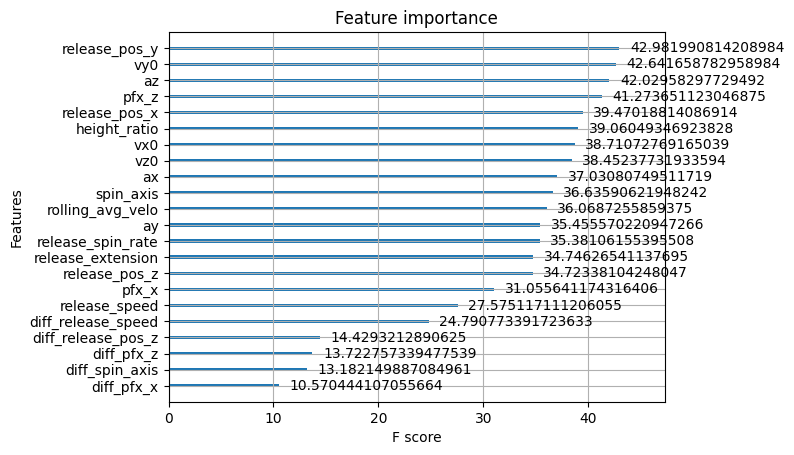

In [24]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

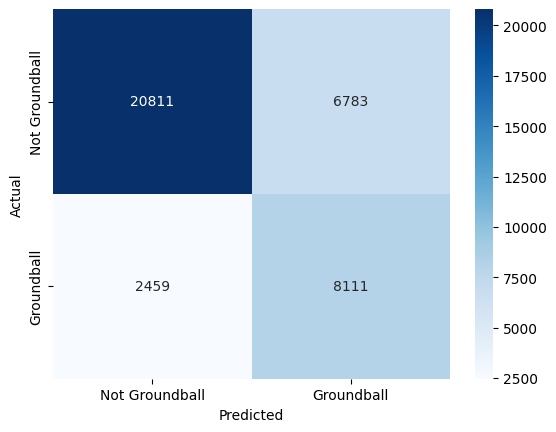

In [25]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [26]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [27]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [28]:
y_pred = final_model.predict(predictions)

In [29]:
testing_identifiers['xgb'] = y_pred

In [30]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/gb_2022&3_xgb.csv")